In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [19]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatchingNDT import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation
import time

class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        #print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, prior, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            dynamic_tracks = self.dynamic_tracker.getTracks()
            lanes = self.getLanes(prior, first_world_ref[0:2])
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, dynamic_tracks, lanes, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, dynamic_tracks, first_world_ref[0:2], gt_relative_pos, imu_relative_ref_3d, lanes)
            print(f"first_world_ref = {first_world_ref}")
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getLanes(self, prior, translate):
        prior_elements = []
        #lane_width = 5.
        #w = lane_width / 2.
        for pr in prior:
            prior_len = pr["x"].shape[0]
            elem = np.zeros([prior_len, 4])
            elem[:-1,2] = pr["dx"]
            elem[-1,2] = elem[-2,2]
            elem[:-1,3] = pr["dy"]
            elem[-1,3] = elem[-2,3]
            #grad = np.abs(elem[:,3] / (elem[:,2] + 1e-6))
            sx = 0#-1#-1*np.sign(elem[:, 3]) * w * 1/np.sqrt(1+grad**2)
            sy = 0#-1#np.sign(elem[:, 2]) * w * grad * 1/np.sqrt(1+grad**2)
            
            elem[:, 0] = pr["x"] - translate[0] + sx
            elem[:, 1] = pr["y"] - translate[1] + sy
            
            #debug_min_x = min(pr["x"])
            #debug_max_x = max(pr["x"])
            #debug_min_y = min(pr["y"])
            #debug_max_y = max(pr["y"])
            #if debug_min_x < 1130 and debug_max_y < 1590:
                #print(f"debug_min_x = {debug_min_x} debug_max_x = {debug_max_x} debug_min_y = {debug_min_y} debug_max_y = {debug_max_y}")
                #print(f"sx = {sx[0]} sy = {sy[0]}")
            prior_elements.append(elem)
            
        return prior_elements
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            xmin = np.min(lane["x"]) if lane["fx"] else np.min(lane["y"])
            xmax = np.max(lane["x"]) if lane["fx"] else np.max(lane["y"])
            prior_list.append({"c": (a0,a1,a2), "xmin": xmin, "xmax": xmax, "fx": lane["fx"]})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        t1 = time.time()
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        t2 = time.time()
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        t3 = time.time()
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, prior, nusc_map)
        t4 = time.time()
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        print(f"Static Tracker: {t2-t1} Dynamic Tracker: {t3-t2} Map Matching: {t4-t3} [sec]")
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


scene_id=325 scene_name=scene-0411 map_name=singapore-hollandvillage


/home/kfir/workspace/RadarLocalization/dataset.py:389: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #odometry


odom_speed [[1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 [1.53803387e+15 2.30000000e+01]
 ...
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]
 [1.53898521e+15 1.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


self.dir_name images/325/database
frame 0


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 0
Number of extended tracks before run() 0
frame_idx = 1
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 8.821487426757812e-06 maps: 0.5923388004302979 eval_sensor_model: 0.0003724098205566406 resample: 0.002096414566040039
dist_cur_predicted = 0.0 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.006536960601806641 Dynamic Tracker: 9.1552734375e-05 Map Matching: 0.6477158069610596 [sec]
frame 1
Number of point tracks before run() 56
Number of extended tracks before run() 0
frame_idx = 2
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Sample Motion: 0.020294904708862305 maps: 0.593590259552002 eval_sensor_model: 0.0003581047058105469 resample: 0.0021581649780273438
dist_cur_predicted = 0.004598182219694664 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.05807089805603027 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 0.6703953742980957 [sec]
frame 2
Number of point tracks before run() 77
Number of extended tracks before run() 0
frame_idx = 3
Number of new plots 0
Number of dynamic tracks before run() 0
Sample Motion: 0.019394874572753906 maps: 0.5769174098968506 eval_sensor_model: 0.0003306865692138672 resample: 0.0019915103912353516
dist_cur_predicted = 0.019811355049085527 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.07461905479431152 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 0.6460940837860107 [sec]
frame 3
Number of point tracks before run() 99
Number of extended tracks before run() 0
created an extend

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021173715591430664 maps: 0.592710018157959 eval_sensor_model: 1.082554817199707 resample: 0.002455472946166992
dist_cur_predicted = 0.4846191782779516 density_around_mean = 0.975
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8407192230224609 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 1.790764570236206 [sec]
frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 5
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019642353057861328 maps: 0.584580659866333 eval_sensor_model: 1.091597557067871 resample: 0.0036423206329345703
dist_cur_predicted = 0.5015533124474699 density_around_mean = 0.975
self.predicted_output = {'x': 2.220051984625397, 'y': 0.23866078693157883, 'theta': 0.3715261243246335, 'trns': 1.5363344574134166} mean_particle = {'x': 2.6067785384738404, 'y': -0.08071093657495884, 'theta': 0.3716541485507076, 'trns': 2.0401577788654217}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8834953308105469 Dynamic Tracker: 0.00011682510375976562 Map Matching: 1.796579360961914 [sec]
frame 5


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 6
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019845962524414062 maps: 0.6035940647125244 eval_sensor_model: 1.0733990669250488 resample: 0.0024580955505371094
dist_cur_predicted = 0.6995517888053336 density_around_mean = 0.97
self.predicted_output = {'x': 2.7010550279255674, 'y': 0.425820998279524, 'theta': 0.371303809921689, 'trns': 1.5363344574134166} mean_particle = {'x': 3.0999963675923627, 'y': -0.14882542581585365, 'theta': 0.3714811701179157, 'trns': 2.5492108986966566}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9728047847747803 Dynamic Tracker: 0.00011157989501953125 Map Matching: 1.792248249053955 [sec]
frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.21297168e+00 -5.19532072e-02  2.83228751e-03  7.55329419e+01
  9.03942890e+01]
frame_idx = 7
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019661426544189453 maps: 0.5948648452758789 eval_sensor_model: 1.162193775177002 resample: 0.002471923828125
dist_cur_predicted = 0.6487723234760738 density_around_mean = 0.965
self.predicted_output = {'x': 3.7221104145876156, 'y': 0.8268768413916009, 'theta': 0.37278969645427606, 'trns': 1.5363344574134166} mean_particle = {'x': 4.129745274806587, 'y': 0.3221597439570054, 'theta': 0.37293262244828773, 'trns': 3.646891485457907}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1012821197509766 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 1.9206688404083252 [sec]
frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.11322283e+02  4.74145498e+00 -4.10738656e-02  4.85592245e+01
  5.56508941e+01]
created an extended object! [-8.37620278e+00  4.81792777e-01 -1.67534988e-03  2.40199149e+01
  3.82837037e+01]
frame_idx = 8
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019255638122558594 maps: 0.6098406314849854 eval_sensor_model: 1.3055157661437988 resample: 0.0024797916412353516
dist_cur_predicted = 0.5671365516736249 density_around_mean = 0.98
self.predicted_output = {'x': 4.213740579928244, 'y': 1.0206358566550418, 'theta': 0.37410759183705, 'trns': 1.5363344574134166} mean_particle = {'x': 4.594844647509079, 'y': 0.6006316210602182, 'theta': 0.37436213372452604, 'trns': 4.1772785199550055}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9578280448913574 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.168226718902588 [sec]
frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 9
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019160032272338867 maps: 0.5853707790374756 eval_sensor_model: 1.2967076301574707 resample: 0.002474546432495117
dist_cur_predicted = 0.47978787771273385 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9436967372894287 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.1407439708709717 [sec]
frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0026506978808765284, 0.5117600339458712, -8.398730979000117) (0.05355030236049871, -3.283333927110184, 69.50392079536641)
frame_idx = 10
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019252777099609375 maps: 0.6039395332336426 eval_sensor_model: 1.3054680824279785 resample: 0.0024428367614746094
dist_cur_predicted = 0.11206144936097771 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0319244861602783 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.156938076019287 [sec]
frame 10


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003257600415449837, 0.536229182128781, -8.40746703789746) (0.054382251323260904, -3.333065097365216, 70.24119246090709)
frame_idx = 11
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019457340240478516 maps: 0.589299201965332 eval_sensor_model: 1.3089137077331543 resample: 0.002761363983154297
dist_cur_predicted = 0.16606647517976972 density_around_mean = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0422296524047852 Dynamic Tracker: 0.0001010894775390625 Map Matching: 2.2056260108947754 [sec]
frame 11


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.003910519099017202, 0.5539222298127872, -8.411388985764825) (0.06517286115804781, -4.065601268084433, 82.62871779377812)
created an extended object! [-4.42983724e+02  1.34526598e+01 -9.74874373e-02  6.19249439e+01
  6.54188001e+01]
frame_idx = 12
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01955890655517578 maps: 0.6066553592681885 eval_sensor_model: 1.5870342254638672 resample: 0.0045549869537353516
dist_cur_predicted = 0.16637234672209994 density_around_mean = 0.97
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9572274684906006 Dynamic Tracker: 8.58306884765625e-05 Map Matching: 2.562053680419922 [sec]
frame 12


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0037365825573727578, 0.5412692337496664, -8.412454384954522) (0.06254270760358631, -3.8768920409799175, 79.24360998780247)
frame_idx = 13
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01922321319580078 maps: 0.606919527053833 eval_sensor_model: 1.3651673793792725 resample: 0.002521038055419922
dist_cur_predicted = 0.1070725195243329 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8923509120941162 Dynamic Tracker: 0.0002605915069580078 Map Matching: 2.2750375270843506 [sec]
frame 13


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004154025332142421, 0.5640596276015859, -8.41585321802951) (0.03995139013754368, -2.3341775616257614, 52.98527660997443)
frame_idx = 14
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020238161087036133 maps: 0.5994412899017334 eval_sensor_model: 1.3357055187225342 resample: 0.002505779266357422
dist_cur_predicted = 0.0730369462273437 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8793296813964844 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.2406365871429443 [sec]
frame 14


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004243912063932516, 0.5654251666744324, -8.416796609411412) (0.04458784295302015, -2.651097944177132, 58.38251219753275)
frame_idx = 15
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019937753677368164 maps: 0.5990991592407227 eval_sensor_model: 1.3328421115875244 resample: 0.0024442672729492188
dist_cur_predicted = 0.0970928133046878 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.040541172027588 Dynamic Tracker: 8.845329284667969e-05 Map Matching: 2.2233450412750244 [sec]
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004122032236630595, 0.5588070748003026, -8.423390993526153) (0.05416170614700162, -3.303517782264631, 69.44282841301839)
frame_idx = 16
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0203402042388916 maps: 0.6066761016845703 eval_sensor_model: 1.4027881622314453 resample: 0.002468109130859375
dist_cur_predicted = 0.09755850965335432 density_around_mean = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9898171424865723 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.3255772590637207 [sec]
frame 16


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004107181394514867, 0.5574307158204168, -8.42544112794778) (0.04225788515703415, -2.496690831608923, 55.81996407780651)
frame_idx = 17
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020463943481445312 maps: 0.6588892936706543 eval_sensor_model: 1.3974592685699463 resample: 0.0025377273559570312
dist_cur_predicted = 0.11315823520263676 density_around_mean = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9462807178497314 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.373582601547241 [sec]
frame 17


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004198040515521549, 0.5539408449103959, -8.425091118757932) (0.050603333407724736, -3.0623319451696465, 65.35719592937365)
frame_idx = 18
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02003312110900879 maps: 0.6155397891998291 eval_sensor_model: 1.3890314102172852 resample: 0.002499818801879883
dist_cur_predicted = 0.17636907187798576 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9768052101135254 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.3132762908935547 [sec]
frame 18


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004338999251651154, 0.5644196702364916, -8.431006033529282) (0.03491325452092441, -1.9973987071231472, 47.370659354761585)
frame_idx = 19
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01921701431274414 maps: 0.6509344577789307 eval_sensor_model: 1.531841516494751 resample: 0.002775430679321289
dist_cur_predicted = 0.08191176450703343 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9628064632415771 Dynamic Tracker: 0.00017905235290527344 Map Matching: 2.5081899166107178 [sec]
frame 19


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004581199534764395, 0.5741112227186478, -8.440652085693408) (0.02799811607328236, -1.5259167459279264, 39.35265465212438)
frame_idx = 20
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019496917724609375 maps: 0.6353919506072998 eval_sensor_model: 1.471898078918457 resample: 0.002568960189819336
dist_cur_predicted = 0.05387509881427025 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0239348411560059 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.4370765686035156 [sec]
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004731884277357857, 0.5829520902946532, -8.445173937491697) (0.0003592219375042363, 0.36057212517605164, 7.227717375729017)
Tracks are similar! do not open a new trk (-0.004731884277357857, 0.5829520902946532, -8.445173937491697) (0.009790702652734764, -0.40955957775872753, 20.363220375578997)
frame_idx = 21
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019491910934448242 maps: 0.6159789562225342 eval_sensor_model: 1.4148643016815186 resample: 0.002474546432495117
dist_cur_predicted = 0.05518612063509223 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0860342979431152 Dynamic Tracker: 0.00010395050048828125 Map Matching: 2.341991662979126 [sec]
frame 21


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004947826216310391, 0.5918597003596922, -8.4505254405559) (-0.0009812715933026762, 0.4576871599366334, 5.483708918807125)
Tracks are similar! do not open a new trk (-0.004947826216310391, 0.5918597003596922, -8.4505254405559) (0.0068253172442525566, -0.18635409796024505, 16.183111426096836)
frame_idx = 22
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019745826721191406 maps: 0.607161283493042 eval_sensor_model: 1.3781557083129883 resample: 0.0024771690368652344
dist_cur_predicted = 0.04949112453577523 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0481784343719482 Dynamic Tracker: 8.630752563476562e-05 Map Matching: 2.290315628051758 [sec]
frame 22


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005079432946798613, 0.5971619132850998, -8.44447960213133) (-9.094742315517265e-05, 0.3962758719451593, 6.56702461377593)
Tracks are similar! do not open a new trk (-0.005079432946798613, 0.5971619132850998, -8.44447960213133) (-0.0010909687852743717, 0.4937424623070895, 1.1815800904311695)
frame_idx = 23
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019075632095336914 maps: 0.5979304313659668 eval_sensor_model: 1.4108455181121826 resample: 0.0025353431701660156
dist_cur_predicted = 0.02937606432628543 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1562340259552002 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.315589427947998 [sec]
frame 23


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005477163541278108, 0.6103343971398725, -8.43382152794461) (-0.0008171904335729719, 0.44886458865654216, 5.598697541229946)
Tracks are similar! do not open a new trk (-0.005477163541278108, 0.6103343971398725, -8.43382152794461) (-0.0023513596470729537, 0.5353732078844576, -10.940103509881082)
frame_idx = 24
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019356966018676758 maps: 0.6045358180999756 eval_sensor_model: 1.341691017150879 resample: 0.0025157928466796875
dist_cur_predicted = 0.04920797505211434 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1332659721374512 Dynamic Tracker: 0.0006816387176513672 Map Matching: 2.238191843032837 [sec]
frame 24


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0060842533385477736, 0.6293993716465012, -8.415551147207658) (0.026494110300956403, -1.4122476500480101, 37.22302688554975)
Tracks are similar! do not open a new trk (-0.0060842533385477736, 0.6293993716465012, -8.415551147207658) (-0.0026671761042938755, 0.5532803015232467, -11.189278691917941)
Extended track is too short curve_length=4.611999765141529
frame_idx = 25
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01937079429626465 maps: 0.60532546043396 eval_sensor_model: 1.3491110801696777 resample: 0.002490520477294922
dist_cur_predicted = 0.039762482843755456 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2112627029418945 Dynamic Tracker: 0.0003046989440917969 Map Matching: 2.208237648010254 [sec]
frame 25


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0059466238071634505, 0.6272318431148307, -8.418373150704706) (-0.00350219819381662, 0.598090161664191, -11.788121391250716)
Tracks are similar! do not open a new trk (-0.0059466238071634505, 0.6272318431148307, -8.418373150704706) (0.026549774176416917, -1.4098856793528236, 37.0554598296163)
Extended track is too short curve_length=4.794034913808878
Extended track is too short curve_length=4.94624007709513
created an extended object! [ 8.21415916e+00  3.90890333e-01 -9.16195751e-04  3.93978668e+01
  4.57589318e+01]
frame_idx = 26
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01928997039794922 maps: 0.6015243530273438 eval_sensor_model: 1.3806896209716797 resample: 0.002455472946166992
dist_cur_predicted = 0.0369160810500374 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2980506420135498 Dynamic Tracker: 0.0002467632293701172 Map Matching: 2.2813150882720947 [sec]
frame 26


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00604849468951613, 0.6337892818484739, -8.422028185632442) (-0.0036221591924771347, 0.6031166461091483, -11.841250927656297)
Extended track is too short curve_length=4.94325778671578
frame_idx = 27
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023879289627075195 maps: 0.643618106842041 eval_sensor_model: 1.6484904289245605 resample: 0.002590179443359375
dist_cur_predicted = 0.029017665229434365 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2433297634124756 Dynamic Tracker: 0.0004885196685791016 Map Matching: 2.6836049556732178 [sec]
frame 27


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.803405584103375
Tracks are similar! do not open a new trk (-0.005875896069347124, 0.627702449279526, -8.436333493573311) (0.024765615200469104, -1.2896278278454567, 35.053365478509356)
Tracks are similar! do not open a new trk (-0.005875896069347124, 0.627702449279526, -8.436333493573311) (-0.0033256934719682564, 0.5853121590986937, -11.58653625445416)
Extended track is too short curve_length=4.961064206993379
frame_idx = 28
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02086782455444336 maps: 0.6669187545776367 eval_sensor_model: 1.4258248805999756 resample: 0.0025467872619628906
dist_cur_predicted = 0.043277145267745634 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4917995929718018 Dynamic Tracker: 0.0003192424774169922 Map Matching: 2.4051191806793213 [sec]
frame 28


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0060795447527043685, 0.6316001191149037, -8.43734930646865) (-0.002381801378191694, 0.5137243124506501, 5.293988165318263)
Tracks are similar! do not open a new trk (-0.0060795447527043685, 0.6316001191149037, -8.43734930646865) (-0.0020460867224833205, 0.5089120370115825, -10.481088475589514)
Extended track is too short curve_length=4.918584989334191
frame_idx = 29
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01972174644470215 maps: 0.607184648513794 eval_sensor_model: 1.369135856628418 resample: 0.0024132728576660156
dist_cur_predicted = 0.04968346033567007 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2592980861663818 Dynamic Tracker: 0.0009055137634277344 Map Matching: 2.27384352684021 [sec]
frame 29


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006277136345184056, 0.6298768969682297, -8.440002760742978) (-0.000987057022115418, 0.4406537024402163, 6.10074568254528)
Tracks are similar! do not open a new trk (-0.006277136345184056, 0.6298768969682297, -8.440002760742978) (0.002237418124583135, 0.2330043152620831, -6.0544505155512836)
frame_idx = 30
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01961517333984375 maps: 0.6150908470153809 eval_sensor_model: 1.4426240921020508 resample: 0.002499103546142578
dist_cur_predicted = 0.043201150794115864 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2433645725250244 Dynamic Tracker: 0.0005602836608886719 Map Matching: 2.3850207328796387 [sec]
frame 30


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006376258110418983, 0.620662465607935, -8.43966006791348) (-0.0010772693460885632, 0.4468100672822246, 5.9917223580947665)
Tracks are similar! do not open a new trk (-0.006376258110418983, 0.620662465607935, -8.43966006791348) (0.003485053388876058, 0.14816147062575086, -4.620537232148523)
Extended track is too short curve_length=4.898924095010752
Tracks are similar! do not open a new trk (-0.04050103072994062, 4.70894787745418, -111.29549144584148) (0.00605550252949945, -0.2578899064078244, 8.425052616061642)
frame_idx = 31
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02021050453186035 maps: 0.6188497543334961 eval_sensor_model: 1.4825313091278076 resample: 0.0026476383209228516
dist_cur_predicted = 0.02581443172624258 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3103716373443604 Dynamic Tracker: 0.00048041343688964844 Map Matching: 2.4096133708953857 [sec]
frame 31


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006465553764569307, 0.6227890361428032, -8.438659178382704) (-0.003975245300793008, 0.6051308483200815, 4.018323513906856)
Tracks are similar! do not open a new trk (-0.006465553764569307, 0.6227890361428032, -8.438659178382704) (0.0008375434396458625, 0.3236042023414876, -7.520682073842798)
Extended track is too short curve_length=4.925347771953912
Tracks are similar! do not open a new trk (-0.04051709838288588, 4.711398202517641, -111.2954334776249) (0.000984950609838141, 0.2886064272014064, -6.218776671627339)
frame_idx = 32
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019884109497070312 maps: 0.6218681335449219 eval_sensor_model: 1.4175784587860107 resample: 0.002482175827026367
dist_cur_predicted = 0.013607828504017205 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2617907524108887 Dynamic Tracker: 0.00040841102600097656 Map Matching: 2.3365631103515625 [sec]
frame 32


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006412622372612697, 0.6215300994881244, -8.436700187607741) (0.00046059578485469876, 0.34898425250224074, -7.945194470594187)
Extended track is too short curve_length=3.129960291989746
Tracks are similar! do not open a new trk (-0.040578639943118645, 4.709251138911367, -111.29581591948943) (-0.0011833123637874474, 0.5164919535205339, -12.17909425110648)
frame_idx = 33
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020226716995239258 maps: 0.6407265663146973 eval_sensor_model: 1.4338974952697754 resample: 0.00252532958984375
dist_cur_predicted = 0.023205621326752662 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.277651309967041 Dynamic Tracker: 0.0004146099090576172 Map Matching: 2.3778600692749023 [sec]
frame 33


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006012476323621935, 0.6076619976116024, -8.430476132215958) (0.0022489894604065712, 0.23074811229875986, -6.000136670494369)
Tracks are similar! do not open a new trk (-0.040581096789144046, 4.715680089865057, -111.29539592593957) (0.0007559382062799348, 0.30957213040181875, -6.704266188903552)
frame_idx = 34
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02018284797668457 maps: 0.6007239818572998 eval_sensor_model: 1.5338683128356934 resample: 0.0025272369384765625
dist_cur_predicted = 0.043920499579305425 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.31734037399292 Dynamic Tracker: 0.0004527568817138672 Map Matching: 2.472506523132324 [sec]
frame 34


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 168
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005881907927280625, 0.6142089369673384, -8.4304257752217) (0.0021371918802602927, 0.23813502618735688, -6.122111351874993)
Tracks are similar! do not open a new trk (-0.04061495173237679, 4.714725817267023, -111.29546438550575) (-0.0004177026809460126, 0.435435366945254, -10.064593089118613)
Extended track is too short curve_length=3.050185368355606
frame_idx = 35
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019841909408569336 maps: 0.6000101566314697 eval_sensor_model: 1.393583059310913 resample: 0.002489328384399414
dist_cur_predicted = 0.00603584174955887 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.398850917816162 Dynamic Tracker: 0.0004024505615234375 Map Matching: 2.3020431995391846 [sec]
frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.006036266023219211, 0.6124778047757702, -8.42737797917396) (0.001805878777907163, 0.25988609009479924, -6.476870609032516)
Tracks are similar! do not open a new trk (-0.04061955722894104, 4.717233898730394, -111.29470072872986) (-0.003083726905357081, 0.7109370351773728, -17.08610917577116)
Tracks are similar! do not open a new trk (-0.04061955722894104, 4.717233898730394, -111.29470072872986) (0.0030414684522890316, 0.10875039664787568, -0.9539300501436176)
frame_idx = 36
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193331241607666 maps: 0.5961484909057617 eval_sensor_model: 1.3725645542144775 resample: 0.0025055408477783203
dist_cur_predicted = 0.02703625599816312 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3534698486328125 Dynamic Tracker: 8.535385131835938e-05 Map Matching: 2.254507064819336 [sec]
frame 36


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 173
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.005740610025244736, 0.6034305759692773, -8.426858377497513) (0.006059072076240705, -0.01965717698561954, -1.9036968280827715)
Tracks are similar! do not open a new trk (-0.04038351790121074, 4.707041697392823, -111.29371565487301) (-0.002849573941915081, 0.6857971166739102, -16.416156240091407)
frame_idx = 37
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019123077392578125 maps: 0.5899810791015625 eval_sensor_model: 1.35841965675354 resample: 0.0025146007537841797
dist_cur_predicted = 0.006116632247368267 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4132134914398193 Dynamic Tracker: 0.00010180473327636719 Map Matching: 2.238046169281006 [sec]
frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00574582637441904, 0.6107628085200468, -8.426731231225322) (0.005683594154518302, 0.0028970568643964037, -2.235430346927581)
Tracks are similar! do not open a new trk (-0.04019245292102724, 4.692524229179837, -111.29400114912609) (0.0002553123627749787, 0.3574911570227436, -7.797657454367479)
frame_idx = 38
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01961064338684082 maps: 0.615250825881958 eval_sensor_model: 1.4101965427398682 resample: 0.002496004104614258
dist_cur_predicted = 0.024357079671637694 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3908443450927734 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.3254809379577637 [sec]
frame 38


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04036760427405817, 4.700155125018254, -111.29270215279367) (-0.0015456146580294712, 0.5552994697212554, -13.225598108051985)
frame_idx = 39
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01941370964050293 maps: 0.5974326133728027 eval_sensor_model: 1.3711090087890625 resample: 0.002545595169067383
dist_cur_predicted = 0.006191265192910298 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3652353286743164 Dynamic Tracker: 9.846687316894531e-05 Map Matching: 2.2680206298828125 [sec]
frame 39


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04032280836149453, 4.6974594637574825, -111.29263535748693) (-0.00033656907344119794, 0.42696081360681987, -9.840679475536392)
frame_idx = 40
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019469499588012695 maps: 0.6069304943084717 eval_sensor_model: 1.4399893283843994 resample: 0.00251007080078125
dist_cur_predicted = 0.007747453806778549 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3976719379425049 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.3825950622558594 [sec]
frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04042800623705244, 4.705030201235703, -111.2906091597432) (-0.0025368989252233633, 0.6590433395380226, -15.93258907366741)
frame_idx = 41
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020021677017211914 maps: 0.6436233520507812 eval_sensor_model: 1.4205336570739746 resample: 0.0024504661560058594
dist_cur_predicted = 0.007040195725745181 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3730542659759521 Dynamic Tracker: 0.0001442432403564453 Map Matching: 2.366718053817749 [sec]
frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04052713953134513, 4.710496530969998, -111.28887772793422) (-0.0014767328282270782, 0.5481916248084734, -13.076169606109843)
Tracks are similar! do not open a new trk (0.002864417219566552, -0.05957027903865808, 9.201338371740299) (0.024568388453762715, -3.5262033002922237, 149.89666566195862)
frame_idx = 42
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020615816116333008 maps: 0.7405972480773926 eval_sensor_model: 1.3886137008666992 resample: 0.002511262893676758
dist_cur_predicted = 0.031009238730033542 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4059295654296875 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.425070285797119 [sec]
frame 42


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0407528036494558, 4.7195759401866715, -111.28530730830946) (-0.0015002253393085984, 0.5542831649573833, -13.33157783824871)
Tracks are similar! do not open a new trk (0.0028101161543113724, -0.058340049190020254, 9.201557611600977) (0.01679702279224108, -2.3300940076642367, 103.960469280487)
frame_idx = 43
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019921541213989258 maps: 0.6136527061462402 eval_sensor_model: 1.4238219261169434 resample: 0.0026235580444335938
dist_cur_predicted = 0.007088104504797677 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4332330226898193 Dynamic Tracker: 0.00011610984802246094 Map Matching: 2.3440864086151123 [sec]
frame 43


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.040492647907722494, 4.707366802718033, -111.28652625758605) (-0.0013601474947412748, 0.5395601082276471, -12.947093250489576)
Tracks are similar! do not open a new trk (0.0028276745458152533, -0.05519185658774898, 9.20179225731463) (0.01763459242315179, -2.4586489460562735, 108.88251706552032)
frame_idx = 44
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019672632217407227 maps: 0.6060843467712402 eval_sensor_model: 1.3789169788360596 resample: 0.0025506019592285156
dist_cur_predicted = 0.024586730748941164 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4646375179290771 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.306424379348755 [sec]
frame 44


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.040702862950981904, 4.716458349138012, -111.2839887790427) (-0.0007211556641285744, 0.4703921070889827, -11.098795454538596)
Tracks are similar! do not open a new trk (0.0028497272390088715, -0.055274198572275224, 9.201741917105059) (0.033056008459100845, -4.844806655648918, 201.05180492713703)
frame_idx = 45
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02359318733215332 maps: 0.6274600028991699 eval_sensor_model: 1.435128927230835 resample: 0.002521038055419922
dist_cur_predicted = 0.021267515025224528 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4282701015472412 Dynamic Tracker: 9.489059448242188e-05 Map Matching: 2.399488925933838 [sec]
frame 45


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 182
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04120041008058747, 4.74479098474165, -111.2756645101515) (-0.00010225855656185893, 0.40442235130160425, -9.359371103705152)
Tracks are similar! do not open a new trk (0.0028172172596612898, -0.05739334801603774, 9.201628481218522) (0.02274984642447655, -3.234425387167441, 138.18491412578808)
created an extended object! [-7.41767445e+02  1.57373151e+01 -7.99663540e-02  9.26260264e+01
  9.78046179e+01]
frame_idx = 46
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020072460174560547 maps: 0.6105682849884033 eval_sensor_model: 1.4564085006713867 resample: 0.0025398731231689453
dist_cur_predicted = 0.005364020606641599 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4699311256408691 Dynamic Tracker: 0.00010204315185546875 Map Matching: 2.419799566268921 [sec]
frame 46


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04148293030153417, 4.758606242287457, -111.27064092871237) (0.003649051974368781, 0.006703961364503336, 1.0913616590698425)
Tracks are similar! do not open a new trk (-0.09936884848348679, 13.579487658506814, -443.03682920703017) (-0.16262405280701536, 22.203207862189267, -737.2091553791053)
Tracks are similar! do not open a new trk (0.0027041086709915113, -0.044226677898998173, 9.20337143589523) (-0.032257610316740605, 5.369199384857135, -198.0216715946914)
frame_idx = 47
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019879817962646484 maps: 0.5989518165588379 eval_sensor_model: 1.4370677471160889 resample: 0.0025331974029541016
dist_cur_predicted = 0.020857795482146307 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5179088115692139 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.411942958831787 [sec]
frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 184
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04134643629008292, 4.751975670677297, -111.27005072400107) (0.0043638797957265925, -0.06882527471175058, 3.0616310893372156)
Tracks are similar! do not open a new trk (0.002680657271700922, -0.046452516019101824, 9.203248243253363) (-0.02286448655801043, 3.9026158859230864, -140.81469084829578)
Tracks are similar! do not open a new trk (-0.09975549530886253, 13.59785759170857, -443.04307839012307) (-0.15759659191051123, 21.849566759160997, -737.4408552213035)
frame_idx = 48
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0201566219329834 maps: 0.661592960357666 eval_sensor_model: 1.574885606765747 resample: 0.0024766921997070312
dist_cur_predicted = 0.015222881459980167 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5682168006896973 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.64046311378479 [sec]
frame 48


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 183
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04158972309437779, 4.763341455937358, -111.26547462592242) (0.005006339358318839, -0.14708217029824658, 5.37795398849278)
Tracks are similar! do not open a new trk (-0.09997662999470068, 13.614098508662567, -443.04688381675123) (-0.15810543043658076, 21.839500172951556, -734.8601828479302)
Tracks are similar! do not open a new trk (0.002737533364590752, -0.046883094035201224, 9.203101621449429) (0.03584944690723247, -5.289882851183766, 218.47964707505554)
frame_idx = 49
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023421525955200195 maps: 0.6687827110290527 eval_sensor_model: 1.4924798011779785 resample: 0.0026998519897460938
dist_cur_predicted = 0.027429465208322068 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4978301525115967 Dynamic Tracker: 9.512901306152344e-05 Map Matching: 2.6123697757720947 [sec]
frame 49


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 186
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04184999862397349, 4.777377495813435, -111.2593639595386) (0.0019374908887052882, 0.17776982933887622, -3.149899152470176)
Tracks are similar! do not open a new trk (-0.10048975123927202, 13.647674770025178, -443.0546628516806) (-0.15631239838064234, 21.64890592067259, -729.9340185063948)
Tracks are similar! do not open a new trk (0.002771390175945953, -0.05401321858213965, 9.202394364487773) (0.04304763503093297, -6.397256364279735, 260.9516346534377)
frame_idx = 50
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019644975662231445 maps: 0.6058690547943115 eval_sensor_model: 1.3976263999938965 resample: 0.00252532958984375
dist_cur_predicted = 0.005053780118008604 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5015323162078857 Dynamic Tracker: 9.655952453613281e-05 Map Matching: 2.310178279876709 [sec]
frame 50


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 186
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.041665922680237825, 4.7660351728247505, -111.26132363817634) (0.0009794935178713158, 0.279117111964973, -5.815649109685497)
Tracks are similar! do not open a new trk (-0.1009161703819941, 13.671460141982257, -443.0606976460512) (-0.1493567951899333, 20.701721059184443, -697.9388312419436)
Tracks are similar! do not open a new trk (0.002871693227082407, -0.06253278549653364, 9.201538562917223) (0.033651376476214453, -4.88297918292603, 199.9547277085129)
frame_idx = 51
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020119428634643555 maps: 0.6112709045410156 eval_sensor_model: 1.5036578178405762 resample: 0.0030689239501953125
dist_cur_predicted = 0.011457119011887373 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4687373638153076 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.4908647537231445 [sec]
frame 51


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 186
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04154830376550756, 4.759907669811744, -111.26226758879004) (0.0014478929022777225, 0.25647022768522754, -6.164923489345731)
Tracks are similar! do not open a new trk (-0.101644216962287, 13.713009917750405, -443.07050694112155) (-0.014093357917871334, 2.2674521455530887, -71.13798619425187)
frame_idx = 52
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989150047302246 maps: 0.604067325592041 eval_sensor_model: 1.3966455459594727 resample: 0.002569913864135742
dist_cur_predicted = 0.0394903433787708 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5149579048156738 Dynamic Tracker: 9.512901306152344e-05 Map Matching: 2.305725574493408 [sec]
frame 52


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 184
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04211573896273524, 4.792254953744107, -111.2506655981329) (0.0015516323224662573, 0.2482276630237424, -6.051518849862207)
Tracks are similar! do not open a new trk (0.002799006412041846, -0.05775339099233562, 9.202336646924122) (0.02085165794627406, -2.819600243445057, 116.82027981439067)
frame_idx = 53
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020036935806274414 maps: 0.6004502773284912 eval_sensor_model: 1.4096612930297852 resample: 0.002518177032470703
dist_cur_predicted = 0.007760547037341675 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5027823448181152 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.308588743209839 [sec]
frame 53


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.041688052019066696, 4.76827563828098, -111.25346510079036) (0.0013824536581146481, 0.26340396885658984, -6.374345275085142)
frame_idx = 54
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020078182220458984 maps: 0.607799768447876 eval_sensor_model: 1.4457545280456543 resample: 0.0025167465209960938
dist_cur_predicted = 0.025806061617138575 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6841306686401367 Dynamic Tracker: 9.322166442871094e-05 Map Matching: 2.35502552986145 [sec]
frame 54


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 180
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04209879956479251, 4.791404351270149, -111.24430628900157) (0.00042403243649457954, 0.36615489740909135, -9.123041603855059)
frame_idx = 55
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01984429359436035 maps: 0.5926930904388428 eval_sensor_model: 1.3724443912506104 resample: 0.0024869441986083984
dist_cur_predicted = 0.017811729393102774 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6397154331207275 Dynamic Tracker: 0.00010585784912109375 Map Matching: 2.2635629177093506 [sec]
frame 55


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 176
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.042542552142216264, 4.815955040554794, -111.23317904713927) (0.00044824856153570546, 0.3621471504761841, -8.981633391335158)
frame_idx = 56
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019826889038085938 maps: 0.5927085876464844 eval_sensor_model: 1.3847603797912598 resample: 0.0024576187133789062
dist_cur_predicted = 0.022401417288856855 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.586859941482544 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.2766847610473633 [sec]
frame 56


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04329739545981868, 4.852632651682649, -111.21467118036556) (0.0010586171109637618, 0.2972990988747888, -7.2731372004721)
created an extended object! [-3.23112220e+02  9.87058572e+00 -6.84736456e-02  6.81792532e+01
  7.41918751e+01]
frame_idx = 57
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019800424575805664 maps: 0.6191616058349609 eval_sensor_model: 1.42645263671875 resample: 0.002496957778930664
dist_cur_predicted = 0.02259801142996592 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6462340354919434 Dynamic Tracker: 9.512901306152344e-05 Map Matching: 2.408646583557129 [sec]
frame 57


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 166
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04328871568071881, 4.846602261806656, -111.21092012499454) (0.0007670836601630609, 0.3264862870792119, -8.005806818553818)
Tracks are similar! do not open a new trk (0.0031802444618327704, -0.08910213965526177, 9.197590982699767) (0.05328933746237148, -8.024417898940571, 325.62801579694855)
Tracks are similar! do not open a new trk (-0.10222887350299074, 13.744645169156211, -443.07542652184077) (-0.15405982975993993, 21.260731960187087, -715.1376756109777)
frame_idx = 58
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999211311340332 maps: 0.6058423519134521 eval_sensor_model: 1.430793285369873 resample: 0.002479076385498047
dist_cur_predicted = 0.024234970890268475 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5334770679473877 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.3831188678741455 [sec]
frame 58


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04355017044171333, 4.863282662525568, -111.20100926033686) (0.00012014100767693598, 0.39476903798883844, -9.801186007908013)
Tracks are similar! do not open a new trk (0.003171033939027267, -0.09250753774836779, 9.197436306101592) (0.05781887445462459, -8.735161923012067, 353.4841144815615)
Tracks are similar! do not open a new trk (-0.1023009632437276, 13.752287543084861, -443.075800576409) (-0.15610791710739058, 21.73973078837914, -738.4995929769809)
frame_idx = 59
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019589662551879883 maps: 0.6004655361175537 eval_sensor_model: 1.4030325412750244 resample: 0.0024938583374023438
dist_cur_predicted = 0.03990181645121588 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5149915218353271 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.35390043258667 [sec]
frame 59


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04382254002676322, 4.878702074989046, -111.19462560874608) (0.0005494841169133167, 0.3442482770174518, -8.32630327994069)
Tracks are similar! do not open a new trk (0.0031723408734767346, -0.09126841901547589, 9.197890582361692) (0.050635311581789605, -7.619085804535101, 310.21651259722825)
frame_idx = 60
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019861221313476562 maps: 0.6208910942077637 eval_sensor_model: 1.6035473346710205 resample: 0.0025675296783447266
dist_cur_predicted = 0.009930068718360009 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5536048412322998 Dynamic Tracker: 8.559226989746094e-05 Map Matching: 2.6254608631134033 [sec]
frame 60


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04437383689559951, 4.905011757445307, -111.17705497392917) (0.001483531626574607, 0.23991989417908158, -5.425784402683302)
frame_idx = 61
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020247936248779297 maps: 0.6861038208007812 eval_sensor_model: 1.6420011520385742 resample: 0.0026655197143554688
dist_cur_predicted = 0.012558290390518811 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6366941928863525 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.723280429840088 [sec]
frame 61


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04420429589504401, 4.893483268351032, -111.16722212260113) (-0.0005767228493351717, 0.4647835150511269, -11.565292483447681)
frame_idx = 62
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019970417022705078 maps: 0.6207582950592041 eval_sensor_model: 1.5340399742126465 resample: 0.002549409866333008
dist_cur_predicted = 0.018931487293024938 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.717980146408081 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.5153839588165283 [sec]
frame 62


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.044095745320235545, 4.88626116613187, -111.16357369233758) (-0.0013173393733935642, 0.5452117915540683, -13.746119496542294)
Tracks are similar! do not open a new trk (0.0033132522533304313, -0.10226386891381385, 9.197138405218954) (0.032113119107029096, -4.71122980287504, 196.23855300106854)
created an extended object! [ 7.55402936e+02 -1.27791898e+01  5.68291153e-02  1.12106416e+02
  1.17352813e+02]
frame_idx = 63
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0200650691986084 maps: 0.7313518524169922 eval_sensor_model: 1.6306674480438232 resample: 0.0025260448455810547
dist_cur_predicted = 0.010496954159390958 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.58168363571167 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.761695623397827 [sec]
frame 63


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04422387110171565, 4.894297516416657, -111.1590811358551) (0.0005274415398136695, 0.3387145777676328, -7.987270220158187)
Tracks are similar! do not open a new trk (0.0033310878057346846, -0.10247288980446993, 9.197118090913026) (0.018123998244364604, -2.431433875317322, 103.34714794554966)
frame_idx = 64
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020150423049926758 maps: 0.6015172004699707 eval_sensor_model: 1.48067307472229 resample: 0.002440214157104492
dist_cur_predicted = 0.01125570649872743 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.505727767944336 Dynamic Tracker: 9.870529174804688e-05 Map Matching: 2.4774727821350098 [sec]
frame 64


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04411621425368906, 4.889885055737398, -111.15821040410228) (0.005623292550165808, -0.22721229722066694, 7.71860668828277)
Tracks are similar! do not open a new trk (0.0033119180292385444, -0.1045881879199002, 9.197039006455642) (0.020718715938173884, -2.8954080328808627, 123.90751322288293)
frame_idx = 65
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722938537597656 maps: 0.6011483669281006 eval_sensor_model: 1.4783151149749756 resample: 0.002465486526489258
dist_cur_predicted = 0.005065543059369171 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4779014587402344 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.47495436668396 [sec]
frame 65


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0441481059271926, 4.886544560794964, -111.15845239634702) (0.0022417612422116337, 0.14332668353766342, -2.4283064501860787)
Tracks are similar! do not open a new trk (0.0034064756940270034, -0.11237313398381757, 9.196290623551931) (-0.010319962567578295, 2.1105902812940593, -77.91753404348499)
frame_idx = 66
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020344257354736328 maps: 0.6219067573547363 eval_sensor_model: 1.502336025238037 resample: 0.00252532958984375
dist_cur_predicted = 0.02601740642371401 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4898622035980225 Dynamic Tracker: 9.870529174804688e-05 Map Matching: 2.525200605392456 [sec]
frame 66


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003391663245716969, -0.11029402084342409, 9.19655343288754) (-0.01871011818375303, 3.444837567911318, -130.90871254585917)
frame_idx = 67
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02012038230895996 maps: 0.6090273857116699 eval_sensor_model: 1.4583806991577148 resample: 0.0024666786193847656
dist_cur_predicted = 0.0011543812135833742 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.554584264755249 Dynamic Tracker: 9.107589721679688e-05 Map Matching: 2.45455265045166 [sec]
frame 67


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0033910114086215426, -0.10826454239799276, 9.1968308100915) (-0.01238983006985864, 2.445970470975679, -91.48534749402063)
frame_idx = 68
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019710540771484375 maps: 0.6034009456634521 eval_sensor_model: 1.4471495151519775 resample: 0.002404928207397461
dist_cur_predicted = 0.05208306122180639 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5840182304382324 Dynamic Tracker: 8.749961853027344e-05 Map Matching: 2.4324951171875 [sec]
frame 68


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 176
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003177119008745332, -0.08999624669655343, 9.199762439456448) (-0.009609763880950101, 2.0085928322151148, -74.30549925530532)
frame_idx = 69
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019816875457763672 maps: 0.5963690280914307 eval_sensor_model: 1.4786653518676758 resample: 0.0025243759155273438
dist_cur_predicted = 0.014009245355030828 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6307363510131836 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.5018670558929443 [sec]
frame 69


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed


Number of point tracks before run() 176
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry
/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031424842971652313, -0.08941594800115557, 9.200036548446597) (0.0028205660388220415, 0.053226355631863995, 2.4906926463614214)
frame_idx = 70
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019742965698242188 maps: 0.5895440578460693 eval_sensor_model: 1.4654793739318848 resample: 0.002500772476196289
dist_cur_predicted = 0.01704156725812889 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6668226718902588 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.4764862060546875 [sec]
frame 70


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0029167399466992865, -0.06915773887281738, 9.203913238506704) (-0.006487039169489619, 1.5329321602047805, -56.257776733569926)
frame_idx = 71
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02063918113708496 maps: 0.6167514324188232 eval_sensor_model: 1.5341496467590332 resample: 0.002625703811645508
dist_cur_predicted = 0.010518580406115526 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6759827136993408 Dynamic Tracker: 0.00011849403381347656 Map Matching: 2.5721559524536133 [sec]
frame 71


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003119415537666468, -0.09074272896703908, 9.202537971452474) (-0.009196053535403237, 1.9548543158660823, -72.66587835221232)
frame_idx = 72
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020990371704101562 maps: 0.6022956371307373 eval_sensor_model: 1.468553066253662 resample: 0.0024344921112060547
dist_cur_predicted = 0.015392363320178704 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6553776264190674 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.5406463146209717 [sec]
frame 72


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003290590834760095, -0.10415896902195824, 9.201248205982939) (-0.008179470664411203, 1.792346662244808, -66.20238855205231)
frame_idx = 73
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020403623580932617 maps: 0.6141376495361328 eval_sensor_model: 1.4715921878814697 resample: 0.0024919509887695312
dist_cur_predicted = 0.0030336428710441244 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.708869457244873 Dynamic Tracker: 0.00011181831359863281 Map Matching: 2.488680601119995 [sec]
frame 73


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0032308642235097974, -0.09669458481247252, 9.201205427780843) (-0.007395914483309519, 1.6453162813800906, -59.560235460099534)
Tracks are similar! do not open a new trk (-0.10350862173386287, 13.823679107232893, -443.0672048944065) (-0.0015190224965018876, 0.6085451777979441, 0.5591837409768461)
frame_idx = 74
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020099639892578125 maps: 0.6153686046600342 eval_sensor_model: 1.4947714805603027 resample: 0.0024962425231933594
dist_cur_predicted = 0.020729992594743493 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.66748046875 Dynamic Tracker: 9.870529174804688e-05 Map Matching: 2.50176739692688 [sec]
frame 74


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 182
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003347780978250574, -0.10792139941225055, 9.198823369535612) (-0.008559431907190043, 1.8373713210856513, -67.46324331122597)
Tracks are similar! do not open a new trk (-0.10406619654056257, 13.856830643155115, -443.06257548851374) (0.0004908316377451248, 0.33380276667606407, 9.361582952886563)
frame_idx = 75
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020772933959960938 maps: 0.6205112934112549 eval_sensor_model: 1.5905201435089111 resample: 0.002530813217163086
dist_cur_predicted = 0.03444915846786437 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6427483558654785 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.6213290691375732 [sec]
frame 75


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 180
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10414953167934311, 13.866378206775874, -443.06120003349656) (0.002819293649340376, 0.02398863155584596, 19.648062355917606)
Tracks are similar! do not open a new trk (0.0033373039598464903, -0.10851447925942281, 9.19880422133195) (-0.0020421021805389805, 0.7831065428008377, -25.01725157522771)
frame_idx = 76
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019678831100463867 maps: 0.6180715560913086 eval_sensor_model: 1.5183587074279785 resample: 0.0025167465209960938
dist_cur_predicted = 0.011664243008915989 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7377567291259766 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.5646822452545166 [sec]
frame 76


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 180
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.1039653201049774, 13.855979230412784, -443.0625233696998) (0.0022258136854829426, 0.10394042989293353, 16.960269557186)
Tracks are similar! do not open a new trk (-0.0686598973421061, 9.877523579785976, -323.1112951391617) (-0.027044419060039786, 4.163786581813957, -125.21493721473172)
Tracks are similar! do not open a new trk (0.0032304082569038673, -0.09721196923641243, 9.200345396158045) (-0.00173759809829274, 0.7264551165602907, -22.444896077583454)
frame_idx = 77
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.026288509368896484 maps: 0.7465457916259766 eval_sensor_model: 1.630073070526123 resample: 0.0025343894958496094
dist_cur_predicted = 0.015913148325320092 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8201665878295898 Dynamic Tracker: 0.00013303756713867188 Map Matching: 2.8208820819854736 [sec]
frame 77


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 183
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10439225401670704, 13.875897729152056, -443.05919478240463) (0.002184800976399184, 0.10919507006192439, 16.79367016430066)
Tracks are similar! do not open a new trk (-0.06787539123804338, 9.824272687905832, -323.1167773406803) (-0.030456418173046028, 4.62985353032809, -141.1346117987508)
Tracks are similar! do not open a new trk (0.003067320150154834, -0.08508897142013591, 9.2018565596055) (0.0008297802615531518, 0.3120945576863484, -5.732553195903343)
frame_idx = 78
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020270109176635742 maps: 0.5983016490936279 eval_sensor_model: 1.5350098609924316 resample: 0.0024831295013427734
dist_cur_predicted = 0.01394595085071767 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6506929397583008 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.572453498840332 [sec]
frame 78


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 184
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10439225401670704, 13.875897729152056, -443.05919478240463) (0.0020815731028227115, 0.1227604558285424, 16.35267235122022)
Tracks are similar! do not open a new trk (-0.06794582132456775, 9.824234197988037, -323.1166392693961) (-0.018889252672465037, 3.0322883329209107, -86.04568208339944)
Tracks are similar! do not open a new trk (0.0030831244341663674, -0.08896892717469992, 9.20120288173655) (-0.00021260372479217076, 0.47803858588026804, -12.343714076837502)
frame_idx = 79
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022974014282226562 maps: 0.6228423118591309 eval_sensor_model: 1.463895320892334 resample: 0.002504110336303711
dist_cur_predicted = 0.01395401543701297 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7629241943359375 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.5401408672332764 [sec]
frame 79


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.001975810106801217, 0.13485019057155945, 16.021420312458105)
Tracks are similar! do not open a new trk (-0.06820043089990407, 9.839262875794047, -323.11479687163677) (-0.018930540262617035, 3.0411975838720022, -86.45566328967875)
Tracks are similar! do not open a new trk (0.003103588937013452, -0.08810100752545265, 9.201234944212441) (-0.0007868006831541234, 0.5698905965720148, -16.03289057628433)
frame_idx = 80
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020108461380004883 maps: 0.6021077632904053 eval_sensor_model: 1.4879157543182373 resample: 0.002469301223754883
dist_cur_predicted = 0.012673097055190059 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.395237922668457 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.486518383026123 [sec]
frame 80


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.0021195322925638624, 0.11684752769965227, 16.582947643240797)
Tracks are similar! do not open a new trk (-0.06818928434060806, 9.840019640301517, -323.1147547286826) (-0.027371330699426582, 4.210240337476843, -126.87641496096292)
Tracks are similar! do not open a new trk (0.0029878128770266465, -0.07756527051205064, 9.202744980899348) (0.0011266063599167798, 0.2700389969160124, -4.29030989554312)
frame_idx = 81
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065253257751465 maps: 0.6104304790496826 eval_sensor_model: 1.4532392024993896 resample: 0.0024819374084472656
dist_cur_predicted = 0.006175961596010046 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4930431842803955 Dynamic Tracker: 0.00010728836059570312 Map Matching: 2.4220387935638428 [sec]
frame 81


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 183
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.0021718104754760276, 0.11172724326238598, 16.695305294444626)
Tracks are similar! do not open a new trk (-0.06835924479539038, 9.855207413477158, -323.11297564530736) (-0.01428181597508697, 2.3965191352327713, -64.14186744300873)
Tracks are similar! do not open a new trk (0.0031152194870151763, -0.08730925184036636, 9.202181781860434) (0.00019405529504518414, 0.4076866682419559, -9.347026544165281)
Tracks are similar! do not open a new trk (0.0031152194870151763, -0.08730925184036636, 9.202181781860434) (0.034156033207167, -5.589925895368111, 267.8769383094981)
frame_idx = 82
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021004199981689453 maps: 0.6193516254425049 eval_sensor_model: 1.4388072490692139 resample: 0.0024976730346679688
dist_cur_predicted = 0.02049048320214832 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.478623867034912 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.415557861328125 [sec]
frame 82


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 186
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.0021037271339406677, 0.12061076826155416, 16.407779807978816)
Tracks are similar! do not open a new trk (-0.06869319394657489, 9.87688870680177, -323.1101627881585) (-0.010246640656740838, 1.8453776820355825, -45.344156859309145)
Tracks are similar! do not open a new trk (0.003274087666440271, -0.10036113945532373, 9.201555119935156) (0.0016316015281194623, 0.18508535345250196, -0.7344549253485636)
Tracks are similar! do not open a new trk (0.003274087666440271, -0.10036113945532373, 9.201555119935156) (0.03845792071133371, -6.339729484207828, 300.4960612855926)
frame_idx = 83
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02051520347595215 maps: 0.6103012561798096 eval_sensor_model: 1.4331934452056885 resample: 0.0024793148040771484
dist_cur_predicted = 0.007170048330423971 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4281060695648193 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.357358932495117 [sec]
frame 83


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 194
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.0020177336146237385, 0.13309017771618745, 15.963633159257466)
Tracks are similar! do not open a new trk (-0.06887663397489101, 9.891140966164375, -323.1083721578907) (-0.023509331705782816, 3.686971133868197, -109.17047402340042)
Tracks are similar! do not open a new trk (0.0032832576986531257, -0.10534370733476808, 9.20259969402504) (0.01272865790470091, -1.565490296475784, 68.29804953361285)
frame_idx = 84
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020832538604736328 maps: 0.6134707927703857 eval_sensor_model: 1.4198856353759766 resample: 0.002492189407348633
dist_cur_predicted = 0.009958644294641664 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5063831806182861 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.34043550491333 [sec]
frame 84


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 204
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.001854482531328012, 0.15565296781487373, 15.195527310437475)
Tracks are similar! do not open a new trk (0.0031261580014616502, -0.08757497144528073, 9.205116796593403) (0.006173813335775277, -0.5319154111770149, 27.560105754189316)
Tracks are similar! do not open a new trk (-0.06899951604093964, 9.898685185061733, -323.1073526015448) (-0.015961535461336853, 2.6466868940573804, -73.35510207584616)
Tracks are similar! do not open a new trk (0.0031261580014616502, -0.08757497144528073, 9.205116796593403) (0.02601881879948609, -4.17618616351963, 206.56440189380072)
Tracks are similar! do not open a new trk (0.056589109684362815, -12.75390196442562, 755.3888262950582) (0.02579548900540494, -5.796767212478585, 377.87561182235254)
frame_idx = 85
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02062678337097168 maps: 0.6309678554534912 eval_sensor_model: 1.5213501453399658 resample: 0.002497434616088867
dist_cur_predicted = 0.03996901104651212 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.517242431640625 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.485182285308838 [sec]
frame 85


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 193
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.005124933003665514, -0.24824983432917824, 27.645647246004824)
Tracks are similar! do not open a new trk (0.003138569115955735, -0.09137488373823184, 9.203037925755217) (0.015011247102717368, -1.9250449562294094, 82.44774689393718)
Tracks are similar! do not open a new trk (-0.06900950507564228, 9.899168512592993, -323.10728087467186) (-0.01657501551892056, 2.7271331675569366, -75.9884089390954)
Tracks are similar! do not open a new trk (0.003138569115955735, -0.09137488373823184, 9.203037925755217) (0.030532639324334355, -4.958031637947067, 240.35665591342848)
Tracks are similar! do not open a new trk (0.056589109684362815, -12.75390196442562, 755.3888262950582) (-0.01622501121043341, 4.066175290991907, -200.81226318107954)
frame_idx = 86
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020888328552246094 maps: 0.6137101650238037 eval_sensor_model: 1.3889257907867432 resample: 0.0025055408477783203
dist_cur_predicted = 0.022775375176630492 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4704997539520264 Dynamic Tracker: 9.083747863769531e-05 Map Matching: 2.3082258701324463 [sec]
frame 86


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 197
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.015644765423033405, -1.598176128557947, 70.95123935901064)
Tracks are similar! do not open a new trk (0.003097215208988247, -0.08755778383098191, 9.203877500388765) (0.014120243429811828, -1.7746280020097445, 76.13270542748421)
Tracks are similar! do not open a new trk (0.003097215208988247, -0.08755778383098191, 9.203877500388765) (0.03500272978367587, -5.740541408679748, 274.5626987109312)
Tracks are similar! do not open a new trk (0.056589109684362815, -12.75390196442562, 755.3888262950582) (-0.020166873316242364, 5.026818909840147, -259.4172008304337)
frame_idx = 87
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021133899688720703 maps: 0.6019585132598877 eval_sensor_model: 1.3569800853729248 resample: 0.0025196075439453125
dist_cur_predicted = 0.022723932819779212 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4309890270233154 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.274930953979492 [sec]
frame 87


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 189
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.01484612434089969, -1.4954745597525827, 67.64951901207453)
Tracks are similar! do not open a new trk (0.0031813382689885295, -0.09562458681383307, 9.205901022814816) (0.016699403836497942, -2.1845759528811945, 92.40705257732462)
Tracks are similar! do not open a new trk (0.0031813382689885295, -0.09562458681383307, 9.205901022814816) (0.026483736206275497, -4.256055730682604, 209.9829517137718)
frame_idx = 88
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024103164672851562 maps: 0.6813430786132812 eval_sensor_model: 1.4081475734710693 resample: 0.0025086402893066406
dist_cur_predicted = 0.06503164258611555 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4058585166931152 Dynamic Tracker: 0.00010704994201660156 Map Matching: 2.3598835468292236 [sec]
frame 88


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 185
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.014489401962050053, -1.4509696707963018, 66.26022085759139)
Tracks are similar! do not open a new trk (0.003187112832455081, -0.0943383067228639, 9.203906480995188) (0.006061530482420827, -0.5057600057626984, 26.18904490002019)
Tracks are similar! do not open a new trk (0.003187112832455081, -0.0943383067228639, 9.203906480995188) (0.030270390603400296, -4.927032953831245, 239.69880866007244)
frame_idx = 89
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02437734603881836 maps: 0.6468358039855957 eval_sensor_model: 1.3979072570800781 resample: 0.0025968551635742188
dist_cur_predicted = 0.016865601213688835 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5405340194702148 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.3400490283966064 [sec]
frame 89


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 183
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.10429668933169352, 13.882663447070822, -443.0588072746862) (0.008289767638592429, -0.6519645929740076, 40.52070954746067)
Tracks are similar! do not open a new trk (0.003154531754940289, -0.09229119110360155, 9.203801596597682) (0.0006768003805113782, 0.33131278380448603, -6.340221211759271)
Tracks are similar! do not open a new trk (0.003154531754940289, -0.09229119110360155, 9.203801596597682) (0.00814491270244277, -1.0537772623933364, 70.70800134629201)
frame_idx = 90
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02100682258605957 maps: 0.6390914916992188 eval_sensor_model: 1.4282777309417725 resample: 0.0025489330291748047
dist_cur_predicted = 0.024497928847452288 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4687845706939697 Dynamic Tracker: 0.00011515617370605469 Map Matching: 2.3465018272399902 [sec]
frame 90


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031398043322656203, -0.09313766599531612, 9.203769460081862) (0.006200649552545991, -0.5503668953143187, 28.81129533917909)
Tracks are similar! do not open a new trk (0.0031398043322656203, -0.09313766599531612, 9.203769460081862) (0.008682844181816477, -1.1432826533952067, 74.43296096313237)
frame_idx = 91
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021027803421020508 maps: 0.6399514675140381 eval_sensor_model: 1.3909666538238525 resample: 0.002506732940673828
dist_cur_predicted = 0.0246075920119173 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0924580097198486 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.2436509132385254 [sec]
frame 91


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003155789428613733, -0.0920059357650439, 9.203822374715484) (-0.008766500719686276, 1.807388605635434, -64.02511103303874)
Tracks are similar! do not open a new trk (0.003155789428613733, -0.0920059357650439, 9.203822374715484) (0.007946333423015955, -1.017128828165508, 69.04118373260758)
created an extended object! [-2.25467966e+01  8.60613174e-01 -1.84105134e-03  1.15605462e+02
  1.28812035e+02]
frame_idx = 92
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021056175231933594 maps: 0.6451733112335205 eval_sensor_model: 1.3967599868774414 resample: 0.0024869441986083984
dist_cur_predicted = 0.007136843688777938 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1446223258972168 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.3213295936584473 [sec]
frame 92


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003190162518009195, -0.09719192085679529, 9.20362823737982) (-0.0025515755948110398, 0.8204952255565273, -24.87444982991439)
Tracks are similar! do not open a new trk (0.003190162518009195, -0.09719192085679529, 9.20362823737982) (0.008597782349684833, -1.1284741662675204, 73.76645289374825)
frame_idx = 93
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020813703536987305 maps: 0.6309123039245605 eval_sensor_model: 1.4004056453704834 resample: 0.0025637149810791016
dist_cur_predicted = 0.031117596408111896 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.033994197845459 Dynamic Tracker: 0.00010156631469726562 Map Matching: 2.306837320327759 [sec]
frame 93


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031534630624650574, -0.09302702040990422, 9.204504411284386) (-0.0070885601830658574, 1.54023263573955, -53.40973187439625)
Tracks are similar! do not open a new trk (0.0031534630624650574, -0.09302702040990422, 9.204504411284386) (0.006847467950629515, -0.820538055466228, 60.245566671608515)
frame_idx = 94
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023811817169189453 maps: 0.6359732151031494 eval_sensor_model: 1.382171869277954 resample: 0.002517223358154297
dist_cur_predicted = 0.027053377781388905 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.975377082824707 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.2993435859680176 [sec]
frame 94


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0031716470388355317, -0.09554429020805594, 9.204479145911547) (0.009307144570412344, -1.0589846099798221, 49.5634862022014)
Tracks are similar! do not open a new trk (0.0031716470388355317, -0.09554429020805594, 9.204479145911547) (0.00696067377871983, -0.8417124551807057, 61.219925772147135)
frame_idx = 95
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020955562591552734 maps: 0.6341004371643066 eval_sensor_model: 1.4000184535980225 resample: 0.0025539398193359375
dist_cur_predicted = 0.009452962203167058 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9625611305236816 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.315131902694702 [sec]
frame 95


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.003146594654122139, -0.09289491999619755, 9.20479908712569) (0.0013937641699237541, 0.1945609926990191, -0.06774675463783576)
Tracks are similar! do not open a new trk (0.003146594654122139, -0.09289491999619755, 9.20479908712569) (0.006148104038128871, -0.6986436935003965, 54.93398386879194)
frame_idx = 96
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02070450782775879 maps: 0.6662466526031494 eval_sensor_model: 1.4024686813354492 resample: 0.0034172534942626953
dist_cur_predicted = 0.019648242773374347 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.007863998413086 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.3491334915161133 [sec]
frame 96


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0030783732975328028, -0.08736078167183643, 9.20537468727198) (0.0015507331005568423, 0.17198444662496526, 0.7266070288123532)
Tracks are similar! do not open a new trk (0.0030783732975328028, -0.08736078167183643, 9.20537468727198) (0.006057872115948099, -0.6827792110444542, 54.23678454547354)
created an extended object! [-3.65924983e+01  1.26041486e+00 -4.33662924e-03  9.90125724e+01
  1.08193784e+02]
frame_idx = 97
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022264719009399414 maps: 0.6433179378509521 eval_sensor_model: 1.4561550617218018 resample: 0.002559185028076172
dist_cur_predicted = 0.002540443743810773 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0750699043273926 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.431077003479004 [sec]
frame 97


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0030783732975328028, -0.08736078167183643, 9.20537468727198) (0.0043407499639956295, -0.27196733532201406, 18.38450810991695)
Tracks are similar! do not open a new trk (-0.0685619225118353, 9.874326141056653, -323.1111379294197) (-0.0020014798178468397, 0.7281374592162867, -7.5257928608323255)
Tracks are similar! do not open a new trk (0.0030783732975328028, -0.08736078167183643, 9.20537468727198) (0.005307880257850272, -0.5493387760401909, 48.30931336195212)
frame_idx = 98
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020990610122680664 maps: 0.6477067470550537 eval_sensor_model: 1.443509817123413 resample: 0.002519369125366211
dist_cur_predicted = 0.006145970915948201 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0749311447143555 Dynamic Tracker: 0.00010085105895996094 Map Matching: 2.416250705718994 [sec]
frame 98


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0030264012350766398, -0.08126570374815728, 9.205411690943368) (0.005194509144286683, -0.5285479211490314, 47.35407813168106)
frame_idx = 99
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02118992805480957 maps: 0.63116455078125 eval_sensor_model: 1.4281399250030518 resample: 0.0025031566619873047
dist_cur_predicted = 0.020982432504672265 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.030221939086914 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.3859434127807617 [sec]
frame 99


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0030264012350766398, -0.08126570374815728, 9.205411690943368) (0.005708611176846899, -0.6164100376723327, 51.08285776079687)
Tracks are similar! do not open a new trk (-0.0020015861222368327, 0.8785367182186231, -22.55209718298828) (0.004216527082898985, -0.6027116390878307, 50.32395786691013)
created an extended object! [ 3.21812568e+02 -4.65025149e+00  1.92629714e-02  1.27478530e+02
  1.36373176e+02]
frame_idx = 100
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0209653377532959 maps: 0.6256558895111084 eval_sensor_model: 1.4929139614105225 resample: 0.002566099166870117
dist_cur_predicted = 0.023846847078467556 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.012845516204834 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.491466760635376 [sec]
frame 100


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06851181993039311, 9.877140180514301, -323.1110086748879) (0.005914531400347376, -0.4182537320950029, 33.940410470375944)
Tracks are similar! do not open a new trk (0.003027716632097659, -0.08119409426825057, 9.205414967521762) (0.005210637120424638, -0.5284020565398261, 47.199395198413306)
frame_idx = 101
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021199703216552734 maps: 0.6627604961395264 eval_sensor_model: 1.4912753105163574 resample: 0.002512693405151367
dist_cur_predicted = 0.03438176429920081 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.017775297164917 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.5300509929656982 [sec]
frame 101


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06851181993039311, 9.877140180514301, -323.1110086748879) (0.0016139417996988608, 0.21185245997731988, 10.905199281765448)
Tracks are similar! do not open a new trk (0.0030672610640730073, -0.08551522148436531, 9.205206299385699) (0.004787914507760019, -0.4514663162690321, 43.70172535041163)
Tracks are similar! do not open a new trk (-0.0020349867838383422, 0.8832555236141193, -22.5522872869346) (0.0018554631656481576, -0.04212003946463989, 17.07899066937086)
frame_idx = 102
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020770549774169922 maps: 0.6847708225250244 eval_sensor_model: 1.4805598258972168 resample: 0.002521991729736328
dist_cur_predicted = 0.0018260184787091329 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9461281299591064 Dynamic Tracker: 0.0007302761077880859 Map Matching: 2.5325303077697754 [sec]
frame 102


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06851181993039311, 9.877140180514301, -323.1110086748879) (-0.0010106607952816557, 0.5948590603117361, -3.0475914039247773)
Tracks are similar! do not open a new trk (0.0030715548669960516, -0.08530736152177584, 9.205215589518874) (0.0042364780284436425, -0.354736730344946, 39.46888299674821)
Tracks are similar! do not open a new trk (-0.002067477770267408, 0.8879094224735578, -22.55232935999397) (0.0006851512298727337, 0.23740484738366086, 0.4125616496583472)
frame_idx = 103
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020701169967651367 maps: 0.6254351139068604 eval_sensor_model: 1.5007035732269287 resample: 0.002545595169067383
dist_cur_predicted = 0.0014783230500387792 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9783575534820557 Dynamic Tracker: 0.0005414485931396484 Map Matching: 2.5010812282562256 [sec]
frame 103


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.002986739677635891, -0.07945982056994497, 9.205081866639219) (0.003373377493386188, -0.20150075823444183, 32.67196425227609)
Tracks are similar! do not open a new trk (-0.0020892367495021647, 0.8891630088512869, -22.55232494233114) (0.0007742700143041063, 0.2172018751262841, 1.5571552162566573)
frame_idx = 104
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021137237548828125 maps: 0.6312699317932129 eval_sensor_model: 1.5189125537872314 resample: 0.0029196739196777344
dist_cur_predicted = 0.012480515061327645 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9513299465179443 Dynamic Tracker: 0.0003876686096191406 Map Matching: 2.5529122352600098 [sec]
frame 104


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00294647616247225, -0.07581370486835495, 9.205018455538191) (0.0030677660070958217, -0.1453762698652436, 30.09599674708646)
Tracks are similar! do not open a new trk (-0.0021792262330070948, 0.8970672400514254, -22.552251202930965) (0.00028453276654278475, 0.3343521035426283, -5.448398731543368)
frame_idx = 105
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020870208740234375 maps: 0.6526877880096436 eval_sensor_model: 1.484377384185791 resample: 0.0025093555450439453
dist_cur_predicted = 0.009107002481969077 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8570449352264404 Dynamic Tracker: 0.00040411949157714844 Map Matching: 2.507272243499756 [sec]
frame 105


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0029412689029436005, -0.07601615969458658, 9.204955048076119) (0.002907623475707529, -0.11429896254147699, 28.603644973567775)
Tracks are similar! do not open a new trk (-0.0021888525160227595, 0.8965321275398546, -22.552267720021334) (8.909769782112452e-05, 0.38227370138812933, -8.376457725254518)
frame_idx = 106
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02263951301574707 maps: 0.6390209197998047 eval_sensor_model: 1.4776153564453125 resample: 0.002544403076171875
dist_cur_predicted = 0.01572780686780162 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8167784214019775 Dynamic Tracker: 0.000308990478515625 Map Matching: 2.4901819229125977 [sec]
frame 106


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0029736177163137843, -0.0769274995934637, 9.20504139921899) (0.003354594564070927, -0.19178345043345474, 31.947616061941584)
Tracks are similar! do not open a new trk (-0.0021945358818979788, 0.9016953409113989, -22.552107907523972) (0.0008163027798873284, 0.21331720459316722, 1.4057744570605162)
frame_idx = 107
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02091813087463379 maps: 0.6669900417327881 eval_sensor_model: 1.470203161239624 resample: 0.002521038055419922
dist_cur_predicted = 0.020643814681630287 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7856125831604004 Dynamic Tracker: 0.0004181861877441406 Map Matching: 2.460495948791504 [sec]
frame 107


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0026807498028045998, -0.05403113988898303, 9.205556246533531) (0.007233537832210885, -0.867603643518956, 61.31953809267651)
Tracks are similar! do not open a new trk (-0.0021810332580079247, 0.8991831021123083, -22.55219388611681) (0.0008253500414431582, 0.2115814860910902, 1.4826182905110907)
frame_idx = 108
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020999431610107422 maps: 0.6482498645782471 eval_sensor_model: 1.4898223876953125 resample: 0.002499818801879883
dist_cur_predicted = 0.007025318933854972 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7225513458251953 Dynamic Tracker: 0.0004131793975830078 Map Matching: 2.4697682857513428 [sec]
frame 108


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0027013774990201833, -0.053208596432722396, 9.205612888519555) (0.005541766629831475, -0.5723859280387472, 48.46359218047676)
Tracks are similar! do not open a new trk (-0.0021691512666260284, 0.8973572176083782, -22.55226677002038) (0.0018857965916585036, -0.034153085243443806, 15.695738814823308)
frame_idx = 109
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020983219146728516 maps: 0.6301653385162354 eval_sensor_model: 1.46065354347229 resample: 0.0024743080139160156
dist_cur_predicted = 0.004026110142260904 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7432191371917725 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.422111749649048 [sec]
frame 109


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.5101217628017753
Tracks are similar! do not open a new trk (-0.0021513428886291344, 0.8983447165108913, -22.55223149820783) (0.0030008723171505484, -0.29623464120488613, 31.071147328810454)
frame_idx = 110
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020987510681152344 maps: 0.6357119083404541 eval_sensor_model: 1.4494860172271729 resample: 0.002513408660888672
dist_cur_predicted = 0.023702060669384836 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7183868885040283 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.4118494987487793 [sec]
frame 110


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.583787846920094
Tracks are similar! do not open a new trk (-0.002162510927346971, 0.8978668524508653, -22.552247879730075) (-0.0022697046034996374, 0.9547227545546438, -43.1104152499463)
frame_idx = 111
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021179676055908203 maps: 0.639934778213501 eval_sensor_model: 1.4642677307128906 resample: 0.002493619918823242
dist_cur_predicted = 0.016375908589449043 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7203080654144287 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.4287335872650146 [sec]
frame 111


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.612033814269434
Tracks are similar! do not open a new trk (-0.0022295302165718863, 0.9066550557668728, -22.55174094195927) (-0.0008048311880904038, 0.6054340495358532, -22.303039105303046)
frame_idx = 112
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02077960968017578 maps: 0.6466786861419678 eval_sensor_model: 1.5155065059661865 resample: 0.0024962425231933594
dist_cur_predicted = 0.004841334161679334 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7518501281738281 Dynamic Tracker: 9.489059448242188e-05 Map Matching: 2.4998714923858643 [sec]
frame 112


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.5247278819852412
Tracks are similar! do not open a new trk (-0.0022369366285448448, 0.9081556184646005, -22.55167951815416) (1.5529184345379517e-05, 0.4129382881078771, -11.032833373871618)
frame_idx = 113
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021222591400146484 maps: 0.6530468463897705 eval_sensor_model: 1.4501867294311523 resample: 0.002525806427001953
dist_cur_predicted = 0.022067292564887965 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7801411151885986 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.516000747680664 [sec]
frame 113


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.6274649545866855
Tracks are similar! do not open a new trk (-0.0022467654802264697, 0.9096580850675678, -22.55164936240549) (-0.00039424390906750466, 0.5070296975518886, -16.440716669966147)
frame_idx = 114
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020930051803588867 maps: 0.6297647953033447 eval_sensor_model: 1.4179604053497314 resample: 0.0025136470794677734
dist_cur_predicted = 0.005002681352379051 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7332277297973633 Dynamic Tracker: 0.00010728836059570312 Map Matching: 2.3691465854644775 [sec]
frame 114


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.6470387192096707
Tracks are similar! do not open a new trk (-0.002250378955004256, 0.9094575178211776, -22.55165714104035) (-0.0008670292079068418, 0.6174754717937516, -22.887349846387593)
frame_idx = 115
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0211026668548584 maps: 0.6346795558929443 eval_sensor_model: 1.4526550769805908 resample: 0.002570629119873047
dist_cur_predicted = 0.02249513997557291 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7007062435150146 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.4211065769195557 [sec]
frame 115


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.5637098166298973
Tracks are similar! do not open a new trk (-0.002100433430558457, 0.8922777556099853, -22.552775441570883) (-0.0006723671681916901, 0.5717164113557801, -20.194509731439208)
frame_idx = 116
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021085023880004883 maps: 0.6363282203674316 eval_sensor_model: 1.44120454788208 resample: 0.002505779266357422
dist_cur_predicted = 0.007086422579110483 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7159292697906494 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.4041907787323 [sec]
frame 116


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.8180214003334774
Tracks are similar! do not open a new trk (-0.00210465943000514, 0.8924996898309462, -22.552789248379298) (-0.0007992481783364004, 0.6027544067748947, -22.100444213152944)
frame_idx = 117
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02088141441345215 maps: 0.6320128440856934 eval_sensor_model: 1.4480624198913574 resample: 0.0026683807373046875
dist_cur_predicted = 0.003884139658462808 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6987230777740479 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.4138026237487793 [sec]
frame 117


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.870612980548772
Tracks are similar! do not open a new trk (-0.002165004236787579, 0.897470603936412, -22.552384694849415) (-0.0008043173436366984, 0.5998982662057579, -21.687293168002455)
frame_idx = 118
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02090311050415039 maps: 0.631441593170166 eval_sensor_model: 1.423851490020752 resample: 0.0024938583374023438
dist_cur_predicted = 0.008291090685687067 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7031509876251221 Dynamic Tracker: 9.34600830078125e-05 Map Matching: 2.3757550716400146 [sec]
frame 118


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.8212794275217905
Tracks are similar! do not open a new trk (-0.0021830260774272567, 0.9005855552796579, -22.55216318438279) (0.00012902019442630918, 0.3749755105259409, -8.149950871801396)
frame_idx = 119
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021926164627075195 maps: 0.6514146327972412 eval_sensor_model: 1.4384870529174805 resample: 0.0025229454040527344
dist_cur_predicted = 0.04034412353730984 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7311031818389893 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.4178600311279297 [sec]
frame 119


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.8136169741205883
Tracks are similar! do not open a new trk (-0.002207216744097311, 0.9042653115890231, -22.551839925036656) (-0.0003373918864620511, 0.48449231556433386, -14.571034242830192)
frame_idx = 120
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020561695098876953 maps: 0.6309065818786621 eval_sensor_model: 1.4289958477020264 resample: 0.0025086402893066406
dist_cur_predicted = 0.024281380726632416 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6844813823699951 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.386470079421997 [sec]
frame 120


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.7102786138851775
Tracks are similar! do not open a new trk (-0.002121207584701131, 0.8957526909776999, -22.552441007418423) (-0.0006642791225709028, 0.5636358393602631, -19.364141285752194)
frame_idx = 121
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020801544189453125 maps: 0.6339924335479736 eval_sensor_model: 1.4340996742248535 resample: 0.00250244140625
dist_cur_predicted = 0.017941625828984165 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7016491889953613 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.403636932373047 [sec]
frame 121


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002042670736733725, 0.8844670966916184, -22.553158318747062) (-0.0008321899028175177, 0.6034897906261151, -21.735510740851357)
frame_idx = 122
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023106813430786133 maps: 0.6305968761444092 eval_sensor_model: 1.4118521213531494 resample: 0.0025115013122558594
dist_cur_predicted = 0.016899166453714476 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7077541351318359 Dynamic Tracker: 9.870529174804688e-05 Map Matching: 2.3701932430267334 [sec]
frame 122


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002159668541734709, 0.9015399542372984, -22.551729500588372) (-0.0014344659418817573, 0.7462033463681998, -30.188907846348894)
frame_idx = 123
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022069931030273438 maps: 0.638554573059082 eval_sensor_model: 1.4264888763427734 resample: 0.0025489330291748047
dist_cur_predicted = 0.015235404816923209 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6949872970581055 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.3980712890625 [sec]
frame 123


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0021053592301573374, 0.894655103961211, -22.551954697158003) (-0.0012932988150036594, 0.7125474515126147, -28.195655134202077)
frame_idx = 124
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02111363410949707 maps: 0.6436185836791992 eval_sensor_model: 1.4950804710388184 resample: 0.0027341842651367188
dist_cur_predicted = 0.031267041433470685 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6958177089691162 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.468370199203491 [sec]
frame 124


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00223730434429839, 0.9085701124273692, -22.550532723493518) (-0.0015219032760355477, 0.764460307328934, -31.141226773053965)
frame_idx = 125
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02091217041015625 maps: 0.6353864669799805 eval_sensor_model: 1.4360857009887695 resample: 0.002520322799682617
dist_cur_predicted = 0.034575659040450644 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6766402721405029 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.4013020992279053 [sec]
frame 125


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0023098580336392387, 0.9192939186813204, -22.54966972215323) (-0.0016061056845903874, 0.7846294512583225, -32.34269392841671)
frame_idx = 126
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020958662033081055 maps: 0.6294183731079102 eval_sensor_model: 1.413801908493042 resample: 0.002504587173461914
dist_cur_predicted = 0.023019981924407032 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7260575294494629 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.371309280395508 [sec]
frame 126


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002304777963922579, 0.9198742878403138, -22.549615437357335) (-0.0008719321666612732, 0.6093444906898862, -21.900267394684533)
frame_idx = 127
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021011829376220703 maps: 0.653801441192627 eval_sensor_model: 1.4292421340942383 resample: 0.0025033950805664062
dist_cur_predicted = 0.04113082323233781 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7146732807159424 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.416489601135254 [sec]
frame 127


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0023090875639156126, 0.9196683417820475, -22.54962294786617) (-0.001913684153442151, 0.8448034294526046, -35.18834943864575)
frame_idx = 128
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02185964584350586 maps: 0.6358373165130615 eval_sensor_model: 1.3977711200714111 resample: 0.002499103546142578
dist_cur_predicted = 0.017356804465973426 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6389343738555908 Dynamic Tracker: 0.00010538101196289062 Map Matching: 2.3132429122924805 [sec]
frame 128


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002349330080143294, 0.9219078691553143, -22.54940004393526) (-0.0019188805188521836, 0.8465244102558385, -35.31575096967177)
frame_idx = 129
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02109384536743164 maps: 0.6336338520050049 eval_sensor_model: 1.3673548698425293 resample: 0.002576589584350586
dist_cur_predicted = 0.023871031745958168 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6613972187042236 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.2779428958892822 [sec]
frame 129


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002478813834091241, 0.9406130333629678, -22.547947746933037) (-0.0025670649949321965, 0.9945780052211147, -43.78532937595332)
frame_idx = 130
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024609088897705078 maps: 0.6689703464508057 eval_sensor_model: 1.4002065658569336 resample: 0.0025861263275146484
dist_cur_predicted = 0.016305883932552778 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6731324195861816 Dynamic Tracker: 0.0001442432403564453 Map Matching: 2.3533198833465576 [sec]
frame 130


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002519175569993457, 0.9413285118021568, -22.54784703026791) (-0.002620830622265372, 1.0081576289322838, -44.63721350862549)
frame_idx = 131
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021415233612060547 maps: 0.6694991588592529 eval_sensor_model: 1.4402265548706055 resample: 0.0025720596313476562
dist_cur_predicted = 0.04590658399667595 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7307529449462891 Dynamic Tracker: 0.00010991096496582031 Map Matching: 2.387892961502075 [sec]
frame 131


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0025696613181122913, 0.9497767188214364, -22.54721411612212) (-0.0021366722674674853, 0.8951275855279117, -38.03753731737296)
frame_idx = 132
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021388769149780273 maps: 0.6334638595581055 eval_sensor_model: 1.3867709636688232 resample: 0.002582073211669922
dist_cur_predicted = 0.04553404587581053 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7069797515869141 Dynamic Tracker: 9.632110595703125e-05 Map Matching: 2.3077163696289062 [sec]
frame 132


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0026298893733990554, 0.9567532245262486, -22.546522125396372) (-0.0020595950447931414, 0.876965124651713, -36.96473947827232)
frame_idx = 133
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021374225616455078 maps: 0.6513607501983643 eval_sensor_model: 1.3723669052124023 resample: 0.0026280879974365234
dist_cur_predicted = 0.039379082809971704 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7568724155426025 Dynamic Tracker: 9.465217590332031e-05 Map Matching: 2.3012642860412598 [sec]
frame 133


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002674259737750321, 0.9619605281326096, -22.546079722044514) (-0.0027518395680479805, 1.0383577381601543, -46.37199104820055)
frame_idx = 134
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02202582359313965 maps: 0.648632287979126 eval_sensor_model: 1.409372329711914 resample: 0.0025637149810791016
dist_cur_predicted = 0.033931222715730444 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7652535438537598 Dynamic Tracker: 0.0001087188720703125 Map Matching: 2.3347702026367188 [sec]
frame 134


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002674816136356148, 0.9637241167109729, -22.54580371831909) (-0.002977780790585875, 1.090272872780617, -49.36015581631548)
frame_idx = 135
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020964860916137695 maps: 0.6199545860290527 eval_sensor_model: 1.3578686714172363 resample: 0.0026335716247558594
dist_cur_predicted = 0.013140404146642425 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7989647388458252 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.253213405609131 [sec]
frame 135


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002823929545746571, 0.9791447421524999, -22.544284195458044) (-0.0034452936786284988, 1.2010345354318712, -55.91841673864971)
frame_idx = 136
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020776033401489258 maps: 0.6202208995819092 eval_sensor_model: 1.3427557945251465 resample: 0.0027008056640625
dist_cur_predicted = 0.030785119325860005 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7784082889556885 Dynamic Tracker: 0.00011920928955078125 Map Matching: 2.233314275741577 [sec]
frame 136


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0028031406682017756, 0.9767451110929428, -22.54440632058469) (-0.0034042821702754533, 1.192432497374988, -55.47463005322795)
frame_idx = 137
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021197080612182617 maps: 0.6258633136749268 eval_sensor_model: 1.3438684940338135 resample: 0.0025522708892822266
dist_cur_predicted = 0.03312154856795266 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6959240436553955 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.24363374710083 [sec]
frame 137


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002810946416640679, 0.9751935897213668, -22.544253489886117) (-0.004239455285612245, 1.3921151568667847, -67.3989188604371)
frame_idx = 138
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020612478256225586 maps: 0.6170334815979004 eval_sensor_model: 1.3239521980285645 resample: 0.002485990524291992
dist_cur_predicted = 0.02422222589015297 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.741457462310791 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.213724374771118 [sec]
frame 138


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 180
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0027742170666028043, 0.9720931752761944, -22.54402411206809) (-0.004745926800381766, 1.5120843945617248, -74.50179806492092)
frame_idx = 139
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021254777908325195 maps: 0.6395447254180908 eval_sensor_model: 1.3460056781768799 resample: 0.002554655075073242
dist_cur_predicted = 0.02374614368234093 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7272922992706299 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.2622532844543457 [sec]
frame 139


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002824390850512404, 0.977959769464977, -22.54292046375087) (-0.0048453959500883255, 1.5348257192577721, -75.80116251976428)
frame_idx = 140
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02045297622680664 maps: 0.6224565505981445 eval_sensor_model: 1.3748061656951904 resample: 0.0025794506072998047
dist_cur_predicted = 0.01453128460459939 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7974157333374023 Dynamic Tracker: 0.00016021728515625 Map Matching: 2.268338441848755 [sec]
frame 140


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002779906973653292, 0.9720690632744848, -22.542955554457453) (-0.004606724640255505, 1.4797293572854506, -72.629683774337)
frame_idx = 141
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02084040641784668 maps: 0.6272542476654053 eval_sensor_model: 1.4069123268127441 resample: 0.0025720596313476562
dist_cur_predicted = 0.030908070539415276 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7791166305541992 Dynamic Tracker: 0.00012063980102539062 Map Matching: 2.3100404739379883 [sec]
frame 141


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002631798518686052, 0.9538062251507202, -22.546269365616926) (-0.0038995453142963744, 1.3139869231489265, -62.91993218494572)
Extended track is too short curve_length=1.8324901376020117
frame_idx = 142
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02072906494140625 maps: 0.6202211380004883 eval_sensor_model: 1.2839977741241455 resample: 0.002537250518798828
dist_cur_predicted = 0.018380453079413963 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7730858325958252 Dynamic Tracker: 0.0001232624053955078 Map Matching: 2.1148219108581543 [sec]
frame 142


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0026503808221916194, 0.957976804094194, -22.5458405056809) (-0.0041393476276474096, 1.3734972619726835, -66.60263085736652)
Extended track is too short curve_length=1.8201936738298727
frame_idx = 143
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02083611488342285 maps: 0.6216466426849365 eval_sensor_model: 1.3543627262115479 resample: 0.002583742141723633
dist_cur_predicted = 0.015498762458414396 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7112493515014648 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.2067410945892334 [sec]
frame 143


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002561324728871942, 0.9476478218917874, -22.547729728435687) (-0.0039176581904822524, 1.321672454535912, -63.57365743234883)
frame_idx = 144
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021758317947387695 maps: 0.6365749835968018 eval_sensor_model: 1.3479788303375244 resample: 0.0025284290313720703
dist_cur_predicted = 0.03532718964054465 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7531495094299316 Dynamic Tracker: 0.00012373924255371094 Map Matching: 2.2158682346343994 [sec]
frame 144


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 172
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=1.873220705225656
Tracks are similar! do not open a new trk (-0.0025869359425310483, 0.9511635410747442, -22.546666849445966) (0.002955653434226712, -0.295419854199393, 31.51252013823544)
frame_idx = 145
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020900726318359375 maps: 0.6351470947265625 eval_sensor_model: 1.3919932842254639 resample: 0.0026149749755859375
dist_cur_predicted = 0.03182689251912896 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7029623985290527 Dynamic Tracker: 9.34600830078125e-05 Map Matching: 2.253901720046997 [sec]
frame 145


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002515126995512974, 0.9396629594127209, -22.547163300089103) (-0.0011938420611348531, 0.6946978033440644, -27.549230222573673)
created an extended object! [ 2.65824816e+02 -3.25575237e+00  1.21233381e-02  1.52774977e+02
  1.58923701e+02]
frame_idx = 146
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02165985107421875 maps: 0.6514661312103271 eval_sensor_model: 1.3966448307037354 resample: 0.002509593963623047
dist_cur_predicted = 0.030332403645105355 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7215538024902344 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.3249871730804443 [sec]
frame 146


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0024743012113969632, 0.9403766133942474, -22.54709553693651) (0.00409157984332171, -0.5663103815365808, 47.64405620851562)
frame_idx = 147
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020921945571899414 maps: 0.6270170211791992 eval_sensor_model: 1.3901703357696533 resample: 0.0025064945220947266
dist_cur_predicted = 0.025859164563115333 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7420322895050049 Dynamic Tracker: 0.00012803077697753906 Map Matching: 2.287046432495117 [sec]
frame 147


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 166
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0025804053481705866, 0.948753661406376, -22.545904051020468) (0.003512417275504241, -0.4249957747418171, 39.025928542462815)
frame_idx = 148
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021053791046142578 maps: 0.6267926692962646 eval_sensor_model: 1.3462064266204834 resample: 0.0025429725646972656
dist_cur_predicted = 0.01960628832055295 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6661412715911865 Dynamic Tracker: 9.846687316894531e-05 Map Matching: 2.2406575679779053 [sec]
frame 148


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0023050794060435723, 0.9140662124948395, -22.54707078534375) (0.006274346479734824, -1.09160350114229, 79.24358981873685)
frame_idx = 149
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02105998992919922 maps: 0.6323797702789307 eval_sensor_model: 1.3781452178955078 resample: 0.0027132034301757812
dist_cur_predicted = 0.03213761875242183 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6522564888000488 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.286533832550049 [sec]
frame 149


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002378953097958809, 0.9253895093085409, -22.545995980384664) (0.0066377757217171455, -1.1799310731406059, 84.60851020250612)
frame_idx = 150
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02062058448791504 maps: 0.630906343460083 eval_sensor_model: 1.3507752418518066 resample: 0.002545595169067383
dist_cur_predicted = 0.01249644306688187 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6948897838592529 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.248973846435547 [sec]
frame 150


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002399818758254193, 0.9277825074017202, -22.544977191774297) (0.004530695022453779, -0.6754994700442266, 54.417752630073586)
frame_idx = 151
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020798921585083008 maps: 0.6209766864776611 eval_sensor_model: 1.3752410411834717 resample: 0.002540111541748047
dist_cur_predicted = 0.03163827375263253 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6640481948852539 Dynamic Tracker: 0.00010728836059570312 Map Matching: 2.2720799446105957 [sec]
frame 151


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0023979080162564942, 0.9281387741855701, -22.54349777303809) (0.0014146265213495009, 0.07908299356662295, 8.738890403055791)
frame_idx = 152
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021327495574951172 maps: 0.6185638904571533 eval_sensor_model: 1.348848581314087 resample: 0.0024785995483398438
dist_cur_predicted = 0.0087750337152756 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6446781158447266 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.2365827560424805 [sec]
frame 152


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.002475324740963662, 0.9360340506717083, -22.54122096188999) (-0.0021401002145667015, 0.9398070827784164, -43.35965756915558)
frame_idx = 153
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02081894874572754 maps: 0.6209542751312256 eval_sensor_model: 1.3702352046966553 resample: 0.0025398731231689453
dist_cur_predicted = 0.025230154614958252 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6665439605712891 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.2666285037994385 [sec]
frame 153


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0024135801793924816, 0.9286879835754273, -22.544307715155742) (-0.009858599116891588, 2.789191218328328, -154.15208087120826)
frame_idx = 154
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02040266990661621 maps: 0.6169304847717285 eval_sensor_model: 1.3607890605926514 resample: 0.002597332000732422
dist_cur_predicted = 0.012260599868265512 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7528078556060791 Dynamic Tracker: 0.00010442733764648438 Map Matching: 2.25041127204895 [sec]
frame 154


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.630915273477852
frame_idx = 155
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02059030532836914 maps: 0.6231160163879395 eval_sensor_model: 1.3752508163452148 resample: 0.0026082992553710938
dist_cur_predicted = 0.029158531214969714 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7159528732299805 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.2696359157562256 [sec]
frame 155


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.637079935624708
frame_idx = 156
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020598411560058594 maps: 0.6236474514007568 eval_sensor_model: 1.3596830368041992 resample: 0.002491474151611328
dist_cur_predicted = 0.009693133824578383 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7365121841430664 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.2579665184020996 [sec]
frame 156


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.688733757869699
frame_idx = 157
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020409584045410156 maps: 0.6268007755279541 eval_sensor_model: 1.3873519897460938 resample: 0.002507925033569336
dist_cur_predicted = 0.002471031025814921 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7917695045471191 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.290191173553467 [sec]
frame 157


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.681705178843233
frame_idx = 158
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021224498748779297 maps: 0.6314475536346436 eval_sensor_model: 1.3601624965667725 resample: 0.0025467872619628906
dist_cur_predicted = 0.02182049448949654 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7939126491546631 Dynamic Tracker: 0.00011968612670898438 Map Matching: 2.2637226581573486 [sec]
frame 158


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.675494979620522
created an extended object! [ 4.12307946e+02 -5.40217329e+00  1.99300486e-02  1.40802097e+02
  1.49515099e+02]
frame_idx = 159
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020876169204711914 maps: 0.624138355255127 eval_sensor_model: 1.4513907432556152 resample: 0.002712249755859375
dist_cur_predicted = 0.006235980610737401 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7258284091949463 Dynamic Tracker: 0.00017261505126953125 Map Matching: 2.4055566787719727 [sec]
frame 159


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.6916971034850725
frame_idx = 160
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020565509796142578 maps: 0.6235263347625732 eval_sensor_model: 1.429424524307251 resample: 0.002501964569091797
dist_cur_predicted = 0.007592188081435431 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7785677909851074 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.378631591796875 [sec]
frame 160


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 161
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020767688751220703 maps: 0.6298420429229736 eval_sensor_model: 1.4557926654815674 resample: 0.002508878707885742
dist_cur_predicted = 0.010465036284622007 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7625494003295898 Dynamic Tracker: 0.00011539459228515625 Map Matching: 2.4211788177490234 [sec]
frame 161


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 162
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0212554931640625 maps: 0.6222281455993652 eval_sensor_model: 1.43438720703125 resample: 0.0025420188903808594
dist_cur_predicted = 0.007183635792708983 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7304625511169434 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.3816077709198 [sec]
frame 162


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.60756136e+02 -1.16975104e+01  4.27855043e-02  1.36090911e+02
  1.44439158e+02]
frame_idx = 163
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022455930709838867 maps: 0.6185302734375 eval_sensor_model: 1.4912118911743164 resample: 0.002495288848876953
dist_cur_predicted = 0.03682307614301892 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7807703018188477 Dynamic Tracker: 9.655952453613281e-05 Map Matching: 2.488823890686035 [sec]
frame 163


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 164
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0203244686126709 maps: 0.6221756935119629 eval_sensor_model: 1.4817612171173096 resample: 0.0025110244750976562
dist_cur_predicted = 0.018245381543014604 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6408262252807617 Dynamic Tracker: 0.0001239776611328125 Map Matching: 2.4717652797698975 [sec]
frame 164


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 165
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020572423934936523 maps: 0.6239933967590332 eval_sensor_model: 1.4930293560028076 resample: 0.0025916099548339844
dist_cur_predicted = 0.01098472785254109 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.585451602935791 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.494947910308838 [sec]
frame 165


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.5612664258521445
Tracks are similar! do not open a new trk (0.01986118624092373, -5.39467607006462, 412.30759402034266) (0.0011691569784951792, 0.015293522789846326, 25.01577664240403)
frame_idx = 166
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020369291305541992 maps: 0.6233651638031006 eval_sensor_model: 1.476109266281128 resample: 0.0025086402893066406
dist_cur_predicted = 0.004317405124822646 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6725144386291504 Dynamic Tracker: 0.0001430511474609375 Map Matching: 2.4748847484588623 [sec]
frame 166


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.16497675197619
frame_idx = 167
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020245790481567383 maps: 0.6183221340179443 eval_sensor_model: 1.4747190475463867 resample: 0.002549886703491211
dist_cur_predicted = 0.012806925747350794 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6696178913116455 Dynamic Tracker: 0.0001125335693359375 Map Matching: 2.4675004482269287 [sec]
frame 167


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.254281667599536
frame_idx = 168
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02144455909729004 maps: 0.6492257118225098 eval_sensor_model: 1.523616075515747 resample: 0.0029964447021484375
dist_cur_predicted = 0.007811046566062252 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5101749897003174 Dynamic Tracker: 0.00012493133544921875 Map Matching: 2.552880048751831 [sec]
frame 168


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.739948418060495
Extended track is too short curve_length=4.780169412894172
created an extended object! [ 9.91498049e+02 -1.14768766e+01  3.51805806e-02  1.63080608e+02
  1.72366624e+02]
frame_idx = 169
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02105259895324707 maps: 0.6274750232696533 eval_sensor_model: 1.5625910758972168 resample: 0.002590179443359375
dist_cur_predicted = 0.0031258670191783157 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4986109733581543 Dynamic Tracker: 0.00012493133544921875 Map Matching: 2.6243338584899902 [sec]
frame 169


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 170
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020893096923828125 maps: 0.6311020851135254 eval_sensor_model: 1.556401014328003 resample: 0.0025484561920166016
dist_cur_predicted = 0.007591297999936246 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4879724979400635 Dynamic Tracker: 0.00011515617370605469 Map Matching: 2.6113734245300293 [sec]
frame 170


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 171
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023927927017211914 maps: 0.6463537216186523 eval_sensor_model: 1.531139850616455 resample: 0.002502918243408203
dist_cur_predicted = 0.005702318171876354 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4517476558685303 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.564863681793213 [sec]
frame 171


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 172
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021025419235229492 maps: 0.6497390270233154 eval_sensor_model: 1.5301504135131836 resample: 0.002635478973388672
dist_cur_predicted = 0.004834512517726636 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43593597412109375 Dynamic Tracker: 0.00011610984802246094 Map Matching: 2.5589513778686523 [sec]
frame 172


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 173
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02353382110595703 maps: 0.6482813358306885 eval_sensor_model: 1.5280592441558838 resample: 0.0025277137756347656
dist_cur_predicted = 0.03414416815277012 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46395301818847656 Dynamic Tracker: 0.00013566017150878906 Map Matching: 2.5665948390960693 [sec]
frame 173


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 174
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021233081817626953 maps: 0.6293835639953613 eval_sensor_model: 1.540637731552124 resample: 0.0024929046630859375
dist_cur_predicted = 0.01028592793798411 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5005130767822266 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.5539350509643555 [sec]
frame 174


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 175
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0208585262298584 maps: 0.6353845596313477 eval_sensor_model: 1.5177466869354248 resample: 0.002469301223754883
dist_cur_predicted = 0.00984488394692305 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6212894916534424 Dynamic Tracker: 0.00011706352233886719 Map Matching: 2.5406174659729004 [sec]
frame 175


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 176
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02074718475341797 maps: 0.6208469867706299 eval_sensor_model: 1.5056860446929932 resample: 0.0025022029876708984
dist_cur_predicted = 0.019736132477386262 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6134462356567383 Dynamic Tracker: 0.0001232624053955078 Map Matching: 2.4987850189208984 [sec]
frame 176


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01945611605402361, -5.337861916000489, 412.3077018270554) (0.0561050280728031, -16.1091074316502, 1206.4698204951258)
frame_idx = 177
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02126765251159668 maps: 0.6367664337158203 eval_sensor_model: 1.4786067008972168 resample: 0.002522706985473633
dist_cur_predicted = 0.018348878234474817 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6779253482818604 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.4982330799102783 [sec]
frame 177


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 178
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020476579666137695 maps: 0.6218748092651367 eval_sensor_model: 1.4871525764465332 resample: 0.002489805221557617
dist_cur_predicted = 0.03357967007602259 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6209933757781982 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.4797537326812744 [sec]
frame 178


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 179
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020434141159057617 maps: 0.6227917671203613 eval_sensor_model: 1.513206958770752 resample: 0.0025196075439453125
dist_cur_predicted = 0.009369897341167159 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6049747467041016 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.51796293258667 [sec]
frame 179


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01971306523180519, -5.376681500319479, 412.3068222122153) (0.03132941062811814, -8.846172983005298, 674.2200104509052)
frame_idx = 180
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02044391632080078 maps: 0.6254732608795166 eval_sensor_model: 1.5060133934020996 resample: 0.0024726390838623047
dist_cur_predicted = 0.014486481825265188 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5739409923553467 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.504628896713257 [sec]
frame 180


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.035645109478430796, -11.548945425494173, 991.7171634879085) (0.0032349233533301566, -0.7052106300044987, 89.37108692041402)
frame_idx = 181
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023357152938842773 maps: 0.6414916515350342 eval_sensor_model: 1.492607831954956 resample: 0.002527475357055664
dist_cur_predicted = 0.010054586167160123 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.593022346496582 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.5246613025665283 [sec]
frame 181


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 182
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02028203010559082 maps: 0.6286482810974121 eval_sensor_model: 1.4821820259094238 resample: 0.0025382041931152344
dist_cur_predicted = 0.017079955364343733 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6404638290405273 Dynamic Tracker: 0.00011277198791503906 Map Matching: 2.4880025386810303 [sec]
frame 182


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 183
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065420150756836 maps: 0.6275684833526611 eval_sensor_model: 1.4938743114471436 resample: 0.0024907588958740234
dist_cur_predicted = 0.009463669156388306 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6800127029418945 Dynamic Tracker: 0.00011658668518066406 Map Matching: 2.5027637481689453 [sec]
frame 183


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.08155936e+02  7.28359236e+00 -1.96381484e-02  1.71141662e+02
  1.79454365e+02]
frame_idx = 184
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020159244537353516 maps: 0.622077226638794 eval_sensor_model: 1.5600004196166992 resample: 0.0024476051330566406
dist_cur_predicted = 0.011222773040152425 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6226334571838379 Dynamic Tracker: 0.00010991096496582031 Map Matching: 2.603909492492676 [sec]
frame 184


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011897879502611864, -3.2260128351287665, 265.8236964050789) (0.022919405139509193, -6.772162730464408, 566.4660872528885)
frame_idx = 185
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020369529724121094 maps: 0.6223311424255371 eval_sensor_model: 1.5524883270263672 resample: 0.0024662017822265625
dist_cur_predicted = 0.007303423562223922 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4744582176208496 Dynamic Tracker: 0.00011658668518066406 Map Matching: 2.608955144882202 [sec]
frame 185


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011888586459396862, -3.2242781155503124, 265.8237591479822) (0.01716296579226043, -4.986051482554458, 428.0243745904492)
frame_idx = 186
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020305395126342773 maps: 0.6217234134674072 eval_sensor_model: 1.5555763244628906 resample: 0.0024771690368652344
dist_cur_predicted = 0.00218390756468578 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4626753330230713 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.5954477787017822 [sec]
frame 186


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 187
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020267963409423828 maps: 0.6231887340545654 eval_sensor_model: 1.5590901374816895 resample: 0.0025017261505126953
dist_cur_predicted = 0.0023845016342643895 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44962406158447266 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.619001865386963 [sec]
frame 187


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 188
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020526409149169922 maps: 0.6256129741668701 eval_sensor_model: 1.5448951721191406 resample: 0.002531290054321289
dist_cur_predicted = 0.0033940785955841445 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42400169372558594 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.5913496017456055 [sec]
frame 188


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 189
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02060413360595703 maps: 0.6225249767303467 eval_sensor_model: 1.5458898544311523 resample: 0.002474069595336914
dist_cur_predicted = 0.008405196671294387 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4364891052246094 Dynamic Tracker: 0.00010991096496582031 Map Matching: 2.602252244949341 [sec]
frame 189


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 190
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020156145095825195 maps: 0.6258487701416016 eval_sensor_model: 1.5555765628814697 resample: 0.0024940967559814453
dist_cur_predicted = 0.021950241303076788 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43816041946411133 Dynamic Tracker: 0.00011920928955078125 Map Matching: 2.6044094562530518 [sec]
frame 190


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 191
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020542144775390625 maps: 0.6247696876525879 eval_sensor_model: 1.5559215545654297 resample: 0.00252532958984375
dist_cur_predicted = 0.006600360633028945 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5901892185211182 Dynamic Tracker: 0.00012135505676269531 Map Matching: 2.6193180084228516 [sec]
frame 191


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 192
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020554065704345703 maps: 0.6351184844970703 eval_sensor_model: 1.5658204555511475 resample: 0.0025441646575927734
dist_cur_predicted = 0.019591424034385012 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6311440467834473 Dynamic Tracker: 0.0001220703125 Map Matching: 2.628528594970703 [sec]
frame 192


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 193
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020755290985107422 maps: 0.6271803379058838 eval_sensor_model: 1.5587866306304932 resample: 0.002500772476196289
dist_cur_predicted = 0.009003013673038329 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.612297773361206 Dynamic Tracker: 0.00013637542724609375 Map Matching: 2.6221437454223633 [sec]
frame 193


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 194
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020559310913085938 maps: 0.6327157020568848 eval_sensor_model: 1.5472500324249268 resample: 0.0025177001953125
dist_cur_predicted = 0.020534186502947603 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6092033386230469 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.601396322250366 [sec]
frame 194


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01121186272106033, -3.117758083169264, 265.8285142558904) (0.006631297281830408, -1.7246003248742243, 175.86147789719104)
frame_idx = 195
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02082228660583496 maps: 0.6262531280517578 eval_sensor_model: 1.5552585124969482 resample: 0.002489805221557617
dist_cur_predicted = 0.0218443975784712 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6425323486328125 Dynamic Tracker: 0.00012803077697753906 Map Matching: 2.625391721725464 [sec]
frame 195


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 196
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020720958709716797 maps: 0.628739595413208 eval_sensor_model: 1.5799095630645752 resample: 0.002486705780029297
dist_cur_predicted = 0.008293166377191468 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6185269355773926 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.6309421062469482 [sec]
frame 196


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 197
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020612478256225586 maps: 0.6236860752105713 eval_sensor_model: 1.5583701133728027 resample: 0.0025348663330078125
dist_cur_predicted = 0.01721469663356847 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6583361625671387 Dynamic Tracker: 0.00012803077697753906 Map Matching: 2.623741865158081 [sec]
frame 197


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0113130659105004, -3.134346137848585, 265.8277211053658) (0.0038095278644070638, -0.8669552872573548, 110.72749337184158)
created an extended object! [-8.42453268e+01  1.42006057e+00 -2.94462095e-03  1.79732479e+02
  1.87144829e+02]
frame_idx = 198
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02086162567138672 maps: 0.6340575218200684 eval_sensor_model: 1.625150442123413 resample: 0.002558469772338867
dist_cur_predicted = 0.007506443582372385 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.654151439666748 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.7386395931243896 [sec]
frame 198


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011495579832253924, -3.1628063699844278, 265.8263388535701) (0.003365867526336011, -0.73221797312774, 100.49959911902074)
frame_idx = 199
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020778417587280273 maps: 0.6288697719573975 eval_sensor_model: 1.6179120540618896 resample: 0.002576589584350586
dist_cur_predicted = 0.007107325671079715 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6334571838378906 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.7450802326202393 [sec]
frame 199


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011418504410203895, -3.153641615930681, 265.8267961694453) (0.003358928533133437, -0.7340197726886742, 100.92727748934105)
Tracks are similar! do not open a new trk (-0.019647482210257663, 7.283664802901667, -608.1587331145341) (0.0010625764745203334, 0.23374991825599273, -14.13410165221461)
frame_idx = 200
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021050691604614258 maps: 0.6314010620117188 eval_sensor_model: 1.658430814743042 resample: 0.0025396347045898438
dist_cur_predicted = 0.019839954676368662 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6681675910949707 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.7741429805755615 [sec]
frame 200


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011579759398811035, -3.180093480174778, 265.82531637652505) (0.0031117245332553073, -0.6587906542962302, 95.21009401770762)
Tracks are similar! do not open a new trk (-0.019646016573575724, 7.283717000290641, -608.1587344417965) (0.013885214263227455, -4.401049417724588, 404.6083683810369)
frame_idx = 201
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020272016525268555 maps: 0.6167948246002197 eval_sensor_model: 1.6056849956512451 resample: 0.002560853958129883
dist_cur_predicted = 0.0069838630570507165 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6560790538787842 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.7094948291778564 [sec]
frame 201


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011679280018849169, -3.1922701519111554, 265.8246986331663) (0.004587689349530076, -1.1132718110138664, 130.16559868723962)
Tracks are similar! do not open a new trk (-0.019715633759060238, 7.294885548064162, -608.1598914975792) (-0.016529943971099626, 6.505712718928079, -572.9682500223361)
frame_idx = 202
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020447731018066406 maps: 0.6247715950012207 eval_sensor_model: 1.620093584060669 resample: 0.002472400665283203
dist_cur_predicted = 0.0124362871360652 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6634106636047363 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.712899923324585 [sec]
frame 202


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011700855181753766, -3.191683900948949, 265.8247115356497) (0.004580407828519502, -1.1128157168577246, 130.25225577742484)
frame_idx = 203
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020822763442993164 maps: 0.6214251518249512 eval_sensor_model: 1.6138136386871338 resample: 0.0025250911712646484
dist_cur_predicted = 0.009334798246408758 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6510207653045654 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.748154640197754 [sec]
frame 203


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011730728226564336, -3.190700372633317, 265.8247371856668) (0.0049934049953016015, -1.2475734977557817, 141.18848172338954)
frame_idx = 204
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022213220596313477 maps: 0.6335628032684326 eval_sensor_model: 1.6309964656829834 resample: 0.002579212188720703
dist_cur_predicted = 0.005341351312244582 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.683699369430542 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.747783899307251 [sec]
frame 204


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011712006923859127, -3.185559564476532, 265.8249594373934) (0.004360381194448328, -1.0569540701738886, 126.843057770988)
Tracks are similar! do not open a new trk (-0.019688939665419534, 7.290611649725132, -608.1596135571908) (-0.02579428624997295, 9.86339763790377, -877.1537768346489)
frame_idx = 205
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020286083221435547 maps: 0.6195158958435059 eval_sensor_model: 1.596130132675171 resample: 0.002499103546142578
dist_cur_predicted = 0.009662395952155676 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7598509788513184 Dynamic Tracker: 0.00011658668518066406 Map Matching: 2.708707809448242 [sec]
frame 205


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011707751374792623, -3.1856832528018257, 265.8249564978547) (0.0069636812818417515, -1.8640363199014145, 189.36155980927168)
Tracks are similar! do not open a new trk (-0.019607883442135595, 7.276908968572459, -608.1591419037077) (-0.03138699149073995, 11.875045474803766, -1057.9950750577964)
frame_idx = 206
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020377159118652344 maps: 0.6227216720581055 eval_sensor_model: 1.5854909420013428 resample: 0.00249481201171875
dist_cur_predicted = 0.021351008125986608 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7571876049041748 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.673041343688965 [sec]
frame 206


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011812930135851737, -3.203009671486584, 265.8241288126825) (0.01295381096808524, -3.7413541083004676, 336.27801682139636)
Tracks are similar! do not open a new trk (-0.019550321209363876, 7.267737895462589, -608.1589505726515) (-0.0359620463181452, 13.538651953858572, -1209.2048330797625)
frame_idx = 207
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020357131958007812 maps: 0.6271264553070068 eval_sensor_model: 1.5943679809570312 resample: 0.002519369125366211
dist_cur_predicted = 0.009533405529958022 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7875781059265137 Dynamic Tracker: 0.00011754035949707031 Map Matching: 2.7109665870666504 [sec]
frame 207


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011804550386085388, -3.2017375100040453, 265.8242906027058) (0.012566422551911286, -3.619502120709273, 326.7092350409433)
created an extended object! [-1.36381055e+03  1.41536403e+01 -3.46606672e-02  2.02429819e+02
  2.09400944e+02]
Tracks are similar! do not open a new trk (-0.019536137342146938, 7.2643555578199885, -608.1589194136066) (-0.029686350958064853, 11.260158198044083, -1002.4330101792078)
frame_idx = 208
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020498991012573242 maps: 0.6185116767883301 eval_sensor_model: 1.673480749130249 resample: 0.0025398731231689453
dist_cur_predicted = 0.02156555937794063 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7432126998901367 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.814582109451294 [sec]
frame 208


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019522972047422343, 7.261507992425742, -608.1588975875874) (-0.03001464184175408, 11.37923094470386, -1013.2277621365723)
frame_idx = 209
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020719289779663086 maps: 0.6143026351928711 eval_sensor_model: 1.6815860271453857 resample: 0.002558469772338867
dist_cur_predicted = 0.008969739430206802 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7523822784423828 Dynamic Tracker: 0.00012540817260742188 Map Matching: 2.838325023651123 [sec]
frame 209


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01953300060816401, 7.263407502630642, -608.1588675640525) (-0.033508235191062344, 12.654535746872766, -1129.605264007802)
frame_idx = 210
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02078843116760254 maps: 0.6294825077056885 eval_sensor_model: 1.6650443077087402 resample: 0.0025310516357421875
dist_cur_predicted = 0.0016201953109484474 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7574095726013184 Dynamic Tracker: 0.00011658668518066406 Map Matching: 2.817798376083374 [sec]
frame 210


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011840264927984723, -3.208667920235948, 265.82408740857613) (0.026197674564819844, -7.785526565306551, 644.4753986923762)
Tracks are similar! do not open a new trk (-0.01943324097916446, 7.246835920542396, -608.1590093396247) (-0.0036910726912872797, 1.7561839592493382, -133.81972046372857)
frame_idx = 211
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020375490188598633 maps: 0.6289935111999512 eval_sensor_model: 1.6652171611785889 resample: 0.0024755001068115234
dist_cur_predicted = 0.01780979292777798 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6704196929931641 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.835120916366577 [sec]
frame 211


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011700144240250744, -3.1839760843297698, 265.82629786184475) (0.026352196729928962, -7.843252575176437, 649.7580319413865)
Tracks are similar! do not open a new trk (-0.01932356445884803, 7.227180022121131, -608.1593442135021) (-0.007600629734088373, 3.224730729719302, -271.6712872697089)
frame_idx = 212
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020346403121948242 maps: 0.6276865005493164 eval_sensor_model: 1.6669914722442627 resample: 0.002538442611694336
dist_cur_predicted = 0.01560713793080813 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7260360717773438 Dynamic Tracker: 9.870529174804688e-05 Map Matching: 2.8196709156036377 [sec]
frame 212


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01928161543958756, 7.219636290936005, -608.1594119735016) (-0.00479731725346942, 2.1344348061561473, -166.1560388881227)
frame_idx = 213
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020321130752563477 maps: 0.6280274391174316 eval_sensor_model: 1.6010863780975342 resample: 0.0025763511657714844
dist_cur_predicted = 0.03669883144865464 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7382678985595703 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.66900634765625 [sec]
frame 213


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01923710152374385, 7.211838820828251, -608.1595894147667) (-0.0054448172870229135, 2.3756303184830414, -188.5520788376063)
frame_idx = 214
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020519256591796875 maps: 0.6424734592437744 eval_sensor_model: 1.5991761684417725 resample: 0.0025212764739990234
dist_cur_predicted = 0.010518033424468559 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7104575634002686 Dynamic Tracker: 0.0001010894775390625 Map Matching: 2.671229124069214 [sec]
frame 214


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01920998577722758, 7.207137660429221, -608.1596651345786) (-0.002531672110492127, 1.3266196114349813, -94.195582700386)
frame_idx = 215
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020355224609375 maps: 0.6266806125640869 eval_sensor_model: 1.596271276473999 resample: 0.0024957656860351562
dist_cur_predicted = 0.01638970992488048 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7097697257995605 Dynamic Tracker: 0.00011467933654785156 Map Matching: 2.663139581680298 [sec]
frame 215


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011657797337863478, -3.178852005179623, 265.8270203201774) (0.021157626022452546, -6.212731071730741, 521.8592127271486)
Tracks are similar! do not open a new trk (-0.019221919735859377, 7.208663300877439, -608.1595199067015) (-0.00927301210191095, 3.7331288495019277, -308.92630914782114)
frame_idx = 216
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020345211029052734 maps: 0.6260483264923096 eval_sensor_model: 1.5843896865844727 resample: 0.002531290054321289
dist_cur_predicted = 0.027676089019549113 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5873568058013916 Dynamic Tracker: 0.0002598762512207031 Map Matching: 2.642444372177124 [sec]
frame 216


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0117005209070086, -3.186393705529483, 265.8267329530066) (0.019280360454664264, -5.621210660955007, 475.28896230276496)
created an extended object! [ 1.71934236e+03 -1.72745773e+01  4.54969012e-02  1.90106411e+02
  1.96544451e+02]
Tracks are similar! do not open a new trk (-0.01923555615484695, 7.2111983452698185, -608.1593086389008) (-0.02513610320390607, 9.508536899577575, -834.4697818750877)
frame_idx = 217
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020251989364624023 maps: 0.6257419586181641 eval_sensor_model: 1.6520838737487793 resample: 0.0025370121002197266
dist_cur_predicted = 0.020203279188807193 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6718614101409912 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.769998550415039 [sec]
frame 217


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 10


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011716270177883813, -3.1859035198100654, 265.8267452187158) (0.015688338728212577, -4.498106212700925, 387.53436036980764)
Tracks are similar! do not open a new trk (-0.019226165359138677, 7.208617395896307, -608.1592927697452) (-0.030016273986804964, 11.25153016851718, -990.0632347360934)
frame_idx = 218
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020359516143798828 maps: 0.6235218048095703 eval_sensor_model: 1.6497523784637451 resample: 0.0024900436401367188
dist_cur_predicted = 0.012115088826755655 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7689158916473389 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.7453489303588867 [sec]
frame 218


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 10


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011756249753317396, -3.1954244388693853, 265.82634744723913) (0.009365675255460244, -2.5263384253583645, 233.88890969748593)
Tracks are similar! do not open a new trk (-0.0191707501266367, 7.198616003783039, -608.1596101996886) (-0.03404123758762078, 12.684103529858623, -1117.552653310913)
frame_idx = 219
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021146297454833984 maps: 0.6260101795196533 eval_sensor_model: 1.6344857215881348 resample: 0.002508878707885742
dist_cur_predicted = 0.018771985688996042 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8080172538757324 Dynamic Tracker: 0.0001227855682373047 Map Matching: 2.7502150535583496 [sec]
frame 219


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011811660530212409, -3.204401242049605, 265.82595622370883) (-0.00036894324494197935, 0.5072890972311684, -2.3437558163005696)
Tracks are similar! do not open a new trk (-0.019181407282593568, 7.201154140087303, -608.1592887495157) (-0.03196216682126941, 11.931754623839284, -1049.4912744992898)
frame_idx = 220
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02145528793334961 maps: 0.6285130977630615 eval_sensor_model: 1.608729600906372 resample: 0.0024957656860351562
dist_cur_predicted = 0.015247235591850294 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.806929349899292 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.7101314067840576 [sec]
frame 220


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011847434910397742, -3.2084630227386555, 265.82571185396165) (-0.0005311223804087877, 0.5619967685929284, -6.928419220681142)
Tracks are similar! do not open a new trk (-0.019138300480243474, 7.193386269703658, -608.1595130059472) (-0.013841854138295544, 5.371587898758944, -455.9195199333968)
frame_idx = 221
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020462751388549805 maps: 0.6257193088531494 eval_sensor_model: 1.6071889400482178 resample: 0.0024585723876953125
dist_cur_predicted = 0.01394471956993754 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7840549945831299 Dynamic Tracker: 8.749961853027344e-05 Map Matching: 2.716768741607666 [sec]
frame 221


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011856931567864182, -3.210068927003985, 265.82563654435614) (-0.0005559933969073306, 0.5697119791782037, -7.532803028349768)
Tracks are similar! do not open a new trk (-0.019148944836108493, 7.19547160523969, -608.159309443821) (-0.01646436394970405, 6.307139189862227, -539.3311566369081)
frame_idx = 222
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02047443389892578 maps: 0.6301908493041992 eval_sensor_model: 1.6036641597747803 resample: 0.002563953399658203
dist_cur_predicted = 0.02547441910232042 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8082351684570312 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.7191996574401855 [sec]
frame 222


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011830768165327596, -3.2061973866425664, 265.82581875367873) (-0.000897291655503923, 0.6772651781360498, -16.000206686934504)
Tracks are similar! do not open a new trk (-0.019134637824736966, 7.19245230829231, -608.1594026949498) (-0.00714419891410696, 3.064958644304195, -257.6794348557312)
frame_idx = 223
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020722627639770508 maps: 0.6195533275604248 eval_sensor_model: 1.519397258758545 resample: 0.00252532958984375
dist_cur_predicted = 0.027082138058222557 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8780176639556885 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.5607590675354004 [sec]
frame 223


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011843905582772093, -3.209856047460077, 265.8256444878738) (0.006009240367231513, -1.4789844296643173, 152.21575069658044)
Tracks are similar! do not open a new trk (-0.019157863096889202, 7.197044605990074, -608.1588356495071) (-0.01897636916847155, 7.214121308845625, -621.08358020909)
frame_idx = 224
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020117759704589844 maps: 0.6232595443725586 eval_sensor_model: 1.5335431098937988 resample: 0.0025255680084228516
dist_cur_predicted = 0.006740255053241559 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8230435848236084 Dynamic Tracker: 0.0003254413604736328 Map Matching: 2.5646378993988037 [sec]
frame 224


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01179811485081027, -3.2026536913884556, 265.82594494055684) (0.0044967283000558415, -1.0088374423951325, 115.6963646411514)
Tracks are similar! do not open a new trk (-0.019211163519645927, 7.205276654748541, -608.1583237078606) (-0.01894306850871573, 7.198461042349132, -619.3479678544523)
frame_idx = 225
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020375728607177734 maps: 0.6449017524719238 eval_sensor_model: 1.5718131065368652 resample: 0.002629518508911133
dist_cur_predicted = 0.009401505851119266 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8858456611633301 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.661604881286621 [sec]
frame 225


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011544955736319775, -3.159714011901437, 265.82792863183374) (0.004874747806062294, -1.1266787112242882, 124.86535021166407)
Tracks are similar! do not open a new trk (-0.019261135610003793, 7.214032293422939, -608.1578516689508) (-0.021146136673036803, 7.978304634003253, -688.3495586738837)
frame_idx = 226
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019632339477539062 maps: 0.6348984241485596 eval_sensor_model: 1.5522873401641846 resample: 0.0025947093963623047
dist_cur_predicted = 0.0008322597640736439 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8645503520965576 Dynamic Tracker: 9.107589721679688e-05 Map Matching: 2.627319574356079 [sec]
frame 226


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011495473986634051, -3.151986063874307, 265.8282993027783) (0.0008760544197744843, 0.1211938499369802, 27.56045062966397)
Tracks are similar! do not open a new trk (-0.01924045288748053, 7.2115116835013975, -608.1575067918494) (-0.017637325518469343, 6.714460990801738, -574.6339388978338)
frame_idx = 227
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02001166343688965 maps: 0.6363239288330078 eval_sensor_model: 1.631500482559204 resample: 0.0025191307067871094
dist_cur_predicted = 0.018915407470483803 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9228596687316895 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.684518337249756 [sec]
frame 227


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-7.912077771040812e-05, 0.41816189095937434, 4.489610047036285)
Tracks are similar! do not open a new trk (-0.019233507664346873, 7.209501930053082, -608.1573221439546) (0.01392930230247368, -4.58828532754805, 437.02802105976514)
Tracks are similar! do not open a new trk (-0.019233507664346873, 7.209501930053082, -608.1573221439546) (0.008437707830697593, -2.4923142044355497, 236.14637593885428)
frame_idx = 228
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01985001564025879 maps: 0.6180839538574219 eval_sensor_model: 1.4834039211273193 resample: 0.002473115921020508
dist_cur_predicted = 0.00992097371639868 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9013423919677734 Dynamic Tracker: 0.00011539459228515625 Map Matching: 2.464960813522339 [sec]
frame 228


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.0009683457944745528, 0.6934268767417862, -16.813610786989265)
Tracks are similar! do not open a new trk (-0.019241045510769342, 7.210935455519095, -608.1568585133343) (0.00843134745469736, -2.5610547900330616, 250.1748241635651)
frame_idx = 229
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020209550857543945 maps: 0.6135356426239014 eval_sensor_model: 1.4760525226593018 resample: 0.002519369125366211
dist_cur_predicted = 0.03601991286499632 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9026687145233154 Dynamic Tracker: 9.512901306152344e-05 Map Matching: 2.4644229412078857 [sec]
frame 229


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.0026304455182757044, 1.2092483851426883, -56.82608767481031)
frame_idx = 230
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02011418342590332 maps: 0.6085991859436035 eval_sensor_model: 1.48819899559021 resample: 0.002530336380004883
dist_cur_predicted = 0.016589437401455444 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8638129234313965 Dynamic Tracker: 0.0002524852752685547 Map Matching: 2.4558162689208984 [sec]
frame 230


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.00028527078206179245, 0.4782416127783204, 0.11058337896694352)
Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (0.0031592863963916733, -0.6113620330427273, 86.92022197166732)
Tracks are similar! do not open a new trk (-0.019132785768793067, 7.191075944020356, -608.1572663698369) (0.017068539376817748, -5.724089792028503, 539.7225542880471)
Tracks are similar! do not open a new trk (-0.019132785768793067, 7.191075944020356, -608.1572663698369) (0.0491783071150481, -17.212220756091558, 1565.3557023751694)
frame_idx = 231
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02025604248046875 maps: 0.6082589626312256 eval_sensor_model: 1.4962711334228516 resample: 0.0024979114532470703
dist_cur_predicted = 0.006349677537775982 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9493229389190674 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.46980619430542 [sec]
frame 231


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.00042849140025111716, 0.5219211874277528, -3.2172383831102853)
Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (2.9885833276980717e-05, 0.3661905276361618, 10.652621970282652)
Tracks are similar! do not open a new trk (-0.019119105355289625, 7.188459198506416, -608.1570266323171) (0.014697488076620142, -4.863876943620083, 461.72006987198773)
Tracks are similar! do not open a new trk (-0.019119105355289625, 7.188459198506416, -608.1570266323171) (0.04339334826287732, -15.123362922540988, 1376.8425502256407)
frame_idx = 232
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020178556442260742 maps: 0.6026284694671631 eval_sensor_model: 1.4897387027740479 resample: 0.002507448196411133
dist_cur_predicted = 0.006956142785466901 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9082798957824707 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.451577663421631 [sec]
frame 232


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.0005348988101267737, 0.5561394727716931, -5.960111298113344)
Tracks are similar! do not open a new trk (-0.01916305214140146, 7.19639803227639, -608.1559699797787) (0.012904778125219578, -4.220040026294819, 403.90513787279343)
Tracks are similar! do not open a new trk (-0.01916305214140146, 7.19639803227639, -608.1559699797787) (0.06174499991146745, -21.768845248717103, 1978.2771160067366)
frame_idx = 233
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02088618278503418 maps: 0.6071877479553223 eval_sensor_model: 1.4739806652069092 resample: 0.002479076385498047
dist_cur_predicted = 0.017240572599431785 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8963770866394043 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.415201425552368 [sec]
frame 233


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.011492676580113152, -3.1520664400520437, 265.82829742216234) (-0.009610721468865855, 3.379404031075054, -225.42703029670696)
Tracks are similar! do not open a new trk (0.03507638500344249, -11.455432018835646, 991.7494256593313) (-0.009972401420504826, 3.6634176971951, -261.02727267246496)
Tracks are similar! do not open a new trk (-0.01910343223491187, 7.185297851559349, -608.1562776777167) (0.018557784308623648, -6.25818102890029, 587.6045530588)
Tracks are similar! do not open a new trk (-0.01910343223491187, 7.185297851559349, -608.1562776777167) (0.010793049923942479, -3.3576411411855474, 315.5431218657891)
frame_idx = 234
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019962072372436523 maps: 0.6108036041259766 eval_sensor_model: 1.44685959815979 resample: 0.002506732940673828
dist_cur_predicted = 0.00975151114782995 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8519604206085205 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.361924886703491 [sec]
frame 234


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019186904395898007, 7.200879456907161, -608.1545738192519) (0.010209212127736022, -3.2436442862651185, 315.4893263474753)
Tracks are similar! do not open a new trk (-0.019186904395898007, 7.200879456907161, -608.1545738192519) (0.012232055620293105, -3.8977390839449395, 366.07524162238866)
frame_idx = 235
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020823001861572266 maps: 0.6031441688537598 eval_sensor_model: 1.4224045276641846 resample: 0.0025107860565185547
dist_cur_predicted = 0.013926102288810811 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8563823699951172 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.335437536239624 [sec]
frame 235


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019215606854328496, 7.20652390626354, -608.1537849530649) (-0.004722733602511574, 2.08932235255023, -160.61154341087996)
Tracks are similar! do not open a new trk (-0.019215606854328496, 7.20652390626354, -608.1537849530649) (0.0283157463803056, -9.752312876003323, 898.5117978176776)
frame_idx = 236
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0202178955078125 maps: 0.6224267482757568 eval_sensor_model: 1.4616107940673828 resample: 0.002516031265258789
dist_cur_predicted = 0.03141882068292854 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8968925476074219 Dynamic Tracker: 0.00012755393981933594 Map Matching: 2.388157606124878 [sec]
frame 236


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019124628771153174, 7.189425406213506, -608.1541384426001) (-0.002829081220066221, 1.4054831452035061, -98.90195961863704)
Tracks are similar! do not open a new trk (-0.019124628771153174, 7.189425406213506, -608.1541384426001) (0.017231016032984794, -5.761812106650862, 539.4254783448511)
frame_idx = 237
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01996779441833496 maps: 0.6208105087280273 eval_sensor_model: 1.463041067123413 resample: 0.0025315284729003906
dist_cur_predicted = 0.02537544285884374 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8976035118103027 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.3979227542877197 [sec]
frame 237


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01912743029076281, 7.190498750753235, -608.154009471399) (-0.0029191847980015056, 1.4519133899729804, -104.29904286632676)
Tracks are similar! do not open a new trk (-0.01912743029076281, 7.190498750753235, -608.154009471399) (0.0017752152289428943, -0.25268257056665727, 48.48687973776637)
created an extended object! [ 2.05951823e+03 -1.82070519e+01  4.17652016e-02  2.14906604e+02
  2.20086043e+02]
frame_idx = 238
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980876922607422 maps: 0.6051239967346191 eval_sensor_model: 1.4689154624938965 resample: 0.002519845962524414
dist_cur_predicted = 0.013925077092987346 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8505668640136719 Dynamic Tracker: 0.00011277198791503906 Map Matching: 2.4246816635131836 [sec]
frame 238


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01917255886195005, 7.198604677966134, -608.1529788262545) (-0.0019023408696030605, 1.0848941646965093, -71.18853657983625)
Tracks are similar! do not open a new trk (-0.01917255886195005, 7.198604677966134, -608.1529788262545) (0.009215295185410583, -2.8758052952491076, 279.66639216700827)
frame_idx = 239
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020738840103149414 maps: 0.627385139465332 eval_sensor_model: 1.4991228580474854 resample: 0.0026369094848632812
dist_cur_predicted = 0.027094476397434532 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7205178737640381 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.5117952823638916 [sec]
frame 239


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019199044341070653, 7.202888553150212, -608.1515364275833) (-0.0026103784132713677, 1.337198341804341, -93.66998990672774)
Tracks are similar! do not open a new trk (-0.019199044341070653, 7.202888553150212, -608.1515364275833) (0.010574191469773283, -3.3655938130553915, 323.78958912935747)
frame_idx = 240
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020157337188720703 maps: 0.6564304828643799 eval_sensor_model: 1.529911994934082 resample: 0.0025136470794677734
dist_cur_predicted = 0.0023389025800099753 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7540361881256104 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.57104754447937 [sec]
frame 240


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019056904893391673, 7.177473845324374, -608.1518561841182) (-0.003049458488121701, 1.4999704483507839, -108.73060381694255)
Tracks are similar! do not open a new trk (-0.019056904893391673, 7.177473845324374, -608.1518561841182) (0.013192777068887163, -4.309350298929295, 408.80635241685735)
frame_idx = 241
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01997542381286621 maps: 0.6334426403045654 eval_sensor_model: 1.545621633529663 resample: 0.002550363540649414
dist_cur_predicted = 0.036716882710616315 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7896740436553955 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.56825590133667 [sec]
frame 241


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01902642998600564, 7.172381961229749, -608.1506146191099) (0.000952281549568808, 0.04699702359036969, 23.107484668155408)
Tracks are similar! do not open a new trk (-0.01902642998600564, 7.172381961229749, -608.1506146191099) (0.009105028794268909, -2.8362097777034907, 276.11236034027877)
frame_idx = 242
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020084142684936523 maps: 0.6330435276031494 eval_sensor_model: 1.5458557605743408 resample: 0.003053903579711914
dist_cur_predicted = 0.017960945378910614 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7502360343933105 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.564563035964966 [sec]
frame 242


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019047407742589416, 7.176418038556339, -608.1491500012753) (-0.0013436199020943017, 0.8731348690161312, -51.198190649770844)
frame_idx = 243
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020323991775512695 maps: 0.6337156295776367 eval_sensor_model: 1.54905366897583 resample: 0.0025577545166015625
dist_cur_predicted = 0.019819960304864322 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7718944549560547 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.5621566772460938 [sec]
frame 243


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry
/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019114121832456445, 7.1883469206696775, -608.1470149614861) (0.0020250745811738725, -0.3529683506163558, 60.30404062049545)
frame_idx = 244
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01973271369934082 maps: 0.6275663375854492 eval_sensor_model: 1.5270702838897705 resample: 0.002588033676147461
dist_cur_predicted = 0.0019180952229320531 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7637674808502197 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.531374216079712 [sec]
frame 244


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.019014401640414007, 7.170133135981396, -608.1467057096746) (-0.013685774619988789, 5.4458438774068485, -474.5393787400045)
frame_idx = 245
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019582748413085938 maps: 0.6288180351257324 eval_sensor_model: 1.544846773147583 resample: 0.0026018619537353516
dist_cur_predicted = 0.02873054116328486 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7329778671264648 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.5578525066375732 [sec]
frame 245


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018903557895411496, 7.149963034505664, -608.147304948336) (-0.019681031198590226, 7.642363585119035, -675.7118314994607)
frame_idx = 246
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019618749618530273 maps: 0.6292579174041748 eval_sensor_model: 1.5088355541229248 resample: 0.002463817596435547
dist_cur_predicted = 0.03368400634475006 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8013474941253662 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.514282703399658 [sec]
frame 246


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018854776122909193, 7.140778844590939, -608.1467551522629) (-0.020373896044998847, 7.886821009527244, -697.2673888771594)
frame_idx = 247
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020801305770874023 maps: 0.637639045715332 eval_sensor_model: 1.5822358131408691 resample: 0.002708911895751953
dist_cur_predicted = 0.006947497194790151 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8979430198669434 Dynamic Tracker: 0.00013566017150878906 Map Matching: 2.6135804653167725 [sec]
frame 247


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018871627867299855, 7.143907319558027, -608.1458167113724) (-0.013089602875997168, 5.155226779596955, -441.5773718990153)
frame_idx = 248
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0205385684967041 maps: 0.6438868045806885 eval_sensor_model: 1.5617177486419678 resample: 0.0024993419647216797
dist_cur_predicted = 0.007734508108169459 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8597674369812012 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.5905182361602783 [sec]
frame 248


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018802201214163563, 7.1314619830388715, -608.1462347064573) (-0.014109078578706484, 5.511312850892057, -472.66733429105653)
frame_idx = 249
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020024776458740234 maps: 0.6358921527862549 eval_sensor_model: 1.5503480434417725 resample: 0.002613067626953125
dist_cur_predicted = 0.003996382272460954 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8470742702484131 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.567957878112793 [sec]
frame 249


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018773757114441004, 7.126503124433268, -608.1459068855892) (-0.013503421942780263, 5.287989266767883, -452.08883087418934)
frame_idx = 250
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01986384391784668 maps: 0.6292519569396973 eval_sensor_model: 1.5181169509887695 resample: 0.0025420188903808594
dist_cur_predicted = 0.014466268214476925 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8725037574768066 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.525674819946289 [sec]
frame 250


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018820113846386242, 7.135211832787479, -608.1448935867323) (0.003785236553849337, -1.0130445799821526, 121.92955781957764)
frame_idx = 251
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02010941505432129 maps: 0.6297919750213623 eval_sensor_model: 1.5295758247375488 resample: 0.0025479793548583984
dist_cur_predicted = 0.013154418303792829 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9032645225524902 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.5408077239990234 [sec]
frame 251


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018766163521786818, 7.124759630643394, -608.1445392985642) (-0.0004307686360893849, 0.524967957932917, -18.304834691017593)
Tracks are similar! do not open a new trk (0.04561821673371729, -17.299509602266156, 1719.3416104723167) (-0.022716970670134277, 9.068618279583847, -835.5395245065639)
frame_idx = 252
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020299434661865234 maps: 0.6323561668395996 eval_sensor_model: 1.5241098403930664 resample: 0.0026476383209228516
dist_cur_predicted = 0.01466640395862644 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9429495334625244 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.536407470703125 [sec]
frame 252


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018646266181833935, 7.102378208936228, -608.1449957656832) (0.0025918494249269606, -0.5726368874676236, 81.34183994698549)
frame_idx = 253
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707918167114258 maps: 0.6360228061676025 eval_sensor_model: 1.5461032390594482 resample: 0.002477884292602539
dist_cur_predicted = 0.011795497288122262 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9284753799438477 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.5665977001190186 [sec]
frame 253


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018570586831589308, 7.087987856771156, -608.1454271596795) (0.00012096115440249094, 0.3413879921737471, -3.1948388841257986)
frame_idx = 254
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019579410552978516 maps: 0.6384181976318359 eval_sensor_model: 1.5215466022491455 resample: 0.0025157928466796875
dist_cur_predicted = 0.009462530260740553 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9194703102111816 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.540225028991699 [sec]
frame 254


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0185663075430869, 7.0874335111137885, -608.1452285395933) (-0.006620919249023228, 2.7917335643041703, -225.84906064388545)
frame_idx = 255
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01942586898803711 maps: 0.6339459419250488 eval_sensor_model: 1.5359201431274414 resample: 0.002665281295776367
dist_cur_predicted = 0.00733861840890593 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9234664440155029 Dynamic Tracker: 0.00011920928955078125 Map Matching: 2.5485427379608154 [sec]
frame 255


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.018545446546166494, 7.083654444923264, -608.1450924637386) (0.001336467822334122, -0.1002894454636728, 36.81775430876134)
Tracks are similar! do not open a new trk (-0.03477487321803486, 14.176522022060782, -1363.8138848163908) (-0.009283656831969262, 3.832089254085468, -327.8427609633796)
Tracks are similar! do not open a new trk (-0.03477487321803486, 14.176522022060782, -1363.8138848163908) (-0.02646495004224354, 10.784531206801963, -1032.806527650428)
frame_idx = 256
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196688175201416 maps: 0.6300854682922363 eval_sensor_model: 1.5231702327728271 resample: 0.002575397491455078
dist_cur_predicted = 0.028855051016176116 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.961740255355835 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.5297701358795166 [sec]
frame 256


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01849442288346632, 7.074007760012934, -608.1454324415429) (0.0021845708644699174, -0.409761871047113, 65.04148727313955)
Tracks are similar! do not open a new trk (-0.03477090092216672, 14.176036562918645, -1363.81390117377) (-0.011445569588172784, 4.449422323562296, -363.9388015183722)
frame_idx = 257
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01972341537475586 maps: 0.6293849945068359 eval_sensor_model: 1.510624885559082 resample: 0.0025517940521240234
dist_cur_predicted = 0.021326871570076393 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8806719779968262 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.520090103149414 [sec]
frame 257


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01848758433687123, 7.072437306619814, -608.1455159838689) (0.009736209270891532, -3.1331285462266067, 310.5651363850084)
Tracks are similar! do not open a new trk (-0.03477853041536024, 14.17765116268469, -1363.8138472343367) (-0.009483076638180784, 3.6755903913639947, -287.740266087839)
frame_idx = 258
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019686222076416016 maps: 0.6359176635742188 eval_sensor_model: 1.5199782848358154 resample: 0.0025992393493652344
dist_cur_predicted = 0.005153332021350748 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9515945911407471 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.5561017990112305 [sec]
frame 258


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03479128748704285, 14.179509110732186, -1363.813781424928) (-0.0062429549299108135, 2.3587793617552784, -154.35484468440296)
frame_idx = 259
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019747495651245117 maps: 0.6337873935699463 eval_sensor_model: 1.502802848815918 resample: 0.0025250911712646484
dist_cur_predicted = 0.022526365694195447 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6775600910186768 Dynamic Tracker: 0.00022339820861816406 Map Matching: 2.515626907348633 [sec]
frame 259


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.034791538341580476, 14.179360757703348, -1363.8137864149987) (-0.005452362383645836, 2.0412535566056866, -122.54607813638677)
frame_idx = 260
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019551753997802734 maps: 0.6285314559936523 eval_sensor_model: 1.4856975078582764 resample: 0.002917051315307617
dist_cur_predicted = 0.02766434632545946 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8121635913848877 Dynamic Tracker: 0.00010204315185546875 Map Matching: 2.4922962188720703 [sec]
frame 260


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 261
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019699811935424805 maps: 0.6373670101165771 eval_sensor_model: 1.5150632858276367 resample: 0.002619028091430664
dist_cur_predicted = 0.006236637969511853 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7181272506713867 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.4869511127471924 [sec]
frame 261


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 262
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020557880401611328 maps: 0.6416690349578857 eval_sensor_model: 1.4745140075683594 resample: 0.0025353431701660156
dist_cur_predicted = 0.0036201017899493665 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7354083061218262 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.446624279022217 [sec]
frame 262


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 263
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020403146743774414 maps: 0.6341943740844727 eval_sensor_model: 1.4797422885894775 resample: 0.002520322799682617
dist_cur_predicted = 0.008050542647602488 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.615520715713501 Dynamic Tracker: 0.0001277923583984375 Map Matching: 2.4469199180603027 [sec]
frame 263


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 264
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020761966705322266 maps: 0.6343660354614258 eval_sensor_model: 1.4710993766784668 resample: 0.002503633499145508
dist_cur_predicted = 0.0058896993770473005 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5956676006317139 Dynamic Tracker: 0.00011754035949707031 Map Matching: 2.433922529220581 [sec]
frame 264


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 265
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020284652709960938 maps: 0.63161301612854 eval_sensor_model: 1.4711625576019287 resample: 0.002473115921020508
dist_cur_predicted = 0.0036555127520922436 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.608262300491333 Dynamic Tracker: 0.00011754035949707031 Map Matching: 2.4379899501800537 [sec]
frame 265


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 266
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020437955856323242 maps: 0.6376266479492188 eval_sensor_model: 1.4394252300262451 resample: 0.0026128292083740234
dist_cur_predicted = 0.01020635953255857 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6098339557647705 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.4094693660736084 [sec]
frame 266


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 267
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01974940299987793 maps: 0.6308271884918213 eval_sensor_model: 1.479670763015747 resample: 0.0026047229766845703
dist_cur_predicted = 0.006637588897400202 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5428135395050049 Dynamic Tracker: 0.0001246929168701172 Map Matching: 2.438375234603882 [sec]
frame 267


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 268
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019855499267578125 maps: 0.6303799152374268 eval_sensor_model: 1.4418463706970215 resample: 0.002535581588745117
dist_cur_predicted = 0.012347106313082043 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5919992923736572 Dynamic Tracker: 0.00011849403381347656 Map Matching: 2.4074008464813232 [sec]
frame 268


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 269
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020014524459838867 maps: 0.6328394412994385 eval_sensor_model: 1.4822430610656738 resample: 0.002648591995239258
dist_cur_predicted = 0.027746229430308182 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5742063522338867 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.4476890563964844 [sec]
frame 269


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 270
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0197293758392334 maps: 0.6377012729644775 eval_sensor_model: 1.429786205291748 resample: 0.002523660659790039
dist_cur_predicted = 0.010856337519531193 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5480911731719971 Dynamic Tracker: 0.00012373924255371094 Map Matching: 2.3951468467712402 [sec]
frame 270


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 271
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020880937576293945 maps: 0.6355352401733398 eval_sensor_model: 1.4580624103546143 resample: 0.002557516098022461
dist_cur_predicted = 0.013671565168949178 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5560765266418457 Dynamic Tracker: 0.00012183189392089844 Map Matching: 2.4304494857788086 [sec]
frame 271


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 272
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019910335540771484 maps: 0.6386616230010986 eval_sensor_model: 1.420151948928833 resample: 0.0025343894958496094
dist_cur_predicted = 0.00571747569778393 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5938189029693604 Dynamic Tracker: 0.000118255615234375 Map Matching: 2.397627592086792 [sec]
frame 272


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 273
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020189523696899414 maps: 0.6354389190673828 eval_sensor_model: 1.4711947441101074 resample: 0.0026285648345947266
dist_cur_predicted = 0.02361408090675841 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6163296699523926 Dynamic Tracker: 0.0008001327514648438 Map Matching: 2.44136381149292 [sec]
frame 273


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 274
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019978761672973633 maps: 0.63535475730896 eval_sensor_model: 1.412292242050171 resample: 0.002518892288208008
dist_cur_predicted = 0.021677468545601306 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6452760696411133 Dynamic Tracker: 0.0014224052429199219 Map Matching: 2.372462511062622 [sec]
frame 274


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 275
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019754409790039062 maps: 0.6337823867797852 eval_sensor_model: 1.4780378341674805 resample: 0.0026421546936035156
dist_cur_predicted = 0.005387257210659217 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7024874687194824 Dynamic Tracker: 0.0012385845184326172 Map Matching: 2.441605567932129 [sec]
frame 275


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 276
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020563840866088867 maps: 0.6365725994110107 eval_sensor_model: 1.4097678661346436 resample: 0.0025289058685302734
dist_cur_predicted = 0.0008758714092047764 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8335473537445068 Dynamic Tracker: 0.0014772415161132812 Map Matching: 2.3837318420410156 [sec]
frame 276


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 277
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019806385040283203 maps: 0.6348700523376465 eval_sensor_model: 1.4596431255340576 resample: 0.0026335716247558594
dist_cur_predicted = 0.011660236634866488 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.79451584815979 Dynamic Tracker: 0.001932382583618164 Map Matching: 2.4252943992614746 [sec]
frame 277


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 278
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019947290420532227 maps: 0.6346774101257324 eval_sensor_model: 1.4060571193695068 resample: 0.0025501251220703125
dist_cur_predicted = 0.005092016439372041 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.896014928817749 Dynamic Tracker: 0.001817941665649414 Map Matching: 2.3694682121276855 [sec]
frame 278


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 279
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019994735717773438 maps: 0.6304991245269775 eval_sensor_model: 1.4745771884918213 resample: 0.0025873184204101562
dist_cur_predicted = 0.002666144791592281 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8808989524841309 Dynamic Tracker: 0.0007522106170654297 Map Matching: 2.435805082321167 [sec]
frame 279


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 280
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020908832550048828 maps: 0.6451067924499512 eval_sensor_model: 1.4470181465148926 resample: 0.0024688243865966797
dist_cur_predicted = 0.021392105614487483 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9932956695556641 Dynamic Tracker: 0.0020945072174072266 Map Matching: 2.424093723297119 [sec]
frame 280


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 281
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02130866050720215 maps: 0.6493606567382812 eval_sensor_model: 1.4750478267669678 resample: 0.0025506019592285156
dist_cur_predicted = 0.019476591860973586 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.091524600982666 Dynamic Tracker: 0.0020003318786621094 Map Matching: 2.4657766819000244 [sec]
frame 281


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 282
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01961994171142578 maps: 0.6288654804229736 eval_sensor_model: 1.3834409713745117 resample: 0.002539396286010742
dist_cur_predicted = 0.0029349072297078253 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9498164653778076 Dynamic Tracker: 0.0018725395202636719 Map Matching: 2.331463098526001 [sec]
frame 282


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 283
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02041149139404297 maps: 0.6357073783874512 eval_sensor_model: 1.4278273582458496 resample: 0.0024912357330322266
dist_cur_predicted = 0.0038830906123229554 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0568556785583496 Dynamic Tracker: 0.0017457008361816406 Map Matching: 2.3956689834594727 [sec]
frame 283


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.26033476e+02 -2.85529651e+00  5.84081001e-03  2.28203527e+02
  2.38831299e+02]
frame_idx = 284
Number of new plots 3
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02022266387939453 maps: 0.637819766998291 eval_sensor_model: 1.4656529426574707 resample: 0.002607583999633789
dist_cur_predicted = 0.0053230380764246405 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.157794713973999 Dynamic Tracker: 0.0021958351135253906 Map Matching: 2.4779088497161865 [sec]
frame 284


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 285
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02027153968811035 maps: 0.6336541175842285 eval_sensor_model: 1.5049283504486084 resample: 0.002890348434448242
dist_cur_predicted = 0.012544096778992906 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.115053653717041 Dynamic Tracker: 0.0023467540740966797 Map Matching: 2.523998260498047 [sec]
frame 285


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 286
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999807357788086 maps: 0.6310663223266602 eval_sensor_model: 1.4492607116699219 resample: 0.0030126571655273438
dist_cur_predicted = 0.00777871633429289 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1029443740844727 Dynamic Tracker: 0.002913951873779297 Map Matching: 2.453474283218384 [sec]
frame 286


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03616734593026828, 14.458508295651745, -1363.8033562964956) (0.0002149253282999485, -0.2103526712983585, 103.62521040730603)
frame_idx = 287
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019929170608520508 maps: 0.6323823928833008 eval_sensor_model: 1.500413179397583 resample: 0.0026857852935791016
dist_cur_predicted = 0.009527924685286073 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2769346237182617 Dynamic Tracker: 0.002675771713256836 Map Matching: 2.518183708190918 [sec]
frame 287


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03627321358404115, 14.479637156103234, -1363.802466538616) (2.4552402857270826e-05, -0.13206952385956755, 95.56507476383224)
frame_idx = 288
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019754648208618164 maps: 0.6323416233062744 eval_sensor_model: 1.456190824508667 resample: 0.0025026798248291016
dist_cur_predicted = 0.01024251816499633 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2167832851409912 Dynamic Tracker: 0.0009338855743408203 Map Matching: 2.463470458984375 [sec]
frame 288


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.93348119e+03 -1.19073698e+01  1.89918301e-02  3.03872494e+02
  3.11692753e+02]
frame_idx = 289
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01972484588623047 maps: 0.6465184688568115 eval_sensor_model: 1.5186495780944824 resample: 0.0025000572204589844
dist_cur_predicted = 0.012019889017319733 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2402939796447754 Dynamic Tracker: 0.0026748180389404297 Map Matching: 2.5483171939849854 [sec]
frame 289


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03617804025013721, 14.461048226446291, -1363.8033678654144) (-0.0025631993685534082, 0.9273716781214015, -12.846958068143723)
frame_idx = 290
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0201263427734375 maps: 0.6360881328582764 eval_sensor_model: 1.4869890213012695 resample: 0.0024847984313964844
dist_cur_predicted = 0.062494451831074486 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0646064281463623 Dynamic Tracker: 0.0017740726470947266 Map Matching: 2.5059406757354736 [sec]
frame 290


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03616223713802148, 14.457677960590777, -1363.8035320064969) (0.0010146746328313467, -0.5404491332537462, 137.66777136517055)
frame_idx = 291
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019706249237060547 maps: 0.6323463916778564 eval_sensor_model: 1.507037878036499 resample: 0.002491474151611328
dist_cur_predicted = 0.11767662064601002 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0765314102172852 Dynamic Tracker: 0.0026540756225585938 Map Matching: 2.5221409797668457 [sec]
frame 291


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03623840445146427, 14.474396603061505, -1363.8029749593918) (-0.0036304056068333216, 1.364675171811038, -57.63531217439776)
frame_idx = 292
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019833087921142578 maps: 0.6451623439788818 eval_sensor_model: 1.4949171543121338 resample: 0.002523660659790039
dist_cur_predicted = 0.07863335500367376 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1076085567474365 Dynamic Tracker: 0.0028734207153320312 Map Matching: 2.517674684524536 [sec]
frame 292


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.03616486705804443, 14.45839047517466, -1363.803669160481) (0.0005590672352595605, -0.34488751069771717, 116.74638445775574)
created an extended object! [ 7.96762085e+02 -6.30371572e+00  1.36090566e-02  2.20949032e+02
  2.29240133e+02]
frame_idx = 293
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020383119583129883 maps: 0.6396408081054688 eval_sensor_model: 1.5530707836151123 resample: 0.0025641918182373047
dist_cur_predicted = 0.04264073262819796 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1177124977111816 Dynamic Tracker: 0.0007827281951904297 Map Matching: 2.62445068359375 [sec]
frame 293


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.036195080335283146, 14.465171507292807, -1363.8034005699155) (0.0004294984751786734, -0.2905132932400325, 111.02513046611213)
frame_idx = 294
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019488096237182617 maps: 0.6305665969848633 eval_sensor_model: 1.5323164463043213 resample: 0.0024688243865966797
dist_cur_predicted = 0.021900820018202018 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0426726341247559 Dynamic Tracker: 0.000621795654296875 Map Matching: 2.583364486694336 [sec]
frame 294


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.25627622e+02 -1.36900516e+00  2.96497924e-03  2.07939838e+02
  2.17207951e+02]
frame_idx = 295
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019378185272216797 maps: 0.6297173500061035 eval_sensor_model: 1.6125590801239014 resample: 0.0025184154510498047
dist_cur_predicted = 0.06659847782341335 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.987661600112915 Dynamic Tracker: 0.0008096694946289062 Map Matching: 2.7291548252105713 [sec]
frame 295


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 296
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019408226013183594 maps: 0.6296412944793701 eval_sensor_model: 1.5813169479370117 resample: 0.002454996109008789
dist_cur_predicted = 0.04684750152093145 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8711292743682861 Dynamic Tracker: 0.0019745826721191406 Map Matching: 2.6814284324645996 [sec]
frame 296


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 297
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01928567886352539 maps: 0.6270530223846436 eval_sensor_model: 1.5952858924865723 resample: 0.0024831295013427734
dist_cur_predicted = 0.05823788374417478 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8906834125518799 Dynamic Tracker: 0.0016682147979736328 Map Matching: 2.708296775817871 [sec]
frame 297


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 298
Number of new plots 0
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019429683685302734 maps: 0.6306345462799072 eval_sensor_model: 1.574702501296997 resample: 0.002492666244506836
dist_cur_predicted = 0.03136719236999069 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9114241600036621 Dynamic Tracker: 0.0009777545928955078 Map Matching: 2.6786255836486816 [sec]
frame 298


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005681960752786158, -2.8169556840800785, 426.0351307560695) (-0.004442850533165733, 1.963908884543538, -149.90462786243216)
frame_idx = 299
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019507884979248047 maps: 0.6316821575164795 eval_sensor_model: 1.6093437671661377 resample: 0.0024650096893310547
dist_cur_predicted = 0.04680844274361613 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9776198863983154 Dynamic Tracker: 0.0013365745544433594 Map Matching: 2.7304868698120117 [sec]
frame 299


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005671585856760944, -2.81447895170054, 426.035205064763) (-0.006007810418826973, 2.6965096586917254, -235.63829096532015)
frame_idx = 300
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021138906478881836 maps: 0.6363976001739502 eval_sensor_model: 1.595811128616333 resample: 0.002518892288208008
dist_cur_predicted = 0.011399628827561953 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8170652389526367 Dynamic Tracker: 0.0007307529449462891 Map Matching: 2.7122457027435303 [sec]
frame 300


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005637658606008424, -2.8066199318681453, 426.03545061552364) (-0.006028921167977795, 2.7065377658278065, -236.82913172522345)
frame_idx = 301
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01941227912902832 maps: 0.6323792934417725 eval_sensor_model: 1.615492820739746 resample: 0.002669095993041992
dist_cur_predicted = 0.017186201893367718 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8635988235473633 Dynamic Tracker: 0.0016703605651855469 Map Matching: 2.6951537132263184 [sec]
frame 301


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005640036630587444, -2.8077988582730438, 426.0354140443866) (-0.006163872708176366, 2.7683871843266465, -243.91342848893788)
frame_idx = 302
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019886016845703125 maps: 0.6369688510894775 eval_sensor_model: 1.6096668243408203 resample: 0.002498626708984375
dist_cur_predicted = 0.023147995131428425 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8795888423919678 Dynamic Tracker: 0.0017216205596923828 Map Matching: 2.720526933670044 [sec]
frame 302


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005651196172827118, -2.810388779034572, 426.03532718631885) (-0.0035831964227609784, 1.559621993846131, -102.37587291785786)
frame_idx = 303
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019726991653442383 maps: 0.6364235877990723 eval_sensor_model: 1.6356358528137207 resample: 0.002492666244506836
dist_cur_predicted = 0.005100986922557657 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.877211332321167 Dynamic Tracker: 0.000579833984375 Map Matching: 2.757155656814575 [sec]
frame 303


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005674360041374923, -2.8149422353168148, 426.0351756460471) (-0.0013936356413925583, 0.5339838909012793, 17.72712420160805)
frame_idx = 304
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02028369903564453 maps: 0.6354615688323975 eval_sensor_model: 1.6169238090515137 resample: 0.004034996032714844
dist_cur_predicted = 0.0038590584280317483 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9176135063171387 Dynamic Tracker: 0.0012094974517822266 Map Matching: 2.732868194580078 [sec]
frame 304


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005672783421828655, -2.8143285804797005, 426.0351958128453) (-0.010897377256924714, 4.984269093606104, -503.23172658933873)
frame_idx = 305
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019916057586669922 maps: 0.6380898952484131 eval_sensor_model: 1.6259841918945312 resample: 0.002521514892578125
dist_cur_predicted = 0.009470142130750954 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9580719470977783 Dynamic Tracker: 0.0005843639373779297 Map Matching: 2.743393898010254 [sec]
frame 305


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 306
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01918339729309082 maps: 0.63454270362854 eval_sensor_model: 1.5714225769042969 resample: 0.0024712085723876953
dist_cur_predicted = 0.0035138432011287872 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8822410106658936 Dynamic Tracker: 0.0006372928619384766 Map Matching: 2.630399703979492 [sec]
frame 306


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 307
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019295692443847656 maps: 0.6321573257446289 eval_sensor_model: 1.5981342792510986 resample: 0.0025415420532226562
dist_cur_predicted = 0.015176217301825478 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9291188716888428 Dynamic Tracker: 0.0007407665252685547 Map Matching: 2.6607348918914795 [sec]
frame 307


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 308
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019253015518188477 maps: 0.6304488182067871 eval_sensor_model: 1.5764715671539307 resample: 0.0025849342346191406
dist_cur_predicted = 0.014442530011450249 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9244914054870605 Dynamic Tracker: 0.0006499290466308594 Map Matching: 2.639862537384033 [sec]
frame 308


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 309
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923084259033203 maps: 0.6432428359985352 eval_sensor_model: 1.5818367004394531 resample: 0.002512216567993164
dist_cur_predicted = 0.014353639726856498 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9469544887542725 Dynamic Tracker: 0.0014412403106689453 Map Matching: 2.615417718887329 [sec]
frame 309


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 310
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01997518539428711 maps: 0.6413626670837402 eval_sensor_model: 1.5598962306976318 resample: 0.002509593963623047
dist_cur_predicted = 0.020510333724221563 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9108037948608398 Dynamic Tracker: 0.0008323192596435547 Map Matching: 2.5858068466186523 [sec]
frame 310


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 311
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005171775817871 maps: 0.6435997486114502 eval_sensor_model: 1.572556972503662 resample: 0.0024607181549072266
dist_cur_predicted = 0.01894711211381451 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9011154174804688 Dynamic Tracker: 0.0013880729675292969 Map Matching: 2.6192731857299805 [sec]
frame 311


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 312
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019351720809936523 maps: 0.6293652057647705 eval_sensor_model: 1.509047269821167 resample: 0.0025177001953125
dist_cur_predicted = 0.013557332084679338 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.850914478302002 Dynamic Tracker: 0.0017676353454589844 Map Matching: 2.5076754093170166 [sec]
frame 312


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 313
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020243167877197266 maps: 0.6448245048522949 eval_sensor_model: 1.561978816986084 resample: 0.002488374710083008
dist_cur_predicted = 0.016644071539658696 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.939702033996582 Dynamic Tracker: 0.002407073974609375 Map Matching: 2.5907909870147705 [sec]
frame 313


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 314
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019486665725708008 maps: 0.6310973167419434 eval_sensor_model: 1.509045124053955 resample: 0.0025281906127929688
dist_cur_predicted = 0.010638572263740381 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8943917751312256 Dynamic Tracker: 0.002226591110229492 Map Matching: 2.523158073425293 [sec]
frame 314


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 315
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959705352783203 maps: 0.6360883712768555 eval_sensor_model: 1.5494093894958496 resample: 0.002552032470703125
dist_cur_predicted = 0.028133877764654855 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9415431022644043 Dynamic Tracker: 0.002405405044555664 Map Matching: 2.566465377807617 [sec]
frame 315


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 316
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01967787742614746 maps: 0.632516622543335 eval_sensor_model: 1.504483699798584 resample: 0.0025110244750976562
dist_cur_predicted = 0.01839242743272978 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.032423496246338 Dynamic Tracker: 0.0020895004272460938 Map Matching: 2.5141212940216064 [sec]
frame 316


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.69161481e+02 -6.23537603e-01  8.58089620e-04  2.73740847e+02
  2.83766120e+02]
frame_idx = 317
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019405841827392578 maps: 0.6294670104980469 eval_sensor_model: 1.545013666152954 resample: 0.002570629119873047
dist_cur_predicted = 0.02526964264334967 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0856573581695557 Dynamic Tracker: 0.0023920536041259766 Map Matching: 2.558629035949707 [sec]
frame 317


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 318
Number of new plots 1
Number of dynamic tracks before run() 7


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019616365432739258 maps: 0.6412754058837891 eval_sensor_model: 1.5096523761749268 resample: 0.0024938583374023438
dist_cur_predicted = 0.04122432008457024 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9168434143066406 Dynamic Tracker: 0.0022749900817871094 Map Matching: 2.5314455032348633 [sec]
frame 318


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 319
Number of new plots 0
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019522428512573242 maps: 0.6299734115600586 eval_sensor_model: 1.532581090927124 resample: 0.0025415420532226562
dist_cur_predicted = 0.02569348225455809 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8427333831787109 Dynamic Tracker: 0.001089334487915039 Map Matching: 2.548492431640625 [sec]
frame 319


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 320
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019658803939819336 maps: 0.6320302486419678 eval_sensor_model: 1.5180373191833496 resample: 0.002507448196411133
dist_cur_predicted = 0.07513692110952302 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8443253040313721 Dynamic Tracker: 0.0008671283721923828 Map Matching: 2.5239686965942383 [sec]
frame 320


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 321
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0198671817779541 maps: 0.6319043636322021 eval_sensor_model: 1.5322771072387695 resample: 0.0025091171264648438
dist_cur_predicted = 0.03134660523389287 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8359360694885254 Dynamic Tracker: 0.0006439685821533203 Map Matching: 2.548278570175171 [sec]
frame 321


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 322
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019539356231689453 maps: 0.632716178894043 eval_sensor_model: 1.5093836784362793 resample: 0.0024995803833007812
dist_cur_predicted = 0.05778929021894642 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7949261665344238 Dynamic Tracker: 0.0005145072937011719 Map Matching: 2.5205066204071045 [sec]
frame 322


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 323
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019652366638183594 maps: 0.6493496894836426 eval_sensor_model: 1.5618112087249756 resample: 0.0026426315307617188
dist_cur_predicted = 0.0241736669006652 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.843034029006958 Dynamic Tracker: 0.0005235671997070312 Map Matching: 2.596257448196411 [sec]
frame 323


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 324
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019579172134399414 maps: 0.6293056011199951 eval_sensor_model: 1.5112073421478271 resample: 0.0025115013122558594
dist_cur_predicted = 0.013657016646863633 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7145979404449463 Dynamic Tracker: 0.0005176067352294922 Map Matching: 2.5230729579925537 [sec]
frame 324


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 325
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019749879837036133 maps: 0.6320810317993164 eval_sensor_model: 1.5191996097564697 resample: 0.0024695396423339844
dist_cur_predicted = 0.04395169711731462 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.751314640045166 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.5374338626861572 [sec]
frame 325


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04095303568161459, -18.021970139518324, 2059.426807303941) (-0.0027426590439543217, 1.0509309800170812, -34.99067148217692)
frame_idx = 326
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019316434860229492 maps: 0.6325888633728027 eval_sensor_model: 1.513108491897583 resample: 0.002559185028076172
dist_cur_predicted = 0.04267994057034323 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.790910005569458 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.5227978229522705 [sec]
frame 326


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04095303568161459, -18.021970139518324, 2059.426807303941) (0.00449953186379433, -2.113399898767224, 310.5696814517923)
frame_idx = 327
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999807357788086 maps: 0.634512186050415 eval_sensor_model: 1.5435466766357422 resample: 0.002790212631225586
dist_cur_predicted = 0.03371471784876133 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.729154109954834 Dynamic Tracker: 0.00011754035949707031 Map Matching: 2.567342519760132 [sec]
frame 327


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04095303568161459, -18.021970139518324, 2059.426807303941) (0.0012814534668608838, -0.7026698730847432, 156.0137666717914)
frame_idx = 328
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019519329071044922 maps: 0.6329400539398193 eval_sensor_model: 1.5105328559875488 resample: 0.002496480941772461
dist_cur_predicted = 0.013203200497455459 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7841687202453613 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.5230865478515625 [sec]
frame 328


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04062119850969298, -17.950133610574653, 2059.428660797599) (0.0006723656411635642, -0.43552381712934596, 126.72516568058927)
frame_idx = 329
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019553661346435547 maps: 0.6356475353240967 eval_sensor_model: 1.5469462871551514 resample: 0.002585887908935547
dist_cur_predicted = 0.041864408196303105 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7757818698883057 Dynamic Tracker: 9.369850158691406e-05 Map Matching: 2.5691771507263184 [sec]
frame 329


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04061189342775533, -17.95032902187852, 2059.428657390025) (-0.0019268801402717365, 0.6989430601097893, 2.9753316841728106)
frame_idx = 330
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019736766815185547 maps: 0.63008713722229 eval_sensor_model: 1.5043251514434814 resample: 0.0024912357330322266
dist_cur_predicted = 0.022862431209314853 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7836620807647705 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.5159597396850586 [sec]
frame 330


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04061189342775533, -17.95032902187852, 2059.428657390025) (0.023432953968713935, -10.39775727384389, 1216.5897006118237)
frame_idx = 331
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019626855850219727 maps: 0.645888090133667 eval_sensor_model: 1.5151758193969727 resample: 0.0025322437286376953
dist_cur_predicted = 0.017500577471009568 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7780346870422363 Dynamic Tracker: 0.00010156631469726562 Map Matching: 2.4940407276153564 [sec]
frame 331


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04061189342775533, -17.95032902187852, 2059.428657390025) (0.018684006617436962, -8.320521324650771, 989.5150543576484)
frame_idx = 332
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019801616668701172 maps: 0.606266975402832 eval_sensor_model: 1.4773669242858887 resample: 0.0024755001068115234
dist_cur_predicted = 0.045061702158209 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7911312580108643 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.414116859436035 [sec]
frame 332


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.04061189342775533, -17.95032902187852, 2059.428657390025) (0.022067151662810123, -9.802767686478635, 1151.803626035769)
frame_idx = 333
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019763469696044922 maps: 0.6362667083740234 eval_sensor_model: 1.5001981258392334 resample: 0.002530813217163086
dist_cur_predicted = 0.017371031648212708 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7532267570495605 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.4687840938568115 [sec]
frame 333


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 334
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020090103149414062 maps: 0.6368904113769531 eval_sensor_model: 1.4580812454223633 resample: 0.0025103092193603516
dist_cur_predicted = 0.027230240646795526 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8521947860717773 Dynamic Tracker: 0.00011587142944335938 Map Matching: 2.4255833625793457 [sec]
frame 334


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 335
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019797801971435547 maps: 0.632051944732666 eval_sensor_model: 1.4823684692382812 resample: 0.0025298595428466797
dist_cur_predicted = 0.02481096811548758 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8461575508117676 Dynamic Tracker: 0.0010509490966796875 Map Matching: 2.44808292388916 [sec]
frame 335


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 336
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979851722717285 maps: 0.672243595123291 eval_sensor_model: 1.452925443649292 resample: 0.0024874210357666016
dist_cur_predicted = 0.02363596929174819 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8506460189819336 Dynamic Tracker: 0.0015025138854980469 Map Matching: 2.447845935821533 [sec]
frame 336


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 337
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020250320434570312 maps: 0.6389412879943848 eval_sensor_model: 1.480621337890625 resample: 0.002598285675048828
dist_cur_predicted = 0.011758406715588874 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8571834564208984 Dynamic Tracker: 0.0005340576171875 Map Matching: 2.452653408050537 [sec]
frame 337


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 338
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019932985305786133 maps: 0.633242130279541 eval_sensor_model: 1.4592523574829102 resample: 0.002489328384399414
dist_cur_predicted = 0.03302235616122321 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7513787746429443 Dynamic Tracker: 0.0013680458068847656 Map Matching: 2.418609857559204 [sec]
frame 338


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 339
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020277976989746094 maps: 0.6430056095123291 eval_sensor_model: 1.4972527027130127 resample: 0.0025811195373535156
dist_cur_predicted = 0.014306914204735177 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7964859008789062 Dynamic Tracker: 0.0014045238494873047 Map Matching: 2.425203561782837 [sec]
frame 339


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 340
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020342350006103516 maps: 0.6416728496551514 eval_sensor_model: 1.4393837451934814 resample: 0.0025947093963623047
dist_cur_predicted = 0.03269673874400355 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8296818733215332 Dynamic Tracker: 0.0005800724029541016 Map Matching: 2.3650827407836914 [sec]
frame 340


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 341
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020113468170166016 maps: 0.6398847103118896 eval_sensor_model: 1.4079644680023193 resample: 0.0026581287384033203
dist_cur_predicted = 0.023842343566251912 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7429227828979492 Dynamic Tracker: 0.0005092620849609375 Map Matching: 2.278062582015991 [sec]
frame 341


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 342
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020724058151245117 maps: 0.6278204917907715 eval_sensor_model: 1.3423984050750732 resample: 0.002542257308959961
dist_cur_predicted = 0.008948769899270794 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7476139068603516 Dynamic Tracker: 0.0005793571472167969 Map Matching: 2.197322130203247 [sec]
frame 342


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 343
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019479751586914062 maps: 0.6269705295562744 eval_sensor_model: 1.3720340728759766 resample: 0.0026977062225341797
dist_cur_predicted = 0.007298312872751377 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7729871273040771 Dynamic Tracker: 0.0014808177947998047 Map Matching: 2.2245702743530273 [sec]
frame 343


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 344
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019693613052368164 maps: 0.6322290897369385 eval_sensor_model: 1.3412408828735352 resample: 0.00257110595703125
dist_cur_predicted = 0.02157125947849327 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.887214183807373 Dynamic Tracker: 0.0011968612670898438 Map Matching: 2.1977570056915283 [sec]
frame 344


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 345
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01939535140991211 maps: 0.6339254379272461 eval_sensor_model: 1.3772332668304443 resample: 0.0025920867919921875
dist_cur_predicted = 0.008663245840446527 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8307116031646729 Dynamic Tracker: 0.0006268024444580078 Map Matching: 2.2361114025115967 [sec]
frame 345


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.80243681e+03  6.37664935e+01 -1.29200792e-01  2.45971764e+02
  2.52969227e+02]
Tracks are similar! do not open a new trk (0.005791121476809749, -2.8461690743403016, 426.0352245452398) (-0.01345006602668668, 6.437860305640217, -707.2358374447776)
frame_idx = 346
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019901752471923828 maps: 0.6255383491516113 eval_sensor_model: 1.399998426437378 resample: 0.0025873184204101562
dist_cur_predicted = 0.01796366816799081 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8422150611877441 Dynamic Tracker: 0.0004169940948486328 Map Matching: 2.292760133743286 [sec]
frame 346


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005823102636751224, -2.8530584067501876, 426.0351645053951) (0.007099456345486641, -3.4566312017538583, 483.6859495662777)
frame_idx = 347
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02234363555908203 maps: 0.6477603912353516 eval_sensor_model: 1.4187448024749756 resample: 0.002565145492553711
dist_cur_predicted = 0.020136457430582917 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8076510429382324 Dynamic Tracker: 0.0015249252319335938 Map Matching: 2.3496968746185303 [sec]
frame 347


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0058210787951210345, -2.853012326426905, 426.0352102574118) (0.008535832659337413, -4.151626474431179, 567.7503343919758)
frame_idx = 348
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01954817771911621 maps: 0.6331708431243896 eval_sensor_model: 1.404435634613037 resample: 0.002504587173461914
dist_cur_predicted = 0.010617072648830758 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8250560760498047 Dynamic Tracker: 0.001520395278930664 Map Matching: 2.3104987144470215 [sec]
frame 348


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005821083825414275, -2.8529461289806863, 426.0352471942647) (0.008717219581195606, -4.2494478997684375, 580.7877586985159)
frame_idx = 349
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020000457763671875 maps: 0.6374707221984863 eval_sensor_model: 1.4447238445281982 resample: 0.002644062042236328
dist_cur_predicted = 0.019028686102375156 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7509105205535889 Dynamic Tracker: 0.0018374919891357422 Map Matching: 2.359414577484131 [sec]
frame 349


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005860324504208805, -2.862265806503308, 426.0350292130935) (0.008249212608423973, -4.030875472485675, 555.2917143643998)
frame_idx = 350
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01993584632873535 maps: 0.6339583396911621 eval_sensor_model: 1.4071297645568848 resample: 0.002483367919921875
dist_cur_predicted = 0.026838716751879828 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7465255260467529 Dynamic Tracker: 0.0013697147369384766 Map Matching: 2.3129634857177734 [sec]
frame 350


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0058769863147379265, -2.8661185940740213, 426.0349417125812) (0.007429268308564036, -3.6382584074222546, 508.3020028093224)
frame_idx = 351
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01946544647216797 maps: 0.6321713924407959 eval_sensor_model: 1.4421932697296143 resample: 0.0025234222412109375
dist_cur_predicted = 0.005836566362593484 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7719299793243408 Dynamic Tracker: 0.0012171268463134766 Map Matching: 2.352747917175293 [sec]
frame 351


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005811590493614269, -2.8510951796685893, 426.0353082157791) (0.00745274155531526, -3.649924722968077, 509.751145732233)
frame_idx = 352
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019144296646118164 maps: 0.6303479671478271 eval_sensor_model: 1.3854641914367676 resample: 0.002470731735229492
dist_cur_predicted = 0.010273928086740668 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8289692401885986 Dynamic Tracker: 0.001481771469116211 Map Matching: 2.2919321060180664 [sec]
frame 352


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005776887389555473, -2.8425603966826474, 426.03544150648213) (0.007441180419903701, -3.644653144355995, 509.1531579488547)
frame_idx = 353
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021847963333129883 maps: 0.6351044178009033 eval_sensor_model: 1.431344985961914 resample: 0.0025451183319091797
dist_cur_predicted = 0.026366089622104065 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8277251720428467 Dynamic Tracker: 0.0022852420806884766 Map Matching: 2.352966785430908 [sec]
frame 353


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005825566999621656, -2.854611590729944, 426.03503593752373) (0.005512981554452411, -2.7235448247897, 399.1932217766063)
frame_idx = 354
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019294023513793945 maps: 0.6245357990264893 eval_sensor_model: 1.4055120944976807 resample: 0.0025196075439453125
dist_cur_predicted = 0.012773724894138605 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8130855560302734 Dynamic Tracker: 0.0022389888763427734 Map Matching: 2.3012568950653076 [sec]
frame 354


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005892276190039035, -2.869372511858995, 426.0345790263434) (0.005448971291632613, -2.6950321403061626, 396.0276275440512)
frame_idx = 355
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01937103271484375 maps: 0.6437456607818604 eval_sensor_model: 1.4415738582611084 resample: 0.002603292465209961
dist_cur_predicted = 0.014195232140961422 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8440289497375488 Dynamic Tracker: 0.002361297607421875 Map Matching: 2.3663723468780518 [sec]
frame 355


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.005862760559317198, -2.8631122873545563, 426.0347576155593) (0.007203096599230578, -3.536470117238757, 496.9278170662334)
frame_idx = 356
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020415067672729492 maps: 0.6462061405181885 eval_sensor_model: 1.3973264694213867 resample: 0.0024585723876953125
dist_cur_predicted = 0.011715429042059059 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9142885208129883 Dynamic Tracker: 0.002323150634765625 Map Matching: 2.3180651664733887 [sec]
frame 356


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.30232967e+03 -2.03152960e+01  3.17640457e-02  3.11662730e+02
  3.21131969e+02]
frame_idx = 357
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01988959312438965 maps: 0.6303246021270752 eval_sensor_model: 1.4851994514465332 resample: 0.0024852752685546875
dist_cur_predicted = 0.005491477021473017 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9635884761810303 Dynamic Tracker: 0.0027663707733154297 Map Matching: 2.4432485103607178 [sec]
frame 357


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008524228269646476, -0.6272900389025672, 169.16148413250383) (0.06255840147785136, -34.232649781778825, 4755.038589140479)
frame_idx = 358
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01971125602722168 maps: 0.6324946880340576 eval_sensor_model: 1.4502713680267334 resample: 0.002566099166870117
dist_cur_predicted = 0.013029088942648544 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9297604560852051 Dynamic Tracker: 0.0024008750915527344 Map Matching: 2.408360004425049 [sec]
frame 358


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008600759249984743, -0.6304871921354417, 169.16137940796406) (0.06408820288512464, -35.070203297690924, 4869.655449442192)
frame_idx = 359
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019319772720336914 maps: 0.6390097141265869 eval_sensor_model: 1.482508897781372 resample: 0.0026781558990478516
dist_cur_predicted = 0.017054942389486977 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9122517108917236 Dynamic Tracker: 0.0019197463989257812 Map Matching: 2.45512056350708 [sec]
frame 359


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008368687811449803, -0.6237702743295798, 169.16160921887874) (0.06475446030281846, -35.43447627059026, 4919.445636566691)
frame_idx = 360
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019338369369506836 maps: 0.6334319114685059 eval_sensor_model: 1.431034803390503 resample: 0.0025234222412109375
dist_cur_predicted = 0.011564727758616776 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9003021717071533 Dynamic Tracker: 0.0018112659454345703 Map Matching: 2.3841404914855957 [sec]
frame 360


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008425973512925547, -0.6248584820411478, 169.16160877537968) (0.06783343829605744, -37.11513802473766, 5148.777822159846)
frame_idx = 361
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019545793533325195 maps: 0.6297564506530762 eval_sensor_model: 1.4658229351043701 resample: 0.0026559829711914062
dist_cur_predicted = 0.015764870002324093 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.906498908996582 Dynamic Tracker: 0.0019414424896240234 Map Matching: 2.4220919609069824 [sec]
frame 361


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008563391500787162, -0.6286013659861297, 169.1614121472709) (0.029180762772187105, -16.175383260562363, 2312.8355933851603)
frame_idx = 362
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019539356231689453 maps: 0.6281025409698486 eval_sensor_model: 1.422349452972412 resample: 0.002469301223754883
dist_cur_predicted = 0.0026487374412317564 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7906911373138428 Dynamic Tracker: 0.002454042434692383 Map Matching: 2.373730421066284 [sec]
frame 362


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008231581377026276, -0.6193769651756774, 169.1616202580402) (0.00887426872531803, -5.136719689734431, 812.7573769544125)
frame_idx = 363
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019674062728881836 maps: 0.6502737998962402 eval_sensor_model: 1.472163200378418 resample: 0.0026302337646484375
dist_cur_predicted = 0.011754903114885102 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7617447376251221 Dynamic Tracker: 0.0019104480743408203 Map Matching: 2.449378490447998 [sec]
frame 363


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 364
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019738435745239258 maps: 0.6318759918212891 eval_sensor_model: 1.418515920639038 resample: 0.0024819374084472656
dist_cur_predicted = 0.010521859359683161 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7415244579315186 Dynamic Tracker: 0.0018987655639648438 Map Matching: 2.375908136367798 [sec]
frame 364


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 365
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019511938095092773 maps: 0.6305007934570312 eval_sensor_model: 1.4613111019134521 resample: 0.0026400089263916016
dist_cur_predicted = 0.016660357634133524 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7117705345153809 Dynamic Tracker: 0.0018184185028076172 Map Matching: 2.417052984237671 [sec]
frame 365


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 366
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0194857120513916 maps: 0.6334645748138428 eval_sensor_model: 1.4075560569763184 resample: 0.002484560012817383
dist_cur_predicted = 0.02738022389368986 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7550387382507324 Dynamic Tracker: 0.0020287036895751953 Map Matching: 2.365469455718994 [sec]
frame 366


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 367
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020654916763305664 maps: 0.6307027339935303 eval_sensor_model: 1.4643573760986328 resample: 0.002602100372314453
dist_cur_predicted = 0.02336280381586773 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7653195858001709 Dynamic Tracker: 0.002444028854370117 Map Matching: 2.4227373600006104 [sec]
frame 367


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 368
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0202791690826416 maps: 0.6269423961639404 eval_sensor_model: 1.36806058883667 resample: 0.0025625228881835938
dist_cur_predicted = 0.030202453099421146 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7649824619293213 Dynamic Tracker: 0.0024979114532470703 Map Matching: 2.2742645740509033 [sec]
frame 368


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.57818228e+03  1.24959238e+01 -2.36341552e-02  2.68177645e+02
  2.74190599e+02]
frame_idx = 369
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979684829711914 maps: 0.6256611347198486 eval_sensor_model: 1.4456756114959717 resample: 0.002577066421508789
dist_cur_predicted = 0.016434646596095254 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7657780647277832 Dynamic Tracker: 0.002456188201904297 Map Matching: 2.4012398719787598 [sec]
frame 369


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 370
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01968240737915039 maps: 0.6252179145812988 eval_sensor_model: 1.414900779724121 resample: 0.002508401870727539
dist_cur_predicted = 0.005725289458171101 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6967978477478027 Dynamic Tracker: 0.002389669418334961 Map Matching: 2.3597936630249023 [sec]
frame 370


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 371
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019609451293945312 maps: 0.627335786819458 eval_sensor_model: 1.4175937175750732 resample: 0.002540111541748047
dist_cur_predicted = 0.005417539167084617 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6818227767944336 Dynamic Tracker: 0.001973867416381836 Map Matching: 2.318655014038086 [sec]
frame 371


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 372
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019983768463134766 maps: 0.6267263889312744 eval_sensor_model: 1.384570837020874 resample: 0.0025146007537841797
dist_cur_predicted = 0.01122101406234121 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6705529689788818 Dynamic Tracker: 0.0018527507781982422 Map Matching: 2.286945104598999 [sec]
frame 372


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 373
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01977086067199707 maps: 0.6271493434906006 eval_sensor_model: 2.636902093887329 resample: 0.002580404281616211
dist_cur_predicted = 0.029090433374942794 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6694381237030029 Dynamic Tracker: 0.001836538314819336 Map Matching: 3.5636096000671387 [sec]
frame 373


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.23695357e+03  4.43220452e+01 -7.77562638e-02  2.65342534e+02
  2.69274582e+02]
frame_idx = 374
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019884824752807617 maps: 0.6256527900695801 eval_sensor_model: 2.6586315631866455 resample: 0.0025124549865722656
dist_cur_predicted = 0.0416424012834413 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6985177993774414 Dynamic Tracker: 0.0017833709716796875 Map Matching: 3.622955083847046 [sec]
frame 374


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 375
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020064115524291992 maps: 0.6305181980133057 eval_sensor_model: 2.708163022994995 resample: 0.002496480941772461
dist_cur_predicted = 0.03992646253732424 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6804230213165283 Dynamic Tracker: 0.001821756362915039 Map Matching: 3.6852636337280273 [sec]
frame 375


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 376
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01975226402282715 maps: 0.626863956451416 eval_sensor_model: 2.701793670654297 resample: 0.002539396286010742
dist_cur_predicted = 0.03785362450028909 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7070114612579346 Dynamic Tracker: 0.0016982555389404297 Map Matching: 3.6763226985931396 [sec]
frame 376


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 377
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722461700439453 maps: 0.6251490116119385 eval_sensor_model: 2.7206668853759766 resample: 0.002805948257446289
dist_cur_predicted = 0.03125241271255533 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6984906196594238 Dynamic Tracker: 0.0015840530395507812 Map Matching: 3.6915059089660645 [sec]
frame 377


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 378
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019979476928710938 maps: 0.630265474319458 eval_sensor_model: 2.681246280670166 resample: 0.002675771713256836
dist_cur_predicted = 0.03596815772191167 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7263822555541992 Dynamic Tracker: 0.0016438961029052734 Map Matching: 3.6551544666290283 [sec]
frame 378


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008780582083952327, -0.6354894810536572, 169.15953801970971) (0.08418974469336579, -48.99430893012705, 7197.416817121144)
frame_idx = 379
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01968073844909668 maps: 0.6264162063598633 eval_sensor_model: 2.698028564453125 resample: 0.002543926239013672
dist_cur_predicted = 0.05499853197805769 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6448097229003906 Dynamic Tracker: 0.0018339157104492188 Map Matching: 3.68057918548584 [sec]
frame 379


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008710894150561935, -0.6337427168587688, 169.1592237975817) (0.013298545966865215, -7.907509251444545, 1244.8089425435742)
frame_idx = 380
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019908428192138672 maps: 0.6238148212432861 eval_sensor_model: 2.665403366088867 resample: 0.0025496482849121094
dist_cur_predicted = 0.03183520482283206 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7112536430358887 Dynamic Tracker: 0.0017507076263427734 Map Matching: 3.634683847427368 [sec]
frame 380


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 381
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019669532775878906 maps: 0.6225273609161377 eval_sensor_model: 2.7275025844573975 resample: 0.0026099681854248047
dist_cur_predicted = 0.05831885289319462 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6948282718658447 Dynamic Tracker: 0.0017740726470947266 Map Matching: 3.699306011199951 [sec]
frame 381


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 382
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0199432373046875 maps: 0.6243407726287842 eval_sensor_model: 4.012853384017944 resample: 0.0025730133056640625
dist_cur_predicted = 0.05597078776296259 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6861121654510498 Dynamic Tracker: 0.0018165111541748047 Map Matching: 5.007491827011108 [sec]
frame 382


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008592587342205293, -0.6304392109126881, 169.15855995318782) (0.01078885076840925, -6.438859944862922, 1030.043991252444)
frame_idx = 383
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999640464782715 maps: 0.6235966682434082 eval_sensor_model: 3.989346742630005 resample: 0.002595663070678711
dist_cur_predicted = 0.03764548597800895 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7018265724182129 Dynamic Tracker: 0.0017428398132324219 Map Matching: 4.93370509147644 [sec]
frame 383


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008445438668861042, -0.6265245475237285, 169.158680920615) (0.010621445301466107, -6.340750929648864, 1015.6693119264002)
frame_idx = 384
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019655704498291016 maps: 0.6242561340332031 eval_sensor_model: 2.7171945571899414 resample: 0.002530336380004883
dist_cur_predicted = 0.07475654911631979 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7355353832244873 Dynamic Tracker: 0.0017991065979003906 Map Matching: 3.6374893188476562 [sec]
frame 384


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008458905732957131, -0.6267488038611574, 169.1585579834501) (0.009223564842171376, -5.517028198791406, 894.327375059568)
frame_idx = 385
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01972198486328125 maps: 0.6289401054382324 eval_sensor_model: 2.926699638366699 resample: 0.0025115013122558594
dist_cur_predicted = 0.07934946442906596 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9089701175689697 Dynamic Tracker: 0.0013384819030761719 Map Matching: 3.8537018299102783 [sec]
frame 385


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008636612060220709, -0.632093295304499, 169.15817797348382) (0.01525928586896285, -8.999871697423027, 1396.2885249590468)
frame_idx = 386
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019811630249023438 maps: 0.6286985874176025 eval_sensor_model: 2.754703998565674 resample: 0.0026369094848632812
dist_cur_predicted = 0.05856514485567599 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8524038791656494 Dynamic Tracker: 0.0016167163848876953 Map Matching: 3.6817626953125 [sec]
frame 386


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008637314409721599, -0.6318693973524488, 169.15811711345927) (0.014323327082370923, -8.44361161462878, 1313.662553240509)
frame_idx = 387
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020209074020385742 maps: 0.6340410709381104 eval_sensor_model: 2.7951035499572754 resample: 0.0025179386138916016
dist_cur_predicted = 0.05688950181719652 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8410663604736328 Dynamic Tracker: 0.0016021728515625 Map Matching: 3.7301318645477295 [sec]
frame 387


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008678402983921646, -0.633087894498734, 169.15773814805814) (0.014116619145278547, -8.31514902442796, 1293.7416293584417)
frame_idx = 388
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02014446258544922 maps: 0.6325714588165283 eval_sensor_model: 2.717352867126465 resample: 0.0024862289428710938
dist_cur_predicted = 0.03443709441071935 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9558820724487305 Dynamic Tracker: 0.0015957355499267578 Map Matching: 3.6459782123565674 [sec]
frame 388


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008595912276154585, -0.6305814669159007, 169.15771358612923) (0.0016569468360214733, -1.054704161128461, 236.49083391800073)
frame_idx = 389
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01963067054748535 maps: 0.6254220008850098 eval_sensor_model: 2.7567172050476074 resample: 0.0031957626342773438
dist_cur_predicted = 0.030072506431790862 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.956200122833252 Dynamic Tracker: 0.0016162395477294922 Map Matching: 3.6814045906066895 [sec]
frame 389


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008462902757749859, -0.6273343432903683, 169.15738593959182) (0.0019100113547881018, -1.202282927604899, 258.00020607145626)
frame_idx = 390
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01956653594970703 maps: 0.6279017925262451 eval_sensor_model: 2.735100507736206 resample: 0.002576112747192383
dist_cur_predicted = 0.013605104283466693 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0213208198547363 Dynamic Tracker: 0.0015573501586914062 Map Matching: 3.6561789512634277 [sec]
frame 390


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008692797551276492, -0.6333706177057109, 169.1566491998264) (0.01325076777444764, -7.772497801570045, 1209.4425709034913)
frame_idx = 391
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019975900650024414 maps: 0.6252975463867188 eval_sensor_model: 2.752197027206421 resample: 0.002573728561401367
dist_cur_predicted = 0.014763825829553007 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8561604022979736 Dynamic Tracker: 0.0015873908996582031 Map Matching: 3.6747920513153076 [sec]
frame 391


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008804654690014187, -0.6365404540837589, 169.1565169353624) (0.013438949247824562, -7.891339359015802, 1228.1126739821975)
frame_idx = 392
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02015995979309082 maps: 0.6261322498321533 eval_sensor_model: 2.73378849029541 resample: 0.0025763511657714844
dist_cur_predicted = 0.00628297588186732 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7844045162200928 Dynamic Tracker: 0.001224517822265625 Map Matching: 3.6551454067230225 [sec]
frame 392


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031825129228874025, -20.349334251557586, 3302.3601345568836) (0.004438921897071302, -2.9004956426342883, 538.4648562414303)
Tracks are similar! do not open a new trk (0.0008916203466733326, -0.6398593226654359, 169.1562940564925) (0.019894401708595258, -11.636533385186025, 1771.2792567112976)
frame_idx = 393
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019948244094848633 maps: 0.6247701644897461 eval_sensor_model: 2.794405221939087 resample: 0.0027320384979248047
dist_cur_predicted = 0.011887191909690934 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8168685436248779 Dynamic Tracker: 0.001558542251586914 Map Matching: 3.726033926010132 [sec]
frame 393


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008752756817619627, -0.6353260542190846, 169.1559337411665) (0.025029409653183874, -14.62384231158101, 2205.710948711113)
Tracks are similar! do not open a new trk (0.031771848011997894, -20.332926885141024, 3302.3601966306837) (0.003261198142050969, -2.179811296071375, 428.2448583973568)
frame_idx = 394
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020116806030273438 maps: 0.6305911540985107 eval_sensor_model: 2.6984012126922607 resample: 0.002642393112182617
dist_cur_predicted = 0.006262445176813058 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8541567325592041 Dynamic Tracker: 0.0015265941619873047 Map Matching: 3.6419758796691895 [sec]
frame 394


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000872744761426467, -0.6343487606164399, 169.15595505964134) (0.03342824361289435, -19.50514190536979, 2914.900600907356)
Tracks are similar! do not open a new trk (0.03178802647550914, -20.338155777587826, 3302.360177493905) (0.0037067548610518228, -2.4533566170777403, 470.2211722974044)
frame_idx = 395
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020116329193115234 maps: 0.6163129806518555 eval_sensor_model: 2.6509056091308594 resample: 0.002441883087158203
dist_cur_predicted = 0.001099094083087818 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8798775672912598 Dynamic Tracker: 0.0016033649444580078 Map Matching: 3.5518131256103516 [sec]
frame 395


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031790080479900965, -20.33884300220317, 3302.3601717788124) (0.0026107969310842152, -1.7768481466306563, 365.8316600050533)
Tracks are similar! do not open a new trk (0.0008657398964443857, -0.6328199182586093, 169.15544947208056) (0.05593558600051529, -32.61219386117466, 4822.833297366276)
frame_idx = 396
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019610166549682617 maps: 0.6060283184051514 eval_sensor_model: 2.6784563064575195 resample: 0.004430055618286133
dist_cur_predicted = 0.0031645843584055247 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8467135429382324 Dynamic Tracker: 0.0017466545104980469 Map Matching: 3.5743799209594727 [sec]
frame 396


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008802489639370505, -0.6368810054787564, 169.1551810282382) (0.056465128923380736, -32.933890090947564, 4871.571947323714)
Tracks are similar! do not open a new trk (0.03176137457963136, -20.331370619557088, 3302.3602679093055) (0.004624625776780375, -3.025518691633971, 559.3796904190964)
frame_idx = 397
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019708871841430664 maps: 0.6105654239654541 eval_sensor_model: 2.677712917327881 resample: 0.002542257308959961
dist_cur_predicted = 0.005041433458848504 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9728732109069824 Dynamic Tracker: 0.001726388931274414 Map Matching: 3.56868314743042 [sec]
frame 397


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008727790904121586, -0.634725716026287, 169.15494251243564) (0.05538672712595174, -32.30871937088463, 4780.979199593937)
created an extended object! [ 4.81435864e+03 -2.89368026e+01  4.39213863e-02  3.23840950e+02
  3.32018102e+02]
Tracks are similar! do not open a new trk (0.03176834312623856, -20.333135680964528, 3302.360240821692) (0.004217078044179577, -2.7911906991495763, 525.9187019813285)
frame_idx = 398
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019611120223999023 maps: 0.6201150417327881 eval_sensor_model: 2.8408968448638916 resample: 0.0025937557220458984
dist_cur_predicted = 0.006792421650582347 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0306687355041504 Dynamic Tracker: 0.001739501953125 Map Matching: 3.8095521926879883 [sec]
frame 398


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008689091852195205, -0.6334803229127481, 169.15443084361564) (0.0479508804431834, -27.98975730555518, 4153.908069271739)
Tracks are similar! do not open a new trk (0.03183192914247852, -20.353154367190005, 3302.3598787013334) (0.0050774307195499664, -3.3318675637223527, 610.8504587857653)
frame_idx = 399
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019937992095947266 maps: 0.6266384124755859 eval_sensor_model: 2.8149328231811523 resample: 0.002630949020385742
dist_cur_predicted = 0.002253137695266265 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9874248504638672 Dynamic Tracker: 0.0016291141510009766 Map Matching: 3.740643262863159 [sec]
frame 399


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008758504463637029, -0.6355612993472719, 169.1540330539739) (0.0445637815135134, -26.018314993795833, 3867.0726507489258)
Tracks are similar! do not open a new trk (0.031839126249317104, -20.356440224224432, 3302.359801704339) (0.0072573428811401825, -4.696309957876592, 824.3367115958417)
frame_idx = 400
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02003645896911621 maps: 0.6403882503509521 eval_sensor_model: 2.795194387435913 resample: 0.002507448196411133
dist_cur_predicted = 0.007239955079619246 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0092744827270508 Dynamic Tracker: 0.0017633438110351562 Map Matching: 3.7112619876861572 [sec]
frame 400


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008742731820982436, -0.6350355709361658, 169.15351570087694) (0.043723262163163086, -25.53000604695585, 3796.1548070445906)
Tracks are similar! do not open a new trk (0.031883106789845864, -20.369426539497077, 3302.3595412301643) (0.007879996149525132, -5.086095446856882, 885.3331191213559)
frame_idx = 401
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707441329956055 maps: 0.6060745716094971 eval_sensor_model: 2.708467483520508 resample: 0.0027494430541992188
dist_cur_predicted = 0.010903749324147028 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0025556087493896 Dynamic Tracker: 0.0016834735870361328 Map Matching: 3.616002321243286 [sec]
frame 401


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008709131131543758, -0.6340870419562731, 169.1531392298126) (0.04400768349631647, -25.695280399539218, 3820.162388579491)
Tracks are similar! do not open a new trk (0.03192540997774671, -20.382992799329333, 3302.3592163448748) (-0.01812924613047218, 11.22292014798839, -1671.4967752005175)
frame_idx = 402
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020010948181152344 maps: 0.6336135864257812 eval_sensor_model: 2.8042263984680176 resample: 0.0025529861450195312
dist_cur_predicted = 0.014009313056427134 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9899482727050781 Dynamic Tracker: 0.0016579627990722656 Map Matching: 3.7380728721618652 [sec]
frame 402


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008755088677441249, -0.6356726616336746, 169.15248200779968) (0.03582650498396619, -20.938836871944392, 3128.9424486902462)
frame_idx = 403
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019793033599853516 maps: 0.6323263645172119 eval_sensor_model: 2.8296916484832764 resample: 0.0025017261505126953
dist_cur_predicted = 0.006042533478348803 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1997487545013428 Dynamic Tracker: 0.001617431640625 Map Matching: 3.7585198879241943 [sec]
frame 403


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008561399042358429, -0.6298567147616592, 169.1524163067628) (0.032958904530288956, -19.290119565720165, 2891.9638497235565)
frame_idx = 404
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020484447479248047 maps: 0.6460733413696289 eval_sensor_model: 3.051410436630249 resample: 0.002707958221435547
dist_cur_predicted = 0.011859526843104644 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.819401741027832 Dynamic Tracker: 0.0016472339630126953 Map Matching: 4.0102667808532715 [sec]
frame 404


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008569627902656342, -0.6302557909210995, 169.15222975299423) (0.032639810830560306, -19.106975212912467, 2865.6835758147026)
Tracks are similar! do not open a new trk (0.031940052603183285, -20.387161468100118, 3302.3591911413337) (0.02680908131264031, -16.6980965571938, 2665.3418000189927)
frame_idx = 405
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020638704299926758 maps: 0.6627030372619629 eval_sensor_model: 2.9637649059295654 resample: 0.0025947093963623047
dist_cur_predicted = 0.008294655180751412 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8588643074035645 Dynamic Tracker: 0.001649618148803711 Map Matching: 3.937345027923584 [sec]
frame 405


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008655246282247784, -0.6325462056322307, 169.1518477538181) (0.02390213821412615, -14.035591930620301, 2129.922282955863)
Tracks are similar! do not open a new trk (0.03193009862673797, -20.38414821715073, 3302.359250950367) (0.027467434656617575, -17.10659872754311, 2728.708882334817)
Tracks are similar! do not open a new trk (0.04391074586931548, -28.933802589456523, 4814.359021916713) (-0.027605270104930628, 18.06205140603734, -2901.5593769451207)
frame_idx = 406
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019588232040405273 maps: 0.6311550140380859 eval_sensor_model: 2.839536666870117 resample: 0.0024847984313964844
dist_cur_predicted = 0.008107243726499444 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8702349662780762 Dynamic Tracker: 0.0015904903411865234 Map Matching: 3.770073652267456 [sec]
frame 406


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008672676845472573, -0.633254353941694, 169.1517160460925) (0.023365467361640753, -13.72447309546927, 2084.839348535413)
Tracks are similar! do not open a new trk (0.03194995689609491, -20.39068463363172, 3302.359098364575) (0.01727359368593149, -10.817125915723611, 1758.732017864203)
Tracks are similar! do not open a new trk (0.04392796465681536, -28.938499327847364, 4814.3597184097525) (-0.012583067477889754, 8.181012540811658, -1276.8023341336684)
frame_idx = 407
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02475714683532715 maps: 0.6817343235015869 eval_sensor_model: 2.87634015083313 resample: 0.002483844757080078
dist_cur_predicted = 0.015251997197277442 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.335118532180786 Dynamic Tracker: 0.0014758110046386719 Map Matching: 3.8753411769866943 [sec]
frame 407


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008680236474872845, -0.6333981549353932, 169.15141355600355) (0.024751925361042912, -14.52542664403865, 2200.5001567887457)
Tracks are similar! do not open a new trk (0.032007594519592175, -20.40828838857951, 3302.3585992714898) (0.015276330458316004, -9.579918171569336, 1567.1498136580187)
frame_idx = 408
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020566225051879883 maps: 0.6415750980377197 eval_sensor_model: 2.918477773666382 resample: 0.0025599002838134766
dist_cur_predicted = 0.024262357149200848 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.259268045425415 Dynamic Tracker: 0.0012958049774169922 Map Matching: 3.8595805168151855 [sec]
frame 408


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000872272305682748, -0.6345866830230186, 169.15107352279946) (0.026912407790737124, -15.781499545361315, 2383.0300822642694)
Tracks are similar! do not open a new trk (0.03201350645424719, -20.409959539273785, 3302.358566587518) (0.011875158100438259, -7.472850867242773, 1240.834671361319)
frame_idx = 409
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020049571990966797 maps: 0.6342298984527588 eval_sensor_model: 2.8631913661956787 resample: 0.0026340484619140625
dist_cur_predicted = 0.017410219880147636 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0728917121887207 Dynamic Tracker: 0.0013966560363769531 Map Matching: 3.7969157695770264 [sec]
frame 409


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0009224098206800452, -0.6486283299513745, 169.15100592855376) (0.022598993651565334, -13.276125794389946, 2019.2698741061463)
Tracks are similar! do not open a new trk (0.03201637859207794, -20.410886724550572, 3302.358547592719) (0.0036866518158175416, -2.4146962156214653, 459.8099137914316)
frame_idx = 410
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01983022689819336 maps: 0.6445248126983643 eval_sensor_model: 2.8685302734375 resample: 0.0025925636291503906
dist_cur_predicted = 0.011255066454126458 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.961993932723999 Dynamic Tracker: 0.0012478828430175781 Map Matching: 3.812669515609741 [sec]
frame 410


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03206416190532936, -20.426646547386856, 3302.3581634253233) (-0.00857569801628752, 5.15987220516983, -709.7512528438263)
frame_idx = 411
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02080059051513672 maps: 0.6437828540802002 eval_sensor_model: 2.927722215652466 resample: 0.002566814422607422
dist_cur_predicted = 0.007712614592711084 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0207788944244385 Dynamic Tracker: 0.0015060901641845703 Map Matching: 3.87961483001709 [sec]
frame 411


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03211189874856609, -20.44174525887485, 3302.357777544067) (0.01125367743929348, -7.095029325748051, 1183.4460556836373)
frame_idx = 412
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020556211471557617 maps: 0.6598048210144043 eval_sensor_model: 2.8911209106445312 resample: 0.002694845199584961
dist_cur_predicted = 0.018521176576800455 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.020439624786377 Dynamic Tracker: 0.001436471939086914 Map Matching: 3.8557748794555664 [sec]
frame 412


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008808240409976026, -0.636992922464974, 169.15060185894188) (0.023763897776603576, -13.94699999805291, 2115.8380636748348)
Tracks are similar! do not open a new trk (0.03210941911490281, -20.440397434509062, 3302.3578073603535) (0.015522413854863037, -9.732658181803902, 1590.8462706813593)
frame_idx = 413
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0206601619720459 maps: 0.6514987945556641 eval_sensor_model: 2.9274587631225586 resample: 0.002683877944946289
dist_cur_predicted = 0.014486860821233754 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0247461795806885 Dynamic Tracker: 0.0015375614166259766 Map Matching: 3.886406898498535 [sec]
frame 413


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008386264022089913, -0.6258532132862693, 169.15080242698278) (0.021706543553814003, -12.756563761429943, 1943.6473961119366)
Tracks are similar! do not open a new trk (0.03199978759256807, -20.405018255769264, 3302.358825509287) (0.008151700530211737, -5.172546261417577, 885.6303220891839)
frame_idx = 414
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02051544189453125 maps: 0.6405060291290283 eval_sensor_model: 2.8623976707458496 resample: 0.0025343894958496094
dist_cur_predicted = 0.006624244722113356 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.133061408996582 Dynamic Tracker: 0.001367807388305664 Map Matching: 3.762448787689209 [sec]
frame 414


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008561634065970483, -0.6298840625113776, 169.1505784366027) (0.023801340184047746, -13.967958979274611, 2118.7666106168076)
Tracks are similar! do not open a new trk (0.031988175276082775, -20.401755011306655, 3302.358879603213) (0.01066674572791276, -6.73153242827701, 1127.2052499864867)
frame_idx = 415
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020677804946899414 maps: 0.6553981304168701 eval_sensor_model: 2.8746910095214844 resample: 0.002538919448852539
dist_cur_predicted = 0.0016023086350351495 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.254443407058716 Dynamic Tracker: 0.0014252662658691406 Map Matching: 3.7817766666412354 [sec]
frame 415


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008454634312040108, -0.6273538869428792, 169.15060444614198) (0.02133562589932278, -12.540356924483888, 1912.1362848069962)
Tracks are similar! do not open a new trk (0.031985657054082156, -20.401016375532308, 3302.3588942418496) (0.007822022513170693, -4.976955221290894, 856.6866671162925)
frame_idx = 416
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019954204559326172 maps: 0.6411843299865723 eval_sensor_model: 2.822291135787964 resample: 0.0026171207427978516
dist_cur_predicted = 0.012998994023072774 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2103445529937744 Dynamic Tracker: 0.0017104148864746094 Map Matching: 3.715787887573242 [sec]
frame 416


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008498782628696207, -0.6284747086055577, 169.15055272877103) (0.021876328600090287, -12.850851338184732, 1956.707592277167)
Tracks are similar! do not open a new trk (0.031967143982008166, -20.395025904638995, 3302.359011240257) (0.0033019459731878976, -2.1826247058011035, 424.8691183745181)
frame_idx = 417
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020864486694335938 maps: 0.641895055770874 eval_sensor_model: 2.847411870956421 resample: 0.002640962600708008
dist_cur_predicted = 0.033217366191297434 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.217787742614746 Dynamic Tracker: 0.0014176368713378906 Map Matching: 3.7425034046173096 [sec]
frame 417


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008406322961512755, -0.625929837065655, 169.15057251907413) (0.018917870262826576, -11.133732054586153, 1707.576262174142)
Tracks are similar! do not open a new trk (0.03193905783593915, -20.38640599757207, 3302.359238854538) (0.002976532996338804, -1.9787500267654725, 392.9441000993329)
frame_idx = 418
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020101070404052734 maps: 0.6327180862426758 eval_sensor_model: 2.809180974960327 resample: 0.0026237964630126953
dist_cur_predicted = 0.031062179572784107 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.266307830810547 Dynamic Tracker: 0.000278472900390625 Map Matching: 3.687920331954956 [sec]
frame 418


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008331305292350064, -0.6237143116875852, 169.1505718786771) (0.01974536887942318, -11.615419279524547, 1777.6585407853743)
Tracks are similar! do not open a new trk (0.0318975370726723, -20.37255080054819, 3302.3596420452154) (0.001654369441976415, -1.1614470765904195, 266.65903413186476)
frame_idx = 419
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020118236541748047 maps: 0.6372623443603516 eval_sensor_model: 2.8487892150878906 resample: 0.002792835235595703
dist_cur_predicted = 0.010669922780226725 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2180287837982178 Dynamic Tracker: 0.0004487037658691406 Map Matching: 3.741076946258545 [sec]
frame 419


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0008328932679363148, -0.6235728886189107, 169.15050599856312) (0.021770227939961653, -12.790852580760898, 1948.2175621913843)
Tracks are similar! do not open a new trk (0.03190415435190836, -20.3755854082699, 3302.359529965708) (-0.003527080306224306, 2.0416725639035165, -228.30981905291162)
frame_idx = 420
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023571252822875977 maps: 0.660761833190918 eval_sensor_model: 2.803091049194336 resample: 0.002546072006225586
dist_cur_predicted = 0.03732477208945695 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2661728858947754 Dynamic Tracker: 0.0002810955047607422 Map Matching: 3.7154147624969482 [sec]
frame 420


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000820885047199686, -0.6202031947404207, 169.15054717299944) (0.021154703215353458, -12.433006797157804, 1896.2135685393228)
Tracks are similar! do not open a new trk (0.03183979082761776, -20.35499368012261, 3302.360107734752) (0.004767853259891777, -3.084854919477195, 563.6845451752839)
frame_idx = 421
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020204782485961914 maps: 0.6545438766479492 eval_sensor_model: 2.8375003337860107 resample: 0.002750396728515625
dist_cur_predicted = 0.03586012109273934 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4280846118927 Dynamic Tracker: 0.0004820823669433594 Map Matching: 3.74405837059021 [sec]
frame 421


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031924474571146146, -20.381800213330827, 3302.3592186318638) (0.007748347968325553, -4.924843667792039, 847.6265667655457)
frame_idx = 422
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020710468292236328 maps: 0.6444911956787109 eval_sensor_model: 2.869694471359253 resample: 0.002572774887084961
dist_cur_predicted = 0.01786517068308424 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3900146484375 Dynamic Tracker: 0.0005373954772949219 Map Matching: 3.769097328186035 [sec]
frame 422


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03183065636461425, -20.3520849818038, 3302.360002815533) (0.0067434277308238725, -4.303815354924106, 751.699426207865)
frame_idx = 423
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0211331844329834 maps: 0.6424291133880615 eval_sensor_model: 1.3960597515106201 resample: 0.0029332637786865234
dist_cur_predicted = 0.09350600360917755 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.516338586807251 Dynamic Tracker: 0.0011773109436035156 Map Matching: 2.270254373550415 [sec]
frame 423


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031822581748893845, -20.350887187386324, 3302.3600712119487) (0.0027834035878414602, -1.855896813304762, 373.45254765957674)
Tracks are similar! do not open a new trk (0.031822581748893845, -20.350887187386324, 3302.3600712119487) (-0.00204441594750818, 1.0895608416458338, -74.1825113230012)
created an extended object! [-3.47559629e+03  2.00158607e+01 -2.83921775e-02  3.54407535e+02
  3.62761033e+02]
frame_idx = 424
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021064281463623047 maps: 0.6564819812774658 eval_sensor_model: 1.3900001049041748 resample: 0.002749919891357422
dist_cur_predicted = 0.034276691739835365 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.556222438812256 Dynamic Tracker: 0.001383066177368164 Map Matching: 2.3276572227478027 [sec]
frame 424


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0318174821311766, -20.350970028040592, 3302.36007015679) (0.011141735967153071, -7.017400681048578, 1170.187320454835)
frame_idx = 425
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021166324615478516 maps: 0.6463623046875 eval_sensor_model: 1.408625841140747 resample: 0.0026044845581054688
dist_cur_predicted = 0.051230369806522874 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4099881649017334 Dynamic Tracker: 0.0013663768768310547 Map Matching: 2.342747211456299 [sec]
frame 425


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.915087244029432
Tracks are similar! do not open a new trk (0.03189051001152673, -20.37332655161744, 3302.3594040619764) (-0.0004230867962961558, 0.13092698817659187, 65.69715418919394)
Tracks are similar! do not open a new trk (0.03189051001152673, -20.37332655161744, 3302.3594040619764) (-0.0013438420794935426, 0.6549425142019494, -6.794573555818999)
frame_idx = 426
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02550816535949707 maps: 0.7064187526702881 eval_sensor_model: 1.295691967010498 resample: 0.0024869441986083984
dist_cur_predicted = 0.040541822970578345 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.480177164077759 Dynamic Tracker: 0.0014946460723876953 Map Matching: 2.2703022956848145 [sec]
frame 426


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.8659509828437053
Tracks are similar! do not open a new trk (0.03183763110619851, -20.35454261716831, 3302.360006457238) (0.01146400328957199, -7.212996408902534, 1199.843008891897)
frame_idx = 427
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020552635192871094 maps: 0.6136369705200195 eval_sensor_model: 1.289334774017334 resample: 0.003064870834350586
dist_cur_predicted = 0.07069780541929929 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.443146228790283 Dynamic Tracker: 0.0014386177062988281 Map Matching: 2.1673991680145264 [sec]
frame 427


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007470682647302485, -0.5984795328121547, 169.1507438738405) (0.015217306307488068, -8.985003133433368, 1395.6888804409969)
Tracks are similar! do not open a new trk (0.03183362252044308, -20.35460479105053, 3302.360005699973) (-0.0026876411474458925, 1.5310178014038436, -150.65044008935024)
frame_idx = 428
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020367145538330078 maps: 0.6111123561859131 eval_sensor_model: 1.420757532119751 resample: 0.0025093555450439453
dist_cur_predicted = 0.05628941217907825 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6213126182556152 Dynamic Tracker: 0.0013432502746582031 Map Matching: 2.2878971099853516 [sec]
frame 428


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007470682647302485, -0.5984795328121547, 169.1507438738405) (0.011441739590721686, -6.790403748702055, 1076.8343890354272)
Tracks are similar! do not open a new trk (0.03183362252044308, -20.35460479105053, 3302.360005699973) (-0.003917816362613937, 2.2913371761134007, -268.11916429112176)
Tracks are similar! do not open a new trk (0.04386126711636539, -28.917236367015036, 4814.358751313317) (-0.011253757766171397, 7.233037867646025, -1109.061341084189)
frame_idx = 429
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020247936248779297 maps: 0.6394939422607422 eval_sensor_model: 1.3725709915161133 resample: 0.004027128219604492
dist_cur_predicted = 0.034797256006898966 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.656822681427002 Dynamic Tracker: 0.0014107227325439453 Map Matching: 2.2939841747283936 [sec]
frame 429


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (0.011632671758274664, -6.899178818469721, 1092.31947414629)
Tracks are similar! do not open a new trk (0.03183362252044308, -20.35460479105053, 3302.360005699973) (-0.001588515077436395, 0.8472920277907188, -44.352341487608435)
Tracks are similar! do not open a new trk (0.04386126711636539, -28.917236367015036, 4814.358751313317) (-0.007886994177861947, 5.034889605391097, -750.2987669425944)
frame_idx = 430
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020323514938354492 maps: 0.6386280059814453 eval_sensor_model: 1.2996456623077393 resample: 0.002541065216064453
dist_cur_predicted = 0.019118578709669192 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7294435501098633 Dynamic Tracker: 0.0013806819915771484 Map Matching: 2.1572208404541016 [sec]
frame 430


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (0.01133989010291629, -6.726221443376431, 1066.7998454928322)
Tracks are similar! do not open a new trk (0.03183362252044308, -20.35460479105053, 3302.360005699973) (-0.008513110500318088, 5.130306251887461, -706.5407764201587)
created an extended object! [-3.60260162e+02  2.64334260e+00 -4.22129295e-03  3.21119004e+02
  3.30216992e+02]
frame_idx = 431
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02023482322692871 maps: 0.6489181518554688 eval_sensor_model: 1.3955063819885254 resample: 0.0026035308837890625
dist_cur_predicted = 0.08326959760556099 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.754807472229004 Dynamic Tracker: 0.0004487037658691406 Map Matching: 2.322067975997925 [sec]
frame 431


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (0.011417878367082837, -6.775190779227688, 1074.3913010611154)
Tracks are similar! do not open a new trk (0.03177289031538283, -20.33337452978307, 3302.360453649347) (0.004534752561480618, -2.916452475353824, 533.410813073073)
frame_idx = 432
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020169973373413086 maps: 0.6311254501342773 eval_sensor_model: 1.349414587020874 resample: 0.002586841583251953
dist_cur_predicted = 0.03005043032855639 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5021421909332275 Dynamic Tracker: 0.0013606548309326172 Map Matching: 2.2576215267181396 [sec]
frame 432


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (0.005212447164983541, -3.169113236042142, 550.6276226636245)
Tracks are similar! do not open a new trk (0.031681476202777815, -20.30443651061012, 3302.361324602978) (0.0045741964821489674, -2.9383159803063945, 536.3999810561286)
created an extended object! [-7.53209859e+03  4.22225668e+01 -5.87789638e-02  3.50596116e+02
  3.56128638e+02]
frame_idx = 433
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02046346664428711 maps: 0.6317472457885742 eval_sensor_model: 1.440178394317627 resample: 0.002678394317626953
dist_cur_predicted = 0.05479933163235725 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5922787189483643 Dynamic Tracker: 0.0012660026550292969 Map Matching: 2.4023590087890625 [sec]
frame 433


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (-0.011355159927583276, 6.488690498928072, -856.8148802401704)
Tracks are similar! do not open a new trk (0.031742272335823274, -20.323604096497426, 3302.360893907269) (0.00610508848304534, -3.874968370146557, 679.6520889065024)
Extended track is too short curve_length=2.0413270802941614
frame_idx = 434
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02098536491394043 maps: 0.6473212242126465 eval_sensor_model: 1.4467754364013672 resample: 0.0025756359100341797
dist_cur_predicted = 0.03000969319427023 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9230310916900635 Dynamic Tracker: 0.0004668235778808594 Map Matching: 2.425915002822876 [sec]
frame 434


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007483708167904708, -0.5987406340551681, 169.15073684164733) (-0.002086791093097057, 1.0465785976689255, -57.96547641884083)
Tracks are similar! do not open a new trk (0.03178874083390132, -20.338375074461883, 3302.360462113624) (0.0035561942393863037, -2.31064628189525, 439.6611896557367)
frame_idx = 435
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022649049758911133 maps: 0.650702714920044 eval_sensor_model: 1.4598829746246338 resample: 0.002604246139526367
dist_cur_predicted = 0.03389584733623255 density_around_mean = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.987800121307373 Dynamic Tracker: 0.000484466552734375 Map Matching: 2.4483048915863037 [sec]
frame 435


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.472186316127335
Tracks are similar! do not open a new trk (0.03182469189492595, -20.351400707615582, 3302.3600893038342) (-0.0018913790296811043, 1.0336998745584525, -73.5848344600455)
frame_idx = 436
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020029067993164062 maps: 0.6571536064147949 eval_sensor_model: 1.5502583980560303 resample: 0.0025479793548583984
dist_cur_predicted = 0.02583472422173846 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0190415382385254 Dynamic Tracker: 0.001386880874633789 Map Matching: 2.5330233573913574 [sec]
frame 436


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.4741276345406322
Tracks are similar! do not open a new trk (0.03185523702737884, -20.36081013751401, 3302.360042808594) (0.0010231531577381482, -0.7574529143784574, 201.6015312298002)
frame_idx = 437
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020526647567749023 maps: 0.6697306632995605 eval_sensor_model: 1.6396589279174805 resample: 0.0026280879974365234
dist_cur_predicted = 0.012238249627369548 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9386718273162842 Dynamic Tracker: 0.0005033016204833984 Map Matching: 2.62923264503479 [sec]
frame 437


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.76834690e+02 -1.92675918e+00  2.99723276e-03  2.93350633e+02
  3.03729358e+02]
Tracks are similar! do not open a new trk (0.03185607070949851, -20.360872119930047, 3302.360171930331) (0.003905092062821959, -2.5309098169688475, 474.43583382317973)
frame_idx = 438
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019690513610839844 maps: 0.6195452213287354 eval_sensor_model: 1.5664982795715332 resample: 0.0024843215942382812
dist_cur_predicted = 0.009581816033991568 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9318690299987793 Dynamic Tracker: 0.0011434555053710938 Map Matching: 2.575540542602539 [sec]
frame 438


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03187135810647729, -20.36544144418754, 3302.3599604547417) (0.0032623128487133924, -2.1338071756409525, 413.10038944997865)
frame_idx = 439
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019500017166137695 maps: 0.6312084197998047 eval_sensor_model: 1.6311731338500977 resample: 0.0025343894958496094
dist_cur_predicted = 0.01823546244035659 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9974966049194336 Dynamic Tracker: 0.0015902519226074219 Map Matching: 2.6523289680480957 [sec]
frame 439


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03192823760784349, -20.38342217651203, 3302.3594011965924) (0.002490342079945473, -1.657586674192938, 339.6537588272509)
frame_idx = 440
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019589662551879883 maps: 0.6303493976593018 eval_sensor_model: 1.5879645347595215 resample: 0.002506732940673828
dist_cur_predicted = 0.0047536079976347395 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8827979564666748 Dynamic Tracker: 0.0008161067962646484 Map Matching: 2.599167823791504 [sec]
frame 440


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03198409324669553, -20.401399256468302, 3302.3590360486764) (0.003128976661925263, -2.0398609836691, 396.8423843973434)
frame_idx = 441
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020049333572387695 maps: 0.6297097206115723 eval_sensor_model: 1.6229243278503418 resample: 0.0025894641876220703
dist_cur_predicted = 0.03895283477815655 density_around_mean = 0.99
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9873485565185547 Dynamic Tracker: 0.0006008148193359375 Map Matching: 2.634951591491699 [sec]
frame 441


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032049978975372505, -20.422175476770516, 3302.358603804799) (-0.0016347981857124927, 0.8857459759112487, -52.32040226683105)
frame_idx = 442
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022975683212280273 maps: 0.6599421501159668 eval_sensor_model: 1.4821321964263916 resample: 0.002513885498046875
dist_cur_predicted = 0.0029940284907449296 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9655745029449463 Dynamic Tracker: 0.0016434192657470703 Map Matching: 2.5289077758789062 [sec]
frame 442


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032069156703096374, -20.428363622101312, 3302.3586792190476) (-0.0017827844380454351, 0.9783875371835314, -66.81442829689766)
frame_idx = 443
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023074626922607422 maps: 0.6601912975311279 eval_sensor_model: 1.547569990158081 resample: 0.002594470977783203
dist_cur_predicted = 0.00998274158772699 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7741625308990479 Dynamic Tracker: 0.0014090538024902344 Map Matching: 2.6061251163482666 [sec]
frame 443


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032056164098805816, -20.42409657847995, 3302.3590672463633) (-0.0017863170844343427, 0.980785513312962, -67.22562778904503)
frame_idx = 444
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979374885559082 maps: 0.6293926239013672 eval_sensor_model: 1.472151279449463 resample: 0.00249481201171875
dist_cur_predicted = 0.021089282104656694 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8003499507904053 Dynamic Tracker: 0.001445770263671875 Map Matching: 2.4767894744873047 [sec]
frame 444


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032071240975416096, -20.42911866315747, 3302.358760135489) (-0.0011868481603637202, 0.6128218331097389, -10.764128491447776)
frame_idx = 445
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01994919776916504 maps: 0.6334547996520996 eval_sensor_model: 1.4885168075561523 resample: 0.002709627151489258
dist_cur_predicted = 0.007283753366121532 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8361258506774902 Dynamic Tracker: 0.0013685226440429688 Map Matching: 2.4576621055603027 [sec]
frame 445


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03205823385548054, -20.424355052295752, 3302.3591594800723) (0.0008764128845010546, -0.6548304996634208, 183.93279374680117)
frame_idx = 446
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.025508642196655273 maps: 0.6671915054321289 eval_sensor_model: 1.4604544639587402 resample: 0.0025129318237304688
dist_cur_predicted = 0.007820735596068237 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2764337062835693 Dynamic Tracker: 0.0014200210571289062 Map Matching: 2.459806203842163 [sec]
frame 446


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032063196106974404, -20.42606333422066, 3302.3593675642114) (0.001330609547681939, -0.9342409558176867, 226.90065745040621)
frame_idx = 447
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019669055938720703 maps: 0.6403641700744629 eval_sensor_model: 1.5278120040893555 resample: 0.003542661666870117
dist_cur_predicted = 0.021976859166698285 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3356058597564697 Dynamic Tracker: 0.001458883285522461 Map Matching: 2.501412868499756 [sec]
frame 447


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03198887145550854, -20.402914216952443, 3302.3602269082216) (0.000599863910811358, -0.4828659617281068, 157.1911426464227)
frame_idx = 448
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02004837989807129 maps: 0.646367073059082 eval_sensor_model: 1.4582750797271729 resample: 0.0025124549865722656
dist_cur_predicted = 0.007665452462058937 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.41717791557312 Dynamic Tracker: 0.001512765884399414 Map Matching: 2.43414306640625 [sec]
frame 448


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03190264132743556, -20.37616681464578, 3302.3609520246596) (0.00039085208063662657, -0.3590402680733516, 138.8683099138324)
frame_idx = 449
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02494502067565918 maps: 0.678023099899292 eval_sensor_model: 1.5451016426086426 resample: 0.002644777297973633
dist_cur_predicted = 0.007334693386861499 density_around_mean = 0.995
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.456799268722534 Dynamic Tracker: 0.0013284683227539062 Map Matching: 2.568019390106201 [sec]
frame 449


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031985749429833225, -20.40257426227219, 3302.360235176829) (0.0008289257011961115, -0.6275252813229764, 180.00177431070875)
frame_idx = 450
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707918167114258 maps: 0.6212646961212158 eval_sensor_model: 2.498506784439087 resample: 0.0024755001068115234
dist_cur_predicted = 0.10730960666842373 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3917810916900635 Dynamic Tracker: 0.0013513565063476562 Map Matching: 3.4513843059539795 [sec]
frame 450


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.031987536267404554, -20.403383708551015, 3302.3597581446843) (0.00135235336819891, -0.9501578410670543, 229.71085214987406)
frame_idx = 451
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019667387008666992 maps: 0.6089427471160889 eval_sensor_model: 2.686965227127075 resample: 0.002679586410522461
dist_cur_predicted = 0.10532582566483055 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.410003900527954 Dynamic Tracker: 0.0014140605926513672 Map Matching: 3.6587514877319336 [sec]
frame 451


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03194516994669947, -20.389411730348794, 3302.360753547914) (0.0027466315935366307, -1.8067957438658448, 361.27987658699584)
frame_idx = 452
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02011871337890625 maps: 0.6293432712554932 eval_sensor_model: 2.589110851287842 resample: 0.002566099166870117
dist_cur_predicted = 0.0548464886025098 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3727004528045654 Dynamic Tracker: 0.0016026496887207031 Map Matching: 3.565797805786133 [sec]
frame 452


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0320550525864453, -20.424270744203284, 3302.359690203895) (0.0047889696434090636, -3.0904167871234494, 552.0445691908636)
frame_idx = 453
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019414186477661133 maps: 0.6399075984954834 eval_sensor_model: 2.5235066413879395 resample: 0.0024802684783935547
dist_cur_predicted = 0.03060677801950965 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.342223882675171 Dynamic Tracker: 0.0016672611236572266 Map Matching: 3.484241247177124 [sec]
frame 453


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032117438433342235, -20.443484747159765, 3302.35925617117) (-0.01004248735941461, 6.171934328669273, -894.045082302875)
frame_idx = 454
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019699811935424805 maps: 0.6441478729248047 eval_sensor_model: 2.47538685798645 resample: 0.0025064945220947266
dist_cur_predicted = 0.020676635932098415 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1945061683654785 Dynamic Tracker: 0.0015952587127685547 Map Matching: 3.4314124584198 [sec]
frame 454


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03212773591641442, -20.446050375335343, 3302.359210585092) (0.004794924097242402, -3.0857115553650862, 549.9850141836052)
frame_idx = 455
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019837617874145508 maps: 0.606842041015625 eval_sensor_model: 2.548555850982666 resample: 0.0024688243865966797
dist_cur_predicted = 0.016691700556123037 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.285686492919922 Dynamic Tracker: 0.0015439987182617188 Map Matching: 3.499725818634033 [sec]
frame 455


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03213816805822907, -20.449320416610913, 3302.359146639598) (0.0015072286053146788, -1.0485935854470156, 234.42710415129685)
frame_idx = 456
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019609928131103516 maps: 0.6679060459136963 eval_sensor_model: 2.498535633087158 resample: 0.002513885498046875
dist_cur_predicted = 0.022141217396981983 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3046934604644775 Dynamic Tracker: 0.0018186569213867188 Map Matching: 3.478757619857788 [sec]
frame 456


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032187372350355146, -20.466040227451057, 3302.3585322889166) (0.009002919068132081, -5.7283926993617875, 964.8442890453259)
frame_idx = 457
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019565820693969727 maps: 0.6109428405761719 eval_sensor_model: 2.4738168716430664 resample: 0.0024988651275634766
dist_cur_predicted = 0.036657122064070916 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3149125576019287 Dynamic Tracker: 0.0017821788787841797 Map Matching: 3.39732027053833 [sec]
frame 457


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0321857924982305, -20.46605665090618, 3302.3582445962384) (0.008067198095551259, -5.152028437446314, 876.0909173517584)
frame_idx = 458
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019542217254638672 maps: 0.600977897644043 eval_sensor_model: 2.496925115585327 resample: 0.0025043487548828125
dist_cur_predicted = 0.026923492231590265 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2395572662353516 Dynamic Tracker: 0.0016238689422607422 Map Matching: 3.406982660293579 [sec]
frame 458


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032283002384676705, -20.496335482921005, 3302.3573931134783) (0.006453284068000971, -4.146687634790952, 719.5145910229883)
frame_idx = 459
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019968748092651367 maps: 0.5984697341918945 eval_sensor_model: 2.5334439277648926 resample: 0.002527475357055664
dist_cur_predicted = 0.02441355504276326 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.35392165184021 Dynamic Tracker: 0.0016515254974365234 Map Matching: 3.457394599914551 [sec]
frame 459


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032279241355899276, -20.49639642506514, 3302.357392324395) (0.007376749554522901, -4.726757483449201, 810.5979804277532)
frame_idx = 460
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01997661590576172 maps: 0.6035664081573486 eval_sensor_model: 2.5158424377441406 resample: 0.0027167797088623047
dist_cur_predicted = 0.014411679121374402 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7948803901672363 Dynamic Tracker: 0.0014624595642089844 Map Matching: 3.433284282684326 [sec]
frame 460


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03228460535231502, -20.495830316965456, 3302.3574045299333) (0.0067807647107954745, -4.35635181228525, 753.0418970338496)
frame_idx = 461
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019898176193237305 maps: 0.599541425704956 eval_sensor_model: 2.5408458709716797 resample: 0.0025815963745117188
dist_cur_predicted = 0.015285246232675824 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.400470018386841 Dynamic Tracker: 0.001451253890991211 Map Matching: 3.5034992694854736 [sec]
frame 461


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032284033669561396, -20.495644491590205, 3302.3574090590296) (0.008825977299095726, -5.636501324078637, 953.3291404026132)
frame_idx = 462
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01983642578125 maps: 0.5938727855682373 eval_sensor_model: 2.520888328552246 resample: 0.0025229454040527344
dist_cur_predicted = 0.021038231535053454 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3937418460845947 Dynamic Tracker: 0.0014934539794921875 Map Matching: 3.425989866256714 [sec]
frame 462


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03223358655783236, -20.480257097283765, 3302.357756471147) (0.008165455523588574, -5.225116685825392, 889.2729561648348)
Tracks are similar! do not open a new trk (-0.004134428425928217, 2.6155377622489926, -360.25763035960165) (0.0019152133378985156, -1.3831469036498454, 313.0188965537219)
created an extended object! [ 2.96027081e+03 -1.46649085e+01  1.84586475e-02  3.91567129e+02
  3.99123523e+02]
frame_idx = 463
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02050638198852539 maps: 0.6071012020111084 eval_sensor_model: 2.700679302215576 resample: 0.002523183822631836
dist_cur_predicted = 0.006557250303597325 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.412036418914795 Dynamic Tracker: 0.0012395381927490234 Map Matching: 3.7060654163360596 [sec]
frame 463


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03209945355837161, -20.438660689839423, 3302.3586798113183) (0.008515335912057791, -5.434788899750001, 920.6107051804124)
Tracks are similar! do not open a new trk (-0.004154993390680635, 2.6219506058547086, -360.25744060552336) (-0.0035286225598827187, 2.2487927013936844, -292.6573168502149)
frame_idx = 464
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02934432029724121 maps: 0.6770038604736328 eval_sensor_model: 2.645374059677124 resample: 0.002958536148071289
dist_cur_predicted = 0.043182967086839684 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2867085933685303 Dynamic Tracker: 0.0012981891632080078 Map Matching: 3.730268955230713 [sec]
frame 464


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.032033800403876204, -20.417971283067, 3302.359147105995) (0.008250668469015753, -5.283083101900211, 899.0556640996007)
Tracks are similar! do not open a new trk (-0.00418254510106115, 2.630540685744107, -360.25693040449784) (-0.002393315079505612, 1.493284590264884, -166.9863605818834)
frame_idx = 465
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02112269401550293 maps: 0.6236860752105713 eval_sensor_model: 2.673818349838257 resample: 0.002489328384399414
dist_cur_predicted = 0.005412925031083991 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2261202335357666 Dynamic Tracker: 0.0013778209686279297 Map Matching: 3.696242332458496 [sec]
frame 465


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03203256811772803, -20.41798969271335, 3302.3591468843124) (0.015879528891923993, -10.002910529284025, 1628.9754069827)
Tracks are similar! do not open a new trk (-0.004172913994724741, 2.627211836802258, -360.2568923365928) (0.0001586639085023074, -0.20169867079884607, 114.38835342512485)
created an extended object! [-1.59555262e+03  8.72911136e+00 -1.15882315e-02  3.73141711e+02
  3.84125540e+02]
frame_idx = 466
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02033400535583496 maps: 0.6159863471984863 eval_sensor_model: 2.6948659420013428 resample: 0.002471923828125
dist_cur_predicted = 0.002559879193442516 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.217603921890259 Dynamic Tracker: 0.0013949871063232422 Map Matching: 3.7221007347106934 [sec]
frame 466


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.588198616347309
Tracks are similar! do not open a new trk (-0.004166527360194054, 2.6253442348531215, -360.25684561775773) (-0.00124554383886084, 0.7320716736512537, -40.804552933162945)
frame_idx = 467
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019679784774780273 maps: 0.608832836151123 eval_sensor_model: 2.713223934173584 resample: 0.002460479736328125
dist_cur_predicted = 0.012078983185711196 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.050654411315918 Dynamic Tracker: 0.0012195110321044922 Map Matching: 3.7627077102661133 [sec]
frame 467


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004164626583822116, 2.6247795587531697, -360.25666347460896) (0.0006094860761716812, -0.5028811825607699, 164.67657564490997)
frame_idx = 468
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020200729370117188 maps: 0.5981950759887695 eval_sensor_model: 2.8032009601593018 resample: 0.0024716854095458984
dist_cur_predicted = 0.025450805725517018 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0268564224243164 Dynamic Tracker: 0.0016040802001953125 Map Matching: 3.8378655910491943 [sec]
frame 468


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0041801476202738405, 2.6296506225615746, -360.25625276590984) (-0.0020984924949187336, 1.2962731533716034, -134.0801745283151)
frame_idx = 469
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020653963088989258 maps: 0.6291701793670654 eval_sensor_model: 2.883867025375366 resample: 0.002566099166870117
dist_cur_predicted = 0.020459802963018768 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9631927013397217 Dynamic Tracker: 0.00047779083251953125 Map Matching: 3.9519712924957275 [sec]
frame 469


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0041718199429369345, 2.627095544396089, -360.2561890229072) (0.0014701286587251669, -1.076860992535199, 260.3530965524703)
frame_idx = 470
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019941091537475586 maps: 0.6335303783416748 eval_sensor_model: 2.815704345703125 resample: 0.0024690628051757812
dist_cur_predicted = 0.015693838068884282 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5792016983032227 Dynamic Tracker: 0.0014078617095947266 Map Matching: 3.852358341217041 [sec]
frame 470


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 471
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196835994720459 maps: 0.6351304054260254 eval_sensor_model: 2.8385980129241943 resample: 0.0025336742401123047
dist_cur_predicted = 0.01312240720022138 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0622994899749756 Dynamic Tracker: 0.0014498233795166016 Map Matching: 3.8796377182006836 [sec]
frame 471


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 472
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02050018310546875 maps: 0.6326470375061035 eval_sensor_model: 2.8254947662353516 resample: 0.0025336742401123047
dist_cur_predicted = 0.019568573774107156 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.024350881576538 Dynamic Tracker: 0.0013613700866699219 Map Matching: 3.8630905151367188 [sec]
frame 472


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 473
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019433259963989258 maps: 0.6341063976287842 eval_sensor_model: 2.842442274093628 resample: 0.002538442611694336
dist_cur_predicted = 0.0130875754466574 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.959911584854126 Dynamic Tracker: 0.0014011859893798828 Map Matching: 3.8832733631134033 [sec]
frame 473


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 474
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020267009735107422 maps: 0.643068790435791 eval_sensor_model: 2.8273959159851074 resample: 0.0025300979614257812
dist_cur_predicted = 0.015371976056755896 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0566043853759766 Dynamic Tracker: 0.0014808177947998047 Map Matching: 3.870326280593872 [sec]
frame 474


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 475
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019642114639282227 maps: 0.6404082775115967 eval_sensor_model: 2.886133909225464 resample: 0.0025005340576171875
dist_cur_predicted = 0.008663178314108556 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.137148141860962 Dynamic Tracker: 0.0013828277587890625 Map Matching: 3.9505808353424072 [sec]
frame 475


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 476
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023878097534179688 maps: 0.6774959564208984 eval_sensor_model: 2.9179208278656006 resample: 0.002534627914428711
dist_cur_predicted = 0.011751672998634277 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2271292209625244 Dynamic Tracker: 0.00145721435546875 Map Matching: 4.018019676208496 [sec]
frame 476


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 477
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019902944564819336 maps: 0.6148660182952881 eval_sensor_model: 2.731961727142334 resample: 0.0024881362915039062
dist_cur_predicted = 0.024734769758549022 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.230942726135254 Dynamic Tracker: 0.0013897418975830078 Map Matching: 3.732126474380493 [sec]
frame 477


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 478
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019980907440185547 maps: 0.6237354278564453 eval_sensor_model: 2.692178964614868 resample: 0.0024950504302978516
dist_cur_predicted = 0.018044902413209656 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2278528213500977 Dynamic Tracker: 0.0013759136199951172 Map Matching: 3.6373372077941895 [sec]
frame 478


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 479
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196533203125 maps: 0.6156833171844482 eval_sensor_model: 2.6871509552001953 resample: 0.0025243759155273438
dist_cur_predicted = 0.020984190252329164 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.186211109161377 Dynamic Tracker: 0.001390218734741211 Map Matching: 3.639179229736328 [sec]
frame 479


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 480
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01970386505126953 maps: 0.5998075008392334 eval_sensor_model: 2.7939562797546387 resample: 0.002574443817138672
dist_cur_predicted = 0.014970494573214145 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0885469913482666 Dynamic Tracker: 0.0013954639434814453 Map Matching: 3.7456178665161133 [sec]
frame 480


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 481
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019965171813964844 maps: 0.6317493915557861 eval_sensor_model: 2.847980499267578 resample: 0.0026006698608398438
dist_cur_predicted = 0.057911774116749255 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.534806489944458 Dynamic Tracker: 0.0013523101806640625 Map Matching: 3.832041025161743 [sec]
frame 481


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 482
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020458698272705078 maps: 0.6394534111022949 eval_sensor_model: 2.8200738430023193 resample: 0.0026092529296875
dist_cur_predicted = 0.35946116312366777 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.534574031829834 Dynamic Tracker: 0.0014190673828125 Map Matching: 3.8150906562805176 [sec]
frame 482


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 483
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020168066024780273 maps: 0.6362543106079102 eval_sensor_model: 2.854419469833374 resample: 0.002534151077270508
dist_cur_predicted = 0.6096457176673171 density_around_mean = 1.0
self.predicted_output = {'x': 313.681189325884, 'y': 58.41815388965864, 'theta': -0.14506693201339393, 'trns': 328.82866792566176} mean_particle = {'x': 314.1269082031137, 'y': 58.00221809707618, 'theta': -0.15248418578512424, 'trns': 329.29346344907503}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.030287027359009 Dynamic Tracker: 0.0013697147369384766 Map Matching: 3.849668502807617 [sec]
frame 483


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 484
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023528337478637695 maps: 0.6585128307342529 eval_sensor_model: 2.823080062866211 resample: 0.0025844573974609375
dist_cur_predicted = 0.7484063418856121 density_around_mean = 1.0
self.predicted_output = {'x': 314.0887706829233, 'y': 58.36600459903131, 'theta': -0.14447994171859513, 'trns': 328.82866792566176} mean_particle = {'x': 314.6347593056687, 'y': 57.854136963399576, 'theta': -0.15352483575961987, 'trns': 329.7327867495205}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.048157215118408 Dynamic Tracker: 0.0013365745544433594 Map Matching: 3.8386497497558594 [sec]
frame 484


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 485
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020041227340698242 maps: 0.6322104930877686 eval_sensor_model: 2.8374404907226562 resample: 0.002665281295776367
dist_cur_predicted = 0.8434442793289705 density_around_mean = 1.0
self.predicted_output = {'x': 314.44206318778123, 'y': 58.3209744118278, 'theta': -0.1434018148874321, 'trns': 328.82866792566176} mean_particle = {'x': 315.05155243952566, 'y': 57.737946878738, 'theta': -0.15350110129985509, 'trns': 330.09518658511564}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0136513710021973 Dynamic Tracker: 0.0013599395751953125 Map Matching: 3.8269731998443604 [sec]
frame 485


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 486
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020298242568969727 maps: 0.6375226974487305 eval_sensor_model: 2.81072998046875 resample: 0.0026092529296875
dist_cur_predicted = 0.9332810525215358 density_around_mean = 1.0
self.predicted_output = {'x': 314.85316131948514, 'y': 58.268961845196465, 'theta': -0.14208468425720655, 'trns': 328.82866792566176} mean_particle = {'x': 315.51479886094467, 'y': 57.61074509766789, 'theta': -0.15335950105073956, 'trns': 330.5072941785773}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0411784648895264 Dynamic Tracker: 0.0013930797576904297 Map Matching: 3.7987892627716064 [sec]
frame 486


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 487
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0199737548828125 maps: 0.6415510177612305 eval_sensor_model: 2.893728256225586 resample: 0.002638101577758789
dist_cur_predicted = 0.9576062601145203 density_around_mean = 1.0
self.predicted_output = {'x': 315.5724011552449, 'y': 58.179542509151936, 'theta': -0.1391251403407816, 'trns': 328.82866792566176} mean_particle = {'x': 316.2351663283588, 'y': 57.48834639029865, 'theta': -0.150710829715341, 'trns': 331.2314142219875}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1444873809814453 Dynamic Tracker: 0.0013096332550048828 Map Matching: 3.8919336795806885 [sec]
frame 487


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 488
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019801616668701172 maps: 0.6615750789642334 eval_sensor_model: 2.8116071224212646 resample: 0.0025010108947753906
dist_cur_predicted = 0.978267859451245 density_around_mean = 1.0
self.predicted_output = {'x': 315.93743438150204, 'y': 58.133369892275255, 'theta': -0.13824030469863313, 'trns': 328.82866792566176} mean_particle = {'x': 316.60603152587805, 'y': 57.41923694711198, 'theta': -0.15008619542971438, 'trns': 331.6018205721506}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.040830612182617 Dynamic Tracker: 0.001341104507446289 Map Matching: 3.8236916065216064 [sec]
frame 488


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 489
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019873619079589844 maps: 0.6292724609375 eval_sensor_model: 2.845358371734619 resample: 0.0026192665100097656
dist_cur_predicted = 0.9825241435172191 density_around_mean = 1.0
self.predicted_output = {'x': 316.3604620046959, 'y': 58.07989254356266, 'theta': -0.1379473783037719, 'trns': 328.82866792566176} mean_particle = {'x': 317.0248390051864, 'y': 57.356043875805724, 'theta': -0.14989901899684357, 'trns': 332.02555071264646}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1117587089538574 Dynamic Tracker: 0.0013659000396728516 Map Matching: 3.8263437747955322 [sec]
frame 489


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 490
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019833803176879883 maps: 0.6291768550872803 eval_sensor_model: 2.8356804847717285 resample: 0.0027599334716796875
dist_cur_predicted = 0.9912870306493737 density_around_mean = 1.0
self.predicted_output = {'x': 316.71904399955423, 'y': 58.03457749431158, 'theta': -0.1376204169192885, 'trns': 328.82866792566176} mean_particle = {'x': 317.382222276801, 'y': 57.29779764271295, 'theta': -0.14976322385856664, 'trns': 332.3896584840769}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0740110874176025 Dynamic Tracker: 0.0013539791107177734 Map Matching: 3.8197901248931885 [sec]
frame 490


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 491
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020218372344970703 maps: 0.6385610103607178 eval_sensor_model: 2.8904061317443848 resample: 0.0026521682739257812
dist_cur_predicted = 0.9915815898294275 density_around_mean = 1.0
self.predicted_output = {'x': 317.098042550461, 'y': 57.98693300181852, 'theta': -0.13672260882382936, 'trns': 328.82866792566176} mean_particle = {'x': 317.75180428433373, 'y': 57.24139316746198, 'theta': -0.14896092244060677, 'trns': 332.76361599259883}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5838193893432617 Dynamic Tracker: 0.0014057159423828125 Map Matching: 3.893289566040039 [sec]
frame 491


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 492
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005624771118164 maps: 0.631528377532959 eval_sensor_model: 2.8779163360595703 resample: 0.0026373863220214844
dist_cur_predicted = 0.9988242850265312 density_around_mean = 1.0
self.predicted_output = {'x': 317.9079533568674, 'y': 57.88577499707655, 'theta': -0.1350663429483583, 'trns': 328.82866792566176} mean_particle = {'x': 318.5582970507982, 'y': 57.12768329278006, 'theta': -0.14733529966718145, 'trns': 333.5781502807626}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5729618072509766 Dynamic Tracker: 0.0005044937133789062 Map Matching: 3.8673555850982666 [sec]
frame 492


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 493
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0202333927154541 maps: 0.6360688209533691 eval_sensor_model: 2.876068115234375 resample: 0.002583026885986328
dist_cur_predicted = 1.0011935250357882 density_around_mean = 1.0
self.predicted_output = {'x': 318.29935533620693, 'y': 57.83651392383594, 'theta': -0.13408072624375889, 'trns': 328.82866792566176} mean_particle = {'x': 318.94333219278155, 'y': 57.06990953905207, 'theta': -0.14645840408763044, 'trns': 333.96757265568596}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6596200466156006 Dynamic Tracker: 0.0014243125915527344 Map Matching: 3.873074531555176 [sec]
frame 493


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.32270941e+03  6.77048495e+00 -8.36945909e-03  4.06919177e+02
  4.15725686e+02]
frame_idx = 494
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020359039306640625 maps: 0.6389670372009277 eval_sensor_model: 2.9597740173339844 resample: 0.002621173858642578
dist_cur_predicted = 1.0080254911909936 density_around_mean = 1.0
self.predicted_output = {'x': 318.74450842314616, 'y': 57.780259865764926, 'theta': -0.13364946683383572, 'trns': 328.82866792566176} mean_particle = {'x': 319.38698246870916, 'y': 57.00350862394503, 'theta': -0.14623150863149703, 'trns': 334.4162166332713}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.804720640182495 Dynamic Tracker: 0.001477956771850586 Map Matching: 4.006618022918701 [sec]
frame 494


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004087076715779275, 2.598730385171038, -360.2544802851878) (-0.1370476788202287, 92.46481288717173, -15531.914830266669)
frame_idx = 495
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020226001739501953 maps: 0.626032829284668 eval_sensor_model: 2.883878469467163 resample: 0.0027856826782226562
dist_cur_predicted = 1.0110940554386894 density_around_mean = 1.0
self.predicted_output = {'x': 319.13882889678933, 'y': 57.73025089848873, 'theta': -0.13340031073223013, 'trns': 328.82866792566176} mean_particle = {'x': 319.7772311533385, 'y': 56.94618856182385, 'theta': -0.14600642581424952, 'trns': 334.8107016062124}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5352883338928223 Dynamic Tracker: 0.0013053417205810547 Map Matching: 3.9507553577423096 [sec]
frame 495


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004050180336300606, 2.5864879185172027, -360.2547131641586) (-0.13778784932498583, 92.96718870183862, -15617.157633606514)
frame_idx = 496
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020473480224609375 maps: 0.6305534839630127 eval_sensor_model: 2.851632595062256 resample: 0.002503633499145508
dist_cur_predicted = 1.0180944355036767 density_around_mean = 1.0
self.predicted_output = {'x': 319.54608677325234, 'y': 57.67844269150297, 'theta': -0.1331363093678002, 'trns': 328.82866792566176} mean_particle = {'x': 320.18533398701874, 'y': 56.88605435281073, 'theta': -0.14587614698533288, 'trns': 335.2232397626667}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.473888874053955 Dynamic Tracker: 0.0013813972473144531 Map Matching: 3.8612310886383057 [sec]
frame 496


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 497
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020023107528686523 maps: 0.6364433765411377 eval_sensor_model: 2.9876863956451416 resample: 0.0026175975799560547
dist_cur_predicted = 1.022767804492481 density_around_mean = 1.0
self.predicted_output = {'x': 320.01204346859816, 'y': 57.61966753477509, 'theta': -0.1325508073372128, 'trns': 328.82866792566176} mean_particle = {'x': 320.64646431804596, 'y': 56.817443022750986, 'theta': -0.14530338313931698, 'trns': 335.6895059659235}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.433980941772461 Dynamic Tracker: 0.0015459060668945312 Map Matching: 4.053571462631226 [sec]
frame 497


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 498
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02099466323852539 maps: 0.6365365982055664 eval_sensor_model: 2.9491846561431885 resample: 0.002562999725341797
dist_cur_predicted = 1.0313503076314694 density_around_mean = 1.0
self.predicted_output = {'x': 320.84973234456464, 'y': 57.515408273072715, 'theta': -0.13107110253793097, 'trns': 328.82866792566176} mean_particle = {'x': 321.48019672883106, 'y': 56.699198669341484, 'theta': -0.1438245977258664, 'trns': 336.5316557102685}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.404865026473999 Dynamic Tracker: 0.0014426708221435547 Map Matching: 4.024952411651611 [sec]
frame 498


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.76782405e+04  1.04741032e+02 -1.54582470e-01  3.35407177e+02
  3.40239971e+02]
Tracks are similar! do not open a new trk (-0.05864714695552742, 42.17419334483773, -7532.142303563496) (-0.14517392757586367, 104.39713387876347, -18717.693762202907)
frame_idx = 499
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020584583282470703 maps: 0.6302807331085205 eval_sensor_model: 3.027785301208496 resample: 0.002554178237915039
dist_cur_predicted = 1.0351698526589896 density_around_mean = 1.0
self.predicted_output = {'x': 321.33775061832387, 'y': 57.454071006878806, 'theta': -0.13073616396384846, 'trns': 328.82866792566176} mean_particle = {'x': 321.9617418499423, 'y': 56.628110010997446, 'theta': -0.14353368466261665, 'trns': 337.01848354460054}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4131221771240234 Dynamic Tracker: 0.002209186553955078 Map Matching: 4.095676422119141 [sec]
frame 499


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05869287091594011, 42.19021690823171, -7532.141937800188) (-0.2143181185001749, 153.0710370563155, -27283.16589168638)
frame_idx = 500
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020579099655151367 maps: 0.6330478191375732 eval_sensor_model: 2.9737226963043213 resample: 0.002595663070678711
dist_cur_predicted = 1.0443486082886408 density_around_mean = 1.0
self.predicted_output = {'x': 321.77000408996696, 'y': 57.40030244216228, 'theta': -0.1295117540692443, 'trns': 328.82866792566176} mean_particle = {'x': 322.3998817523353, 'y': 56.56728494769785, 'theta': -0.14238552432838217, 'trns': 337.4608168280581}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8196349143981934 Dynamic Tracker: 0.0016064643859863281 Map Matching: 4.059368133544922 [sec]
frame 500


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05872083398235533, 42.2000463419985, -7532.141679719097) (-0.20849560536731007, 148.97945661394743, -26564.42190746997)
frame_idx = 501
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020363569259643555 maps: 0.6348140239715576 eval_sensor_model: 3.005343437194824 resample: 0.002486705780029297
dist_cur_predicted = 1.0496923534581701 density_around_mean = 1.0
self.predicted_output = {'x': 322.21985736836837, 'y': 57.344488774906395, 'theta': -0.12884030659666434, 'trns': 328.82866792566176} mean_particle = {'x': 322.8487976636308, 'y': 56.50407926645011, 'theta': -0.1417504464100459, 'trns': 337.9141817812248}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7108523845672607 Dynamic Tracker: 0.0016829967498779297 Map Matching: 4.099798679351807 [sec]
frame 501


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05871798331958693, 42.198673265001304, -7532.141688365524) (-0.10528342668278111, 76.30797600572774, -13773.091479410019)
frame_idx = 502
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020373821258544922 maps: 0.6317100524902344 eval_sensor_model: 2.9865381717681885 resample: 0.0025606155395507812
dist_cur_predicted = 1.0578263148337925 density_around_mean = 1.0
self.predicted_output = {'x': 322.6593973851919, 'y': 57.29008942532329, 'theta': -0.12857740788067407, 'trns': 328.82866792566176} mean_particle = {'x': 323.29045828172394, 'y': 56.44111436254288, 'theta': -0.14163454840985473, 'trns': 338.36033329783885}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6336872577667236 Dynamic Tracker: 0.001718282699584961 Map Matching: 4.07581901550293 [sec]
frame 502


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05875331751723505, 42.2110849809316, -7532.141425715601) (-0.2447645548382613, 174.68534349498103, -31119.19066723933)
frame_idx = 503
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020978212356567383 maps: 0.6381840705871582 eval_sensor_model: 3.094564437866211 resample: 0.0025222301483154297
dist_cur_predicted = 1.0268147937596488 density_around_mean = 1.0
self.predicted_output = {'x': 323.1822561019312, 'y': 57.22563788983052, 'theta': -0.1283973076983358, 'trns': 328.82866792566176} mean_particle = {'x': 323.7930527045247, 'y': 56.40024335935197, 'theta': -0.1411283630620173, 'trns': 338.86922476179933}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7404906749725342 Dynamic Tracker: 0.0016558170318603516 Map Matching: 4.205427885055542 [sec]
frame 503


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05873901653872191, 42.20581483468915, -7532.141550215351) (-0.14755201775380908, 106.13871446497284, -19036.125033331897)
frame_idx = 504
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020635604858398438 maps: 0.6357336044311523 eval_sensor_model: 3.019439458847046 resample: 0.002480745315551758
dist_cur_predicted = 1.0149276007430754 density_around_mean = 1.0
self.predicted_output = {'x': 324.10788745243366, 'y': 57.114983057251244, 'theta': -0.12795869795583004, 'trns': 328.82866792566176} mean_particle = {'x': 324.7059129192137, 'y': 56.29495648705207, 'theta': -0.14057370529245664, 'trns': 339.8031702535934}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6933584213256836 Dynamic Tracker: 0.0015671253204345703 Map Matching: 4.108515739440918 [sec]
frame 504


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.05872476196873566, 42.20263193504504, -7532.141639264637) (-0.24118252115305125, 172.1487941778234, -30670.11089865677)
frame_idx = 505
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02044391632080078 maps: 0.6297261714935303 eval_sensor_model: 3.0294055938720703 resample: 0.002467632293701172
dist_cur_predicted = 0.973306439321821 density_around_mean = 1.0
self.predicted_output = {'x': 324.64919042586513, 'y': 57.05067645682737, 'theta': -0.12776290323629258, 'trns': 328.82866792566176} mean_particle = {'x': 325.2072962600822, 'y': 56.25327862472712, 'theta': -0.14001291424970214, 'trns': 340.3259376542104}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6366055011749268 Dynamic Tracker: 0.0015625953674316406 Map Matching: 4.1235527992248535 [sec]
frame 505


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0587105752224776, 42.19647924908302, -7532.141755304956) (-0.09611280588641584, 69.81242402447039, -12622.952160385896)
frame_idx = 506
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021964073181152344 maps: 0.681300163269043 eval_sensor_model: 2.992833375930786 resample: 0.0025415420532226562
dist_cur_predicted = 0.20672502236562149 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.590148687362671 Dynamic Tracker: 0.0013370513916015625 Map Matching: 4.1316869258880615 [sec]
frame 506


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.9808521051319996
Tracks are similar! do not open a new trk (-0.05867810847317818, 42.18524597714244, -7532.142075709081) (-2.484929456562462, 1757.9886665704878, -310879.8169140918)
frame_idx = 507
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02213120460510254 maps: 0.6543328762054443 eval_sensor_model: 3.1132724285125732 resample: 0.0025599002838134766
dist_cur_predicted = 0.8169259704323866 density_around_mean = 1.0
self.predicted_output = {'x': 325.76548250249573, 'y': 56.80163401443981, 'theta': -0.12997576349212991, 'trns': 340.7624673837438} mean_particle = {'x': 325.37383275906984, 'y': 57.51855696681429, 'theta': -0.1175839719626934, 'trns': 341.2236742817498}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.685732126235962 Dynamic Tracker: 0.0013892650604248047 Map Matching: 4.249610662460327 [sec]
frame 507


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 15.127278927258853  not similar! (-0.02780356892844355, 19.802285788313608, -3475.5697859966226) (-2.4518059917481603, 1738.4166740599583, -308086.0257128579) 354.6324464857532 355.35869950315504
dist is 13.152920761878145  not similar! (-0.0586944091856895, 42.191831818876246, -7532.141961106086) (-2.4518059917481603, 1738.4166740599583, -308086.0257128579) 354.1620895632572 355.35869950315504
created an extended object! [-3.08086026e+05  1.73841667e+03 -2.45180599e+00  3.54162090e+02
  3.55358700e+02]
Tracks are similar! do not open a new trk (-0.0586944091856895, 42.191831818876246, -7532.141961106086) (-2.6379494370534644, 1866.090941250343, -329971.95889118314)
frame_idx = 508
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020331621170043945 maps: 0.6298561096191406 eval_sensor_model: 3.0112037658691406 resample: 0.0026092529296875
dist_cur_predicted = 0.8509127219763628 density_around_mean = 1.0
self.predicted_output = {'x': 326.3259306585156, 'y': 56.73582506143372, 'theta': -0.13084271096711975, 'trns': 340.7624673837438} mean_particle = {'x': 325.9245173579978, 'y': 57.48610489095644, 'theta': -0.11776230336856473, 'trns': 341.786684199655}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.542907953262329 Dynamic Tracker: 0.0013279914855957031 Map Matching: 4.101889371871948 [sec]
frame 508


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.058653022307422774, 42.176362604995816, -7532.142207337242) (-2.363906471747454, 1673.1724777994762, -296019.7191946482)
frame_idx = 509
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02050042152404785 maps: 0.6385388374328613 eval_sensor_model: 3.0498714447021484 resample: 0.0024116039276123047
dist_cur_predicted = 0.8620235089360742 density_around_mean = 1.0
self.predicted_output = {'x': 326.8305494292445, 'y': 56.67672199297707, 'theta': -0.13188848991199986, 'trns': 340.7624673837438} mean_particle = {'x': 326.43013170578143, 'y': 57.44010274770901, 'theta': -0.11863366626905154, 'trns': 342.2969102040401}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2241015434265137 Dynamic Tracker: 0.0013620853424072266 Map Matching: 4.102762460708618 [sec]
frame 509


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.20310318024131  not similar! (-0.0586504238861183, 42.17584697995408, -7532.142221997421) (-2.620482145596185, 1855.3843621416527, -328350.098538931) 352.76418077907874 355.3463966159587
created an extended object! [-3.28350099e+05  1.85538436e+03 -2.62048215e+00  3.52764181e+02
  3.55346397e+02]
frame_idx = 510
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021896839141845703 maps: 0.6665990352630615 eval_sensor_model: 3.130955934524536 resample: 0.0024628639221191406
dist_cur_predicted = 0.8814064645351766 density_around_mean = 1.0
self.predicted_output = {'x': 327.90982591628045, 'y': 56.54992057719043, 'theta': -0.13401856386237165, 'trns': 340.7624673837438} mean_particle = {'x': 327.5178495978511, 'y': 57.33937096924492, 'theta': -0.12036762739117256, 'trns': 343.3905067465787}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6362125873565674 Dynamic Tracker: 0.0012955665588378906 Map Matching: 4.23329496383667 [sec]
frame 510


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.64655760378547
frame_idx = 511
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020876407623291016 maps: 0.6401112079620361 eval_sensor_model: 3.036877393722534 resample: 0.0024847984313964844
dist_cur_predicted = 0.9035946426683797 density_around_mean = 1.0
self.predicted_output = {'x': 328.4430752950569, 'y': 56.48791073052039, 'theta': -0.13485604056822353, 'trns': 340.7624673837438} mean_particle = {'x': 328.0476865835662, 'y': 57.3004075274893, 'theta': -0.12061889953489999, 'trns': 343.9393461283315}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2389800548553467 Dynamic Tracker: 0.0013885498046875 Map Matching: 4.138489484786987 [sec]
frame 511


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.604221248694152
frame_idx = 512
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020689964294433594 maps: 0.6346299648284912 eval_sensor_model: 3.0240519046783447 resample: 0.0024836063385009766
dist_cur_predicted = 0.9090964163658357 density_around_mean = 1.0
self.predicted_output = {'x': 328.9818926182416, 'y': 56.42506877238328, 'theta': -0.13562276805503037, 'trns': 340.7624673837438} mean_particle = {'x': 328.5929622010173, 'y': 57.246767880820755, 'theta': -0.12117864415118186, 'trns': 344.487217403592}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.230290174484253 Dynamic Tracker: 0.0013675689697265625 Map Matching: 4.113029479980469 [sec]
frame 512


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.642290892689625
frame_idx = 513
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021235227584838867 maps: 0.6369044780731201 eval_sensor_model: 3.0763790607452393 resample: 0.0025789737701416016
dist_cur_predicted = 0.9189570328803923 density_around_mean = 1.0
self.predicted_output = {'x': 329.56114891596474, 'y': 56.357568487776774, 'theta': -0.13521969185507965, 'trns': 340.7624673837438} mean_particle = {'x': 329.1755092833623, 'y': 57.19169323986522, 'theta': -0.12074020933059115, 'trns': 345.07228114866064}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6257166862487793 Dynamic Tracker: 0.001249074935913086 Map Matching: 4.178077220916748 [sec]
frame 513


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.59632439720289
frame_idx = 514
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02039957046508789 maps: 0.6357524394989014 eval_sensor_model: 3.024658679962158 resample: 0.0025908946990966797
dist_cur_predicted = 0.9271925944154615 density_around_mean = 1.0
self.predicted_output = {'x': 330.1151691900868, 'y': 56.29237712001318, 'theta': -0.13484065396950173, 'trns': 340.7624673837438} mean_particle = {'x': 329.73021838036453, 'y': 57.135881110064815, 'theta': -0.12018304023256066, 'trns': 345.6298227438825}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5802576541900635 Dynamic Tracker: 0.0012252330780029297 Map Matching: 4.123193979263306 [sec]
frame 514


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.919529612974912
Tracks are similar! do not open a new trk (-0.027777952565470228, 19.791729780484307, -3475.569955172033) (-0.04300891282071363, 30.14549736061567, -5216.181948934777)
frame_idx = 515
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02059769630432129 maps: 0.6300995349884033 eval_sensor_model: 3.056022882461548 resample: 0.0027086734771728516
dist_cur_predicted = 0.9347569583082672 density_around_mean = 1.0
self.predicted_output = {'x': 330.7402457219179, 'y': 56.21791152204095, 'theta': -0.13504882837913668, 'trns': 340.7624673837438} mean_particle = {'x': 330.35786996882257, 'y': 57.07088242104659, 'theta': -0.12023538745433182, 'trns': 346.26084378379807}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.608060359954834 Dynamic Tracker: 0.0013728141784667969 Map Matching: 4.147958517074585 [sec]
frame 515


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.615247458846972
Tracks are similar! do not open a new trk (-0.05860801043002745, 42.16037637223384, -7532.142742934113) (-0.7647624324290948, 543.451497756086, -96480.8619608416)
frame_idx = 516
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020670652389526367 maps: 0.6388399600982666 eval_sensor_model: 3.034034252166748 resample: 0.0024924278259277344
dist_cur_predicted = 0.9655568683576563 density_around_mean = 1.0
self.predicted_output = {'x': 331.8617966266742, 'y': 56.082496794420756, 'theta': -0.1357949519119135, 'trns': 340.7624673837438} mean_particle = {'x': 331.4795578858247, 'y': 56.96917238956614, 'theta': -0.12060838993539112, 'trns': 347.38683014077196}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.742793321609497 Dynamic Tracker: 0.0012736320495605469 Map Matching: 4.120900392532349 [sec]
frame 516


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027844858712600097, 19.81598362272011, -3475.5694211044033) (2.911246607814696, -2073.0095209453193, 369092.4747286611)
frame_idx = 517
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020351409912109375 maps: 0.6383061408996582 eval_sensor_model: 3.076613187789917 resample: 0.0026412010192871094
dist_cur_predicted = 0.9742263808732431 density_around_mean = 1.0
self.predicted_output = {'x': 332.5173937572697, 'y': 56.00435668951234, 'theta': -0.13573761339745172, 'trns': 340.7624673837438} mean_particle = {'x': 332.1288304775604, 'y': 56.89774105183964, 'theta': -0.12081486396563412, 'trns': 348.040017782293}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6838939189910889 Dynamic Tracker: 0.0012845993041992188 Map Matching: 4.178992986679077 [sec]
frame 517


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02784636168844933, 19.815961622442327, -3475.5694213595793) (-0.05057345864535816, 35.56116722057912, -6185.432634287181)
frame_idx = 518
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023868799209594727 maps: 0.6661295890808105 eval_sensor_model: 3.0527212619781494 resample: 0.0026030540466308594
dist_cur_predicted = 0.9818292726282948 density_around_mean = 1.0
self.predicted_output = {'x': 333.0187629721269, 'y': 55.944718200729014, 'theta': -0.13579509379603127, 'trns': 340.7624673837438} mean_particle = {'x': 332.62724894081015, 'y': 56.84511005090975, 'theta': -0.12091662076584643, 'trns': 348.5412105236228}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.700197458267212 Dynamic Tracker: 0.0012621879577636719 Map Matching: 4.180454730987549 [sec]
frame 518


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027837858637118962, 19.8120117682302, -3475.569473098654) (2.173242814803212, -1547.0305574790805, 275376.26923091087)
frame_idx = 519
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02033853530883789 maps: 0.6448423862457275 eval_sensor_model: 3.0550200939178467 resample: 0.002482175827026367
dist_cur_predicted = 0.9945863887302624 density_around_mean = 1.0
self.predicted_output = {'x': 333.6728597381062, 'y': 55.86658770286317, 'theta': -0.13600032966502296, 'trns': 340.7624673837438} mean_particle = {'x': 333.2862033487779, 'y': 56.78293857520364, 'theta': -0.12093649568416787, 'trns': 349.20303379943203}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6763181686401367 Dynamic Tracker: 0.001275777816772461 Map Matching: 4.1205995082855225 [sec]
frame 519


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027837858637118962, 19.8120117682302, -3475.569473098654) (-0.051714476360126986, 36.37432561406889, -6330.299326885057)
frame_idx = 520
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0204925537109375 maps: 0.6302924156188965 eval_sensor_model: 3.053936719894409 resample: 0.002541780471801758
dist_cur_predicted = 1.00605496891122 density_around_mean = 1.0
self.predicted_output = {'x': 334.25262670367965, 'y': 55.79656017409573, 'theta': -0.1362471874677733, 'trns': 340.7624673837438} mean_particle = {'x': 333.86565490741225, 'y': 56.725214808157574, 'theta': -0.12113706686992788, 'trns': 349.7852957051967}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.672969102859497 Dynamic Tracker: 0.0012807846069335938 Map Matching: 4.085297107696533 [sec]
frame 520


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027882437633861928, 19.828052532423538, -3475.569082517848) (0.3191248725421156, -228.82280455282216, 41079.562442551665)
frame_idx = 521
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02038264274597168 maps: 0.6359658241271973 eval_sensor_model: 3.035827875137329 resample: 0.002547740936279297
dist_cur_predicted = 1.0171283961762023 density_around_mean = 1.0
self.predicted_output = {'x': 334.8669869113109, 'y': 55.72173165768141, 'theta': -0.13709394694500476, 'trns': 340.7624673837438} mean_particle = {'x': 334.47728766589034, 'y': 56.66124465515756, 'theta': -0.12193288596844801, 'trns': 350.4002719063198}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6628940105438232 Dynamic Tracker: 0.0012824535369873047 Map Matching: 4.090640544891357 [sec]
frame 521


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02791855373751809, 19.841133985071508, -3475.5688318629846) (0.2406802200782116, -172.6908516652015, 31038.221497169434)
Tracks are similar! do not open a new trk (-0.05878580057729329, 42.223276809809626, -7532.1412970781985) (-0.252172042990528, 179.11963837991553, -31760.57906516459)
dist is 11.23966113933517  not similar! (-0.05878580057729329, 42.223276809809626, -7532.1412970781985) (-3.0796514763101923, 2177.6002747946072, -384870.25760103756) 351.871669378716 355.2813968690116
created an extended object! [-3.84870258e+05  2.17760027e+03 -3.07965148e+00  3.51871669e+02
  3.55281397e+02]
frame_idx = 522
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020270109176635742 maps: 0.651688814163208 eval_sensor_model: 3.0323216915130615 resample: 0.0025603771209716797
dist_cur_predicted = 1.0298443042679852 density_around_mean = 1.0
self.predicted_output = {'x': 336.13983502597, 'y': 55.56580072067282, 'theta': -0.13859691246633243, 'trns': 340.7624673837438} mean_particle = {'x': 335.7555931128312, 'y': 56.521278320211735, 'theta': -0.1234594913500711, 'trns': 351.6862401409074}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8025791645050049 Dynamic Tracker: 0.0014066696166992188 Map Matching: 4.037923336029053 [sec]
frame 522


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02796967603039291, 19.85925067493842, -3475.568395447304) (0.223722890117496, -160.63269322531468, 28894.54068375012)
Tracks are similar! do not open a new trk (-0.05875571775690876, 42.21214611571092, -7532.141585285398) (-0.2568172570966786, 182.38898121784513, -32335.833974714777)
Extended track is too short curve_length=4.418108373940022
frame_idx = 523
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02088332176208496 maps: 0.6328887939453125 eval_sensor_model: 3.0714383125305176 resample: 0.0025568008422851562
dist_cur_predicted = 1.0358979052449504 density_around_mean = 1.0
self.predicted_output = {'x': 336.83924059111956, 'y': 55.48127253200168, 'theta': -0.1382648142347911, 'trns': 340.7624673837438} mean_particle = {'x': 336.45933013924247, 'y': 56.44499060210591, 'theta': -0.12318266099645422, 'trns': 352.3941232301297}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.734318494796753 Dynamic Tracker: 0.0011568069458007812 Map Matching: 4.061962604522705 [sec]
frame 523


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027967240152258543, 19.858802965227664, -3475.5684033931375) (0.21575342779827797, -154.96568266568528, 27887.137233801142)
Tracks are similar! do not open a new trk (-0.05870953300182052, 42.19523702124836, -7532.141785835344) (-0.23755873114490378, 168.80834338581136, -29941.707105366873)
Extended track is too short curve_length=4.4151582036304
frame_idx = 524
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020707368850708008 maps: 0.6340208053588867 eval_sensor_model: 3.0298075675964355 resample: 0.0025920867919921875
dist_cur_predicted = 1.049415446674442 density_around_mean = 1.0
self.predicted_output = {'x': 337.36405583185456, 'y': 55.41793593574815, 'theta': -0.13731104449544018, 'trns': 340.7624673837438} mean_particle = {'x': 336.97691815730326, 'y': 56.393331855701646, 'theta': -0.12213494029260366, 'trns': 352.9142560989179}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8003182411193848 Dynamic Tracker: 0.0015647411346435547 Map Matching: 4.026134967803955 [sec]
frame 524


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027975108073363265, 19.861853936593672, -3475.568308607231) (0.20564430005903447, -147.7745315526338, 26608.404003543146)
Tracks are similar! do not open a new trk (-0.058692572424501745, 42.19044978834906, -7532.141937437049) (-0.26916482588504487, 191.10259946585253, -33873.094914913934)
Extended track is too short curve_length=4.421244219737158
frame_idx = 525
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020268678665161133 maps: 0.6309597492218018 eval_sensor_model: 3.0491857528686523 resample: 0.002609729766845703
dist_cur_predicted = 1.060890256604444 density_around_mean = 1.0
self.predicted_output = {'x': 338.06873238206407, 'y': 55.333012409107106, 'theta': -0.13631707811147997, 'trns': 340.7624673837438} mean_particle = {'x': 337.6835281405974, 'y': 56.32149904478526, 'theta': -0.12127286306956256, 'trns': 353.62448039055204}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7912228107452393 Dynamic Tracker: 0.00142669677734375 Map Matching: 4.0326807498931885 [sec]
frame 525


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0279713842411523, 19.860238575634835, -3475.568355934584) (0.20420659631965657, -146.68685585302592, 26403.39695473177)
Tracks are similar! do not open a new trk (-0.058623631530317, 42.16696354637553, -7532.142511468129) (-0.25718865251911327, 182.65784854919318, -32384.469044950314)
Extended track is too short curve_length=4.27866263773095
frame_idx = 526
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020730972290039062 maps: 0.6369636058807373 eval_sensor_model: 3.0330471992492676 resample: 0.002499818801879883
dist_cur_predicted = 1.0670977786203597 density_around_mean = 1.0
self.predicted_output = {'x': 338.69308771786444, 'y': 55.25790612352631, 'theta': -0.13564931867164898, 'trns': 340.7624673837438} mean_particle = {'x': 338.3100948669773, 'y': 56.25390519245451, 'theta': -0.12060224889857858, 'trns': 354.2547089264271}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7863900661468506 Dynamic Tracker: 0.0014467239379882812 Map Matching: 4.026284217834473 [sec]
frame 526


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027894691524289278, 19.83299494100788, -3475.5690586820797) (0.1974763958325866, -141.91129217957499, 25556.26995888375)
Tracks are similar! do not open a new trk (-0.05862661567525138, 42.16692030736546, -7532.142511968354) (-0.18458102894367198, 131.50402989426456, -23374.827661207313)
Extended track is too short curve_length=4.320595435256257
frame_idx = 527
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020586490631103516 maps: 0.6280961036682129 eval_sensor_model: 3.035236358642578 resample: 0.002509593963623047
dist_cur_predicted = 1.0799050200059916 density_around_mean = 1.0
self.predicted_output = {'x': 340.0268044870496, 'y': 55.09982604078459, 'theta': -0.13232030131137185, 'trns': 340.7624673837438} mean_particle = {'x': 339.65196872331586, 'y': 56.11259106904153, 'theta': -0.11741916915783604, 'trns': 355.6040285799608}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8911137580871582 Dynamic Tracker: 0.0015125274658203125 Map Matching: 4.019994258880615 [sec]
frame 527


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027874342999133314, 19.82552157231986, -3475.5692289129297) (0.18436656135599358, -132.54403435036983, 23883.07041592056)
Extended track is too short curve_length=4.740733840163311
frame_idx = 528
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02042555809020996 maps: 0.6287782192230225 eval_sensor_model: 2.991507053375244 resample: 0.002515077590942383
dist_cur_predicted = 1.0865916911696216 density_around_mean = 1.0
self.predicted_output = {'x': 340.66064526463106, 'y': 55.02336970676028, 'theta': -0.12947377638288282, 'trns': 340.7624673837438} mean_particle = {'x': 340.2854209669247, 'y': 56.04311880812277, 'theta': -0.11463615754382254, 'trns': 356.2413004251843}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8123903274536133 Dynamic Tracker: 0.0016171932220458984 Map Matching: 3.9735636711120605 [sec]
frame 528


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02786675555332666, 19.822909046641293, -3475.569268741193) (0.20115022361748294, -144.56074945455921, 26033.8265781877)
Extended track is too short curve_length=4.741158263607035
frame_idx = 529
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020489215850830078 maps: 0.630324125289917 eval_sensor_model: 3.029637336730957 resample: 0.0024309158325195312
dist_cur_predicted = 1.0960392430869046 density_around_mean = 1.0
self.predicted_output = {'x': 341.3855850050754, 'y': 54.93402233599289, 'theta': -0.12811413353375167, 'trns': 340.7624673837438} mean_particle = {'x': 341.00869428680545, 'y': 55.963223681147696, 'theta': -0.11341638286625703, 'trns': 356.96894407252813}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.8637616634368896 Dynamic Tracker: 0.001590728759765625 Map Matching: 4.015655040740967 [sec]
frame 529


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02787250323387307, 19.824956215365205, -3475.569193615424) (0.17790827022324857, -127.9592281278905, 23069.388619397232)
Extended track is too short curve_length=4.7458325263797585
Tracks are similar! do not open a new trk (-0.02787250323387307, 19.824956215365205, -3475.569193615424) (-0.12973132439873464, 92.64703278447831, -16493.10875673085)
frame_idx = 530
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021488666534423828 maps: 0.6448280811309814 eval_sensor_model: 3.080854654312134 resample: 0.0025146007537841797
dist_cur_predicted = 1.1062244809798032 density_around_mean = 1.0
self.predicted_output = {'x': 341.93793068923657, 'y': 54.86547128899542, 'theta': -0.12770505115594855, 'trns': 340.7624673837438} mean_particle = {'x': 341.5651344823588, 'y': 55.906987294852556, 'theta': -0.1128735788076108, 'trns': 357.52816429538234}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9401662349700928 Dynamic Tracker: 0.0014421939849853516 Map Matching: 4.0900046825408936 [sec]
frame 530


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02784896220119959, 19.816509457820352, -3475.569376367686) (0.16493522954752124, -118.69138483421726, 21414.237792590007)
Extended track is too short curve_length=4.743573412584829
Tracks are similar! do not open a new trk (-0.02784896220119959, 19.816509457820352, -3475.569376367686) (-0.1290478205420802, 92.17592062061972, -16411.973487961117)
frame_idx = 531
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0216062068939209 maps: 0.6481497287750244 eval_sensor_model: 3.146019697189331 resample: 0.0026633739471435547
dist_cur_predicted = 1.1129009518133126 density_around_mean = 1.0
self.predicted_output = {'x': 342.64214846803986, 'y': 54.77913559921271, 'theta': -0.1273091213503612, 'trns': 340.7624673837438} mean_particle = {'x': 342.2777851736023, 'y': 55.83070010898545, 'theta': -0.11243552150396302, 'trns': 358.24489402419624}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9902698993682861 Dynamic Tracker: 0.0013134479522705078 Map Matching: 4.165096759796143 [sec]
frame 531


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027960505150011382, 19.856152286146443, -3475.568491803622) (0.16328208388186824, -117.50477813876002, 21201.322776810204)
Extended track is too short curve_length=4.749999338995321
Tracks are similar! do not open a new trk (-0.027960505150011382, 19.856152286146443, -3475.568491803622) (-0.12965345407469134, 92.68945636899538, -16517.864025400282)
frame_idx = 532
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020699739456176758 maps: 0.6545183658599854 eval_sensor_model: 3.186875820159912 resample: 0.0025963783264160156
dist_cur_predicted = 1.1299652924220038 density_around_mean = 1.0
self.predicted_output = {'x': 343.2693052062876, 'y': 54.70444646130026, 'theta': -0.12625904843679736, 'trns': 340.7624673837438} mean_particle = {'x': 342.8945408257642, 'y': 55.77045453874116, 'theta': -0.11133446702803923, 'trns': 358.8645481174853}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0381886959075928 Dynamic Tracker: 0.0013396739959716797 Map Matching: 4.205971956253052 [sec]
frame 532


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027909909730673536, 19.83828433638258, -3475.568898115896) (0.21496696652468744, -154.34403121722372, 27765.698709263484)
Tracks are similar! do not open a new trk (-0.027909909730673536, 19.83828433638258, -3475.568898115896) (-0.1350130775963966, 96.4996089709842, -17195.010548956165)
Extended track is too short curve_length=4.770971105707233
frame_idx = 533
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020761966705322266 maps: 0.6355433464050293 eval_sensor_model: 3.1329219341278076 resample: 0.0026285648345947266
dist_cur_predicted = 1.1470123269453072 density_around_mean = 1.0
self.predicted_output = {'x': 344.63993745325047, 'y': 54.54144751556399, 'theta': -0.12569463599681496, 'trns': 340.7624673837438} mean_particle = {'x': 344.2663296259278, 'y': 55.62590796644624, 'theta': -0.11104018485461335, 'trns': 360.24393389761144}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2234413623809814 Dynamic Tracker: 0.0013747215270996094 Map Matching: 4.131035804748535 [sec]
frame 533


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02789265057225208, 19.832190509779988, -3475.569004255631) (0.17824390343696833, -128.18742059910002, 23108.10566245656)
Tracks are similar! do not open a new trk (-0.02789265057225208, 19.832190509779988, -3475.569004255631) (-0.1419730920103602, 101.43499111766805, -18069.93555336447)
Extended track is too short curve_length=4.890828857090581
created an extended object! [-1.62153436e+03  8.26399942e+00 -1.01754563e-02  4.01475040e+02
  4.07566234e+02]
frame_idx = 534
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.025083541870117188 maps: 0.6603641510009766 eval_sensor_model: 3.212740421295166 resample: 0.002566099166870117
dist_cur_predicted = 1.1560192952102237 density_around_mean = 1.0
self.predicted_output = {'x': 345.27207659539926, 'y': 54.464185355869716, 'theta': -0.1273401101544196, 'trns': 340.7624673837438} mean_particle = {'x': 344.90762764007775, 'y': 55.561253070217106, 'theta': -0.11243693220303934, 'trns': 360.88847632861905}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.009902000427246 Dynamic Tracker: 0.0013127326965332031 Map Matching: 4.300168991088867 [sec]
frame 534


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02789402511236818, 19.832171320278928, -3475.5690044687044) (0.17286799202786976, -124.35769505157039, 22426.06648013988)
Tracks are similar! do not open a new trk (-0.02789402511236818, 19.832171320278928, -3475.5690044687044) (-0.13308672979242575, 95.07152436403894, -16930.864202135934)
Extended track is too short curve_length=4.910659081714091
frame_idx = 535
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023566007614135742 maps: 0.6555249691009521 eval_sensor_model: 3.1770694255828857 resample: 0.0026404857635498047
dist_cur_predicted = 1.15739108458404 density_around_mean = 1.0
self.predicted_output = {'x': 346.0203865389221, 'y': 54.37150735824992, 'theta': -0.12884576500735756, 'trns': 340.7624673837438} mean_particle = {'x': 345.6588116822831, 'y': 55.47096983861072, 'theta': -0.114221073447819, 'trns': 361.6450193693666}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.0091447830200195 Dynamic Tracker: 0.0013294219970703125 Map Matching: 4.2622480392456055 [sec]
frame 535


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027926466470799827, 19.843688474909502, -3475.568704055222) (0.17678587762590203, -127.14969694668586, 22923.481651579452)
Tracks are similar! do not open a new trk (-0.027926466470799827, 19.843688474909502, -3475.568704055222) (-0.14755017267346537, 105.43447308012688, -18786.84977439355)
Extended track is too short curve_length=4.392643204681027
frame_idx = 536
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021661996841430664 maps: 0.6377513408660889 eval_sensor_model: 3.1316912174224854 resample: 0.002621173858642578
dist_cur_predicted = 1.1583099658420402 density_around_mean = 1.0
self.predicted_output = {'x': 346.69338582020106, 'y': 54.28950147459311, 'theta': -0.12868589462506375, 'trns': 340.7624673837438} mean_particle = {'x': 346.3351047310367, 'y': 55.39100800572046, 'theta': -0.114236251327986, 'trns': 362.3259961623928}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.010462760925293 Dynamic Tracker: 0.0013859272003173828 Map Matching: 4.180706024169922 [sec]
frame 536


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027911738217254452, 19.838717075346636, -3475.5688074991476) (0.16452193981123087, -118.44577936292951, 21379.154348062642)
Tracks are similar! do not open a new trk (-0.027911738217254452, 19.838717075346636, -3475.5688074991476) (-0.1350936760570322, 96.5230595001325, -17193.2003051235)
Tracks are similar! do not open a new trk (-0.012258162972604587, 8.98025104233376, -1595.7123489105636) (-0.08265633713939645, 60.95507572710264, -11178.160678976757)
frame_idx = 537
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02109241485595703 maps: 0.6441187858581543 eval_sensor_model: 3.1557977199554443 resample: 0.0025093555450439453
dist_cur_predicted = 1.156418078489916 density_around_mean = 1.0
self.predicted_output = {'x': 347.3319560046159, 'y': 54.21260348818686, 'theta': -0.1276866019766847, 'trns': 340.7624673837438} mean_particle = {'x': 346.96261991013233, 'y': 55.30845640786629, 'theta': -0.11354384782032623, 'trns': 362.9588377674212}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9627900123596191 Dynamic Tracker: 0.0015521049499511719 Map Matching: 4.211346864700317 [sec]
frame 537


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02791218608412958, 19.838710682788513, -3475.5688075718404) (0.1787900751542761, -128.56704216676178, 23174.01281206475)
Extended track is too short curve_length=4.186539822931359
frame_idx = 538
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021242618560791016 maps: 0.6322693824768066 eval_sensor_model: 3.104492425918579 resample: 0.002552509307861328
dist_cur_predicted = 1.163580794097018 density_around_mean = 1.0
self.predicted_output = {'x': 348.00357142432046, 'y': 54.13204763568975, 'theta': -0.12597238037283542, 'trns': 340.7624673837438} mean_particle = {'x': 347.62685165193346, 'y': 55.23295747645063, 'theta': -0.1120258993951046, 'trns': 363.62736762157726}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.92148756980896 Dynamic Tracker: 0.001306295394897461 Map Matching: 4.148858070373535 [sec]
frame 538


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.18842967130652943, -135.43095211432657, 24395.894409716755)
Tracks are similar! do not open a new trk (-0.012290041506480083, 8.99186916216138, -1595.711872768828) (-0.039376223411021975, 28.931664965176722, -5254.587208811521)
created an extended object! [ 3.29203192e+01  1.67324007e-01 -3.29429805e-04  4.32000291e+02
  4.45576660e+02]
frame_idx = 539
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020923376083374023 maps: 0.6447892189025879 eval_sensor_model: 3.3248424530029297 resample: 0.0025048255920410156
dist_cur_predicted = 1.1659413732323054 density_around_mean = 1.0
self.predicted_output = {'x': 349.41300671772, 'y': 53.961669788745496, 'theta': -0.12415395336914781, 'trns': 340.7624673837438} mean_particle = {'x': 349.0437651911563, 'y': 55.06759925343831, 'theta': -0.11066291060098035, 'trns': 365.0539042611569}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.9839680194854736 Dynamic Tracker: 0.001367330551147461 Map Matching: 4.450237989425659 [sec]
frame 539


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.19992562063491384, -143.6202110898797, 25854.3315986406)
Tracks are similar! do not open a new trk (-0.012322919472104649, 9.004111189662536, -1595.7115147971504) (-0.03723964396199915, 27.350499862557363, -4962.06128213303)
frame_idx = 540
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02069568634033203 maps: 0.6199216842651367 eval_sensor_model: 3.1949386596679688 resample: 0.002502918243408203
dist_cur_predicted = 1.1691518421756275 density_around_mean = 1.0
self.predicted_output = {'x': 350.08502202082326, 'y': 53.87890176897246, 'theta': -0.12425223296843502, 'trns': 340.7624673837438} mean_particle = {'x': 349.7157142213505, 'y': 54.98819333538376, 'theta': -0.11086732774267641, 'trns': 365.73052240885596}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.7956585884094238 Dynamic Tracker: 0.0013432502746582031 Map Matching: 4.270214319229126 [sec]
frame 540


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.19594010764387906, -140.70612196086705, 25322.017032747688)
Tracks are similar! do not open a new trk (-0.012299956253108962, 8.995149622411729, -1595.711695673997) (-0.01221236227679748, 8.836668256707195, -1538.1925912856489)
frame_idx = 541
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02073073387145996 maps: 0.6596918106079102 eval_sensor_model: 3.2475900650024414 resample: 0.002498149871826172
dist_cur_predicted = 1.1759061971525764 density_around_mean = 1.0
self.predicted_output = {'x': 350.84356508935394, 'y': 53.78556105355124, 'theta': -0.1243400775569401, 'trns': 340.7624673837438} mean_particle = {'x': 350.45978027563837, 'y': 54.89707560643084, 'theta': -0.11106767062325708, 'trns': 366.4801011594581}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3948678970336914 Dynamic Tracker: 0.0013225078582763672 Map Matching: 4.368357419967651 [sec]
frame 541


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.06447620043787833, -46.89132851867063, 8585.12283072485)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.004250332689312875, -3.202297770194194, 663.1438003143791)
frame_idx = 542
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02038431167602539 maps: 0.6279065608978271 eval_sensor_model: 3.1860742568969727 resample: 0.0024662017822265625
dist_cur_predicted = 1.179636630543724 density_around_mean = 1.0
self.predicted_output = {'x': 351.50320754625363, 'y': 53.70458993977777, 'theta': -0.12452464353839288, 'trns': 340.7624673837438} mean_particle = {'x': 351.12148388462884, 'y': 54.820757322510445, 'theta': -0.11140366221920615, 'trns': 367.14616875093293}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3528754711151123 Dynamic Tracker: 0.0012822151184082031 Map Matching: 4.272427797317505 [sec]
frame 542


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.0006286803391607946, -0.5800082617743845, 189.50169740626782)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.21009722741297673, -151.01478691283464, 27197.710229044835)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.001037798909242519, -0.8676344802439065, 239.18494810475795)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.009997248993893761, 7.194426048762702, -1233.8240618952639)
frame_idx = 543
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020893096923828125 maps: 0.6440556049346924 eval_sensor_model: 3.195580005645752 resample: 0.0024743080139160156
dist_cur_predicted = 1.1827979502605 density_around_mean = 1.0
self.predicted_output = {'x': 352.18510293220487, 'y': 53.62139212943947, 'theta': -0.12489593730723625, 'trns': 340.7624673837438} mean_particle = {'x': 351.79426368193816, 'y': 54.73775034775087, 'theta': -0.11192056699086714, 'trns': 367.82402384448096}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3995201587677002 Dynamic Tracker: 0.00141143798828125 Map Matching: 4.2821204662323 [sec]
frame 543


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.00048429828866939614, -0.47512161920717627, 170.44976092665098)
frame_idx = 544
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02091217041015625 maps: 0.6302628517150879 eval_sensor_model: 3.2424821853637695 resample: 0.0026242733001708984
dist_cur_predicted = 1.1835444831123103 density_around_mean = 1.0
self.predicted_output = {'x': 352.94764738844316, 'y': 53.52916020236827, 'theta': -0.12504709525547364, 'trns': 340.7624673837438} mean_particle = {'x': 352.5565552120445, 'y': 54.64622083324975, 'theta': -0.11218563928418829, 'trns': 368.5917800989483}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4126434326171875 Dynamic Tracker: 0.0012862682342529297 Map Matching: 4.336254358291626 [sec]
frame 544


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (2.23096742813082e-05, -0.13803896497630236, 108.96639883878481)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.007858864745900666, 5.625113332180544, -945.9382948756778)
frame_idx = 545
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020760297775268555 maps: 0.6333932876586914 eval_sensor_model: 3.295405626296997 resample: 0.002562999725341797
dist_cur_predicted = 1.1817557652109623 density_around_mean = 1.0
self.predicted_output = {'x': 354.284062576951, 'y': 53.37128905167956, 'theta': -0.12438382909038381, 'trns': 340.7624673837438} mean_particle = {'x': 353.90606178150034, 'y': 54.490959577882705, 'theta': -0.11168583444469944, 'trns': 369.9501757872803}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4288220405578613 Dynamic Tracker: 0.0013856887817382812 Map Matching: 4.3958868980407715 [sec]
frame 545


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.000227192323031507, 0.04715413621639655, 74.60435993830913)
frame_idx = 546
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02067708969116211 maps: 0.6373467445373535 eval_sensor_model: 3.264599084854126 resample: 0.0024428367614746094
dist_cur_predicted = 1.188436067500031 density_around_mean = 1.0
self.predicted_output = {'x': 355.0524319414367, 'y': 53.27996279876325, 'theta': -0.12462935614868886, 'trns': 340.7624673837438} mean_particle = {'x': 354.66453706895254, 'y': 54.40331397022988, 'theta': -0.1120680558497959, 'trns': 370.7137227698638}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3766331672668457 Dynamic Tracker: 0.0012652873992919922 Map Matching: 4.3664140701293945 [sec]
frame 546


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.0004309185782517813, 0.19779231233557182, 46.75297908997179)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.0035614235175027206, 2.4682969921205276, -366.2242084432856)
frame_idx = 547
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020879507064819336 maps: 0.6533830165863037 eval_sensor_model: 3.3160393238067627 resample: 0.002544403076171875
dist_cur_predicted = 1.1884095873909857 density_around_mean = 1.0
self.predicted_output = {'x': 355.70933384321006, 'y': 53.2015311621052, 'theta': -0.12486642270042747, 'trns': 340.7624673837438} mean_particle = {'x': 355.3201812273989, 'y': 54.32441921930865, 'theta': -0.11248400412079403, 'trns': 371.3740737414561}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9852519035339355 Dynamic Tracker: 0.0014674663543701172 Map Matching: 4.4371116161346436 [sec]
frame 547


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.00022010723534045967, 0.04137080463579759, 75.7640037743856)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.0018830405414949987, 1.243822119401386, -142.9291349173413)
frame_idx = 548
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02056574821472168 maps: 0.6321015357971191 eval_sensor_model: 3.2842657566070557 resample: 0.002462625503540039
dist_cur_predicted = 1.1951792921726891 density_around_mean = 1.0
self.predicted_output = {'x': 356.39402349657587, 'y': 53.119988624260586, 'theta': -0.12459885536783144, 'trns': 340.7624673837438} mean_particle = {'x': 356.0113815879216, 'y': 54.25226010680346, 'theta': -0.11222636442208765, 'trns': 372.0690447869652}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9298632144927979 Dynamic Tracker: 0.0016942024230957031 Map Matching: 4.381159782409668 [sec]
frame 548


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.00045503511991812237, 0.2162856107526022, 43.209829340515945)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (-0.0009688691892875734, 0.5768132273170407, -21.279358744067466)
frame_idx = 549
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02079629898071289 maps: 0.6415865421295166 eval_sensor_model: 3.3118832111358643 resample: 0.0025200843811035156
dist_cur_predicted = 1.1970945913059738 density_around_mean = 1.0
self.predicted_output = {'x': 357.054684837513, 'y': 53.041237510496245, 'theta': -0.12413081952127092, 'trns': 340.7624673837438} mean_particle = {'x': 356.6722411134515, 'y': 54.175597355721735, 'theta': -0.11175595581272577, 'trns': 372.73436497570793}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9667127132415771 Dynamic Tracker: 0.0017004013061523438 Map Matching: 4.42557692527771 [sec]
frame 549


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01234539962682894, 9.01179627414018, -1595.7110816895395) (-0.00037890005603791036, 0.16023233549178714, 53.52702883009019)
Tracks are similar! do not open a new trk (-0.027912217929294356, 19.83871023770864, -3475.5688075768167) (0.001688318683623195, -1.3606485289501518, 331.83713225283276)
frame_idx = 550
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021359920501708984 maps: 0.6329033374786377 eval_sensor_model: 3.2519474029541016 resample: 0.002621173858642578
dist_cur_predicted = 1.2038938891790065 density_around_mean = 1.0
self.predicted_output = {'x': 357.82109282226253, 'y': 52.95033394217065, 'theta': -0.12318539865341549, 'trns': 340.7624673837438} mean_particle = {'x': 357.43186772474013, 'y': 54.08957242460584, 'theta': -0.11101754395970143, 'trns': 373.498838711492}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0285165309906006 Dynamic Tracker: 0.0017337799072265625 Map Matching: 4.305103540420532 [sec]
frame 550


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012280171807603175, 8.987653993935595, -1595.7115707291057) (-0.0006959909952582571, 0.39260354451910046, 10.957385022973808)
Tracks are similar! do not open a new trk (-0.012280171807603175, 8.987653993935595, -1595.7115707291057) (0.001514992652417916, -1.2342836780254434, 308.8073324775644)
frame_idx = 551
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021266460418701172 maps: 0.6364562511444092 eval_sensor_model: 3.2685587406158447 resample: 0.002500772476196289
dist_cur_predicted = 1.2296868829885015 density_around_mean = 1.0
self.predicted_output = {'x': 359.16331207154053, 'y': 52.79003338153761, 'theta': -0.12165124013158346, 'trns': 340.7624673837438} mean_particle = {'x': 358.7681924285542, 'y': 53.954511933474194, 'theta': -0.10935970773780508, 'trns': 374.84194563184883}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0271363258361816 Dynamic Tracker: 0.001737356185913086 Map Matching: 4.326669454574585 [sec]
frame 551


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012347598931008986, 9.012385245942518, -1595.711105424914) (-0.0007824018553709171, 0.45353553397436475, 0.23536681097904136)
Extended track is too short curve_length=4.946045570417143
frame_idx = 552
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0205843448638916 maps: 0.6492621898651123 eval_sensor_model: 3.2285289764404297 resample: 0.0026938915252685547
dist_cur_predicted = 1.2359102957260044 density_around_mean = 1.0
self.predicted_output = {'x': 359.93037306035546, 'y': 52.697304889556555, 'theta': -0.12130463710257633, 'trns': 340.7624673837438} mean_particle = {'x': 359.52779109404963, 'y': 53.865809069902895, 'theta': -0.10915619663465641, 'trns': 375.60666760469906}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0107457637786865 Dynamic Tracker: 0.0017147064208984375 Map Matching: 4.240855932235718 [sec]
frame 552


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01232819080689003, 9.005304987443324, -1595.711009687794) (-0.0010939894021539747, 0.6850136625436548, -42.74972779073349)
Tracks are similar! do not open a new trk (-0.01232819080689003, 9.005304987443324, -1595.711009687794) (0.010212270011762954, -7.682995190080138, 1504.1771625082497)
frame_idx = 553
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02111339569091797 maps: 0.6388168334960938 eval_sensor_model: 3.2562077045440674 resample: 0.002489328384399414
dist_cur_predicted = 1.2404541112792653 density_around_mean = 1.0
self.predicted_output = {'x': 360.6201240477052, 'y': 52.61357266184603, 'theta': -0.12136950020388504, 'trns': 340.7624673837438} mean_particle = {'x': 360.2263491498004, 'y': 53.7898667288079, 'theta': -0.10938845172608852, 'trns': 376.30930478231187}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0310986042022705 Dynamic Tracker: 0.0016946792602539062 Map Matching: 4.265549182891846 [sec]
frame 553


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012266771419309808, 8.982701906280123, -1595.7113719370282) (-0.0017172101642830416, 1.1449124433992326, -127.59279278290626)
Tracks are similar! do not open a new trk (-0.012266771419309808, 8.982701906280123, -1595.7113719370282) (0.013628420722318044, -10.22398179964718, 1976.6230147797694)
frame_idx = 554
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023960590362548828 maps: 0.6580462455749512 eval_sensor_model: 3.225461721420288 resample: 0.0024890899658203125
dist_cur_predicted = 1.2353957717362793 density_around_mean = 1.0
self.predicted_output = {'x': 361.2691711716497, 'y': 52.534692507092885, 'theta': -0.1214004972302658, 'trns': 340.7624673837438} mean_particle = {'x': 360.87920780181065, 'y': 53.70692596635245, 'theta': -0.1095374699014752, 'trns': 376.9673601466905}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0424787998199463 Dynamic Tracker: 0.0013706684112548828 Map Matching: 4.257115840911865 [sec]
frame 554


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.84625858e+01  6.59477105e-01 -1.05625595e-03  3.62313312e+02
  3.68799385e+02]
Tracks are similar! do not open a new trk (-0.012235509147190186, 8.970224555270358, -1595.711503228062) (0.013663455731624558, -10.256783436670952, 1983.9683952812811)
Tracks are similar! do not open a new trk (-0.012235509147190186, 8.970224555270358, -1595.711503228062) (-0.002729576633463143, 1.9114734276098435, -287.4667315686266)
frame_idx = 555
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020692110061645508 maps: 0.6352114677429199 eval_sensor_model: 3.308582067489624 resample: 0.0025136470794677734
dist_cur_predicted = 1.231907910662685 density_around_mean = 1.0
self.predicted_output = {'x': 362.03145890375407, 'y': 52.442195951203054, 'theta': -0.12118413698862396, 'trns': 340.7624673837438} mean_particle = {'x': 361.6547666565161, 'y': 53.61509835601945, 'theta': -0.10945127816421113, 'trns': 377.74829201629467}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0822725296020508 Dynamic Tracker: 0.0013573169708251953 Map Matching: 4.364372968673706 [sec]
frame 555


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012277124485895062, 8.98536230734092, -1595.7112508477385) (-0.0018319616931506946, 1.2356828130106858, -160.27716043069879)
Extended track is too short curve_length=2.724972395198775
frame_idx = 556
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021365642547607422 maps: 0.6360430717468262 eval_sensor_model: 3.24062180519104 resample: 0.0025055408477783203
dist_cur_predicted = 1.235597257825418 density_around_mean = 1.0
self.predicted_output = {'x': 362.70875130324487, 'y': 52.359692563055034, 'theta': -0.1212889386419218, 'trns': 340.7624673837438} mean_particle = {'x': 362.32902778464313, 'y': 53.53549468627408, 'theta': -0.10938890923260657, 'trns': 378.4272923077936}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8752751350402832 Dynamic Tracker: 0.0013706684112548828 Map Matching: 4.287261247634888 [sec]
frame 556


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012292663542486908, 8.991866466264941, -1595.7111594009436) (-0.003148685869686711, 2.2225172188633637, -345.17144848725604)
Extended track is too short curve_length=2.7249934993874434
frame_idx = 557
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020852327346801758 maps: 0.6287922859191895 eval_sensor_model: 3.2717502117156982 resample: 0.002485513687133789
dist_cur_predicted = 1.2531338812575363 density_around_mean = 1.0
self.predicted_output = {'x': 364.13909493492065, 'y': 52.18324179769478, 'theta': -0.12206287557898321, 'trns': 340.7624673837438} mean_particle = {'x': 363.75580083599914, 'y': 53.37631772071373, 'theta': -0.11022540877576541, 'trns': 379.8628956869294}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8840820789337158 Dynamic Tracker: 0.001310110092163086 Map Matching: 4.312471628189087 [sec]
frame 557


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012233613259198788, 8.970202818011122, -1595.7115837255974) (-0.000936028500697168, 0.5641258482135105, -34.435608419021904)
frame_idx = 558
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023699522018432617 maps: 0.6557369232177734 eval_sensor_model: 3.350961923599243 resample: 0.0025348663330078125
dist_cur_predicted = 1.250074419609876 density_around_mean = 1.0
self.predicted_output = {'x': 364.82267454062594, 'y': 52.09933864333621, 'theta': -0.12217547874831558, 'trns': 340.7624673837438} mean_particle = {'x': 364.44010528364385, 'y': 53.28943394127463, 'theta': -0.11052875804823722, 'trns': 380.5526270228425}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9936795234680176 Dynamic Tracker: 0.001605987548828125 Map Matching: 4.374572515487671 [sec]
frame 558


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 166
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012244390932207801, 8.973840286119547, -1595.7114924355599) (0.0004670945579985283, -0.4918024356015048, 164.21215797344627)
created an extended object! [-1.20790905e+01  4.83080000e-01 -7.64543534e-04  3.81202602e+02
  3.88881684e+02]
frame_idx = 559
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02050614356994629 maps: 0.6314165592193604 eval_sensor_model: 3.4425554275512695 resample: 0.002474069595336914
dist_cur_predicted = 1.2594728671308466 density_around_mean = 1.0
self.predicted_output = {'x': 365.4885721262143, 'y': 52.01748081782597, 'theta': -0.1224377893749673, 'trns': 340.7624673837438} mean_particle = {'x': 365.1046856395019, 'y': 53.217023675900826, 'theta': -0.11086130208248997, 'trns': 381.2211204773548}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0009355545043945 Dynamic Tracker: 0.0013697147369384766 Map Matching: 4.489209175109863 [sec]
frame 559


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012252370971767717, 8.977694609459128, -1595.71134729074) (0.004724988360459665, -3.686051265849274, 763.2703997215601)
frame_idx = 560
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021230220794677734 maps: 0.6363329887390137 eval_sensor_model: 3.2819316387176514 resample: 0.0025250911712646484
dist_cur_predicted = 1.2589963973978513 density_around_mean = 1.0
self.predicted_output = {'x': 366.2621654479593, 'y': 51.92252374148288, 'theta': -0.12259339821750936, 'trns': 340.7624673837438} mean_particle = {'x': 365.87245076162424, 'y': 53.11968471308006, 'theta': -0.11130712204358742, 'trns': 381.99489898051706}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9153103828430176 Dynamic Tracker: 0.0013530254364013672 Map Matching: 4.332479238510132 [sec]
frame 560


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012248182976880871, 8.974835031128894, -1595.7113824909043) (0.003917230474543187, -3.08191592349855, 650.3086714498525)
frame_idx = 561
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020310640335083008 maps: 0.6460518836975098 eval_sensor_model: 3.3343498706817627 resample: 0.0026159286499023438
dist_cur_predicted = 1.2596071284084458 density_around_mean = 1.0
self.predicted_output = {'x': 366.95446733938513, 'y': 51.83705479019956, 'theta': -0.12307285389587275, 'trns': 340.7624673837438} mean_particle = {'x': 366.56975625442345, 'y': 53.03647444113287, 'theta': -0.11184214246978935, 'trns': 382.69712777727426}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9148969650268555 Dynamic Tracker: 0.0012118816375732422 Map Matching: 4.430134534835815 [sec]
frame 561


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012287444907343703, 8.989171924088481, -1595.7110423985212) (0.0035218558502521104, -2.7851052596075885, 594.6074355004005)
frame_idx = 562
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02064037322998047 maps: 0.6353387832641602 eval_sensor_model: 3.327320098876953 resample: 0.002527952194213867
dist_cur_predicted = 1.2599823370155385 density_around_mean = 1.0
self.predicted_output = {'x': 367.62462690466947, 'y': 51.753623131576035, 'theta': -0.12396013608309531, 'trns': 340.7624673837438} mean_particle = {'x': 367.23363867770775, 'y': 52.95140595661923, 'theta': -0.11280919386543083, 'trns': 383.3663437208329}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8943803310394287 Dynamic Tracker: 0.0015795230865478516 Map Matching: 4.377408504486084 [sec]
frame 562


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012287444907343703, 8.989171924088481, -1595.7110423985212) (0.0037031799219286476, -2.923429657838619, 620.9813894411976)
frame_idx = 563
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019954442977905273 maps: 0.626378059387207 eval_sensor_model: 3.327035427093506 resample: 0.002476930618286133
dist_cur_predicted = 1.2723760940401878 density_around_mean = 1.0
self.predicted_output = {'x': 369.10844944295224, 'y': 51.56396191129095, 'theta': -0.1264962632430331, 'trns': 340.7624673837438} mean_particle = {'x': 368.7036759261809, 'y': 52.77023689022632, 'theta': -0.11559900686056282, 'trns': 384.8474125716094}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8623571395874023 Dynamic Tracker: 0.0015759468078613281 Map Matching: 4.370501518249512 [sec]
frame 563


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012287444907343703, 8.989171924088481, -1595.7110423985212) (0.0008245139429295576, -0.7653692012412353, 216.52530042513746)
frame_idx = 564
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020077228546142578 maps: 0.6351625919342041 eval_sensor_model: 3.3200185298919678 resample: 0.0025048255920410156
dist_cur_predicted = 1.266685043264914 density_around_mean = 1.0
self.predicted_output = {'x': 369.7888297450021, 'y': 51.4779849229195, 'theta': -0.12702613367205418, 'trns': 340.7624673837438} mean_particle = {'x': 369.38806678726843, 'y': 52.679600523076054, 'theta': -0.11649444806294573, 'trns': 385.5376325135006}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8670222759246826 Dynamic Tracker: 0.0017964839935302734 Map Matching: 4.362732172012329 [sec]
frame 564


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012284244558906011, 8.989213516650073, -1595.7110419644653) (0.004177938269965797, -3.2961264542457247, 698.2784287313142)
Tracks are similar! do not open a new trk (-0.012284244558906011, 8.989213516650073, -1595.7110419644653) (0.0014658784136251629, -1.2414963339060794, 304.87685855518936)
Extended track is too short curve_length=2.588494888190053
frame_idx = 565
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019798755645751953 maps: 0.628488302230835 eval_sensor_model: 3.3345062732696533 resample: 0.002585887908935547
dist_cur_predicted = 1.2636055251213143 density_around_mean = 1.0
self.predicted_output = {'x': 370.59050424161984, 'y': 51.37668487641299, 'theta': -0.1270820959302652, 'trns': 340.7624673837438} mean_particle = {'x': 370.1890189606562, 'y': 52.574811953265296, 'theta': -0.11676329908107587, 'trns': 386.34524969365464}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8580255508422852 Dynamic Tracker: 0.0015175342559814453 Map Matching: 4.378538370132446 [sec]
frame 565


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012284244558906011, 8.989213516650073, -1595.7110419644653) (0.002307177062621099, -1.875110016748921, 424.1762319743641)
frame_idx = 566
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019805431365966797 maps: 0.6283931732177734 eval_sensor_model: 3.2998812198638916 resample: 0.0024852752685546875
dist_cur_predicted = 1.2617282552574078 density_around_mean = 1.0
self.predicted_output = {'x': 371.2872314310451, 'y': 51.287843316855486, 'theta': -0.1276797741102218, 'trns': 340.7624673837438} mean_particle = {'x': 370.87901899774965, 'y': 52.48171131601533, 'theta': -0.11767713015712229, 'trns': 387.04132999314766}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8475189208984375 Dynamic Tracker: 0.0015382766723632812 Map Matching: 4.331005096435547 [sec]
frame 566


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 567
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019536733627319336 maps: 0.6273341178894043 eval_sensor_model: 3.3302512168884277 resample: 0.0024557113647460938
dist_cur_predicted = 1.2634343784609927 density_around_mean = 1.0
self.predicted_output = {'x': 371.9562137322836, 'y': 51.20204794081419, 'theta': -0.12841352098573378, 'trns': 340.7624673837438} mean_particle = {'x': 371.54557825813623, 'y': 52.39688890765827, 'theta': -0.11849938083101545, 'trns': 387.71320466171113}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7831380367279053 Dynamic Tracker: 0.0016477108001708984 Map Matching: 4.369239568710327 [sec]
frame 567


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 568
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0205228328704834 maps: 0.6433565616607666 eval_sensor_model: 3.34120512008667 resample: 0.002490997314453125
dist_cur_predicted = 1.2648881378737828 density_around_mean = 1.0
self.predicted_output = {'x': 373.4533094454105, 'y': 51.0090109705415, 'theta': -0.12832782924425157, 'trns': 340.7624673837438} mean_particle = {'x': 373.04146951234924, 'y': 52.204974962838044, 'theta': -0.11866062658762225, 'trns': 389.22125482031413}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7776875495910645 Dynamic Tracker: 0.0003046989440917969 Map Matching: 4.362975597381592 [sec]
frame 568


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 569
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019665002822875977 maps: 0.6409056186676025 eval_sensor_model: 3.355734348297119 resample: 0.0024945735931396484
dist_cur_predicted = 1.2656412279842661 density_around_mean = 1.0
self.predicted_output = {'x': 374.1480434915616, 'y': 50.91984806168034, 'theta': -0.1283052019742561, 'trns': 340.7624673837438} mean_particle = {'x': 373.73266304740827, 'y': 52.11538426129476, 'theta': -0.11871214536111689, 'trns': 389.91814563780304}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.754854679107666 Dynamic Tracker: 0.0005373954772949219 Map Matching: 4.417905807495117 [sec]
frame 569


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 570
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01977825164794922 maps: 0.6334686279296875 eval_sensor_model: 3.3406436443328857 resample: 0.0024852752685546875
dist_cur_predicted = 1.2634124173900938 density_around_mean = 1.0
self.predicted_output = {'x': 374.9297270219055, 'y': 50.817899905907254, 'theta': -0.12904362840823236, 'trns': 340.7624673837438} mean_particle = {'x': 374.51228192934695, 'y': 52.01035557850657, 'theta': -0.1195652353505027, 'trns': 390.70462915046136}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8326742649078369 Dynamic Tracker: 0.001409769058227539 Map Matching: 4.390760898590088 [sec]
frame 570


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 571
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999807357788086 maps: 0.6514992713928223 eval_sensor_model: 3.3465163707733154 resample: 0.0025107860565185547
dist_cur_predicted = 1.264810842826165 density_around_mean = 1.0
self.predicted_output = {'x': 375.6467823935758, 'y': 50.724987255751245, 'theta': -0.12898647792673712, 'trns': 340.7624673837438} mean_particle = {'x': 375.22252776169347, 'y': 51.916521760269276, 'theta': -0.11965748419993298, 'trns': 391.4208938783502}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8477988243103027 Dynamic Tracker: 0.001416921615600586 Map Matching: 4.421962022781372 [sec]
frame 571


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 572
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019887208938598633 maps: 0.631354808807373 eval_sensor_model: 3.32723331451416 resample: 0.0024864673614501953
dist_cur_predicted = 1.2673275152839214 density_around_mean = 1.0
self.predicted_output = {'x': 376.3292979834075, 'y': 50.63649168539053, 'theta': -0.12901134525754498, 'trns': 340.7624673837438} mean_particle = {'x': 375.8917223978231, 'y': 51.825880872282774, 'theta': -0.12004393897360667, 'trns': 392.0960081535709}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7893860340118408 Dynamic Tracker: 0.0014400482177734375 Map Matching: 4.370005130767822 [sec]
frame 572


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 573
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023331403732299805 maps: 0.6680927276611328 eval_sensor_model: 3.3327250480651855 resample: 0.0024938583374023438
dist_cur_predicted = 1.2645896320644388 density_around_mean = 1.0
self.predicted_output = {'x': 377.1220597942738, 'y': 50.53276763041536, 'theta': -0.12960349935998128, 'trns': 340.7624673837438} mean_particle = {'x': 376.6787537830601, 'y': 51.71710994492862, 'theta': -0.1208277782808587, 'trns': 392.8902797936069}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8206682205200195 Dynamic Tracker: 0.0015869140625 Map Matching: 4.37336540222168 [sec]
frame 573


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 574
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707679748535156 maps: 0.6316831111907959 eval_sensor_model: 3.33206844329834 resample: 0.002519369125366211
dist_cur_predicted = 1.2579071708457032 density_around_mean = 1.0
self.predicted_output = {'x': 378.5167180721075, 'y': 50.33738693737891, 'theta': -0.13584928427175047, 'trns': 340.7624673837438} mean_particle = {'x': 378.07918934501106, 'y': 51.516750775823354, 'theta': -0.12749782073643157, 'trns': 394.3046257480238}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7446990013122559 Dynamic Tracker: 0.0013823509216308594 Map Matching: 4.323186874389648 [sec]
frame 574


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 575
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01969122886657715 maps: 0.628328800201416 eval_sensor_model: 3.360374689102173 resample: 0.0025718212127685547
dist_cur_predicted = 1.2575070526998355 density_around_mean = 1.0
self.predicted_output = {'x': 379.3167024273939, 'y': 50.22887434355239, 'theta': -0.13747843088373068, 'trns': 340.7624673837438} mean_particle = {'x': 378.87460018653053, 'y': 51.40610397120088, 'theta': -0.12929563973386804, 'trns': 395.10750052986543}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7185981273651123 Dynamic Tracker: 0.001415252685546875 Map Matching: 4.354973554611206 [sec]
frame 575


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 576
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019329309463500977 maps: 0.6290490627288818 eval_sensor_model: 3.3080878257751465 resample: 0.0024988651275634766
dist_cur_predicted = 1.2576309701866473 density_around_mean = 1.0
self.predicted_output = {'x': 380.0146905379199, 'y': 50.13550564663611, 'theta': -0.13844211763287184, 'trns': 340.7624673837438} mean_particle = {'x': 379.56659047718347, 'y': 51.310597980344674, 'theta': -0.13042561521542964, 'trns': 395.8058667916697}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6719906330108643 Dynamic Tracker: 0.001466989517211914 Map Matching: 4.293031930923462 [sec]
frame 576


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 577
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01904916763305664 maps: 0.6264989376068115 eval_sensor_model: 3.327829599380493 resample: 0.002465963363647461
dist_cur_predicted = 1.2506031196677871 density_around_mean = 1.0
self.predicted_output = {'x': 380.7159103202885, 'y': 50.041548136452576, 'theta': -0.1389463241638591, 'trns': 340.7624673837438} mean_particle = {'x': 380.2618448371894, 'y': 51.20680892270636, 'theta': -0.13134778736672778, 'trns': 396.50850280840814}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6457436084747314 Dynamic Tracker: 0.0013637542724609375 Map Matching: 4.3196375370025635 [sec]
frame 577


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 578
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01976752281188965 maps: 0.6289706230163574 eval_sensor_model: 3.3214380741119385 resample: 0.002526521682739258
dist_cur_predicted = 1.256047924980542 density_around_mean = 1.0
self.predicted_output = {'x': 381.5146956602271, 'y': 49.93399594688392, 'theta': -0.1387694853341812, 'trns': 340.7624673837438} mean_particle = {'x': 381.041762035318, 'y': 51.09760678229164, 'theta': -0.13138431825640845, 'trns': 397.2958269750112}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6846692562103271 Dynamic Tracker: 0.001374959945678711 Map Matching: 4.314558029174805 [sec]
frame 578


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 579
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019829511642456055 maps: 0.6309919357299805 eval_sensor_model: 3.3309340476989746 resample: 0.0024938583374023438
dist_cur_predicted = 1.2538285815469699 density_around_mean = 1.0
self.predicted_output = {'x': 382.23335901812663, 'y': 49.83676503159531, 'theta': -0.13890509823713204, 'trns': 340.7624673837438} mean_particle = {'x': 381.75318034487304, 'y': 50.995002724668936, 'theta': -0.1318708789307786, 'trns': 398.01439244603085}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7163739204406738 Dynamic Tracker: 0.0014603137969970703 Map Matching: 4.325617074966431 [sec]
frame 579


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 580
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019259214401245117 maps: 0.6357624530792236 eval_sensor_model: 3.3272430896759033 resample: 0.00252532958984375
dist_cur_predicted = 1.2646691183279393 density_around_mean = 1.0
self.predicted_output = {'x': 383.75213617445417, 'y': 49.635998869401746, 'theta': -0.13698174613228975, 'trns': 340.7624673837438} mean_particle = {'x': 383.26370072816644, 'y': 50.80254025043462, 'theta': -0.13002256602867912, 'trns': 399.53712176699224}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6294796466827393 Dynamic Tracker: 0.0013813972473144531 Map Matching: 4.321520805358887 [sec]
frame 580


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 581
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019487857818603516 maps: 0.6278314590454102 eval_sensor_model: 3.334087610244751 resample: 0.0024852752685546875
dist_cur_predicted = 1.266171773890478 density_around_mean = 1.0
self.predicted_output = {'x': 384.47048452590207, 'y': 49.540781917402334, 'theta': -0.1363050603183149, 'trns': 340.7624673837438} mean_particle = {'x': 383.9723388623001, 'y': 50.70484456985344, 'theta': -0.12951635686599133, 'trns': 400.2523399836215}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6075317859649658 Dynamic Tracker: 0.001371145248413086 Map Matching: 4.328456163406372 [sec]
frame 581


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 582
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01925802230834961 maps: 0.6372616291046143 eval_sensor_model: 3.3288776874542236 resample: 0.0025014877319335938
dist_cur_predicted = 1.2576989203300233 density_around_mean = 1.0
self.predicted_output = {'x': 385.1748464102093, 'y': 49.44714258028355, 'theta': -0.13609465191673875, 'trns': 340.7624673837438} mean_particle = {'x': 384.6793806748844, 'y': 50.60313578066072, 'theta': -0.12944232304777434, 'trns': 400.966502559298}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5739624500274658 Dynamic Tracker: 0.0012042522430419922 Map Matching: 4.322888135910034 [sec]
frame 582


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 583
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019195556640625 maps: 0.6246738433837891 eval_sensor_model: 3.3351259231567383 resample: 0.002467632293701172
dist_cur_predicted = 1.2569051065702448 density_around_mean = 1.0
self.predicted_output = {'x': 385.99326541558725, 'y': 49.33867367700448, 'theta': -0.13552685347330096, 'trns': 340.7624673837438} mean_particle = {'x': 385.49221372170354, 'y': 50.49139118228434, 'theta': -0.12908816809388113, 'trns': 401.78684605055787}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7297112941741943 Dynamic Tracker: 0.0015676021575927734 Map Matching: 4.318592071533203 [sec]
frame 583


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 584
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019293785095214844 maps: 0.6239874362945557 eval_sensor_model: 3.32804799079895 resample: 0.0024673938751220703
dist_cur_predicted = 1.2560049010785155 density_around_mean = 1.0
self.predicted_output = {'x': 386.7210450047926, 'y': 49.24276361952369, 'theta': -0.13485897508055578, 'trns': 340.7624673837438} mean_particle = {'x': 386.2080478675752, 'y': 50.38922872965135, 'theta': -0.1287961922486419, 'trns': 402.50974356277857}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7035868167877197 Dynamic Tracker: 0.0013763904571533203 Map Matching: 4.307301044464111 [sec]
frame 584


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 585
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01943039894104004 maps: 0.6245617866516113 eval_sensor_model: 3.3299310207366943 resample: 0.002502918243408203
dist_cur_predicted = 1.2501015014786252 density_around_mean = 1.0
self.predicted_output = {'x': 387.4314754255159, 'y': 49.149485924259764, 'theta': -0.13388148843709002, 'trns': 340.7624673837438} mean_particle = {'x': 386.9231902711878, 'y': 50.29158923214781, 'theta': -0.12806599784736283, 'trns': 403.2314132022988}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.681511402130127 Dynamic Tracker: 0.001753091812133789 Map Matching: 4.317586660385132 [sec]
frame 585


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 586
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019481420516967773 maps: 0.6348693370819092 eval_sensor_model: 3.367233991622925 resample: 0.0025048255920410156
dist_cur_predicted = 1.2533019270403256 density_around_mean = 1.0
self.predicted_output = {'x': 388.9777505649013, 'y': 48.94847325838598, 'theta': -0.13195282974780254, 'trns': 340.7624673837438} mean_particle = {'x': 388.4688296860188, 'y': 50.09379647013035, 'theta': -0.1262456492083539, 'trns': 404.7896640236785}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6850464344024658 Dynamic Tracker: 0.0018320083618164062 Map Matching: 4.36349892616272 [sec]
frame 586


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008816886193454686, 6.950091625114713, -1322.6905319371053) (0.005016753820579116, -4.361976889949628, 999.4824113113568)
frame_idx = 587
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0198056697845459 maps: 0.6432676315307617 eval_sensor_model: 3.3432180881500244 resample: 0.0024781227111816406
dist_cur_predicted = 1.2519474431072828 density_around_mean = 1.0
self.predicted_output = {'x': 389.68860682413606, 'y': 48.85519491126662, 'theta': -0.13143812247881126, 'trns': 340.7624673837438} mean_particle = {'x': 389.1731201751885, 'y': 49.99609188955155, 'theta': -0.12594718743473327, 'trns': 405.500604205171}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6975133419036865 Dynamic Tracker: 0.001573324203491211 Map Matching: 4.354753732681274 [sec]
frame 587


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008768461985736165, 6.930779994533336, -1322.6908149629974) (0.006523178568833444, -5.623075715210553, 1263.4040578602214)
frame_idx = 588
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019862651824951172 maps: 0.6330571174621582 eval_sensor_model: 3.35465145111084 resample: 0.0024764537811279297
dist_cur_predicted = 1.2460557590972303 density_around_mean = 1.0
self.predicted_output = {'x': 390.5132271462153, 'y': 48.747324755593446, 'theta': -0.13091438464558802, 'trns': 340.7624673837438} mean_particle = {'x': 389.9941038540004, 'y': 49.88009391224424, 'theta': -0.12577502032388002, 'trns': 406.32959856761084}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6472735404968262 Dynamic Tracker: 0.001959085464477539 Map Matching: 4.354460954666138 [sec]
frame 588


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 70
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008839386312685231, 6.958996706154084, -1322.6904538866247) (0.0054496168307547, -4.732240862106767, 1078.6124194907131)
frame_idx = 589
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987147331237793 maps: 0.6333017349243164 eval_sensor_model: 3.346121311187744 resample: 0.002485990524291992
dist_cur_predicted = 1.2369877036939696 density_around_mean = 1.0
self.predicted_output = {'x': 391.2380088551339, 'y': 48.65349157484148, 'theta': -0.12997820623264644, 'trns': 340.7624673837438} mean_particle = {'x': 390.72338860510104, 'y': 49.77834915575837, 'theta': -0.12503501547587392, 'trns': 407.06587827994144}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6013805866241455 Dynamic Tracker: 0.0018146038055419922 Map Matching: 4.348259449005127 [sec]
frame 589


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 70
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00879398022529983, 6.940975953255269, -1322.6907093350449) (0.0057170659860290235, -4.956024003274847, 1125.4207933547452)
frame_idx = 590
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01958918571472168 maps: 0.6307821273803711 eval_sensor_model: 3.3565852642059326 resample: 0.002509593963623047
dist_cur_predicted = 1.234027313295611 density_around_mean = 1.0
self.predicted_output = {'x': 391.94759237980224, 'y': 48.56209003286584, 'theta': -0.12923889989251425, 'trns': 340.7624673837438} mean_particle = {'x': 391.4365345014072, 'y': 49.68531897430652, 'theta': -0.1243434298931788, 'trns': 407.78503371728533}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5799684524536133 Dynamic Tracker: 0.0014910697937011719 Map Matching: 4.35395884513855 [sec]
frame 590


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008816204908904304, 6.949784193788258, -1322.690622063263) (0.004922091431579592, -4.285750387821471, 984.1424271632338)
frame_idx = 591
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019567251205444336 maps: 0.6636474132537842 eval_sensor_model: 3.4406330585479736 resample: 0.002543926239013672
dist_cur_predicted = 1.2318096636018212 density_around_mean = 1.0
self.predicted_output = {'x': 392.77356855420237, 'y': 48.45599085756581, 'theta': -0.12886099315050936, 'trns': 340.7624673837438} mean_particle = {'x': 392.2611891293041, 'y': 49.57617940075118, 'theta': -0.12412295869482967, 'trns': 408.6168399716426}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5936262607574463 Dynamic Tracker: 0.0014634132385253906 Map Matching: 4.473902940750122 [sec]
frame 591


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008798101928413684, 6.942647280077275, -1322.6907383127048) (0.006349293450833677, -5.476265052943287, 1232.4088169939155)
frame_idx = 592
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196993350982666 maps: 0.6326422691345215 eval_sensor_model: 3.3782684803009033 resample: 0.002683877944946289
dist_cur_predicted = 1.2286282605440817 density_around_mean = 1.0
self.predicted_output = {'x': 394.2117243608341, 'y': 48.271611707612465, 'theta': -0.12917423552859786, 'trns': 340.7624673837438} mean_particle = {'x': 393.7134451858363, 'y': 49.3946634723905, 'theta': -0.1243687540889276, 'trns': 410.08043558673216}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.586857795715332 Dynamic Tracker: 0.00043964385986328125 Map Matching: 4.387070894241333 [sec]
frame 592


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008798520610214125, 6.942642322358983, -1322.6907383600605) (0.007537415110448138, -6.469486468040112, 1439.9765664748334)
frame_idx = 593
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020880937576293945 maps: 0.6626615524291992 eval_sensor_model: 3.377960681915283 resample: 0.002444028854370117
dist_cur_predicted = 1.2305093957842876 density_around_mean = 1.0
self.predicted_output = {'x': 395.0346105152452, 'y': 48.16665953889941, 'theta': -0.1297240427940407, 'trns': 340.7624673837438} mean_particle = {'x': 394.5297245594625, 'y': 49.28881975240139, 'theta': -0.12495068230332854, 'trns': 410.90352673811367}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5812339782714844 Dynamic Tracker: 0.0020132064819335938 Map Matching: 4.408703565597534 [sec]
frame 593


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 63
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008798520610214125, 6.942642322358983, -1322.6907383600605) (0.007855195258851257, -6.735268745930546, 1495.5448478116327)
frame_idx = 594
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02056717872619629 maps: 0.6355063915252686 eval_sensor_model: 3.405984878540039 resample: 0.0024509429931640625
dist_cur_predicted = 1.2290753518509034 density_around_mean = 1.0
self.predicted_output = {'x': 395.76376728816257, 'y': 48.07435898110697, 'theta': -0.13076322044525845, 'trns': 340.7624673837438} mean_particle = {'x': 395.2478479752402, 'y': 49.18990973435897, 'theta': -0.1262136723694298, 'trns': 411.62835860931284}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5197803974151611 Dynamic Tracker: 0.0017898082733154297 Map Matching: 4.410257339477539 [sec]
frame 594


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 60
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008735427039273281, 6.916763438359686, -1322.6910004625643) (0.009190785548963019, -7.8634511368848115, 1733.7699230113988)
frame_idx = 595
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966094970703125 maps: 0.6657695770263672 eval_sensor_model: 3.3978188037872314 resample: 0.002516508102416992
dist_cur_predicted = 1.2247700512706765 density_around_mean = 1.0
self.predicted_output = {'x': 396.4794411536021, 'y': 47.9845332645321, 'theta': -0.13205831793810807, 'trns': 340.7624673837438} mean_particle = {'x': 395.9623807726613, 'y': 49.09480811381532, 'theta': -0.12756073431448184, 'trns': 412.3491739113576}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5830702781677246 Dynamic Tracker: 0.0013554096221923828 Map Matching: 4.415166616439819 [sec]
frame 595


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008682708819275206, 6.894794003230361, -1322.6912693033878) (0.0069434962840842765, -5.977357442865894, 1338.0342425888048)
frame_idx = 596
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02020740509033203 maps: 0.6439142227172852 eval_sensor_model: 3.386986017227173 resample: 0.0024666786193847656
dist_cur_predicted = 1.226515954588773 density_around_mean = 1.0
self.predicted_output = {'x': 397.30024556382807, 'y': 47.8835715316981, 'theta': -0.13323954567419438, 'trns': 340.7624673837438} mean_particle = {'x': 396.7771255786365, 'y': 48.99293480310833, 'theta': -0.12889642472058746, 'trns': 413.1702696134986}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5956315994262695 Dynamic Tracker: 0.0013499259948730469 Map Matching: 4.346811532974243 [sec]
frame 596


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.4180153418373727
frame_idx = 597
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019309043884277344 maps: 0.6724631786346436 eval_sensor_model: 3.3891067504882812 resample: 0.0025866031646728516
dist_cur_predicted = 1.2258272105725214 density_around_mean = 1.0
self.predicted_output = {'x': 398.73695363448445, 'y': 47.70855875305171, 'theta': -0.13667656025152475, 'trns': 340.7624673837438} mean_particle = {'x': 398.215799111994, 'y': 48.81808582071061, 'theta': -0.13238617366710126, 'trns': 414.6195587482706}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5531814098358154 Dynamic Tracker: 0.0012350082397460938 Map Matching: 4.382597923278809 [sec]
frame 597


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.4143303538711063
frame_idx = 598
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019331932067871094 maps: 0.6299600601196289 eval_sensor_model: 3.348464012145996 resample: 0.0024530887603759766
dist_cur_predicted = 1.2271033331000345 density_around_mean = 1.0
self.predicted_output = {'x': 399.55781730249686, 'y': 47.610977377968034, 'theta': -0.1375733541012396, 'trns': 340.7624673837438} mean_particle = {'x': 399.03430100487816, 'y': 48.72080316440157, 'theta': -0.1332880779269134, 'trns': 415.44383785028776}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6029369831085205 Dynamic Tracker: 0.0013353824615478516 Map Matching: 4.284834623336792 [sec]
frame 598


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 599
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01962733268737793 maps: 0.629690408706665 eval_sensor_model: 3.3445372581481934 resample: 0.002634286880493164
dist_cur_predicted = 1.223962932250559 density_around_mean = 1.0
self.predicted_output = {'x': 400.2813352759088, 'y': 47.526020565330114, 'theta': -0.13779832211064447, 'trns': 340.7624673837438} mean_particle = {'x': 399.762256281669, 'y': 48.634461929256226, 'theta': -0.13347277701033122, 'trns': 416.1769236632412}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6480185985565186 Dynamic Tracker: 0.0013964176177978516 Map Matching: 4.289126396179199 [sec]
frame 599


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 600
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02138686180114746 maps: 0.6492853164672852 eval_sensor_model: 3.3746464252471924 resample: 0.0024902820587158203
dist_cur_predicted = 1.2140085627406414 density_around_mean = 1.0
self.predicted_output = {'x': 400.99456282401013, 'y': 47.442912775003435, 'theta': -0.1380197342730458, 'trns': 340.7624673837438} mean_particle = {'x': 400.48415007921943, 'y': 48.54440976563156, 'theta': -0.1338600806168932, 'trns': 416.90447688996}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6935768127441406 Dynamic Tracker: 0.0014069080352783203 Map Matching: 4.332724571228027 [sec]
frame 600


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003141795883986821, 0.15918012223404995, 32.934678074262074) (-0.010736775731429535, 9.082667875993447, -1868.2851470888563)
frame_idx = 601
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019239187240600586 maps: 0.6303322315216064 eval_sensor_model: 3.3544869422912598 resample: 0.0025773048400878906
dist_cur_predicted = 1.2152113614385578 density_around_mean = 1.0
self.predicted_output = {'x': 401.8058552958415, 'y': 47.3487855088228, 'theta': -0.13668833961486904, 'trns': 340.7624673837438} mean_particle = {'x': 401.29294906998774, 'y': 48.45045054704893, 'theta': -0.13253096026309855, 'trns': 417.71875868164625}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7137658596038818 Dynamic Tracker: 0.0013015270233154297 Map Matching: 4.3058695793151855 [sec]
frame 601


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003050721634939854, 0.15537457110100877, 32.935365154546034) (-0.011681058448142352, 9.893727817124939, -2042.465159732823)
frame_idx = 602
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01958632469177246 maps: 0.6325278282165527 eval_sensor_model: 3.3671414852142334 resample: 0.0025391578674316406
dist_cur_predicted = 1.2095310389446847 density_around_mean = 1.0
self.predicted_output = {'x': 402.53313668431394, 'y': 47.26405915490866, 'theta': -0.1341197532539784, 'trns': 340.7624673837438} mean_particle = {'x': 402.027410183996, 'y': 48.362788439603825, 'theta': -0.13005207173019726, 'trns': 418.45849829561683}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7863333225250244 Dynamic Tracker: 0.0013515949249267578 Map Matching: 4.308612823486328 [sec]
frame 602


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002968381124543886, 0.15171052613196895, 32.93619347980011) (-0.01388539284081827, 11.790104989684469, -2450.307438133912)
frame_idx = 603
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019832372665405273 maps: 0.6291933059692383 eval_sensor_model: 3.349149465560913 resample: 0.0025610923767089844
dist_cur_predicted = 1.21343863780443 density_around_mean = 1.0
self.predicted_output = {'x': 404.05657041136874, 'y': 47.08316379541339, 'theta': -0.13126393071673093, 'trns': 340.7624673837438} mean_particle = {'x': 403.54671076035413, 'y': 48.18428888548442, 'theta': -0.12703309057516934, 'trns': 419.9882930923485}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7157340049743652 Dynamic Tracker: 0.0012717247009277344 Map Matching: 4.291181802749634 [sec]
frame 603


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008196061069610466, 6.69301356948017, -1322.6942568393038) (0.002655025951531268, -2.3650613993171925, 577.3617893363725)
Tracks are similar! do not open a new trk (-0.00030541293876579613, 0.15534588021223342, 32.93793440169247) (-0.013850482735590107, 11.757076090369955, -2442.57199330113)
frame_idx = 604
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01955699920654297 maps: 0.6260910034179688 eval_sensor_model: 3.289276123046875 resample: 0.002475261688232422
dist_cur_predicted = 1.2007663917516307 density_around_mean = 1.0
self.predicted_output = {'x': 404.78049086929786, 'y': 46.995019914110436, 'theta': -0.1304552135293724, 'trns': 340.7624673837438} mean_particle = {'x': 404.27897180789745, 'y': 48.0860371269042, 'theta': -0.1264858109105747, 'trns': 420.72710892248614}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7308998107910156 Dynamic Tracker: 0.0013604164123535156 Map Matching: 4.170705318450928 [sec]
frame 604


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008178224448922284, 6.68577996846265, -1322.6943883543504) (0.0011327803386483263, -1.0875011662924041, 309.3059558108634)
Tracks are similar! do not open a new trk (-0.0003019888197704556, 0.15394571662055936, 32.93845079022193) (-0.020704314357513878, 17.658199768721275, -3712.708310230612)
frame_idx = 605
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193941593170166 maps: 0.6270201206207275 eval_sensor_model: 3.3270599842071533 resample: 0.0026040077209472656
dist_cur_predicted = 1.2008566301193344 density_around_mean = 1.0
self.predicted_output = {'x': 405.4893956906425, 'y': 46.90806061883287, 'theta': -0.1302013881968942, 'trns': 340.7624673837438} mean_particle = {'x': 404.98757937267527, 'y': 47.99904046700762, 'theta': -0.12629746572986064, 'trns': 421.4410813195455}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7333009243011475 Dynamic Tracker: 0.0013034343719482422 Map Matching: 4.214133262634277 [sec]
frame 605


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008151695225200973, 6.6741585946013045, -1322.6943755060372) (0.002246422329859285, -2.020286679862492, 504.62962910493883)
frame_idx = 606
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019230127334594727 maps: 0.6327025890350342 eval_sensor_model: 3.3322904109954834 resample: 0.0025453567504882812
dist_cur_predicted = 1.1965299797525475 density_around_mean = 1.0
self.predicted_output = {'x': 406.3267144763207, 'y': 46.805489806898535, 'theta': -0.12908367869836557, 'trns': 340.7624673837438} mean_particle = {'x': 405.8282421686965, 'y': 47.89324407647342, 'theta': -0.12532100449972397, 'trns': 422.2883409325254}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7317724227905273 Dynamic Tracker: 0.0013477802276611328 Map Matching: 4.2231810092926025 [sec]
frame 606


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008050595940156766, 6.631901186480224, -1322.6949160420006) (0.002799961719667856, -2.4844682160796387, 601.9365180999097)
frame_idx = 607
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196378231048584 maps: 0.6385924816131592 eval_sensor_model: 3.3321268558502197 resample: 0.0025348663330078125
dist_cur_predicted = 1.1886824770112383 density_around_mean = 1.0
self.predicted_output = {'x': 407.02229886801, 'y': 46.71989399671132, 'theta': -0.1290553971357551, 'trns': 340.7624673837438} mean_particle = {'x': 406.5388237658698, 'y': 47.80581197554953, 'theta': -0.12544301972914565, 'trns': 423.0042760820488}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7084259986877441 Dynamic Tracker: 0.0010273456573486328 Map Matching: 4.229227781295776 [sec]
frame 607


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.008008327872766792, 6.614282942144497, -1322.6949658876204) (0.003543332314527221, -3.1157797791873687, 735.9628971519828)
frame_idx = 608
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019277572631835938 maps: 0.6312918663024902 eval_sensor_model: 3.2947545051574707 resample: 0.0025551319122314453
dist_cur_predicted = 1.1859046037174261 density_around_mean = 1.0
self.predicted_output = {'x': 407.725601649472, 'y': 46.632807597137614, 'theta': -0.12988407809147207, 'trns': 340.7624673837438} mean_particle = {'x': 407.24725289981774, 'y': 47.717958371372404, 'theta': -0.12617262150481912, 'trns': 423.71818463000375}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7492556571960449 Dynamic Tracker: 0.001970529556274414 Map Matching: 4.1326329708099365 [sec]
frame 608


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 609
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019196748733520508 maps: 0.6277673244476318 eval_sensor_model: 3.326871871948242 resample: 0.0025408267974853516
dist_cur_predicted = 1.168136758786427 density_around_mean = 1.0
self.predicted_output = {'x': 409.2554487868369, 'y': 46.44350331312627, 'theta': -0.1304036670401576, 'trns': 340.7624673837438} mean_particle = {'x': 408.7994244209431, 'y': 47.518949855237615, 'theta': -0.12729479600245583, 'trns': 425.2830762618235}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7212574481964111 Dynamic Tracker: 0.0021555423736572266 Map Matching: 4.162231922149658 [sec]
frame 609


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.69004874e+03 -2.31800247e+01  2.37510685e-02  4.91465669e+02
  5.00187889e+02]
frame_idx = 610
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926398277282715 maps: 0.6254215240478516 eval_sensor_model: 3.3348968029022217 resample: 0.0025703907012939453
dist_cur_predicted = 1.1351677336584727 density_around_mean = 1.0
self.predicted_output = {'x': 409.95596523677864, 'y': 46.3570915845949, 'theta': -0.13100153767920641, 'trns': 340.7624673837438} mean_particle = {'x': 409.535475920607, 'y': 47.411508256752924, 'theta': -0.12863428835378846, 'trns': 426.0268683152894}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7616677284240723 Dynamic Tracker: 0.0019059181213378906 Map Matching: 4.213085174560547 [sec]
frame 610


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 611
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02055835723876953 maps: 0.6436090469360352 eval_sensor_model: 3.335855484008789 resample: 0.0024836063385009766
dist_cur_predicted = 1.0475650333404762 density_around_mean = 1.0
self.predicted_output = {'x': 410.7633183913681, 'y': 46.257776730078106, 'theta': -0.13127072447540078, 'trns': 340.7624673837438} mean_particle = {'x': 410.434190613421, 'y': 47.252295410074225, 'theta': -0.13187066209951592, 'trns': 426.93837733274603}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.608147144317627 Dynamic Tracker: 0.002997875213623047 Map Matching: 4.22013783454895 [sec]
frame 611


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 612
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019296646118164062 maps: 0.6270139217376709 eval_sensor_model: 3.3309433460235596 resample: 0.002508401870727539
dist_cur_predicted = 0.9514169357996314 density_around_mean = 1.0
self.predicted_output = {'x': 411.4700007597653, 'y': 46.17159508118715, 'theta': -0.1311408415211308, 'trns': 340.7624673837438} mean_particle = {'x': 411.22148127668993, 'y': 47.089980758480905, 'theta': -0.1347462277316789, 'trns': 427.73988525598577}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7077357769012451 Dynamic Tracker: 0.0027904510498046875 Map Matching: 4.210372447967529 [sec]
frame 612


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 613
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019690275192260742 maps: 0.6277511119842529 eval_sensor_model: 3.3534996509552 resample: 0.0027010440826416016
dist_cur_predicted = 0.9101672727798464 density_around_mean = 1.0
self.predicted_output = {'x': 412.15957999100607, 'y': 46.087857552139525, 'theta': -0.13107221433568572, 'trns': 340.7624673837438} mean_particle = {'x': 411.93651734548416, 'y': 46.970267615892354, 'theta': -0.13596042592451196, 'trns': 428.46432630336403}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7401459217071533 Dynamic Tracker: 0.0022661685943603516 Map Matching: 4.24011754989624 [sec]
frame 613


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 614
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019842863082885742 maps: 0.6347289085388184 eval_sensor_model: 3.3416905403137207 resample: 0.002475261688232422
dist_cur_predicted = 0.884900877113691 density_around_mean = 1.0
self.predicted_output = {'x': 412.95854378291284, 'y': 45.99053697586595, 'theta': -0.13156635807290584, 'trns': 340.7624673837438} mean_particle = {'x': 412.7599028549369, 'y': 46.85285440236819, 'theta': -0.13711803701485176, 'trns': 429.2959579653016}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7481718063354492 Dynamic Tracker: 0.002166271209716797 Map Matching: 4.234684944152832 [sec]
frame 614


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 615
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02274036407470703 maps: 0.6501362323760986 eval_sensor_model: 3.345649242401123 resample: 0.0025110244750976562
dist_cur_predicted = 0.8768811286151209 density_around_mean = 1.0
self.predicted_output = {'x': 414.3799423989844, 'y': 45.81637392749279, 'theta': -0.13374496478612174, 'trns': 340.7624673837438} mean_particle = {'x': 414.17498897939544, 'y': 46.6689668019177, 'theta': -0.13949650218497534, 'trns': 430.7229272273978}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7813577651977539 Dynamic Tracker: 0.002162456512451172 Map Matching: 4.269450664520264 [sec]
frame 615


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 616
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023921966552734375 maps: 0.6933338642120361 eval_sensor_model: 3.395860433578491 resample: 0.0025255680084228516
dist_cur_predicted = 0.8641484144426271 density_around_mean = 1.0
self.predicted_output = {'x': 415.1515946626083, 'y': 45.722828873248815, 'theta': -0.1347591209474146, 'trns': 340.7624673837438} mean_particle = {'x': 414.9487875913102, 'y': 46.56284183387215, 'theta': -0.14079890561914607, 'trns': 431.5039808845894}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.779794454574585 Dynamic Tracker: 0.0022172927856445312 Map Matching: 4.35967493057251 [sec]
frame 616


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 617
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005171775817871 maps: 0.6346895694732666 eval_sensor_model: 3.3856565952301025 resample: 0.002611398696899414
dist_cur_predicted = 0.8613782963057209 density_around_mean = 1.0
self.predicted_output = {'x': 415.8622554798858, 'y': 45.63702853486185, 'theta': -0.13530303809996935, 'trns': 340.7624673837438} mean_particle = {'x': 415.6543216466712, 'y': 46.47293288964846, 'theta': -0.14142936338158882, 'trns': 432.21521649391264}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7853214740753174 Dynamic Tracker: 0.002117156982421875 Map Matching: 4.28314471244812 [sec]
frame 617


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 618
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020267724990844727 maps: 0.6607003211975098 eval_sensor_model: 3.3351244926452637 resample: 0.0025098323822021484
dist_cur_predicted = 0.8512188734647831 density_around_mean = 1.0
self.predicted_output = {'x': 416.539660582847, 'y': 45.55469721473455, 'theta': -0.1357877326667949, 'trns': 340.7624673837438} mean_particle = {'x': 416.33284997555796, 'y': 46.380410811119766, 'theta': -0.1419715255409686, 'trns': 432.90005171131156}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8024346828460693 Dynamic Tracker: 0.001827239990234375 Map Matching: 4.2612974643707275 [sec]
frame 618


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 619
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020115137100219727 maps: 0.6395721435546875 eval_sensor_model: 3.4057929515838623 resample: 0.0025348663330078125
dist_cur_predicted = 0.843388181725176 density_around_mean = 1.0
self.predicted_output = {'x': 417.3332459715939, 'y': 45.45811296815214, 'theta': -0.1358213999067326, 'trns': 340.7624673837438} mean_particle = {'x': 417.12802688468366, 'y': 46.276152546315345, 'theta': -0.14218790893839905, 'trns': 433.702029824004}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8058710098266602 Dynamic Tracker: 0.0016217231750488281 Map Matching: 4.309980869293213 [sec]
frame 619


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 620
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020046472549438477 maps: 0.6332242488861084 eval_sensor_model: 3.353440046310425 resample: 0.0025949478149414062
dist_cur_predicted = 0.8371964269526925 density_around_mean = 1.0
self.predicted_output = {'x': 418.0324903384094, 'y': 45.372819939339806, 'theta': -0.13538641839684518, 'trns': 340.7624673837438} mean_particle = {'x': 417.8261486589819, 'y': 46.184189749373054, 'theta': -0.1417717755863031, 'trns': 434.4061883654904}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8580527305603027 Dynamic Tracker: 0.0015943050384521484 Map Matching: 4.252837419509888 [sec]
frame 620


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 621
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019838571548461914 maps: 0.6488745212554932 eval_sensor_model: 3.4736762046813965 resample: 0.002523660659790039
dist_cur_predicted = 0.8273585091556908 density_around_mean = 1.0
self.predicted_output = {'x': 418.71351492427414, 'y': 45.28947105790928, 'theta': -0.13446355427335632, 'trns': 340.7624673837438} mean_particle = {'x': 418.50297128499926, 'y': 46.08959197291727, 'theta': -0.14086448425792147, 'trns': 435.08962354245745}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9031162261962891 Dynamic Tracker: 0.002051115036010742 Map Matching: 4.384964466094971 [sec]
frame 621


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 622
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926255226135254 maps: 0.6274235248565674 eval_sensor_model: 3.3281171321868896 resample: 0.002588510513305664
dist_cur_predicted = 0.8140841033202926 density_around_mean = 1.0
self.predicted_output = {'x': 420.185361703781, 'y': 45.108399245482644, 'theta': -0.1332933805156058, 'trns': 340.7624673837438} mean_particle = {'x': 419.9779827296144, 'y': 45.89562658771131, 'theta': -0.13979983266581578, 'trns': 436.57733524580317}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8901815414428711 Dynamic Tracker: 0.0017447471618652344 Map Matching: 4.210055828094482 [sec]
frame 622


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 623
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022554397583007812 maps: 0.6637678146362305 eval_sensor_model: 3.343538522720337 resample: 0.002516031265258789
dist_cur_predicted = 0.8023876960223385 density_around_mean = 1.0
self.predicted_output = {'x': 420.8570711740839, 'y': 45.024965742402884, 'theta': -0.1331510591827607, 'trns': 340.7624673837438} mean_particle = {'x': 420.65966824317746, 'y': 45.802691978039554, 'theta': -0.13988992324145524, 'trns': 437.26531784577907}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.929694414138794 Dynamic Tracker: 0.0017497539520263672 Map Matching: 4.275025844573975 [sec]
frame 623


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 624
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019471406936645508 maps: 0.6225838661193848 eval_sensor_model: 3.3597753047943115 resample: 0.002492666244506836
dist_cur_predicted = 0.7901825590513003 density_around_mean = 1.0
self.predicted_output = {'x': 421.6244345982591, 'y': 44.93047116988326, 'theta': -0.132937687653381, 'trns': 340.7624673837438} mean_particle = {'x': 421.43272993280976, 'y': 45.6970465398723, 'theta': -0.13974348217797325, 'trns': 438.0455944758142}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8348526954650879 Dynamic Tracker: 0.0017802715301513672 Map Matching: 4.235395431518555 [sec]
frame 624


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 625
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019502878189086914 maps: 0.6125583648681641 eval_sensor_model: 3.1984336376190186 resample: 0.0024802684783935547
dist_cur_predicted = 0.7805420873340251 density_around_mean = 1.0
self.predicted_output = {'x': 422.30503082345393, 'y': 44.84726337177665, 'theta': -0.13334143886726846, 'trns': 340.7624673837438} mean_particle = {'x': 422.1149206085549, 'y': 45.60429973569241, 'theta': -0.14018820807904103, 'trns': 438.7340691204224}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8009727001190186 Dynamic Tracker: 0.0016291141510009766 Map Matching: 4.0521440505981445 [sec]
frame 625


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 626
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0197293758392334 maps: 0.5913035869598389 eval_sensor_model: 3.242633581161499 resample: 0.0025300979614257812
dist_cur_predicted = 0.7795931622947196 density_around_mean = 1.0
self.predicted_output = {'x': 422.9682026744869, 'y': 44.76671218076226, 'theta': -0.13407301271581984, 'trns': 340.7624673837438} mean_particle = {'x': 422.77472260624535, 'y': 45.52191477734805, 'theta': -0.14077391036006398, 'trns': 439.3989759466961}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.844271183013916 Dynamic Tracker: 0.002048492431640625 Map Matching: 4.096700191497803 [sec]
frame 626


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 627
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02324056625366211 maps: 0.6171286106109619 eval_sensor_model: 3.2602646350860596 resample: 0.0024907588958740234
dist_cur_predicted = 0.7659261097917817 density_around_mean = 1.0
self.predicted_output = {'x': 423.73558252042125, 'y': 44.673956945476675, 'theta': -0.13524678535361412, 'trns': 340.7624673837438} mean_particle = {'x': 423.54378907680507, 'y': 45.415481106004584, 'theta': -0.14203268125482202, 'trns': 440.17540838840677}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9900033473968506 Dynamic Tracker: 0.0016164779663085938 Map Matching: 4.131351947784424 [sec]
frame 627


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 628
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01961064338684082 maps: 0.5911960601806641 eval_sensor_model: 3.395247220993042 resample: 0.002515077590942383
dist_cur_predicted = 0.7541032882754488 density_around_mean = 1.0
self.predicted_output = {'x': 425.0812014710286, 'y': 44.51281162528016, 'theta': -0.13786575962142633, 'trns': 340.7624673837438} mean_particle = {'x': 424.90108862499886, 'y': 45.24508966815931, 'theta': -0.14472552352230642, 'trns': 441.54333335572085}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9969687461853027 Dynamic Tracker: 0.0014140605926513672 Map Matching: 4.22006630897522 [sec]
frame 628


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 629
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020339012145996094 maps: 0.6074199676513672 eval_sensor_model: 3.3259389400482178 resample: 0.0025196075439453125
dist_cur_predicted = 0.7438026524709619 density_around_mean = 1.0
self.predicted_output = {'x': 425.8483185113525, 'y': 44.424011271803515, 'theta': -0.13835829546709233, 'trns': 340.7624673837438} mean_particle = {'x': 425.6651772196455, 'y': 45.144914630857095, 'theta': -0.1451287413655014, 'trns': 442.31403469111564}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9699983596801758 Dynamic Tracker: 0.0013196468353271484 Map Matching: 4.1756064891815186 [sec]
frame 629


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 630
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01949310302734375 maps: 0.5960800647735596 eval_sensor_model: 3.2554705142974854 resample: 0.002477407455444336
dist_cur_predicted = 0.7398282201199623 density_around_mean = 1.0
self.predicted_output = {'x': 426.5278354154225, 'y': 44.346779655879246, 'theta': -0.13862174399573757, 'trns': 340.7624673837438} mean_particle = {'x': 426.34011168534647, 'y': 45.06239519263919, 'theta': -0.14535493742558855, 'trns': 442.99399800676866}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9618351459503174 Dynamic Tracker: 0.0013306140899658203 Map Matching: 4.088789939880371 [sec]
frame 630


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007438718723088664, 6.371126061167763, -1322.698094537607) (0.006226800207354016, -5.5481366907546, 1289.0068204973397)
frame_idx = 631
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02023601531982422 maps: 0.6011321544647217 eval_sensor_model: 3.2261319160461426 resample: 0.002447843551635742
dist_cur_predicted = 0.7314385304949518 density_around_mean = 1.0
self.predicted_output = {'x': 427.187721987746, 'y': 44.273373918162704, 'theta': -0.1380953440803161, 'trns': 340.7624673837438} mean_particle = {'x': 426.99511541045933, 'y': 44.978997777083684, 'theta': -0.1448339754378183, 'trns': 443.6544056748638}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9318256378173828 Dynamic Tracker: 0.0012230873107910156 Map Matching: 4.062708377838135 [sec]
frame 631


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 632
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987147331237793 maps: 0.6000916957855225 eval_sensor_model: 3.20032000541687 resample: 0.0024454593658447266
dist_cur_predicted = 0.725347442782186 density_around_mean = 1.0
self.predicted_output = {'x': 427.99371694525274, 'y': 44.18392907698391, 'theta': -0.13734529442196175, 'trns': 340.7624673837438} mean_particle = {'x': 427.8017586485867, 'y': 44.883415263474916, 'theta': -0.14414081091146863, 'trns': 444.46670582494664}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.999509334564209 Dynamic Tracker: 0.001310586929321289 Map Matching: 4.029601573944092 [sec]
frame 632


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 633
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019742965698242188 maps: 0.5924699306488037 eval_sensor_model: 3.292872905731201 resample: 0.002497434616088867
dist_cur_predicted = 0.7216144020484497 density_around_mean = 1.0
self.predicted_output = {'x': 428.6303186239604, 'y': 44.11380474203893, 'theta': -0.13620437647779537, 'trns': 340.7624673837438} mean_particle = {'x': 428.4367049134048, 'y': 44.80896017525414, 'theta': -0.14309820257197844, 'trns': 445.10600447416346}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9860167503356934 Dynamic Tracker: 0.0013523101806640625 Map Matching: 4.131774663925171 [sec]
frame 633


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.007442982894214535, 6.3745458897520875, -1322.6980653451553) (0.024824114445161548, -21.76739268444102, 4825.25337674584)
frame_idx = 634
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020236492156982422 maps: 0.6071493625640869 eval_sensor_model: 3.251894474029541 resample: 0.00250244140625
dist_cur_predicted = 0.7095665811870149 density_around_mean = 1.0
self.predicted_output = {'x': 430.0286286170242, 'y': 43.961315835441624, 'theta': -0.13399098201034576, 'trns': 340.7624673837438} mean_particle = {'x': 429.83652650525204, 'y': 44.64438355667438, 'theta': -0.14103996582512013, 'trns': 446.5154758883799}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0612318515777588 Dynamic Tracker: 0.0012669563293457031 Map Matching: 4.093026399612427 [sec]
frame 634


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 635
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196073055267334 maps: 0.5891635417938232 eval_sensor_model: 3.2904045581817627 resample: 0.0025298595428466797
dist_cur_predicted = 0.7093350434412895 density_around_mean = 1.0
self.predicted_output = {'x': 430.70516961556547, 'y': 43.886746036296636, 'theta': -0.13247501731064215, 'trns': 340.7624673837438} mean_particle = {'x': 430.51152516262584, 'y': 44.569137441356496, 'theta': -0.13946919033542268, 'trns': 447.1945739802504}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9790570735931396 Dynamic Tracker: 0.001538991928100586 Map Matching: 4.136168956756592 [sec]
frame 635


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 636
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02390432357788086 maps: 0.6927690505981445 eval_sensor_model: 3.254643440246582 resample: 0.0024917125701904297
dist_cur_predicted = 0.7002802099843705 density_around_mean = 1.0
self.predicted_output = {'x': 431.3369585786439, 'y': 43.81679887579216, 'theta': -0.1311317381595538, 'trns': 340.7624673837438} mean_particle = {'x': 431.1454940004724, 'y': 44.490396446899254, 'theta': -0.13812274765041788, 'trns': 447.8334885637431}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0062158107757568 Dynamic Tracker: 0.0015347003936767578 Map Matching: 4.2081849575042725 [sec]
frame 636


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00028218921549486925, 0.14443384562951822, 32.94835810625159) (0.003267527976822503, -3.1286291235447434, 784.2680829145442)
frame_idx = 637
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018909931182861328 maps: 0.5915679931640625 eval_sensor_model: 3.246074914932251 resample: 0.002469301223754883
dist_cur_predicted = 0.6936624534569413 density_around_mean = 1.0
self.predicted_output = {'x': 432.08236949395433, 'y': 43.73414202684036, 'theta': -0.12931771561486727, 'trns': 340.7624673837438} mean_particle = {'x': 431.8894863487564, 'y': 44.40044803134164, 'theta': -0.13636645485037696, 'trns': 448.5829319988057}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9712340831756592 Dynamic Tracker: 0.0013513565063476562 Map Matching: 4.0738205909729 [sec]
frame 637


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00029804231283516667, 0.15136246220024271, 32.948190967602486) (0.0035272619360680567, -3.362808430835144, 837.0217416408615)
frame_idx = 638
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019429922103881836 maps: 0.5877294540405273 eval_sensor_model: 3.2594761848449707 resample: 0.002475261688232422
dist_cur_predicted = 0.6791727167977067 density_around_mean = 1.0
self.predicted_output = {'x': 433.37306125800126, 'y': 43.59095487319698, 'theta': -0.12693138939464932, 'trns': 340.7624673837438} mean_particle = {'x': 433.18441891771255, 'y': 44.243403834183795, 'theta': -0.13405038780627326, 'trns': 449.8874312301599}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0463194847106934 Dynamic Tracker: 0.001401662826538086 Map Matching: 4.0784711837768555 [sec]
frame 638


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002989837854774872, 0.15174670818777258, 32.94834936103306) (-0.0051711399353801, 4.5666158815979205, -969.9115948908116)
frame_idx = 639
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01939082145690918 maps: 0.5978505611419678 eval_sensor_model: 3.2082154750823975 resample: 0.002502918243408203
dist_cur_predicted = 0.6732925943291506 density_around_mean = 1.0
self.predicted_output = {'x': 434.1082084601155, 'y': 43.50837586215689, 'theta': -0.1257412840461134, 'trns': 340.7624673837438} mean_particle = {'x': 433.91551738938307, 'y': 44.15350613492237, 'theta': -0.13303100604777895, 'trns': 450.6240730268411}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.034621000289917 Dynamic Tracker: 0.0013070106506347656 Map Matching: 4.045043706893921 [sec]
frame 639


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002847062520615516, 0.14558535473960774, 32.94810297629946) (-0.004675530850869953, 4.109777419276254, -864.6299705880858)
frame_idx = 640
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019466638565063477 maps: 0.5869994163513184 eval_sensor_model: 3.2131457328796387 resample: 0.00244903564453125
dist_cur_predicted = 0.6622705451054206 density_around_mean = 1.0
self.predicted_output = {'x': 434.7579600130362, 'y': 43.435216358303904, 'theta': -0.12426452721343395, 'trns': 340.7624673837438} mean_particle = {'x': 434.5641444220228, 'y': 44.06849180516282, 'theta': -0.1316666789390141, 'trns': 451.27835187154113}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9999635219573975 Dynamic Tracker: 0.0013186931610107422 Map Matching: 4.035947799682617 [sec]
frame 640


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 641
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01925349235534668 maps: 0.6126964092254639 eval_sensor_model: 3.267112970352173 resample: 0.002530813217163086
dist_cur_predicted = 0.6550779945020107 density_around_mean = 1.0
self.predicted_output = {'x': 435.4190843990454, 'y': 43.36018572568117, 'theta': -0.122921238808122, 'trns': 340.7624673837438} mean_particle = {'x': 435.2272226298072, 'y': 43.98653725668079, 'theta': -0.13018877098862483, 'trns': 451.94651777602775}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1067109107971191 Dynamic Tracker: 0.001493692398071289 Map Matching: 4.127385377883911 [sec]
frame 641


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 642
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019412517547607422 maps: 0.5872592926025391 eval_sensor_model: 3.242194890975952 resample: 0.0024607181549072266
dist_cur_predicted = 0.6491349888295609 density_around_mean = 1.0
self.predicted_output = {'x': 436.1151235587503, 'y': 43.28031178451158, 'theta': -0.12201411405645901, 'trns': 340.7624673837438} mean_particle = {'x': 435.9184712910842, 'y': 43.89894262705382, 'theta': -0.12933374087565633, 'trns': 452.64333949874145}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.089818000793457 Dynamic Tracker: 0.0011646747589111328 Map Matching: 4.06620717048645 [sec]
frame 642


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 643
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019719362258911133 maps: 0.6206116676330566 eval_sensor_model: 3.3791184425354004 resample: 0.0025031566619873047
dist_cur_predicted = 0.6433649513254732 density_around_mean = 1.0
self.predicted_output = {'x': 436.7538727283235, 'y': 43.2067496617426, 'theta': -0.12114013649755195, 'trns': 340.7624673837438} mean_particle = {'x': 436.5438308676788, 'y': 43.814862214952086, 'theta': -0.12868621955966716, 'trns': 453.27436030641985}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2646522521972656 Dynamic Tracker: 0.0016717910766601562 Map Matching: 4.251507043838501 [sec]
frame 643


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 644
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020180940628051758 maps: 0.6448440551757812 eval_sensor_model: 3.3566458225250244 resample: 0.002493619918823242
dist_cur_predicted = 0.6311405013689102 density_around_mean = 1.0
self.predicted_output = {'x': 438.0282287143441, 'y': 43.059564413187914, 'theta': -0.11975452763415984, 'trns': 340.7624673837438} mean_particle = {'x': 437.8134190262289, 'y': 43.653024715449206, 'theta': -0.12730115475179093, 'trns': 454.55427346795454}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2380924224853516 Dynamic Tracker: 0.0017278194427490234 Map Matching: 4.2717413902282715 [sec]
frame 644


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 645
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020050525665283203 maps: 0.6088886260986328 eval_sensor_model: 3.4025347232818604 resample: 0.0025801658630371094
dist_cur_predicted = 0.6290752692082228 density_around_mean = 1.0
self.predicted_output = {'x': 438.7148971546125, 'y': 42.97957621448155, 'theta': -0.11897158006422082, 'trns': 340.7624673837438} mean_particle = {'x': 438.4913327237697, 'y': 43.567585261683476, 'theta': -0.12641768000876902, 'trns': 455.2375871784905}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3328781127929688 Dynamic Tracker: 0.0016548633575439453 Map Matching: 4.263192653656006 [sec]
frame 645


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 646
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02029561996459961 maps: 0.6101744174957275 eval_sensor_model: 3.4011247158050537 resample: 0.0025920867919921875
dist_cur_predicted = 0.6194202734893217 density_around_mean = 1.0
self.predicted_output = {'x': 439.3227449969411, 'y': 42.90836795119681, 'theta': -0.1185879004241972, 'trns': 340.7624673837438} mean_particle = {'x': 439.10183485439114, 'y': 43.487056281931196, 'theta': -0.1260311285561201, 'trns': 455.8534168267455}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3890180587768555 Dynamic Tracker: 0.0016722679138183594 Map Matching: 4.273913145065308 [sec]
frame 646


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 180
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0002641394928524164, 0.1361026115399302, 32.947715377115884) (-0.024337276440957446, 21.990260708135917, -4928.824241219794)
frame_idx = 647
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02036261558532715 maps: 0.6145696640014648 eval_sensor_model: 3.356304168701172 resample: 0.002537250518798828
dist_cur_predicted = 0.6159719731720804 density_around_mean = 1.0
self.predicted_output = {'x': 439.9438237529814, 'y': 42.83501517299314, 'theta': -0.1187742712119424, 'trns': 340.7624673837438} mean_particle = {'x': 439.7137937265556, 'y': 43.40642365969599, 'theta': -0.126415256230506, 'trns': 456.4706586740613}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4313702583312988 Dynamic Tracker: 0.0016036033630371094 Map Matching: 4.2347166538238525 [sec]
frame 647


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 193
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00029408439400650875, 0.14953825979517849, 32.947697541329504) (-0.022697968621442615, 20.495545498876893, -4588.1243688686745)
Tracks are similar! do not open a new trk (0.023874485204708924, -23.240732514789887, 5690.06783038745) (-0.01240463575899253, 12.443640484575514, -3086.8167217892324)
frame_idx = 648
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01962447166442871 maps: 0.6218807697296143 eval_sensor_model: 3.2779695987701416 resample: 0.0024962425231933594
dist_cur_predicted = 0.6100876002588017 density_around_mean = 1.0
self.predicted_output = {'x': 440.6527778414232, 'y': 42.75021931641256, 'theta': -0.11949145815176276, 'trns': 340.7624673837438} mean_particle = {'x': 440.41798197059836, 'y': 43.31331591472688, 'theta': -0.1272231310949952, 'trns': 457.18099276872624}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.449775218963623 Dynamic Tracker: 0.001651763916015625 Map Matching: 4.099972486495972 [sec]
frame 648


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 194
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003213600107871452, 0.1619795578391519, 32.947685595740374) (0.005136466457146488, -4.867422107999563, 1189.336231148166)
Tracks are similar! do not open a new trk (0.02387791296132508, -23.240699899756063, 5690.067830654251) (-0.022321724390926983, 22.113496091897847, -5443.954427712196)
frame_idx = 649
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019576311111450195 maps: 0.6275424957275391 eval_sensor_model: 3.3038060665130615 resample: 0.002531290054321289
dist_cur_predicted = 0.6060553809061501 density_around_mean = 1.0
self.predicted_output = {'x': 441.2284316018947, 'y': 42.68092163043076, 'theta': -0.12014660639497343, 'trns': 340.7624673837438} mean_particle = {'x': 440.99401734062076, 'y': 43.239807199073105, 'theta': -0.12788955577599545, 'trns': 457.76167642468454}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4599120616912842 Dynamic Tracker: 0.0014615058898925781 Map Matching: 4.140252351760864 [sec]
frame 649


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 199
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003074201853918359, 0.1558391058787317, 32.94756500759166) (-0.006905883422236051, 6.025703794764002, -1273.6356795690094)
Tracks are similar! do not open a new trk (0.0238757080223688, -23.240721762971035, 5690.067830480219) (-0.01439176404385215, 14.380407466520047, -3558.7101561773643)
frame_idx = 650
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020218372344970703 maps: 0.619682788848877 eval_sensor_model: 3.393073797225952 resample: 0.0026183128356933594
dist_cur_predicted = 0.5987228322777484 density_around_mean = 1.0
self.predicted_output = {'x': 442.5171151613838, 'y': 42.521090136821776, 'theta': -0.12266128018868505, 'trns': 340.7624673837438} mean_particle = {'x': 442.28324048033124, 'y': 43.072244982081486, 'theta': -0.13039244548389675, 'trns': 459.06175306632616}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5059483051300049 Dynamic Tracker: 0.0017609596252441406 Map Matching: 4.227993011474609 [sec]
frame 650


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 199
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.023874130266152607, -23.240737453268228, 5690.067830355487) (-0.00028491735622312097, 0.5900948420786708, -188.52934377615253)
frame_idx = 651
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01984858512878418 maps: 0.6225936412811279 eval_sensor_model: 3.3153042793273926 resample: 0.0024886131286621094
dist_cur_predicted = 0.5962782600268913 density_around_mean = 1.0
self.predicted_output = {'x': 443.1027668051158, 'y': 42.44889671326115, 'theta': -0.12371190611745408, 'trns': 340.7624673837438} mean_particle = {'x': 442.8642562484236, 'y': 42.99539509178307, 'theta': -0.13140312260890036, 'trns': 459.6478472925273}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6140575408935547 Dynamic Tracker: 0.0019757747650146484 Map Matching: 4.138583421707153 [sec]
frame 651


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 209
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.023873998036724593, -23.240738767500662, 5690.067830345038) (-0.004864102710732702, 5.091498329787676, -1294.7419078378894)
Tracks are similar! do not open a new trk (-0.00032291149637688507, 0.1628546959371133, 32.94757928613852) (-0.006448323095921782, 5.590832399600448, -1170.4349248168803)
frame_idx = 652
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020325422286987305 maps: 0.6300299167633057 eval_sensor_model: 3.3084495067596436 resample: 0.002501964569091797
dist_cur_predicted = 0.601170881855004 density_around_mean = 1.0
self.predicted_output = {'x': 443.7002824711235, 'y': 42.37520227213678, 'theta': -0.12437584734491569, 'trns': 340.7624673837438} mean_particle = {'x': 443.4531610287808, 'y': 42.9232327657453, 'theta': -0.13190530402080658, 'trns': 460.2411963507686}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.536430835723877 Dynamic Tracker: 0.0017101764678955078 Map Matching: 4.135015964508057 [sec]
frame 652


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 204
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00033023215918762897, 0.16615943487412138, 32.9475696470273) (-0.0031588369149363775, 2.714399313732545, -532.8064569553922)
created an extended object! [ 4.05501819e+03 -1.65022108e+01  1.69204249e-02  4.82264219e+02
  4.88910488e+02]
frame_idx = 653
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987314224243164 maps: 0.6311380863189697 eval_sensor_model: 3.4385883808135986 resample: 0.0025053024291992188
dist_cur_predicted = 0.596607526680968 density_around_mean = 1.0
self.predicted_output = {'x': 444.3610480834594, 'y': 42.29312010241393, 'theta': -0.12537923501153303, 'trns': 340.7624673837438} mean_particle = {'x': 444.107594105682, 'y': 42.83321418869999, 'theta': -0.13299433209664635, 'trns': 460.9017816428891}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.501451015472412 Dynamic Tracker: 0.002046823501586914 Map Matching: 4.3206565380096436 [sec]
frame 653


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 196
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00033295176147451333, 0.16745298922063656, 32.947587699585995) (0.004423289397402498, -4.149568734042212, 1020.6184174957729)
frame_idx = 654
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020165681838989258 maps: 0.6052391529083252 eval_sensor_model: 3.346407651901245 resample: 0.0025527477264404297
dist_cur_predicted = 0.5951264270613476 density_around_mean = 1.0
self.predicted_output = {'x': 444.93478321466773, 'y': 42.22140990698708, 'theta': -0.12658223247668632, 'trns': 340.7624673837438} mean_particle = {'x': 444.6753276168588, 'y': 42.75700140892901, 'theta': -0.13430700712016025, 'trns': 461.4745612020907}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4574463367462158 Dynamic Tracker: 0.0016624927520751953 Map Matching: 4.201833963394165 [sec]
frame 654


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 203
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003353538542870582, 0.16851745751777913, 32.947554664951596) (0.0038499375184956964, -3.6283565712984416, 902.1742693095981)
frame_idx = 655
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01995396614074707 maps: 0.6203463077545166 eval_sensor_model: 3.443786859512329 resample: 0.002507925033569336
dist_cur_predicted = 0.5974794292712231 density_around_mean = 1.0
self.predicted_output = {'x': 445.5099461210422, 'y': 42.149099051195236, 'theta': -0.12779451418271126, 'trns': 340.7624673837438} mean_particle = {'x': 445.2382985750406, 'y': 42.681254366073844, 'theta': -0.1355309778663462, 'trns': 462.0426155075443}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5355150699615479 Dynamic Tracker: 0.0015544891357421875 Map Matching: 4.321619033813477 [sec]
frame 655


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 207
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.000330480698170348, 0.1664469280627674, 32.94752458250011) (0.0027298913628155405, -2.600428928224841, 666.4065806501218)
frame_idx = 656
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024692773818969727 maps: 0.6684246063232422 eval_sensor_model: 3.597365379333496 resample: 0.0025415420532226562
dist_cur_predicted = 0.5982973865580689 density_around_mean = 1.0
self.predicted_output = {'x': 446.71609464524244, 'y': 41.99538301680956, 'theta': -0.12878512428693556, 'trns': 340.7624673837438} mean_particle = {'x': 446.4256255428234, 'y': 42.51843890608154, 'theta': -0.13647657327833274, 'trns': 463.24104041437494}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5698282718658447 Dynamic Tracker: 0.0018606185913085938 Map Matching: 4.565965175628662 [sec]
frame 656


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 203
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00031755489247119867, 0.1603730974554926, 32.947397602506086) (-0.0085154901934371, 7.568542815140533, -1632.4648656275256)
frame_idx = 657
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023153305053710938 maps: 0.6210381984710693 eval_sensor_model: 3.379655361175537 resample: 0.0024983882904052734
dist_cur_predicted = 0.6009123357738457 density_around_mean = 1.0
self.predicted_output = {'x': 447.27323054077215, 'y': 41.924307480673775, 'theta': -0.1293234838305608, 'trns': 340.7624673837438} mean_particle = {'x': 446.97260687972823, 'y': 42.444616090736815, 'theta': -0.13698289959752227, 'trns': 463.792960242982}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5445241928100586 Dynamic Tracker: 0.0018131732940673828 Map Matching: 4.266963005065918 [sec]
frame 657


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 207
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00031780223965208366, 0.1603703431112909, 32.94739757791642) (0.0016839210839762232, -1.6502373996193698, 450.62611642892654)
Tracks are similar! do not open a new trk (-0.00031780223965208366, 0.1603703431112909, 32.94739757791642) (5.528965729261356e-05, -0.18281637367867062, 120.53918491402297)
frame_idx = 658
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.026247501373291016 maps: 0.6725807189941406 eval_sensor_model: 3.4610612392425537 resample: 0.002483844757080078
dist_cur_predicted = 0.6038284750027938 density_around_mean = 1.0
self.predicted_output = {'x': 447.89669431087236, 'y': 41.84379250160597, 'theta': -0.13052989360054568, 'trns': 340.7624673837438} mean_particle = {'x': 447.5862707615538, 'y': 42.36171725217565, 'theta': -0.13810033641291652, 'trns': 464.4121842716929}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5424034595489502 Dynamic Tracker: 0.0018258094787597656 Map Matching: 4.399474382400513 [sec]
frame 658


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 205
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003516192299873124, 0.1756468354893611, 32.94760954224905) (0.0020485153035596825, -1.9955957687984527, 532.5414090275503)
frame_idx = 659
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020261764526367188 maps: 0.6078853607177734 eval_sensor_model: 3.4820163249969482 resample: 0.0025200843811035156
dist_cur_predicted = 0.6064059436618078 density_around_mean = 1.0
self.predicted_output = {'x': 448.43110258044715, 'y': 41.774700637961566, 'theta': -0.13133979544959162, 'trns': 340.7624673837438} mean_particle = {'x': 448.10694688029423, 'y': 42.28719576044249, 'theta': -0.1390809389591169, 'trns': 464.9381231304607}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5681383609771729 Dynamic Tracker: 0.0015511512756347656 Map Matching: 4.356838941574097 [sec]
frame 659


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 212
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00035031758696503, 0.17566081887734586, 32.9476096621586) (0.0023052348179896385, -2.2297322847002006, 585.9162442354881)
created an extended object! [ 7.99255635e+03 -3.33769951e+01  3.49658027e-02  4.77155962e+02
  4.84931971e+02]
frame_idx = 660
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023513078689575195 maps: 0.6432738304138184 eval_sensor_model: 3.4804015159606934 resample: 0.002506256103515625
dist_cur_predicted = 0.607452956895078 density_around_mean = 1.0
self.predicted_output = {'x': 448.97108253412205, 'y': 41.704816035259675, 'theta': -0.1320423754713591, 'trns': 340.7624673837438} mean_particle = {'x': 448.63664996583645, 'y': 42.21191952776439, 'theta': -0.13980158818172161, 'trns': 465.4731328929203}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5813934803009033 Dynamic Tracker: 0.0016016960144042969 Map Matching: 4.437154769897461 [sec]
frame 660


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 206
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003659385345368397, 0.18246713950708499, 32.947695033391774) (0.0017453308342280094, -1.7275012593212702, 473.33153335961373)
Tracks are similar! do not open a new trk (0.016918485879415773, -16.502255644720638, 4055.0181951790532) (0.01754802650512305, -17.067040749571788, 4196.011504588113)
frame_idx = 661
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0201873779296875 maps: 0.6202867031097412 eval_sensor_model: 3.5749895572662354 resample: 0.0025205612182617188
dist_cur_predicted = 0.6231561619150802 density_around_mean = 1.0
self.predicted_output = {'x': 450.08808426626695, 'y': 41.56018423633538, 'theta': -0.13350705280282282, 'trns': 340.7624673837438} mean_particle = {'x': 449.7152614465674, 'y': 42.05951052969877, 'theta': -0.14184397407693625, 'trns': 466.5624183368284}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5673837661743164 Dynamic Tracker: 0.0014646053314208984 Map Matching: 4.497616291046143 [sec]
frame 661


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 213
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00036516319181393783, 0.18211096742531813, 32.947687596445874) (0.0015306272590645423, -1.5345129646147975, 429.98790481377574)
Tracks are similar! do not open a new trk (0.016918485879415773, -16.502255644720638, 4055.0181951790532) (0.02555496077409573, -24.76128754132704, 6044.427653520302)
frame_idx = 662
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02017664909362793 maps: 0.6194815635681152 eval_sensor_model: 3.522520065307617 resample: 0.002527475357055664
dist_cur_predicted = 0.625229011768741 density_around_mean = 1.0
self.predicted_output = {'x': 450.6130115235321, 'y': 41.49242963057536, 'theta': -0.13516067862311854, 'trns': 340.7624673837438} mean_particle = {'x': 450.2179556961103, 'y': 41.9770348414196, 'theta': -0.14382132457807792, 'trns': 467.0715685600924}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5915462970733643 Dynamic Tracker: 0.0017499923706054688 Map Matching: 4.470141649246216 [sec]
frame 662


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 215
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003781162784551875, 0.18802113516889984, 32.947775191305524) (0.00031256286556968706, -0.4201725961113623, 175.10877146415731)
Tracks are similar! do not open a new trk (0.016918485879415773, -16.502255644720638, 4055.0181951790532) (-0.014006972121660289, 13.434617539339108, -3174.9445999977006)
frame_idx = 663
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020017623901367188 maps: 0.6115977764129639 eval_sensor_model: 3.4779016971588135 resample: 0.002490997314453125
dist_cur_predicted = 0.635180556001599 density_around_mean = 1.0
self.predicted_output = {'x': 451.1929449038937, 'y': 41.41783126017763, 'theta': -0.13641024506790966, 'trns': 340.7624673837438} mean_particle = {'x': 450.76971391383086, 'y': 41.891466001062334, 'theta': -0.14538335223746446, 'trns': 467.62978741158224}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5962331295013428 Dynamic Tracker: 0.0017580986022949219 Map Matching: 4.3931779861450195 [sec]
frame 663


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 217
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00038356855302729533, 0.19065234836110964, 32.947815071415626) (-0.000665525872102361, 0.4840387065832066, -33.833662862290275)
frame_idx = 664
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02044534683227539 maps: 0.6064839363098145 eval_sensor_model: 3.4091880321502686 resample: 0.0026018619537353516
dist_cur_predicted = 0.632375392007237 density_around_mean = 1.0
self.predicted_output = {'x': 451.6959922335508, 'y': 41.35355777369011, 'theta': -0.13658612594844355, 'trns': 340.7624673837438} mean_particle = {'x': 451.2580448344867, 'y': 41.809738343277786, 'theta': -0.1459103534893251, 'trns': 468.12462367952605}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.602302074432373 Dynamic Tracker: 0.0017676353454589844 Map Matching: 4.316687345504761 [sec]
frame 664


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 217
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0003875692716623458, 0.1924777713057627, 32.947843652973404) (-0.0008476697335739659, 0.6511296061556264, -72.1534906629482)
frame_idx = 665
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02291727066040039 maps: 0.6134397983551025 eval_sensor_model: 3.4367573261260986 resample: 0.002480030059814453
dist_cur_predicted = 0.6361152631905176 density_around_mean = 1.0
self.predicted_output = {'x': 452.2130927511781, 'y': 41.28757383286068, 'theta': -0.13632678203247828, 'trns': 340.7624673837438} mean_particle = {'x': 451.7551349975844, 'y': 41.72906825410212, 'theta': -0.14591710657345716, 'trns': 468.6279813784215}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.754749059677124 Dynamic Tracker: 0.0020558834075927734 Map Matching: 4.361270189285278 [sec]
frame 665


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 218
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00039358996457464543, 0.19496319917172353, 32.94788151649725) (-0.0017722803968683342, 1.492700852720527, -263.6591386225618)
frame_idx = 666
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020392894744873047 maps: 0.6225736141204834 eval_sensor_model: 3.417196035385132 resample: 0.002515554428100586
dist_cur_predicted = 0.6430802566571163 density_around_mean = 1.0
self.predicted_output = {'x': 452.7854049995582, 'y': 41.21386377865304, 'theta': -0.13643220692801084, 'trns': 340.7624673837438} mean_particle = {'x': 452.305945795563, 'y': 41.64243242917065, 'theta': -0.14650455394889347, 'trns': 469.1853953332673}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.526092290878296 Dynamic Tracker: 0.0018138885498046875 Map Matching: 4.33031702041626 [sec]
frame 666


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 219
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0004102840443249984, 0.2026470842994796, 32.94799941493935) (-0.0007882133025826191, 0.6010816012176315, -61.69967264020362)
Extended track is too short curve_length=3.4668430210855874
frame_idx = 667
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020210981369018555 maps: 0.6085805892944336 eval_sensor_model: 3.7430520057678223 resample: 0.0032422542572021484
dist_cur_predicted = 0.6421114185365485 density_around_mean = 1.0
self.predicted_output = {'x': 453.7601355654704, 'y': 41.08671313490964, 'theta': -0.13752219816272637, 'trns': 340.7624673837438} mean_particle = {'x': 453.26597700510166, 'y': 41.49673068456976, 'theta': -0.14780900325209045, 'trns': 470.15626463204575}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6076481342315674 Dynamic Tracker: 0.0017731189727783203 Map Matching: 4.710468530654907 [sec]
frame 667


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 220
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.5519506798659006
Tracks are similar! do not open a new trk (0.016953506088811417, -16.518569198080943, 4055.0185712809243) (-0.010211495936953946, 9.772334538850533, -2291.6057628860353)
frame_idx = 668
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021596908569335938 maps: 0.6207883358001709 eval_sensor_model: 3.475998878479004 resample: 0.002509593963623047
dist_cur_predicted = 0.6568792110492838 density_around_mean = 1.0
self.predicted_output = {'x': 454.2797066692212, 'y': 41.01993634467481, 'theta': -0.13793852909855842, 'trns': 340.7624673837438} mean_particle = {'x': 453.7591924722568, 'y': 41.42062982935764, 'theta': -0.14852203859631596, 'trns': 470.65513280431105}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.4694669246673584 Dynamic Tracker: 0.0018701553344726562 Map Matching: 4.4025046825408936 [sec]
frame 668


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 217
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016952747766352454, -16.5185782741734, 4055.01857123866) (-0.013852236296313433, 13.285855497684645, -3139.281427561343)
frame_idx = 669
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020488262176513672 maps: 0.6178679466247559 eval_sensor_model: 3.501486301422119 resample: 0.0025358200073242188
dist_cur_predicted = 0.6644990239961934 density_around_mean = 1.0
self.predicted_output = {'x': 454.74161896545274, 'y': 40.96132552918339, 'theta': -0.13746226189464217, 'trns': 340.7624673837438} mean_particle = {'x': 454.20394030311354, 'y': 41.35178757465903, 'theta': -0.14846014536386726, 'trns': 471.10513626608986}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1991050243377686 Dynamic Tracker: 0.002163410186767578 Map Matching: 4.424092769622803 [sec]
frame 669


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 214
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016937149735458016, -16.51199780806219, 4055.018473730785) (-0.012139461579414961, 11.637192331351809, -2742.544878301574)
frame_idx = 670
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02038741111755371 maps: 0.6165635585784912 eval_sensor_model: 1.3197171688079834 resample: 0.002810955047607422
dist_cur_predicted = 0.6700831547102191 density_around_mean = 1.0
self.predicted_output = {'x': 455.21919859798595, 'y': 40.900754698807866, 'theta': -0.13627519412459543, 'trns': 340.7624673837438} mean_particle = {'x': 454.68120999403317, 'y': 41.30022897362833, 'theta': -0.14704034779281575, 'trns': 471.5849983153822}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1780729293823242 Dynamic Tracker: 0.0019960403442382812 Map Matching: 2.2113051414489746 [sec]
frame 670


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 213
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016940964925739353, -16.511954326298664, 4055.0184740004834) (-0.005925112324445406, 5.636826121383921, -1294.149053668725)
frame_idx = 671
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0365447998046875 maps: 0.6697354316711426 eval_sensor_model: 1.4518258571624756 resample: 0.002589702606201172
dist_cur_predicted = 0.6763920678169422 density_around_mean = 1.0
self.predicted_output = {'x': 455.73740764889345, 'y': 40.834938557591364, 'theta': -0.13530968104576235, 'trns': 340.7624673837438} mean_particle = {'x': 455.1904886084606, 'y': 41.232915683338184, 'theta': -0.14603863997018054, 'trns': 472.09868159715796}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2335612773895264 Dynamic Tracker: 0.001802682876586914 Map Matching: 2.4345924854278564 [sec]
frame 671


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 213
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016939171506805212, -16.511973346716395, 4055.0184738516527) (-0.0030394839014613625, 2.8527838376360153, -622.6540312908461)
frame_idx = 672
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024897098541259766 maps: 0.6229817867279053 eval_sensor_model: 1.3193821907043457 resample: 0.0024993419647216797
dist_cur_predicted = 0.6876696726285054 density_around_mean = 1.0
self.predicted_output = {'x': 456.17748288223163, 'y': 40.77876131135847, 'theta': -0.13473232411109892, 'trns': 340.7624673837438} mean_particle = {'x': 455.6269051339676, 'y': 41.190773109453545, 'theta': -0.1451812410912434, 'trns': 472.5367956308858}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3683176040649414 Dynamic Tracker: 0.0020499229431152344 Map Matching: 2.216942071914673 [sec]
frame 672


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 220
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016939363125623663, -16.511971842473166, 4055.0184738722437) (-0.001042813469130703, 0.9288035113024727, -159.1855388059162)
frame_idx = 673
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02102971076965332 maps: 0.6160783767700195 eval_sensor_model: 1.3375427722930908 resample: 0.0025751590728759766
dist_cur_predicted = 0.7238596070848553 density_around_mean = 1.0
self.predicted_output = {'x': 457.06451022687617, 'y': 40.66345316267623, 'theta': -0.13682435854947395, 'trns': 340.7624673837438} mean_particle = {'x': 456.4752879134736, 'y': 41.08391694965149, 'theta': -0.1470913305656183, 'trns': 473.3917930252561}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2187371253967285 Dynamic Tracker: 0.0017850399017333984 Map Matching: 2.2319414615631104 [sec]
frame 673


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 230
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016919466322833535, -16.501342507229015, 4055.0183952881366) (0.00026353243002801507, 0.12170145271383825, -72.98449734119048)
frame_idx = 674
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02042412757873535 maps: 0.6217718124389648 eval_sensor_model: 1.347944974899292 resample: 0.0025403499603271484
dist_cur_predicted = 0.7537829755302371 density_around_mean = 1.0
self.predicted_output = {'x': 457.5604262054952, 'y': 40.60001734924374, 'theta': -0.13728518595888328, 'trns': 340.7624673837438} mean_particle = {'x': 456.93506229861254, 'y': 41.02086026312925, 'theta': -0.14755527286676648, 'trns': 473.85584378893975}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.3420450687408447 Dynamic Tracker: 0.0017936229705810547 Map Matching: 2.2487876415252686 [sec]
frame 674


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 230
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016916308339665582, -16.50137702028964, 4055.0183950295796) (0.005616382757597544, -5.499794280676948, 1392.258331237081)
Tracks are similar! do not open a new trk (0.016916308339665582, -16.50137702028964, 4055.0183950295796) (0.003143815350826124, -2.741341032984074, 638.3884138032317)
frame_idx = 675
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020490646362304688 maps: 0.6264452934265137 eval_sensor_model: 1.336336374282837 resample: 0.0025854110717773438
dist_cur_predicted = 0.7702932448968022 density_around_mean = 1.0
self.predicted_output = {'x': 458.0040880149623, 'y': 40.54398802081015, 'theta': -0.13642132433573462, 'trns': 340.7624673837438} mean_particle = {'x': 457.3696881672979, 'y': 40.98089592462633, 'theta': -0.14643273487610783, 'trns': 474.29189648180306}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.113234281539917 Dynamic Tracker: 0.0015413761138916016 Map Matching: 2.2312235832214355 [sec]
frame 675


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 234
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024206741505762158, -23.411016221072277, 5690.065572434802) (0.0007923906220959493, -0.4720428008618468, 90.89293283626564)
frame_idx = 676
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020758867263793945 maps: 0.6233441829681396 eval_sensor_model: 1.3833527565002441 resample: 0.0026328563690185547
dist_cur_predicted = 0.8011250278236183 density_around_mean = 1.0
self.predicted_output = {'x': 458.43241170245767, 'y': 40.489847828980885, 'theta': -0.13475903634507524, 'trns': 340.7624673837438} mean_particle = {'x': 457.76520392078635, 'y': 40.933283378167715, 'theta': -0.14470647532906106, 'trns': 474.6901938325243}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0927412509918213 Dynamic Tracker: 0.0023696422576904297 Map Matching: 2.2732577323913574 [sec]
frame 676


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 230
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016875007616256647, -16.481520547303802, 4055.018342841116) (0.007668821048573534, -7.4792640064137, 1869.5152780656995)
frame_idx = 677
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023432493209838867 maps: 0.6570534706115723 eval_sensor_model: 1.350353717803955 resample: 0.0040645599365234375
dist_cur_predicted = 0.8227936732600075 density_around_mean = 1.0
self.predicted_output = {'x': 458.8949750138854, 'y': 40.430641676193254, 'theta': -0.13379496259063695, 'trns': 340.7624673837438} mean_particle = {'x': 458.20621289026616, 'y': 40.880748514426344, 'theta': -0.14372685971304272, 'trns': 475.1342357306132}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0844800472259521 Dynamic Tracker: 0.001961946487426758 Map Matching: 2.30458664894104 [sec]
frame 677


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 227
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02422229776836526, -23.41856493026264, 5690.065433267853) (-0.0008457232589776054, 1.177904774421079, -324.40156136762465)
Tracks are similar! do not open a new trk (0.016963023887643734, -16.523262190794554, 4055.018391850274) (0.009023709591656753, -8.729493840977296, 2158.667291247766)
Tracks are similar! do not open a new trk (0.03495946890117393, -33.37465794148667, 7992.497199002734) (0.002514091951461367, -2.5140868853526834, 676.6521754108887)
frame_idx = 678
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020364999771118164 maps: 0.6096069812774658 eval_sensor_model: 1.296529769897461 resample: 0.0025179386138916016
dist_cur_predicted = 0.8564121020992789 density_around_mean = 1.0
self.predicted_output = {'x': 459.31231867254377, 'y': 40.37660623563137, 'theta': -0.13376629037861276, 'trns': 340.7624673837438} mean_particle = {'x': 458.59389234284185, 'y': 40.84276639846507, 'theta': -0.14353313645245694, 'trns': 475.5234983590203}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0119874477386475 Dynamic Tracker: 0.0014290809631347656 Map Matching: 2.119710922241211 [sec]
frame 678


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 235
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016963023887643734, -16.523262190794554, 4055.018391850274) (-0.008763662071171808, 8.785118397532614, -2149.090597471167)
Tracks are similar! do not open a new trk (0.016963023887643734, -16.523262190794554, 4055.018391850274) (0.0012261574975509202, -1.287553868653725, 384.6799066587078)
frame_idx = 679
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021683692932128906 maps: 0.6140263080596924 eval_sensor_model: 1.3436694145202637 resample: 0.0029535293579101562
dist_cur_predicted = 0.8846248689689428 density_around_mean = 1.0
self.predicted_output = {'x': 460.1737072277675, 'y': 40.26467998904668, 'theta': -0.13519305573749874, 'trns': 340.7624673837438} mean_particle = {'x': 459.4248703091902, 'y': 40.735641163851966, 'theta': -0.1449764667127017, 'trns': 476.36131779507326}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0147173404693604 Dynamic Tracker: 0.0019364356994628906 Map Matching: 2.2009871006011963 [sec]
frame 679


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 237
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024253584259684904, -23.433728832022357, 5690.06527244917) (-0.00040839298209888094, 0.7424990557524981, -216.1603059266734)
Tracks are similar! do not open a new trk (0.016915346852606913, -16.500466016826298, 4055.0184341176887) (0.0013099707573897238, -1.3707092546806827, 405.25472711377483)
frame_idx = 680
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024699687957763672 maps: 0.6883549690246582 eval_sensor_model: 1.34708571434021 resample: 0.0026721954345703125
dist_cur_predicted = 0.9100681773050866 density_around_mean = 1.0
self.predicted_output = {'x': 460.57278693848434, 'y': 40.21310313567512, 'theta': -0.13685347738012288, 'trns': 340.7624673837438} mean_particle = {'x': 459.7955354443972, 'y': 40.68649958927689, 'theta': -0.14673188498078785, 'trns': 476.73516540575196}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0737817287445068 Dynamic Tracker: 0.0008299350738525391 Map Matching: 2.2619106769561768 [sec]
frame 680


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 245
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01698061551854587, -16.532262271015842, 4055.018334442402) (0.011902227660200403, -11.614367860271349, 2879.021015706968)
Tracks are similar! do not open a new trk (0.01698061551854587, -16.532262271015842, 4055.018334442402) (-0.008434238093843978, 8.473120942661607, -2075.21989356748)
Tracks are similar! do not open a new trk (0.01698061551854587, -16.532262271015842, 4055.018334442402) (0.0019446881665381977, -1.9704733063397437, 546.893835970345)
frame_idx = 681
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.026409149169921875 maps: 0.6538829803466797 eval_sensor_model: 1.3475532531738281 resample: 0.002630472183227539
dist_cur_predicted = 0.9440487360246822 density_around_mean = 1.0
self.predicted_output = {'x': 460.96033080285747, 'y': 40.16345745690462, 'theta': -0.1376571374359945, 'trns': 340.7624673837438} mean_particle = {'x': 460.1497461154247, 'y': 40.64737943459247, 'theta': -0.14784898890077713, 'trns': 477.0913453412251}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1158826351165771 Dynamic Tracker: 0.0007669925689697266 Map Matching: 2.251706838607788 [sec]
frame 681


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 242
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01697033152777347, -16.527368777473605, 4055.018359167823) (0.013902937278575292, -13.523529868840296, 3334.458528553469)
Tracks are similar! do not open a new trk (0.01697033152777347, -16.527368777473605, 4055.018359167823) (0.0021914082236224575, -2.208537605102584, 604.2950003393122)
frame_idx = 682
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021739482879638672 maps: 0.6374387741088867 eval_sensor_model: 1.3363134860992432 resample: 0.0025348663330078125
dist_cur_predicted = 0.9565714042576858 density_around_mean = 1.0
self.predicted_output = {'x': 461.391856598841, 'y': 40.10869597702627, 'theta': -0.13679143260952964, 'trns': 340.7624673837438} mean_particle = {'x': 460.57018521877484, 'y': 40.598476534647425, 'theta': -0.1469887729106145, 'trns': 477.51450358848757}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.132190227508545 Dynamic Tracker: 0.0009644031524658203 Map Matching: 2.205812454223633 [sec]
frame 682


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 244
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016973667119398753, -16.52906869851895, 4055.0183488797898) (0.004830255737080063, -4.751228194669281, 1214.1267080762086)
frame_idx = 683
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02063298225402832 maps: 0.6205062866210938 eval_sensor_model: 1.313068151473999 resample: 0.0025475025177001953
dist_cur_predicted = 0.9654912640824808 density_around_mean = 1.0
self.predicted_output = {'x': 461.7751271989143, 'y': 40.05975047549866, 'theta': -0.13564707984616442, 'trns': 340.7624673837438} mean_particle = {'x': 460.9457411946533, 'y': 40.554009756600784, 'theta': -0.14587922089578742, 'trns': 477.89258633042573}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0947058200836182 Dynamic Tracker: 0.0005772113800048828 Map Matching: 2.154762029647827 [sec]
frame 683


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 235
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016975192202977652, -16.529053977498968, 4055.0183490019713) (0.004580551700294058, -4.5157786580943, 1158.625270381757)
Tracks are similar! do not open a new trk (0.034948592527059986, -33.36911198755223, 7992.490502051026) (0.005335994635187145, -5.229608563580686, 1328.2715501996086)
frame_idx = 684
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020578384399414062 maps: 0.6076209545135498 eval_sensor_model: 1.276646614074707 resample: 0.004527568817138672
dist_cur_predicted = 0.9680453982116201 density_around_mean = 1.0
self.predicted_output = {'x': 462.1889166719962, 'y': 40.006204338175834, 'theta': -0.135231273102689, 'trns': 340.7624673837438} mean_particle = {'x': 461.3594304050917, 'y': 40.50526788725104, 'theta': -0.14545102607897686, 'trns': 478.30910275884224}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1378087997436523 Dynamic Tracker: 0.0004413127899169922 Map Matching: 2.1484062671661377 [sec]
frame 684


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 250
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017032275269893767, -16.55681254999799, 4055.0181060431305) (0.004911807249686062, -4.829469766019051, 1232.889352414792)
Tracks are similar! do not open a new trk (0.017032275269893767, -16.55681254999799, 4055.0181060431305) (0.0038901213468034873, -3.8586614637457215, 1003.2951197670837)
frame_idx = 685
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020658493041992188 maps: 0.6167049407958984 eval_sensor_model: 1.3137857913970947 resample: 0.0025756359100341797
dist_cur_predicted = 0.9767360839587008 density_around_mean = 1.0
self.predicted_output = {'x': 462.89907022759905, 'y': 39.90937269113721, 'theta': -0.1381170841755992, 'trns': 340.7624673837438} mean_particle = {'x': 462.0585582316433, 'y': 40.40691963601925, 'theta': -0.1483692703720471, 'trns': 479.0152414550837}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1297166347503662 Dynamic Tracker: 0.0004930496215820312 Map Matching: 2.1566975116729736 [sec]
frame 685


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 247
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017046274155529197, -16.563668927343432, 4055.0180364474677) (0.004207603959470081, -4.158077737709786, 1072.886231905235)
Tracks are similar! do not open a new trk (0.017046274155529197, -16.563668927343432, 4055.0180364474677) (0.006627546970882033, -6.459492775231271, 1621.050145462935)
frame_idx = 686
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021311283111572266 maps: 0.6103830337524414 eval_sensor_model: 1.2956058979034424 resample: 0.0025031566619873047
dist_cur_predicted = 0.9822943877977426 density_around_mean = 1.0
self.predicted_output = {'x': 463.2467262836919, 'y': 39.861654164832935, 'theta': -0.14032850381484696, 'trns': 340.7624673837438} mean_particle = {'x': 462.40054783081234, 'y': 40.3605372074204, 'theta': -0.15065349044645165, 'trns': 479.3603893599337}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1910271644592285 Dynamic Tracker: 0.00011968612670898438 Map Matching: 2.120196580886841 [sec]
frame 686


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 242
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017028594159953368, -16.554833839582486, 4055.0181449108027) (0.004203582642476466, -4.155957860190299, 1072.7823797694462)
Tracks are similar! do not open a new trk (0.017028594159953368, -16.554833839582486, 4055.0181449108027) (0.0050367960137863085, -4.943318853321623, 1259.8006588335454)
frame_idx = 687
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020967721939086914 maps: 0.6151206493377686 eval_sensor_model: 1.3319053649902344 resample: 0.0025179386138916016
dist_cur_predicted = 0.97822361371392 density_around_mean = 1.0
self.predicted_output = {'x': 463.6321888710691, 'y': 39.808479231682824, 'theta': -0.14229082337662735, 'trns': 340.7624673837438} mean_particle = {'x': 462.7892952061017, 'y': 40.30491825914275, 'theta': -0.15260386151972982, 'trns': 479.75314100509553}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0971639156341553 Dynamic Tracker: 0.00010156631469726562 Map Matching: 2.1733038425445557 [sec]
frame 687


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 244
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017054016368871536, -16.567473618639305, 4055.0179774244607) (0.0041460021575996965, -4.100174674489374, 1059.2794373104284)
Tracks are similar! do not open a new trk (0.017054016368871536, -16.567473618639305, 4055.0179774244607) (0.0073116295564017685, -7.10951353247862, 1775.4716274802483)
Extended track is too short curve_length=4.9000721827978655
frame_idx = 688
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020677566528320312 maps: 0.6106133460998535 eval_sensor_model: 1.3789496421813965 resample: 0.0025017261505126953
dist_cur_predicted = 0.9854189875482701 density_around_mean = 1.0
self.predicted_output = {'x': 463.971899877855, 'y': 39.760787590821494, 'theta': -0.14463485556923272, 'trns': 340.7624673837438} mean_particle = {'x': 463.1219151402016, 'y': 40.259362085533176, 'theta': -0.1550043652813441, 'trns': 480.08889244876934}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0807323455810547 Dynamic Tracker: 0.00011587142944335938 Map Matching: 2.202275037765503 [sec]
frame 688


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 243
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017154355554524606, -16.616598659809934, 4055.017282224741) (0.004091672684622402, -4.048164719487599, 1046.83674312642)
frame_idx = 689
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023573875427246094 maps: 0.656914234161377 eval_sensor_model: 1.3960168361663818 resample: 0.0026454925537109375
dist_cur_predicted = 0.9808668721146073 density_around_mean = 1.0
self.predicted_output = {'x': 464.28714133784575, 'y': 39.71537164457156, 'theta': -0.14710660220433214, 'trns': 340.7624673837438} mean_particle = {'x': 463.4427986298588, 'y': 40.214556191889685, 'theta': -0.1573363261315357, 'trns': 480.4129271509929}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1185681819915771 Dynamic Tracker: 0.00011444091796875 Map Matching: 2.3006036281585693 [sec]
frame 689


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 242
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017156524030612078, -16.61761960572648, 4055.0172526533943) (0.0070655073789492005, -6.938363522162573, 1748.969715592536)
Tracks are similar! do not open a new trk (0.017156524030612078, -16.61761960572648, 4055.0172526533943) (0.005151686818672214, -5.05120811787791, 1285.1277945348913)
frame_idx = 690
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020734786987304688 maps: 0.6407551765441895 eval_sensor_model: 1.2606418132781982 resample: 0.0025217533111572266
dist_cur_predicted = 0.992175513880976 density_around_mean = 1.0
self.predicted_output = {'x': 464.61168414034324, 'y': 39.66702175797662, 'theta': -0.1503023436189257, 'trns': 340.7624673837438} mean_particle = {'x': 463.75689120829196, 'y': 40.170749158124906, 'theta': -0.16036937169051343, 'trns': 480.73015023880436}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0714192390441895 Dynamic Tracker: 0.00010514259338378906 Map Matching: 2.1145553588867188 [sec]
frame 690


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 240
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017161024167087795, -16.619473355285756, 4055.017205932162) (0.0043262050661819415, -4.273181840040395, 1100.7890699845016)
Tracks are similar! do not open a new trk (0.017161024167087795, -16.619473355285756, 4055.017205932162) (0.005887381906432536, -5.7560956011379005, 1453.9413083940342)
frame_idx = 691
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020542144775390625 maps: 0.6102514266967773 eval_sensor_model: 1.36668062210083 resample: 0.002546548843383789
dist_cur_predicted = 0.9916429001771561 density_around_mean = 1.0
self.predicted_output = {'x': 465.56554485197415, 'y': 39.48935724262412, 'theta': -0.16937917465877117, 'trns': 340.7624673837438} mean_particle = {'x': 464.7079830919535, 'y': 39.987296465041936, 'theta': -0.17933908962654227, 'trns': 481.6989860952129}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0691461563110352 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.196190118789673 [sec]
frame 691


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 237
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017162135122686693, -16.61946188413111, 4055.0172060268105) (0.007335496102117434, -7.195746741554455, 1810.3007712812127)
Tracks are similar! do not open a new trk (0.017162135122686693, -16.61946188413111, 4055.0172060268105) (0.0067335226065541225, -6.560834801270879, 1645.2780429895085)
frame_idx = 692
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020838022232055664 maps: 0.6083645820617676 eval_sensor_model: 1.275193214416504 resample: 0.0025289058685302734
dist_cur_predicted = 1.0071282936508943 density_around_mean = 1.0
self.predicted_output = {'x': 465.90139880152856, 'y': 39.42626620011469, 'theta': -0.1799511402152545, 'trns': 340.7624673837438} mean_particle = {'x': 465.0289128380681, 'y': 39.929332441713775, 'theta': -0.19002354045381875, 'trns': 482.02549892363584}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0514616966247559 Dynamic Tracker: 0.0001220703125 Map Matching: 2.090831756591797 [sec]
frame 692


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 233
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01717226268414318, -16.62531207392902, 4055.0171094051007) (0.015005104513505774, -14.574327013148043, 3584.917470714769)
Tracks are similar! do not open a new trk (0.02431663328375228, -23.46459367694856, 5690.064500985431) (-0.01838717869598463, 18.04188457541821, -4375.29260206665)
frame_idx = 693
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022142410278320312 maps: 0.6183109283447266 eval_sensor_model: 1.2730119228363037 resample: 0.0025420188903808594
dist_cur_predicted = 1.0112184357356628 density_around_mean = 1.0
self.predicted_output = {'x': 466.18883955499587, 'y': 39.36947505930359, 'theta': -0.19009808360079683, 'trns': 340.7624673837438} mean_particle = {'x': 465.3100990237443, 'y': 39.869852720183296, 'theta': -0.20032827813275406, 'trns': 482.31293776183935}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0417530536651611 Dynamic Tracker: 0.00013399124145507812 Map Matching: 2.105959892272949 [sec]
frame 693


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 228
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017175321406108054, -16.625750438467183, 4055.0170879484654) (0.015804837340354358, -15.345195145150628, 3770.676727805159)
Tracks are similar! do not open a new trk (0.024314786729254585, -23.46425417992226, 5690.064527841755) (-0.012925867822856592, 12.766993267872435, -3101.7208777296973)
frame_idx = 694
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02039647102355957 maps: 0.5919818878173828 eval_sensor_model: 1.2496702671051025 resample: 0.002503633499145508
dist_cur_predicted = 1.0092235664190619 density_around_mean = 1.0
self.predicted_output = {'x': 466.4783430740841, 'y': 39.30693919273914, 'theta': -0.2041933538916334, 'trns': 340.7624673837438} mean_particle = {'x': 465.60042095644116, 'y': 39.8047192268596, 'theta': -0.21450658287287233, 'trns': 482.61055448257054}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0342931747436523 Dynamic Tracker: 0.0007383823394775391 Map Matching: 2.0420403480529785 [sec]
frame 694


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 229
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017227609777295677, -16.651314553192734, 4055.016684646551) (0.016192104660487556, -15.718796703248975, 3860.7810408970695)
Tracks are similar! do not open a new trk (0.024291281211225212, -23.452373926782222, 5690.064688550484) (-0.012160674643168624, 12.028927372990134, -2923.7619582988928)
frame_idx = 695
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020762920379638672 maps: 0.5940096378326416 eval_sensor_model: 1.2396185398101807 resample: 0.0025527477264404297
dist_cur_predicted = 1.0238735235550325 density_around_mean = 1.0
self.predicted_output = {'x': 466.7979199866847, 'y': 39.23258776879357, 'theta': -0.21915752632478824, 'trns': 340.7624673837438} mean_particle = {'x': 465.90409676586734, 'y': 39.73198444696103, 'theta': -0.2293120821255694, 'trns': 482.92299406628223}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9902265071868896 Dynamic Tracker: 0.00048041343688964844 Map Matching: 2.0379979610443115 [sec]
frame 695


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 225
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02429729040778166, -23.454443294482882, 5690.064656695877) (0.007462370290224006, -7.336217758674562, 1849.1596788903369)
Tracks are similar! do not open a new trk (0.017271799052127952, -16.672571019894917, 4055.0163052064) (0.014382462773529933, -13.976269936821117, 3441.3241602830917)
Tracks are similar! do not open a new trk (0.017271799052127952, -16.672571019894917, 4055.0163052064) (0.006217834022413522, -5.7183550275163295, 1361.0483359548034)
frame_idx = 696
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020698070526123047 maps: 0.5874547958374023 eval_sensor_model: 1.2803316116333008 resample: 0.0025200843811035156
dist_cur_predicted = 1.0219696362494401 density_around_mean = 1.0
self.predicted_output = {'x': 467.5968792467692, 'y': 38.966004527880244, 'theta': -0.27256622505307604, 'trns': 340.7624673837438} mean_particle = {'x': 466.69964304176193, 'y': 39.45527861245854, 'theta': -0.28277364156480933, 'trns': 483.76514935222167}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.987682580947876 Dynamic Tracker: 0.00030517578125 Map Matching: 2.0692312717437744 [sec]
frame 696


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 227
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024316468573056003, -23.46425337156505, 5690.064414562543) (0.010884387546134909, -10.586440778839536, 2620.095255193112)
Tracks are similar! do not open a new trk (0.024316468573056003, -23.46425337156505, 5690.064414562543) (-0.006664749057507075, 6.718089714528232, -1640.927851997434)
frame_idx = 697
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020902156829833984 maps: 0.5999019145965576 eval_sensor_model: 1.300560474395752 resample: 0.0025026798248291016
dist_cur_predicted = 1.0282352974057962 density_around_mean = 1.0
self.predicted_output = {'x': 467.8970547737445, 'y': 38.8686988515267, 'theta': -0.29478514971891867, 'trns': 340.7624673837438} mean_particle = {'x': 466.9943744747618, 'y': 39.36107686145369, 'theta': -0.3048563110815291, 'trns': 484.07535705826115}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.053593635559082 Dynamic Tracker: 0.0004916191101074219 Map Matching: 2.1124496459960938 [sec]
frame 697


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 233
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02432860109982488, -23.46971663461571, 5690.064382715466) (-0.01125222621439514, 11.150234259879777, -2711.313858061373)
Tracks are similar! do not open a new trk (0.01734338643401201, -16.706966928611195, 4055.0157272192255) (0.017473468590910774, -16.98515114843918, 4173.575850723064)
frame_idx = 698
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020594120025634766 maps: 0.5977630615234375 eval_sensor_model: 1.2460720539093018 resample: 0.0025043487548828125
dist_cur_predicted = 1.0236417260012776 density_around_mean = 1.0
self.predicted_output = {'x': 468.15888593338394, 'y': 38.778095181182124, 'theta': -0.31568900635863795, 'trns': 340.7624673837438} mean_particle = {'x': 467.258587780653, 'y': 39.265235427312646, 'theta': -0.3257869474641715, 'trns': 484.3562055421403}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0494303703308105 Dynamic Tracker: 0.00044035911560058594 Map Matching: 2.0434987545013428 [sec]
frame 698


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 238
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017358853338667903, -16.714611472714168, 4055.0156475481185) (0.01626714761189295, -15.814562531957904, 3889.59619132633)
Tracks are similar! do not open a new trk (0.017358853338667903, -16.714611472714168, 4055.0156475481185) (-0.00696971189168451, 7.0147385179922015, -1713.0417115836735)
frame_idx = 699
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0206451416015625 maps: 0.593151330947876 eval_sensor_model: 1.2575907707214355 resample: 0.002511262893676758
dist_cur_predicted = 1.0343551173726164 density_around_mean = 1.0
self.predicted_output = {'x': 468.4456994582889, 'y': 38.66717787215293, 'theta': -0.34406916056900183, 'trns': 340.7624673837438} mean_particle = {'x': 467.534247799778, 'y': 39.156203825485235, 'theta': -0.35405002149223863, 'trns': 484.6530932874187}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0341424942016602 Dynamic Tracker: 0.00043964385986328125 Map Matching: 2.058228015899658 [sec]
frame 699


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 238
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017360737033523692, -16.715009848042754, 4055.01569620937) (0.015551283120661136, -15.120500582132834, 3721.3646272979236)
Tracks are similar! do not open a new trk (0.017360737033523692, -16.715009848042754, 4055.01569620937) (-0.002022289407922987, 2.2371399943626864, -559.7648894918977)
frame_idx = 700
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020445823669433594 maps: 0.5962643623352051 eval_sensor_model: 1.2554845809936523 resample: 0.0025005340576171875
dist_cur_predicted = 1.0384796483746452 density_around_mean = 1.0
self.predicted_output = {'x': 468.663076607231, 'y': 38.57738394612683, 'theta': -0.36961610741928475, 'trns': 340.7624673837438} mean_particle = {'x': 467.7468092347476, 'y': 39.066151868775925, 'theta': -0.3794492790700767, 'trns': 484.88397856745945}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0052528381347656 Dynamic Tracker: 0.00027370452880859375 Map Matching: 2.050942897796631 [sec]
frame 700


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 241
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (0.02427053534957778, -23.440910804455278, 5690.06505132706) (0.004507488082155457, -4.379540332090328, 1109.782893441746)
Tracks are similar! do not open a new trk (0.01735358757771863, -16.711747183092555, 4055.0157298918407) (-0.006378987903570886, 6.443748352961045, -1575.0756464815017)
frame_idx = 701
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filte

Sample Motion: 0.020822763442993164 maps: 0.5920548439025879 eval_sensor_model: 1.2596232891082764 resample: 0.0025610923767089844
dist_cur_predicted = 1.0503392568468146 density_around_mean = 1.0
self.predicted_output = {'x': 468.9340992950888, 'y': 38.451534349809805, 'theta': -0.4039324253602663, 'trns': 340.7624673837438} mean_particle = {'x': 468.0058038430253, 'y': 38.942940605520675, 'theta': -0.41352350553497985, 'trns': 485.1709444682223}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0160200595855713 Dynamic Tracker: 0.00010347366333007812 Map Matching: 2.060415029525757 [sec]
frame 701


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 237
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.024298140767194276, -23.454123692487975, 5690.064788010706) (0.0047287776089688545, -4.596404699930965, 1162.8779832074579)
Tracks are similar! do not open a new trk (0.024298140767194276, -23.454123692487975, 5690.064788010706) (-0.0012893012102073787, 1.6031386102605167, -438.9048318250932)
frame_idx = 702
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02360057830810547 maps: 0.60784912109375 eval_sensor_model: 1.269270896911621 resample: 0.0026061534881591797
dist_cur_predicted = 1.0604798294027356 density_around_mean = 1.0
self.predicted_output = {'x': 469.4153282460416, 'y': 38.16951783572586, 'theta': -0.4684728786526966, 'trns': 340.7624673837438} mean_particle = {'x': 468.4743832582503, 'y': 38.65863949597055, 'theta': -0.4779642000878476, 'trns': 485.71869854314144}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.2590177059173584 Dynamic Tracker: 0.000148773193359375 Map Matching: 2.0923190116882324 [sec]
frame 702


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 235
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01736554313370521, -16.7178651308284, 4055.0157073936034) (0.0031223209080804325, -3.1303696932466627, 829.8672085277475)
Tracks are similar! do not open a new trk (0.024280813228855336, -23.44589402048524, 5690.064842239664) (-0.003625678973662429, 3.953625464628916, -1030.0079123975574)
frame_idx = 703
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020526885986328125 maps: 0.5932838916778564 eval_sensor_model: 1.3069827556610107 resample: 0.0025010108947753906
dist_cur_predicted = 1.0647286655190373 density_around_mean = 1.0
self.predicted_output = {'x': 469.64644086124804, 'y': 38.03203798651525, 'theta': -0.5039102582750417, 'trns': 340.7624673837438} mean_particle = {'x': 468.70025080804743, 'y': 38.52027103988441, 'theta': -0.5134243941436505, 'trns': 485.9837831364675}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0271077156066895 Dynamic Tracker: 9.5367431640625e-05 Map Matching: 2.1077568531036377 [sec]
frame 703


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 231
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02424176396321326, -23.427048521305025, 5690.065251853043) (0.007264837521616687, -7.116316868050478, 1788.6778179777455)
Tracks are similar! do not open a new trk (0.02424176396321326, -23.427048521305025, 5690.065251853043) (0.029696569863308393, -29.57413788935643, 7402.547997069699)
created an extended object! [-5.75084297e+03  2.23961579e+01 -2.16441817e-02  5.03371446e+02
  5.11198774e+02]
frame_idx = 704
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023717164993286133 maps: 0.5981385707855225 eval_sensor_model: 1.3085150718688965 resample: 0.0025207996368408203
dist_cur_predicted = 1.0767551969672047 density_around_mean = 1.0
self.predicted_output = {'x': 469.86293558549806, 'y': 37.89589583482774, 'theta': -0.5338494140346253, 'trns': 340.7624673837438} mean_particle = {'x': 468.9040530954492, 'y': 38.38573879381932, 'theta': -0.5432774080971905, 'trns': 486.2275690027994}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.1638076305389404 Dynamic Tracker: 0.00036716461181640625 Map Matching: 2.1733450889587402 [sec]
frame 704


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 217
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02423704242206954, -23.42434936022277, 5690.065304935662) (0.0032138578657669404, -3.193344199167523, 839.033195655354)
frame_idx = 705
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02017831802368164 maps: 0.5887377262115479 eval_sensor_model: 1.3310391902923584 resample: 0.002493143081665039
dist_cur_predicted = 1.079794315068599 density_around_mean = 1.0
self.predicted_output = {'x': 470.11064075229655, 'y': 37.72147619970567, 'theta': -0.5747500337180642, 'trns': 340.7624673837438} mean_particle = {'x': 469.14825600717654, 'y': 38.21114074326051, 'theta': -0.5841956154409218, 'trns': 486.5282069877581}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8944737911224365 Dynamic Tracker: 0.00012063980102539062 Map Matching: 2.1703898906707764 [sec]
frame 705


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 211
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017422189141035858, -16.745835191464746, 4055.0153058236506) (0.00620767763931806, -6.090570544952662, 1539.8913383419424)
frame_idx = 706
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0204317569732666 maps: 0.5873095989227295 eval_sensor_model: 1.3046374320983887 resample: 0.0025348663330078125
dist_cur_predicted = 1.0852745522415872 density_around_mean = 1.0
self.predicted_output = {'x': 470.32562871813985, 'y': 37.5554616533679, 'theta': -0.617117499579626, 'trns': 340.7624673837438} mean_particle = {'x': 469.35757445791495, 'y': 38.04606516232762, 'theta': -0.6265013638914947, 'trns': 486.79510910879264}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.90767502784729 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.1528432369232178 [sec]
frame 706


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 210
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.02419958806457241, -23.40701080136543, 5690.065862939173) (0.0032356381327351496, -3.2135509712102, 843.6974299867816)
frame_idx = 707
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020274639129638672 maps: 0.5890474319458008 eval_sensor_model: 1.322537899017334 resample: 0.0025527477264404297
dist_cur_predicted = 1.0919554579965798 density_around_mean = 1.0
self.predicted_output = {'x': 470.52877836979053, 'y': 37.387417232666095, 'theta': -0.6549659262117276, 'trns': 340.7624673837438} mean_particle = {'x': 469.55432843945346, 'y': 37.88017889464336, 'theta': -0.6642346738873723, 'trns': 487.0528871405849}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9045677185058594 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.162297248840332 [sec]
frame 707


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 199
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01740002924238612, -16.735325166367158, 4055.015410656048) (0.012289854636971154, -11.995473271676454, 2973.11800005039)
frame_idx = 708
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020486831665039062 maps: 0.60064697265625 eval_sensor_model: 1.3141109943389893 resample: 0.002535104751586914
dist_cur_predicted = 1.094506671923303 density_around_mean = 1.0
self.predicted_output = {'x': 470.8997174806422, 'y': 36.991424421683114, 'theta': -0.7371550018345046, 'trns': 340.7624673837438} mean_particle = {'x': 469.91985845296, 'y': 37.47909351108114, 'theta': -0.7463609502245808, 'trns': 487.5948906921511}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9154126644134521 Dynamic Tracker: 0.0001239776611328125 Map Matching: 2.1709561347961426 [sec]
frame 708


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 199
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01738177405894386, -16.72619408740654, 4055.015542162059) (0.012092917796700395, -11.802040972976739, 2925.6473726704407)
frame_idx = 709
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0204775333404541 maps: 0.5899009704589844 eval_sensor_model: 1.3193881511688232 resample: 0.002498149871826172
dist_cur_predicted = 1.0995891351632823 density_around_mean = 1.0
self.predicted_output = {'x': 471.11109447645623, 'y': 36.75953926477833, 'theta': -0.7849408094070438, 'trns': 340.7624673837438} mean_particle = {'x': 470.12432059978977, 'y': 37.24469241842961, 'theta': -0.7941600107767309, 'trns': 487.90438485844663}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8667469024658203 Dynamic Tracker: 0.00012302398681640625 Map Matching: 2.161710262298584 [sec]
frame 709


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 188
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017402254278805773, -16.735747092837027, 4055.0153403991526) (0.03165210038665671, -30.73712880374604, 7508.086132718018)
frame_idx = 710
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020247936248779297 maps: 0.6052870750427246 eval_sensor_model: 1.3633685111999512 resample: 0.0024912357330322266
dist_cur_predicted = 1.1032502696880808 density_around_mean = 1.0
self.predicted_output = {'x': 471.29647314736684, 'y': 36.5426100644183, 'theta': -0.8248121095868237, 'trns': 340.7624673837438} mean_particle = {'x': 470.3056670516861, 'y': 37.02785684527183, 'theta': -0.8339919818046917, 'trns': 488.18751754288866}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8204898834228516 Dynamic Tracker: 0.00011491775512695312 Map Matching: 2.218414306640625 [sec]
frame 710


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.017353873736025583, -16.712622756681384, 4055.0156561844665) (0.030535598123177618, -29.659435074315418, 7248.031702038319)
frame_idx = 711
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020225048065185547 maps: 0.5845208168029785 eval_sensor_model: 1.3388724327087402 resample: 0.002516508102416992
dist_cur_predicted = 1.1069028942183123 density_around_mean = 1.0
self.predicted_output = {'x': 471.47174739462787, 'y': 36.31980834219073, 'theta': -0.8649660192070585, 'trns': 340.7624673837438} mean_particle = {'x': 470.476054579776, 'y': 36.8033678893835, 'theta': -0.8741591864607124, 'trns': 488.46848298796294}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7721374034881592 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.179443120956421 [sec]
frame 711


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 712
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02020883560180664 maps: 0.5963094234466553 eval_sensor_model: 1.3490242958068848 resample: 0.0024895668029785156
dist_cur_predicted = 1.1123282005927937 density_around_mean = 1.0
self.predicted_output = {'x': 471.65736049341933, 'y': 36.05313251937553, 'theta': -0.9142235373767518, 'trns': 340.7624673837438} mean_particle = {'x': 470.65556003118303, 'y': 36.536526623287784, 'theta': -0.9232425422858251, 'trns': 488.78954539446056}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.634854793548584 Dynamic Tracker: 0.00011587142944335938 Map Matching: 2.1977169513702393 [sec]
frame 712


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 713
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005600929260254 maps: 0.5967121124267578 eval_sensor_model: 1.3534369468688965 resample: 0.002482891082763672
dist_cur_predicted = 1.1223187699152173 density_around_mean = 1.0
self.predicted_output = {'x': 471.9287899813833, 'y': 35.54254093975078, 'theta': -0.9985108110385577, 'trns': 340.7624673837438} mean_particle = {'x': 470.9176965831965, 'y': 36.02966470374415, 'theta': -1.0074634680958205, 'trns': 489.3612408488583}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5589115619659424 Dynamic Tracker: 0.000118255615234375 Map Matching: 2.202191114425659 [sec]
frame 713


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 714
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020099639892578125 maps: 0.5869524478912354 eval_sensor_model: 1.3190772533416748 resample: 0.0025184154510498047
dist_cur_predicted = 1.1351517935919924 density_around_mean = 1.0
self.predicted_output = {'x': 472.0655020963825, 'y': 35.27893562013977, 'theta': -1.0456740516077119, 'trns': 340.7624673837438} mean_particle = {'x': 471.04272306009597, 'y': 35.771371034613516, 'theta': -1.0545530355216746, 'trns': 489.6459302625935}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3712646961212158 Dynamic Tracker: 0.0001285076141357422 Map Matching: 2.15004563331604 [sec]
frame 714


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 715
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0203857421875 maps: 0.5940735340118408 eval_sensor_model: 1.3133859634399414 resample: 0.002465486526489258
dist_cur_predicted = 1.1488173438869738 density_around_mean = 1.0
self.predicted_output = {'x': 472.20611294983337, 'y': 34.96865505592552, 'theta': -1.0956590469950984, 'trns': 340.7624673837438} mean_particle = {'x': 471.17116384071136, 'y': 35.46731489102664, 'theta': -1.104629737474086, 'trns': 489.974677264151}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.382448673248291 Dynamic Tracker: 0.00012159347534179688 Map Matching: 2.1641194820404053 [sec]
frame 715


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 716
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020848751068115234 maps: 0.5885446071624756 eval_sensor_model: 1.2960875034332275 resample: 0.002480030059814453
dist_cur_predicted = 1.1573983494749325 density_around_mean = 1.0
self.predicted_output = {'x': 472.31762382756807, 'y': 34.70149387200998, 'theta': -1.1356542029204215, 'trns': 340.7624673837438} mean_particle = {'x': 471.2740804834843, 'y': 35.202081754789546, 'theta': -1.1446046038345103, 'trns': 490.25716199752753}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3381807804107666 Dynamic Tracker: 0.00011563301086425781 Map Matching: 2.1319267749786377 [sec]
frame 716


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 717
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020099401473999023 maps: 0.5856115818023682 eval_sensor_model: 1.282912015914917 resample: 0.002483367919921875
dist_cur_predicted = 1.165211926279508 density_around_mean = 1.0
self.predicted_output = {'x': 472.4216988136881, 'y': 34.415181094159266, 'theta': -1.178986363318233, 'trns': 340.7624673837438} mean_particle = {'x': 471.3709900727156, 'y': 34.91889725906556, 'theta': -1.1878182971065765, 'trns': 490.55588572919237}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28350353240966797 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.117239236831665 [sec]
frame 717


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 718
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020157814025878906 maps: 0.5791592597961426 eval_sensor_model: 1.2737441062927246 resample: 0.002458333969116211
dist_cur_predicted = 1.1834950430797386 density_around_mean = 1.0
self.predicted_output = {'x': 472.5045986001888, 'y': 34.13477990261837, 'theta': -1.2312111121705458, 'trns': 340.7624673837438} mean_particle = {'x': 471.438535867534, 'y': 34.64875535635022, 'theta': -1.2398794916573324, 'trns': 490.830665435502}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22356915473937988 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.095059633255005 [sec]
frame 718


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 719
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02001476287841797 maps: 0.5784070491790771 eval_sensor_model: 1.2575175762176514 resample: 0.0024657249450683594
dist_cur_predicted = 1.18979767812738 density_around_mean = 1.0
self.predicted_output = {'x': 472.61057417799384, 'y': 33.490528524249115, 'theta': -1.3195168122640477, 'trns': 340.7624673837438} mean_particle = {'x': 471.53600060090037, 'y': 34.00132216388242, 'theta': -1.3281124770288508, 'trns': 491.48423294948185}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26097726821899414 Dynamic Tracker: 9.655952453613281e-05 Map Matching: 2.0858988761901855 [sec]
frame 719


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 720
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020087480545043945 maps: 0.5882778167724609 eval_sensor_model: 1.2747840881347656 resample: 0.0024538040161132812
dist_cur_predicted = 1.1977256319029563 density_around_mean = 1.0
self.predicted_output = {'x': 472.6649577992711, 'y': 33.19390287658257, 'theta': -1.3545158730874765, 'trns': 340.7624673837438} mean_particle = {'x': 471.5830504579513, 'y': 33.70773474997657, 'theta': -1.3629755582984109, 'trns': 491.779977794648}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.303607702255249 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.0747671127319336 [sec]
frame 720


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 721
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01988506317138672 maps: 0.5898985862731934 eval_sensor_model: 1.2159063816070557 resample: 0.0024852752685546875
dist_cur_predicted = 1.2133966044674438 density_around_mean = 1.0
self.predicted_output = {'x': 472.70402681600353, 'y': 32.8822896598275, 'theta': -1.4003085896307332, 'trns': 340.7624673837438} mean_particle = {'x': 471.6100233212145, 'y': 33.40715885603023, 'theta': -1.4087364611863664, 'trns': 492.07842498843377}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3048107624053955 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.0093705654144287 [sec]
frame 721


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 722
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020041465759277344 maps: 0.6098852157592773 eval_sensor_model: 1.1969170570373535 resample: 0.002449512481689453
dist_cur_predicted = 1.2232515663887347 density_around_mean = 1.0
self.predicted_output = {'x': 472.7317595094327, 'y': 32.58475933095088, 'theta': -1.4390936906983185, 'trns': 340.7624673837438} mean_particle = {'x': 471.63065468991385, 'y': 33.11759379971657, 'theta': -1.4473298993206807, 'trns': 492.367107013307}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25214600563049316 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.0049631595611572 [sec]
frame 722


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 723
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020094633102416992 maps: 0.5835766792297363 eval_sensor_model: 1.2486763000488281 resample: 0.002760171890258789
dist_cur_predicted = 1.2314325850848924 density_around_mean = 1.0
self.predicted_output = {'x': 472.7549450567746, 'y': 32.23239007444137, 'theta': -1.4721008621375478, 'trns': 340.7624673837438} mean_particle = {'x': 471.6482277627388, 'y': 32.772392891740495, 'theta': -1.4803048141852968, 'trns': 492.7134160719384}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2566690444946289 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.0414741039276123 [sec]
frame 723


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 63
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 724
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01991415023803711 maps: 0.6042797565460205 eval_sensor_model: 1.201331377029419 resample: 0.002618074417114258
dist_cur_predicted = 1.2362133486091793 density_around_mean = 1.0
self.predicted_output = {'x': 472.75700637688806, 'y': 31.919740134446737, 'theta': -1.5181554147640337, 'trns': 340.7624673837438} mean_particle = {'x': 471.6442921978217, 'y': 32.45834072763635, 'theta': -1.526263613382873, 'trns': 493.0238260568942}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26229000091552734 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.0109360218048096 [sec]
frame 724


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 725
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02003955841064453 maps: 0.5958561897277832 eval_sensor_model: 1.1659719944000244 resample: 0.0024394989013671875
dist_cur_predicted = 1.2487465227440553 density_around_mean = 1.0
self.predicted_output = {'x': 472.68552293925046, 'y': 31.26512593644096, 'theta': -1.5988597508495184, 'trns': 340.7624673837438} mean_particle = {'x': 471.5634989801768, 'y': 31.81324099126982, 'theta': -1.6070794471275585, 'trns': 493.6750991711239}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31506872177124023 Dynamic Tracker: 0.00010633468627929688 Map Matching: 1.9641296863555908 [sec]
frame 725


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 726
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020014524459838867 maps: 0.6000499725341797 eval_sensor_model: 1.1537697315216064 resample: 0.0024695396423339844
dist_cur_predicted = 1.2533031087391822 density_around_mean = 1.0
self.predicted_output = {'x': 472.6604646137314, 'y': 30.947570507836716, 'theta': -1.6242006688294008, 'trns': 340.7624673837438} mean_particle = {'x': 471.5358875507033, 'y': 31.500829137852033, 'theta': -1.6323203134849347, 'trns': 493.9909598701788}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30007505416870117 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 1.9560763835906982 [sec]
frame 726


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 727
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020116806030273438 maps: 0.585839033126831 eval_sensor_model: 1.146251916885376 resample: 0.00250244140625
dist_cur_predicted = 1.2638912188114553 density_around_mean = 1.0
self.predicted_output = {'x': 472.6158538620075, 'y': 30.6489527550705, 'theta': -1.6716438841544832, 'trns': 340.7624673837438} mean_particle = {'x': 471.4830252327873, 'y': 31.209417124863847, 'theta': -1.6797642037518619, 'trns': 494.2809856377611}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3221931457519531 Dynamic Tracker: 0.00011968612670898438 Map Matching: 1.8926079273223877 [sec]
frame 727


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 728
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020885229110717773 maps: 0.602137565612793 eval_sensor_model: 1.1579885482788086 resample: 0.0024662017822265625
dist_cur_predicted = 1.2716506031585926 density_around_mean = 1.0
self.predicted_output = {'x': 472.5636138325244, 'y': 30.333900860556984, 'theta': -1.7033770597227391, 'trns': 340.7624673837438} mean_particle = {'x': 471.42384188710986, 'y': 30.897829197280284, 'theta': -1.711723207331668, 'trns': 494.59493056876323}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3296799659729004 Dynamic Tracker: 0.0001068115234375 Map Matching: 1.9165682792663574 [sec]
frame 728


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 729
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020842313766479492 maps: 0.5946826934814453 eval_sensor_model: 1.1277260780334473 resample: 0.0025298595428466797
dist_cur_predicted = 1.2734496466856327 density_around_mean = 1.0
self.predicted_output = {'x': 472.5013758985652, 'y': 30.03961201954765, 'theta': -1.7412879503536842, 'trns': 340.7624673837438} mean_particle = {'x': 471.36008823337977, 'y': 30.604533667158524, 'theta': -1.7496140592516687, 'trns': 494.8947909006294}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3334965705871582 Dynamic Tracker: 0.00010418891906738281 Map Matching: 1.883979320526123 [sec]
frame 729


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 730
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020859479904174805 maps: 0.5814380645751953 eval_sensor_model: 1.1240723133087158 resample: 0.002519845962524414
dist_cur_predicted = 1.280444131111681 density_around_mean = 1.0
self.predicted_output = {'x': 472.4222826678233, 'y': 29.695771000264404, 'theta': -1.7690811987191506, 'trns': 340.7624673837438} mean_particle = {'x': 471.2769374618348, 'y': 30.268240678079277, 'theta': -1.7772753106131618, 'trns': 495.2407318605583}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3431735038757324 Dynamic Tracker: 0.00010609626770019531 Map Matching: 1.9013659954071045 [sec]
frame 730


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 731
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02084207534790039 maps: 0.5878963470458984 eval_sensor_model: 1.1167128086090088 resample: 0.0024726390838623047
dist_cur_predicted = 1.2897990549584828 density_around_mean = 1.0
self.predicted_output = {'x': 472.22814324167945, 'y': 29.120056046180434, 'theta': -1.8325435778915988, 'trns': 340.7624673837438} mean_particle = {'x': 471.076292538501, 'y': 29.700419345984155, 'theta': -1.8408060805607225, 'trns': 495.83786128891376}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35878777503967285 Dynamic Tracker: 0.00010037422180175781 Map Matching: 1.8648490905761719 [sec]
frame 731


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 732
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020689964294433594 maps: 0.6104817390441895 eval_sensor_model: 1.1127867698669434 resample: 0.002491474151611328
dist_cur_predicted = 1.297434424687722 density_around_mean = 1.0
self.predicted_output = {'x': 472.12136335033296, 'y': 28.795328145221344, 'theta': -1.860495741973622, 'trns': 340.7624673837438} mean_particle = {'x': 470.9632684465282, 'y': 29.38026598819806, 'theta': -1.8690426206808541, 'trns': 496.17620135317776}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35587239265441895 Dynamic Tracker: 0.0006604194641113281 Map Matching: 1.8816673755645752 [sec]
frame 732


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 733
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02087855339050293 maps: 0.5991091728210449 eval_sensor_model: 1.1118931770324707 resample: 0.0024983882904052734
dist_cur_predicted = 1.301016696173045 density_around_mean = 1.0
self.predicted_output = {'x': 472.01761267823605, 'y': 28.510407380632984, 'theta': -1.890231808875362, 'trns': 340.7624673837438} mean_particle = {'x': 470.8563723662735, 'y': 29.09706348227527, 'theta': -1.8985463747820335, 'trns': 496.48054200684874}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35515642166137695 Dynamic Tracker: 0.0013740062713623047 Map Matching: 1.8774473667144775 [sec]
frame 733


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 734
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020563125610351562 maps: 0.6189243793487549 eval_sensor_model: 1.102968454360962 resample: 0.0024917125701904297
dist_cur_predicted = 1.303174829549996 density_around_mean = 1.0
self.predicted_output = {'x': 471.90577592887416, 'y': 28.234790578696046, 'theta': -1.9232271724905023, 'trns': 340.7624673837438} mean_particle = {'x': 470.74418583007275, 'y': 28.825530012574628, 'theta': -1.9316188415234268, 'trns': 496.7746327805297}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3998880386352539 Dynamic Tracker: 0.0011260509490966797 Map Matching: 1.8783838748931885 [sec]
frame 734


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 735
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020492076873779297 maps: 0.5930600166320801 eval_sensor_model: 1.1287651062011719 resample: 0.0024645328521728516
dist_cur_predicted = 1.3114757991539716 density_around_mean = 1.0
self.predicted_output = {'x': 471.76704966155035, 'y': 27.91969784277705, 'theta': -1.9543534494145687, 'trns': 340.7624673837438} mean_particle = {'x': 470.6005357914853, 'y': 28.519042620607323, 'theta': -1.9628508148082047, 'trns': 497.1088351789055}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3765902519226074 Dynamic Tracker: 0.0005946159362792969 Map Matching: 1.8838298320770264 [sec]
frame 735


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 736
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02067732810974121 maps: 0.5879218578338623 eval_sensor_model: 1.0820233821868896 resample: 0.0024979114532470703
dist_cur_predicted = 1.3166082645627888 density_around_mean = 1.0
self.predicted_output = {'x': 471.6383432484067, 'y': 27.635336348046632, 'theta': -1.9750614189884521, 'trns': 340.7624673837438} mean_particle = {'x': 470.467983026562, 'y': 28.238423633137817, 'theta': -1.9834733685683221, 'trns': 497.4160270706503}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4029695987701416 Dynamic Tracker: 0.0006606578826904297 Map Matching: 1.82454252243042 [sec]
frame 736


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.93805505e+03  4.33821178e+01 -4.72504143e-02  4.32371447e+02
  4.37503255e+02]
frame_idx = 737
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020697832107543945 maps: 0.5887117385864258 eval_sensor_model: 1.1461732387542725 resample: 0.0025086402893066406
dist_cur_predicted = 1.327203198234509 density_around_mean = 1.0
self.predicted_output = {'x': 471.3018646574732, 'y': 27.086773656786857, 'theta': -2.0479922527083922, 'trns': 340.7624673837438} mean_particle = {'x': 470.1211144829852, 'y': 27.692824277486597, 'theta': -2.0565487988428495, 'trns': 498.0573859910817}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40545225143432617 Dynamic Tracker: 0.0006434917449951172 Map Matching: 1.9389307498931885 [sec]
frame 737


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 738
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020812273025512695 maps: 0.5912611484527588 eval_sensor_model: 1.1413309574127197 resample: 0.002462625503540039
dist_cur_predicted = 1.3390876306714918 density_around_mean = 1.0
self.predicted_output = {'x': 471.1413185329454, 'y': 26.81387210883288, 'theta': -2.075238848389617, 'trns': 340.7624673837438} mean_particle = {'x': 469.950045010939, 'y': 27.4254463711951, 'theta': -2.083853102161626, 'trns': 498.3665784814142}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31914377212524414 Dynamic Tracker: 0.0004017353057861328 Map Matching: 1.9333548545837402 [sec]
frame 738


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 739
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021804332733154297 maps: 0.594397783279419 eval_sensor_model: 1.1325616836547852 resample: 0.0025796890258789062
dist_cur_predicted = 1.3507002403639368 density_around_mean = 1.0
self.predicted_output = {'x': 470.9836404848032, 'y': 26.559302040580672, 'theta': -2.1002563454259664, 'trns': 340.7624673837438} mean_particle = {'x': 469.7827755029726, 'y': 27.17761784559637, 'theta': -2.1090044673668262, 'trns': 498.65760598969115}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3976321220397949 Dynamic Tracker: 0.0006029605865478516 Map Matching: 1.8880667686462402 [sec]
frame 739


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 740
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020371437072753906 maps: 0.5964429378509521 eval_sensor_model: 1.1182475090026855 resample: 0.002493143081665039
dist_cur_predicted = 1.360150547464492 density_around_mean = 1.0
self.predicted_output = {'x': 470.80621243725864, 'y': 26.299414488102247, 'theta': -2.135000316140526, 'trns': 340.7624673837438} mean_particle = {'x': 469.5941626320882, 'y': 26.916621731703884, 'theta': -2.143731241410956, 'trns': 498.96647015562735}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40357446670532227 Dynamic Tracker: 0.0005121231079101562 Map Matching: 1.876297950744629 [sec]
frame 740


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 741
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020741939544677734 maps: 0.5954723358154297 eval_sensor_model: 1.1288714408874512 resample: 0.002486705780029297
dist_cur_predicted = 1.3650918548145463 density_around_mean = 1.0
self.predicted_output = {'x': 470.6260471905119, 'y': 26.04899950412047, 'theta': -2.1646919467940133, 'trns': 340.7624673837438} mean_particle = {'x': 469.4078919373614, 'y': 26.66509491175057, 'theta': -2.173446055065538, 'trns': 499.2766909845364}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3755970001220703 Dynamic Tracker: 0.0001220703125 Map Matching: 1.8836939334869385 [sec]
frame 741


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 742
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020777225494384766 maps: 0.5885574817657471 eval_sensor_model: 1.1520555019378662 resample: 0.0024962425231933594
dist_cur_predicted = 1.3769277238207414 density_around_mean = 1.0
self.predicted_output = {'x': 470.416746253065, 'y': 25.768251330485928, 'theta': -2.188003868592255, 'trns': 340.7624673837438} mean_particle = {'x': 469.18942372843185, 'y': 26.392438303398883, 'theta': -2.1969426551354676, 'trns': 499.61811405643954}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31435298919677734 Dynamic Tracker: 0.0001232624053955078 Map Matching: 1.9007139205932617 [sec]
frame 742


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 743
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020458459854125977 maps: 0.582679033279419 eval_sensor_model: 1.0811913013458252 resample: 0.002511262893676758
dist_cur_predicted = 1.3956662473171402 density_around_mean = 1.0
self.predicted_output = {'x': 469.9603185752813, 'y': 25.27144486762997, 'theta': -2.250838397333989, 'trns': 340.7624673837438} mean_particle = {'x': 468.71757412005053, 'y': 25.906638139708242, 'theta': -2.2600025679893734, 'trns': 500.27719065367063}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3206949234008789 Dynamic Tracker: 0.00011849403381347656 Map Matching: 1.828667402267456 [sec]
frame 743


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 744
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020375490188598633 maps: 0.5842499732971191 eval_sensor_model: 1.0784580707550049 resample: 0.002475738525390625
dist_cur_predicted = 1.401371822899864 density_around_mean = 1.0
self.predicted_output = {'x': 469.75000123929397, 'y': 25.037820775767436, 'theta': -2.2771948168106544, 'trns': 340.7624673837438} mean_particle = {'x': 468.5019526018731, 'y': 25.675172785766286, 'theta': -2.286451696796272, 'trns': 500.58973365820975}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3083019256591797 Dynamic Tracker: 0.0007350444793701172 Map Matching: 1.8162291049957275 [sec]
frame 744


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 745
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020310163497924805 maps: 0.5837478637695312 eval_sensor_model: 1.0790462493896484 resample: 0.002480030059814453
dist_cur_predicted = 1.4091314514459266 density_around_mean = 1.0
self.predicted_output = {'x': 469.53135347069406, 'y': 24.80286535082083, 'theta': -2.29861508742072, 'trns': 340.7624673837438} mean_particle = {'x': 468.2772944375746, 'y': 25.44550629948936, 'theta': -2.307976225120228, 'trns': 500.9085648291205}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2922079563140869 Dynamic Tracker: 0.00046372413635253906 Map Matching: 1.819261074066162 [sec]
frame 745


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 746
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020465850830078125 maps: 0.5863831043243408 eval_sensor_model: 1.0725858211517334 resample: 0.002493619918823242
dist_cur_predicted = 1.4142739149414174 density_around_mean = 1.0
self.predicted_output = {'x': 469.27450007681244, 'y': 24.546933326809533, 'theta': -2.3282000274622963, 'trns': 340.7624673837438} mean_particle = {'x': 468.014877733274, 'y': 25.18999029018244, 'theta': -2.3375493265828196, 'trns': 501.27166643759807}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2607724666595459 Dynamic Tracker: 0.0010592937469482422 Map Matching: 1.8126578330993652 [sec]
frame 746


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 747
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020647048950195312 maps: 0.5963413715362549 eval_sensor_model: 1.1096928119659424 resample: 0.002569913864135742
dist_cur_predicted = 1.4238318508101466 density_around_mean = 1.0
self.predicted_output = {'x': 469.0522227883218, 'y': 24.335542190282087, 'theta': -2.3546801419867758, 'trns': 340.7624673837438} mean_particle = {'x': 467.7842462353092, 'y': 24.983255553114542, 'theta': -2.364144982008962, 'trns': 501.57614830660197}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3236887454986572 Dynamic Tracker: 0.0006461143493652344 Map Matching: 1.8704814910888672 [sec]
frame 747


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 748
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020539283752441406 maps: 0.5874326229095459 eval_sensor_model: 1.0588634014129639 resample: 0.0024895668029785156
dist_cur_predicted = 1.428198878916262 density_around_mean = 1.0
self.predicted_output = {'x': 468.81232844738196, 'y': 24.114013392340627, 'theta': -2.3752754524694653, 'trns': 340.7624673837438} mean_particle = {'x': 467.5413688628535, 'y': 24.76548386153548, 'theta': -2.384686697251203, 'trns': 501.8977874565939}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3112812042236328 Dynamic Tracker: 0.0012521743774414062 Map Matching: 1.7575504779815674 [sec]
frame 748


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 749
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02069687843322754 maps: 0.6066443920135498 eval_sensor_model: 1.0886332988739014 resample: 0.002439737319946289
dist_cur_predicted = 1.4369801219084435 density_around_mean = 1.0
self.predicted_output = {'x': 468.30003768534084, 'y': 23.701946088842412, 'theta': -2.41966117133236, 'trns': 340.7624673837438} mean_particle = {'x': 467.0241416804315, 'y': 24.363006793631634, 'theta': -2.429110373561802, 'trns': 502.55195526674896}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2486131191253662 Dynamic Tracker: 0.000705718994140625 Map Matching: 1.8062877655029297 [sec]
frame 749


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 750
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020641803741455078 maps: 0.5848071575164795 eval_sensor_model: 1.0610876083374023 resample: 0.0024993419647216797
dist_cur_predicted = 1.440383568119489 density_around_mean = 1.0
self.predicted_output = {'x': 468.05153272355454, 'y': 23.497413534788333, 'theta': -2.4362103575149625, 'trns': 340.7624673837438} mean_particle = {'x': 466.7728977084086, 'y': 24.160585700482414, 'theta': -2.445459069359795, 'trns': 502.87012715724364}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24504375457763672 Dynamic Tracker: 0.0007221698760986328 Map Matching: 1.7582643032073975 [sec]
frame 750


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 751
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02063608169555664 maps: 0.5998439788818359 eval_sensor_model: 1.0733630657196045 resample: 0.002458810806274414
dist_cur_predicted = 1.4488634350853447 density_around_mean = 1.0
self.predicted_output = {'x': 467.821422869377, 'y': 23.31243942817431, 'theta': -2.4502205705400257, 'trns': 340.7624673837438} mean_particle = {'x': 466.5346163150948, 'y': 23.978272849822496, 'theta': -2.4596486499961863, 'trns': 503.161701147347}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3226451873779297 Dynamic Tracker: 0.0006022453308105469 Map Matching: 1.787477731704712 [sec]
frame 751


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 752
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020665645599365234 maps: 0.5855720043182373 eval_sensor_model: 1.0548830032348633 resample: 0.002468109130859375
dist_cur_predicted = 1.4584120452089706 density_around_mean = 1.0
self.predicted_output = {'x': 467.54660731853727, 'y': 23.102288396448667, 'theta': -2.469308868257709, 'trns': 340.7624673837438} mean_particle = {'x': 466.2502344977677, 'y': 23.77040754987903, 'theta': -2.4789086243367024, 'trns': 503.5108017949991}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38820528984069824 Dynamic Tracker: 0.0006587505340576172 Map Matching: 1.7521851062774658 [sec]
frame 752


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 753
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020662784576416016 maps: 0.5871391296386719 eval_sensor_model: 1.069425106048584 resample: 0.0025784969329833984
dist_cur_predicted = 1.4638608521397043 density_around_mean = 1.0
self.predicted_output = {'x': 467.29821743116423, 'y': 22.918546023198196, 'theta': -2.486813737828714, 'trns': 340.7624673837438} mean_particle = {'x': 465.9981297235276, 'y': 23.591346548524463, 'theta': -2.49649819863875, 'trns': 503.8172435163229}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34470152854919434 Dynamic Tracker: 0.0011126995086669922 Map Matching: 1.7706565856933594 [sec]
frame 753


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (-0.20577807614411986, 181.56553244630788, -40046.644137847936)
frame_idx = 754
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020760774612426758 maps: 0.5946202278137207 eval_sensor_model: 1.0396289825439453 resample: 0.002493143081665039
dist_cur_predicted = 1.467026223317608 density_around_mean = 1.0
self.predicted_output = {'x': 467.05121759097403, 'y': 22.739303798276413, 'theta': -2.500143240509878, 'trns': 340.7624673837438} mean_particle = {'x': 465.7486194584683, 'y': 23.414140108127963, 'theta': -2.509898054420156, 'trns': 504.1229225838911}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.341341495513916 Dynamic Tracker: 0.0014276504516601562 Map Matching: 1.7487819194793701 [sec]
frame 754


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.19468970292646456, -167.14462208053993, 35864.048362590205)
frame_idx = 755
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020760536193847656 maps: 0.599614143371582 eval_sensor_model: 1.0533168315887451 resample: 0.0025577545166015625
dist_cur_predicted = 2.4036920119879306 density_around_mean = 1.0
self.predicted_output = {'x': 466.4950590565079, 'y': 22.369247583285077, 'theta': -2.5272378474781787, 'trns': 340.7624673837438} mean_particle = {'x': 464.18500950413613, 'y': 23.03363177491037, 'theta': -2.537129931624456, 'trns': 504.8087296100343}
density_around_predicted = 0.095
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3214247226715088 Dynamic Tracker: 0.0012543201446533203 Map Matching: 1.7670536041259766 [sec]
frame 755


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.42755383632053773, -370.31816084256985, 80181.18185941072)
frame_idx = 756
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023281097412109375 maps: 0.5891101360321045 eval_sensor_model: 1.0407519340515137 resample: 0.0024819374084472656
dist_cur_predicted = 0.0013513910734500696 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36167168617248535 Dynamic Tracker: 0.0016086101531982422 Map Matching: 1.7582879066467285 [sec]
frame 756


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.39208124536917904, -339.5301780383862, 73500.96443750382)
frame_idx = 757
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065110206604004 maps: 0.5911378860473633 eval_sensor_model: 1.0487709045410156 resample: 0.0024950504302978516
dist_cur_predicted = 0.004754528565093242 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32741713523864746 Dynamic Tracker: 0.0015578269958496094 Map Matching: 1.7503001689910889 [sec]
frame 757


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.23473715287837676, -202.35627842100018, 43603.72174824097)
frame_idx = 758
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02035975456237793 maps: 0.5878345966339111 eval_sensor_model: 1.0360562801361084 resample: 0.0024547576904296875
dist_cur_predicted = 0.011492249410036294 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3313262462615967 Dynamic Tracker: 0.0017862319946289062 Map Matching: 1.7351422309875488 [sec]
frame 758


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.3167732437985214, -273.91720154796366, 59209.54377831344)
frame_idx = 759
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020784378051757812 maps: 0.5855855941772461 eval_sensor_model: 1.0581560134887695 resample: 0.002547025680541992
dist_cur_predicted = 0.012114945111833482 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35335302352905273 Dynamic Tracker: 0.001394510269165039 Map Matching: 1.7541334629058838 [sec]
frame 759


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (0.26667060163737283, -230.17785409795604, 49663.47124028956)
frame_idx = 760
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020811796188354492 maps: 0.5975356101989746 eval_sensor_model: 1.0590801239013672 resample: 0.002466917037963867
dist_cur_predicted = 0.005048624808818417 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37590622901916504 Dynamic Tracker: 0.001817941665649414 Map Matching: 1.7666771411895752 [sec]
frame 760


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.963323081579962
frame_idx = 761
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021002769470214844 maps: 0.5837814807891846 eval_sensor_model: 1.0468316078186035 resample: 0.002512216567993164
dist_cur_predicted = 0.011083341754271952 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3566622734069824 Dynamic Tracker: 0.001692056655883789 Map Matching: 1.7431693077087402 [sec]
frame 761


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.00794050e+04  4.36235854e+01 -4.70603388e-02  4.40532535e+02
  4.56902583e+02]
frame_idx = 762
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065300941467285 maps: 0.5833618640899658 eval_sensor_model: 1.1350312232971191 resample: 0.002472400665283203
dist_cur_predicted = 0.006822778852125728 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38295674324035645 Dynamic Tracker: 0.0015447139739990234 Map Matching: 1.8715765476226807 [sec]
frame 762


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 763
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020594358444213867 maps: 0.5961182117462158 eval_sensor_model: 2.2150321006774902 resample: 0.002516031265258789
dist_cur_predicted = 0.842472115649391 density_around_mean = 1.0
self.predicted_output = {'x': 461.18026472488907, 'y': 21.330125021665186, 'theta': -2.639833955657716, 'trns': 507.8407313492893} mean_particle = {'x': 460.3397210583102, 'y': 21.273154764329316, 'theta': -2.6394671581267684, 'trns': 508.28168362254723}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34192562103271484 Dynamic Tracker: 0.002068758010864258 Map Matching: 2.987396001815796 [sec]
frame 763


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.047092141425081, 43.638348430608104, -10079.42672406506) (-0.025905095504237637, 24.28374410636867, -5656.983993414555)
Tracks are similar! do not open a new trk (-0.04724945247252283, 43.38274495948944, -9938.060297264763) (-0.0979042108166204, 87.42671116484344, -19508.236250374004)
frame_idx = 764
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020878076553344727 maps: 0.5922408103942871 eval_sensor_model: 2.1367244720458984 resample: 0.0025000572204589844
dist_cur_predicted = 0.7217843312303724 density_around_mean = 1.0
self.predicted_output = {'x': 460.8796063454677, 'y': 21.16995957020063, 'theta': -2.645901908792088, 'trns': 507.8407313492893} mean_particle = {'x': 460.1587630943623, 'y': 21.133113564372817, 'theta': -2.645391820924887, 'trns': 508.5995335715023}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35320329666137695 Dynamic Tracker: 0.0018935203552246094 Map Matching: 2.86167049407959 [sec]
frame 764


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04709867647010434, 43.64120458404472, -10079.42924672866) (-0.01496451214859219, 14.400801915531986, -3425.1449392640793)
Tracks are similar! do not open a new trk (-0.04709867647010434, 43.64120458404472, -10079.42924672866) (-0.06010146600764873, 54.813435132183244, -12470.821794502814)
frame_idx = 765
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020807266235351562 maps: 0.5949559211730957 eval_sensor_model: 2.308326482772827 resample: 0.002490520477294922
dist_cur_predicted = 0.504597695731947 density_around_mean = 1.0
self.predicted_output = {'x': 460.26760900753624, 'y': 20.853759675090124, 'theta': -2.6552118646535776, 'trns': 507.8407313492893} mean_particle = {'x': 459.7630218625221, 'y': 20.85702274488659, 'theta': -2.655130842324546, 'trns': 509.2493167999266}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38378262519836426 Dynamic Tracker: 0.0024204254150390625 Map Matching: 3.0343668460845947 [sec]
frame 765


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.047102265134601425, 43.6432454187572, -10079.430528583765) (0.0004550817884071125, 0.5226974950156485, -302.46186462311306)
Tracks are similar! do not open a new trk (-0.047102265134601425, 43.6432454187572, -10079.430528583765) (-0.007044625186237292, 7.80942118355725, -2060.4916944025467)
frame_idx = 766
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024483919143676758 maps: 0.5969111919403076 eval_sensor_model: 2.2549431324005127 resample: 0.0024602413177490234
dist_cur_predicted = 0.27613369344608296 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3962874412536621 Dynamic Tracker: 0.00262451171875 Map Matching: 2.9940614700317383 [sec]
frame 766


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04714048732583098, 43.66067812795762, -10079.43902843851) (-0.027933301215890324, 26.112980847728867, -6069.4511336275855)
frame_idx = 767
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020740270614624023 maps: 0.5797626972198486 eval_sensor_model: 2.14849853515625 resample: 0.00249481201171875
dist_cur_predicted = 0.1971844343103474 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3891422748565674 Dynamic Tracker: 0.0017783641815185547 Map Matching: 2.8556528091430664 [sec]
frame 767


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04713902497787959, 43.6606960059376, -10079.43902890783) (-0.027379821570879915, 25.59410742293158, -5947.975608136652)
frame_idx = 768
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02053213119506836 maps: 0.5812568664550781 eval_sensor_model: 2.1337718963623047 resample: 0.002454519271850586
dist_cur_predicted = 0.0680803271023671 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3823676109313965 Dynamic Tracker: 0.0017049312591552734 Map Matching: 2.841015577316284 [sec]
frame 768


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04713552813566813, 43.6607356271937, -10079.439028544557) (-0.0327039282426942, 30.42042829261079, -7041.694734922747)
Tracks are similar! do not open a new trk (-0.04713552813566813, 43.6607356271937, -10079.439028544557) (-0.07524136159828966, 68.15018398708715, -15410.105928980374)
created an extended object! [-6.03778480e+03  2.60227506e+01 -2.78842632e-02  4.36470290e+02
  4.44756668e+02]
frame_idx = 769
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020534515380859375 maps: 0.5842702388763428 eval_sensor_model: 2.2308461666107178 resample: 0.002543210983276367
dist_cur_predicted = 0.010350124610278908 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4150371551513672 Dynamic Tracker: 0.0021991729736328125 Map Matching: 2.9882209300994873 [sec]
frame 769


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04713202322814959, 43.660772314410565, -10079.439027454033) (-0.028240219197962317, 26.376410658177008, -6125.770276215202)
frame_idx = 770
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020661592483520508 maps: 0.6037306785583496 eval_sensor_model: 2.350446939468384 resample: 0.0024595260620117188
dist_cur_predicted = 0.0015021548590230987 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42132043838500977 Dynamic Tracker: 0.0020668506622314453 Map Matching: 3.132274627685547 [sec]
frame 770


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.047157959829089206, 43.67262870302731, -10079.441521769824) (-0.029804176203041446, 27.78096575069981, -6441.1208711363)
frame_idx = 771
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02084183692932129 maps: 0.5968794822692871 eval_sensor_model: 2.2796218395233154 resample: 0.002501964569091797
dist_cur_predicted = 0.006914597720385696 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3909280300140381 Dynamic Tracker: 0.002704143524169922 Map Matching: 3.056375503540039 [sec]
frame 771


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04715204936083784, 43.670164211572995, -10079.441078581769) (-0.04353060432654495, 40.18663266139217, -9244.087535243567)
Tracks are similar! do not open a new trk (-0.04715204936083784, 43.670164211572995, -10079.441078581769) (-0.4020265272053574, 355.75403074315216, -78688.88276829885)
frame_idx = 772
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021392822265625 maps: 0.611220121383667 eval_sensor_model: 2.3784172534942627 resample: 0.0024890899658203125
dist_cur_predicted = 0.011986184665067089 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3842782974243164 Dynamic Tracker: 0.0022513866424560547 Map Matching: 3.167262315750122 [sec]
frame 772


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04715375196483193, 43.670145638723, -10079.4410788373) (-0.02635085706092974, 24.692425631482152, -5750.575055145983)
frame_idx = 773
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021236658096313477 maps: 0.6066656112670898 eval_sensor_model: 2.370532751083374 resample: 0.002467632293701172
dist_cur_predicted = 0.015398553789436512 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3573427200317383 Dynamic Tracker: 0.002322673797607422 Map Matching: 3.1620125770568848 [sec]
frame 773


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.047154132319396816, 43.670141385500855, -10079.441078875983) (-0.03192649816789897, 29.677105290905477, -6864.581512307861)
frame_idx = 774
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02122783660888672 maps: 0.6053626537322998 eval_sensor_model: 2.3397881984710693 resample: 0.002471923828125
dist_cur_predicted = 0.00663578394409095 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3855297565460205 Dynamic Tracker: 0.002135038375854492 Map Matching: 3.1179282665252686 [sec]
frame 774


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04715343478253873, 43.670149222717654, -10079.441078809577) (-0.03629697495905239, 33.60891535924762, -7748.857409736047)
frame_idx = 775
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020865201950073242 maps: 0.5960671901702881 eval_sensor_model: 2.280965805053711 resample: 0.0024979114532470703
dist_cur_predicted = 0.009849442513248251 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.341522216796875 Dynamic Tracker: 0.0024776458740234375 Map Matching: 3.052062511444092 [sec]
frame 775


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.04715202223792409, 43.67016515794931, -10079.44107868021) (-0.036225910642560956, 33.55952740520384, -7741.027341030194)
frame_idx = 776
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02146458625793457 maps: 0.5843055248260498 eval_sensor_model: 2.269519090652466 resample: 0.002529621124267578
dist_cur_predicted = 0.0021388500298870766 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3280956745147705 Dynamic Tracker: 0.0019443035125732422 Map Matching: 3.030207395553589 [sec]
frame 776


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.12328662e+04 -2.83685381e+02  3.28541298e-01  4.34226015e+02
  4.36365575e+02]
frame_idx = 777
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02130603790283203 maps: 0.5867033004760742 eval_sensor_model: 2.3308799266815186 resample: 0.0024957656860351562
dist_cur_predicted = 0.0043447259462558495 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30504536628723145 Dynamic Tracker: 0.0017054080963134766 Map Matching: 3.146634817123413 [sec]
frame 777


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 778
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020716190338134766 maps: 0.5884349346160889 eval_sensor_model: 2.320500612258911 resample: 0.0024704933166503906
dist_cur_predicted = 0.004492695587526649 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29067540168762207 Dynamic Tracker: 0.002287626266479492 Map Matching: 3.125981330871582 [sec]
frame 778


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 779
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020816802978515625 maps: 0.5938947200775146 eval_sensor_model: 2.341676712036133 resample: 0.0024785995483398438
dist_cur_predicted = 0.006520754199093737 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.27057337760925293 Dynamic Tracker: 0.0017771720886230469 Map Matching: 3.155306816101074 [sec]
frame 779


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 780
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065873146057129 maps: 0.5914299488067627 eval_sensor_model: 2.3731555938720703 resample: 0.0024709701538085938
dist_cur_predicted = 0.016018886150550596 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25452637672424316 Dynamic Tracker: 0.0016398429870605469 Map Matching: 3.198906421661377 [sec]
frame 780


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 74
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 781
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021735429763793945 maps: 0.6222364902496338 eval_sensor_model: 1.2550740242004395 resample: 0.002535104751586914
dist_cur_predicted = 0.0023196952924600593 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2653064727783203 Dynamic Tracker: 0.0021445751190185547 Map Matching: 2.107607364654541 [sec]
frame 781


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 782
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021326780319213867 maps: 0.6180295944213867 eval_sensor_model: 1.2298221588134766 resample: 0.002933502197265625
dist_cur_predicted = 0.0011838669435281285 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26378369331359863 Dynamic Tracker: 0.0016055107116699219 Map Matching: 2.062830924987793 [sec]
frame 782


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 783
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021404743194580078 maps: 0.6167752742767334 eval_sensor_model: 1.2855937480926514 resample: 0.0024640560150146484
dist_cur_predicted = 0.008247493656257016 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2544596195220947 Dynamic Tracker: 0.0021843910217285156 Map Matching: 2.1077880859375 [sec]
frame 783


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 784
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023575782775878906 maps: 0.631263256072998 eval_sensor_model: 1.1992096900939941 resample: 0.002460956573486328
dist_cur_predicted = 0.0034332213368821504 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2450730800628662 Dynamic Tracker: 0.002137422561645508 Map Matching: 2.044037103652954 [sec]
frame 784


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 785
Number of new plots 2
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024213314056396484 maps: 0.6410577297210693 eval_sensor_model: 1.1888747215270996 resample: 0.0024433135986328125
dist_cur_predicted = 0.007934956833574714 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2813117504119873 Dynamic Tracker: 0.0027370452880859375 Map Matching: 2.0374972820281982 [sec]
frame 785


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 786
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02027606964111328 maps: 0.6304354667663574 eval_sensor_model: 1.2542552947998047 resample: 0.002451658248901367
dist_cur_predicted = 0.0125125516583954 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2796471118927002 Dynamic Tracker: 0.0019385814666748047 Map Matching: 2.0833580493927 [sec]
frame 786


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 787
Number of new plots 2
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020428895950317383 maps: 0.6344394683837891 eval_sensor_model: 1.2356998920440674 resample: 0.002849578857421875
dist_cur_predicted = 0.009021881129525199 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28283047676086426 Dynamic Tracker: 0.002421855926513672 Map Matching: 2.094181537628174 [sec]
frame 787


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 788
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020958423614501953 maps: 0.6077618598937988 eval_sensor_model: 1.2419564723968506 resample: 0.0024535655975341797
dist_cur_predicted = 0.006848947694802873 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28673529624938965 Dynamic Tracker: 0.0026574134826660156 Map Matching: 2.0504443645477295 [sec]
frame 788


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 789
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02038860321044922 maps: 0.5845315456390381 eval_sensor_model: 1.2666795253753662 resample: 0.002488374710083008
dist_cur_predicted = 0.009863925709374038 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2870781421661377 Dynamic Tracker: 0.002705097198486328 Map Matching: 2.055933952331543 [sec]
frame 789


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 3.51140230e+04 -1.64375078e+02  1.92286436e-01  4.31227061e+02
  4.34493511e+02]
frame_idx = 790
Number of new plots 2
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.027895450592041016 maps: 0.7153453826904297 eval_sensor_model: 2.4690170288085938 resample: 0.002519369125366211
dist_cur_predicted = 0.012946368764316301 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4333341121673584 Dynamic Tracker: 0.0036416053771972656 Map Matching: 3.477625846862793 [sec]
frame 790


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 791
Number of new plots 1
Number of dynamic tracks before run() 6


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021201133728027344 maps: 0.6071631908416748 eval_sensor_model: 2.4364430904388428 resample: 0.0025010108947753906
dist_cur_predicted = 0.01149336792355087 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28847622871398926 Dynamic Tracker: 0.002203226089477539 Map Matching: 3.324233293533325 [sec]
frame 791


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 792
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02137303352355957 maps: 0.5932497978210449 eval_sensor_model: 2.387207508087158 resample: 0.0025911331176757812
dist_cur_predicted = 0.0239944662367521 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3021552562713623 Dynamic Tracker: 0.002050161361694336 Map Matching: 3.2739129066467285 [sec]
frame 792


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 793
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020858287811279297 maps: 0.5892031192779541 eval_sensor_model: 2.3842318058013916 resample: 0.0024940967559814453
dist_cur_predicted = 0.025911778303560905 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.33655333518981934 Dynamic Tracker: 0.002119302749633789 Map Matching: 3.243643045425415 [sec]
frame 793


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 794
Number of new plots 3
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020806074142456055 maps: 0.5868997573852539 eval_sensor_model: 2.3748650550842285 resample: 0.002488851547241211
dist_cur_predicted = 0.026833534668882806 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3593266010284424 Dynamic Tracker: 0.0027208328247070312 Map Matching: 3.2239086627960205 [sec]
frame 794


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 795
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020076513290405273 maps: 0.5899810791015625 eval_sensor_model: 2.3383681774139404 resample: 0.002466440200805664
dist_cur_predicted = 0.030493152103394004 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.341982364654541 Dynamic Tracker: 0.002103567123413086 Map Matching: 3.193478584289551 [sec]
frame 795


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 796
Number of new plots 1
Number of dynamic tracks before run() 5


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987004280090332 maps: 0.5847229957580566 eval_sensor_model: 2.336172103881836 resample: 0.002448558807373047
dist_cur_predicted = 0.03163914274479129 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32800793647766113 Dynamic Tracker: 0.002016782760620117 Map Matching: 3.1820502281188965 [sec]
frame 796


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 797
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019911527633666992 maps: 0.5810928344726562 eval_sensor_model: 2.3502197265625 resample: 0.002473115921020508
dist_cur_predicted = 0.024564408805093477 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36005067825317383 Dynamic Tracker: 0.0017771720886230469 Map Matching: 3.1968443393707275 [sec]
frame 797


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 798
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02001810073852539 maps: 0.6054415702819824 eval_sensor_model: 2.3437235355377197 resample: 0.0025153160095214844
dist_cur_predicted = 0.016560436648354115 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4509098529815674 Dynamic Tracker: 0.0018315315246582031 Map Matching: 3.210444927215576 [sec]
frame 798


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.32074936e+04  2.47845691e+02 -2.88746206e-01  4.23769520e+02
  4.25567364e+02]
created an extended object! [ 8.90186152e+04 -4.17763298e+02  4.90022761e-01  4.26375752e+02
  4.29515667e+02]
frame_idx = 799
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020044803619384766 maps: 0.5893869400024414 eval_sensor_model: 2.460648775100708 resample: 0.0024650096893310547
dist_cur_predicted = 0.06486092464379471 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5382161140441895 Dynamic Tracker: 0.0018014907836914062 Map Matching: 3.407916307449341 [sec]
frame 799


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 800
Number of new plots 1
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01967906951904297 maps: 0.5908927917480469 eval_sensor_model: 2.508241891860962 resample: 0.0024459362030029297
dist_cur_predicted = 0.2273271909442712 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.420914888381958 Dynamic Tracker: 0.0018610954284667969 Map Matching: 3.4548065662384033 [sec]
frame 800


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 801
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019781827926635742 maps: 0.5861523151397705 eval_sensor_model: 2.4599761962890625 resample: 0.002520322799682617
dist_cur_predicted = 0.19506357293792073 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47865724563598633 Dynamic Tracker: 0.001489877700805664 Map Matching: 3.4031198024749756 [sec]
frame 801


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 802
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019586563110351562 maps: 0.5921816825866699 eval_sensor_model: 2.459160566329956 resample: 0.0024595260620117188
dist_cur_predicted = 0.14997106089856543 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4783167839050293 Dynamic Tracker: 0.0015342235565185547 Map Matching: 3.4010169506073 [sec]
frame 802


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 803
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019919872283935547 maps: 0.6241328716278076 eval_sensor_model: 2.4760749340057373 resample: 0.0024819374084472656
dist_cur_predicted = 0.07744378827717498 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4861452579498291 Dynamic Tracker: 0.0015017986297607422 Map Matching: 3.4586315155029297 [sec]
frame 803


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 804
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019448280334472656 maps: 0.5849685668945312 eval_sensor_model: 2.497022867202759 resample: 0.00244140625
dist_cur_predicted = 0.04789725681891123 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5262942314147949 Dynamic Tracker: 0.0015110969543457031 Map Matching: 3.428858995437622 [sec]
frame 804


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 805
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979827880859375 maps: 0.586390495300293 eval_sensor_model: 2.458362579345703 resample: 0.0025098323822021484
dist_cur_predicted = 0.04118791873310981 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5262024402618408 Dynamic Tracker: 0.0013434886932373047 Map Matching: 3.4015612602233887 [sec]
frame 805


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 806
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01953864097595215 maps: 0.5844626426696777 eval_sensor_model: 2.4575822353363037 resample: 0.0024890899658203125
dist_cur_predicted = 0.017323826576054687 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5574347972869873 Dynamic Tracker: 0.00136566162109375 Map Matching: 3.3919944763183594 [sec]
frame 806


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 807
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019703149795532227 maps: 0.5845937728881836 eval_sensor_model: 2.4617223739624023 resample: 0.002475738525390625
dist_cur_predicted = 0.009425965550539862 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6000804901123047 Dynamic Tracker: 0.0021424293518066406 Map Matching: 3.4030685424804688 [sec]
frame 807


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 808
Number of new plots 2
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01974797248840332 maps: 0.5885903835296631 eval_sensor_model: 2.464578151702881 resample: 0.0024793148040771484
dist_cur_predicted = 0.01135697704404732 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5614871978759766 Dynamic Tracker: 0.002134561538696289 Map Matching: 3.404067039489746 [sec]
frame 808


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 809
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0192716121673584 maps: 0.584383487701416 eval_sensor_model: 2.481415033340454 resample: 0.0024907588958740234
dist_cur_predicted = 0.051116882650080415 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5728507041931152 Dynamic Tracker: 0.0016541481018066406 Map Matching: 3.420710802078247 [sec]
frame 809


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.944822452718155  not similar! (-0.28873236681403774, 247.84570168319732, -53207.49352879414) (0.04032519305643308, -32.5260762818407, 6492.516382483279) 424.5307033791269 428.537380794274
dist is 14.899468340358187  not similar! (0.48985199443510985, -417.6901028237527, 89018.48498487884) (0.04032519305643308, -32.5260762818407, 6492.516382483279) 426.26889452097294 428.58024279230494
created an extended object! [ 6.49251638e+03 -3.25260763e+01  4.03251931e-02  4.24530703e+02
  4.28580243e+02]
frame_idx = 810
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019638538360595703 maps: 0.5894782543182373 eval_sensor_model: 2.5331714153289795 resample: 0.0024690628051757812
dist_cur_predicted = 0.044279355048731615 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5900211334228516 Dynamic Tracker: 0.0015964508056640625 Map Matching: 3.5186877250671387 [sec]
frame 810


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 811
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196685791015625 maps: 0.5852615833282471 eval_sensor_model: 2.538278341293335 resample: 0.002506732940673828
dist_cur_predicted = 0.034763762753087214 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5574886798858643 Dynamic Tracker: 0.0017614364624023438 Map Matching: 3.5245344638824463 [sec]
frame 811


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 14.702426434746704  not similar! (-0.047039167398555716, 43.61631227255871, -10079.438869275276) (-0.0010849443042156603, 2.992393562393547, -1121.122191469182) 441.0594191109976 442.876476130167
dist is 15.383962236469827  not similar! (-0.027694382644081236, 25.936869795696232, -6037.774696243101) (-0.0010849443042156603, 2.992393562393547, -1121.122191469182) 439.85383761073615 442.876476130167
created an extended object! [-1.12112219e+03  2.99239356e+00 -1.08494430e-03  4.39853838e+02
  4.42876476e+02]
frame_idx = 812
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019350767135620117 maps: 0.5934934616088867 eval_sensor_model: 2.5866262912750244 resample: 0.0024480819702148438
dist_cur_predicted = 0.028142212491504524 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6048007011413574 Dynamic Tracker: 0.0016083717346191406 Map Matching: 3.617147922515869 [sec]
frame 812


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 813
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019286155700683594 maps: 0.5856268405914307 eval_sensor_model: 2.6112725734710693 resample: 0.002506732940673828
dist_cur_predicted = 0.013754912818316164 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.538301944732666 Dynamic Tracker: 0.0018973350524902344 Map Matching: 3.645169734954834 [sec]
frame 813


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.14931249e+04 -1.04377173e+02  1.26320254e-01  4.16082289e+02
  4.19329337e+02]
frame_idx = 814
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019480466842651367 maps: 0.5867800712585449 eval_sensor_model: 2.679553747177124 resample: 0.0024437904357910156
dist_cur_predicted = 0.024539016870491304 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5458064079284668 Dynamic Tracker: 0.0018267631530761719 Map Matching: 3.7484207153320312 [sec]
frame 814


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 815
Number of new plots 2
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019492149353027344 maps: 0.5935268402099609 eval_sensor_model: 2.674621820449829 resample: 0.002471923828125
dist_cur_predicted = 0.020860246332715677 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4745450019836426 Dynamic Tracker: 0.001916646957397461 Map Matching: 3.717100143432617 [sec]
frame 815


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883581397785848, 247.682912639138, -53207.28364552536) (2.159115655085084, -1833.5898231255114, 389254.99823056767)
frame_idx = 816
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019556045532226562 maps: 0.5809564590454102 eval_sensor_model: 2.668104648590088 resample: 0.0024862289428710938
dist_cur_predicted = 0.03130540301903304 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4805259704589844 Dynamic Tracker: 0.0015935897827148438 Map Matching: 3.694774627685547 [sec]
frame 816


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 9


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883549922773041, 247.68294001054207, -53207.283633672385) (1.4283039335846544, -1212.448766271241, 257273.08202264283)
frame_idx = 817
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01943182945251465 maps: 0.5843911170959473 eval_sensor_model: 2.6684513092041016 resample: 0.00250244140625
dist_cur_predicted = 0.018482650175379384 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48908567428588867 Dynamic Tracker: 0.0013973712921142578 Map Matching: 3.700924873352051 [sec]
frame 817


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2882948183888169, 247.65784339390717, -53207.25207761154) (1.437222069907733, -1219.9369984903694, 258844.57515155151)
frame_idx = 818
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019579648971557617 maps: 0.5958700180053711 eval_sensor_model: 2.632500648498535 resample: 0.0024671554565429688
dist_cur_predicted = 0.03261298136070911 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4717733860015869 Dynamic Tracker: 0.0013914108276367188 Map Matching: 3.6254587173461914 [sec]
frame 818


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.288199144950078, 247.61651904584275, -53207.200495864454) (1.4715367255927174, -1249.2050955503883, 265085.560814849)
frame_idx = 819
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019182920455932617 maps: 0.583244800567627 eval_sensor_model: 2.81746244430542 resample: 0.00255584716796875
dist_cur_predicted = 0.0612780996357918 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4790534973144531 Dynamic Tracker: 0.0014345645904541016 Map Matching: 3.8431851863861084 [sec]
frame 819


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28819890611667665, 247.61652156735505, -53207.20049551759) (0.2259797252727305, -189.94768542352267, 39879.842008325955)
frame_idx = 820
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019167661666870117 maps: 0.5923659801483154 eval_sensor_model: 2.7194886207580566 resample: 0.0024824142456054688
dist_cur_predicted = 0.12449870344939164 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45543766021728516 Dynamic Tracker: 0.0014119148254394531 Map Matching: 3.7237257957458496 [sec]
frame 820


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28834280896774916, 247.67738288190446, -53207.2752495132) (-0.04374610841915182, 39.464686232347724, -8901.174877277841)
frame_idx = 821
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019507169723510742 maps: 0.5937168598175049 eval_sensor_model: 2.7179508209228516 resample: 0.0024962425231933594
dist_cur_predicted = 0.09950966330683945 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4663848876953125 Dynamic Tracker: 0.0014331340789794922 Map Matching: 3.7572193145751953 [sec]
frame 821


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883422818191844, 247.6773882276565, -53207.27524850312) (0.06864448045695852, -56.27014054859805, 11485.6240199159)
frame_idx = 822
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019452810287475586 maps: 0.5885987281799316 eval_sensor_model: 2.698209285736084 resample: 0.0024945735931396484
dist_cur_predicted = 0.0481029159467832 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5156114101409912 Dynamic Tracker: 0.001283407211303711 Map Matching: 3.6898515224456787 [sec]
frame 822


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883471598676508, 247.677279230971, -53207.27518790607) (-0.1997806365279592, 171.77193714204577, -36947.23801854328)
frame_idx = 823
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019269704818725586 maps: 0.5891666412353516 eval_sensor_model: 2.7201180458068848 resample: 0.0024394989013671875
dist_cur_predicted = 0.051009865769868615 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4709651470184326 Dynamic Tracker: 0.0012774467468261719 Map Matching: 3.732897996902466 [sec]
frame 823


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883433149542617, 247.6772886552537, -53207.27514597421) (0.2363099511972503, -198.8120987911545, 41781.96492654722)
frame_idx = 824
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023579120635986328 maps: 0.6760635375976562 eval_sensor_model: 2.778099536895752 resample: 0.0024886131286621094
dist_cur_predicted = 0.026282097253634142 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4626736640930176 Dynamic Tracker: 0.0013229846954345703 Map Matching: 3.8736555576324463 [sec]
frame 824


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.2883431208513525, 247.6772907579534, -53207.2751457678) (-0.10726363058603151, 93.18649027735057, -20259.415099126367)
frame_idx = 825
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019662857055664062 maps: 0.6095550060272217 eval_sensor_model: 2.7698917388916016 resample: 0.0024886131286621094
dist_cur_predicted = 0.027662044145020433 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48178648948669434 Dynamic Tracker: 0.0014197826385498047 Map Matching: 3.81449031829834 [sec]
frame 825


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28836617610382087, 247.68685448241152, -53207.28634969431) (-0.3082273610655999, 264.5677613948527, -56797.6423318266)
frame_idx = 826
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01965475082397461 maps: 0.60813307762146 eval_sensor_model: 2.7406387329101562 resample: 0.0024576187133789062
dist_cur_predicted = 0.004076627824265893 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49633049964904785 Dynamic Tracker: 0.0015375614166259766 Map Matching: 3.7510745525360107 [sec]
frame 826


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28836617610382087, 247.68685448241152, -53207.28634969431) (0.786659158417485, -666.8375347135262, 141285.7758769236)
frame_idx = 827
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019459009170532227 maps: 0.6006002426147461 eval_sensor_model: 2.728017807006836 resample: 0.002438783645629883
dist_cur_predicted = 0.0031841803833232356 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48720860481262207 Dynamic Tracker: 0.0013175010681152344 Map Matching: 3.737476348876953 [sec]
frame 827


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.28836277543532335, 247.6868926545671, -53207.28634762677) (-1.417767854637964, 1209.4105741643516, -257945.75863743862)
frame_idx = 828
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019888877868652344 maps: 0.6304333209991455 eval_sensor_model: 2.7579941749572754 resample: 0.0024635791778564453
dist_cur_predicted = 0.002554218990944768 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48334765434265137 Dynamic Tracker: 0.0013494491577148438 Map Matching: 3.8029239177703857 [sec]
frame 828


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 829
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024317502975463867 maps: 0.696601152420044 eval_sensor_model: 2.803670883178711 resample: 0.0025789737701416016
dist_cur_predicted = 0.0046673984744831165 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5187106132507324 Dynamic Tracker: 0.0017766952514648438 Map Matching: 3.953310012817383 [sec]
frame 829


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 830
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01938605308532715 maps: 0.5930085182189941 eval_sensor_model: 2.720064878463745 resample: 0.002469778060913086
dist_cur_predicted = 0.0067559934172781045 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44470953941345215 Dynamic Tracker: 0.0013155937194824219 Map Matching: 3.7152085304260254 [sec]
frame 830


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 831
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019199848175048828 maps: 0.6061334609985352 eval_sensor_model: 2.737639904022217 resample: 0.0025038719177246094
dist_cur_predicted = 0.00874564012128406 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44049692153930664 Dynamic Tracker: 0.001344919204711914 Map Matching: 3.7586145401000977 [sec]
frame 831


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 832
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01950860023498535 maps: 0.5889737606048584 eval_sensor_model: 2.7571940422058105 resample: 0.0025167465209960938
dist_cur_predicted = 0.0035119708090997907 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4245336055755615 Dynamic Tracker: 0.0013043880462646484 Map Matching: 3.7531332969665527 [sec]
frame 832


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 833
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019513607025146484 maps: 0.5950582027435303 eval_sensor_model: 2.7357306480407715 resample: 0.0024802684783935547
dist_cur_predicted = 0.002324959587406714 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4538402557373047 Dynamic Tracker: 0.0014712810516357422 Map Matching: 3.748016834259033 [sec]
frame 833


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 834
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019317626953125 maps: 0.5884058475494385 eval_sensor_model: 2.7153429985046387 resample: 0.0024878978729248047
dist_cur_predicted = 0.011823369273045715 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46611785888671875 Dynamic Tracker: 0.0013396739959716797 Map Matching: 3.6646950244903564 [sec]
frame 834


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 835
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019337892532348633 maps: 0.6151542663574219 eval_sensor_model: 2.753890037536621 resample: 0.002466440200805664
dist_cur_predicted = 0.004270495770291336 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4666714668273926 Dynamic Tracker: 0.001394510269165039 Map Matching: 3.739258050918579 [sec]
frame 835


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 836
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01908731460571289 maps: 0.5915377140045166 eval_sensor_model: 2.70017147064209 resample: 0.0025022029876708984
dist_cur_predicted = 0.009164206626843068 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45722389221191406 Dynamic Tracker: 0.0013077259063720703 Map Matching: 3.6506357192993164 [sec]
frame 836


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 837
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019285202026367188 maps: 0.6089391708374023 eval_sensor_model: 2.7437517642974854 resample: 0.002516031265258789
dist_cur_predicted = 0.0006396057058016781 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4693889617919922 Dynamic Tracker: 0.0013153553009033203 Map Matching: 3.7245731353759766 [sec]
frame 837


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 838
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01915454864501953 maps: 0.590266227722168 eval_sensor_model: 2.694573163986206 resample: 0.002501249313354492
dist_cur_predicted = 0.0027116395446563934 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4693911075592041 Dynamic Tracker: 0.0013124942779541016 Map Matching: 3.639091968536377 [sec]
frame 838


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 839
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019202709197998047 maps: 0.5901129245758057 eval_sensor_model: 2.7008776664733887 resample: 0.0024797916412353516
dist_cur_predicted = 0.008092851819079686 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4539449214935303 Dynamic Tracker: 0.001291036605834961 Map Matching: 3.660159111022949 [sec]
frame 839


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 840
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01904463768005371 maps: 0.587855339050293 eval_sensor_model: 2.695106029510498 resample: 0.0023632049560546875
dist_cur_predicted = 0.005376544840596498 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4554464817047119 Dynamic Tracker: 0.0013163089752197266 Map Matching: 3.6156604290008545 [sec]
frame 840


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 841
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019512176513671875 maps: 0.59126877784729 eval_sensor_model: 2.715728759765625 resample: 0.002455472946166992
dist_cur_predicted = 0.004663375338472281 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45607876777648926 Dynamic Tracker: 0.0014171600341796875 Map Matching: 3.668957233428955 [sec]
frame 841


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.52789488e+04 -4.55782681e+02  5.44841633e-01  4.19131896e+02
  4.22783682e+02]
frame_idx = 842
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018802881240844727 maps: 0.5942223072052002 eval_sensor_model: 2.7876126766204834 resample: 0.002470254898071289
dist_cur_predicted = 0.002444618788183758 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49156641960144043 Dynamic Tracker: 0.001255035400390625 Map Matching: 3.7855241298675537 [sec]
frame 842


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 843
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020002126693725586 maps: 0.5936183929443359 eval_sensor_model: 2.8643274307250977 resample: 0.0025720596313476562
dist_cur_predicted = 0.0019340108245765404 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4704396724700928 Dynamic Tracker: 0.0013349056243896484 Map Matching: 3.874469041824341 [sec]
frame 843


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 844
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020264863967895508 maps: 0.6102321147918701 eval_sensor_model: 2.883831024169922 resample: 0.0024542808532714844
dist_cur_predicted = 0.014816644971814983 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4571387767791748 Dynamic Tracker: 0.0014820098876953125 Map Matching: 3.907135009765625 [sec]
frame 844


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 845
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019910812377929688 maps: 0.6145555973052979 eval_sensor_model: 3.019550323486328 resample: 0.0027120113372802734
dist_cur_predicted = 0.005665478881142304 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48655247688293457 Dynamic Tracker: 0.0013918876647949219 Map Matching: 4.055416822433472 [sec]
frame 845


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 846
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019689559936523438 maps: 0.622063159942627 eval_sensor_model: 2.795210838317871 resample: 0.0025293827056884766
dist_cur_predicted = 0.0029129451341215473 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49796080589294434 Dynamic Tracker: 0.001318216323852539 Map Matching: 3.7640912532806396 [sec]
frame 846


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 847
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01952981948852539 maps: 0.5923092365264893 eval_sensor_model: 2.8327274322509766 resample: 0.002484560012817383
dist_cur_predicted = 0.01874005380970168 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46717047691345215 Dynamic Tracker: 0.0013768672943115234 Map Matching: 3.8054819107055664 [sec]
frame 847


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 848
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01886773109436035 maps: 0.592623233795166 eval_sensor_model: 2.879517078399658 resample: 0.002488374710083008
dist_cur_predicted = 0.0021128964100368026 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47690892219543457 Dynamic Tracker: 0.0013141632080078125 Map Matching: 3.840580940246582 [sec]
frame 848


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 849
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019597530364990234 maps: 0.6450207233428955 eval_sensor_model: 2.835047721862793 resample: 0.002496480941772461
dist_cur_predicted = 0.01736965323810021 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5314242839813232 Dynamic Tracker: 0.0015904903411865234 Map Matching: 3.839489459991455 [sec]
frame 849


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 850
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018806934356689453 maps: 0.593095064163208 eval_sensor_model: 2.791179895401001 resample: 0.0024585723876953125
dist_cur_predicted = 0.016307484316236104 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4906575679779053 Dynamic Tracker: 0.001341104507446289 Map Matching: 3.736715078353882 [sec]
frame 850


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 851
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019292831420898438 maps: 0.6216938495635986 eval_sensor_model: 3.227562665939331 resample: 0.0024793148040771484
dist_cur_predicted = 0.0019450108871314207 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49945521354675293 Dynamic Tracker: 0.0013115406036376953 Map Matching: 4.228336572647095 [sec]
frame 851


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 852
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01934218406677246 maps: 0.6235003471374512 eval_sensor_model: 2.7797062397003174 resample: 0.002475261688232422
dist_cur_predicted = 0.011726533701552442 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4784431457519531 Dynamic Tracker: 0.0013117790222167969 Map Matching: 3.7645204067230225 [sec]
frame 852


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 853
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019318342208862305 maps: 0.6090152263641357 eval_sensor_model: 2.782759428024292 resample: 0.002469778060913086
dist_cur_predicted = 0.013238457230892023 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46342945098876953 Dynamic Tracker: 0.0014035701751708984 Map Matching: 3.753012180328369 [sec]
frame 853


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 854
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019138097763061523 maps: 0.5938332080841064 eval_sensor_model: 3.2419817447662354 resample: 0.0025513172149658203
dist_cur_predicted = 0.008571750339147404 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4823951721191406 Dynamic Tracker: 0.001417398452758789 Map Matching: 4.235651254653931 [sec]
frame 854


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 855
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019481658935546875 maps: 0.685553789138794 eval_sensor_model: 2.9835448265075684 resample: 0.0024657249450683594
dist_cur_predicted = 0.007894623188955662 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49119019508361816 Dynamic Tracker: 0.00138092041015625 Map Matching: 4.054845809936523 [sec]
frame 855


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 856
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019089937210083008 maps: 0.6119034290313721 eval_sensor_model: 2.9916653633117676 resample: 0.0024509429931640625
dist_cur_predicted = 0.00866533720262226 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49285411834716797 Dynamic Tracker: 0.0013718605041503906 Map Matching: 3.9749107360839844 [sec]
frame 856


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 857
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01944899559020996 maps: 0.6040525436401367 eval_sensor_model: 2.8559234142303467 resample: 0.002491474151611328
dist_cur_predicted = 0.004886824985595804 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4678463935852051 Dynamic Tracker: 0.0016627311706542969 Map Matching: 3.8631396293640137 [sec]
frame 857


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 858
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01943492889404297 maps: 0.6079437732696533 eval_sensor_model: 2.9346256256103516 resample: 0.002504587173461914
dist_cur_predicted = 0.010015019469051456 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49078965187072754 Dynamic Tracker: 0.0015463829040527344 Map Matching: 3.9046454429626465 [sec]
frame 858


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 859
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019394636154174805 maps: 0.6033017635345459 eval_sensor_model: 2.8000991344451904 resample: 0.0024971961975097656
dist_cur_predicted = 0.004864805003035413 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4843008518218994 Dynamic Tracker: 0.0015726089477539062 Map Matching: 3.78123140335083 [sec]
frame 859


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 860
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019463062286376953 maps: 0.5966753959655762 eval_sensor_model: 2.8275206089019775 resample: 0.002466917037963867
dist_cur_predicted = 0.007542765036431801 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47208452224731445 Dynamic Tracker: 0.0015125274658203125 Map Matching: 3.786411762237549 [sec]
frame 860


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 861
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01935553550720215 maps: 0.5938751697540283 eval_sensor_model: 2.7494139671325684 resample: 0.0024917125701904297
dist_cur_predicted = 0.005092157818106131 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48281168937683105 Dynamic Tracker: 0.0015254020690917969 Map Matching: 3.657802104949951 [sec]
frame 861


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 862
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01934957504272461 maps: 0.5950696468353271 eval_sensor_model: 2.7474722862243652 resample: 0.002475261688232422
dist_cur_predicted = 0.005459083718566628 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4764885902404785 Dynamic Tracker: 0.0015420913696289062 Map Matching: 3.654867649078369 [sec]
frame 862


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 863
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01968216896057129 maps: 0.5925493240356445 eval_sensor_model: 2.748866319656372 resample: 0.0024788379669189453
dist_cur_predicted = 0.0037749963681027563 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.469846248626709 Dynamic Tracker: 0.0015611648559570312 Map Matching: 3.6562395095825195 [sec]
frame 863


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 864
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01931595802307129 maps: 0.5876419544219971 eval_sensor_model: 2.7433369159698486 resample: 0.0024597644805908203
dist_cur_predicted = 0.009116176319823924 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4606964588165283 Dynamic Tracker: 0.0013608932495117188 Map Matching: 3.63840389251709 [sec]
frame 864


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 865
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019667863845825195 maps: 0.5898456573486328 eval_sensor_model: 2.771568536758423 resample: 0.0025053024291992188
dist_cur_predicted = 0.016443430189264086 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.436007022857666 Dynamic Tracker: 0.0013604164123535156 Map Matching: 3.6794490814208984 [sec]
frame 865


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 866
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707202911376953 maps: 0.5868866443634033 eval_sensor_model: 2.7894632816314697 resample: 0.002475261688232422
dist_cur_predicted = 0.001168988346750542 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45173144340515137 Dynamic Tracker: 0.001332998275756836 Map Matching: 3.690396308898926 [sec]
frame 866


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 867
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019123077392578125 maps: 0.5987350940704346 eval_sensor_model: 2.7908804416656494 resample: 0.002483844757080078
dist_cur_predicted = 0.02358301621632603 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4374520778656006 Dynamic Tracker: 0.0013308525085449219 Map Matching: 3.712357759475708 [sec]
frame 867


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 868
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019820213317871094 maps: 0.6194114685058594 eval_sensor_model: 2.7796661853790283 resample: 0.002477407455444336
dist_cur_predicted = 0.04899945572445687 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4448390007019043 Dynamic Tracker: 0.0013506412506103516 Map Matching: 3.7171666622161865 [sec]
frame 868


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 869
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019078731536865234 maps: 0.6113908290863037 eval_sensor_model: 2.7917909622192383 resample: 0.002473115921020508
dist_cur_predicted = 0.021451653389848006 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4316859245300293 Dynamic Tracker: 0.0013613700866699219 Map Matching: 3.724310874938965 [sec]
frame 869


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 870
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193026065826416 maps: 0.5901429653167725 eval_sensor_model: 2.7817020416259766 resample: 0.0024704933166503906
dist_cur_predicted = 0.029014426033939764 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4426288604736328 Dynamic Tracker: 0.0014369487762451172 Map Matching: 3.6868278980255127 [sec]
frame 870


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 871
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01928853988647461 maps: 0.5958938598632812 eval_sensor_model: 2.80900502204895 resample: 0.002463102340698242
dist_cur_predicted = 0.02454357334155925 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4250199794769287 Dynamic Tracker: 0.0014154911041259766 Map Matching: 3.7280964851379395 [sec]
frame 871


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 872
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019044160842895508 maps: 0.593320369720459 eval_sensor_model: 2.782291889190674 resample: 0.002505064010620117
dist_cur_predicted = 0.021641273805521027 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40799736976623535 Dynamic Tracker: 0.0013883113861083984 Map Matching: 3.693046808242798 [sec]
frame 872


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 873
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01914072036743164 maps: 0.594322919845581 eval_sensor_model: 2.7919540405273438 resample: 0.0024652481079101562
dist_cur_predicted = 0.02257850399980427 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3969602584838867 Dynamic Tracker: 0.0013985633850097656 Map Matching: 3.7052347660064697 [sec]
frame 873


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 874
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01895308494567871 maps: 0.5944476127624512 eval_sensor_model: 2.7828731536865234 resample: 0.0024933815002441406
dist_cur_predicted = 0.03682912785014839 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4184398651123047 Dynamic Tracker: 0.001331329345703125 Map Matching: 3.691995859146118 [sec]
frame 874


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 875
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019284486770629883 maps: 0.5918705463409424 eval_sensor_model: 2.8219645023345947 resample: 0.0024628639221191406
dist_cur_predicted = 0.025720017651049806 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3974010944366455 Dynamic Tracker: 0.0013647079467773438 Map Matching: 3.7372138500213623 [sec]
frame 875


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 876
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019269227981567383 maps: 0.6005163192749023 eval_sensor_model: 2.785203695297241 resample: 0.0024721622467041016
dist_cur_predicted = 0.008958985535122258 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38997912406921387 Dynamic Tracker: 0.0013630390167236328 Map Matching: 3.7009973526000977 [sec]
frame 876


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 877
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01943230628967285 maps: 0.5929050445556641 eval_sensor_model: 2.797765016555786 resample: 0.0024704933166503906
dist_cur_predicted = 0.003213597837742634 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39205002784729004 Dynamic Tracker: 0.001415252685546875 Map Matching: 3.670653820037842 [sec]
frame 877


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.5448989016163646, -455.8069466584773, 95278.95088430122) (0.2520971266367914, -209.46646956298827, 43469.305069310154)
frame_idx = 878
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019635915756225586 maps: 0.6014370918273926 eval_sensor_model: 2.7770426273345947 resample: 0.0024726390838623047
dist_cur_predicted = 0.004386455526787381 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4137125015258789 Dynamic Tracker: 0.0012624263763427734 Map Matching: 3.649995803833008 [sec]
frame 878


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 879
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022965192794799805 maps: 0.5881094932556152 eval_sensor_model: 2.7822718620300293 resample: 0.002478361129760742
dist_cur_predicted = 0.00945194703149356 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3937511444091797 Dynamic Tracker: 0.0013158321380615234 Map Matching: 3.6459598541259766 [sec]
frame 879


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 880
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01984238624572754 maps: 0.6005809307098389 eval_sensor_model: 2.796323299407959 resample: 0.002459287643432617
dist_cur_predicted = 0.020379047834835438 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41928839683532715 Dynamic Tracker: 0.0013051033020019531 Map Matching: 3.6732916831970215 [sec]
frame 880


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 881
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019535303115844727 maps: 0.6011781692504883 eval_sensor_model: 2.8119618892669678 resample: 0.0025048255920410156
dist_cur_predicted = 0.013033136030499024 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44172239303588867 Dynamic Tracker: 0.0013349056243896484 Map Matching: 3.6888577938079834 [sec]
frame 881


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 882
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980447769165039 maps: 0.5933749675750732 eval_sensor_model: 2.8096110820770264 resample: 0.0025005340576171875
dist_cur_predicted = 0.01318278461747169 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44933319091796875 Dynamic Tracker: 0.0013537406921386719 Map Matching: 3.6707234382629395 [sec]
frame 882


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 883
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019636869430541992 maps: 0.588451623916626 eval_sensor_model: 2.7635879516601562 resample: 0.0024907588958740234
dist_cur_predicted = 0.04171863743423662 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4492075443267822 Dynamic Tracker: 0.0013413429260253906 Map Matching: 3.622434377670288 [sec]
frame 883


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 884
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019527912139892578 maps: 0.5907750129699707 eval_sensor_model: 2.7671871185302734 resample: 0.002481698989868164
dist_cur_predicted = 0.024974782673810234 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4520571231842041 Dynamic Tracker: 0.0014243125915527344 Map Matching: 3.624150037765503 [sec]
frame 884


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 885
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019615888595581055 maps: 0.5931940078735352 eval_sensor_model: 2.774174213409424 resample: 0.002470254898071289
dist_cur_predicted = 0.03806162773868815 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.430802583694458 Dynamic Tracker: 0.0013346672058105469 Map Matching: 3.636988639831543 [sec]
frame 885


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 886
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01978468894958496 maps: 0.5919597148895264 eval_sensor_model: 2.762603521347046 resample: 0.0024628639221191406
dist_cur_predicted = 0.05417804032116639 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45974206924438477 Dynamic Tracker: 0.0012845993041992188 Map Matching: 3.6191036701202393 [sec]
frame 886


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 887
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019521236419677734 maps: 0.5887730121612549 eval_sensor_model: 2.7788639068603516 resample: 0.0024764537811279297
dist_cur_predicted = 0.05438546264454695 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4407510757446289 Dynamic Tracker: 0.0013136863708496094 Map Matching: 3.6438236236572266 [sec]
frame 887


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 888
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019600629806518555 maps: 0.593022346496582 eval_sensor_model: 2.77803635597229 resample: 0.002504587173461914
dist_cur_predicted = 0.07520166816301163 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44061779975891113 Dynamic Tracker: 0.0012738704681396484 Map Matching: 3.6342759132385254 [sec]
frame 888


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 889
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01968216896057129 maps: 0.5885050296783447 eval_sensor_model: 2.825417995452881 resample: 0.002458333969116211
dist_cur_predicted = 0.03736184059605152 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4539759159088135 Dynamic Tracker: 0.0002875328063964844 Map Matching: 3.6902825832366943 [sec]
frame 889


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 890
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019936800003051758 maps: 0.5856170654296875 eval_sensor_model: 2.7826058864593506 resample: 0.0024826526641845703
dist_cur_predicted = 0.044716270699353106 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45323657989501953 Dynamic Tracker: 0.0013887882232666016 Map Matching: 3.631633758544922 [sec]
frame 890


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 891
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0199737548828125 maps: 0.5946235656738281 eval_sensor_model: 2.7862799167633057 resample: 0.0024483203887939453
dist_cur_predicted = 0.04827715679496953 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4647972583770752 Dynamic Tracker: 0.0004832744598388672 Map Matching: 3.659569025039673 [sec]
frame 891


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 892
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019832611083984375 maps: 0.5889060497283936 eval_sensor_model: 2.779334783554077 resample: 0.0024766921997070312
dist_cur_predicted = 0.04011050457024675 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4736011028289795 Dynamic Tracker: 0.0004966259002685547 Map Matching: 3.6307356357574463 [sec]
frame 892


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 893
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019129037857055664 maps: 0.590038537979126 eval_sensor_model: 2.819931745529175 resample: 0.0024709701538085938
dist_cur_predicted = 0.03712580219224302 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47699928283691406 Dynamic Tracker: 0.0015804767608642578 Map Matching: 3.682298421859741 [sec]
frame 893


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 894
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019282102584838867 maps: 0.616030216217041 eval_sensor_model: 2.741241455078125 resample: 0.0024695396423339844
dist_cur_predicted = 0.026882122832519346 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48670434951782227 Dynamic Tracker: 0.0012636184692382812 Map Matching: 3.6203408241271973 [sec]
frame 894


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 895
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019089460372924805 maps: 0.5896732807159424 eval_sensor_model: 2.777120351791382 resample: 0.0025129318237304688
dist_cur_predicted = 0.028676621532334256 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5164198875427246 Dynamic Tracker: 0.0016508102416992188 Map Matching: 3.6356914043426514 [sec]
frame 895


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 896
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019587993621826172 maps: 0.5923721790313721 eval_sensor_model: 2.748178243637085 resample: 0.0024712085723876953
dist_cur_predicted = 0.1281192438644928 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4691438674926758 Dynamic Tracker: 0.0016417503356933594 Map Matching: 3.606358766555786 [sec]
frame 896


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 897
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926279067993164 maps: 0.584545373916626 eval_sensor_model: 2.7607786655426025 resample: 0.0024573802947998047
dist_cur_predicted = 0.09673004781995378 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48459529876708984 Dynamic Tracker: 0.001638174057006836 Map Matching: 3.61525821685791 [sec]
frame 897


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 898
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01949000358581543 maps: 0.5898725986480713 eval_sensor_model: 2.748967170715332 resample: 0.002683401107788086
dist_cur_predicted = 0.003968259828523803 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49235987663269043 Dynamic Tracker: 0.0016651153564453125 Map Matching: 3.6115217208862305 [sec]
frame 898


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.082826797054732  not similar! (0.544946266990328, -455.8262668527969, 95278.95311537529) (0.028307314799158042, -25.529412340620183, 5662.7946648788675) 419.740606981582 422.5393826658502
created an extended object! [ 5.66279466e+03 -2.55294123e+01  2.83073148e-02  4.19740607e+02
  4.24889124e+02]
frame_idx = 899
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019568204879760742 maps: 0.5847244262695312 eval_sensor_model: 1.178358554840088 resample: 0.0025141239166259766
dist_cur_predicted = 0.013466825092546627 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5142898559570312 Dynamic Tracker: 0.0016734600067138672 Map Matching: 2.009993314743042 [sec]
frame 899


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 900
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019581079483032227 maps: 0.5898439884185791 eval_sensor_model: 1.1621925830841064 resample: 0.0025238990783691406
dist_cur_predicted = 0.001789767767772146 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42733049392700195 Dynamic Tracker: 0.00028061866760253906 Map Matching: 1.947119951248169 [sec]
frame 900


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 901
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019806385040283203 maps: 0.5915324687957764 eval_sensor_model: 1.1569809913635254 resample: 0.0025119781494140625
dist_cur_predicted = 0.0020608064437549548 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4461355209350586 Dynamic Tracker: 0.001287221908569336 Map Matching: 1.9488041400909424 [sec]
frame 901


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 902
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019779205322265625 maps: 0.5922653675079346 eval_sensor_model: 1.1468005180358887 resample: 0.0024924278259277344
dist_cur_predicted = 0.007270576515837458 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44681763648986816 Dynamic Tracker: 0.001107931137084961 Map Matching: 1.9349703788757324 [sec]
frame 902


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 903
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966404914855957 maps: 0.5858635902404785 eval_sensor_model: 1.1542222499847412 resample: 0.0024843215942382812
dist_cur_predicted = 0.0071741219751512 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4475724697113037 Dynamic Tracker: 0.0014963150024414062 Map Matching: 1.9442138671875 [sec]
frame 903


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 904
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02003645896911621 maps: 0.5847923755645752 eval_sensor_model: 1.1748557090759277 resample: 0.0025250911712646484
dist_cur_predicted = 0.011934953007310333 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4633452892303467 Dynamic Tracker: 0.001569986343383789 Map Matching: 1.9592056274414062 [sec]
frame 904


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 905
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019737720489501953 maps: 0.584923505783081 eval_sensor_model: 1.1069278717041016 resample: 0.002516508102416992
dist_cur_predicted = 0.007029080289757386 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41843295097351074 Dynamic Tracker: 0.0015692710876464844 Map Matching: 1.847649097442627 [sec]
frame 905


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 906
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959395408630371 maps: 0.5906000137329102 eval_sensor_model: 1.1056418418884277 resample: 0.0024793148040771484
dist_cur_predicted = 0.0029141328243808997 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4572560787200928 Dynamic Tracker: 0.00145721435546875 Map Matching: 1.8490371704101562 [sec]
frame 906


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 907
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019618511199951172 maps: 0.5917713642120361 eval_sensor_model: 1.1473450660705566 resample: 0.0025701522827148438
dist_cur_predicted = 0.001146628874949825 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3686516284942627 Dynamic Tracker: 0.0014650821685791016 Map Matching: 1.896874189376831 [sec]
frame 907


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 908
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989436149597168 maps: 0.5887534618377686 eval_sensor_model: 1.1203973293304443 resample: 0.002496004104614258
dist_cur_predicted = 0.0036567640269016374 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38658785820007324 Dynamic Tracker: 0.0013239383697509766 Map Matching: 1.8678638935089111 [sec]
frame 908


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 909
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020247697830200195 maps: 0.5905060768127441 eval_sensor_model: 1.1307265758514404 resample: 0.0024983882904052734
dist_cur_predicted = 0.002789401792488028 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38230180740356445 Dynamic Tracker: 0.0014033317565917969 Map Matching: 1.8774828910827637 [sec]
frame 909


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 910
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01981973648071289 maps: 0.5939388275146484 eval_sensor_model: 1.125452995300293 resample: 0.0025031566619873047
dist_cur_predicted = 0.001992992326952449 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3722198009490967 Dynamic Tracker: 0.0013480186462402344 Map Matching: 1.8728163242340088 [sec]
frame 910


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 911
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019640207290649414 maps: 0.5867140293121338 eval_sensor_model: 1.1335666179656982 resample: 0.002582073211669922
dist_cur_predicted = 0.017499280163148376 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38710856437683105 Dynamic Tracker: 0.0013952255249023438 Map Matching: 1.8778314590454102 [sec]
frame 911


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.10819730e+04  5.28134803e+01 -6.33337707e-02  4.27483817e+02
  4.33235498e+02]
frame_idx = 912
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020169973373413086 maps: 0.5897097587585449 eval_sensor_model: 2.246737480163574 resample: 0.0024831295013427734
dist_cur_predicted = 0.09691522970446569 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46736979484558105 Dynamic Tracker: 0.0013089179992675781 Map Matching: 3.0593039989471436 [sec]
frame 912


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.01841768e+04  4.76155859e+01 -5.61279816e-02  4.34820852e+02
  4.44267894e+02]
frame_idx = 913
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019919395446777344 maps: 0.5901229381561279 eval_sensor_model: 2.3603830337524414 resample: 0.0024788379669189453
dist_cur_predicted = 0.05014812856377242 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4029698371887207 Dynamic Tracker: 0.0012629032135009766 Map Matching: 3.2186832427978516 [sec]
frame 913


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 914
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020227909088134766 maps: 0.5945677757263184 eval_sensor_model: 2.359377384185791 resample: 0.0024979114532470703
dist_cur_predicted = 0.003258298641668793 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36438798904418945 Dynamic Tracker: 0.001100778579711914 Map Matching: 3.220313787460327 [sec]
frame 914


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 915
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005290985107422 maps: 0.5853173732757568 eval_sensor_model: 2.3707375526428223 resample: 0.0025398731231689453
dist_cur_predicted = 0.0011765291360229225 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3666694164276123 Dynamic Tracker: 0.0015799999237060547 Map Matching: 3.227010726928711 [sec]
frame 915


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 916
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019700288772583008 maps: 0.5876622200012207 eval_sensor_model: 2.364628791809082 resample: 0.0025072097778320312
dist_cur_predicted = 0.0007425421370452553 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4633185863494873 Dynamic Tracker: 0.001531839370727539 Map Matching: 3.214501142501831 [sec]
frame 916


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 917
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019901752471923828 maps: 0.5932111740112305 eval_sensor_model: 2.417412757873535 resample: 0.002523660659790039
dist_cur_predicted = 0.0025746390677065475 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5919029712677002 Dynamic Tracker: 0.001447916030883789 Map Matching: 3.2802646160125732 [sec]
frame 917


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 918
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019774675369262695 maps: 0.5881791114807129 eval_sensor_model: 2.3830883502960205 resample: 0.002479076385498047
dist_cur_predicted = 0.00016325123604342396 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7114028930664062 Dynamic Tracker: 0.0014605522155761719 Map Matching: 3.2330141067504883 [sec]
frame 918


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.67287800e+03  1.11841008e+01 -1.23200021e-02  4.61209620e+02
  4.74635705e+02]
frame_idx = 919
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018888473510742188 maps: 0.5836539268493652 eval_sensor_model: 1.3457200527191162 resample: 0.0024805068969726562
dist_cur_predicted = 0.010866926186439757 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6775147914886475 Dynamic Tracker: 0.001377105712890625 Map Matching: 2.228013515472412 [sec]
frame 919


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 920
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019240140914916992 maps: 0.5900154113769531 eval_sensor_model: 1.348677635192871 resample: 0.0024869441986083984
dist_cur_predicted = 0.013605227538721952 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6268587112426758 Dynamic Tracker: 0.0012984275817871094 Map Matching: 2.2266945838928223 [sec]
frame 920


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 921
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019255399703979492 maps: 0.5948059558868408 eval_sensor_model: 1.3555026054382324 resample: 0.002499103546142578
dist_cur_predicted = 0.010733373805314413 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6187572479248047 Dynamic Tracker: 0.0012786388397216797 Map Matching: 2.2465882301330566 [sec]
frame 921


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 922
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923370361328125 maps: 0.5884208679199219 eval_sensor_model: 1.3535728454589844 resample: 0.0024559497833251953
dist_cur_predicted = 0.002545469761380546 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6827187538146973 Dynamic Tracker: 0.0012619495391845703 Map Matching: 2.2299389839172363 [sec]
frame 922


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 923
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0195004940032959 maps: 0.5886223316192627 eval_sensor_model: 1.3468608856201172 resample: 0.0025169849395751953
dist_cur_predicted = 0.003108029630193951 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7048373222351074 Dynamic Tracker: 0.0012636184692382812 Map Matching: 2.2299368381500244 [sec]
frame 923


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 924
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019082307815551758 maps: 0.5845942497253418 eval_sensor_model: 1.3452904224395752 resample: 0.0025129318237304688
dist_cur_predicted = 0.003205731586451201 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.697866678237915 Dynamic Tracker: 0.00027632713317871094 Map Matching: 2.2197844982147217 [sec]
frame 924


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 925
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01915740966796875 maps: 0.5892531871795654 eval_sensor_model: 1.3594489097595215 resample: 0.0025179386138916016
dist_cur_predicted = 0.002251845689868011 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7279419898986816 Dynamic Tracker: 0.0011510848999023438 Map Matching: 2.24318265914917 [sec]
frame 925


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 926
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0190584659576416 maps: 0.5883889198303223 eval_sensor_model: 1.3340392112731934 resample: 0.0024008750915527344
dist_cur_predicted = 0.012999873989860878 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7729194164276123 Dynamic Tracker: 0.0006546974182128906 Map Matching: 2.195826768875122 [sec]
frame 926


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 927
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018916606903076172 maps: 0.5880742073059082 eval_sensor_model: 2.423553705215454 resample: 0.00247955322265625
dist_cur_predicted = 0.06383287375539125 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8103945255279541 Dynamic Tracker: 0.0015358924865722656 Map Matching: 3.3269331455230713 [sec]
frame 927


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 928
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018898725509643555 maps: 0.5907058715820312 eval_sensor_model: 2.414891004562378 resample: 0.0024678707122802734
dist_cur_predicted = 0.04781150708162555 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.851496696472168 Dynamic Tracker: 0.0015184879302978516 Map Matching: 3.3160560131073 [sec]
frame 928


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.32497399e+03 -9.11066057e+00  8.18233155e-03  4.45260170e+02
  4.50261674e+02]
frame_idx = 929
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01894378662109375 maps: 0.5878026485443115 eval_sensor_model: 2.4508442878723145 resample: 0.0024878978729248047
dist_cur_predicted = 0.04437043020838369 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8677184581756592 Dynamic Tracker: 0.001458883285522461 Map Matching: 3.349238872528076 [sec]
frame 929


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.984597800088773  not similar! (-0.012278314300639798, 11.16805521380422, -2672.8780170718833) (0.09189338815317984, -87.94290411106786, 20914.263296794954) 467.6817534750914 470.00020770798665
created an extended object! [ 2.09142633e+04 -8.79429041e+01  9.18933882e-02  4.67681753e+02
  4.70000208e+02]
frame_idx = 930
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01937413215637207 maps: 0.5942187309265137 eval_sensor_model: 2.504317045211792 resample: 0.002516031265258789
dist_cur_predicted = 0.01941843028564295 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.854543924331665 Dynamic Tracker: 0.0013990402221679688 Map Matching: 3.4552741050720215 [sec]
frame 930


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 931
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01902294158935547 maps: 0.5890758037567139 eval_sensor_model: 2.511988401412964 resample: 0.0024566650390625
dist_cur_predicted = 0.001879485563993812 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8222475051879883 Dynamic Tracker: 0.001474142074584961 Map Matching: 3.46376371383667 [sec]
frame 931


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 932
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019047260284423828 maps: 0.5860011577606201 eval_sensor_model: 2.5190186500549316 resample: 0.0024957656860351562
dist_cur_predicted = 0.005306716182212835 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8746597766876221 Dynamic Tracker: 0.001262664794921875 Map Matching: 3.4569382667541504 [sec]
frame 932


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 933
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019064903259277344 maps: 0.5864803791046143 eval_sensor_model: 2.5541768074035645 resample: 0.0024459362030029297
dist_cur_predicted = 0.0016635342388922375 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8748652935028076 Dynamic Tracker: 0.0013053417205810547 Map Matching: 3.500716209411621 [sec]
frame 933


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 934
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01916980743408203 maps: 0.5908246040344238 eval_sensor_model: 2.5221104621887207 resample: 0.002454042434692383
dist_cur_predicted = 0.02971030970980053 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9324123859405518 Dynamic Tracker: 0.0014240741729736328 Map Matching: 3.4667563438415527 [sec]
frame 934


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 935
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019780874252319336 maps: 0.586334228515625 eval_sensor_model: 2.5646777153015137 resample: 0.0024552345275878906
dist_cur_predicted = 0.0067791778792359305 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9611022472381592 Dynamic Tracker: 0.0013568401336669922 Map Matching: 3.510615587234497 [sec]
frame 935


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 936
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02019643783569336 maps: 0.6005456447601318 eval_sensor_model: 2.559405565261841 resample: 0.0024764537811279297
dist_cur_predicted = 0.011166262676715345 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0075523853302002 Dynamic Tracker: 0.0013740062713623047 Map Matching: 3.5103001594543457 [sec]
frame 936


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 937
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01954197883605957 maps: 0.5950043201446533 eval_sensor_model: 2.5757594108581543 resample: 0.0024971961975097656
dist_cur_predicted = 0.012429855542980015 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0202929973602295 Dynamic Tracker: 0.0014488697052001953 Map Matching: 3.53285551071167 [sec]
frame 937


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 938
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01934361457824707 maps: 0.5878896713256836 eval_sensor_model: 2.5675830841064453 resample: 0.0024557113647460938
dist_cur_predicted = 0.005434936534018241 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0263292789459229 Dynamic Tracker: 0.0013737678527832031 Map Matching: 3.505601644515991 [sec]
frame 938


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 939
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01952385902404785 maps: 0.5859191417694092 eval_sensor_model: 2.6003994941711426 resample: 0.0024957656860351562
dist_cur_predicted = 0.012825791266893788 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0260469913482666 Dynamic Tracker: 0.0014276504516601562 Map Matching: 3.5441155433654785 [sec]
frame 939


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 940
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019514799118041992 maps: 0.5887391567230225 eval_sensor_model: 2.5755724906921387 resample: 0.0025148391723632812
dist_cur_predicted = 0.001927748237163905 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.0104000568389893 Dynamic Tracker: 0.0013818740844726562 Map Matching: 3.5136797428131104 [sec]
frame 940


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 941
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01957559585571289 maps: 0.5855810642242432 eval_sensor_model: 2.6053853034973145 resample: 0.00251007080078125
dist_cur_predicted = 0.0025244311944240335 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.996074914932251 Dynamic Tracker: 0.0013766288757324219 Map Matching: 3.550706624984741 [sec]
frame 941


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 942
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019670486450195312 maps: 0.5903840065002441 eval_sensor_model: 2.5815939903259277 resample: 0.002456188201904297
dist_cur_predicted = 0.013359877693103137 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.955486536026001 Dynamic Tracker: 0.001461029052734375 Map Matching: 3.528733015060425 [sec]
frame 942


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 943
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722461700439453 maps: 0.5974864959716797 eval_sensor_model: 2.5406932830810547 resample: 0.002488851547241211
dist_cur_predicted = 0.004380629007468104 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9799377918243408 Dynamic Tracker: 0.001390218734741211 Map Matching: 3.4514520168304443 [sec]
frame 943


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.871859193093602  not similar! (-0.012203003469035398, 11.132161766091846, -2672.878480548689) (0.05612275677763037, -54.40601260426202, 13056.503413955643) 468.4287132547839 471.7287386690282
created an extended object! [ 1.30565034e+04 -5.44060126e+01  5.61227568e-02  4.68428713e+02
  4.71728739e+02]
frame_idx = 944
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019284963607788086 maps: 0.5924539566040039 eval_sensor_model: 2.5993895530700684 resample: 0.0025365352630615234
dist_cur_predicted = 0.004888687960986745 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9302380084991455 Dynamic Tracker: 0.0012729167938232422 Map Matching: 3.5472090244293213 [sec]
frame 944


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 945
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019581317901611328 maps: 0.5949084758758545 eval_sensor_model: 2.616034507751465 resample: 0.002439737319946289
dist_cur_predicted = 0.006886641405475781 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8748681545257568 Dynamic Tracker: 0.001325368881225586 Map Matching: 3.57232666015625 [sec]
frame 945


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 946
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019400835037231445 maps: 0.587407112121582 eval_sensor_model: 2.630599021911621 resample: 0.002477407455444336
dist_cur_predicted = 0.004268767268065619 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8664603233337402 Dynamic Tracker: 0.0013396739959716797 Map Matching: 3.5742907524108887 [sec]
frame 946


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 947
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019370555877685547 maps: 0.5904107093811035 eval_sensor_model: 2.616766929626465 resample: 0.0025048255920410156
dist_cur_predicted = 0.0029371779896180746 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8611249923706055 Dynamic Tracker: 0.0013759136199951172 Map Matching: 3.5672411918640137 [sec]
frame 947


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 948
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01976156234741211 maps: 0.589740514755249 eval_sensor_model: 2.603224515914917 resample: 0.0025196075439453125
dist_cur_predicted = 0.00729538886857298 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8150558471679688 Dynamic Tracker: 0.00131988525390625 Map Matching: 3.5428414344787598 [sec]
frame 948


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 949
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987433433532715 maps: 0.5924859046936035 eval_sensor_model: 2.628106117248535 resample: 0.002471446990966797
dist_cur_predicted = 0.006651215533990152 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8070061206817627 Dynamic Tracker: 0.0013396739959716797 Map Matching: 3.583866834640503 [sec]
frame 949


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 950
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019193172454833984 maps: 0.5873243808746338 eval_sensor_model: 2.61401104927063 resample: 0.0023953914642333984
dist_cur_predicted = 0.002832574590197139 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.805342435836792 Dynamic Tracker: 0.0013117790222167969 Map Matching: 3.5619027614593506 [sec]
frame 950


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 951
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019338369369506836 maps: 0.5870277881622314 eval_sensor_model: 2.635199785232544 resample: 0.0024917125701904297
dist_cur_predicted = 0.006012105268140024 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.821556806564331 Dynamic Tracker: 0.0011587142944335938 Map Matching: 3.5847339630126953 [sec]
frame 951


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 952
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019330739974975586 maps: 0.6001381874084473 eval_sensor_model: 2.6301355361938477 resample: 0.002546072006225586
dist_cur_predicted = 0.007666712518972358 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7982769012451172 Dynamic Tracker: 0.0015375614166259766 Map Matching: 3.583554983139038 [sec]
frame 952


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 953
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01932239532470703 maps: 0.6024672985076904 eval_sensor_model: 2.6527934074401855 resample: 0.0025091171264648438
dist_cur_predicted = 0.0030369770098452554 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6684036254882812 Dynamic Tracker: 0.0015439987182617188 Map Matching: 3.615229845046997 [sec]
frame 953


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01224494543796041, 11.153319100197331, -2672.8781643690613) (0.34941163303960165, -329.1661827595549, 77396.82051598438)
frame_idx = 954
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019641876220703125 maps: 0.5903739929199219 eval_sensor_model: 2.629704713821411 resample: 0.002499818801879883
dist_cur_predicted = 0.0006139756881787231 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6631813049316406 Dynamic Tracker: 0.001516580581665039 Map Matching: 3.5771484375 [sec]
frame 954


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 955
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959848403930664 maps: 0.5893876552581787 eval_sensor_model: 2.653087854385376 resample: 0.0024852752685546875
dist_cur_predicted = 0.004428375768153504 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6806762218475342 Dynamic Tracker: 0.0015289783477783203 Map Matching: 3.6084680557250977 [sec]
frame 955


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012247729945673153, 11.153636143045821, -2672.8781584349244) (0.0953525113402169, -89.90852567053493, 21068.607100283145)
frame_idx = 956
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019779682159423828 maps: 0.5888862609863281 eval_sensor_model: 2.651787281036377 resample: 0.0024852752685546875
dist_cur_predicted = 0.00898521699784465 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6811909675598145 Dynamic Tracker: 0.0015354156494140625 Map Matching: 3.5940985679626465 [sec]
frame 956


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 957
Number of new plots 1
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019243240356445312 maps: 0.5940589904785156 eval_sensor_model: 2.6340408325195312 resample: 0.0024933815002441406
dist_cur_predicted = 0.0026217823068372744 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.660377025604248 Dynamic Tracker: 0.0015196800231933594 Map Matching: 3.592498302459717 [sec]
frame 957


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 958
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018906354904174805 maps: 0.5868136882781982 eval_sensor_model: 2.6282641887664795 resample: 0.0024900436401367188
dist_cur_predicted = 0.006903721814694268 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6940605640411377 Dynamic Tracker: 0.0013229846954345703 Map Matching: 3.5712149143218994 [sec]
frame 958


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01227988582660158, 11.168713483941952, -2672.8778968458573) (0.07848173093367579, -74.10526160779007, 17367.81485359445)
frame_idx = 959
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019066572189331055 maps: 0.584031343460083 eval_sensor_model: 2.6589972972869873 resample: 0.0024819374084472656
dist_cur_predicted = 0.006129319432452357 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6714456081390381 Dynamic Tracker: 0.0012450218200683594 Map Matching: 3.6028778553009033 [sec]
frame 959


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012287454377219599, 11.17222697847814, -2672.877834370301) (0.0791220395810112, -74.70943062024732, 17510.328812082123)
frame_idx = 960
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019141197204589844 maps: 0.5816161632537842 eval_sensor_model: 2.628918170928955 resample: 0.0025017261505126953
dist_cur_predicted = 0.0036942694781264807 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7036290168762207 Dynamic Tracker: 0.001245737075805664 Map Matching: 3.5650110244750977 [sec]
frame 960


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-8.84521362e+03  3.97112475e+01 -4.50585912e-02  4.57963567e+02
  4.61578100e+02]
Tracks are similar! do not open a new trk (-0.012276008154206788, 11.167905732249306, -2672.8779083532804) (0.076103348825939, -71.86682363402919, 16841.133797325252)
frame_idx = 961
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01907491683959961 maps: 0.5856807231903076 eval_sensor_model: 2.6924431324005127 resample: 0.002516508102416992
dist_cur_predicted = 0.013558415125871887 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.696568489074707 Dynamic Tracker: 0.0012664794921875 Map Matching: 3.6855878829956055 [sec]
frame 961


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.629247086887651
frame_idx = 962
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01914668083190918 maps: 0.5926339626312256 eval_sensor_model: 2.6945526599884033 resample: 0.0025255680084228516
dist_cur_predicted = 0.0066535174934969615 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6876816749572754 Dynamic Tracker: 0.0012698173522949219 Map Matching: 3.6904566287994385 [sec]
frame 962


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.63143362500695
frame_idx = 963
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019260883331298828 maps: 0.5869896411895752 eval_sensor_model: 2.694337844848633 resample: 0.0025246143341064453
dist_cur_predicted = 0.004706828202943194 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6529362201690674 Dynamic Tracker: 0.0012464523315429688 Map Matching: 3.6886754035949707 [sec]
frame 963


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 964
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01905369758605957 maps: 0.5829100608825684 eval_sensor_model: 2.7535808086395264 resample: 0.0024976730346679688
dist_cur_predicted = 0.016068071810595812 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6485507488250732 Dynamic Tracker: 0.0013048648834228516 Map Matching: 3.7326784133911133 [sec]
frame 964


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 965
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019339323043823242 maps: 0.5928158760070801 eval_sensor_model: 2.7001495361328125 resample: 0.002438068389892578
dist_cur_predicted = 0.01732178377246518 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6583569049835205 Dynamic Tracker: 0.0013651847839355469 Map Matching: 3.6995186805725098 [sec]
frame 965


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 966
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01937580108642578 maps: 0.6079375743865967 eval_sensor_model: 2.7165772914886475 resample: 0.0025148391723632812
dist_cur_predicted = 0.006487675391489935 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6517972946166992 Dynamic Tracker: 0.0013790130615234375 Map Matching: 3.727318286895752 [sec]
frame 966


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 967
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01928997039794922 maps: 0.5889377593994141 eval_sensor_model: 2.743971109390259 resample: 0.0024716854095458984
dist_cur_predicted = 0.0067057753528743285 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6631984710693359 Dynamic Tracker: 0.00133514404296875 Map Matching: 3.7436234951019287 [sec]
frame 967


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 968
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01911616325378418 maps: 0.5859606266021729 eval_sensor_model: 2.6908483505249023 resample: 0.0024955272674560547
dist_cur_predicted = 0.007592873608344727 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6406922340393066 Dynamic Tracker: 0.0013306140899658203 Map Matching: 3.633833646774292 [sec]
frame 968


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 969
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019397974014282227 maps: 0.5854432582855225 eval_sensor_model: 2.7323591709136963 resample: 0.0024814605712890625
dist_cur_predicted = 0.004627644342079451 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6289803981781006 Dynamic Tracker: 0.0014235973358154297 Map Matching: 3.681795120239258 [sec]
frame 969


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 970
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019202232360839844 maps: 0.588860034942627 eval_sensor_model: 2.7194652557373047 resample: 0.002501249313354492
dist_cur_predicted = 0.010052925250122972 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6092495918273926 Dynamic Tracker: 0.0013031959533691406 Map Matching: 3.6714723110198975 [sec]
frame 970


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 971
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01925826072692871 maps: 0.5870661735534668 eval_sensor_model: 2.7327425479888916 resample: 0.002506256103515625
dist_cur_predicted = 0.004027541745290411 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6121468544006348 Dynamic Tracker: 0.001312255859375 Map Matching: 3.684415340423584 [sec]
frame 971


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 972
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01937556266784668 maps: 0.582556962966919 eval_sensor_model: 2.660482168197632 resample: 0.0024895668029785156
dist_cur_predicted = 0.004225047727268087 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6242272853851318 Dynamic Tracker: 0.0013196468353271484 Map Matching: 3.5503807067871094 [sec]
frame 972


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 973
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019153118133544922 maps: 0.6089212894439697 eval_sensor_model: 2.651843309402466 resample: 0.002496480941772461
dist_cur_predicted = 0.006472297686230022 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6280419826507568 Dynamic Tracker: 0.0011484622955322266 Map Matching: 3.5803380012512207 [sec]
frame 973


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 974
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019315242767333984 maps: 0.5879356861114502 eval_sensor_model: 2.6593058109283447 resample: 0.0024862289428710938
dist_cur_predicted = 0.005543136673092601 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6575131416320801 Dynamic Tracker: 0.00168609619140625 Map Matching: 3.562129497528076 [sec]
frame 974


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012195421732062846, 11.12922901067373, -2672.878595317612) (-0.07954289409225519, 73.53833735670474, -17133.38004730665)
frame_idx = 975
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019567489624023438 maps: 0.5868625640869141 eval_sensor_model: 2.6884214878082275 resample: 0.0024971961975097656
dist_cur_predicted = 0.012050519780407113 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.666696310043335 Dynamic Tracker: 0.001623392105102539 Map Matching: 3.5934534072875977 [sec]
frame 975


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012208913059581276, 11.135934270932065, -2672.878479833157) (-0.07123930101374332, 65.78413898202336, -15323.146755798765)
frame_idx = 976
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019351720809936523 maps: 0.5789060592651367 eval_sensor_model: 2.6759188175201416 resample: 0.0024557113647460938
dist_cur_predicted = 0.007083271368404053 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.666618824005127 Dynamic Tracker: 0.0016448497772216797 Map Matching: 3.5711755752563477 [sec]
frame 976


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01220438687496467, 11.133454839444187, -2672.8784903495944) (-0.0398893191541521, 36.493330338763364, -8481.344325059128)
frame_idx = 977
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020232439041137695 maps: 0.582550048828125 eval_sensor_model: 2.8432395458221436 resample: 0.0024569034576416016
dist_cur_predicted = 0.003209972493969264 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6786344051361084 Dynamic Tracker: 0.001531362533569336 Map Matching: 3.7869772911071777 [sec]
frame 977


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012193482308827145, 11.128679251312263, -2672.878569444528) (-0.07735507357132947, 71.84362559479236, -16819.86440691522)
frame_idx = 978
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019914627075195312 maps: 0.6065893173217773 eval_sensor_model: 2.7976138591766357 resample: 0.002443075180053711
dist_cur_predicted = 0.005063602358686444 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6820666790008545 Dynamic Tracker: 0.0015742778778076172 Map Matching: 3.7310988903045654 [sec]
frame 978


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 979
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01954054832458496 maps: 0.6491842269897461 eval_sensor_model: 2.9751036167144775 resample: 0.0025734901428222656
dist_cur_predicted = 0.002272301154972405 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7076292037963867 Dynamic Tracker: 0.0017781257629394531 Map Matching: 3.950688600540161 [sec]
frame 979


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 980
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0194094181060791 maps: 0.610532283782959 eval_sensor_model: 2.7502315044403076 resample: 0.0024726390838623047
dist_cur_predicted = 0.004914218840229875 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6705424785614014 Dynamic Tracker: 0.0004949569702148438 Map Matching: 3.6854496002197266 [sec]
frame 980


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 981
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019551753997802734 maps: 0.6437253952026367 eval_sensor_model: 2.7186334133148193 resample: 0.0024766921997070312
dist_cur_predicted = 0.009971009567108488 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7257900238037109 Dynamic Tracker: 0.0013506412506103516 Map Matching: 3.6832454204559326 [sec]
frame 981


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 982
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019557476043701172 maps: 0.6001806259155273 eval_sensor_model: 2.864240884780884 resample: 0.002509593963623047
dist_cur_predicted = 0.012422645013075521 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7001209259033203 Dynamic Tracker: 0.0005321502685546875 Map Matching: 3.8009047508239746 [sec]
frame 982


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 983
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019278287887573242 maps: 0.5858027935028076 eval_sensor_model: 2.7603988647460938 resample: 0.002477884292602539
dist_cur_predicted = 0.017337197888443755 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.736426830291748 Dynamic Tracker: 0.0013051033020019531 Map Matching: 3.669761896133423 [sec]
frame 983


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 984
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02029275894165039 maps: 0.5962867736816406 eval_sensor_model: 2.7560477256774902 resample: 0.0024712085723876953
dist_cur_predicted = 0.014054338445590786 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7776303291320801 Dynamic Tracker: 0.0013172626495361328 Map Matching: 3.6775224208831787 [sec]
frame 984


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 985
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019977092742919922 maps: 0.5856049060821533 eval_sensor_model: 2.7110443115234375 resample: 0.0024564266204833984
dist_cur_predicted = 0.02646307459930365 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7459712028503418 Dynamic Tracker: 0.0012924671173095703 Map Matching: 3.6118080615997314 [sec]
frame 985


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.610049665338104
frame_idx = 986
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019541501998901367 maps: 0.5871322154998779 eval_sensor_model: 2.6982734203338623 resample: 0.002515077590942383
dist_cur_predicted = 0.02468313450272337 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7546930313110352 Dynamic Tracker: 0.001195669174194336 Map Matching: 3.596229314804077 [sec]
frame 986


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012249758211327812, 11.154250942270759, -2672.87814968965) (0.4006160960410777, -376.88320498781746, 88512.16115114122)
frame_idx = 987
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020255088806152344 maps: 0.5852451324462891 eval_sensor_model: 2.753504753112793 resample: 0.0024785995483398438
dist_cur_predicted = 0.012550107368690121 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7887132167816162 Dynamic Tracker: 0.0012285709381103516 Map Matching: 3.6677558422088623 [sec]
frame 987


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 988
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019162416458129883 maps: 0.606297492980957 eval_sensor_model: 2.745461940765381 resample: 0.002514362335205078
dist_cur_predicted = 0.024862619238441987 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8077182769775391 Dynamic Tracker: 0.0012707710266113281 Map Matching: 3.677177667617798 [sec]
frame 988


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 989
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019884109497070312 maps: 0.6203365325927734 eval_sensor_model: 2.73634934425354 resample: 0.0024521350860595703
dist_cur_predicted = 0.021317714193631668 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7873461246490479 Dynamic Tracker: 0.0013360977172851562 Map Matching: 3.678349018096924 [sec]
frame 989


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 990
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019805192947387695 maps: 0.6019876003265381 eval_sensor_model: 2.8057169914245605 resample: 0.0025107860565185547
dist_cur_predicted = 0.02625550775089735 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8703463077545166 Dynamic Tracker: 0.0014100074768066406 Map Matching: 3.758574962615967 [sec]
frame 990


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 991
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019994497299194336 maps: 0.6048603057861328 eval_sensor_model: 2.7932920455932617 resample: 0.0024912357330322266
dist_cur_predicted = 0.025907202964357043 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8036653995513916 Dynamic Tracker: 0.0013589859008789062 Map Matching: 3.7238941192626953 [sec]
frame 991


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.132713082546153
frame_idx = 992
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019965648651123047 maps: 0.6029009819030762 eval_sensor_model: 2.7973475456237793 resample: 0.002485513687133789
dist_cur_predicted = 0.008228157305903877 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8140833377838135 Dynamic Tracker: 0.0004601478576660156 Map Matching: 3.7142138481140137 [sec]
frame 992


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 993
Number of new plots 2
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020122289657592773 maps: 0.5890388488769531 eval_sensor_model: 2.8034560680389404 resample: 0.0029144287109375
dist_cur_predicted = 0.004140237763357563 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8359911441802979 Dynamic Tracker: 0.0014884471893310547 Map Matching: 3.7276158332824707 [sec]
frame 993


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 6.44702608e+04 -2.81536287e+02  3.06838817e-01  4.54401295e+02
  4.57855168e+02]
Tracks are similar! do not open a new trk (-0.012283530422920394, 11.170068778463259, -2672.877823784219) (-0.12633963589277153, 117.58312319667037, -27482.740693221996)
Tracks are similar! do not open a new trk (-0.012283530422920394, 11.170068778463259, -2672.877823784219) (0.08534858021397188, -80.32589657193125, 18759.46429221175)
frame_idx = 994
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01993536949157715 maps: 0.5883958339691162 eval_sensor_model: 2.7684717178344727 resample: 0.0025103092193603516
dist_cur_predicted = 0.006492655420711742 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.833737850189209 Dynamic Tracker: 0.001669168472290039 Map Matching: 3.6741271018981934 [sec]
frame 994


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012290544015842252, 11.17320078091125, -2672.877767489433) (0.04900201980547259, -46.99979299516736, 11138.2631866427)
frame_idx = 995
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979804039001465 maps: 0.596454381942749 eval_sensor_model: 2.8311402797698975 resample: 0.0024988651275634766
dist_cur_predicted = 0.004614521538961195 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7683780193328857 Dynamic Tracker: 0.0016448497772216797 Map Matching: 3.7614729404449463 [sec]
frame 995


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01225450032823964, 11.156679563185966, -2672.8780397702335) (0.4946583820974672, -465.0218510438902, 109163.52568070829)
frame_idx = 996
Number of new plots 1
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020005226135253906 maps: 0.6031582355499268 eval_sensor_model: 2.7718188762664795 resample: 0.002468585968017578
dist_cur_predicted = 0.008806286429939804 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7787582874298096 Dynamic Tracker: 0.0013947486877441406 Map Matching: 3.699946880340576 [sec]
frame 996


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012264185455710877, 11.160931242882091, -2672.877963757665) (0.1662477502988043, -155.77872054900416, 36351.426265340684)
frame_idx = 997
Number of new plots 0
Number of dynamic tracks before run() 4


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019642353057861328 maps: 0.5937049388885498 eval_sensor_model: 1.3293144702911377 resample: 0.0024902820587158203
dist_cur_predicted = 0.0076277514301314854 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.801569938659668 Dynamic Tracker: 0.0007736682891845703 Map Matching: 2.2173619270324707 [sec]
frame 997


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012237774307616502, 11.148602724495086, -2672.8781798345553) (-0.024922562090271987, 22.77769525117864, -5341.205669059061)
frame_idx = 998
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959085464477539 maps: 0.5915210247039795 eval_sensor_model: 1.322695016860962 resample: 0.0024650096893310547
dist_cur_predicted = 0.007056577343536186 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8198235034942627 Dynamic Tracker: 0.0007722377777099609 Map Matching: 2.2662928104400635 [sec]
frame 998


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012250574206321363, 11.154285302178552, -2672.8780718705684) (0.02393293731574007, -22.76357668391712, 5271.674523459883)
frame_idx = 999
Number of new plots 0
Number of dynamic tracks before run() 3


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989436149597168 maps: 0.5958278179168701 eval_sensor_model: 1.3581607341766357 resample: 0.0024862289428710938
dist_cur_predicted = 0.005428261447048916 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7511630058288574 Dynamic Tracker: 0.0006258487701416016 Map Matching: 2.2622530460357666 [sec]
frame 999


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012248364174059759, 11.153605650617605, -2672.878062231898) (0.025024389583141193, -23.791323777552478, 5513.621017454276)
frame_idx = 1000
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019689559936523438 maps: 0.5949780941009521 eval_sensor_model: 1.3516755104064941 resample: 0.0025093555450439453
dist_cur_predicted = 0.004550439180828853 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7670528888702393 Dynamic Tracker: 0.0005316734313964844 Map Matching: 2.2358200550079346 [sec]
frame 1000


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1001
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020048856735229492 maps: 0.5928840637207031 eval_sensor_model: 1.3459877967834473 resample: 0.002500295639038086
dist_cur_predicted = 0.01523096907886491 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7362840175628662 Dynamic Tracker: 0.0005943775177001953 Map Matching: 2.2340598106384277 [sec]
frame 1001


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.2986423244550584
frame_idx = 1002
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019801855087280273 maps: 0.5919137001037598 eval_sensor_model: 1.3358702659606934 resample: 0.002460002899169922
dist_cur_predicted = 0.011529285052031865 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.7059996128082275 Dynamic Tracker: 0.0002646446228027344 Map Matching: 2.2288687229156494 [sec]
frame 1002


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 118
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.341910175376579
frame_idx = 1003
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019932031631469727 maps: 0.5900061130523682 eval_sensor_model: 1.3462178707122803 resample: 0.0026082992553710938
dist_cur_predicted = 0.00956677178331279 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.8166549205780029 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.237513303756714 [sec]
frame 1003


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.062333412148841
frame_idx = 1004
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980137825012207 maps: 0.5971720218658447 eval_sensor_model: 1.321549892425537 resample: 0.002517223358154297
dist_cur_predicted = 0.007882597622862355 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6660056114196777 Dynamic Tracker: 0.00013303756713867188 Map Matching: 2.216740369796753 [sec]
frame 1004


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1005
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019651174545288086 maps: 0.6051852703094482 eval_sensor_model: 1.3279263973236084 resample: 0.0025069713592529297
dist_cur_predicted = 0.027833321523133076 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6525962352752686 Dynamic Tracker: 0.000133514404296875 Map Matching: 2.234703540802002 [sec]
frame 1005


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.83906749339367
frame_idx = 1006
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019731998443603516 maps: 0.5867676734924316 eval_sensor_model: 1.3233377933502197 resample: 0.0025298595428466797
dist_cur_predicted = 0.013873542009771117 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6537718772888184 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.1995694637298584 [sec]
frame 1006


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.826311297474332
frame_idx = 1007
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999354362487793 maps: 0.5987443923950195 eval_sensor_model: 1.3434224128723145 resample: 0.002496480941772461
dist_cur_predicted = 0.011016284174531134 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6234726905822754 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.2440717220306396 [sec]
frame 1007


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012318296930121904, 11.186141720213099, -2672.87736622798) (0.0913914443101758, -86.88328836689878, 20519.684166198553)
frame_idx = 1008
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0202329158782959 maps: 0.6004297733306885 eval_sensor_model: 1.3259685039520264 resample: 0.002533435821533203
dist_cur_predicted = 0.0047392043456149285 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5660722255706787 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.2209036350250244 [sec]
frame 1008


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.943217709644239
frame_idx = 1009
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020168542861938477 maps: 0.6016972064971924 eval_sensor_model: 1.314396619796753 resample: 0.0024988651275634766
dist_cur_predicted = 0.029264456187812017 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5483076572418213 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.230151653289795 [sec]
frame 1009


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3068344400689497, -281.5340520971958, 64470.2563653911) (-0.9911926221709028, 902.8734962725048, -205706.48847933588)
Extended track is too short curve_length=4.939989680535432
frame_idx = 1010
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019800662994384766 maps: 0.5924251079559326 eval_sensor_model: 1.2796270847320557 resample: 0.002500295639038086
dist_cur_predicted = 0.007339595963809838 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5385048389434814 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.1262872219085693 [sec]
frame 1010


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3068347856346198, -281.5340483990259, 64470.25636555207) (-0.911630145880815, 830.2005453045547, -189111.51224035805)
Extended track is too short curve_length=4.795365692813226
frame_idx = 1011
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01905679702758789 maps: 0.5841007232666016 eval_sensor_model: 1.2785732746124268 resample: 0.0025033950805664062
dist_cur_predicted = 0.004345853000737404 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5418992042541504 Dynamic Tracker: 0.0002601146697998047 Map Matching: 2.119558572769165 [sec]
frame 1011


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3068341515526639, -281.5340554622003, 64470.256365717076) (-0.8201382496932771, 746.6054436165798, -170016.62933165175)
Extended track is too short curve_length=4.721477356206405
frame_idx = 1012
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019521236419677734 maps: 0.5876035690307617 eval_sensor_model: 1.2603538036346436 resample: 0.0024411678314208984
dist_cur_predicted = 0.004447370836799581 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5285992622375488 Dynamic Tracker: 8.630752563476562e-05 Map Matching: 2.1002848148345947 [sec]
frame 1012


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3068336572107066, -281.5340608259325, 64470.256365611924) (-0.731852419912779, 665.9074445069069, -151576.09588221612)
Extended track is too short curve_length=4.264387839726598
frame_idx = 1013
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018932580947875977 maps: 0.6028413772583008 eval_sensor_model: 1.274181604385376 resample: 0.002474546432495117
dist_cur_predicted = 0.0038901673559237184 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49595093727111816 Dynamic Tracker: 8.559226989746094e-05 Map Matching: 2.1275813579559326 [sec]
frame 1013


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.40712869800645
frame_idx = 1014
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019737958908081055 maps: 0.5968146324157715 eval_sensor_model: 1.2798867225646973 resample: 0.0025076866149902344
dist_cur_predicted = 0.007741584646745036 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48704051971435547 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.1291632652282715 [sec]
frame 1014


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3068336572107066, -281.5340608259325, 64470.256365611924) (-0.8483278993468377, 772.3866359408918, -175911.19263134003)
Extended track is too short curve_length=4.645481337217489
frame_idx = 1015
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019760847091674805 maps: 0.6010541915893555 eval_sensor_model: 1.2747647762298584 resample: 0.002489328384399414
dist_cur_predicted = 0.012807880455862196 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48774194717407227 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.1274008750915527 [sec]
frame 1015


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 70
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.5814890194632545
frame_idx = 1016
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020196199417114258 maps: 0.6018109321594238 eval_sensor_model: 1.2964553833007812 resample: 0.0025076866149902344
dist_cur_predicted = 0.0015744249768305425 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4713728427886963 Dynamic Tracker: 9.5367431640625e-05 Map Matching: 2.1492903232574463 [sec]
frame 1016


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.212716211713241
frame_idx = 1017
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01984429359436035 maps: 0.5957157611846924 eval_sensor_model: 1.2957942485809326 resample: 0.002466440200805664
dist_cur_predicted = 0.0141229706283322 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46196866035461426 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.1544864177703857 [sec]
frame 1017


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 60
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.348208130692658
frame_idx = 1018
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01960158348083496 maps: 0.5917618274688721 eval_sensor_model: 1.2995505332946777 resample: 0.0024499893188476562
dist_cur_predicted = 0.004619582926354556 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4330761432647705 Dynamic Tracker: 9.489059448242188e-05 Map Matching: 2.147156238555908 [sec]
frame 1018


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1019
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020155906677246094 maps: 0.6062560081481934 eval_sensor_model: 1.2832229137420654 resample: 0.0025110244750976562
dist_cur_predicted = 0.006189085704554643 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3671762943267822 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.144717216491699 [sec]
frame 1019


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 49
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1020
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020259380340576172 maps: 0.5979297161102295 eval_sensor_model: 1.2709107398986816 resample: 0.002527952194213867
dist_cur_predicted = 0.004500274848195839 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35996031761169434 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.1210129261016846 [sec]
frame 1020


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1021
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722938537597656 maps: 0.5860533714294434 eval_sensor_model: 1.3047153949737549 resample: 0.0024847984313964844
dist_cur_predicted = 0.015026627193581363 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4654996395111084 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.1416988372802734 [sec]
frame 1021


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1022
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020032167434692383 maps: 0.598515510559082 eval_sensor_model: 1.2694861888885498 resample: 0.0024976730346679688
dist_cur_predicted = 0.00885259133966688 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41962599754333496 Dynamic Tracker: 0.00010395050048828125 Map Matching: 2.1200809478759766 [sec]
frame 1022


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1023
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01976609230041504 maps: 0.5922319889068604 eval_sensor_model: 1.2720706462860107 resample: 0.0024890899658203125
dist_cur_predicted = 0.012624427241993044 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4019310474395752 Dynamic Tracker: 0.0001087188720703125 Map Matching: 2.1129860877990723 [sec]
frame 1023


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1024
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019704818725585938 maps: 0.5899717807769775 eval_sensor_model: 1.2746005058288574 resample: 0.0024933815002441406
dist_cur_predicted = 0.00108831866794358 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4348628520965576 Dynamic Tracker: 0.00010442733764648438 Map Matching: 2.1262969970703125 [sec]
frame 1024


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1025
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019775390625 maps: 0.595026969909668 eval_sensor_model: 1.2568027973175049 resample: 0.002498626708984375
dist_cur_predicted = 0.008872331999967863 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39578795433044434 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.0994873046875 [sec]
frame 1025


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 42
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01221123571127568, 11.136730191502934, -2672.8781005026385) (0.052525364053433436, -50.05195931839521, 11794.573461711163)
frame_idx = 1026
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019280433654785156 maps: 0.5851263999938965 eval_sensor_model: 1.227287769317627 resample: 0.0024590492248535156
dist_cur_predicted = 0.014024289057970513 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3977527618408203 Dynamic Tracker: 8.440017700195312e-05 Map Matching: 2.050804615020752 [sec]
frame 1026


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01226186931988453, 11.16028710577315, -2672.877646235691) (0.04002367369959791, -38.34342224609824, 9053.172151656681)
frame_idx = 1027
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01941204071044922 maps: 0.5793242454528809 eval_sensor_model: 1.2321817874908447 resample: 0.0024628639221191406
dist_cur_predicted = 0.01849172685050436 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.440676212310791 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 2.0567469596862793 [sec]
frame 1027


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012197738549829192, 11.130970077780269, -2672.878200021075) (0.03890834448488973, -37.305589803931824, 8811.748054254034)
frame_idx = 1028
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019348621368408203 maps: 0.5786130428314209 eval_sensor_model: 1.1654510498046875 resample: 0.0025033950805664062
dist_cur_predicted = 0.0023900757743986725 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36679887771606445 Dynamic Tracker: 8.559226989746094e-05 Map Matching: 1.9403319358825684 [sec]
frame 1028


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 49
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01212675466411838, 11.097774963049874, -2672.87868322476) (0.04564214101195377, -43.61238029946699, 10288.461434357734)
frame_idx = 1029
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019853830337524414 maps: 0.5793061256408691 eval_sensor_model: 1.1742103099822998 resample: 0.002490997314453125
dist_cur_predicted = 0.006059740937929515 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3717782497406006 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 1.9533417224884033 [sec]
frame 1029


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012092221876007283, 11.081517960041598, -2672.8790081887173) (0.04165185955424102, -39.87763083055646, 9414.570150817088)
Tracks are similar! do not open a new trk (-0.012092221876007283, 11.081517960041598, -2672.8790081887173) (-0.06435100564986192, 59.48199930424166, -13883.987775161806)
frame_idx = 1030
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019599437713623047 maps: 0.5844593048095703 eval_sensor_model: 1.1682538986206055 resample: 0.0025174617767333984
dist_cur_predicted = 0.0013221158084025242 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37145447731018066 Dynamic Tracker: 9.1552734375e-05 Map Matching: 1.947537899017334 [sec]
frame 1030


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012121823417342517, 11.095612124787653, -2672.8783873345883) (0.046659730454723235, -44.57036537014144, 10513.914754662357)
Tracks are similar! do not open a new trk (-0.012121823417342517, 11.095612124787653, -2672.8783873345883) (0.0695560515598633, -64.90377154511343, 15001.071273152798)
Tracks are similar! do not open a new trk (-0.012121823417342517, 11.095612124787653, -2672.8783873345883) (0.08831496061663378, -82.26786306875323, 19017.53693490471)
frame_idx = 1031
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019473791122436523 maps: 0.5789749622344971 eval_sensor_model: 1.1443545818328857 resample: 0.0024704933166503906
dist_cur_predicted = 0.005105003790214544 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38977861404418945 Dynamic Tracker: 8.320808410644531e-05 Map Matching: 1.8786909580230713 [sec]
frame 1031


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012132406718843901, 11.099703469112173, -2672.878220043133) (0.06337236313099778, -60.207575511161195, 14171.653426376963)
Tracks are similar! do not open a new trk (-0.012132406718843901, 11.099703469112173, -2672.878220043133) (-0.027328000791173195, 25.094117483813516, -5898.997884811129)
frame_idx = 1032
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019537687301635742 maps: 0.5732793807983398 eval_sensor_model: 1.1374292373657227 resample: 0.002484560012817383
dist_cur_predicted = 0.016084514862841518 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3965115547180176 Dynamic Tracker: 8.296966552734375e-05 Map Matching: 1.866821527481079 [sec]
frame 1032


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 60
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012125859235719412, 11.097331328817583, -2672.8783852850916) (0.07559846348299781, -71.66625452149736, 16856.508324215167)
Tracks are similar! do not open a new trk (-0.012125859235719412, 11.097331328817583, -2672.8783852850916) (0.07280955139244616, -67.92519690354813, 15702.531891086344)
frame_idx = 1033
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019582748413085938 maps: 0.5778684616088867 eval_sensor_model: 1.141298770904541 resample: 0.0024802684783935547
dist_cur_predicted = 0.010848492434992441 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3926975727081299 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 1.8740131855010986 [sec]
frame 1033


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01211928262676313, 11.093806113697974, -2672.87815392803) (0.07143218105128182, -66.65051540568908, 15407.631936312608)
Tracks are similar! do not open a new trk (-0.01211928262676313, 11.093806113697974, -2672.87815392803) (0.0772228951455897, -73.17973741910126, 17209.060517965674)
Tracks are similar! do not open a new trk (-0.01211928262676313, 11.093806113697974, -2672.87815392803) (0.07523339705049087, -70.13504816670526, 16204.556822667955)
frame_idx = 1034
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01973247528076172 maps: 0.5776364803314209 eval_sensor_model: 1.1381511688232422 resample: 0.002477407455444336
dist_cur_predicted = 0.00676542116415259 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3878803253173828 Dynamic Tracker: 8.392333984375e-05 Map Matching: 1.868382215499878 [sec]
frame 1034


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012117809014814535, 11.093066629253034, -2672.878139573565) (0.04423457925238739, -42.243111979104334, 9956.083665424252)
Tracks are similar! do not open a new trk (-0.012117809014814535, 11.093066629253034, -2672.878139573565) (0.07097021540517745, -66.36994396687922, 15376.715419773958)
frame_idx = 1035
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019594907760620117 maps: 0.5741345882415771 eval_sensor_model: 1.1400675773620605 resample: 0.002539396286010742
dist_cur_predicted = 0.013300167909164 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37696290016174316 Dynamic Tracker: 8.630752563476562e-05 Map Matching: 1.8718981742858887 [sec]
frame 1035


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012091552308931202, 11.080986140286324, -2672.8782265792806) (0.06944875903675492, -64.82391069969252, 14987.099947273855)
frame_idx = 1036
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019889354705810547 maps: 0.5853781700134277 eval_sensor_model: 1.116461992263794 resample: 0.0024666786193847656
dist_cur_predicted = 0.004744861125070381 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3592362403869629 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 1.8528540134429932 [sec]
frame 1036


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012044528207962786, 11.058739390301955, -2672.878448075919) (0.05888055380883903, -55.01712158541119, 12712.221400329068)
frame_idx = 1037
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019800901412963867 maps: 0.5833337306976318 eval_sensor_model: 1.1122446060180664 resample: 0.0024750232696533203
dist_cur_predicted = 0.012600511796392468 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4066765308380127 Dynamic Tracker: 8.368492126464844e-05 Map Matching: 1.8494486808776855 [sec]
frame 1037


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012040941681524479, 11.057116549112743, -2672.8783076281907) (-0.024003274774882725, 22.01029657617831, -5183.877373799963)
Tracks are similar! do not open a new trk (-0.012040941681524479, 11.057116549112743, -2672.8783076281907) (-0.01810496469891544, 17.024417441652773, -4136.766651954205)
frame_idx = 1038
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019908666610717773 maps: 0.5730855464935303 eval_sensor_model: 1.1229970455169678 resample: 0.0024542808532714844
dist_cur_predicted = 0.014279357188784291 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4260592460632324 Dynamic Tracker: 8.368492126464844e-05 Map Matching: 1.8479962348937988 [sec]
frame 1038


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.13529355e+03  2.61331172e+01 -2.84693501e-02  4.55843679e+02
  4.66637720e+02]
frame_idx = 1039
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019827604293823242 maps: 0.5823781490325928 eval_sensor_model: 1.1911413669586182 resample: 0.002453327178955078
dist_cur_predicted = 0.004152089069761989 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3683345317840576 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 1.9723868370056152 [sec]
frame 1039


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1040
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020104646682739258 maps: 0.5806617736816406 eval_sensor_model: 1.1883418560028076 resample: 0.0024433135986328125
dist_cur_predicted = 0.023329907542580318 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29639482498168945 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 1.965907335281372 [sec]
frame 1040


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1041
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019602537155151367 maps: 0.5725712776184082 eval_sensor_model: 1.1972758769989014 resample: 0.002480745315551758
dist_cur_predicted = 0.010912492821235333 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29862546920776367 Dynamic Tracker: 0.0001010894775390625 Map Matching: 1.9706406593322754 [sec]
frame 1041


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1042
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023677825927734375 maps: 0.5750188827514648 eval_sensor_model: 1.128509283065796 resample: 0.0024061203002929688
dist_cur_predicted = 0.019406692409457978 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3126513957977295 Dynamic Tracker: 0.00013947486877441406 Map Matching: 1.8669161796569824 [sec]
frame 1042


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 53
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011951185055129104, 11.01440946533568, -2672.8788501233516) (0.0708009232806029, -67.18227692222258, 15808.78518563448)
frame_idx = 1043
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019933462142944336 maps: 0.5788671970367432 eval_sensor_model: 1.1711785793304443 resample: 0.002474069595336914
dist_cur_predicted = 0.013998284323131105 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3505682945251465 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 1.9053046703338623 [sec]
frame 1043


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011961045506995555, 11.019179547803445, -2672.8783493668298) (0.06734922479050096, -63.91472057445384, 15035.622866782054)
frame_idx = 1044
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019970178604125977 maps: 0.570953369140625 eval_sensor_model: 1.1769592761993408 resample: 0.002437114715576172
dist_cur_predicted = 0.004299296821460604 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35692763328552246 Dynamic Tracker: 8.416175842285156e-05 Map Matching: 1.900625228881836 [sec]
frame 1044


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 60
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011979675259574314, 11.027738524523716, -2672.878273501016) (0.06312484071952747, -60.090566546405405, 14171.603905763846)
frame_idx = 1045
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0220794677734375 maps: 0.5736422538757324 eval_sensor_model: 1.1697635650634766 resample: 0.0024683475494384766
dist_cur_predicted = 0.015614157175428557 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3175806999206543 Dynamic Tracker: 8.535385131835938e-05 Map Matching: 1.9069111347198486 [sec]
frame 1045


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 61
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1046
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0200958251953125 maps: 0.5796482563018799 eval_sensor_model: 1.1676528453826904 resample: 0.002476215362548828
dist_cur_predicted = 0.013103122881357137 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3335716724395752 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 1.8993308544158936 [sec]
frame 1046


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1047
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019602537155151367 maps: 0.5748257637023926 eval_sensor_model: 1.1560347080230713 resample: 0.002487659454345703
dist_cur_predicted = 0.01021753202423175 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3325159549713135 Dynamic Tracker: 9.608268737792969e-05 Map Matching: 1.8883085250854492 [sec]
frame 1047


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011975487312083711, 11.025339590636104, -2672.8779904797198) (0.07642746947820245, -72.49016353801055, 17060.471534595108)
frame_idx = 1048
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020305871963500977 maps: 0.6069812774658203 eval_sensor_model: 1.17728853225708 resample: 0.002452850341796875
dist_cur_predicted = 0.006353323433092678 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34845566749572754 Dynamic Tracker: 8.511543273925781e-05 Map Matching: 1.9442355632781982 [sec]
frame 1048


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012006096078798273, 11.039364531206212, -2672.877339031645) (0.06313890945786392, -60.08910350626524, 14167.822832334528)
created an extended object! [-4.79982563e+03  1.94413383e+01 -2.02730729e-02  4.82330866e+02
  4.89543070e+02]
frame_idx = 1049
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02041029930114746 maps: 0.5955455303192139 eval_sensor_model: 1.2483062744140625 resample: 0.0024764537811279297
dist_cur_predicted = 0.007098722184786465 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3480534553527832 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.0510149002075195 [sec]
frame 1049


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 56
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012017513445752841, 11.04510263314347, -2672.876983548121) (0.08275223991064193, -78.35283029682756, 18418.86809696664)
frame_idx = 1050
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02043461799621582 maps: 0.5920321941375732 eval_sensor_model: 1.2248013019561768 resample: 0.0024826526641845703
dist_cur_predicted = 0.02841723532738865 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34281086921691895 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.0211148262023926 [sec]
frame 1050


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012015793281771117, 11.043279769772246, -2672.876966785088) (0.08228717986949487, -77.91867701705415, 18317.543320403296)
frame_idx = 1051
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02011275291442871 maps: 0.5750701427459717 eval_sensor_model: 1.253296136856079 resample: 0.002516508102416992
dist_cur_predicted = 0.00907127715841892 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37163639068603516 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.0413849353790283 [sec]
frame 1051


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 70
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012008211381017065, 11.039409105345397, -2672.876978209177) (0.077457117010589, -73.37151728882684, 17247.345627727493)
frame_idx = 1052
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02023005485534668 maps: 0.5878551006317139 eval_sensor_model: 1.2253217697143555 resample: 0.002483367919921875
dist_cur_predicted = 0.010746504080556291 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40041041374206543 Dynamic Tracker: 8.58306884765625e-05 Map Matching: 2.033475875854492 [sec]
frame 1052


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011996440407488077, 11.033766378030174, -2672.876884120979) (0.07479080472087488, -70.86806815813492, 16659.719197230977)
frame_idx = 1053
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02007126808166504 maps: 0.5845403671264648 eval_sensor_model: 1.2543339729309082 resample: 0.002599477767944336
dist_cur_predicted = 0.008637079310785696 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4028606414794922 Dynamic Tracker: 0.00010347366333007812 Map Matching: 2.046189069747925 [sec]
frame 1053


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012010314364680579, 11.040651004096055, -2672.876590647601) (0.08158086189257088, -77.25595586173581, 18162.088357110963)
created an extended object! [ 1.26750009e+03 -5.44381499e+00  5.27736583e-03  4.83377004e+02
  5.00931584e+02]
frame_idx = 1054
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020138263702392578 maps: 0.5843732357025146 eval_sensor_model: 1.3189826011657715 resample: 0.0024421215057373047
dist_cur_predicted = 0.01101307121231106 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4357478618621826 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.157064437866211 [sec]
frame 1054


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011992998094734902, 11.032613802736366, -2672.8766093032636) (0.08457298137802553, -80.07956342667627, 18828.23462507881)
Tracks are similar! do not open a new trk (0.005277365827406313, -5.443814993605528, 1267.5000864279255) (-2.7843658982837554e-05, -0.1874059531965109, -43.45842544539165)
frame_idx = 1055
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01996898651123047 maps: 0.5820586681365967 eval_sensor_model: 1.3316009044647217 resample: 0.002603769302368164
dist_cur_predicted = 0.02268199173770463 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40578794479370117 Dynamic Tracker: 8.702278137207031e-05 Map Matching: 2.1679811477661133 [sec]
frame 1055


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011949010519077603, 11.011669814164083, -2672.8767857813596) (0.08040597157460673, -76.18411799654992, 17917.815623615646)
Tracks are similar! do not open a new trk (0.005276520142711651, -5.443802305490283, 1267.5000484239592) (9.079093096936096e-05, -0.30727187356257535, -13.222556957876074)
frame_idx = 1056
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019780397415161133 maps: 0.5791552066802979 eval_sensor_model: 1.3380320072174072 resample: 0.0024547576904296875
dist_cur_predicted = 0.020772359757389985 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3903958797454834 Dynamic Tracker: 8.654594421386719e-05 Map Matching: 2.16581392288208 [sec]
frame 1056


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011986536801225578, 11.029068305678098, -2672.8762208745543) (0.06952968336569702, -66.00851845296802, 15537.811028072412)
frame_idx = 1057
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966071128845215 maps: 0.5746550559997559 eval_sensor_model: 1.3186733722686768 resample: 0.002465963363647461
dist_cur_predicted = 0.01673672011796032 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4321155548095703 Dynamic Tracker: 0.0006234645843505859 Map Matching: 2.145861864089966 [sec]
frame 1057


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011947900680298874, 11.01090886975981, -2672.8763409929757) (0.07725811235661807, -73.23641236324056, 17227.756307803167)
frame_idx = 1058
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01988816261291504 maps: 0.5798585414886475 eval_sensor_model: 1.32993745803833 resample: 0.002505779266357422
dist_cur_predicted = 0.040431862620347335 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48766517639160156 Dynamic Tracker: 0.0002682209014892578 Map Matching: 2.153498649597168 [sec]
frame 1058


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012007125677624728, 11.039022848400133, -2672.875876928662) (0.06957775478553264, -66.05736328971683, 15550.167671505484)
Tracks are similar! do not open a new trk (0.005363154547516278, -5.486182326482457, 1267.5318962488275) (0.0008865120537355025, -1.105997826115368, 187.22310584381307)
created an extended object! [-1.47070460e+02 -2.81647921e-01  5.01925822e-04  5.38222626e+02
  5.49818792e+02]
frame_idx = 1059
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019277572631835938 maps: 0.5739686489105225 eval_sensor_model: 1.3897120952606201 resample: 0.0024852752685546875
dist_cur_predicted = 0.05915519589077718 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.6612021923065186 Dynamic Tracker: 0.0002446174621582031 Map Matching: 2.256913423538208 [sec]
frame 1059


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012001212274723987, 11.036050979790145, -2672.8758755886456) (0.07441712918419442, -70.60998508259391, 16620.84649928976)
frame_idx = 1060
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019660234451293945 maps: 0.5746386051177979 eval_sensor_model: 1.4058692455291748 resample: 0.0024602413177490234
dist_cur_predicted = 0.10039509989876809 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44986629486083984 Dynamic Tracker: 0.0003955364227294922 Map Matching: 2.2701597213745117 [sec]
frame 1060


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011988091258747063, 11.030374491243796, -2672.8759329019017) (0.07581607855496597, -71.92644725313005, 16930.570671449317)
frame_idx = 1061
Number of new plots 1
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019989967346191406 maps: 0.5862109661102295 eval_sensor_model: 1.4098451137542725 resample: 0.0025031566619873047
dist_cur_predicted = 0.06396559521910664 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4988551139831543 Dynamic Tracker: 0.0011043548583984375 Map Matching: 2.293266534805298 [sec]
frame 1061


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011956030866634104, 11.014640180117846, -2672.876163991483) (0.08014034805953246, -75.9857978342633, 17883.237272416147)
created an extended object! [-1.18666899e+03  4.35440230e+00 -4.50548227e-03  5.06560858e+02
  5.20786926e+02]
frame_idx = 1062
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019699573516845703 maps: 0.5732252597808838 eval_sensor_model: 1.4505281448364258 resample: 0.002450227737426758
dist_cur_predicted = 0.06266130038514593 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5216166973114014 Dynamic Tracker: 0.0005748271942138672 Map Matching: 2.3577847480773926 [sec]
frame 1062


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011939724813555984, 11.007193851073033, -2672.8762060539766) (0.08205815541191336, -77.77306107625313, 18299.616818616392)
frame_idx = 1063
Number of new plots 0
Number of dynamic tracks before run() 2


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019428730010986328 maps: 0.5711112022399902 eval_sensor_model: 1.4783456325531006 resample: 0.0025119781494140625
dist_cur_predicted = 0.07363731989246877 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4718620777130127 Dynamic Tracker: 0.0005052089691162109 Map Matching: 2.389554977416992 [sec]
frame 1063


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011870166420010422, 10.97444310744308, -2672.876444905628) (0.07194387530938873, -68.28082483643246, 16072.511735315313)
frame_idx = 1064
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019469261169433594 maps: 0.574885368347168 eval_sensor_model: 1.454239845275879 resample: 0.002421855926513672
dist_cur_predicted = 0.03837779229128653 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46216702461242676 Dynamic Tracker: 0.00039196014404296875 Map Matching: 2.359386920928955 [sec]
frame 1064


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011805928477746402, 10.943638564255371, -2672.8766996209215) (0.06786594191741328, -64.42165516212033, 15159.543476167037)
Tracks are similar! do not open a new trk (-0.004528140797346584, 4.365272158986121, -1186.681807235023) (0.0030546588059052237, -3.4026389362693124, 794.9424769989047)
frame_idx = 1065
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019571542739868164 maps: 0.575631856918335 eval_sensor_model: 1.4739887714385986 resample: 0.002519845962524414
dist_cur_predicted = 0.03956618996813648 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4373602867126465 Dynamic Tracker: 0.00041556358337402344 Map Matching: 2.3954060077667236 [sec]
frame 1065


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011800473676565932, 10.941499214373659, -2672.8764871051785) (0.07123888360299045, -67.63548054481645, 15924.970230231396)
Tracks are similar! do not open a new trk (-0.004549035065890547, 4.375632903737736, -1186.6940626447663) (-0.01197201033793692, 12.18651211661709, -3247.9020134147513)
frame_idx = 1066
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019418716430664062 maps: 0.5709679126739502 eval_sensor_model: 1.4552743434906006 resample: 0.0023915767669677734
dist_cur_predicted = 0.03508120453172568 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5432026386260986 Dynamic Tracker: 0.00040435791015625 Map Matching: 2.3610010147094727 [sec]
frame 1066


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.923081436471173
frame_idx = 1067
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019332408905029297 maps: 0.5700647830963135 eval_sensor_model: 1.5005757808685303 resample: 0.002499818801879883
dist_cur_predicted = 0.017460716593617597 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4471015930175781 Dynamic Tracker: 0.0004138946533203125 Map Matching: 2.40999436378479 [sec]
frame 1067


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011680188838213496, 10.883967282953293, -2672.877342141323) (-0.012878146092042013, 11.716095735977522, -2788.8989835619846)
Tracks are similar! do not open a new trk (-0.004586627530582692, 4.3951643099553355, -1186.710758831668) (0.008230015109106408, -8.784497237942015, 2194.0997925697675)
frame_idx = 1068
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927661895751953 maps: 0.5730030536651611 eval_sensor_model: 1.448789119720459 resample: 0.0024166107177734375
dist_cur_predicted = 0.03027799683590694 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48891568183898926 Dynamic Tracker: 8.606910705566406e-05 Map Matching: 2.3565850257873535 [sec]
frame 1068


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.398893978061715
Tracks are similar! do not open a new trk (-0.004588818649909867, 4.395954942805572, -1186.7111270826954) (0.007661672331270563, -8.193687437031395, 2040.5169508494807)
frame_idx = 1069
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019292831420898438 maps: 0.5740211009979248 eval_sensor_model: 1.4842939376831055 resample: 0.002489328384399414
dist_cur_predicted = 0.011854990904336822 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4699883460998535 Dynamic Tracker: 8.440017700195312e-05 Map Matching: 2.3991522789001465 [sec]
frame 1069


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.011755081603600058, 10.9203220350181, -2672.876219560064) (0.04870804260037657, -46.450342823217845, 10945.161411323026)
Tracks are similar! do not open a new trk (-0.004599578803843097, 4.402007835871885, -1186.7133533442127) (0.010533881680631147, -10.789007790801744, 2616.717127766172)
Tracks are similar! do not open a new trk (-0.004599578803843097, 4.402007835871885, -1186.7133533442127) (0.008253076265826715, -8.802616792225605, 2197.232176560888)
frame_idx = 1070
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019559621810913086 maps: 0.570192813873291 eval_sensor_model: 1.4603326320648193 resample: 0.002413034439086914
dist_cur_predicted = 0.013701175110979773 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48514342308044434 Dynamic Tracker: 0.0002491474151611328 Map Matching: 2.3639516830444336 [sec]
frame 1070


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.871074091440468
Tracks are similar! do not open a new trk (-0.004599555571104878, 4.402008073874267, -1186.7133533445094) (0.0011275992585871534, -1.3241049494503283, 235.76699356769316)
Tracks are similar! do not open a new trk (-0.004599555571104878, 4.402008073874267, -1186.7133533445094) (0.00943568612076203, -10.030641640325843, 2516.028771795868)
frame_idx = 1071
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019408464431762695 maps: 0.5762662887573242 eval_sensor_model: 1.482184886932373 resample: 0.002469301223754883
dist_cur_predicted = 0.00955622818854932 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46146273612976074 Dynamic Tracker: 8.535385131835938e-05 Map Matching: 2.3975677490234375 [sec]
frame 1071


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 71
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004625210580192085, 4.4150448320712785, -1186.715387827252) (0.0019128221679022097, -2.1164985739602598, 435.6737619207107)
Tracks are similar! do not open a new trk (-0.004625210580192085, 4.4150448320712785, -1186.715387827252) (0.010635913088955841, -11.180414623892181, 2789.157855033901)
frame_idx = 1072
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019510269165039062 maps: 0.5733234882354736 eval_sensor_model: 1.435270071029663 resample: 0.002402782440185547
dist_cur_predicted = 0.0059412017269990765 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3437635898590088 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 2.2938802242279053 [sec]
frame 1072


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004627745475905881, 4.416194477078996, -1186.7154766632723) (0.021271814284726142, -22.192877703475503, 5639.699434040623)
frame_idx = 1073
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019348859786987305 maps: 0.5743203163146973 eval_sensor_model: 1.4515149593353271 resample: 0.002475261688232422
dist_cur_predicted = 0.01094894566731171 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2824385166168213 Dynamic Tracker: 0.0002522468566894531 Map Matching: 2.3201346397399902 [sec]
frame 1073


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004619155399424661, 4.41220381164612, -1186.7152861461261) (0.02414352067388358, -25.191990723933973, 6422.579983501533)
frame_idx = 1074
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019347429275512695 maps: 0.5682871341705322 eval_sensor_model: 1.4334816932678223 resample: 0.0023751258850097656
dist_cur_predicted = 0.002652651734191989 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2853884696960449 Dynamic Tracker: 8.440017700195312e-05 Map Matching: 2.287734031677246 [sec]
frame 1074


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004589703435386557, 4.397671897575831, -1186.714963559945) (0.04157569286152492, -43.178024274448994, 11061.94604310981)
frame_idx = 1075
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927495002746582 maps: 0.5721991062164307 eval_sensor_model: 1.4629862308502197 resample: 0.0025022029876708984
dist_cur_predicted = 0.010022401316163982 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2736482620239258 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 2.327282428741455 [sec]
frame 1075


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0045993802560515195, 4.40230944479519, -1186.714987090044) (0.003146732431165655, -3.363850074783979, 751.0031191228834)
Tracks are similar! do not open a new trk (-0.0045993802560515195, 4.40230944479519, -1186.714987090044) (0.03844836715088939, -39.952290716268976, 10230.135108974395)
frame_idx = 1076
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927351951599121 maps: 0.5737488269805908 eval_sensor_model: 1.4368958473205566 resample: 0.002476215362548828
dist_cur_predicted = 0.008055387173931113 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2649378776550293 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 2.304579257965088 [sec]
frame 1076


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 56
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00461391908403458, 4.409937800393921, -1186.7149528391244) (0.005060397199325251, -5.288967432093678, 1235.1480993313878)
Tracks are similar! do not open a new trk (-0.00461391908403458, 4.409937800393921, -1186.7149528391244) (0.03458499892849757, -35.94310887166273, 9190.08491228897)
frame_idx = 1077
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019250869750976562 maps: 0.5734198093414307 eval_sensor_model: 1.4422004222869873 resample: 0.0024738311767578125
dist_cur_predicted = 0.004315471852790444 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25507235527038574 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 2.3090808391571045 [sec]
frame 1077


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 54
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004605269232203469, 4.40588381477821, -1186.7149410123293) (0.0035710170855822697, -3.7897498366621623, 857.8721827081943)
frame_idx = 1078
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019273757934570312 maps: 0.5716943740844727 eval_sensor_model: 1.4159483909606934 resample: 0.0023894309997558594
dist_cur_predicted = 0.006182840498973882 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25627636909484863 Dynamic Tracker: 8.559226989746094e-05 Map Matching: 2.275367259979248 [sec]
frame 1078


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004618718913071525, 4.412870191094336, -1186.7148353407172) (0.007215886015069665, -7.454719490866052, 1779.1544066375197)
frame_idx = 1079
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01908421516418457 maps: 0.5726678371429443 eval_sensor_model: 1.440779209136963 resample: 0.002480745315551758
dist_cur_predicted = 0.0011829202263885412 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31212735176086426 Dynamic Tracker: 8.559226989746094e-05 Map Matching: 2.3056576251983643 [sec]
frame 1079


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004614870738376234, 4.410941817737532, -1186.7148363589213) (0.008621659730991724, -8.866535583342054, 2133.6065966266897)
frame_idx = 1080
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927804946899414 maps: 0.5700607299804688 eval_sensor_model: 1.4134747982025146 resample: 0.002398252487182617
dist_cur_predicted = 0.002023448555580567 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2366325855255127 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.2710585594177246 [sec]
frame 1080


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1081
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019188642501831055 maps: 0.5791952610015869 eval_sensor_model: 1.4357900619506836 resample: 0.0024940967559814453
dist_cur_predicted = 0.011166503323997993 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24925851821899414 Dynamic Tracker: 9.369850158691406e-05 Map Matching: 2.308736801147461 [sec]
frame 1081


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004557931698403827, 4.382370906516327, -1186.7151414700058) (0.012504352462073215, -12.785118208434467, 3122.307726157029)
frame_idx = 1082
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019102096557617188 maps: 0.5638844966888428 eval_sensor_model: 1.3566598892211914 resample: 0.002419710159301758
dist_cur_predicted = 0.0018258342899760928 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2488088607788086 Dynamic Tracker: 8.511543273925781e-05 Map Matching: 2.2048330307006836 [sec]
frame 1082


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004529815876670313, 4.368448561611415, -1186.7153260770797) (0.014881911446502798, -15.172196971031143, 3721.4760511031573)
frame_idx = 1083
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020399808883666992 maps: 0.5763733386993408 eval_sensor_model: 1.4236016273498535 resample: 0.002516508102416992
dist_cur_predicted = 0.012723099660605221 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25713491439819336 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.293046236038208 [sec]
frame 1083


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004539926175663806, 4.373402068309822, -1186.715161914089) (0.013622375056709022, -13.910054159180502, 3405.3066013182943)
frame_idx = 1084
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019256591796875 maps: 0.5797467231750488 eval_sensor_model: 1.4023003578186035 resample: 0.0024061203002929688
dist_cur_predicted = 0.0064009108797350054 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24663472175598145 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.271012544631958 [sec]
frame 1084


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 39
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0045134377957598065, 4.360476171481704, -1186.7153004347551) (0.01522022414800732, -15.507201831809244, 3804.4181016866687)
frame_idx = 1085
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019433259963989258 maps: 0.5743920803070068 eval_sensor_model: 1.4187374114990234 resample: 0.0025060176849365234
dist_cur_predicted = 0.004274528207399352 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2365732192993164 Dynamic Tracker: 8.58306884765625e-05 Map Matching: 2.2999353408813477 [sec]
frame 1085


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1086
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01936030387878418 maps: 0.5938849449157715 eval_sensor_model: 1.4450194835662842 resample: 0.002468109130859375
dist_cur_predicted = 0.006499084479714438 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23186373710632324 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.3326642513275146 [sec]
frame 1086


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004494294442597315, 4.350539900969343, -1186.7153326606142) (0.0043205046548379965, -4.578034846872702, 1064.9276210448327)
frame_idx = 1087
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019945859909057617 maps: 0.5806407928466797 eval_sensor_model: 1.4634652137756348 resample: 0.002528667449951172
dist_cur_predicted = 0.004781027684681001 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23299479484558105 Dynamic Tracker: 8.20159912109375e-05 Map Matching: 2.3644320964813232 [sec]
frame 1087


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00447421850922952, 4.340130783899053, -1186.7154412838859) (0.0008680507634638042, -1.116376848161684, 197.26211195995373)
frame_idx = 1088
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02424335479736328 maps: 0.6475050449371338 eval_sensor_model: 1.4786701202392578 resample: 0.002409219741821289
dist_cur_predicted = 0.005156297085822404 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25461411476135254 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.4281492233276367 [sec]
frame 1088


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1089
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926708221435547 maps: 0.5871908664703369 eval_sensor_model: 1.4211585521697998 resample: 0.002475261688232422
dist_cur_predicted = 0.0011161985739570402 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22661399841308594 Dynamic Tracker: 0.00012993812561035156 Map Matching: 2.3145124912261963 [sec]
frame 1089


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044804450520427586, 4.343700703005834, -1186.7151636394497) (-0.011077068925137492, 10.917075856800619, -2833.0224954766086)
frame_idx = 1090
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020547151565551758 maps: 0.5933351516723633 eval_sensor_model: 1.4383065700531006 resample: 0.0024678707122802734
dist_cur_predicted = 0.004504199460442513 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2351083755493164 Dynamic Tracker: 8.511543273925781e-05 Map Matching: 2.3350179195404053 [sec]
frame 1090


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 41
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1091
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926422119140625 maps: 0.589968204498291 eval_sensor_model: 1.434723138809204 resample: 0.0024504661560058594
dist_cur_predicted = 0.0007587106134735534 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23418378829956055 Dynamic Tracker: 9.5367431640625e-05 Map Matching: 2.3297038078308105 [sec]
frame 1091


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 42
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004488913316286126, 4.348145769060508, -1186.714833780413) (-0.005138888720826674, 4.960401637705072, -1339.3020622233096)
frame_idx = 1092
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01896810531616211 maps: 0.5776784420013428 eval_sensor_model: 1.4628725051879883 resample: 0.002512216567993164
dist_cur_predicted = 0.00711349564558207 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2374887466430664 Dynamic Tracker: 8.320808410644531e-05 Map Matching: 2.341315507888794 [sec]
frame 1092


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004486023426144512, 4.346427902302164, -1186.7147653736392) (0.007837076781561645, -8.070554435218224, 1932.1145869871377)
frame_idx = 1093
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019726037979125977 maps: 0.592310905456543 eval_sensor_model: 1.4236297607421875 resample: 0.002456188201904297
dist_cur_predicted = 0.007252056360559435 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23539972305297852 Dynamic Tracker: 8.416175842285156e-05 Map Matching: 2.3191239833831787 [sec]
frame 1093


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004463249273494011, 4.3344169668695445, -1186.7148769223754) (0.007672953503936702, -7.905420111691924, 1890.5795520118174)
frame_idx = 1094
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019407272338867188 maps: 0.5860335826873779 eval_sensor_model: 1.5028743743896484 resample: 0.0025174617767333984
dist_cur_predicted = 0.008472391386803509 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22565937042236328 Dynamic Tracker: 8.344650268554688e-05 Map Matching: 2.4148881435394287 [sec]
frame 1094


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004462366654207359, 4.334163814181383, -1186.7147031891986) (0.007659875119762315, -7.891715359586327, 1886.9969843362617)
frame_idx = 1095
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019217491149902344 maps: 0.6035637855529785 eval_sensor_model: 1.4836690425872803 resample: 0.0024433135986328125
dist_cur_predicted = 0.0076388466257937835 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23148059844970703 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.402475595474243 [sec]
frame 1095


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 41
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004449188645148851, 4.327211768577702, -1186.7147669383394) (0.00695802128852947, -7.193681580752629, 1713.4615599159313)
frame_idx = 1096
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018895387649536133 maps: 0.5902454853057861 eval_sensor_model: 1.4092512130737305 resample: 0.0025179386138916016
dist_cur_predicted = 0.01322137986093472 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2294294834136963 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.304612159729004 [sec]
frame 1096


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004420472845830373, 4.31272225301487, -1186.7149392875658) (0.008003633184205534, -8.247730935993184, 1979.0559114284042)
frame_idx = 1097
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019303321838378906 maps: 0.5929749011993408 eval_sensor_model: 1.4345366954803467 resample: 0.0024547576904296875
dist_cur_predicted = 0.02985999549331032 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2308056354522705 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.347710609436035 [sec]
frame 1097


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 39
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044137022890434535, 4.309119355049261, -1186.7149701036274) (0.006511703375929223, -6.766356400307185, 1611.431986228942)
frame_idx = 1098
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01900005340576172 maps: 0.5987570285797119 eval_sensor_model: 1.4269673824310303 resample: 0.002494335174560547
dist_cur_predicted = 0.005681931192445535 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23366165161132812 Dynamic Tracker: 8.440017700195312e-05 Map Matching: 2.3343374729156494 [sec]
frame 1098


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004420769319467063, 4.31272222284073, -1186.7148965736862) (0.007017612644193244, -7.261681264950502, 1732.5970080729544)
frame_idx = 1099
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019144296646118164 maps: 0.5987961292266846 eval_sensor_model: 1.42250394821167 resample: 0.0024411678314208984
dist_cur_predicted = 0.012275982986848849 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22740912437438965 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 2.32171893119812 [sec]
frame 1099


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004429184416625622, 4.316705514710184, -1186.7148097502356) (0.011952796354965564, -12.2215732925014, 2978.7524944279126)
frame_idx = 1100
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022614717483520508 maps: 0.6033339500427246 eval_sensor_model: 1.4521141052246094 resample: 0.002468109130859375
dist_cur_predicted = 0.009224103979542828 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2324357032775879 Dynamic Tracker: 0.00010204315185546875 Map Matching: 2.370201587677002 [sec]
frame 1100


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004435643252758089, 4.320046653294525, -1186.7147202183414) (0.009554570072540904, -9.824495031194717, 2379.7614634291635)
frame_idx = 1101
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019190311431884766 maps: 0.5944979190826416 eval_sensor_model: 1.4363138675689697 resample: 0.0024688243865966797
dist_cur_predicted = 0.025958992827994607 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24431133270263672 Dynamic Tracker: 0.0001201629638671875 Map Matching: 2.3523197174072266 [sec]
frame 1101


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044240192512439965, 4.314263100493783, -1186.7147413596938) (0.008814454191608902, -9.07394547384905, 2189.5197414108266)
frame_idx = 1102
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01932048797607422 maps: 0.60577392578125 eval_sensor_model: 1.4315173625946045 resample: 0.002479076385498047
dist_cur_predicted = 0.01333846406242959 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26230311393737793 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.353144407272339 [sec]
frame 1102


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044366422265395885, 4.320821128011239, -1186.714471860162) (-0.0005771210785431077, 0.3670211995262737, -183.08620753784888)
frame_idx = 1103
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019585847854614258 maps: 0.596752405166626 eval_sensor_model: 1.4237124919891357 resample: 0.002660512924194336
dist_cur_predicted = 0.010077429071603966 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2553999423980713 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.332245111465454 [sec]
frame 1103


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004428452855021126, 4.3166662493981285, -1186.714419139815) (0.0010911043046634957, -1.3064527846894556, 236.59761847142087)
frame_idx = 1104
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020974159240722656 maps: 0.5912482738494873 eval_sensor_model: 1.4012634754180908 resample: 0.0025038719177246094
dist_cur_predicted = 0.009865722031042313 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29811525344848633 Dynamic Tracker: 9.989738464355469e-05 Map Matching: 2.296171188354492 [sec]
frame 1104


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004431156944019206, 4.317971516898791, -1186.7143988438552) (0.010053988267228735, -10.336410078700505, 2510.969628126515)
frame_idx = 1105
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01930093765258789 maps: 0.582477331161499 eval_sensor_model: 1.4052681922912598 resample: 0.002452850341796875
dist_cur_predicted = 0.01279183355407794 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2576413154602051 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.290834426879883 [sec]
frame 1105


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004455883729291904, 4.3306016174595126, -1186.714108844235) (0.010314036310197599, -10.608205260067278, 2581.933698213609)
frame_idx = 1106
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0195314884185791 maps: 0.5960228443145752 eval_sensor_model: 1.5320820808410645 resample: 0.002456188201904297
dist_cur_predicted = 0.005167224610095908 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25355029106140137 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.4382214546203613 [sec]
frame 1106


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044624415859393, 4.333956652282858, -1186.7140073803216) (0.008143467571386415, -8.428862785876369, 2034.900887467956)
frame_idx = 1107
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01895618438720703 maps: 0.5931224822998047 eval_sensor_model: 1.4144175052642822 resample: 0.0024805068969726562
dist_cur_predicted = 0.01079506762466085 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2488548755645752 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.3235228061676025 [sec]
frame 1107


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004461011589349585, 4.333185282778688, -1186.7139114138085) (0.009651943626459174, -9.941768336606016, 2414.234125287309)
frame_idx = 1108
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019550323486328125 maps: 0.6059908866882324 eval_sensor_model: 1.3842582702636719 resample: 0.0025615692138671875
dist_cur_predicted = 0.007198195739885382 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24122834205627441 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 2.302809476852417 [sec]
frame 1108


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004445544256235328, 4.325289905051888, -1186.71405063411) (0.015118194442524031, -15.456692612374429, 3805.253696400825)
frame_idx = 1109
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019440174102783203 maps: 0.5870964527130127 eval_sensor_model: 1.3795967102050781 resample: 0.002578258514404297
dist_cur_predicted = 0.022977133185472304 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.255077600479126 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.2825469970703125 [sec]
frame 1109


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004466475708961783, 4.336151159993785, -1186.7137620050446) (0.005147096811252696, -5.429528471052914, 1284.4241575317828)
frame_idx = 1110
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01899409294128418 maps: 0.586728572845459 eval_sensor_model: 1.4016273021697998 resample: 0.0024683475494384766
dist_cur_predicted = 0.011459915440995774 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24773049354553223 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.300187587738037 [sec]
frame 1110


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004455273249661954, 4.33051369934119, -1186.7136383385148) (0.005222477130138068, -5.506204453552523, 1303.9303482487273)
frame_idx = 1111
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01985907554626465 maps: 0.6071288585662842 eval_sensor_model: 1.4176180362701416 resample: 0.0024726390838623047
dist_cur_predicted = 0.018736337473231654 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24327826499938965 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.289823055267334 [sec]
frame 1111


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00445284445662445, 4.329287960553243, -1186.7135417385346) (0.0057213482315578695, -6.00739218710693, 1429.8066686067282)
frame_idx = 1112
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01896953582763672 maps: 0.5829415321350098 eval_sensor_model: 1.3908746242523193 resample: 0.002493143081665039
dist_cur_predicted = 0.0024854123563924292 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23448991775512695 Dynamic Tracker: 8.58306884765625e-05 Map Matching: 2.230597972869873 [sec]
frame 1112


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044501807288920515, 4.327789052203545, -1186.7134692151647) (0.0026655457508376413, -2.9317243108937965, 655.926552755103)
frame_idx = 1113
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018869876861572266 maps: 0.5807926654815674 eval_sensor_model: 1.3736164569854736 resample: 0.002636432647705078
dist_cur_predicted = 0.008104382653270892 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23389458656311035 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 2.2298192977905273 [sec]
frame 1113


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.00444909568014095, 4.327127511807013, -1186.7134316501113) (-0.00204507102226834, 1.8055641338025126, -535.0737097068272)
frame_idx = 1114
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019276857376098633 maps: 0.5891563892364502 eval_sensor_model: 1.322385549545288 resample: 0.002547025680541992
dist_cur_predicted = 0.020593429656003786 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24063825607299805 Dynamic Tracker: 9.107589721679688e-05 Map Matching: 2.1634063720703125 [sec]
frame 1114


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004427878935401022, 4.316313126716618, -1186.7134837451536) (0.0004524523658803818, -0.695543556842225, 91.07583697329449)
frame_idx = 1115
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019018173217773438 maps: 0.6009671688079834 eval_sensor_model: 1.3510138988494873 resample: 0.0024907588958740234
dist_cur_predicted = 0.0178539589458254 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24620342254638672 Dynamic Tracker: 9.417533874511719e-05 Map Matching: 2.212979793548584 [sec]
frame 1115


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 49
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004445745015274373, 4.325558051772968, -1186.7131838500695) (0.005615641228986213, -5.969132917711462, 1437.5736476236286)
frame_idx = 1116
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019128799438476562 maps: 0.5895538330078125 eval_sensor_model: 1.3094100952148438 resample: 0.00243377685546875
dist_cur_predicted = 0.0167503363542777 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24968481063842773 Dynamic Tracker: 8.821487426757812e-05 Map Matching: 2.165910482406616 [sec]
frame 1116


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004439548543990109, 4.322191063639824, -1186.7131584968245) (0.00423525519611913, -4.56708854689067, 1081.57033703527)
created an extended object! [ 2.39599112e+04 -8.95934644e+01  8.32646112e-02  5.33321102e+02
  5.37639183e+02]
frame_idx = 1117
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018813133239746094 maps: 0.5808465480804443 eval_sensor_model: 1.363429307937622 resample: 0.0025157928466796875
dist_cur_predicted = 0.013303212330558138 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24317288398742676 Dynamic Tracker: 8.749961853027344e-05 Map Matching: 2.243668556213379 [sec]
frame 1117


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 41
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044373666833772115, 4.320988777487789, -1186.713150532568) (-0.0004916604339867057, 0.28297520643247287, -150.23875546194847)
Tracks are similar! do not open a new trk (-0.0044373666833772115, 4.320988777487789, -1186.713150532568) (-0.0018707656553926095, 1.675326359290607, -513.6080619052846)
frame_idx = 1118
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018662452697753906 maps: 0.5910429954528809 eval_sensor_model: 1.366004228591919 resample: 0.0024678707122802734
dist_cur_predicted = 0.007264178056417355 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22475862503051758 Dynamic Tracker: 9.417533874511719e-05 Map Matching: 2.251677989959717 [sec]
frame 1118


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004429815408284203, 4.317139389173238, -1186.7131366617382) (-0.000988429021081758, 0.7732319869457629, -283.0488823227431)
frame_idx = 1119
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019103288650512695 maps: 0.5831737518310547 eval_sensor_model: 1.3664460182189941 resample: 0.0024559497833251953
dist_cur_predicted = 0.01774988095728155 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.232405424118042 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.248960018157959 [sec]
frame 1119


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004422383503873778, 4.313450859878837, -1186.713128346617) (-0.00018853102475070753, -0.04923575391483829, -71.63204746770866)
frame_idx = 1120
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926708221435547 maps: 0.5843772888183594 eval_sensor_model: 1.3588159084320068 resample: 0.0024712085723876953
dist_cur_predicted = 0.018725369038965683 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23401355743408203 Dynamic Tracker: 8.487701416015625e-05 Map Matching: 2.2374391555786133 [sec]
frame 1120


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044272430894316235, 4.315887904506947, -1186.7130382433913) (-0.00011720535974058572, -0.1234148925998459, -52.35106769762865)
frame_idx = 1121
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01886272430419922 maps: 0.5652620792388916 eval_sensor_model: 1.327305555343628 resample: 0.002422809600830078
dist_cur_predicted = 0.009065370798662589 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.262408971786499 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.195054769515991 [sec]
frame 1121


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044357341496454854, 4.320247414225095, -1186.7128906234757) (-0.00041313531409032023, 0.18086077243191861, -130.5552666078038)
Tracks are similar! do not open a new trk (-0.0044357341496454854, 4.320247414225095, -1186.7128906234757) (-0.0038717789990585544, 3.7649072310616023, -1046.9635197365444)
frame_idx = 1122
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018898963928222656 maps: 0.5975120067596436 eval_sensor_model: 1.3356420993804932 resample: 0.002485513687133789
dist_cur_predicted = 0.020612982589311747 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32355356216430664 Dynamic Tracker: 8.392333984375e-05 Map Matching: 2.2269153594970703 [sec]
frame 1122


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004448023931424134, 4.326495501594904, -1186.7127681260595) (0.002911726226153679, -3.260018728943107, 759.6254398403931)
Tracks are similar! do not open a new trk (-0.004448023931424134, 4.326495501594904, -1186.7127681260595) (-0.0034111433499286396, 3.290005061377895, -924.5664019425983)
frame_idx = 1123
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019487857818603516 maps: 0.5857129096984863 eval_sensor_model: 1.3555653095245361 resample: 0.0024886131286621094
dist_cur_predicted = 0.013715893842925469 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31612515449523926 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.241530418395996 [sec]
frame 1123


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 54
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004443187103154542, 4.324044350713064, -1186.7127279963945) (0.00445014353937684, -4.851019477718937, 1170.946614144169)
Tracks are similar! do not open a new trk (-0.004443187103154542, 4.324044350713064, -1186.7127279963945) (-0.002816990340511549, 2.6768544959742373, -766.3794412554498)
frame_idx = 1124
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019669532775878906 maps: 0.5857656002044678 eval_sensor_model: 1.3445117473602295 resample: 0.002530813217163086
dist_cur_predicted = 0.008919898710202245 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2693343162536621 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.2244038581848145 [sec]
frame 1124


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004433527903777588, 4.319063733130597, -1186.7127250147103) (0.00412569954808881, -4.51641741277478, 1084.6736551322315)
Tracks are similar! do not open a new trk (-0.004433527903777588, 4.319063733130597, -1186.7127250147103) (-0.00260825978404086, 2.4771918584163353, -718.9759518320783)
frame_idx = 1125
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01958751678466797 maps: 0.607346773147583 eval_sensor_model: 1.401228427886963 resample: 0.0025162696838378906
dist_cur_predicted = 0.007749636252479507 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.265653133392334 Dynamic Tracker: 8.630752563476562e-05 Map Matching: 2.282975912094116 [sec]
frame 1125


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004432977578799822, 4.31875144160156, -1186.7127080063165) (0.004206708844697962, -4.599910475828032, 1106.1885080485574)
Tracks are similar! do not open a new trk (-0.004432977578799822, 4.31875144160156, -1186.7127080063165) (-0.00482223204759917, 4.797681113709018, -1326.9706254858147)
frame_idx = 1126
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987934112548828 maps: 0.5978395938873291 eval_sensor_model: 1.344590425491333 resample: 0.0024776458740234375
dist_cur_predicted = 0.007613565343842821 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2569010257720947 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.1972920894622803 [sec]
frame 1126


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004425561646900146, 4.314940543564828, -1186.7126667159826) (0.0045257162929058185, -4.931404671031748, 1192.2934023462237)
frame_idx = 1127
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019805192947387695 maps: 0.5921597480773926 eval_sensor_model: 1.3214221000671387 resample: 0.0025599002838134766
dist_cur_predicted = 0.018907597207505653 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25866079330444336 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.177009344100952 [sec]
frame 1127


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 53
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004407088782412639, 4.305453633100624, -1186.712520817839) (0.003652871882585854, -4.03413330175277, 961.6979153102402)
created an extended object! [-5.75408055e+03  2.13837828e+01 -2.03676278e-02  5.27768245e+02
  5.35030063e+02]
frame_idx = 1128
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019827604293823242 maps: 0.5909640789031982 eval_sensor_model: 1.4046361446380615 resample: 0.00250244140625
dist_cur_predicted = 0.007749882878079012 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2687876224517822 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.312354564666748 [sec]
frame 1128


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0044146860812270365, 4.309279387993188, -1186.712432423084) (0.0030969701434097473, -3.467165894959888, 817.1462752491688)
Tracks are similar! do not open a new trk (-0.0044146860812270365, 4.309279387993188, -1186.712432423084) (-0.011403487475213706, 11.626155560758393, -3098.02669644532)
frame_idx = 1129
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020334243774414062 maps: 0.613126277923584 eval_sensor_model: 1.4569058418273926 resample: 0.0025343894958496094
dist_cur_predicted = 0.01684697754600252 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25861406326293945 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.393012762069702 [sec]
frame 1129


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004435308637308323, 4.319855570472338, -1186.712315149943) (0.008881210367605993, -9.452697258689442, 2365.578384063805)
frame_idx = 1130
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019461631774902344 maps: 0.5942947864532471 eval_sensor_model: 1.4340810775756836 resample: 0.002486705780029297
dist_cur_predicted = 0.007592301629914286 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2397472858428955 Dynamic Tracker: 8.606910705566406e-05 Map Matching: 2.3423056602478027 [sec]
frame 1130


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004425131410887302, 4.3146223232271455, -1186.712399475195) (0.008921593475737307, -9.495006333195489, 2376.6583315698153)
Tracks are similar! do not open a new trk (-0.004425131410887302, 4.3146223232271455, -1186.712399475195) (-0.0050682935418553555, 4.981319903590694, -1355.634066023763)
frame_idx = 1131
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019619226455688477 maps: 0.5889637470245361 eval_sensor_model: 1.4353153705596924 resample: 0.002500295639038086
dist_cur_predicted = 0.010234603450549943 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2435462474822998 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.345045328140259 [sec]
frame 1131


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004404519762112102, 4.3040467685526185, -1186.7125494029788) (0.0035936574898559385, -3.97207000299728, 945.3700822343059)
Tracks are similar! do not open a new trk (-0.004404519762112102, 4.3040467685526185, -1186.7125494029788) (-0.008973145290609209, 9.087681905338837, -2435.1748074466395)
frame_idx = 1132
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01982593536376953 maps: 0.5968599319458008 eval_sensor_model: 1.4081220626831055 resample: 0.0025005340576171875
dist_cur_predicted = 0.00230049204581982 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24553155899047852 Dynamic Tracker: 8.606910705566406e-05 Map Matching: 2.306396484375 [sec]
frame 1132


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 49
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0043980860923298545, 4.3006066976501325, -1186.712651169633) (-0.0037289363530182197, 3.661169725668697, -1031.6203820280198)
Tracks are similar! do not open a new trk (-0.0043980860923298545, 4.3006066976501325, -1186.712651169633) (0.010668888568389379, -11.322279626945125, 2854.3284150518793)
frame_idx = 1133
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019958019256591797 maps: 0.5920844078063965 eval_sensor_model: 1.3807590007781982 resample: 0.0024518966674804688
dist_cur_predicted = 0.00800795457031668 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24538660049438477 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.2828569412231445 [sec]
frame 1133


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004395561670814188, 4.299327495996192, -1186.7126681709867) (-0.003196281541484552, 3.1024696031929455, -885.1124820345912)
Tracks are similar! do not open a new trk (-0.004395561670814188, 4.299327495996192, -1186.7126681709867) (0.03340190793578765, -35.226310947638446, 9138.514705812875)
frame_idx = 1134
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019818782806396484 maps: 0.6106956005096436 eval_sensor_model: 1.369675636291504 resample: 0.002459287643432617
dist_cur_predicted = 0.007576595235575618 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24464964866638184 Dynamic Tracker: 0.00013375282287597656 Map Matching: 2.27624249458313 [sec]
frame 1134


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 41
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004401801045126668, 4.302530722865485, -1186.7126472455827) (0.02161586818799912, -22.878096588665755, 5904.392773311476)
frame_idx = 1135
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01954030990600586 maps: 0.5787959098815918 eval_sensor_model: 1.350144624710083 resample: 0.0024979114532470703
dist_cur_predicted = 0.006978477456255987 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22866201400756836 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.2293496131896973 [sec]
frame 1135


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 39
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])


Tracks are similar! do not open a new trk (-0.004403744302371706, 4.303541843968329, -1186.7126573521773) (0.024073193040689767, -25.457912789109862, 6581.435321749912)
frame_idx = 1136
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018737077713012695 maps: 0.5833346843719482 eval_sensor_model: 1.4146311283111572 resample: 0.0024461746215820312
dist_cur_predicted = 0.011306844110647418 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21408867835998535 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.306562900543213 [sec]
frame 1136


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 41
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004407586758578989, 4.305329784636304, -1186.7125101799663) (0.024782594597172664, -26.20227058084646, 6776.678447645462)
Tracks are similar! do not open a new trk (-0.004407586758578989, 4.305329784636304, -1186.7125101799663) (0.007720038269094713, -8.219181589383643, 2038.035217262836)
frame_idx = 1137
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0191953182220459 maps: 0.5919945240020752 eval_sensor_model: 1.350097417831421 resample: 0.002473592758178711
dist_cur_predicted = 0.00874402707717485 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22817707061767578 Dynamic Tracker: 8.344650268554688e-05 Map Matching: 2.24945330619812 [sec]
frame 1137


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004392446960900938, 4.297726228880542, -1186.7126287125634) (0.02353084471338715, -24.897608116774684, 6436.728229209205)
Tracks are similar! do not open a new trk (-0.004392446960900938, 4.297726228880542, -1186.7126287125634) (0.009344222701293411, -9.914089865333581, 2480.206846226242)
frame_idx = 1138
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019395828247070312 maps: 0.5876314640045166 eval_sensor_model: 1.3170762062072754 resample: 0.002490520477294922
dist_cur_predicted = 0.00674576133974927 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2256488800048828 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.154395818710327 [sec]
frame 1138


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 35
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.004353702290213075, 4.277695562735667, -1186.7129035960954) (0.031633648959045496, -33.38507568919224, 8659.208654244474)
frame_idx = 1139
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019217729568481445 maps: 0.5994856357574463 eval_sensor_model: 1.3471674919128418 resample: 0.0024890899658203125
dist_cur_predicted = 0.008356502444560054 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20869231224060059 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.2218613624572754 [sec]
frame 1139


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 36
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0043365360181913115, 4.268717496245638, -1186.713016187467) (0.031308234514431196, -33.043427174130606, 8569.544561083705)
Tracks are similar! do not open a new trk (-0.0043365360181913115, 4.268717496245638, -1186.713016187467) (0.004116581161276164, -4.477447439441399, 1066.4530771513075)
frame_idx = 1140
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019486665725708008 maps: 0.5903909206390381 eval_sensor_model: 1.321582317352295 resample: 0.0024538040161132812
dist_cur_predicted = 0.0033285396948303236 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22106313705444336 Dynamic Tracker: 9.72747802734375e-05 Map Matching: 2.1740400791168213 [sec]
frame 1140


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 34
Number of extended tracks before run() 5
Tracks are similar! do not open a new trk (-0.004335414331844008, 4.268093168923453, -1186.713023831148) (-0.0040649730030374726, 3.9812268390086456, -1119.7872857305147)
Tracks are similar! do not open a new trk (-0.004335414331844008, 4.268093168923453, -1186.713023831148) (0.03189079934606125, -33.65239188903284, 8728.67708435447)


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1141
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01934027671813965 maps: 0.5826365947723389 eval_sensor_model: 1.3072612285614014 resample: 0.002492666244506836
dist_cur_predicted = 0.007097958759412758 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20254039764404297 Dynamic Tracker: 0.0002429485321044922 Map Matching: 2.141551971435547 [sec]
frame 1141


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 31
Number of extended tracks before run() 5
Tracks are similar! do not open a new trk (-0.004332808184471409, 4.266738730017783, -1186.7130435092251) (0.018278492536809614, -19.422015334839237, 5009.65389542219)
frame_idx = 1142
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.01894521713256836 maps: 0.5923004150390625 eval_sensor_model: 1.3080511093139648 resample: 0.0024595260620117188
dist_cur_predicted = 0.010248766515943286 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20178771018981934 Dynamic Tracker: 8.368492126464844e-05 Map Matching: 2.164034366607666 [sec]
frame 1142


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 31
Number of extended tracks before run() 4
Tracks are similar! do not open a new trk (-0.004326979299031493, 4.263717986913206, -1186.7130892879368) (0.014361138637304288, -15.323972613621116, 3937.9218892602553)
frame_idx = 1143
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019319534301757812 maps: 0.5886719226837158 eval_sensor_model: 1.3096692562103271 resample: 0.00249481201171875
dist_cur_predicted = 0.013914987441272923 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20019936561584473 Dynamic Tracker: 8.416175842285156e-05 Map Matching: 2.156914472579956 [sec]
frame 1143


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 30
Number of extended tracks before run() 4
Tracks are similar! do not open a new trk (-0.004329056907104682, 4.264704999691957, -1186.7130449667086) (0.008570044524282608, -9.27387007443086, 2357.62798482258)
frame_idx = 1144
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019243240356445312 maps: 0.6113052368164062 eval_sensor_model: 1.3276276588439941 resample: 0.002491474151611328
dist_cur_predicted = 0.007573517012179274 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19632434844970703 Dynamic Tracker: 8.392333984375e-05 Map Matching: 2.1873891353607178 [sec]
frame 1144


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 29
Number of extended tracks before run() 4
Tracks are similar! do not open a new trk (-0.004350436444912829, 4.275713818472686, -1186.7128791635657) (-0.0037803835676809765, 3.6617094658539218, -1029.3243163019904)
frame_idx = 1145
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019315004348754883 maps: 0.6011126041412354 eval_sensor_model: 1.3737144470214844 resample: 0.0024564266204833984
dist_cur_predicted = 0.01460028678069634 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.1949141025543213 Dynamic Tracker: 8.225440979003906e-05 Map Matching: 2.234247922897339 [sec]
frame 1145


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 31
Number of extended tracks before run() 4
frame_idx = 1146
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019376039505004883 maps: 0.6037163734436035 eval_sensor_model: 1.329669713973999 resample: 0.0024623870849609375
dist_cur_predicted = 0.007123880029667726 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20057106018066406 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.181612491607666 [sec]
frame 1146


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 32
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1147
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927328109741211 maps: 0.6155068874359131 eval_sensor_model: 1.3861219882965088 resample: 0.0024788379669189453
dist_cur_predicted = 0.0012490127639709974 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2048015594482422 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.2546584606170654 [sec]
frame 1147


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 32
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1148
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019309282302856445 maps: 0.5834693908691406 eval_sensor_model: 1.3415756225585938 resample: 0.0024871826171875
dist_cur_predicted = 0.006849342360116534 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2471318244934082 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.1782901287078857 [sec]
frame 1148


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 32
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1149
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019637346267700195 maps: 0.6107819080352783 eval_sensor_model: 1.3398330211639404 resample: 0.0024743080139160156
dist_cur_predicted = 0.005447147419969261 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25960850715637207 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.2195210456848145 [sec]
frame 1149


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 31
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1150
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02004218101501465 maps: 0.593346118927002 eval_sensor_model: 1.3654606342315674 resample: 0.0024733543395996094
dist_cur_predicted = 0.004847510189940847 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24862241744995117 Dynamic Tracker: 9.5367431640625e-05 Map Matching: 2.2276761531829834 [sec]
frame 1150


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 30
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1151
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019762754440307617 maps: 0.5891976356506348 eval_sensor_model: 1.3022816181182861 resample: 0.002507448196411133
dist_cur_predicted = 0.020565614180751045 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20979642868041992 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.1441879272460938 [sec]
frame 1151


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 35
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.70557728698365
frame_idx = 1152
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019266366958618164 maps: 0.6045067310333252 eval_sensor_model: 1.3173277378082275 resample: 0.0024776458740234375
dist_cur_predicted = 0.0076491463208782804 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29540205001831055 Dynamic Tracker: 8.463859558105469e-05 Map Matching: 2.1935060024261475 [sec]
frame 1152


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1153
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01970815658569336 maps: 0.5961108207702637 eval_sensor_model: 1.3588831424713135 resample: 0.0024907588958740234
dist_cur_predicted = 0.007445761720947115 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2985525131225586 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.217888355255127 [sec]
frame 1153


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1154
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019211292266845703 maps: 0.6114954948425293 eval_sensor_model: 1.3195812702178955 resample: 0.00247955322265625
dist_cur_predicted = 0.015129188384225051 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2539846897125244 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.1824514865875244 [sec]
frame 1154


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 45
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1155
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959681510925293 maps: 0.5927491188049316 eval_sensor_model: 1.3270630836486816 resample: 0.0024688243865966797
dist_cur_predicted = 0.0006184600444322344 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2543818950653076 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.177081823348999 [sec]
frame 1155


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.7411265407843413
frame_idx = 1156
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019657611846923828 maps: 0.6005003452301025 eval_sensor_model: 1.3093180656433105 resample: 0.0024635791778564453
dist_cur_predicted = 0.0022926547712459654 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25611042976379395 Dynamic Tracker: 0.000141143798828125 Map Matching: 2.1606154441833496 [sec]
frame 1156


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.7349856597442725
frame_idx = 1157
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019257545471191406 maps: 0.5899019241333008 eval_sensor_model: 1.290907859802246 resample: 0.002533435821533203
dist_cur_predicted = 0.010219960996710608 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2579193115234375 Dynamic Tracker: 8.511543273925781e-05 Map Matching: 2.1361756324768066 [sec]
frame 1157


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 48
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.7565317250577714
frame_idx = 1158
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019317626953125 maps: 0.5880424976348877 eval_sensor_model: 1.2678139209747314 resample: 0.0024504661560058594
dist_cur_predicted = 0.009925216905239176 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26399755477905273 Dynamic Tracker: 8.511543273925781e-05 Map Matching: 2.0676891803741455 [sec]
frame 1158


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1159
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019637107849121094 maps: 0.5943787097930908 eval_sensor_model: 1.2561910152435303 resample: 0.0024521350860595703
dist_cur_predicted = 0.008860246965657076 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22557950019836426 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.060088872909546 [sec]
frame 1159


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1160
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01978302001953125 maps: 0.6012463569641113 eval_sensor_model: 1.2842097282409668 resample: 0.002525806427001953
dist_cur_predicted = 0.01769188954124611 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28235292434692383 Dynamic Tracker: 0.00010037422180175781 Map Matching: 2.0954153537750244 [sec]
frame 1160


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 51
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1161
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01979660987854004 maps: 0.5955703258514404 eval_sensor_model: 1.2443523406982422 resample: 0.0024576187133789062
dist_cur_predicted = 0.007189799204683329 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2818613052368164 Dynamic Tracker: 0.0001010894775390625 Map Matching: 2.047079086303711 [sec]
frame 1161


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 53
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.03605776e+03 -1.47815725e+01  1.30685866e-02  5.71464972e+02
  5.78323198e+02]
created an extended object! [-4.75184055e+03  1.53693168e+01 -1.27960625e-02  5.84440320e+02
  5.94937007e+02]
frame_idx = 1162
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02026534080505371 maps: 0.588325023651123 eval_sensor_model: 1.353837251663208 resample: 0.002421140670776367
dist_cur_predicted = 0.009840719467622296 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2999575138092041 Dynamic Tracker: 9.846687316894531e-05 Map Matching: 2.2284915447235107 [sec]
frame 1162


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 39
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1163
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020171642303466797 maps: 0.6045472621917725 eval_sensor_model: 1.374541997909546 resample: 0.0025072097778320312
dist_cur_predicted = 0.0035003586202093703 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24109578132629395 Dynamic Tracker: 0.00029921531677246094 Map Matching: 2.2831811904907227 [sec]
frame 1163


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 40
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1164
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0191648006439209 maps: 0.593621015548706 eval_sensor_model: 1.4433231353759766 resample: 0.0024728775024414062
dist_cur_predicted = 0.008472867259599216 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24889802932739258 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.351172924041748 [sec]
frame 1164


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1165
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019402027130126953 maps: 0.5796804428100586 eval_sensor_model: 1.3380062580108643 resample: 0.0024738311767578125
dist_cur_predicted = 0.007049154125206904 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26333045959472656 Dynamic Tracker: 0.00011777877807617188 Map Matching: 2.21549391746521 [sec]
frame 1165


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 47
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1166
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019040584564208984 maps: 0.5800859928131104 eval_sensor_model: 1.2828221321105957 resample: 0.002481222152709961
dist_cur_predicted = 0.008987127231653461 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2696230411529541 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.1094627380371094 [sec]
frame 1166


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 50
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1167
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018950939178466797 maps: 0.5766391754150391 eval_sensor_model: 1.3120782375335693 resample: 0.002491474151611328
dist_cur_predicted = 0.015037774337476158 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.268718957901001 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.1363251209259033 [sec]
frame 1167


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1168
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018966197967529297 maps: 0.5796558856964111 eval_sensor_model: 1.2896971702575684 resample: 0.002460479736328125
dist_cur_predicted = 0.009116464093632391 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3323659896850586 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.1132607460021973 [sec]
frame 1168


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1169
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019052982330322266 maps: 0.57859206199646 eval_sensor_model: 1.250328540802002 resample: 0.002454519271850586
dist_cur_predicted = 0.017257732831379387 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3328430652618408 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.0294833183288574 [sec]
frame 1169


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.60485383e+02 -1.07557820e+00  7.44581944e-04  6.39154489e+02
  6.54916983e+02]
frame_idx = 1170
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018929243087768555 maps: 0.5756654739379883 eval_sensor_model: 1.3373801708221436 resample: 0.0024809837341308594
dist_cur_predicted = 0.007174975580573958 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3667259216308594 Dynamic Tracker: 8.392333984375e-05 Map Matching: 2.1557083129882812 [sec]
frame 1170


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1171
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927781105041504 maps: 0.577944278717041 eval_sensor_model: 1.3400466442108154 resample: 0.002454042434692383
dist_cur_predicted = 0.008830346444254213 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.305600643157959 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.1658947467803955 [sec]
frame 1171


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 63
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1172
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019088029861450195 maps: 0.5771350860595703 eval_sensor_model: 1.335749626159668 resample: 0.002478361129760742
dist_cur_predicted = 0.013865679491572433 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32949209213256836 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.1540660858154297 [sec]
frame 1172


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.12037911e+03 -3.27918134e+01  2.90355238e-02  5.63941633e+02
  5.72103061e+02]
frame_idx = 1173
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193178653717041 maps: 0.580214262008667 eval_sensor_model: 1.3856382369995117 resample: 0.002506256103515625
dist_cur_predicted = 0.016706496643993415 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3627138137817383 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.2590274810791016 [sec]
frame 1173


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005512157857139163, -0.30703723247511044, -147.06463631462213) (0.006873913660322425, -7.360161735085783, 1826.801590059949)
frame_idx = 1174
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019048452377319336 maps: 0.5759193897247314 eval_sensor_model: 1.3881261348724365 resample: 0.0024225711822509766
dist_cur_predicted = 0.025409962853705722 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37598299980163574 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.258878231048584 [sec]
frame 1174


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0005683776882154752, -0.3165364667631233, -147.06514483638446) (0.009509344052927212, -10.286726877670418, 2639.2504428853626)
frame_idx = 1175
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018935203552246094 maps: 0.5726323127746582 eval_sensor_model: 1.385366439819336 resample: 0.0024771690368652344
dist_cur_predicted = 0.004697049780196316 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39877796173095703 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.2521965503692627 [sec]
frame 1175


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1176
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018939733505249023 maps: 0.5774273872375488 eval_sensor_model: 1.3905153274536133 resample: 0.002456188201904297
dist_cur_predicted = 0.012629838258438272 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3700544834136963 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.2557740211486816 [sec]
frame 1176


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1177
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019598007202148438 maps: 0.580047607421875 eval_sensor_model: 1.4046244621276855 resample: 0.0024840831756591797
dist_cur_predicted = 0.007504806323412435 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39934277534484863 Dynamic Tracker: 0.00011610984802246094 Map Matching: 2.281329393386841 [sec]
frame 1177


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1178
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019643068313598633 maps: 0.5848674774169922 eval_sensor_model: 1.3739025592803955 resample: 0.0024585723876953125
dist_cur_predicted = 0.014610098733684336 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4181225299835205 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.244708776473999 [sec]
frame 1178


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1179
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019922256469726562 maps: 0.5800325870513916 eval_sensor_model: 1.3815727233886719 resample: 0.0024781227111816406
dist_cur_predicted = 0.0023046123014881163 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45917391777038574 Dynamic Tracker: 0.00013637542724609375 Map Matching: 2.256601572036743 [sec]
frame 1179


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1180
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966238021850586 maps: 0.5862209796905518 eval_sensor_model: 1.3747334480285645 resample: 0.0025131702423095703
dist_cur_predicted = 0.020516676282826808 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4164457321166992 Dynamic Tracker: 9.989738464355469e-05 Map Matching: 2.247887372970581 [sec]
frame 1180


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1181
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019864320755004883 maps: 0.6041200160980225 eval_sensor_model: 1.4187102317810059 resample: 0.0024993419647216797
dist_cur_predicted = 0.007200717145974935 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3849611282348633 Dynamic Tracker: 9.965896606445312e-05 Map Matching: 2.3256330490112305 [sec]
frame 1181


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1182
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020380735397338867 maps: 0.5842835903167725 eval_sensor_model: 1.367737054824829 resample: 0.002425670623779297
dist_cur_predicted = 0.004134338791006514 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4092600345611572 Dynamic Tracker: 0.00010228157043457031 Map Matching: 2.249187469482422 [sec]
frame 1182


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1183
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019976139068603516 maps: 0.5795743465423584 eval_sensor_model: 1.3817155361175537 resample: 0.0024728775024414062
dist_cur_predicted = 0.0036183696187123576 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40877604484558105 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.257996082305908 [sec]
frame 1183


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1184
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019676923751831055 maps: 0.5823256969451904 eval_sensor_model: 1.3665966987609863 resample: 0.0024607181549072266
dist_cur_predicted = 0.012255233608155926 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42403125762939453 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.234647035598755 [sec]
frame 1184


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.13911690e+04  6.76392206e+01 -5.37802875e-02  6.22650827e+02
  6.26907741e+02]
frame_idx = 1185
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01970958709716797 maps: 0.5835165977478027 eval_sensor_model: 1.431274652481079 resample: 0.0025484561920166016
dist_cur_predicted = 0.00664427138636495 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35769128799438477 Dynamic Tracker: 0.00010204315185546875 Map Matching: 2.3567519187927246 [sec]
frame 1185


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1186
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01959538459777832 maps: 0.5791897773742676 eval_sensor_model: 1.408672571182251 resample: 0.0024955272674560547
dist_cur_predicted = 0.0025591196328177226 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3352818489074707 Dynamic Tracker: 0.00010061264038085938 Map Matching: 2.317409038543701 [sec]
frame 1186


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1187
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196688175201416 maps: 0.585953950881958 eval_sensor_model: 1.4807195663452148 resample: 0.002550840377807617
dist_cur_predicted = 0.004363854370785741 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4130439758300781 Dynamic Tracker: 0.0001266002655029297 Map Matching: 2.4059641361236572 [sec]
frame 1187


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1188
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019832134246826172 maps: 0.5765461921691895 eval_sensor_model: 1.4064538478851318 resample: 0.0024251937866210938
dist_cur_predicted = 0.013217142226199208 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4111506938934326 Dynamic Tracker: 0.0001125335693359375 Map Matching: 2.309617757797241 [sec]
frame 1188


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1189
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0199129581451416 maps: 0.5765516757965088 eval_sensor_model: 1.4240946769714355 resample: 0.002474546432495117
dist_cur_predicted = 0.011525838670560394 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4037153720855713 Dynamic Tracker: 0.00010061264038085938 Map Matching: 2.34468936920166 [sec]
frame 1189


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004730232991379369, -0.2628496732672318, -147.06698278456525) (0.017840831849701106, -19.468932976178113, 5169.24972291554)
frame_idx = 1190
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02010178565979004 maps: 0.5765721797943115 eval_sensor_model: 1.40828275680542 resample: 0.0024878978729248047
dist_cur_predicted = 0.017457182151482845 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43421363830566406 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.319953441619873 [sec]
frame 1190


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.51099378e+04 -8.74010650e+01  7.56465974e-02  5.75959790e+02
  5.81704310e+02]
frame_idx = 1191
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02097487449645996 maps: 0.5793702602386475 eval_sensor_model: 1.4837839603424072 resample: 0.0024940967559814453
dist_cur_predicted = 0.015028228702901436 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3774302005767822 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.450467586517334 [sec]
frame 1191


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00044717537664276983, -0.24824888055588568, -147.0669343568855) (0.009603144562698153, -10.355416016953823, 2648.6953076684517)
frame_idx = 1192
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019757509231567383 maps: 0.5766408443450928 eval_sensor_model: 1.4521667957305908 resample: 0.0024085044860839844
dist_cur_predicted = 0.013441447357076745 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35544252395629883 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.400785446166992 [sec]
frame 1192


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.827122079315438
frame_idx = 1193
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019281625747680664 maps: 0.5775985717773438 eval_sensor_model: 1.4573330879211426 resample: 0.0024788379669189453
dist_cur_predicted = 0.012972431217748362 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3477742671966553 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.4199440479278564 [sec]
frame 1193


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1194
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019126415252685547 maps: 0.5778343677520752 eval_sensor_model: 1.4363892078399658 resample: 0.002434968948364258
dist_cur_predicted = 0.00246799053273626 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40424251556396484 Dynamic Tracker: 0.00010061264038085938 Map Matching: 2.393751382827759 [sec]
frame 1194


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1195
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019513607025146484 maps: 0.576728343963623 eval_sensor_model: 1.4543383121490479 resample: 0.0024712085723876953
dist_cur_predicted = 0.015799227713013068 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36550092697143555 Dynamic Tracker: 9.489059448242188e-05 Map Matching: 2.418201446533203 [sec]
frame 1195


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1196
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01911139488220215 maps: 0.5790457725524902 eval_sensor_model: 1.4281649589538574 resample: 0.002443552017211914
dist_cur_predicted = 0.008809776733154208 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3579442501068115 Dynamic Tracker: 0.00010895729064941406 Map Matching: 2.3854422569274902 [sec]
frame 1196


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1197
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923513412475586 maps: 0.5770869255065918 eval_sensor_model: 1.4489870071411133 resample: 0.002489328384399414
dist_cur_predicted = 0.0032733687031593363 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4193718433380127 Dynamic Tracker: 0.0001049041748046875 Map Matching: 2.41143798828125 [sec]
frame 1197


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1198
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019070863723754883 maps: 0.5835609436035156 eval_sensor_model: 1.4366838932037354 resample: 0.002393007278442383
dist_cur_predicted = 0.005687518767827606 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46638941764831543 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.400623083114624 [sec]
frame 1198


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1199
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019287824630737305 maps: 0.5790145397186279 eval_sensor_model: 1.4477267265319824 resample: 0.002485036849975586
dist_cur_predicted = 0.010037020968192534 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35773277282714844 Dynamic Tracker: 0.0001308917999267578 Map Matching: 2.4157073497772217 [sec]
frame 1199


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1200
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019678592681884766 maps: 0.5796029567718506 eval_sensor_model: 1.4306955337524414 resample: 0.0024766921997070312
dist_cur_predicted = 0.015581766835716363 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40331459045410156 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.389728307723999 [sec]
frame 1200


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1201
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0194857120513916 maps: 0.5846669673919678 eval_sensor_model: 1.4733858108520508 resample: 0.0025539398193359375
dist_cur_predicted = 0.0014908525733443269 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41393089294433594 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.4248156547546387 [sec]
frame 1201


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.099967128280358
frame_idx = 1202
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019364595413208008 maps: 0.5816059112548828 eval_sensor_model: 1.4511237144470215 resample: 0.0024073123931884766
dist_cur_predicted = 0.008971418068452537 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42194485664367676 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.4194672107696533 [sec]
frame 1202


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.0462587896298006
frame_idx = 1203
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019934415817260742 maps: 0.5842883586883545 eval_sensor_model: 1.478438138961792 resample: 0.002464771270751953
dist_cur_predicted = 0.007022779576365189 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44655704498291016 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.457479953765869 [sec]
frame 1203


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.7091039500072416
frame_idx = 1204
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019762516021728516 maps: 0.5772876739501953 eval_sensor_model: 1.4572715759277344 resample: 0.0024423599243164062
dist_cur_predicted = 0.005660302226375213 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37227892875671387 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.415382146835327 [sec]
frame 1204


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.699086193207363
frame_idx = 1205
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019360065460205078 maps: 0.5821137428283691 eval_sensor_model: 1.4703705310821533 resample: 0.0024743080139160156
dist_cur_predicted = 0.003396871254057815 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4158802032470703 Dynamic Tracker: 8.821487426757812e-05 Map Matching: 2.443171262741089 [sec]
frame 1205


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004983320845814734, -0.27714416466489, -147.06735961794578) (0.0016530768600260275, -1.6322970155714533, 259.5174644776261)
created an extended object! [-4.13195238e+03  1.27776849e+01 -1.01836915e-02  6.10730304e+02
  6.18629879e+02]
frame_idx = 1206
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019326210021972656 maps: 0.5854663848876953 eval_sensor_model: 1.5065715312957764 resample: 0.002416372299194336
dist_cur_predicted = 0.025526347853014962 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41647958755493164 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.525752067565918 [sec]
frame 1206


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004983320845814734, -0.27714416466489, -147.06735961794578) (0.00033531460840122563, -0.14527330486274656, -159.95531258662456)
frame_idx = 1207
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019248485565185547 maps: 0.5822224617004395 eval_sensor_model: 1.542626142501831 resample: 0.002538919448852539
dist_cur_predicted = 0.004918600916250292 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4115891456604004 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.5648982524871826 [sec]
frame 1207


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004975285531294905, -0.277151215964188, -147.06735966747536) (0.0009429431138109454, -0.8306799360332741, 33.315445202090146)
frame_idx = 1208
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020354747772216797 maps: 0.5822789669036865 eval_sensor_model: 1.5166566371917725 resample: 0.002485990524291992
dist_cur_predicted = 0.017236637651140155 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40476393699645996 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.5323739051818848 [sec]
frame 1208


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004975285531294905, -0.277151215964188, -147.06735966747536) (-0.002866997821305361, 3.471502313582917, -1181.1123322564151)
frame_idx = 1209
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196990966796875 maps: 0.5862596035003662 eval_sensor_model: 1.5480899810791016 resample: 0.002467632293701172
dist_cur_predicted = 0.01875809866398973 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41909360885620117 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.5763797760009766 [sec]
frame 1209


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004975285531294905, -0.277151215964188, -147.06735966747536) (0.00696121403678511, -7.639047193792383, 1958.7042339885115)
frame_idx = 1210
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01940131187438965 maps: 0.5765714645385742 eval_sensor_model: 1.5123345851898193 resample: 0.0024232864379882812
dist_cur_predicted = 0.010947678517871385 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37506747245788574 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.5141210556030273 [sec]
frame 1210


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004975285531294905, -0.277151215964188, -147.06735966747536) (0.006458913289542756, -7.082428868271749, 1804.5149913946789)
frame_idx = 1211
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019481658935546875 maps: 0.5817070007324219 eval_sensor_model: 1.5410401821136475 resample: 0.002498626708984375
dist_cur_predicted = 0.013654607014123951 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3832991123199463 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.5668885707855225 [sec]
frame 1211


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0004975285531294905, -0.277151215964188, -147.06735966747536) (0.006603715111330261, -7.23788586342047, 1846.1847960716136)
frame_idx = 1212
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019432783126831055 maps: 0.5857844352722168 eval_sensor_model: 1.512317419052124 resample: 0.0024635791778564453
dist_cur_predicted = 0.012550875154639672 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37979650497436523 Dynamic Tracker: 9.417533874511719e-05 Map Matching: 2.5272457599639893 [sec]
frame 1212


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1213
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019532442092895508 maps: 0.5828518867492676 eval_sensor_model: 1.5362277030944824 resample: 0.002466440200805664
dist_cur_predicted = 0.00757178437527771 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3718082904815674 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.557285785675049 [sec]
frame 1213


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013217936828001445, -14.86794023585216, 4036.068278384809) (-0.002768789508287492, 3.428881949492176, -1200.8748840200801)
frame_idx = 1214
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019255638122558594 maps: 0.5845692157745361 eval_sensor_model: 1.4743337631225586 resample: 0.0024094581604003906
dist_cur_predicted = 0.027910329416156093 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37398815155029297 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.445331573486328 [sec]
frame 1214


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013204314395421496, -14.859585039185827, 4036.0684037432156) (0.007948245035278821, -8.891612485495862, 2340.0419391461546)
frame_idx = 1215
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019817590713500977 maps: 0.5793366432189941 eval_sensor_model: 1.5072357654571533 resample: 0.0024607181549072266
dist_cur_predicted = 0.01007082129431053 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36827993392944336 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.481717824935913 [sec]
frame 1215


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013205121257634823, -14.859857307728838, 4036.068400176962) (0.00802422103437843, -8.979228392437543, 2365.3001305450834)
frame_idx = 1216
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019383668899536133 maps: 0.5792200565338135 eval_sensor_model: 1.47987699508667 resample: 0.0024199485778808594
dist_cur_predicted = 0.026362933474626777 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37694740295410156 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.4382524490356445 [sec]
frame 1216


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013204788650830832, -14.859860155509738, 4036.0684001574214) (0.006722572884494709, -7.484012385616385, 1935.9150404912632)
frame_idx = 1217
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019342422485351562 maps: 0.5822219848632812 eval_sensor_model: 1.5057530403137207 resample: 0.002474069595336914
dist_cur_predicted = 0.010636233861538497 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3650350570678711 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.4853038787841797 [sec]
frame 1217


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013204716807384498, -14.859860785602015, 4036.0684001530085) (0.00439185899559677, -4.801759801256731, 1164.2298456407445)
frame_idx = 1218
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01925492286682129 maps: 0.5875332355499268 eval_sensor_model: 1.484156608581543 resample: 0.0024378299713134766
dist_cur_predicted = 0.014306009796544948 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35451579093933105 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.459813117980957 [sec]
frame 1218


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.013204716807384498, -14.859860785602015, 4036.0684001530085) (-0.0037019639142895472, 4.497927129083495, -1507.0342253620909)
frame_idx = 1219
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01920008659362793 maps: 0.5785260200500488 eval_sensor_model: 1.4953479766845703 resample: 0.002466917037963867
dist_cur_predicted = 0.002672478565557135 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3655104637145996 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.467226028442383 [sec]
frame 1219


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1220
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019469738006591797 maps: 0.5831096172332764 eval_sensor_model: 1.4682998657226562 resample: 0.002384185791015625
dist_cur_predicted = 0.0047708769472434315 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3951716423034668 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.4349591732025146 [sec]
frame 1220


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1221
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020093917846679688 maps: 0.582892656326294 eval_sensor_model: 1.4960520267486572 resample: 0.0025396347045898438
dist_cur_predicted = 0.012954541391543102 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3825855255126953 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.4797797203063965 [sec]
frame 1221


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1222
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01926398277282715 maps: 0.5824079513549805 eval_sensor_model: 1.4693324565887451 resample: 0.0024433135986328125
dist_cur_predicted = 0.012738057360136204 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3593463897705078 Dynamic Tracker: 0.0001266002655029297 Map Matching: 2.4384942054748535 [sec]
frame 1222


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1223
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019452333450317383 maps: 0.5824224948883057 eval_sensor_model: 1.4837045669555664 resample: 0.002460479736328125
dist_cur_predicted = 0.015862253417994802 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3958594799041748 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.461007833480835 [sec]
frame 1223


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 102
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012492840694979983, 15.190672412182442, -4751.8204951814005) (-0.014351905065883895, 17.352599046047363, -5373.9689040015965)
frame_idx = 1224
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01942729949951172 maps: 0.5883340835571289 eval_sensor_model: 1.456141710281372 resample: 0.002397775650024414
dist_cur_predicted = 0.016511070519683726 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37543773651123047 Dynamic Tracker: 8.821487426757812e-05 Map Matching: 2.426811695098877 [sec]
frame 1224


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1225
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019486665725708008 maps: 0.5846309661865234 eval_sensor_model: 1.4767019748687744 resample: 0.002498626708984375
dist_cur_predicted = 0.004031428389596105 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3701589107513428 Dynamic Tracker: 0.00010037422180175781 Map Matching: 2.457709312438965 [sec]
frame 1225


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 105
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 9.25072824e+03 -3.02789781e+01  2.44538342e-02  6.15709795e+02
  6.23022104e+02]
frame_idx = 1226
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019312143325805664 maps: 0.5834403038024902 eval_sensor_model: 1.5009164810180664 resample: 0.002415180206298828
dist_cur_predicted = 0.0016483771859696248 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3828873634338379 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.5155184268951416 [sec]
frame 1226


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012572115697706047, 15.2375756415213, -4751.819867552941) (0.0014480252532129102, -1.4158033331254578, 199.6643008445231)
frame_idx = 1227
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019356966018676758 maps: 0.581017017364502 eval_sensor_model: 1.5299265384674072 resample: 0.0024874210357666016
dist_cur_predicted = 0.006371499909057546 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35364675521850586 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.550654411315918 [sec]
frame 1227


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0125423712094873, 15.219880999151778, -4751.820137594888) (0.0008568338620098719, -0.7128166310873879, -9.315124926800582)
frame_idx = 1228
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923060417175293 maps: 0.5811638832092285 eval_sensor_model: 1.4978969097137451 resample: 0.0024766921997070312
dist_cur_predicted = 0.014499996187076676 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37741875648498535 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.5097055435180664 [sec]
frame 1228


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012560048187659061, 15.230556413175925, -4751.8199832211385) (0.0034741983259632633, -3.830573328460802, 919.1215468091682)
frame_idx = 1229
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019475221633911133 maps: 0.5819756984710693 eval_sensor_model: 1.5276939868927002 resample: 0.002492666244506836
dist_cur_predicted = 0.02273145360379837 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35271763801574707 Dynamic Tracker: 8.845329284667969e-05 Map Matching: 2.5462188720703125 [sec]
frame 1229


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012625296818062301, 15.26870337004386, -4751.819462251613) (0.008536144085406606, -9.869532009007859, 2720.2403793025273)
frame_idx = 1230
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019256591796875 maps: 0.5799736976623535 eval_sensor_model: 1.4740924835205078 resample: 0.0024220943450927734
dist_cur_predicted = 0.0062250140858274815 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3555729389190674 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.4348642826080322 [sec]
frame 1230


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012644065530395945, 15.279290015297091, -4751.819328924207) (-0.0022718975173436845, 2.958014730545659, -1085.8451091201468)
frame_idx = 1231
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018940448760986328 maps: 0.5824675559997559 eval_sensor_model: 1.4846904277801514 resample: 0.002479076385498047
dist_cur_predicted = 0.016479910769950087 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37921643257141113 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.4574880599975586 [sec]
frame 1231


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012629438783687096, 15.27084468748364, -4751.819413662153) (-0.0020275340272020172, 2.6664788845777374, -998.8912327614229)
frame_idx = 1232
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019136667251586914 maps: 0.5794193744659424 eval_sensor_model: 1.4682526588439941 resample: 0.002448558807373047
dist_cur_predicted = 0.006862199778650733 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4529111385345459 Dynamic Tracker: 9.5367431640625e-05 Map Matching: 2.4325485229492188 [sec]
frame 1232


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012627754335527546, 15.2703962290414, -4751.819383967535) (-0.0014948495217630765, 2.0320019959361604, -809.9634886610121)
Tracks are similar! do not open a new trk (-0.010125179529656223, 12.742187657882752, -4131.935119581761) (0.006724427279237321, -8.056000753530125, 2279.4877189546282)
frame_idx = 1233
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01910400390625 maps: 0.5801181793212891 eval_sensor_model: 1.4876093864440918 resample: 0.002506256103515625
dist_cur_predicted = 0.001134874471507346 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.462322473526001 Dynamic Tracker: 8.916854858398438e-05 Map Matching: 2.4581100940704346 [sec]
frame 1233


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 8


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012618836268124487, 15.264882756610898, -4751.819442434496) (-0.0011517948098213587, 1.6218593819956428, -687.3788520260618)
Tracks are similar! do not open a new trk (-0.01011701634410535, 12.737821804751203, -4131.933415150834) (0.054493121598411465, -66.7255088080216, 20293.47216010094)
frame_idx = 1234
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01924586296081543 maps: 0.5858891010284424 eval_sensor_model: 1.4476344585418701 resample: 0.0024492740631103516
dist_cur_predicted = 0.005914022129432583 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42592620849609375 Dynamic Tracker: 8.702278137207031e-05 Map Matching: 2.4141714572906494 [sec]
frame 1234


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01264008021443107, 15.277165535810633, -4751.819255025574) (-0.004366752391379899, 5.443406513513542, -1823.0247896481453)
frame_idx = 1235
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018941640853881836 maps: 0.5860683917999268 eval_sensor_model: 1.4609899520874023 resample: 0.002527952194213867
dist_cur_predicted = 0.004188957585446762 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4366796016693115 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.4515252113342285 [sec]
frame 1235


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012674638108214882, 15.297505695470683, -4751.81900633754) (-0.002776870498886714, 3.5523362535887006, -1260.6951615458445)
frame_idx = 1236
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01934528350830078 maps: 0.5819251537322998 eval_sensor_model: 1.4121861457824707 resample: 0.0024826526641845703
dist_cur_predicted = 0.03162457175634805 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4312765598297119 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.331247329711914 [sec]
frame 1236


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012667923990712199, 15.293300422071527, -4751.81905802376) (-0.0027823175116256293, 3.5543033362289367, -1259.945272939355)
created an extended object! [-1.40558213e+03  4.16482116e+00 -3.35847495e-03  6.61237963e+02
  6.66872342e+02]
frame_idx = 1237
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019453763961791992 maps: 0.5796434879302979 eval_sensor_model: 1.4778008460998535 resample: 0.0024156570434570312
dist_cur_predicted = 0.015069127853233595 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4501817226409912 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.41961932182312 [sec]
frame 1237


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01264608344734365, 15.280734797504673, -4751.8192025918515) (-0.0030728953338310157, 3.9021310726007874, -1364.033402719346)
frame_idx = 1238
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020464181900024414 maps: 0.5698285102844238 eval_sensor_model: 1.4344699382781982 resample: 0.002386331558227539
dist_cur_predicted = 0.010583679594938547 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3567495346069336 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.385006904602051 [sec]
frame 1238


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012647740470118084, 15.281885022315292, -4751.819180509275) (-0.0029120397266717384, 3.710349754695126, -1306.8726732817843)
frame_idx = 1239
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019475936889648438 maps: 0.6121330261230469 eval_sensor_model: 1.482154130935669 resample: 0.002476930618286133
dist_cur_predicted = 0.003944680764319097 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.33463191986083984 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.4883081912994385 [sec]
frame 1239


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 7


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01265070500554493, 15.284274608433616, -4751.819150908233) (-0.004451967876988048, 5.527141923092098, -1842.6970554363893)
frame_idx = 1240
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01940774917602539 maps: 0.5839066505432129 eval_sensor_model: 1.4105172157287598 resample: 0.0024852752685546875
dist_cur_predicted = 0.014892168758262488 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3125629425048828 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.3355064392089844 [sec]
frame 1240


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012652994368194403, 15.284793076769649, -4751.819139110234) (-0.008961534577306543, 10.904277045578764, -3445.5919518721676)
frame_idx = 1241
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019542932510375977 maps: 0.5824167728424072 eval_sensor_model: 1.417783498764038 resample: 0.002477407455444336
dist_cur_predicted = 0.0027327585378276887 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3143625259399414 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.3470091819763184 [sec]
frame 1241


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012655758217220743, 15.286306512865092, -4751.819124140399) (-0.0178269404598296, 21.485871573967597, -6603.066485178354)
frame_idx = 1242
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019539356231689453 maps: 0.5826597213745117 eval_sensor_model: 1.4194433689117432 resample: 0.002399921417236328
dist_cur_predicted = 0.005928045092409226 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.37221264839172363 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.343763589859009 [sec]
frame 1242


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.01265266569063181, 15.284553116797422, -4751.819146666892) (-0.03916058911649196, 46.92265898282598, -14185.29683272164)
frame_idx = 1243
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01908111572265625 maps: 0.5803334712982178 eval_sensor_model: 1.4169235229492188 resample: 0.0024483203887939453
dist_cur_predicted = 0.006254132416706114 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34343910217285156 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.341824531555176 [sec]
frame 1243


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.012598604556133175, 15.252513388073712, -4751.8195646817385) (-0.06629665595411435, 79.28362763726943, -23833.20515987927)
frame_idx = 1244
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019243478775024414 maps: 0.582343578338623 eval_sensor_model: 1.4052598476409912 resample: 0.0024254322052001953
dist_cur_predicted = 0.015721965143592528 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34732842445373535 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.321821928024292 [sec]
frame 1244


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1245
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019249916076660156 maps: 0.5861165523529053 eval_sensor_model: 1.3626883029937744 resample: 0.0025157928466796875
dist_cur_predicted = 0.004756357446434813 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32533812522888184 Dynamic Tracker: 9.942054748535156e-05 Map Matching: 2.244349956512451 [sec]
frame 1245


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1246
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01931285858154297 maps: 0.58258056640625 eval_sensor_model: 1.363847255706787 resample: 0.0024809837341308594
dist_cur_predicted = 0.026607412752640055 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3892371654510498 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.236405611038208 [sec]
frame 1246


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1247
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019310712814331055 maps: 0.5846984386444092 eval_sensor_model: 1.3626694679260254 resample: 0.0024423599243164062
dist_cur_predicted = 0.0018027218810694628 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40132880210876465 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.2434444427490234 [sec]
frame 1247


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1248
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019153118133544922 maps: 0.5821003913879395 eval_sensor_model: 1.3624961376190186 resample: 0.0025017261505126953
dist_cur_predicted = 0.011234625193963708 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40286684036254883 Dynamic Tracker: 9.965896606445312e-05 Map Matching: 2.235827922821045 [sec]
frame 1248


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1249
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019218921661376953 maps: 0.5883684158325195 eval_sensor_model: 1.357182264328003 resample: 0.002544403076171875
dist_cur_predicted = 0.008292736755720268 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40935301780700684 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.243518829345703 [sec]
frame 1249


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.24882443e+04 -4.17284584e+01  3.44882038e-02  6.04609819e+02
  6.11254890e+02]
frame_idx = 1250
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019314289093017578 maps: 0.582188606262207 eval_sensor_model: 1.4142460823059082 resample: 0.0025053024291992188
dist_cur_predicted = 0.010938584963670969 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4325892925262451 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.347166061401367 [sec]
frame 1250


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1251
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0192868709564209 maps: 0.5827269554138184 eval_sensor_model: 1.4232261180877686 resample: 0.002479076385498047
dist_cur_predicted = 0.015261172484165437 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4155905246734619 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.3499515056610107 [sec]
frame 1251


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1252
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019300222396850586 maps: 0.5920376777648926 eval_sensor_model: 1.4204487800598145 resample: 0.002418994903564453
dist_cur_predicted = 0.012549091131452025 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40917539596557617 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.3475985527038574 [sec]
frame 1252


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1253
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019513845443725586 maps: 0.5857963562011719 eval_sensor_model: 1.4386680126190186 resample: 0.002474069595336914
dist_cur_predicted = 0.012370866993006876 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48502111434936523 Dynamic Tracker: 0.00010061264038085938 Map Matching: 2.3651978969573975 [sec]
frame 1253


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1254
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019723176956176758 maps: 0.5822045803070068 eval_sensor_model: 1.4139447212219238 resample: 0.0024476051330566406
dist_cur_predicted = 0.00703254960301952 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5232181549072266 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.332423448562622 [sec]
frame 1254


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1255
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019624710083007812 maps: 0.5793936252593994 eval_sensor_model: 1.4288828372955322 resample: 0.002490520477294922
dist_cur_predicted = 0.011730586624092909 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5264198780059814 Dynamic Tracker: 0.00010728836059570312 Map Matching: 2.349396228790283 [sec]
frame 1255


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03448844707197372, -41.72939077527092, 12488.245260301677) (0.0005686803405172221, -0.4815791539425876, -53.34354783899447)
frame_idx = 1256
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019502639770507812 maps: 0.5819666385650635 eval_sensor_model: 1.409388542175293 resample: 0.002414703369140625
dist_cur_predicted = 0.018908612445297252 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41904473304748535 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.3210995197296143 [sec]
frame 1256


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03448917643890121, -41.729384382366845, 12488.24526026787) (0.009092972234341757, -10.820221028474439, 3081.408372475871)
frame_idx = 1257
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019350528717041016 maps: 0.5845580101013184 eval_sensor_model: 1.4188077449798584 resample: 0.0024871826171875
dist_cur_predicted = 0.005221227724884314 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4720487594604492 Dynamic Tracker: 8.654594421386719e-05 Map Matching: 2.343137264251709 [sec]
frame 1257


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03449061359666312, -41.72937328593739, 12488.2452604606) (0.005837749476228046, -6.874189923974454, 1885.5631562333394)
frame_idx = 1258
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019492387771606445 maps: 0.5850811004638672 eval_sensor_model: 1.399970293045044 resample: 0.0025022029876708984
dist_cur_predicted = 0.015941394303326528 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4655942916870117 Dynamic Tracker: 8.845329284667969e-05 Map Matching: 2.3183958530426025 [sec]
frame 1258


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034489575826317946, -41.729381610491586, 12488.245260381453) (0.008799999362210625, -10.462990602514205, 2972.5216139215563)
frame_idx = 1259
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020040273666381836 maps: 0.5846114158630371 eval_sensor_model: 1.4220376014709473 resample: 0.0024890899658203125
dist_cur_predicted = 0.01068487909636571 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45497870445251465 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.3504209518432617 [sec]
frame 1259


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03448924319113676, -41.72938435314066, 12488.245260366397) (-0.00047405941038412104, 0.788961008728287, -440.33787577913733)
frame_idx = 1260
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01955890655517578 maps: 0.5801692008972168 eval_sensor_model: 1.4040412902832031 resample: 0.0024628639221191406
dist_cur_predicted = 0.006118765306630935 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4485011100769043 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.3150634765625 [sec]
frame 1260


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03448924319113676, -41.72938435314066, 12488.245260366397) (0.001514985335233281, -1.6277212410457922, 293.72293637859485)
frame_idx = 1261
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019045352935791016 maps: 0.5964946746826172 eval_sensor_model: 1.489725112915039 resample: 0.002503633499145508
dist_cur_predicted = 0.007208102348308647 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4656529426574707 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.42553973197937 [sec]
frame 1261


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446814406429661, -41.71697582259553, 12488.244049267121) (0.0016292990949706965, -1.7652355735411496, 335.0712218205432)
frame_idx = 1262
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019277334213256836 maps: 0.5853831768035889 eval_sensor_model: 1.4499070644378662 resample: 0.0026252269744873047
dist_cur_predicted = 0.02181273536128601 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4428102970123291 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.3858141899108887 [sec]
frame 1262


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446814406429661, -41.71697582259553, 12488.244049267121) (0.00328867884610987, -3.7745249747176617, 943.3075458638295)
Tracks are similar! do not open a new trk (-0.0033176119670409766, 4.1377396763501935, -1405.5697440230715) (-0.03396831358526129, 44.72435636091389, -14843.408270734828)
frame_idx = 1263
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019551992416381836 maps: 0.5823409557342529 eval_sensor_model: 1.4139227867126465 resample: 0.0024962425231933594
dist_cur_predicted = 0.007589088436768576 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45497560501098633 Dynamic Tracker: 8.654594421386719e-05 Map Matching: 2.335210084915161 [sec]
frame 1263


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446814406429661, -41.71697582259553, 12488.244049267121) (0.003426851656629803, -3.943920125807731, 995.2099840737375)
Tracks are similar! do not open a new trk (-0.0033184486253084234, 4.137733267570483, -1405.5697440345464) (-0.016528128238897218, 21.578629387456026, -7163.987060943267)
frame_idx = 1264
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01920175552368164 maps: 0.5791137218475342 eval_sensor_model: 1.3944342136383057 resample: 0.002413511276245117
dist_cur_predicted = 0.01387405298285948 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4456307888031006 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.3106303215026855 [sec]
frame 1264


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446862568239494, -41.71697192489182, 12488.244049297036) (0.004784354318520236, -5.5886475586629665, 1493.3692221516246)
Tracks are similar! do not open a new trk (-0.003303795747878295, 4.127331728890303, -1405.5675698377638) (-0.011925199516347048, 15.466683700308987, -5135.074035881216)
frame_idx = 1265
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019553422927856445 maps: 0.5834360122680664 eval_sensor_model: 1.4087920188903809 resample: 0.002487659454345703
dist_cur_predicted = 0.01156906834651792 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46466612815856934 Dynamic Tracker: 8.702278137207031e-05 Map Matching: 2.333009719848633 [sec]
frame 1265


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446801137245042, -41.716976926968826, 12488.2440492627) (0.005907936420245296, -6.948383084362575, 1904.761048145736)
Tracks are similar! do not open a new trk (-0.0033019929555663705, 4.127343948949283, -1405.567569492564) (-0.006768713223137574, 8.615770506765214, -2859.5498704181086)
frame_idx = 1266
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019354581832885742 maps: 0.5862586498260498 eval_sensor_model: 1.391012191772461 resample: 0.002508401870727539
dist_cur_predicted = 0.01439555508450185 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4956984519958496 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.3058078289031982 [sec]
frame 1266


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03443710002448632, -41.69773059036329, 12488.242997875215) (0.005901276917040656, -6.939128132194696, 1901.59993665835)
Tracks are similar! do not open a new trk (-0.0033041000135910427, 4.127326837098543, -1405.5675693353812) (-0.04979426262338378, 65.7578258217648, -21832.020270857134)
frame_idx = 1267
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01997542381286621 maps: 0.5840678215026855 eval_sensor_model: 1.4040064811706543 resample: 0.0024771690368652344
dist_cur_predicted = 0.0037949966547734964 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4739382266998291 Dynamic Tracker: 8.96453857421875e-05 Map Matching: 2.3342840671539307 [sec]
frame 1267


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03446308921594755, -41.71393902570434, 12488.243756992795) (0.0065042418831382275, -7.670760288572084, 2123.5246379404757)
Tracks are similar! do not open a new trk (-0.003322629412087333, 4.1387717339253545, -1405.5696591490068) (-0.049925391605321515, 65.93092577988703, -21889.149274845982)
frame_idx = 1268
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01944565773010254 maps: 0.5810773372650146 eval_sensor_model: 1.386174201965332 resample: 0.0024259090423583984
dist_cur_predicted = 0.0035134414413295254 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4741640090942383 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.2983593940734863 [sec]
frame 1268


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034461962412224115, -41.7139480866212, 12488.243756925001) (0.0046650186688554154, -5.442128107885899, 1448.4156198375047)
Tracks are similar! do not open a new trk (-0.003408044439924009, 4.1953505732482945, -1405.5794942739797) (-0.05830223645872963, 77.06448985282964, -25588.542268702557)
frame_idx = 1269
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01947617530822754 maps: 0.5809957981109619 eval_sensor_model: 1.3986430168151855 resample: 0.002530336380004883
dist_cur_predicted = 0.009561576011849617 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4911653995513916 Dynamic Tracker: 0.00010538101196289062 Map Matching: 2.319768190383911 [sec]
frame 1269


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034461962412224115, -41.7139480866212, 12488.243756925001) (0.009877255727451541, -11.766674983233885, 3366.9208769776037)
frame_idx = 1270
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019420862197875977 maps: 0.5855624675750732 eval_sensor_model: 1.3952124118804932 resample: 0.0024662017822265625
dist_cur_predicted = 0.003752342620717373 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45020413398742676 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.310190200805664 [sec]
frame 1270


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034462930515373455, -41.713940179121586, 12488.243756977345) (0.011377531690016573, -13.590999618189832, 3921.480926892063)
frame_idx = 1271
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019230365753173828 maps: 0.5874135494232178 eval_sensor_model: 1.3950786590576172 resample: 0.002504110336303711
dist_cur_predicted = 0.016750855605835672 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4718904495239258 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.3226675987243652 [sec]
frame 1271


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034462930515373455, -41.713940179121586, 12488.243756977345) (0.006798375867526349, -8.029139198774368, 2232.6903874883433)
frame_idx = 1272
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0197908878326416 maps: 0.5843970775604248 eval_sensor_model: 1.348970651626587 resample: 0.0024175643920898438
dist_cur_predicted = 0.015303012581251168 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47717761993408203 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.2271528244018555 [sec]
frame 1272


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 96
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03451408714579156, -41.74455703232898, 12488.244512045429) (0.002275868650784529, -2.53498907583644, 564.1259638891626)
frame_idx = 1273
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019474506378173828 maps: 0.5816433429718018 eval_sensor_model: 1.3682184219360352 resample: 0.002485036849975586
dist_cur_predicted = 0.003951356553528903 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4587409496307373 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.2432501316070557 [sec]
frame 1273


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 97
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03451496952447737, -41.74454998953355, 12488.244512096862) (-0.0009489205509559045, 1.3779337906993057, -623.247412892545)
frame_idx = 1274
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019474506378173828 maps: 0.5820319652557373 eval_sensor_model: 1.3549048900604248 resample: 0.002483844757080078
dist_cur_predicted = 0.0044350319118690576 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4762434959411621 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.223712921142578 [sec]
frame 1274


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03451496952447737, -41.74454998953355, 12488.244512096862) (-0.0009483488568331098, 1.3773020407528431, -623.0735346333965)
frame_idx = 1275
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019348621368408203 maps: 0.5785911083221436 eval_sensor_model: 1.352104902267456 resample: 0.0023849010467529297
dist_cur_predicted = 0.008560088653487981 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4505796432495117 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.208997964859009 [sec]
frame 1275


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03451496952447737, -41.74454998953355, 12488.244512096862) (-0.0004856369129507502, 0.8161745077688419, -452.9585197311979)
frame_idx = 1276
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019168615341186523 maps: 0.6064300537109375 eval_sensor_model: 1.3396327495574951 resample: 0.0024788379669189453
dist_cur_predicted = 0.007971063923261081 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43508338928222656 Dynamic Tracker: 9.655952453613281e-05 Map Matching: 2.2326855659484863 [sec]
frame 1276


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034508734662961844, -41.741612680150794, 12488.24447736073) (0.0025689881385050142, -2.9077637696110212, 682.3344822923495)
frame_idx = 1277
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023459196090698242 maps: 0.7093698978424072 eval_sensor_model: 1.4994466304779053 resample: 0.0025005340576171875
dist_cur_predicted = 0.006422620522504801 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47454071044921875 Dynamic Tracker: 0.00016999244689941406 Map Matching: 2.5523622035980225 [sec]
frame 1277


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.034508734662961844, -41.741612680150794, 12488.24447736073) (-0.0008164862643808931, 1.2194182801054714, -575.8123225415759)
frame_idx = 1278
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019575119018554688 maps: 0.593090295791626 eval_sensor_model: 1.3516507148742676 resample: 0.0024967193603515625
dist_cur_predicted = 0.004691291260536711 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4285242557525635 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.2326462268829346 [sec]
frame 1278


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1279
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01995849609375 maps: 0.5898246765136719 eval_sensor_model: 1.3616437911987305 resample: 0.0025243759155273438
dist_cur_predicted = 0.028573026920298894 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4357481002807617 Dynamic Tracker: 0.00011610984802246094 Map Matching: 2.2576816082000732 [sec]
frame 1279


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1280
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020160913467407227 maps: 0.5821332931518555 eval_sensor_model: 1.349466323852539 resample: 0.0024623870849609375
dist_cur_predicted = 0.0065540548771283146 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4695308208465576 Dynamic Tracker: 0.0001049041748046875 Map Matching: 2.2207348346710205 [sec]
frame 1280


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1281
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019540786743164062 maps: 0.5811951160430908 eval_sensor_model: 1.348973035812378 resample: 0.002470731735229492
dist_cur_predicted = 0.015442153131523221 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4879453182220459 Dynamic Tracker: 0.00010514259338378906 Map Matching: 2.2229762077331543 [sec]
frame 1281


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.03450704193359787, -41.74162653993466, 12488.244477270264) (0.00031697460090498336, -0.18106375853897858, -143.4619600228911)
frame_idx = 1282
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01919102668762207 maps: 0.5858244895935059 eval_sensor_model: 1.3271665573120117 resample: 0.0024826526641845703
dist_cur_predicted = 0.01280145275943789 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4895329475402832 Dynamic Tracker: 0.00025343894958496094 Map Matching: 2.1997532844543457 [sec]
frame 1282


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1283
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019061565399169922 maps: 0.5797467231750488 eval_sensor_model: 1.3310716152191162 resample: 0.0024576187133789062
dist_cur_predicted = 0.005187691297210828 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49006032943725586 Dynamic Tracker: 0.00010180473327636719 Map Matching: 2.2003896236419678 [sec]
frame 1283


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1284
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018793344497680664 maps: 0.5833854675292969 eval_sensor_model: 1.3323955535888672 resample: 0.002470254898071289
dist_cur_predicted = 0.009665283466913057 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5202243328094482 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.1993658542633057 [sec]
frame 1284


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1285
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019309282302856445 maps: 0.5769925117492676 eval_sensor_model: 1.3356835842132568 resample: 0.002451181411743164
dist_cur_predicted = 0.01551322818034454 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5196669101715088 Dynamic Tracker: 0.00011777877807617188 Map Matching: 2.20756459236145 [sec]
frame 1285


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1286
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0191652774810791 maps: 0.5874049663543701 eval_sensor_model: 1.3452212810516357 resample: 0.0024602413177490234
dist_cur_predicted = 0.013064702236761587 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40201425552368164 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.229027271270752 [sec]
frame 1286


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1287
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01945018768310547 maps: 0.5786840915679932 eval_sensor_model: 1.3339049816131592 resample: 0.0024924278259277344
dist_cur_predicted = 0.017095298701496356 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4157993793487549 Dynamic Tracker: 9.72747802734375e-05 Map Matching: 2.2106266021728516 [sec]
frame 1287


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1288
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927971839904785 maps: 0.5732593536376953 eval_sensor_model: 1.3288042545318604 resample: 0.00243377685546875
dist_cur_predicted = 0.01752924699826366 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3982727527618408 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.1938507556915283 [sec]
frame 1288


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1289
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01902627944946289 maps: 0.5760750770568848 eval_sensor_model: 1.3290276527404785 resample: 0.0024602413177490234
dist_cur_predicted = 0.017226163795024323 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48327088356018066 Dynamic Tracker: 0.00012993812561035156 Map Matching: 2.1960370540618896 [sec]
frame 1289


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 74
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1290
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01909470558166504 maps: 0.5745587348937988 eval_sensor_model: 1.3243062496185303 resample: 0.002458810806274414
dist_cur_predicted = 0.004947870077599472 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4542555809020996 Dynamic Tracker: 0.00012874603271484375 Map Matching: 2.1838059425354004 [sec]
frame 1290


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1291
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019016742706298828 maps: 0.5699050426483154 eval_sensor_model: 1.3273026943206787 resample: 0.0024836063385009766
dist_cur_predicted = 0.008444928977041648 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4550290107727051 Dynamic Tracker: 0.0001323223114013672 Map Matching: 2.187467336654663 [sec]
frame 1291


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 61
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1292
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018820762634277344 maps: 0.5717291831970215 eval_sensor_model: 1.3192009925842285 resample: 0.002495288848876953
dist_cur_predicted = 0.00807198323446954 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41809749603271484 Dynamic Tracker: 0.0001246929168701172 Map Matching: 2.1758828163146973 [sec]
frame 1292


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1293
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01896834373474121 maps: 0.5821027755737305 eval_sensor_model: 1.319227933883667 resample: 0.002468109130859375
dist_cur_predicted = 0.003969863804676377 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4237630367279053 Dynamic Tracker: 0.00013589859008789062 Map Matching: 2.1932568550109863 [sec]
frame 1293


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1294
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01908135414123535 maps: 0.5731468200683594 eval_sensor_model: 1.318315029144287 resample: 0.002513408660888672
dist_cur_predicted = 0.010174267738428217 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42509007453918457 Dynamic Tracker: 0.00012183189392089844 Map Matching: 2.17612624168396 [sec]
frame 1294


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1295
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01905345916748047 maps: 0.5742783546447754 eval_sensor_model: 1.3163819313049316 resample: 0.0025305747985839844
dist_cur_predicted = 0.011826646763552382 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4342069625854492 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.183631181716919 [sec]
frame 1295


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1296
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01896810531616211 maps: 0.5783984661102295 eval_sensor_model: 1.3108634948730469 resample: 0.0024704933166503906
dist_cur_predicted = 0.012346459297657483 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44399309158325195 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.1729092597961426 [sec]
frame 1296


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1297
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018950223922729492 maps: 0.577401876449585 eval_sensor_model: 1.3080847263336182 resample: 0.002439737319946289
dist_cur_predicted = 0.003574706889126299 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41788697242736816 Dynamic Tracker: 0.00010156631469726562 Map Matching: 2.1768240928649902 [sec]
frame 1297


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1298
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01894974708557129 maps: 0.5783603191375732 eval_sensor_model: 1.290428638458252 resample: 0.0024824142456054688
dist_cur_predicted = 0.00709412910572276 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40511345863342285 Dynamic Tracker: 9.72747802734375e-05 Map Matching: 2.1110010147094727 [sec]
frame 1298


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1299
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01886916160583496 maps: 0.5840404033660889 eval_sensor_model: 1.3695600032806396 resample: 0.0025033950805664062
dist_cur_predicted = 0.016567526847998056 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.414609432220459 Dynamic Tracker: 0.00012230873107910156 Map Matching: 2.219231605529785 [sec]
frame 1299


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1300
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01947808265686035 maps: 0.5851137638092041 eval_sensor_model: 1.2845149040222168 resample: 0.002474069595336914
dist_cur_predicted = 0.017668486817574908 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43436527252197266 Dynamic Tracker: 0.00010085105895996094 Map Matching: 2.1174585819244385 [sec]
frame 1300


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1301
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01897740364074707 maps: 0.5885953903198242 eval_sensor_model: 1.2860090732574463 resample: 0.0024771690368652344
dist_cur_predicted = 0.012298615107634133 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45767927169799805 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.13344407081604 [sec]
frame 1301


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1302
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01896810531616211 maps: 0.6111176013946533 eval_sensor_model: 1.3713407516479492 resample: 0.002452373504638672
dist_cur_predicted = 0.03348947413758834 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4880483150482178 Dynamic Tracker: 0.00012445449829101562 Map Matching: 2.2421987056732178 [sec]
frame 1302


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1303
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019407272338867188 maps: 0.6185281276702881 eval_sensor_model: 1.3884825706481934 resample: 0.0025081634521484375
dist_cur_predicted = 0.004613868073397803 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5038676261901855 Dynamic Tracker: 0.00011920928955078125 Map Matching: 2.278083324432373 [sec]
frame 1303


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1304
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01880955696105957 maps: 0.5978810787200928 eval_sensor_model: 1.2750720977783203 resample: 0.002471923828125
dist_cur_predicted = 0.008370356221843267 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5032243728637695 Dynamic Tracker: 0.00010371208190917969 Map Matching: 2.1168770790100098 [sec]
frame 1304


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1305
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019000768661499023 maps: 0.5666704177856445 eval_sensor_model: 1.2798306941986084 resample: 0.0024394989013671875
dist_cur_predicted = 0.020747728879200417 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48652148246765137 Dynamic Tracker: 0.00012993812561035156 Map Matching: 2.0940866470336914 [sec]
frame 1305


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1306
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019048213958740234 maps: 0.5745854377746582 eval_sensor_model: 1.2722487449645996 resample: 0.0024688243865966797
dist_cur_predicted = 0.03586026077899063 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4970247745513916 Dynamic Tracker: 0.0001201629638671875 Map Matching: 2.0907814502716064 [sec]
frame 1306


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1307
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018848657608032227 maps: 0.5733456611633301 eval_sensor_model: 1.2752814292907715 resample: 0.002527475357055664
dist_cur_predicted = 0.025637722626944887 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5114929676055908 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.0973968505859375 [sec]
frame 1307


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1308
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01871013641357422 maps: 0.5709481239318848 eval_sensor_model: 1.2725965976715088 resample: 0.002473592758178711
dist_cur_predicted = 0.009469151877449915 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4933032989501953 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.084420680999756 [sec]
frame 1308


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.13981081e+03  3.16676285e+00 -2.48888039e-03  6.26208525e+02
  6.42149690e+02]
frame_idx = 1309
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018633365631103516 maps: 0.5712361335754395 eval_sensor_model: 1.3386938571929932 resample: 0.002465963363647461
dist_cur_predicted = 0.030200928392008365 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.5310924053192139 Dynamic Tracker: 8.416175842285156e-05 Map Matching: 2.201294422149658 [sec]
frame 1309


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1310
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018956899642944336 maps: 0.5739390850067139 eval_sensor_model: 1.3346457481384277 resample: 0.002453327178955078
dist_cur_predicted = 0.0157743102000451 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3134491443634033 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.1921534538269043 [sec]
frame 1310


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0033636708511961223, 4.168267395347042, -1405.5771091208721) (-0.06935241409108805, 91.68280539898879, -30424.379772640426)
frame_idx = 1311
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018885135650634766 maps: 0.5720598697662354 eval_sensor_model: 1.3308348655700684 resample: 0.002470254898071289
dist_cur_predicted = 0.02105154280101074 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31168603897094727 Dynamic Tracker: 8.821487426757812e-05 Map Matching: 2.1978888511657715 [sec]
frame 1311


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1312
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019495010375976562 maps: 0.5744078159332275 eval_sensor_model: 1.3254382610321045 resample: 0.0024831295013427734
dist_cur_predicted = 0.0316647910347602 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2570841312408447 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.1934263706207275 [sec]
frame 1312


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1313
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018982887268066406 maps: 0.5756974220275879 eval_sensor_model: 1.3567399978637695 resample: 0.002460002899169922
dist_cur_predicted = 0.02533119084735763 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28328609466552734 Dynamic Tracker: 9.34600830078125e-05 Map Matching: 2.229844093322754 [sec]
frame 1313


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1314
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019603967666625977 maps: 0.5712571144104004 eval_sensor_model: 1.3155207633972168 resample: 0.0024518966674804688
dist_cur_predicted = 0.033066963865776566 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.307131290435791 Dynamic Tracker: 9.942054748535156e-05 Map Matching: 2.1774990558624268 [sec]
frame 1314


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1315
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019069194793701172 maps: 0.5781528949737549 eval_sensor_model: 1.3197386264801025 resample: 0.0025310516357421875
dist_cur_predicted = 0.007854000445828126 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2749168872833252 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.1889257431030273 [sec]
frame 1315


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1316
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01890277862548828 maps: 0.5754282474517822 eval_sensor_model: 1.3107271194458008 resample: 0.0024657249450683594
dist_cur_predicted = 0.024197411417782626 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2852318286895752 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.170294761657715 [sec]
frame 1316


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1317
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923990249633789 maps: 0.573474645614624 eval_sensor_model: 1.3072080612182617 resample: 0.0024678707122802734
dist_cur_predicted = 0.018604397786771577 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2783217430114746 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.1760916709899902 [sec]
frame 1317


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1318
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01908254623413086 maps: 0.5737349987030029 eval_sensor_model: 1.3448872566223145 resample: 0.0024378299713134766
dist_cur_predicted = 0.03336446165760239 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.27933454513549805 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.2165896892547607 [sec]
frame 1318


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1319
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019402742385864258 maps: 0.6059041023254395 eval_sensor_model: 1.3891901969909668 resample: 0.0025281906127929688
dist_cur_predicted = 0.021752515064782454 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2618701457977295 Dynamic Tracker: 0.00011515617370605469 Map Matching: 2.314821481704712 [sec]
frame 1319


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1320
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018909931182861328 maps: 0.6160268783569336 eval_sensor_model: 1.3394813537597656 resample: 0.0025625228881835938
dist_cur_predicted = 0.020345297705472377 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2851908206939697 Dynamic Tracker: 0.00010132789611816406 Map Matching: 2.2255759239196777 [sec]
frame 1320


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.05930176e+04 -1.20688863e+02  8.94155029e-02  6.68717315e+02
  6.71840703e+02]
frame_idx = 1321
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019237518310546875 maps: 0.5880942344665527 eval_sensor_model: 1.5238592624664307 resample: 0.00246429443359375
dist_cur_predicted = 0.0201042719661468 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30577993392944336 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.413865566253662 [sec]
frame 1321


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1322
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01943492889404297 maps: 0.6868865489959717 eval_sensor_model: 1.4212448596954346 resample: 0.0025680065155029297
dist_cur_predicted = 0.01294786794492487 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2849006652832031 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.4339804649353027 [sec]
frame 1322


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1323
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019420385360717773 maps: 0.6143598556518555 eval_sensor_model: 1.4258921146392822 resample: 0.0025374889373779297
dist_cur_predicted = 0.015671290053957017 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.27207303047180176 Dynamic Tracker: 0.00012969970703125 Map Matching: 2.3722360134124756 [sec]
frame 1323


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 74
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1324
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019294261932373047 maps: 0.6065280437469482 eval_sensor_model: 1.3247294425964355 resample: 0.002437114715576172
dist_cur_predicted = 0.018118305858986702 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26213884353637695 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.198706865310669 [sec]
frame 1324


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1325
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01928853988647461 maps: 0.6101317405700684 eval_sensor_model: 1.3657453060150146 resample: 0.002630472183227539
dist_cur_predicted = 0.014380993202361074 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25574707984924316 Dynamic Tracker: 0.00012159347534179688 Map Matching: 2.2463483810424805 [sec]
frame 1325


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1326
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019407987594604492 maps: 0.6164748668670654 eval_sensor_model: 1.314112663269043 resample: 0.0025708675384521484
dist_cur_predicted = 0.004019183231088778 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2739403247833252 Dynamic Tracker: 0.00013184547424316406 Map Matching: 2.1971423625946045 [sec]
frame 1326


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1327
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01938486099243164 maps: 0.618462085723877 eval_sensor_model: 1.374077320098877 resample: 0.0025289058685302734
dist_cur_predicted = 0.0256872477099445 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26953697204589844 Dynamic Tracker: 0.0002682209014892578 Map Matching: 2.2666592597961426 [sec]
frame 1327


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1328
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01949477195739746 maps: 0.6144330501556396 eval_sensor_model: 1.3106975555419922 resample: 0.0025093555450439453
dist_cur_predicted = 0.015817507020226003 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2608489990234375 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.1951210498809814 [sec]
frame 1328


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 75
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1329
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019927501678466797 maps: 0.6089818477630615 eval_sensor_model: 1.360323429107666 resample: 0.0025992393493652344
dist_cur_predicted = 0.037314030804510095 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2887420654296875 Dynamic Tracker: 0.0001304149627685547 Map Matching: 2.2414848804473877 [sec]
frame 1329


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1330
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01949143409729004 maps: 0.6189751625061035 eval_sensor_model: 1.3133940696716309 resample: 0.002559661865234375
dist_cur_predicted = 0.047897378485784604 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2701287269592285 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.2044973373413086 [sec]
frame 1330


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1331
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019773483276367188 maps: 0.6165292263031006 eval_sensor_model: 1.3631987571716309 resample: 0.002576112747192383
dist_cur_predicted = 0.02901645654312722 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28156089782714844 Dynamic Tracker: 0.00011658668518066406 Map Matching: 2.254729747772217 [sec]
frame 1331


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1332
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019402742385864258 maps: 0.6134583950042725 eval_sensor_model: 1.3342959880828857 resample: 0.002562999725341797
dist_cur_predicted = 0.02289919534679733 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28305554389953613 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.2173244953155518 [sec]
frame 1332


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1333
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019666671752929688 maps: 0.6068742275238037 eval_sensor_model: 1.348616600036621 resample: 0.002566099166870117
dist_cur_predicted = 0.042569605974095946 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26845288276672363 Dynamic Tracker: 0.0001049041748046875 Map Matching: 2.228379726409912 [sec]
frame 1333


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1334
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019414663314819336 maps: 0.6141648292541504 eval_sensor_model: 1.3045289516448975 resample: 0.0025975704193115234
dist_cur_predicted = 0.04520624909156387 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2613856792449951 Dynamic Tracker: 0.00011181831359863281 Map Matching: 2.1875219345092773 [sec]
frame 1334


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1335
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019579410552978516 maps: 0.6076862812042236 eval_sensor_model: 1.3551130294799805 resample: 0.0025701522827148438
dist_cur_predicted = 0.05273752086465245 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.27730631828308105 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.2464001178741455 [sec]
frame 1335


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.17941836e+03 -1.31570610e+01  1.00297394e-02  6.49903644e+02
  6.58872242e+02]
frame_idx = 1336
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019589662551879883 maps: 0.6133747100830078 eval_sensor_model: 1.3391904830932617 resample: 0.0025310516357421875
dist_cur_predicted = 0.04083897992715232 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2797846794128418 Dynamic Tracker: 8.678436279296875e-05 Map Matching: 2.273632049560547 [sec]
frame 1336


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1337
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019465208053588867 maps: 0.6210215091705322 eval_sensor_model: 1.3934059143066406 resample: 0.0025777816772460938
dist_cur_predicted = 0.034587919723150326 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2721290588378906 Dynamic Tracker: 0.00010895729064941406 Map Matching: 2.2926456928253174 [sec]
frame 1337


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1338
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019362449645996094 maps: 0.6183006763458252 eval_sensor_model: 1.3293874263763428 resample: 0.002537965774536133
dist_cur_predicted = 0.044832099787010686 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2835347652435303 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.2158875465393066 [sec]
frame 1338


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1339
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020090103149414062 maps: 0.6191847324371338 eval_sensor_model: 1.364131212234497 resample: 0.002717256546020508
dist_cur_predicted = 0.06370080604809437 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28116512298583984 Dynamic Tracker: 0.00011563301086425781 Map Matching: 2.2588725090026855 [sec]
frame 1339


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.74578820e+02 -2.02945505e+00  1.01320736e-03  6.72829354e+02
  6.82587871e+02]
frame_idx = 1340
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019603490829467773 maps: 0.6181554794311523 eval_sensor_model: 1.3729891777038574 resample: 0.002464771270751953
dist_cur_predicted = 0.04250855965200745 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2653481960296631 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.313889741897583 [sec]
frame 1340


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1341
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020258665084838867 maps: 0.6148898601531982 eval_sensor_model: 1.412566900253296 resample: 0.002605915069580078
dist_cur_predicted = 0.04025265651684621 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2384629249572754 Dynamic Tracker: 0.00010633468627929688 Map Matching: 2.359483003616333 [sec]
frame 1341


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 61
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1342
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019435644149780273 maps: 0.6168422698974609 eval_sensor_model: 1.3577148914337158 resample: 0.0024802684783935547
dist_cur_predicted = 0.026097222684655624 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24010562896728516 Dynamic Tracker: 0.00010704994201660156 Map Matching: 2.299154758453369 [sec]
frame 1342


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1343
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021648406982421875 maps: 0.6415798664093018 eval_sensor_model: 1.4085633754730225 resample: 0.002646207809448242
dist_cur_predicted = 0.030723278761115975 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2818794250488281 Dynamic Tracker: 0.0001239776611328125 Map Matching: 2.3898141384124756 [sec]
frame 1343


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1344
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019678354263305664 maps: 0.6141641139984131 eval_sensor_model: 1.3681230545043945 resample: 0.0024640560150146484
dist_cur_predicted = 0.016504783174088586 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23285603523254395 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.3098349571228027 [sec]
frame 1344


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1345
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019771099090576172 maps: 0.6222052574157715 eval_sensor_model: 1.4120073318481445 resample: 0.002599954605102539
dist_cur_predicted = 0.013437662045368877 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2281177043914795 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.3646042346954346 [sec]
frame 1345


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 58
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1346
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019135475158691406 maps: 0.6132850646972656 eval_sensor_model: 1.3522136211395264 resample: 0.002523660659790039
dist_cur_predicted = 0.017270355758041606 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21833467483520508 Dynamic Tracker: 0.00010347366333007812 Map Matching: 2.2436537742614746 [sec]
frame 1346


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1347
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019509077072143555 maps: 0.6142380237579346 eval_sensor_model: 1.3965420722961426 resample: 0.002543926239013672
dist_cur_predicted = 0.009567676055532357 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22001194953918457 Dynamic Tracker: 0.00011277198791503906 Map Matching: 2.2904129028320312 [sec]
frame 1347


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1348
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0194091796875 maps: 0.609851598739624 eval_sensor_model: 1.3402209281921387 resample: 0.002524137496948242
dist_cur_predicted = 0.0072578333301844215 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21738815307617188 Dynamic Tracker: 0.000102996826171875 Map Matching: 2.223579168319702 [sec]
frame 1348


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 58
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1349
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019593000411987305 maps: 0.6137053966522217 eval_sensor_model: 1.361907720565796 resample: 0.0026433467864990234
dist_cur_predicted = 0.001905311429087722 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21898651123046875 Dynamic Tracker: 0.00012087821960449219 Map Matching: 2.252403497695923 [sec]
frame 1349


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 56
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1350
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193026065826416 maps: 0.623690128326416 eval_sensor_model: 1.3112568855285645 resample: 0.0025739669799804688
dist_cur_predicted = 0.0027077185507710963 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21658754348754883 Dynamic Tracker: 0.0001068115234375 Map Matching: 2.2059316635131836 [sec]
frame 1350


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 54
Number of extended tracks before run() 4
frame_idx = 1351
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019880294799804688 maps: 0.6141626834869385 eval_sensor_model: 1.3787102699279785 resample: 0.002660512924194336
dist_cur_predicted = 0.00361501152976125 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.17409038543701172 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.2700908184051514 [sec]
frame 1351


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 52
Number of extended tracks before run() 4
frame_idx = 1352
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.01963949203491211 maps: 0.6131503582000732 eval_sensor_model: 1.3234927654266357 resample: 0.002504110336303711
dist_cur_predicted = 0.0026534443616694947 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.1741025447845459 Dynamic Tracker: 0.00010514259338378906 Map Matching: 2.2075133323669434 [sec]
frame 1352


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 4
frame_idx = 1353
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020253658294677734 maps: 0.6116013526916504 eval_sensor_model: 1.3740792274475098 resample: 0.002507925033569336
dist_cur_predicted = 0.0041473414240347966 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.17664456367492676 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.2397139072418213 [sec]
frame 1353


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 4
frame_idx = 1354
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020761489868164062 maps: 0.6227223873138428 eval_sensor_model: 1.3590068817138672 resample: 0.0025501251220703125
dist_cur_predicted = 0.0009996753209294863 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.18306660652160645 Dynamic Tracker: 0.00012230873107910156 Map Matching: 2.2693705558776855 [sec]
frame 1354


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 54
Number of extended tracks before run() 4
frame_idx = 1355
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.023319721221923828 maps: 0.6410107612609863 eval_sensor_model: 1.4074370861053467 resample: 0.0026483535766601562
dist_cur_predicted = 0.0012594330042218292 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19535040855407715 Dynamic Tracker: 0.00011944770812988281 Map Matching: 2.3548519611358643 [sec]
frame 1355


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 57
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1356
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024779319763183594 maps: 0.6460669040679932 eval_sensor_model: 1.3646490573883057 resample: 0.0024726390838623047
dist_cur_predicted = 0.013607296701069468 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2233278751373291 Dynamic Tracker: 0.00014710426330566406 Map Matching: 2.3073294162750244 [sec]
frame 1356


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 4
frame_idx = 1357
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.02037501335144043 maps: 0.6190676689147949 eval_sensor_model: 1.4070322513580322 resample: 0.0025916099548339844
dist_cur_predicted = 0.006236244609416182 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.1885976791381836 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.306696653366089 [sec]
frame 1357


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 58
Number of extended tracks before run() 4
frame_idx = 1358
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020884275436401367 maps: 0.6250333786010742 eval_sensor_model: 1.3788232803344727 resample: 0.0026030540466308594
dist_cur_predicted = 0.006798492193596973 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19247770309448242 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.285931348800659 [sec]
frame 1358


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 4
frame_idx = 1359
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020722389221191406 maps: 0.6283040046691895 eval_sensor_model: 1.3916840553283691 resample: 0.0026085376739501953
dist_cur_predicted = 0.0019357253707800509 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19331932067871094 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.3012492656707764 [sec]
frame 1359


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 4
frame_idx = 1360
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.0201113224029541 maps: 0.6150128841400146 eval_sensor_model: 1.3168957233428955 resample: 0.0025932788848876953
dist_cur_predicted = 0.011372011228644575 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19605159759521484 Dynamic Tracker: 0.0001900196075439453 Map Matching: 2.203033447265625 [sec]
frame 1360


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 4
frame_idx = 1361
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019932270050048828 maps: 0.6173291206359863 eval_sensor_model: 1.5016751289367676 resample: 0.0028073787689208984
dist_cur_predicted = 0.0034191774917835304 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19418883323669434 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.3973491191864014 [sec]
frame 1361


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 71
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1362
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020076274871826172 maps: 0.613074541091919 eval_sensor_model: 1.3911995887756348 resample: 0.002642393112182617
dist_cur_predicted = 0.0062684288746047544 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21441054344177246 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.277569055557251 [sec]
frame 1362


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 71
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1363
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020348787307739258 maps: 0.6152074337005615 eval_sensor_model: 1.3534953594207764 resample: 0.002828836441040039
dist_cur_predicted = 0.0032874257593122 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20705175399780273 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.2448582649230957 [sec]
frame 1363


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1364
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020253658294677734 maps: 0.6162130832672119 eval_sensor_model: 1.2995047569274902 resample: 0.002557039260864258
dist_cur_predicted = 0.0006546004830610215 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21170258522033691 Dynamic Tracker: 0.00024366378784179688 Map Matching: 2.190380811691284 [sec]
frame 1364


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 72
Number of extended tracks before run() 4
frame_idx = 1365
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020672321319580078 maps: 0.6356990337371826 eval_sensor_model: 1.4252257347106934 resample: 0.0025594234466552734
dist_cur_predicted = 0.004354063724251667 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20193123817443848 Dynamic Tracker: 0.00012636184692382812 Map Matching: 2.3523781299591064 [sec]
frame 1365


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 4
created an extended object! [-4.38015049e+04  1.26621633e+02 -9.18129852e-02  6.93185631e+02
  6.99271767e+02]
frame_idx = 1366
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.01974940299987793 maps: 0.616631031036377 eval_sensor_model: 1.347407341003418 resample: 0.0024902820587158203
dist_cur_predicted = 0.005083561893124063 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.18620014190673828 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.288238763809204 [sec]
frame 1366


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 56
Number of extended tracks before run() 5
created an extended object! [-8.76835833e+03  2.63787555e+01 -2.01428833e-02  6.63493278e+02
  6.67897234e+02]
frame_idx = 1367
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019599437713623047 maps: 0.6137845516204834 eval_sensor_model: 1.435443639755249 resample: 0.0026421546936035156
dist_cur_predicted = 0.017463246121874946 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.18218731880187988 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.4314496517181396 [sec]
frame 1367


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 49
Number of extended tracks before run() 6
frame_idx = 1368
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020335912704467773 maps: 0.6155292987823486 eval_sensor_model: 1.4094982147216797 resample: 0.0024864673614501953
dist_cur_predicted = 0.004629214231295588 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.1531381607055664 Dynamic Tracker: 0.00010180473327636719 Map Matching: 2.399611473083496 [sec]
frame 1368


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 42
Number of extended tracks before run() 6
frame_idx = 1369
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.021328210830688477 maps: 0.617729663848877 eval_sensor_model: 1.4215123653411865 resample: 0.0025568008422851562
dist_cur_predicted = 0.0028446682693930424 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.14689230918884277 Dynamic Tracker: 0.00025773048400878906 Map Matching: 2.4261813163757324 [sec]
frame 1369


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 42
Number of extended tracks before run() 6
frame_idx = 1370
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020563602447509766 maps: 0.6144704818725586 eval_sensor_model: 1.3725922107696533 resample: 0.0025186538696289062
dist_cur_predicted = 0.008623031610654221 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.15486788749694824 Dynamic Tracker: 0.000118255615234375 Map Matching: 2.3120808601379395 [sec]
frame 1370


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 43
Number of extended tracks before run() 6
frame_idx = 1371
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020667314529418945 maps: 0.6203598976135254 eval_sensor_model: 1.42680025100708 resample: 0.0025718212127685547
dist_cur_predicted = 0.01313558648098054 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.16327977180480957 Dynamic Tracker: 0.00014138221740722656 Map Matching: 2.385643720626831 [sec]
frame 1371


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 44
Number of extended tracks before run() 6
frame_idx = 1372
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.020734310150146484 maps: 0.6202154159545898 eval_sensor_model: 1.3376822471618652 resample: 0.0024912357330322266
dist_cur_predicted = 0.0029884472943306943 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.16724157333374023 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.233738899230957 [sec]
frame 1372


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 46
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1373
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02024531364440918 maps: 0.6152739524841309 eval_sensor_model: 1.3829491138458252 resample: 0.002625703811645508
dist_cur_predicted = 0.0031130157928018157 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20966887474060059 Dynamic Tracker: 0.0001068115234375 Map Matching: 2.2804951667785645 [sec]
frame 1373


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 56
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1374
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0204775333404541 maps: 0.6169271469116211 eval_sensor_model: 1.3303053379058838 resample: 0.0025992393493652344
dist_cur_predicted = 0.007841539545487327 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21408700942993164 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.2220983505249023 [sec]
frame 1374


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 55
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1375
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02050042152404785 maps: 0.6290493011474609 eval_sensor_model: 1.3909599781036377 resample: 0.002584695816040039
dist_cur_predicted = 0.0089695787903977 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22410249710083008 Dynamic Tracker: 0.0002810955047607422 Map Matching: 2.2924423217773438 [sec]
frame 1375


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 60
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1376
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019553184509277344 maps: 0.6154465675354004 eval_sensor_model: 1.2954306602478027 resample: 0.0025281906127929688
dist_cur_predicted = 0.010324363602113234 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23347878456115723 Dynamic Tracker: 0.00025725364685058594 Map Matching: 2.183412551879883 [sec]
frame 1376


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1377
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019927501678466797 maps: 0.6111607551574707 eval_sensor_model: 1.357994794845581 resample: 0.002633333206176758
dist_cur_predicted = 0.0034060560045641427 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23648571968078613 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.2398338317871094 [sec]
frame 1377


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1378
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01976323127746582 maps: 0.6126337051391602 eval_sensor_model: 1.3146700859069824 resample: 0.002674579620361328
dist_cur_predicted = 0.002333545183705191 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2893953323364258 Dynamic Tracker: 0.00010633468627929688 Map Matching: 2.198072671890259 [sec]
frame 1378


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1379
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0195310115814209 maps: 0.6148784160614014 eval_sensor_model: 1.3598923683166504 resample: 0.0025484561920166016
dist_cur_predicted = 0.008589059879911745 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3143889904022217 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.2506954669952393 [sec]
frame 1379


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1380
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020595073699951172 maps: 0.614398717880249 eval_sensor_model: 1.3011505603790283 resample: 0.0024633407592773438
dist_cur_predicted = 0.0031471628667980385 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31872081756591797 Dynamic Tracker: 0.00012540817260742188 Map Matching: 2.188112258911133 [sec]
frame 1380


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.41096230e+04  9.71493519e+01 -6.95027470e-02  7.08600588e+02
  7.13673918e+02]
frame_idx = 1381
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019764184951782227 maps: 0.6103298664093018 eval_sensor_model: 1.4102771282196045 resample: 0.002569913864135742
dist_cur_predicted = 0.0019187313409398232 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.303938627243042 Dynamic Tracker: 8.797645568847656e-05 Map Matching: 2.3478505611419678 [sec]
frame 1381


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1382
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019819021224975586 maps: 0.6181237697601318 eval_sensor_model: 1.3656606674194336 resample: 0.002568483352661133
dist_cur_predicted = 0.0068889509718121885 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2618751525878906 Dynamic Tracker: 0.00010561943054199219 Map Matching: 2.3056769371032715 [sec]
frame 1382


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1383
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01969313621520996 maps: 0.6165878772735596 eval_sensor_model: 1.4193236827850342 resample: 0.0026521682739257812
dist_cur_predicted = 0.004947734000922728 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2669670581817627 Dynamic Tracker: 0.00011277198791503906 Map Matching: 2.363654136657715 [sec]
frame 1383


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1384
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019681692123413086 maps: 0.6117215156555176 eval_sensor_model: 1.3549377918243408 resample: 0.002526998519897461
dist_cur_predicted = 0.0058784483787032915 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3059666156768799 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.2912888526916504 [sec]
frame 1384


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1385
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019768476486206055 maps: 0.6109464168548584 eval_sensor_model: 1.3963172435760498 resample: 0.0027816295623779297
dist_cur_predicted = 0.008078075938760637 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3394734859466553 Dynamic Tracker: 0.0001304149627685547 Map Matching: 2.3318421840667725 [sec]
frame 1385


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1386
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020065784454345703 maps: 0.6114072799682617 eval_sensor_model: 1.3634145259857178 resample: 0.002473592758178711
dist_cur_predicted = 0.007291740494942387 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.324296236038208 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.2986607551574707 [sec]
frame 1386


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1387
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019873380661010742 maps: 0.6089112758636475 eval_sensor_model: 1.3975157737731934 resample: 0.002565145492553711
dist_cur_predicted = 0.0024000347284600836 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2918851375579834 Dynamic Tracker: 0.00011038780212402344 Map Matching: 2.335073232650757 [sec]
frame 1387


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1388
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01971435546875 maps: 0.614018440246582 eval_sensor_model: 1.4180963039398193 resample: 0.002558469772338867
dist_cur_predicted = 0.0035096800279708017 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.338226318359375 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.351203203201294 [sec]
frame 1388


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1389
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019878625869750977 maps: 0.612602949142456 eval_sensor_model: 1.3960201740264893 resample: 0.002644777297973633
dist_cur_predicted = 0.0028632737867111285 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3161790370941162 Dynamic Tracker: 0.00010728836059570312 Map Matching: 2.334897994995117 [sec]
frame 1389


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007957983991509577, -1.8828807767678788, 774.5812140162294) (-0.035150804375729455, 46.68719895072907, -15644.487791187736)
frame_idx = 1390
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020943641662597656 maps: 0.6345553398132324 eval_sensor_model: 1.3978476524353027 resample: 0.002564668655395508
dist_cur_predicted = 0.013239220126582674 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.33217859268188477 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.3151161670684814 [sec]
frame 1390


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1391
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019890546798706055 maps: 0.6175973415374756 eval_sensor_model: 1.3562114238739014 resample: 0.0026254653930664062
dist_cur_predicted = 0.010933072203457555 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3207716941833496 Dynamic Tracker: 0.00011897087097167969 Map Matching: 2.248291492462158 [sec]
frame 1391


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1392
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021287202835083008 maps: 0.6494855880737305 eval_sensor_model: 1.4612481594085693 resample: 0.0027298927307128906
dist_cur_predicted = 0.031905914229278236 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3524782657623291 Dynamic Tracker: 0.00014066696166992188 Map Matching: 2.3929660320281982 [sec]
frame 1392


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1393
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022840023040771484 maps: 0.6475753784179688 eval_sensor_model: 1.4076449871063232 resample: 0.0024652481079101562
dist_cur_predicted = 0.015415736208665142 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3252248764038086 Dynamic Tracker: 0.00012636184692382812 Map Matching: 2.3121087551116943 [sec]
frame 1393


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1394
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019620180130004883 maps: 0.5650291442871094 eval_sensor_model: 1.2182507514953613 resample: 0.002513408660888672
dist_cur_predicted = 0.02113314846258757 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3192253112792969 Dynamic Tracker: 0.00023698806762695312 Map Matching: 1.9925119876861572 [sec]
frame 1394


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1395
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019799470901489258 maps: 0.5827963352203369 eval_sensor_model: 1.2360036373138428 resample: 0.002445220947265625
dist_cur_predicted = 0.01763489955236219 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30608272552490234 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.0241458415985107 [sec]
frame 1395


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007199316223907016, -1.8305702931129297, 774.581777791096) (-0.033540887821731605, 44.65013324080796, -15003.451473165049)
Tracks are similar! do not open a new trk (-0.0919547287187363, 126.71805046604868, -43801.516829374115) (-0.07723019948171286, 106.37927679150677, -36779.93823557489)
frame_idx = 1396
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019693613052368164 maps: 0.6172950267791748 eval_sensor_model: 1.2236766815185547 resample: 0.002503633499145508
dist_cur_predicted = 0.035662067334239496 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3061819076538086 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.0418198108673096 [sec]
frame 1396


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0006923651284231954, -1.8121873705628044, 774.5819855926317) (-0.002375458585923499, 2.3530804096502704, -652.4424326926514)
frame_idx = 1397
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019634723663330078 maps: 0.5820858478546143 eval_sensor_model: 1.2363529205322266 resample: 0.0024776458740234375
dist_cur_predicted = 0.0077696924912643165 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2963578701019287 Dynamic Tracker: 8.726119995117188e-05 Map Matching: 2.0258729457855225 [sec]
frame 1397


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.000717333451319226, -1.829563402327674, 774.5817832040075) (0.019178925598977353, -26.875076791172624, 9255.909049743428)
Tracks are similar! do not open a new trk (-0.09199343221322662, 126.74576131992745, -43801.51922385153) (-0.08123323165150945, 111.99111771717388, -38746.72512661837)
frame_idx = 1398
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01947307586669922 maps: 0.5783216953277588 eval_sensor_model: 1.2256207466125488 resample: 0.002485036849975586
dist_cur_predicted = 0.019858472423836336 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30771636962890625 Dynamic Tracker: 9.655952453613281e-05 Map Matching: 2.0185556411743164 [sec]
frame 1398


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 84
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007397411664746191, -1.84492188122469, 774.5816104034959) (0.01952445382470062, -27.347775376811157, 9417.553535902023)
frame_idx = 1399
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019368410110473633 maps: 0.5836935043334961 eval_sensor_model: 1.2147438526153564 resample: 0.002426624298095703
dist_cur_predicted = 0.025486845481413785 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2809600830078125 Dynamic Tracker: 8.58306884765625e-05 Map Matching: 2.0022921562194824 [sec]
frame 1399


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1400
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989293098449707 maps: 0.5805947780609131 eval_sensor_model: 1.2078440189361572 resample: 0.0025310516357421875
dist_cur_predicted = 0.007556867126330821 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29328131675720215 Dynamic Tracker: 0.0001010894775390625 Map Matching: 1.9883337020874023 [sec]
frame 1400


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1401
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01977992057800293 maps: 0.5822546482086182 eval_sensor_model: 1.3686163425445557 resample: 0.0026655197143554688
dist_cur_predicted = 0.002975634736821945 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30411767959594727 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.1707065105438232 [sec]
frame 1401


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1402
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019776344299316406 maps: 0.5819892883300781 eval_sensor_model: 1.232492446899414 resample: 0.0025048255920410156
dist_cur_predicted = 0.018928116374959923 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30229711532592773 Dynamic Tracker: 0.00010180473327636719 Map Matching: 2.018357515335083 [sec]
frame 1402


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007101418139028015, -1.8240315008630394, 774.5818517943123) (0.002393422496336179, -4.111757224182635, 1538.4878689805766)
frame_idx = 1403
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020262718200683594 maps: 0.5980699062347412 eval_sensor_model: 1.3329296112060547 resample: 0.002482891082763672
dist_cur_predicted = 0.007096826167528128 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31572675704956055 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.1455817222595215 [sec]
frame 1403


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007100608451290393, -1.8240320918530941, 774.5818517908613) (0.00023852152431456198, -1.1721728470961366, 535.9862101374621)
frame_idx = 1404
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02041339874267578 maps: 0.5882503986358643 eval_sensor_model: 1.37528395652771 resample: 0.0026226043701171875
dist_cur_predicted = 0.012289330358666905 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32979702949523926 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.193669080734253 [sec]
frame 1404


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007193700300526302, -1.8306084995253442, 774.58177615943) (0.0007031402129792517, -1.806258511594997, 752.3223878751996)
frame_idx = 1405
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02068185806274414 maps: 0.6252813339233398 eval_sensor_model: 1.3573412895202637 resample: 0.002680063247680664
dist_cur_predicted = 0.02139170289125238 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3224658966064453 Dynamic Tracker: 9.298324584960938e-05 Map Matching: 2.2101285457611084 [sec]
frame 1405


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007194036455269182, -1.8306082553231935, 774.5817761608495) (0.004636900439203359, -7.175494230814174, 2584.455288066958)
created an extended object! [ 6.07613374e+04 -1.68167833e+02  1.15996090e-01  7.16762092e+02
  7.20109132e+02]
frame_idx = 1406
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019802331924438477 maps: 0.6131141185760498 eval_sensor_model: 1.3447387218475342 resample: 0.0025908946990966797
dist_cur_predicted = 0.019662012264257057 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3254530429840088 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.234691858291626 [sec]
frame 1406


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007240360662815016, -1.8336590447735397, 774.5817409091346) (0.0049789186842031175, -7.609059493387674, 2721.1036151582707)
frame_idx = 1407
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019762516021728516 maps: 0.6190996170043945 eval_sensor_model: 1.3886919021606445 resample: 0.0026314258575439453
dist_cur_predicted = 0.015453360498409419 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31700682640075684 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.2896535396575928 [sec]
frame 1407


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00072946792286708, -1.837433718664546, 774.5816972200015) (0.0013714750202304482, -2.715435877470789, 1061.518602934202)
frame_idx = 1408
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02253556251525879 maps: 0.6296029090881348 eval_sensor_model: 1.3492414951324463 resample: 0.0026068687438964844
dist_cur_predicted = 0.054214607542069415 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.33077168464660645 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.257925510406494 [sec]
frame 1408


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00072946792286708, -1.837433718664546, 774.5816972200015) (0.0024606194520033317, -4.197436060418988, 1565.6581029303848)
frame_idx = 1409
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01972508430480957 maps: 0.6232998371124268 eval_sensor_model: 1.38364839553833 resample: 0.0026204586029052734
dist_cur_predicted = 0.01700605994096163 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3305704593658447 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.283151149749756 [sec]
frame 1409


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.00072946792286708, -1.837433718664546, 774.5816972200015) (0.01218710622501871, -17.437939408806454, 6071.643191279912)
frame_idx = 1410
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01957225799560547 maps: 0.6081819534301758 eval_sensor_model: 1.346113920211792 resample: 0.002581357955932617
dist_cur_predicted = 0.058135823977215575 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32363128662109375 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 2.224611282348633 [sec]
frame 1410


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 98
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007284003152930079, -1.8374415706036102, 774.5816971738101) (0.009697334860879592, -14.051160866545993, 4919.940527260978)
frame_idx = 1411
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02125239372253418 maps: 0.6207592487335205 eval_sensor_model: 1.3985722064971924 resample: 0.0025854110717773438
dist_cur_predicted = 0.04303300379427464 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35896801948547363 Dynamic Tracker: 8.988380432128906e-05 Map Matching: 2.2975146770477295 [sec]
frame 1411


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007296393854938116, -1.837432794309736, 774.5816972235247) (0.008151395652328438, -11.95450275421178, 4209.01610193729)
frame_idx = 1412
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01978754997253418 maps: 0.611088752746582 eval_sensor_model: 1.3448646068572998 resample: 0.002643585205078125
dist_cur_predicted = 0.07562169903156882 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3632326126098633 Dynamic Tracker: 9.083747863769531e-05 Map Matching: 2.229192018508911 [sec]
frame 1412


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 107
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.0007296393854938116, -1.837432794309736, 774.5816972235247) (-0.014602769550902037, 18.96175460569343, -6292.424472735314)
frame_idx = 1413
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019735097885131836 maps: 0.612234354019165 eval_sensor_model: 1.373915433883667 resample: 0.0026302337646484375
dist_cur_predicted = 0.05286091454143854 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36369776725769043 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.2645392417907715 [sec]
frame 1413


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.45433547e+04  4.30480577e+01 -3.21802833e-02  6.80233693e+02
  6.89604656e+02]
frame_idx = 1414
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019620656967163086 maps: 0.6145219802856445 eval_sensor_model: 1.3854553699493408 resample: 0.0025358200073242188
dist_cur_predicted = 0.0560113591959218 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3589322566986084 Dynamic Tracker: 9.608268737792969e-05 Map Matching: 2.324693202972412 [sec]
frame 1414


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1415
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019554615020751953 maps: 0.6249423027038574 eval_sensor_model: 1.4479079246520996 resample: 0.0025908946990966797
dist_cur_predicted = 0.07765859632050257 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3352327346801758 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.4089736938476562 [sec]
frame 1415


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1416
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022512197494506836 maps: 0.6405742168426514 eval_sensor_model: 1.391998052597046 resample: 0.0024988651275634766
dist_cur_predicted = 0.12398840435042212 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3198862075805664 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.37042498588562 [sec]
frame 1416


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1417
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722938537597656 maps: 0.6183452606201172 eval_sensor_model: 1.4408326148986816 resample: 0.002590656280517578
dist_cur_predicted = 0.050333457510630175 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32002854347229004 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.390319347381592 [sec]
frame 1417


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1418
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023446083068847656 maps: 0.6784582138061523 eval_sensor_model: 1.468993902206421 resample: 0.0029153823852539062
dist_cur_predicted = 0.0637450867161923 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3510456085205078 Dynamic Tracker: 0.00010991096496582031 Map Matching: 2.4982945919036865 [sec]
frame 1418


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1419
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019855260848999023 maps: 0.6249258518218994 eval_sensor_model: 1.4465208053588867 resample: 0.0026040077209472656
dist_cur_predicted = 0.009242143133672182 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36551427841186523 Dynamic Tracker: 0.00013303756713867188 Map Matching: 2.4004316329956055 [sec]
frame 1419


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1420
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01975226402282715 maps: 0.609694242477417 eval_sensor_model: 1.359706163406372 resample: 0.0025434494018554688
dist_cur_predicted = 0.01695618745426072 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3365318775177002 Dynamic Tracker: 0.0001087188720703125 Map Matching: 2.2394542694091797 [sec]
frame 1420


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1421
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019524812698364258 maps: 0.6101906299591064 eval_sensor_model: 1.3921456336975098 resample: 0.0026252269744873047
dist_cur_predicted = 0.01683561804474676 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3318209648132324 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.280062437057495 [sec]
frame 1421


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1422
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0199129581451416 maps: 0.619701623916626 eval_sensor_model: 1.3850996494293213 resample: 0.0025534629821777344
dist_cur_predicted = 0.015772401981274616 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32485079765319824 Dynamic Tracker: 0.00011086463928222656 Map Matching: 2.280815839767456 [sec]
frame 1422


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1423
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02003026008605957 maps: 0.6166529655456543 eval_sensor_model: 1.4260797500610352 resample: 0.0026526451110839844
dist_cur_predicted = 0.0019455178953489442 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32547450065612793 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.320188045501709 [sec]
frame 1423


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1424
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020063161849975586 maps: 0.6146631240844727 eval_sensor_model: 1.3774018287658691 resample: 0.002505064010620117
dist_cur_predicted = 0.006459228559033886 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3423745632171631 Dynamic Tracker: 0.00011968612670898438 Map Matching: 2.263578414916992 [sec]
frame 1424


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1425
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019867897033691406 maps: 0.613694429397583 eval_sensor_model: 1.4150035381317139 resample: 0.0026001930236816406
dist_cur_predicted = 0.0056397733175495976 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32750821113586426 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.306671142578125 [sec]
frame 1425


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1426
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01997089385986328 maps: 0.6247270107269287 eval_sensor_model: 1.3416121006011963 resample: 0.0025038719177246094
dist_cur_predicted = 0.002231232227909747 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3304743766784668 Dynamic Tracker: 0.0001201629638671875 Map Matching: 2.233816385269165 [sec]
frame 1426


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1427
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02039933204650879 maps: 0.6227178573608398 eval_sensor_model: 1.3944292068481445 resample: 0.0025196075439453125
dist_cur_predicted = 0.005041119593412963 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32770586013793945 Dynamic Tracker: 0.0001385211944580078 Map Matching: 2.2922706604003906 [sec]
frame 1427


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1428
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019960880279541016 maps: 0.619905948638916 eval_sensor_model: 1.3431377410888672 resample: 0.0024721622467041016
dist_cur_predicted = 0.00037868712078104576 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.31000781059265137 Dynamic Tracker: 0.00011467933654785156 Map Matching: 2.2301933765411377 [sec]
frame 1428


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1429
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019969940185546875 maps: 0.6113154888153076 eval_sensor_model: 1.392016887664795 resample: 0.0025758743286132812
dist_cur_predicted = 0.0022017432929812716 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3089118003845215 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.2754740715026855 [sec]
frame 1429


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1430
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019769906997680664 maps: 0.608790397644043 eval_sensor_model: 1.335817813873291 resample: 0.002530336380004883
dist_cur_predicted = 0.003939147654377182 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30592894554138184 Dynamic Tracker: 0.00010895729064941406 Map Matching: 2.2083444595336914 [sec]
frame 1430


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1431
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0195310115814209 maps: 0.6134915351867676 eval_sensor_model: 1.3918654918670654 resample: 0.002605915069580078
dist_cur_predicted = 0.010125720716838364 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29499173164367676 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.277576208114624 [sec]
frame 1431


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1432
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019854307174682617 maps: 0.609656572341919 eval_sensor_model: 1.3404433727264404 resample: 0.0024614334106445312
dist_cur_predicted = 0.013958872052389685 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30998659133911133 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.213793992996216 [sec]
frame 1432


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1433
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019396305084228516 maps: 0.6325619220733643 eval_sensor_model: 1.3313252925872803 resample: 0.002482891082763672
dist_cur_predicted = 0.004844138962431251 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2995607852935791 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.2355785369873047 [sec]
frame 1433


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1434
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019709110260009766 maps: 0.611177921295166 eval_sensor_model: 1.3425216674804688 resample: 0.0024611949920654297
dist_cur_predicted = 0.011147739027069566 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2847154140472412 Dynamic Tracker: 0.0001049041748046875 Map Matching: 2.2204957008361816 [sec]
frame 1434


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1435
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01958298683166504 maps: 0.628523588180542 eval_sensor_model: 1.4560189247131348 resample: 0.002789020538330078
dist_cur_predicted = 0.010754387416119903 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29916882514953613 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.362663984298706 [sec]
frame 1435


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1436
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020014524459838867 maps: 0.615480899810791 eval_sensor_model: 1.3367218971252441 resample: 0.0024390220642089844
dist_cur_predicted = 0.8448279946507639 density_around_mean = 1.0
self.predicted_output = {'x': 676.8865832366387, 'y': -156.85163648526392, 'theta': -0.9268530041772385, 'trns': 916.8991797909052} mean_particle = {'x': 677.7313367229273, 'y': -156.8404165053667, 'theta': -0.927222814596984, 'trns': 917.453151195408}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30912160873413086 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.2234914302825928 [sec]
frame 1436


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1437
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019861221313476562 maps: 0.6191718578338623 eval_sensor_model: 1.3979952335357666 resample: 0.0025491714477539062
dist_cur_predicted = 0.8734375299091571 density_around_mean = 1.0
self.predicted_output = {'x': 677.3833129596146, 'y': -157.53951370365792, 'theta': -0.9370635429308836, 'trns': 916.8991797909052} mean_particle = {'x': 678.2567365217649, 'y': -157.53457409491307, 'theta': -0.9373902003332165, 'trns': 918.3128660257272}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2987065315246582 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.2990734577178955 [sec]
frame 1437


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1438
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019753694534301758 maps: 0.6350739002227783 eval_sensor_model: 1.337895154953003 resample: 0.0024843215942382812
dist_cur_predicted = 0.8828982668818606 density_around_mean = 1.0
self.predicted_output = {'x': 677.6717794105847, 'y': -157.93733961007126, 'theta': -0.9410498469047259, 'trns': 916.8991797909052} mean_particle = {'x': 678.5546638284587, 'y': -157.93239447729107, 'theta': -0.9415463798628184, 'trns': 918.7918388484845}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3213479518890381 Dynamic Tracker: 0.0002720355987548828 Map Matching: 2.250727415084839 [sec]
frame 1438


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1439
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020248889923095703 maps: 0.6228485107421875 eval_sensor_model: 1.394362449645996 resample: 0.0025823116302490234
dist_cur_predicted = 0.8799955956867437 density_around_mean = 1.0
self.predicted_output = {'x': 677.9136549235874, 'y': -158.27217899623776, 'theta': -0.9438812756794617, 'trns': 916.8991797909052} mean_particle = {'x': 678.7936112643239, 'y': -158.26386714772505, 'theta': -0.94431581092947, 'trns': 919.2077139593102}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2943711280822754 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.2966456413269043 [sec]
frame 1439


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1440
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019995689392089844 maps: 0.6113853454589844 eval_sensor_model: 1.3312232494354248 resample: 0.002612590789794922
dist_cur_predicted = 0.8810842911364961 density_around_mean = 1.0
self.predicted_output = {'x': 678.1624147299821, 'y': -158.61816855084606, 'theta': -0.9464384845737075, 'trns': 916.8991797909052} mean_particle = {'x': 679.0434140085166, 'y': -158.60592929804568, 'theta': -0.9469050764757257, 'trns': 919.6375521545469}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.280745267868042 Dynamic Tracker: 0.0001361370086669922 Map Matching: 2.21498441696167 [sec]
frame 1440


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1441
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02000141143798828 maps: 0.6153686046600342 eval_sensor_model: 1.3869967460632324 resample: 0.0026531219482421875
dist_cur_predicted = 0.9056719845324037 density_around_mean = 1.0
self.predicted_output = {'x': 678.4431895876556, 'y': -159.0067967731272, 'theta': -0.9467875756655877, 'trns': 916.8991797909052} mean_particle = {'x': 679.3488309799217, 'y': -158.99935283725281, 'theta': -0.946780390013852, 'trns': 920.1183019699621}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2905104160308838 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.2782909870147705 [sec]
frame 1441


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 78
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694654039879838, 97.11878815435664, -34109.645129127595) (-0.054567600744920536, 75.7263748246303, -26431.200382105835)
frame_idx = 1442
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019655704498291016 maps: 0.6060628890991211 eval_sensor_model: 1.3300542831420898 resample: 0.0024878978729248047
dist_cur_predicted = 0.8998319522786662 density_around_mean = 1.0
self.predicted_output = {'x': 678.6869952456599, 'y': -159.34194845066395, 'theta': -0.9454172147475965, 'trns': 916.8991797909052} mean_particle = {'x': 679.5866126848466, 'y': -159.32230142919119, 'theta': -0.9453502887901974, 'trns': 920.5308471651772}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28165721893310547 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.210648775100708 [sec]
frame 1442


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06946454468480467, 97.11793515970265, -34109.645134148304) (-0.14016062594569703, 198.43694271613418, -70412.27949192615)
frame_idx = 1443
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01954340934753418 maps: 0.6063284873962402 eval_sensor_model: 1.3844037055969238 resample: 0.002590656280517578
dist_cur_predicted = 0.9279680616471907 density_around_mean = 1.0
self.predicted_output = {'x': 679.1772833630137, 'y': -160.0144399743965, 'theta': -0.9439987943928214, 'trns': 916.8991797909052} mean_particle = {'x': 680.1052259498983, 'y': -160.00756401024543, 'theta': -0.9439142983316084, 'trns': 921.3448392892249}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2861950397491455 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.268604278564453 [sec]
frame 1443


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694606235820484, 97.11471237962556, -34109.64516057146) (0.4074924224195318, -587.1530094304566, 211312.5461209672)
frame_idx = 1444
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01971912384033203 maps: 0.6072878837585449 eval_sensor_model: 1.317739725112915 resample: 0.0025980472564697266
dist_cur_predicted = 0.926524782217611 density_around_mean = 1.0
self.predicted_output = {'x': 679.4587569220888, 'y': -160.39804231817973, 'theta': -0.9416339613947136, 'trns': 916.8991797909052} mean_particle = {'x': 680.3852036429831, 'y': -160.38601545626335, 'theta': -0.9414919999332949, 'trns': 921.8264328695751}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2894277572631836 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 2.198546886444092 [sec]
frame 1444


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06945918007967639, 97.11352244043243, -34109.64517426848) (-0.07448435638237569, 104.3298307911747, -36700.84494334117)
frame_idx = 1445
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019713878631591797 maps: 0.6136379241943359 eval_sensor_model: 1.3651058673858643 resample: 0.0027785301208496094
dist_cur_predicted = 0.9345271850575485 density_around_mean = 1.0
self.predicted_output = {'x': 679.7026571391979, 'y': -160.72838471602532, 'theta': -0.9388425972519983, 'trns': 916.8991797909052} mean_particle = {'x': 680.637088419715, 'y': -160.7149966017959, 'theta': -0.9386178202435667, 'trns': 922.231586188073}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.27539563179016113 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.2546017169952393 [sec]
frame 1445


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1446
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019515037536621094 maps: 0.608370304107666 eval_sensor_model: 1.318483829498291 resample: 0.00247955322265625
dist_cur_predicted = 0.9408822039315449 density_around_mean = 1.0
self.predicted_output = {'x': 679.9459768835084, 'y': -161.055784583988, 'theta': -0.9358442868660304, 'trns': 916.8991797909052} mean_particle = {'x': 680.8867323725611, 'y': -161.04034335695926, 'theta': -0.9355494306297333, 'trns': 922.6386594878288}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2821226119995117 Dynamic Tracker: 0.00010919570922851562 Map Matching: 2.2001779079437256 [sec]
frame 1446


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1447
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02097296714782715 maps: 0.6122832298278809 eval_sensor_model: 1.3644592761993408 resample: 0.0025169849395751953
dist_cur_predicted = 0.942646926211256 density_around_mean = 1.0
self.predicted_output = {'x': 680.2279547809511, 'y': -161.4311010592452, 'theta': -0.9317630901013914, 'trns': 916.8991797909052} mean_particle = {'x': 681.1703440324893, 'y': -161.4090618650495, 'theta': -0.9313066797386811, 'trns': 923.1120069950996}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30224180221557617 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.254807233810425 [sec]
frame 1447


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1448
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019752979278564453 maps: 0.6104111671447754 eval_sensor_model: 1.3343040943145752 resample: 0.0026950836181640625
dist_cur_predicted = 0.956950026408876 density_around_mean = 1.0
self.predicted_output = {'x': 680.720997967763, 'y': -162.07796839877994, 'theta': -0.926377055316522, 'trns': 916.8991797909052} mean_particle = {'x': 681.6775457166749, 'y': -162.05022390211002, 'theta': -0.9256383262245131, 'trns': 923.9221649899744}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2801487445831299 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.2154946327209473 [sec]
frame 1448


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 73
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1449
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019982099533081055 maps: 0.6201901435852051 eval_sensor_model: 1.344226598739624 resample: 0.002590179443359375
dist_cur_predicted = 1.9133593279782073 density_around_mean = 1.0
self.predicted_output = {'x': 681.0059375336698, 'y': -162.44804929308597, 'theta': -0.9214363578221247, 'trns': 916.8991797909052} mean_particle = {'x': 682.9184595280143, 'y': -162.39144947762915, 'theta': -0.9208090518852201, 'trns': 924.4243553929069}
density_around_predicted = 0.775
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2760453224182129 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.189371347427368 [sec]
frame 1449


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 71
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1450
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01984405517578125 maps: 0.619800329208374 eval_sensor_model: 1.3033161163330078 resample: 0.0025300979614257812
dist_cur_predicted = 1.9120529534762587 density_around_mean = 1.0
self.predicted_output = {'x': 681.2566950653752, 'y': -162.7685492945051, 'theta': -0.9150700186816021, 'trns': 916.8991797909052} mean_particle = {'x': 683.1677946867757, 'y': -162.7081776622572, 'theta': -0.9144215736739127, 'trns': 924.8335414347347}
density_around_predicted = 0.77
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2604341506958008 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.147124767303467 [sec]
frame 1450


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1451
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01993417739868164 maps: 0.6147282123565674 eval_sensor_model: 1.369415283203125 resample: 0.0029077529907226562
dist_cur_predicted = 1.898319902262492 density_around_mean = 1.0
self.predicted_output = {'x': 681.5079787139384, 'y': -163.08593557683238, 'theta': -0.908919207216746, 'trns': 916.8991797909052} mean_particle = {'x': 683.4046929332737, 'y': -163.00787392493385, 'theta': -0.9082408551371995, 'trns': 925.2340375544281}
density_around_predicted = 0.78
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2582221031188965 Dynamic Tracker: 0.00013208389282226562 Map Matching: 2.2042787075042725 [sec]
frame 1451


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1452
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01974797248840332 maps: 0.6164045333862305 eval_sensor_model: 1.2907319068908691 resample: 0.0026404857635498047
dist_cur_predicted = 1.883784909228792 density_around_mean = 1.0
self.predicted_output = {'x': 681.7618605138381, 'y': -163.40344082230533, 'theta': -0.9033701969875585, 'trns': 916.8991797909052} mean_particle = {'x': 683.6433872601505, 'y': -163.3112308057708, 'theta': -0.9026379944484452, 'trns': 925.6333590885404}
density_around_predicted = 0.765
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26380205154418945 Dynamic Tracker: 0.00013303756713867188 Map Matching: 2.1257588863372803 [sec]
frame 1452


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1453
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989006996154785 maps: 0.6136322021484375 eval_sensor_model: 1.3426086902618408 resample: 0.002630472183227539
dist_cur_predicted = 1.8799513001972943 density_around_mean = 1.0
self.predicted_output = {'x': 682.0680863949048, 'y': -163.78033100105367, 'theta': -0.8966156054884347, 'trns': 916.8991797909052} mean_particle = {'x': 683.9452851720026, 'y': -163.67863713508456, 'theta': -0.8959932047595781, 'trns': 926.1334167885425}
density_around_predicted = 0.78
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2585470676422119 Dynamic Tracker: 0.00010538101196289062 Map Matching: 2.1826605796813965 [sec]
frame 1453


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1454
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02062392234802246 maps: 0.6121549606323242 eval_sensor_model: 1.2831089496612549 resample: 0.002514362335205078
dist_cur_predicted = 1.8807328771066116 density_around_mean = 1.0
self.predicted_output = {'x': 682.5787599528678, 'y': -164.38087898132216, 'theta': -0.8821666625307847, 'trns': 916.8991797909052} mean_particle = {'x': 684.4568615683141, 'y': -164.28142810356024, 'theta': -0.8815358450261888, 'trns': 926.9221988879356}
density_around_predicted = 0.79
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2725391387939453 Dynamic Tracker: 0.000118255615234375 Map Matching: 2.118039131164551 [sec]
frame 1454


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1455
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020186185836791992 maps: 0.6149804592132568 eval_sensor_model: 1.3395371437072754 resample: 0.0026557445526123047
dist_cur_predicted = 1.881143606214825 density_around_mean = 1.0
self.predicted_output = {'x': 682.8313193242853, 'y': -164.67876111617133, 'theta': -0.8757516288627789, 'trns': 916.8991797909052} mean_particle = {'x': 684.709803699744, 'y': -164.57877252501982, 'theta': -0.8751756744492182, 'trns': 927.3139906221986}
density_around_predicted = 0.785
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2716667652130127 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.180480480194092 [sec]
frame 1455


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1456
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020078659057617188 maps: 0.6128790378570557 eval_sensor_model: 1.2957580089569092 resample: 0.0027031898498535156
dist_cur_predicted = 1.867390226575607 density_around_mean = 1.0
self.predicted_output = {'x': 683.1303731260798, 'y': -165.02471453550072, 'theta': -0.8678443339494759, 'trns': 916.8991797909052} mean_particle = {'x': 684.9942056341458, 'y': -164.90949891075127, 'theta': -0.8672659692204422, 'trns': 927.7690776786897}
density_around_predicted = 0.8
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.272258996963501 Dynamic Tracker: 0.00010704994201660156 Map Matching: 2.131972074508667 [sec]
frame 1456


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1457
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020154714584350586 maps: 0.6112661361694336 eval_sensor_model: 1.3217859268188477 resample: 0.0025980472564697266
dist_cur_predicted = 1.8705700568788428 density_around_mean = 1.0
self.predicted_output = {'x': 683.3962044175954, 'y': -165.33091815840262, 'theta': -0.8628202672994174, 'trns': 916.8991797909052} mean_particle = {'x': 685.2637317412302, 'y': -165.22426904603364, 'theta': -0.8623580435840011, 'trns': 928.1731429820763}
density_around_predicted = 0.79
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2647581100463867 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.163715362548828 [sec]
frame 1457


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 66
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1458
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020949363708496094 maps: 0.6134622097015381 eval_sensor_model: 1.2976906299591064 resample: 0.002468585968017578
dist_cur_predicted = 1.860894091827333 density_around_mean = 1.0
self.predicted_output = {'x': 683.6531848017228, 'y': -165.6232923240705, 'theta': -0.8570925178411173, 'trns': 916.8991797909052} mean_particle = {'x': 685.510317057105, 'y': -165.5050273376341, 'theta': -0.8566657057461327, 'trns': 928.5640679959514}
density_around_predicted = 0.795
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2645692825317383 Dynamic Tracker: 0.00011491775512695312 Map Matching: 2.1351935863494873 [sec]
frame 1458


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1459
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020407438278198242 maps: 0.6178619861602783 eval_sensor_model: 1.3147385120391846 resample: 0.0026497840881347656
dist_cur_predicted = 1.856829527291554 density_around_mean = 1.0
self.predicted_output = {'x': 683.9202748755805, 'y': -165.92171490911957, 'theta': -0.8495336019353954, 'trns': 916.8991797909052} mean_particle = {'x': 685.7727168480164, 'y': -165.7941428425085, 'theta': -0.8490385221478329, 'trns': 928.9649483543704}
density_around_predicted = 0.8
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26119494438171387 Dynamic Tracker: 0.00011992454528808594 Map Matching: 2.153581142425537 [sec]
frame 1459


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1460
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019800662994384766 maps: 0.610527753829956 eval_sensor_model: 1.264897108078003 resample: 0.0024945735931396484
dist_cur_predicted = 1.8390568722331357 density_around_mean = 1.0
self.predicted_output = {'x': 684.4961500095221, 'y': -166.54267492718017, 'theta': -0.8369973288114338, 'trns': 916.8991797909052} mean_particle = {'x': 686.3289520098215, 'y': -166.39112623201385, 'theta': -0.8364063342141514, 'trns': 929.8198062568547}
density_around_predicted = 0.795
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26221418380737305 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.0961384773254395 [sec]
frame 1460


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 65
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1461
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019625425338745117 maps: 0.6091816425323486 eval_sensor_model: 1.3133544921875 resample: 0.0025665760040283203
dist_cur_predicted = 1.8285703915290272 density_around_mean = 1.0
self.predicted_output = {'x': 684.762587625088, 'y': -166.8322334245967, 'theta': -0.8327408284767763, 'trns': 916.8991797909052} mean_particle = {'x': 686.584002720141, 'y': -166.67062671591881, 'theta': -0.8321106807966901, 'trns': 930.2118219777175}
density_around_predicted = 0.81
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25723862648010254 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.1464781761169434 [sec]
frame 1461


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 68
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1462
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020334959030151367 maps: 0.6193342208862305 eval_sensor_model: 1.2664663791656494 resample: 0.002487659454345703
dist_cur_predicted = 1.8226629661714506 density_around_mean = 1.0
self.predicted_output = {'x': 685.0243894304286, 'y': -167.11215988425482, 'theta': -0.8266684869681522, 'trns': 916.8991797909052} mean_particle = {'x': 686.8396220017335, 'y': -166.94774881307345, 'theta': -0.8260590061833455, 'trns': 930.5928864254205}
density_around_predicted = 0.81
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.26263976097106934 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.1095685958862305 [sec]
frame 1462


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1463
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019614219665527344 maps: 0.6104910373687744 eval_sensor_model: 1.4027190208435059 resample: 0.0029289722442626953
dist_cur_predicted = 1.8185127075255607 density_around_mean = 1.0
self.predicted_output = {'x': 685.3354041025857, 'y': -167.44208817643872, 'theta': -0.8215795109404822, 'trns': 916.8991797909052} mean_particle = {'x': 687.1456711034646, 'y': -167.26910883385418, 'theta': -0.8209289721121575, 'trns': 931.0504120947619}
density_around_predicted = 0.82
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2583658695220947 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.278592824935913 [sec]
frame 1463


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1464
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01953721046447754 maps: 0.6144521236419678 eval_sensor_model: 1.3660962581634521 resample: 0.002598285675048828
dist_cur_predicted = 1.7938459541990348 density_around_mean = 1.0
self.predicted_output = {'x': 685.5989683742974, 'y': -167.72128442466544, 'theta': -0.8185559875698711, 'trns': 916.8991797909052} mean_particle = {'x': 687.3804200509524, 'y': -167.51077734369272, 'theta': -0.817680618814529, 'trns': 931.4432683687235}
density_around_predicted = 0.83
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.25267577171325684 Dynamic Tracker: 0.00010585784912109375 Map Matching: 2.209268093109131 [sec]
frame 1464


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1465
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019539356231689453 maps: 0.6127111911773682 eval_sensor_model: 1.3234341144561768 resample: 0.002642393112182617
dist_cur_predicted = 1.7789195934955002 density_around_mean = 1.0
self.predicted_output = {'x': 685.8601766948171, 'y': -167.9970366560182, 'theta': -0.8161223751078786, 'trns': 916.8991797909052} mean_particle = {'x': 687.6244594676384, 'y': -167.76930607474227, 'theta': -0.8154318495871754, 'trns': 931.8195708349674}
density_around_predicted = 0.825
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2562415599822998 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.1579604148864746 [sec]
frame 1465


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 63
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1466
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019681215286254883 maps: 0.6064281463623047 eval_sensor_model: 1.2542927265167236 resample: 0.0026175975799560547
dist_cur_predicted = 1.7570271923589975 density_around_mean = 1.0
self.predicted_output = {'x': 686.4317208851675, 'y': -168.59028560922818, 'theta': -0.810614245012891, 'trns': 916.8991797909052} mean_particle = {'x': 688.1714971327452, 'y': -168.34467786697812, 'theta': -0.8099352547046383, 'trns': 932.6414762917319}
density_around_predicted = 0.825
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.257274866104126 Dynamic Tracker: 0.0001304149627685547 Map Matching: 2.080646276473999 [sec]
frame 1466


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 59
Number of extended tracks before run() 3
frame_idx = 1467
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.0200803279876709 maps: 0.6216161251068115 eval_sensor_model: 1.3261914253234863 resample: 0.0026073455810546875
dist_cur_predicted = 1.74032072527533 density_around_mean = 1.0
self.predicted_output = {'x': 686.6832922986653, 'y': -168.85396728634365, 'theta': -0.8103513781750395, 'trns': 916.8991797909052} mean_particle = {'x': 688.4026657469351, 'y': -168.58476258317606, 'theta': -0.8096345343741848, 'trns': 933.0188781504952}
density_around_predicted = 0.83
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.18956494331359863 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.171211004257202 [sec]
frame 1467


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 62
Number of extended tracks before run() 3
frame_idx = 1468
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019731760025024414 maps: 0.621086597442627 eval_sensor_model: 1.3079898357391357 resample: 0.0025250911712646484
dist_cur_predicted = 1.712709136506023 density_around_mean = 1.0
self.predicted_output = {'x': 686.9422605951968, 'y': -169.12525338931354, 'theta': -0.8101372564911831, 'trns': 916.8991797909052} mean_particle = {'x': 688.6275208471814, 'y': -168.81985124565358, 'theta': -0.8089883943925648, 'trns': 933.4040065915664}
density_around_predicted = 0.845
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.20203256607055664 Dynamic Tracker: 0.00011086463928222656 Map Matching: 2.1484181880950928 [sec]
frame 1468


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 64
Number of extended tracks before run() 3
frame_idx = 1469
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.019719362258911133 maps: 0.6540844440460205 eval_sensor_model: 1.4000213146209717 resample: 0.0028085708618164062
dist_cur_predicted = 1.6979806435547693 density_around_mean = 1.0
self.predicted_output = {'x': 687.1985503509362, 'y': -169.39360034902606, 'theta': -0.8099065322077386, 'trns': 916.8991797909052} mean_particle = {'x': 688.8676680104143, 'y': -169.08185605524477, 'theta': -0.808716695226348, 'trns': 933.7774390155189}
density_around_predicted = 0.855
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19974708557128906 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.285534143447876 [sec]
frame 1469


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 69
Number of extended tracks before run() 3
frame_idx = 1470
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is de

Sample Motion: 0.02043437957763672 maps: 0.61704421043396 eval_sensor_model: 1.2805078029632568 resample: 0.0024933815002441406
dist_cur_predicted = 1.6779722609642336 density_around_mean = 1.0
self.predicted_output = {'x': 687.491910878143, 'y': -169.70114788059072, 'theta': -0.8101028872216518, 'trns': 916.8991797909052} mean_particle = {'x': 689.1344553481899, 'y': -169.3581630813886, 'theta': -0.808793729523384, 'trns': 934.2144501822723}
density_around_predicted = 0.865
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.19982028007507324 Dynamic Tracker: 0.00010657310485839844 Map Matching: 2.119373083114624 [sec]
frame 1470


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 67
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1471
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02001333236694336 maps: 0.6180377006530762 eval_sensor_model: 1.3295631408691406 resample: 0.0028417110443115234
dist_cur_predicted = 1.6663969435240171 density_around_mean = 1.0
self.predicted_output = {'x': 687.747907116425, 'y': -169.96989459046324, 'theta': -0.8105260391884008, 'trns': 916.8991797909052} mean_particle = {'x': 689.3724011454931, 'y': -169.59854849460595, 'theta': -0.8091114384662741, 'trns': 934.5985562692318}
density_around_predicted = 0.875
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2914707660675049 Dynamic Tracker: 0.00011086463928222656 Map Matching: 2.1790475845336914 [sec]
frame 1471


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 76
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06943867178937996, 97.10077075570567, -34109.64534070867) (0.023458966454011968, -36.24236559093519, 13736.609989114244)
frame_idx = 1472
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020117998123168945 maps: 0.6172051429748535 eval_sensor_model: 1.2892968654632568 resample: 0.002585887908935547
dist_cur_predicted = 1.641191337238997 density_around_mean = 1.0
self.predicted_output = {'x': 688.2433118430434, 'y': -170.49526233930956, 'theta': -0.8132057473460819, 'trns': 916.8991797909052} mean_particle = {'x': 689.8378708342643, 'y': -170.1068159093543, 'theta': -0.8118021585093528, 'trns': 935.3268409972502}
density_around_predicted = 0.885
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.28246235847473145 Dynamic Tracker: 9.72747802734375e-05 Map Matching: 2.13183856010437 [sec]
frame 1472


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 77
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06943705401119073, 97.10078283050676, -34109.645340636795) (-0.059481155209900896, 82.62378837278682, -28851.572028256254)
frame_idx = 1473
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02020573616027832 maps: 0.5876688957214355 eval_sensor_model: 1.2785747051239014 resample: 0.0025169849395751953
dist_cur_predicted = 1.623349806361524 density_around_mean = 1.0
self.predicted_output = {'x': 688.5273115163384, 'y': -170.79654152784747, 'theta': -0.8146209264203432, 'trns': 916.8991797909052} mean_particle = {'x': 690.0939798263705, 'y': -170.37131805700528, 'theta': -0.8132577738992628, 'trns': 935.7531325130522}
density_around_predicted = 0.89
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29303407669067383 Dynamic Tracker: 9.202957153320312e-05 Map Matching: 2.077793836593628 [sec]
frame 1473


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 79
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06944552218526708, 97.10709189486782, -34109.64527542031) (0.013488038091351568, -22.01119949121433, 8658.90120846032)
frame_idx = 1474
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020412683486938477 maps: 0.6345140933990479 eval_sensor_model: 1.279069185256958 resample: 0.0026307106018066406
dist_cur_predicted = 1.6035366050615032 density_around_mean = 1.0
self.predicted_output = {'x': 688.768440571736, 'y': -171.05229340346816, 'theta': -0.815290402137304, 'trns': 916.8991797909052} mean_particle = {'x': 690.3103442908646, 'y': -170.61199513557492, 'theta': -0.814085275625832, 'trns': 936.1177896887967}
density_around_predicted = 0.9
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.29324769973754883 Dynamic Tracker: 0.00010085105895996094 Map Matching: 2.139798402786255 [sec]
frame 1474


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 83
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942758834552853, 97.09328609219364, -34109.64542382695) (-0.024760056899184, 32.79321907283763, -10972.783011840846)
frame_idx = 1475
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02037644386291504 maps: 0.6151487827301025 eval_sensor_model: 1.3234472274780273 resample: 0.0026984214782714844
dist_cur_predicted = 1.574181600799644 density_around_mean = 1.0
self.predicted_output = {'x': 689.0124951420544, 'y': -171.31295509310357, 'theta': -0.8173647100815984, 'trns': 916.8991797909052} mean_particle = {'x': 690.5179144115979, 'y': -170.85278063142272, 'theta': -0.8158478835835191, 'trns': 936.4892791439942}
density_around_predicted = 0.915
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30966663360595703 Dynamic Tracker: 9.72747802734375e-05 Map Matching: 2.1706225872039795 [sec]
frame 1475


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06940936850685663, 97.08091822986735, -34109.645559615106) (-0.1520954897954513, 215.30142105380511, -76369.09799684737)
frame_idx = 1476
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020366430282592773 maps: 0.6169650554656982 eval_sensor_model: 1.2817301750183105 resample: 0.0024673938751220703
dist_cur_predicted = 1.5629770146186475 density_around_mean = 1.0
self.predicted_output = {'x': 689.2471663753746, 'y': -171.56452473139876, 'theta': -0.8193316712363141, 'trns': 916.8991797909052} mean_particle = {'x': 690.7348413235375, 'y': -171.08523317416575, 'theta': -0.8177753892877793, 'trns': 936.830855798985}
density_around_predicted = 0.925
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32572412490844727 Dynamic Tracker: 9.751319885253906e-05 Map Matching: 2.1244804859161377 [sec]
frame 1476


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694417783231448, 97.10434603614699, -34109.64530362646) (-0.1532052810841454, 216.9003605559871, -76944.99548099043)
frame_idx = 1477
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020639657974243164 maps: 0.617556095123291 eval_sensor_model: 1.3215603828430176 resample: 0.0026535987854003906
dist_cur_predicted = 1.5426605711645678 density_around_mean = 1.0
self.predicted_output = {'x': 689.5187788118899, 'y': -171.85751733761052, 'theta': -0.8218465607139942, 'trns': 916.8991797909052} mean_particle = {'x': 690.9812675158804, 'y': -171.36667273029988, 'theta': -0.8203805913409956, 'trns': 937.2489734304505}
density_around_predicted = 0.935
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.33115243911743164 Dynamic Tracker: 9.465217590332031e-05 Map Matching: 2.1703810691833496 [sec]
frame 1477


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694378601152682, 97.10258267280575, -34109.64532303032) (-0.17963677156698526, 254.79883574988781, -90529.97881030418)
frame_idx = 1478
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020117521286010742 maps: 0.63680100440979 eval_sensor_model: 1.2836887836456299 resample: 0.0027306079864501953
dist_cur_predicted = 1.5306967700485337 density_around_mean = 1.0
self.predicted_output = {'x': 689.9789586563866, 'y': -172.36702122065404, 'theta': -0.829473260400138, 'trns': 916.8991797909052} mean_particle = {'x': 691.4237186385056, 'y': -171.86135216296483, 'theta': -0.8278636575645778, 'trns': 937.9342343080265}
density_around_predicted = 0.925
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3357987403869629 Dynamic Tracker: 9.441375732421875e-05 Map Matching: 2.1464409828186035 [sec]
frame 1478


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 100
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1479
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02046942710876465 maps: 0.6219279766082764 eval_sensor_model: 1.337369441986084 resample: 0.0025963783264160156
dist_cur_predicted = 1.510105627173792 density_around_mean = 1.0
self.predicted_output = {'x': 690.2410878914676, 'y': -172.65747416043365, 'theta': -0.8334959565062512, 'trns': 916.8991797909052} mean_particle = {'x': 691.6569772481595, 'y': -172.13242527239692, 'theta': -0.8317231450421227, 'trns': 938.3289544018141}
density_around_predicted = 0.94
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34311652183532715 Dynamic Tracker: 0.00012993812561035156 Map Matching: 2.185309886932373 [sec]
frame 1479


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 103
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1480
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01947617530822754 maps: 0.6145069599151611 eval_sensor_model: 1.247302770614624 resample: 0.002555370330810547
dist_cur_predicted = 1.4803127302525805 density_around_mean = 1.0
self.predicted_output = {'x': 690.4695412997885, 'y': -172.91217266482457, 'theta': -0.8370234951153934, 'trns': 916.8991797909052} mean_particle = {'x': 691.8506436284439, 'y': -172.37936675538805, 'theta': -0.8347013684913277, 'trns': 938.6944776700018}
density_around_predicted = 0.955
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34046459197998047 Dynamic Tracker: 0.00014853477478027344 Map Matching: 2.0930380821228027 [sec]
frame 1480


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1481
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020939111709594727 maps: 0.6256122589111328 eval_sensor_model: 1.3291890621185303 resample: 0.002556324005126953
dist_cur_predicted = 1.4346029730701362 density_around_mean = 1.0
self.predicted_output = {'x': 690.6889558587105, 'y': -173.16146954799157, 'theta': -0.8434163378902446, 'trns': 916.8991797909052} mean_particle = {'x': 692.0243058907932, 'y': -172.63713570189887, 'theta': -0.8408462109315762, 'trns': 939.0372433851228}
density_around_predicted = 0.96
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36609578132629395 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.1823196411132812 [sec]
frame 1481


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1482
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01969456672668457 maps: 0.617260217666626 eval_sensor_model: 1.25974702835083 resample: 0.002499103546142578
dist_cur_predicted = 1.4032725307744978 density_around_mean = 1.0
self.predicted_output = {'x': 690.9147954719715, 'y': -173.4199791595507, 'theta': -0.8484058942350088, 'trns': 916.8991797909052} mean_particle = {'x': 692.2222662869566, 'y': -172.9103774880577, 'theta': -0.8459915365820742, 'trns': 939.3717605896638}
density_around_predicted = 0.96
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3885691165924072 Dynamic Tracker: 0.0001227855682373047 Map Matching: 2.0949957370758057 [sec]
frame 1482


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.10159264e+04  3.23263912e+01 -2.40596859e-02  7.00918304e+02
  7.07415414e+02]
frame_idx = 1483
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02031850814819336 maps: 0.6101469993591309 eval_sensor_model: 1.3517343997955322 resample: 0.002709627151489258
dist_cur_predicted = 1.3737365721710093 density_around_mean = 1.0
self.predicted_output = {'x': 691.1669192520022, 'y': -173.71300401768792, 'theta': -0.8546090710693979, 'trns': 916.8991797909052} mean_particle = {'x': 692.4480357339874, 'y': -173.21712829807038, 'theta': -0.85206313836843, 'trns': 939.7611870943333}
density_around_predicted = 0.97
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40473437309265137 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 2.239389657974243 [sec]
frame 1483


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694036040796932, 97.07722035014002, -34109.64561099811) (-0.09855186022837636, 138.49278071951935, -48823.48906022586)
frame_idx = 1484
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02056574821472168 maps: 0.6158571243286133 eval_sensor_model: 1.273090124130249 resample: 0.0025320053100585938
dist_cur_predicted = 1.2974212260933327 density_around_mean = 1.0
self.predicted_output = {'x': 691.5954572484151, 'y': -174.22690076915265, 'theta': -0.8654183453506401, 'trns': 916.8991797909052} mean_particle = {'x': 692.8066344300562, 'y': -173.76176458201022, 'theta': -0.8629151614088316, 'trns': 940.3802335158822}
density_around_predicted = 0.975
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4099452495574951 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.111922264099121 [sec]
frame 1484


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06940310535086076, 97.07722384743411, -34109.64561097849) (0.013669116920620736, -22.320157712508372, 8787.864210148897)
frame_idx = 1485
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020207643508911133 maps: 0.6197476387023926 eval_sensor_model: 1.3227579593658447 resample: 0.002718687057495117
dist_cur_predicted = 1.2234079939838522 density_around_mean = 1.0
self.predicted_output = {'x': 691.8095235452103, 'y': -174.4823186658757, 'theta': -0.8696388399280437, 'trns': 916.8991797909052} mean_particle = {'x': 692.9668244741707, 'y': -174.0856050669522, 'theta': -0.8680265466551457, 'trns': 940.6370181879271}
density_around_predicted = 0.97
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4282212257385254 Dynamic Tracker: 0.00010275840759277344 Map Matching: 2.1666295528411865 [sec]
frame 1485


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06941533379589088, 97.0854915765728, -34109.645517733945) (0.030624027546167682, -46.6684044810149, 17529.172847685983)
frame_idx = 1486
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02017688751220703 maps: 0.6125571727752686 eval_sensor_model: 1.2730076313018799 resample: 0.0025184154510498047
dist_cur_predicted = 1.1789198011694828 density_around_mean = 1.0
self.predicted_output = {'x': 692.0530397240095, 'y': -174.77538071380644, 'theta': -0.8739882006592361, 'trns': 916.8991797909052} mean_particle = {'x': 693.1721688234793, 'y': -174.40470301511192, 'theta': -0.8725893697786858, 'trns': 940.9884605623259}
density_around_predicted = 0.97
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4121079444885254 Dynamic Tracker: 9.131431579589844e-05 Map Matching: 2.105231523513794 [sec]
frame 1486


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942544349457447, 97.09228715392526, -34109.64543743577) (0.05552590115058277, -82.34324890815854, 30306.253840012585)
frame_idx = 1487
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02012038230895996 maps: 0.6150634288787842 eval_sensor_model: 1.3052089214324951 resample: 0.0027081966400146484
dist_cur_predicted = 1.1390719511277496 density_around_mean = 1.0
self.predicted_output = {'x': 692.26691047265, 'y': -175.03558501819424, 'theta': -0.8789601393004278, 'trns': 916.8991797909052} mean_particle = {'x': 693.350345173468, 'y': -174.68394008518732, 'theta': -0.8779726760001272, 'trns': 941.2932146393654}
density_around_predicted = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43409037590026855 Dynamic Tracker: 0.00012040138244628906 Map Matching: 2.143460988998413 [sec]
frame 1487


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06944552601570698, 97.10669285879702, -34109.645270207075) (0.06880537012378611, -101.37254815202712, 37123.40770183538)
frame_idx = 1488
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02023458480834961 maps: 0.616692066192627 eval_sensor_model: 1.2659697532653809 resample: 0.0025179386138916016
dist_cur_predicted = 1.1080908763185537 density_around_mean = 1.0
self.predicted_output = {'x': 692.476110406475, 'y': -175.29371747704826, 'theta': -0.8848977687555624, 'trns': 916.8991797909052} mean_particle = {'x': 693.5379486046171, 'y': -174.97691307186003, 'theta': -0.8846205781914047, 'trns': 941.6009272541473}
density_around_predicted = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4288370609283447 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.104640007019043 [sec]
frame 1488


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694401222972563, 97.10338074708005, -34109.64530629532) (0.0638017551444204, -94.18923955722937, 34545.29738714274)
frame_idx = 1489
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019431591033935547 maps: 0.6082565784454346 eval_sensor_model: 1.305518388748169 resample: 0.002586841583251953
dist_cur_predicted = 1.0717740546002843 density_around_mean = 1.0
self.predicted_output = {'x': 692.6915559218786, 'y': -175.56173902566738, 'theta': -0.8897741102423655, 'trns': 916.8991797909052} mean_particle = {'x': 693.7283548705554, 'y': -175.29017399821186, 'theta': -0.8901257005219907, 'trns': 941.909656244564}
density_around_predicted = 0.98
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4279627799987793 Dynamic Tracker: 9.799003601074219e-05 Map Matching: 2.1344895362854004 [sec]
frame 1489


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06945869934137013, 97.11634914632995, -34109.64516055575) (-0.057686664580481814, 79.65435041678548, -27643.45147741543)
frame_idx = 1490
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020226478576660156 maps: 0.6104590892791748 eval_sensor_model: 1.2615714073181152 resample: 0.0025467872619628906
dist_cur_predicted = 1.0331564574331016 density_around_mean = 1.0
self.predicted_output = {'x': 693.1390029279303, 'y': -176.1364570696506, 'theta': -0.8998235256034341, 'trns': 916.8991797909052} mean_particle = {'x': 694.1480772016039, 'y': -175.91468832580736, 'theta': -0.9006620813609872, 'trns': 942.5950441677211}
density_around_predicted = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41518306732177734 Dynamic Tracker: 0.00011706352233886719 Map Matching: 2.0926947593688965 [sec]
frame 1490


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694605013316667, 97.11633806477735, -34109.645160609696) (0.07203185202085623, -105.97672485920728, 38765.95230877613)
frame_idx = 1491
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01965498924255371 maps: 0.6128308773040771 eval_sensor_model: 1.3068547248840332 resample: 0.0025861263275146484
dist_cur_predicted = 1.020606931743707 density_around_mean = 1.0
self.predicted_output = {'x': 693.3585467353628, 'y': -176.41746187296013, 'theta': -0.9039888217110952, 'trns': 916.8991797909052} mean_particle = {'x': 694.3581055879928, 'y': -176.2112566129586, 'theta': -0.905016721654724, 'trns': 942.9243001331176}
density_around_predicted = 0.985
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.42858338356018066 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.1388726234436035 [sec]
frame 1491


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06946475127337447, 97.11915415866893, -34109.64512978345) (0.1383049963620244, -200.99861304477864, 72826.27932676811)
created an extended object! [-1.60856603e+05  4.57450869e+02 -3.25600959e-01  7.06090548e+02
  7.08926100e+02]
frame_idx = 1492
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020354747772216797 maps: 0.6201033592224121 eval_sensor_model: 1.2876982688903809 resample: 0.0025794506072998047
dist_cur_predicted = 0.9991379558886813 density_around_mean = 1.0
self.predicted_output = {'x': 693.606688008661, 'y': -176.7395263344633, 'theta': -0.9095339383334955, 'trns': 916.8991797909052} mean_particle = {'x': 694.5866542589285, 'y': -176.54473720942315, 'theta': -0.9106118140477644, 'trns': 943.306867277921}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32889771461486816 Dynamic Tracker: 8.7738037109375e-05 Map Matching: 2.1723806858062744 [sec]
frame 1492


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0694805208299319, 97.1302249230914, -34109.64500740148) (0.1410531795260685, -204.93911294252433, 74238.80921046592)
frame_idx = 1493
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019411087036132812 maps: 0.610675573348999 eval_sensor_model: 1.3368768692016602 resample: 0.002567768096923828
dist_cur_predicted = 0.9819386326245068 density_around_mean = 1.0
self.predicted_output = {'x': 693.8300504459847, 'y': -177.0312091400455, 'theta': -0.9138526886482419, 'trns': 916.8991797909052} mean_particle = {'x': 694.7918615342616, 'y': -176.83341402203635, 'theta': -0.9147311436840089, 'trns': 943.6483699156624}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22776246070861816 Dynamic Tracker: 0.00023794174194335938 Map Matching: 2.2194631099700928 [sec]
frame 1493


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942192783018268, 97.08825338367473, -34109.64550392119) (0.14379861008503628, -208.8834494077395, 75655.50645226239)
frame_idx = 1494
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01953601837158203 maps: 0.6126987934112549 eval_sensor_model: 1.2972111701965332 resample: 0.0025615692138671875
dist_cur_predicted = 0.9791465036903254 density_around_mean = 1.0
self.predicted_output = {'x': 694.0636160874759, 'y': -177.34148839574286, 'theta': -0.9202067377022565, 'trns': 916.8991797909052} mean_particle = {'x': 695.0257133033758, 'y': -177.15956307357297, 'theta': -0.9213111454357891, 'trns': 944.0332328530721}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22576570510864258 Dynamic Tracker: 0.0001087188720703125 Map Matching: 2.1782455444335938 [sec]
frame 1494


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942274060963997, 97.08824748344797, -34109.645503955515) (0.6934956636625991, -998.1433146064287, 358961.810900015)
frame_idx = 1495
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01971578598022461 maps: 0.6122450828552246 eval_sensor_model: 1.3442063331604004 resample: 0.002521514892578125
dist_cur_predicted = 0.980784010498695 density_around_mean = 1.0
self.predicted_output = {'x': 694.2902031734163, 'y': -177.64707156412604, 'theta': -0.9270139670376434, 'trns': 916.8991797909052} mean_particle = {'x': 695.2516970966736, 'y': -177.45350836827214, 'theta': -0.9279354132988992, 'trns': 944.408386596409}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22015118598937988 Dynamic Tracker: 9.012222290039062e-05 Map Matching: 2.2320358753204346 [sec]
frame 1495


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06941610890572457, 97.08376783999822, -34109.64555340904) (0.2099038626196959, -303.6535800714121, 109621.5129813245)
frame_idx = 1496
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987171173095703 maps: 0.6133203506469727 eval_sensor_model: 1.2982885837554932 resample: 0.002511739730834961
dist_cur_predicted = 0.9826623147112594 density_around_mean = 1.0
self.predicted_output = {'x': 694.7813982192728, 'y': -178.34567831524328, 'theta': -0.9428869624472238, 'trns': 916.8991797909052} mean_particle = {'x': 695.7440299867138, 'y': -178.1482820005183, 'theta': -0.9439419890390846, 'trns': 945.2581494431453}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.21909189224243164 Dynamic Tracker: 9.036064147949219e-05 Map Matching: 2.1865146160125732 [sec]
frame 1496


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06940608153432122, 97.07610146139444, -34109.64563725143) (-0.05341954764440647, 73.53608669939993, -25450.298832408553)
frame_idx = 1497
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019754648208618164 maps: 0.6130936145782471 eval_sensor_model: 1.3635869026184082 resample: 0.002615213394165039
dist_cur_predicted = 0.9782806533298629 density_around_mean = 1.0
self.predicted_output = {'x': 695.0173211638396, 'y': -178.68178864735432, 'theta': -0.9511438833922599, 'trns': 916.8991797909052} mean_particle = {'x': 695.9723755138165, 'y': -178.4698824764443, 'theta': -0.9519690800996138, 'trns': 945.6604320086471}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2132110595703125 Dynamic Tracker: 9.608268737792969e-05 Map Matching: 2.251478433609009 [sec]
frame 1497


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06939201819893483, 97.0654909655542, -34109.64574981735) (0.03609979249659705, -55.04504668142119, 20721.199021403598)
frame_idx = 1498
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019919395446777344 maps: 0.6128008365631104 eval_sensor_model: 1.3204622268676758 resample: 0.0025010108947753906
dist_cur_predicted = 0.9777665587810601 density_around_mean = 1.0
self.predicted_output = {'x': 695.2512289932682, 'y': -179.0179929641651, 'theta': -0.9573215880730301, 'trns': 916.8991797909052} mean_particle = {'x': 696.2066837861379, 'y': -178.81030670498325, 'theta': -0.9581418435296656, 'trns': 946.0789111530507}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2302110195159912 Dynamic Tracker: 9.632110595703125e-05 Map Matching: 2.2136642932891846 [sec]
frame 1498


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06939316698402773, 97.06546485484292, -34109.645750052856) (-0.03402686655435847, 45.65020085849542, -15425.763345768657)
frame_idx = 1499
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019954204559326172 maps: 0.6127619743347168 eval_sensor_model: 1.3896634578704834 resample: 0.002691507339477539
dist_cur_predicted = 0.9861542330817318 density_around_mean = 1.0
self.predicted_output = {'x': 695.5215598772488, 'y': -179.4139853286552, 'theta': -0.9648451998939587, 'trns': 916.8991797909052} mean_particle = {'x': 696.4846707088965, 'y': -179.20204737219635, 'theta': -0.9656273679702584, 'trns': 946.5700916524848}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.22261834144592285 Dynamic Tracker: 0.000102996826171875 Map Matching: 2.2767300605773926 [sec]
frame 1499


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 116
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1500
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019826173782348633 maps: 0.6116588115692139 eval_sensor_model: 1.3105051517486572 resample: 0.002553701400756836
dist_cur_predicted = 0.9898739313702489 density_around_mean = 1.0
self.predicted_output = {'x': 695.7522829301327, 'y': -179.76016490766145, 'theta': -0.974195576814977, 'trns': 916.8991797909052} mean_particle = {'x': 696.7196817067944, 'y': -179.5504269594505, 'theta': -0.9749366433146683, 'trns': 946.9884313378936}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23814916610717773 Dynamic Tracker: 0.0001125335693359375 Map Matching: 2.195401906967163 [sec]
frame 1500


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1501
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019793987274169922 maps: 0.6110730171203613 eval_sensor_model: 1.3554270267486572 resample: 0.0027980804443359375
dist_cur_predicted = 0.9935544550250576 density_around_mean = 1.0
self.predicted_output = {'x': 696.2122811526497, 'y': -180.47847089704197, 'theta': -0.9880183969157565, 'trns': 916.8991797909052} mean_particle = {'x': 697.1813750137148, 'y': -180.2593646590068, 'theta': -0.9885401630729115, 'trns': 947.8397096319252}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23919343948364258 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.245995044708252 [sec]
frame 1501


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1502
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019704103469848633 maps: 0.6142783164978027 eval_sensor_model: 1.297102689743042 resample: 0.0024993419647216797
dist_cur_predicted = 0.9979534597882888 density_around_mean = 1.0
self.predicted_output = {'x': 696.4830988328872, 'y': -180.9058906676742, 'theta': -0.9973144058377001, 'trns': 916.8991797909052} mean_particle = {'x': 697.4552865950036, 'y': -180.68058628890066, 'theta': -0.9976748411932277, 'trns': 948.356565277098}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.23812460899353027 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.189270496368408 [sec]
frame 1502


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 125
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1503
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019581317901611328 maps: 0.6122286319732666 eval_sensor_model: 1.3395392894744873 resample: 0.002615213394165039
dist_cur_predicted = 0.9965070002176754 density_around_mean = 1.0
self.predicted_output = {'x': 696.7178284975795, 'y': -181.28561444221293, 'theta': -1.0074642323893879, 'trns': 916.8991797909052} mean_particle = {'x': 697.6889483514466, 'y': -181.06211403749745, 'theta': -1.0079378613804082, 'trns': 948.7972852473239}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2456989288330078 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.2266080379486084 [sec]
frame 1503


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1504
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966404914855957 maps: 0.6149802207946777 eval_sensor_model: 1.29475736618042 resample: 0.0025663375854492188
dist_cur_predicted = 1.0139313610970522 density_around_mean = 1.0
self.predicted_output = {'x': 696.9502275687142, 'y': -181.66590947018426, 'theta': -1.0150653383273438, 'trns': 916.8991797909052} mean_particle = {'x': 697.9380343445421, 'y': -181.43722939093655, 'theta': -1.0155496019433143, 'trns': 949.2525541315033}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.246551513671875 Dynamic Tracker: 0.00011610984802246094 Map Matching: 2.18162202835083 [sec]
frame 1504


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.32558725665688054, 457.4402638766626, -160856.59483116545) (-0.13201868693370156, 182.59340310739285, -63297.23229833186)
frame_idx = 1505
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019692420959472656 maps: 0.6154537200927734 eval_sensor_model: 1.3572499752044678 resample: 0.002840757369995117
dist_cur_predicted = 1.013713084238707 density_around_mean = 1.0
self.predicted_output = {'x': 697.2134924282781, 'y': -182.10521387228067, 'theta': -1.0231507463035352, 'trns': 916.8991797909052} mean_particle = {'x': 698.1961501846649, 'y': -181.85621999490715, 'theta': -1.0235625290279609, 'trns': 949.7605699639897}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2575855255126953 Dynamic Tracker: 0.00010085105895996094 Map Matching: 2.252119302749634 [sec]
frame 1505


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.32558725665688054, 457.4402638766626, -160856.59483116545) (0.20832795162567963, -298.50501063288345, 106717.34014435366)
frame_idx = 1506
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020276784896850586 maps: 0.6209936141967773 eval_sensor_model: 1.3140535354614258 resample: 0.0024547576904296875
dist_cur_predicted = 1.0233311827067142 density_around_mean = 1.0
self.predicted_output = {'x': 697.4478402224464, 'y': -182.50453959733193, 'theta': -1.0317503133441388, 'trns': 916.8991797909052} mean_particle = {'x': 698.4377081344217, 'y': -182.2449856986101, 'theta': -1.031839660810548, 'trns': 950.2433040618654}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2625398635864258 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.2069058418273926 [sec]
frame 1506


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.32557314870391785, 457.4303319670414, -160856.58558885675) (0.26826879091152983, -383.3598288466967, 136748.27723193436)
frame_idx = 1507
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020151615142822266 maps: 0.6173839569091797 eval_sensor_model: 1.3362483978271484 resample: 0.002548694610595703
dist_cur_predicted = 1.0357811868133535 density_around_mean = 1.0
self.predicted_output = {'x': 697.8988360737476, 'y': -183.32049400235698, 'theta': -1.0489428057406496, 'trns': 916.8991797909052} mean_particle = {'x': 698.8980494044463, 'y': -183.0477021646666, 'theta': -1.0489097160026262, 'trns': 951.1770646554012}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24828195571899414 Dynamic Tracker: 0.00010418891906738281 Map Matching: 2.2338290214538574 [sec]
frame 1507


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.32557552485096947, 457.43191337920325, -160856.58703555935) (0.5070479037167563, -720.9624267026957, 256079.80235807347)
frame_idx = 1508
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019605159759521484 maps: 0.6159493923187256 eval_sensor_model: 1.3004188537597656 resample: 0.002499818801879883
dist_cur_predicted = 1.0455740713166113 density_around_mean = 1.0
self.predicted_output = {'x': 698.1589781805269, 'y': -183.78867041095606, 'theta': -1.0564182737588093, 'trns': 916.8991797909052} mean_particle = {'x': 699.163032876948, 'y': -183.4969525589067, 'theta': -1.0561951227250013, 'trns': 951.7319428195342}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2564098834991455 Dynamic Tracker: 0.00010371208190917969 Map Matching: 2.18272066116333 [sec]
frame 1508


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024064992256265835, 32.32751281427348, -11015.932888610356) (0.6101905944762377, -866.7778809724407, 307615.5223264894)
frame_idx = 1509
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020441770553588867 maps: 0.6139452457427979 eval_sensor_model: 1.3597686290740967 resample: 0.0026013851165771484
dist_cur_predicted = 1.0752665656086189 density_around_mean = 1.0
self.predicted_output = {'x': 698.3793188955358, 'y': -184.1975197887616, 'theta': -1.0665914723047014, 'trns': 916.8991797909052} mean_particle = {'x': 699.4063586404503, 'y': -183.87910567242622, 'theta': -1.0659148474917903, 'trns': 952.2411904260183}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.2710542678833008 Dynamic Tracker: 9.465217590332031e-05 Map Matching: 2.250807762145996 [sec]
frame 1509


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024064655783554982, 32.32751517748032, -11015.932888590603) (3.960529631995397, -5604.783663826275, 1982721.2823425082)
frame_idx = 1510
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019722461700439453 maps: 0.6144647598266602 eval_sensor_model: 1.3066043853759766 resample: 0.002481222152709961
dist_cur_predicted = 1.0872367764220499 density_around_mean = 1.0
self.predicted_output = {'x': 698.6111138835902, 'y': -184.63207133120824, 'theta': -1.0738093358788188, 'trns': 916.8991797909052} mean_particle = {'x': 699.6429140677077, 'y': -184.28932917147344, 'theta': -1.0728363734594173, 'trns': 952.7352701483704}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.24824857711791992 Dynamic Tracker: 9.417533874511719e-05 Map Matching: 2.191324472427368 [sec]
frame 1510


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02406358218818756, 32.32752262377643, -11015.932888464129) (3.026956552338552, -4284.465301947926, 1515901.964394892)
frame_idx = 1511
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01955723762512207 maps: 0.6133947372436523 eval_sensor_model: 1.3497755527496338 resample: 0.0029938220977783203
dist_cur_predicted = 1.0861303497575148 density_around_mean = 1.0
self.predicted_output = {'x': 698.8656866150119, 'y': -185.12142845856667, 'theta': -1.082562871026763, 'trns': 916.8991797909052} mean_particle = {'x': 699.8930092767987, 'y': -184.7688844396929, 'theta': -1.0816999523182693, 'trns': 953.2766580261564}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3295102119445801 Dynamic Tracker: 0.000102996826171875 Map Matching: 2.24320912361145 [sec]
frame 1511


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02406235121908121, 32.327531187052216, -11015.932888342164) (3.096211760694291, -4382.297687178621, 1550452.33450608)
frame_idx = 1512
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02018570899963379 maps: 0.6166479587554932 eval_sensor_model: 1.2970149517059326 resample: 0.0025594234466552734
dist_cur_predicted = 1.0982834220838744 density_around_mean = 1.0
self.predicted_output = {'x': 699.0861564319956, 'y': -185.5494209121929, 'theta': -1.0889417694223003, 'trns': 916.8991797909052} mean_particle = {'x': 700.1311239132433, 'y': -185.21138328357864, 'theta': -1.0883635470296444, 'trns': 953.7621729705804}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.30261659622192383 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.182361364364624 [sec]
frame 1512


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02404820493451513, 32.318198393121584, -11015.926790316395) (2.3089787556398123, -3268.726025004144, 1156655.0655675505)
frame_idx = 1513
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020215272903442383 maps: 0.6176726818084717 eval_sensor_model: 1.3469045162200928 resample: 0.002518177032470703
dist_cur_predicted = 1.0996655417417043 density_around_mean = 1.0
self.predicted_output = {'x': 699.5145059828424, 'y': -186.43687605766044, 'theta': -1.1051045053969526, 'trns': 916.8991797909052} mean_particle = {'x': 700.5590641411158, 'y': -186.09312824649857, 'theta': -1.104460601181426, 'trns': 954.7545477612996}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3269031047821045 Dynamic Tracker: 0.00012135505676269531 Map Matching: 2.2196781635284424 [sec]
frame 1513


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942126939906465, 97.08320620884543, -34109.6455549931) (0.0635121328412466, -94.32087000090559, 34799.27011304868)
Tracks are similar! do not open a new trk (-0.024036160672030318, 32.309942884459794, -11015.921563175683) (2.3954251458625584, -3390.9828154744187, 1199880.4573313901)
frame_idx = 1514
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020183324813842773 maps: 0.5992128849029541 eval_sensor_model: 1.239370584487915 resample: 0.0025436878204345703
dist_cur_predicted = 1.1221075131375648 density_around_mean = 1.0
self.predicted_output = {'x': 699.7341771427335, 'y': -186.88774097438645, 'theta': -1.111358825224524, 'trns': 916.8991797909052} mean_particle = {'x': 700.7942199011641, 'y': -186.51972654350263, 'theta': -1.1102960444927026, 'trns': 955.2839387621942}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.32393932342529297 Dynamic Tracker: 0.00011515617370605469 Map Matching: 2.0588552951812744 [sec]
frame 1514


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.06942126939906465, 97.08320620884543, -34109.6455549931) (0.2607910851842623, -377.77330168003607, 136616.10933338996)
Tracks are similar! do not open a new trk (-0.024037038066613964, 32.30993653993215, -11015.921563105685) (2.5804740747771295, -3652.8637553825724, 1292533.6105754902)
frame_idx = 1515
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02015089988708496 maps: 0.634291410446167 eval_sensor_model: 1.2923157215118408 resample: 0.003034830093383789
dist_cur_predicted = 1.150484335771153 density_around_mean = 1.0
self.predicted_output = {'x': 699.9765332090426, 'y': -187.40039647041812, 'theta': -1.120464757582703, 'trns': 916.8991797909052} mean_particle = {'x': 701.0558574502493, 'y': -187.00205818554153, 'theta': -1.118997284422533, 'trns': 955.8565009762328}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3173201084136963 Dynamic Tracker: 0.00010633468627929688 Map Matching: 2.1515793800354004 [sec]
frame 1515


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024036626304398737, 32.309939434973984, -11015.921563087013) (0.2917878778032884, -416.23716468308396, 148236.51787374268)
frame_idx = 1516
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019785404205322266 maps: 0.6143016815185547 eval_sensor_model: 1.2517766952514648 resample: 0.0025899410247802734
dist_cur_predicted = 1.1790250899267603 density_around_mean = 1.0
self.predicted_output = {'x': 700.1991172423702, 'y': -187.87866208251654, 'theta': -1.1281571566752384, 'trns': 916.8991797909052} mean_particle = {'x': 701.3006084946587, 'y': -187.45816572841971, 'theta': -1.1265833079841063, 'trns': 956.3939807093408}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3536219596862793 Dynamic Tracker: 0.00011277198791503906 Map Matching: 2.0850861072540283 [sec]
frame 1516


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024091487203102734, 32.34925883745229, -11015.94430808611) (0.7755682598036718, -1100.009419878289, 389846.0068132138)
frame_idx = 1517
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019648313522338867 maps: 0.611011266708374 eval_sensor_model: 1.3542344570159912 resample: 0.0028722286224365234
dist_cur_predicted = 1.2028795872365612 density_around_mean = 1.0
self.predicted_output = {'x': 700.4016524557159, 'y': -188.31658894673035, 'theta': -1.1332224860598057, 'trns': 916.8991797909052} mean_particle = {'x': 701.5224180205333, 'y': -187.87977794628534, 'theta': -1.131500577886293, 'trns': 956.8997612300719}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36835527420043945 Dynamic Tracker: 0.0001354217529296875 Map Matching: 2.202833414077759 [sec]
frame 1517


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024091069977894976, 32.349261818801764, -11015.944308097716) (0.9410723672632499, -1334.6637538055063, 473019.6143276404)
frame_idx = 1518
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020433425903320312 maps: 0.6151249408721924 eval_sensor_model: 1.2123348712921143 resample: 0.0025207996368408203
dist_cur_predicted = 1.20080301431798 density_around_mean = 1.0
self.predicted_output = {'x': 700.6550988870749, 'y': -188.87129582488157, 'theta': -1.138014292119364, 'trns': 916.8991797909052} mean_particle = {'x': 701.7740306385853, 'y': -188.43549814859455, 'theta': -1.1363202316178533, 'trns': 957.5227308972062}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.34132838249206543 Dynamic Tracker: 9.34600830078125e-05 Map Matching: 2.0394129753112793 [sec]
frame 1518


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024091069977894976, 32.349261818801764, -11015.944308097716) (0.8070928767472574, -1145.1097282588532, 405974.3046131615)
frame_idx = 1519
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020012378692626953 maps: 0.5948128700256348 eval_sensor_model: 1.1787161827087402 resample: 0.002513885498046875
dist_cur_predicted = 1.207304154467788 density_around_mean = 1.0
self.predicted_output = {'x': 701.0451459710516, 'y': -189.7620418148138, 'theta': -1.1482727809363427, 'trns': 916.8991797909052} mean_particle = {'x': 702.1669160499241, 'y': -189.31570650191375, 'theta': -1.146330007666534, 'trns': 958.5127291860722}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.35107898712158203 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 1.9872069358825684 [sec]
frame 1519


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.024091342938662694, 32.34925989174927, -11015.944308103952) (-0.8307790749063685, 1170.8698153347877, -412735.1563349946)
frame_idx = 1520
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999187469482422 maps: 0.5884907245635986 eval_sensor_model: 1.1650900840759277 resample: 0.0025098323822021484
dist_cur_predicted = 1.2072488494647218 density_around_mean = 1.0
self.predicted_output = {'x': 701.4748366297149, 'y': -190.76605576723827, 'theta': -1.1576024498950996, 'trns': 916.8991797909052} mean_particle = {'x': 702.5954957612985, 'y': -190.31708706528653, 'theta': -1.1555098007079783, 'trns': 959.5969924562471}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3632473945617676 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 1.9587643146514893 [sec]
frame 1520


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.7306662111276659, 1029.394019409794, -362753.1527364059)
frame_idx = 1521
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020145177841186523 maps: 0.584977388381958 eval_sensor_model: 1.1675786972045898 resample: 0.0026178359985351562
dist_cur_predicted = 1.2111650404020955 density_around_mean = 1.0
self.predicted_output = {'x': 701.67219559377, 'y': -191.2346585937632, 'theta': -1.1651328625383517, 'trns': 916.8991797909052} mean_particle = {'x': 702.7908794371443, 'y': -190.77047413294468, 'theta': -1.162833940857136, 'trns': 960.0977073150348}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.339400053024292 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 1.9587812423706055 [sec]
frame 1521


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.9169806619896912, 1292.7782846026507, -455836.6376276882)
frame_idx = 1522
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019731760025024414 maps: 0.5866236686706543 eval_sensor_model: 1.1351075172424316 resample: 0.002514362335205078
dist_cur_predicted = 1.203183644099127 density_around_mean = 1.0
self.predicted_output = {'x': 701.8680849672651, 'y': -191.7053393571042, 'theta': -1.170991592486316, 'trns': 916.8991797909052} mean_particle = {'x': 702.9753792274794, 'y': -191.23464805409967, 'theta': -1.1685331885180499, 'trns': 960.6101882723199}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3394923210144043 Dynamic Tracker: 8.869171142578125e-05 Map Matching: 1.9235589504241943 [sec]
frame 1522


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.94934610993174, 1338.48344775261, -471972.34309839044)
frame_idx = 1523
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019707441329956055 maps: 0.6026430130004883 eval_sensor_model: 1.3214831352233887 resample: 0.002609729766845703
dist_cur_predicted = 1.1829373064236173 density_around_mean = 1.0
self.predicted_output = {'x': 702.0657363320701, 'y': -192.18610328982763, 'theta': -1.1760347336872077, 'trns': 916.8991797909052} mean_particle = {'x': 703.1553768839735, 'y': -191.72564250042612, 'theta': -1.1739191779764537, 'trns': 961.095989767055}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3677022457122803 Dynamic Tracker: 0.0001087188720703125 Map Matching: 2.1455724239349365 [sec]
frame 1523


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.13538809392933035, 188.10212465773196, -65509.045545611814)
frame_idx = 1524
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019435405731201172 maps: 0.6087024211883545 eval_sensor_model: 1.2190492153167725 resample: 0.0026416778564453125
dist_cur_predicted = 1.1791900442526135 density_around_mean = 1.0
self.predicted_output = {'x': 702.4601117584592, 'y': -193.21103106534747, 'theta': -1.1898554888091601, 'trns': 916.8991797909052} mean_particle = {'x': 703.5430141514113, 'y': -192.74432819648638, 'theta': -1.1875088743709241, 'trns': 962.2045716835481}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36592984199523926 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.0482449531555176 [sec]
frame 1524


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.005224876701415283, 4.1949307572873815, -548.5747191946082)
frame_idx = 1525
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019550800323486328 maps: 0.6071784496307373 eval_sensor_model: 1.2833681106567383 resample: 0.002843618392944336
dist_cur_predicted = 1.180064705145785 density_around_mean = 1.0
self.predicted_output = {'x': 702.6486825226931, 'y': -193.69959029403924, 'theta': -1.1962486529958227, 'trns': 916.8991797909052} mean_particle = {'x': 703.7300550373069, 'y': -193.22716443428067, 'theta': -1.1940388765957244, 'trns': 962.7149138174121}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45984983444213867 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.1073458194732666 [sec]
frame 1525


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (-0.14743081563824847, 205.0731612194691, -71488.05719742617)
dist is 16.099230615477314  not similar! (-0.06940692310455825, 97.07612554934069, -34109.64563315105) (-0.02886284677047943, 37.34326817734067, -12155.671206007966) 711.877991893201 714.1890883028577
created an extended object! [-1.21556712e+04  3.73432682e+01 -2.88628468e-02  7.11877992e+02
  7.14189088e+02]
frame_idx = 1526
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01953268051147461 maps: 0.607975959777832 eval_sensor_model: 1.2559130191802979 resample: 0.0026760101318359375
dist_cur_predicted = 1.1907335359221882 density_around_mean = 1.0
self.predicted_output = {'x': 702.829611043472, 'y': -194.17577805671334, 'theta': -1.2020684341658392, 'trns': 916.8991797909052} mean_particle = {'x': 703.9135537418358, 'y': -193.68291440393136, 'theta': -1.1999173717795009, 'trns': 963.2235369290415}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4759492874145508 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.133850336074829 [sec]
frame 1526


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.02409085624780196, 32.349263305148085, -11015.944308080645) (0.043224885428310864, -64.40062587300937, 23730.805427865125)
frame_idx = 1527
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019423484802246094 maps: 0.6100127696990967 eval_sensor_model: 1.3153717517852783 resample: 0.002837657928466797
dist_cur_predicted = 1.2023609887970175 density_around_mean = 1.0
self.predicted_output = {'x': 703.0123158496061, 'y': -194.67146722197364, 'theta': -1.2099628696257685, 'trns': 916.8991797909052} mean_particle = {'x': 704.0973524486132, 'y': -194.15342520997442, 'theta': -1.2078746505067703, 'trns': 963.7465372427521}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4337589740753174 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.1935741901397705 [sec]
frame 1527


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 73.01688317313075  not similar! (-0.06941110522877726, 97.07946829342305, -34109.64559691104) (2.421884568505379, -3480.1872186894025, 1249960.7284315974) 719.8554241642073 720.8168126707931
created an extended object! [ 1.24996073e+06 -3.48018722e+03  2.42188457e+00  7.19855424e+02
  7.20816813e+02]
frame_idx = 1528
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01988053321838379 maps: 0.6118745803833008 eval_sensor_model: 1.2849068641662598 resample: 0.002607107162475586
dist_cur_predicted = 1.210710952305158 density_around_mean = 1.0
self.predicted_output = {'x': 703.212429740684, 'y': -195.22889095781235, 'theta': -1.2181420646713657, 'trns': 916.8991797909052} mean_particle = {'x': 704.2950562129806, 'y': -194.68691223912109, 'theta': -1.2159508425370649, 'trns': 964.3377066999784}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46460628509521484 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.1691908836364746 [sec]
frame 1528


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1529
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019932985305786133 maps: 0.6145005226135254 eval_sensor_model: 1.30330491065979 resample: 0.0026633739471435547
dist_cur_predicted = 1.1952820379025384 density_around_mean = 1.0
self.predicted_output = {'x': 703.3850059147112, 'y': -195.71566757773738, 'theta': -1.2242113596275337, 'trns': 916.8991797909052} mean_particle = {'x': 704.454540352059, 'y': -195.18200547728466, 'theta': -1.222222271833316, 'trns': 964.8263458589636}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4622035026550293 Dynamic Tracker: 0.00012969970703125 Map Matching: 2.1964008808135986 [sec]
frame 1529


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1530
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020174503326416016 maps: 0.6236803531646729 eval_sensor_model: 1.2715656757354736 resample: 0.002612590789794922
dist_cur_predicted = 1.1959339661795612 density_around_mean = 1.0
self.predicted_output = {'x': 703.7095226691569, 'y': -196.70859686824267, 'theta': -1.2396533092767548, 'trns': 916.8991797909052} mean_particle = {'x': 704.7841099970735, 'y': -196.18369675760934, 'theta': -1.237701614206671, 'trns': 965.8777044200734}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47333693504333496 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.1640660762786865 [sec]
frame 1530


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1531
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01963019371032715 maps: 0.6196138858795166 eval_sensor_model: 1.2684640884399414 resample: 0.0029630661010742188
dist_cur_predicted = 1.1970641950451788 density_around_mean = 1.0
self.predicted_output = {'x': 703.8965913927253, 'y': -197.27916506195638, 'theta': -1.2469120191258791, 'trns': 916.8991797909052} mean_particle = {'x': 704.9680213573264, 'y': -196.74531066419036, 'theta': -1.2453493527743604, 'trns': 966.4620755214003}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4840106964111328 Dynamic Tracker: 0.00012803077697753906 Map Matching: 2.1079492568969727 [sec]
frame 1531


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1532
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01977086067199707 maps: 0.6135663986206055 eval_sensor_model: 1.2289097309112549 resample: 0.0025298595428466797
dist_cur_predicted = 1.1806381483045256 density_around_mean = 1.0
self.predicted_output = {'x': 704.0614165483556, 'y': -197.78811776006972, 'theta': -1.252352318962905, 'trns': 916.8991797909052} mean_particle = {'x': 705.122057164152, 'y': -197.26951586906372, 'theta': -1.250956514085668, 'trns': 966.9980986279146}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46210503578186035 Dynamic Tracker: 0.00013303756713867188 Map Matching: 2.059671640396118 [sec]
frame 1532


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1533
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020055532455444336 maps: 0.6184573173522949 eval_sensor_model: 1.2686011791229248 resample: 0.0026085376739501953
dist_cur_predicted = 1.168662677053318 density_around_mean = 1.0
self.predicted_output = {'x': 704.2154450371129, 'y': -198.28108479278632, 'theta': -1.2602414628022778, 'trns': 916.8991797909052} mean_particle = {'x': 705.2730058244063, 'y': -197.78375428505845, 'theta': -1.258935783675702, 'trns': 967.5097366575969}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4801807403564453 Dynamic Tracker: 0.00011491775512695312 Map Matching: 2.110201597213745 [sec]
frame 1533


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1534
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019701719284057617 maps: 0.6132004261016846 eval_sensor_model: 1.22355318069458 resample: 0.0024919509887695312
dist_cur_predicted = 1.1478387506089374 density_around_mean = 1.0
self.predicted_output = {'x': 704.3982836493459, 'y': -198.87772787875355, 'theta': -1.2669218262441202, 'trns': 916.8991797909052} mean_particle = {'x': 705.4387649328664, 'y': -198.3930295230281, 'theta': -1.2657715688250064, 'trns': 968.1074624008861}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45632195472717285 Dynamic Tracker: 0.00010848045349121094 Map Matching: 2.0573861598968506 [sec]
frame 1534


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1535
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02028489112854004 maps: 0.6125822067260742 eval_sensor_model: 1.258559226989746 resample: 0.00281524658203125
dist_cur_predicted = 1.1300667551887171 density_around_mean = 1.0
self.predicted_output = {'x': 704.5483266832348, 'y': -199.37756328915722, 'theta': -1.2731217944772946, 'trns': 916.8991797909052} mean_particle = {'x': 705.5750889864049, 'y': -198.9055357010106, 'theta': -1.2721760376740414, 'trns': 968.5996804933646}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.45796966552734375 Dynamic Tracker: 0.0001125335693359375 Map Matching: 2.0899507999420166 [sec]
frame 1535


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1536
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020117521286010742 maps: 0.6142899990081787 eval_sensor_model: 1.19517183303833 resample: 0.0025701522827148438
dist_cur_predicted = 1.124563721041593 density_around_mean = 1.0
self.predicted_output = {'x': 704.8292251850828, 'y': -200.40217563335315, 'theta': -1.2882411556450726, 'trns': 916.8991797909052} mean_particle = {'x': 705.8587033211857, 'y': -199.94960704190086, 'theta': -1.2874950385328174, 'trns': 969.6687226928939}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46204161643981934 Dynamic Tracker: 0.00012040138244628906 Map Matching: 1.9794657230377197 [sec]
frame 1536


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 73.99350297772685  not similar! (-0.06941666904768377, 97.08257632921816, -34109.64556298285) (0.016744701399021514, -21.50962795766708, 6528.653315751517) 718.8732988284173 720.2023664597727
created an extended object! [ 6.52865332e+03 -2.15096280e+01  1.67447014e-02  7.18873299e+02
  7.20202366e+02]
frame_idx = 1537
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020175457000732422 maps: 0.6326825618743896 eval_sensor_model: 1.3080947399139404 resample: 0.002640962600708008
dist_cur_predicted = 1.116037709569678 density_around_mean = 1.0
self.predicted_output = {'x': 704.9894471170535, 'y': -200.98987462135207, 'theta': -1.2965103592707456, 'trns': 916.8991797909052} mean_particle = {'x': 706.0156364979657, 'y': -200.5511542962194, 'theta': -1.2956870322027483, 'trns': 970.2776302992432}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.473970890045166 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.1647346019744873 [sec]
frame 1537


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1538
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020028114318847656 maps: 0.6101298332214355 eval_sensor_model: 1.2371196746826172 resample: 0.002594470977783203
dist_cur_predicted = 1.0655421736744037 density_around_mean = 1.0
self.predicted_output = {'x': 705.1249231254484, 'y': -201.49632777288042, 'theta': -1.3030314789081856, 'trns': 916.8991797909052} mean_particle = {'x': 706.1152357227787, 'y': -201.1030580391764, 'theta': -1.3030131078311786, 'trns': 970.7295747854532}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4430427551269531 Dynamic Tracker: 0.00011754035949707031 Map Matching: 2.06618070602417 [sec]
frame 1538


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1539
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021064281463623047 maps: 0.6397349834442139 eval_sensor_model: 1.2906444072723389 resample: 0.00262451171875
dist_cur_predicted = 1.0447606090380264 density_around_mean = 1.0
self.predicted_output = {'x': 705.259736064558, 'y': -202.0209250989789, 'theta': -1.3112066141337637, 'trns': 916.8991797909052} mean_particle = {'x': 706.2321583754143, 'y': -201.6389308849569, 'theta': -1.3114003168900243, 'trns': 971.2555743002981}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4731588363647461 Dynamic Tracker: 0.0001277923583984375 Map Matching: 2.1577095985412598 [sec]
frame 1539


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1540
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02065110206604004 maps: 0.6227097511291504 eval_sensor_model: 1.2408790588378906 resample: 0.0026082992553710938
dist_cur_predicted = 1.024059575741085 density_around_mean = 1.0
self.predicted_output = {'x': 705.4057542713275, 'y': -202.6121274753218, 'theta': -1.319988288678711, 'trns': 916.8991797909052} mean_particle = {'x': 706.3621910757026, 'y': -202.24616756781322, 'theta': -1.320529114404209, 'trns': 971.8499166781301}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4574899673461914 Dynamic Tracker: 0.0001583099365234375 Map Matching: 2.07928729057312 [sec]
frame 1540


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1541
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02007603645324707 maps: 0.60980224609375 eval_sensor_model: 1.260824203491211 resample: 0.002656698226928711
dist_cur_predicted = 1.0110855451731935 density_around_mean = 1.0
self.predicted_output = {'x': 705.5305845841168, 'y': -203.12801726799927, 'theta': -1.32674257236216, 'trns': 916.8991797909052} mean_particle = {'x': 706.4762171414044, 'y': -202.7701443209134, 'theta': -1.3273698346806209, 'trns': 972.3754890887204}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.47933268547058105 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.0936408042907715 [sec]
frame 1541


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1542
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02002239227294922 maps: 0.6127927303314209 eval_sensor_model: 1.2344529628753662 resample: 0.002549409866333008
dist_cur_predicted = 1.0096989140711305 density_around_mean = 1.0
self.predicted_output = {'x': 705.7588571227247, 'y': -204.1784949777614, 'theta': -1.3418226702063751, 'trns': 916.8991797909052} mean_particle = {'x': 706.7019538891938, 'y': -203.81785611941123, 'theta': -1.3425453199703812, 'trns': 973.4509305215925}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4425539970397949 Dynamic Tracker: 0.00010919570922851562 Map Matching: 2.0699706077575684 [sec]
frame 1542


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1543
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019505739212036133 maps: 0.6131532192230225 eval_sensor_model: 1.2826287746429443 resample: 0.0028655529022216797
dist_cur_predicted = 0.9941629852701537 density_around_mean = 1.0
self.predicted_output = {'x': 705.8956639575622, 'y': -204.81417624287818, 'theta': -1.350361569118996, 'trns': 916.8991797909052} mean_particle = {'x': 706.8250053867114, 'y': -204.4610692486849, 'theta': -1.351289689040163, 'trns': 974.0832294429754}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.44526171684265137 Dynamic Tracker: 0.00011444091796875 Map Matching: 2.1187660694122314 [sec]
frame 1543


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1544
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01949477195739746 maps: 0.6063058376312256 eval_sensor_model: 1.1855640411376953 resample: 0.0026369094848632812
dist_cur_predicted = 0.9018503181436383 density_around_mean = 1.0
self.predicted_output = {'x': 706.0020004388514, 'y': -205.32043548047446, 'theta': -1.3571009709139343, 'trns': 916.8991797909052} mean_particle = {'x': 706.8558442515011, 'y': -205.03011713807166, 'theta': -1.3590544914577594, 'trns': 974.5308472697213}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4744737148284912 Dynamic Tracker: 0.00011134147644042969 Map Matching: 1.9576356410980225 [sec]
frame 1544


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1545
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019546985626220703 maps: 0.6089036464691162 eval_sensor_model: 1.2413671016693115 resample: 0.002851724624633789
dist_cur_predicted = 0.8111758899306093 density_around_mean = 1.0
self.predicted_output = {'x': 706.1092816967723, 'y': -205.84535205797638, 'theta': -1.3631874699815285, 'trns': 916.8991797909052} mean_particle = {'x': 706.8820794212974, 'y': -205.5987957735835, 'theta': -1.3663708486951007, 'trns': 975.0399740380313}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4503750801086426 Dynamic Tracker: 0.00010943412780761719 Map Matching: 2.0214076042175293 [sec]
frame 1545


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1546
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02068781852722168 maps: 0.6114869117736816 eval_sensor_model: 1.1896309852600098 resample: 0.0026307106018066406
dist_cur_predicted = 0.7315284019226077 density_around_mean = 1.0
self.predicted_output = {'x': 706.2249840209091, 'y': -206.45388926168332, 'theta': -1.3730887085555339, 'trns': 916.8991797909052} mean_particle = {'x': 706.9237056699815, 'y': -206.2372747193805, 'theta': -1.377600697729806, 'trns': 975.6494765349252}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.48294758796691895 Dynamic Tracker: 0.00011301040649414062 Map Matching: 1.9713237285614014 [sec]
frame 1546


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1547
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01966547966003418 maps: 0.6199378967285156 eval_sensor_model: 1.2285881042480469 resample: 0.002940654754638672
dist_cur_predicted = 0.6594571153683721 density_around_mean = 1.0
self.predicted_output = {'x': 706.4234457278768, 'y': -207.6155376407405, 'theta': -1.3873761207338384, 'trns': 916.8991797909052} mean_particle = {'x': 707.0560450875198, 'y': -207.42925361783665, 'theta': -1.39363761982026, 'trns': 976.8270185760364}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.50030517578125 Dynamic Tracker: 0.00011563301086425781 Map Matching: 1.9710514545440674 [sec]
frame 1547


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1548
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020373821258544922 maps: 0.6168212890625 eval_sensor_model: 1.1685664653778076 resample: 0.002660512924194336
dist_cur_predicted = 0.6169455306587167 density_around_mean = 1.0
self.predicted_output = {'x': 706.503770579223, 'y': -208.0769137253504, 'theta': -1.3929378255659512, 'trns': 916.8991797909052} mean_particle = {'x': 707.0949037602954, 'y': -207.90032564524608, 'theta': -1.4001889665653975, 'trns': 977.2970545486531}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.49608373641967773 Dynamic Tracker: 0.00030994415283203125 Map Matching: 1.9045486450195312 [sec]
frame 1548


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 53.721798412687335  not similar! (-0.06941740601233816, 97.08283250865037, -34109.645560160985) (2.406535048539967, -3457.2704013259936, 1241419.4702619496) 719.1513741823037 720.9005636481388
created an extended object! [ 1.24141947e+06 -3.45727040e+03  2.40653505e+00  7.19151374e+02
  7.20900564e+02]
frame_idx = 1549
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019974708557128906 maps: 0.6154561042785645 eval_sensor_model: 1.2164249420166016 resample: 0.0028874874114990234
dist_cur_predicted = 0.5973004412903625 density_around_mean = 1.0
self.predicted_output = {'x': 706.6043491573764, 'y': -208.69032953855825, 'theta': -1.4006435079682018, 'trns': 916.8991797909052} mean_particle = {'x': 707.1717036411671, 'y': -208.50357647462562, 'theta': -1.408302339953881, 'trns': 977.9023547772917}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4819962978363037 Dynamic Tracker: 0.00010776519775390625 Map Matching: 1.9518980979919434 [sec]
frame 1549


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1550
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019426584243774414 maps: 0.6170744895935059 eval_sensor_model: 1.1651296615600586 resample: 0.0025768280029296875
dist_cur_predicted = 0.5878130670574616 density_around_mean = 1.0
self.predicted_output = {'x': 706.6903721505113, 'y': -209.2285797956903, 'theta': -1.4065158949569443, 'trns': 916.8991797909052} mean_particle = {'x': 707.2451181453816, 'y': -209.0342062301553, 'theta': -1.4141713544746575, 'trns': 978.43262681197}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.46451783180236816 Dynamic Tracker: 0.0001277923583984375 Map Matching: 1.897148847579956 [sec]
frame 1550


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1551
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01951003074645996 maps: 0.6140012741088867 eval_sensor_model: 1.2285776138305664 resample: 0.0029113292694091797
dist_cur_predicted = 0.5801502631976319 density_around_mean = 1.0
self.predicted_output = {'x': 706.7866737218998, 'y': -209.85094060340074, 'theta': -1.4119311347880086, 'trns': 916.8991797909052} mean_particle = {'x': 707.3284839742381, 'y': -209.64353766622446, 'theta': -1.4197484638171072, 'trns': 979.0477605183315}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3525075912475586 Dynamic Tracker: 0.00010800361633300781 Map Matching: 1.9641821384429932 [sec]
frame 1551


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1552
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020304441452026367 maps: 0.6183085441589355 eval_sensor_model: 1.1587629318237305 resample: 0.002763032913208008
dist_cur_predicted = 0.5744875976199781 density_around_mean = 1.0
self.predicted_output = {'x': 706.8664589979692, 'y': -210.40811370956715, 'theta': -1.4202811753768532, 'trns': 916.8991797909052} mean_particle = {'x': 707.3983128185564, 'y': -210.19093287858536, 'theta': -1.4282070145801185, 'trns': 979.5988063966643}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.36267518997192383 Dynamic Tracker: 0.0001163482666015625 Map Matching: 1.8990745544433594 [sec]
frame 1552


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1553
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020859241485595703 maps: 0.6206119060516357 eval_sensor_model: 1.2291243076324463 resample: 0.0029206275939941406
dist_cur_predicted = 0.5588668782217557 density_around_mean = 1.0
self.predicted_output = {'x': 707.0164776918335, 'y': -211.57299602603783, 'theta': -1.4315284391147356, 'trns': 916.8991797909052} mean_particle = {'x': 707.5311679958637, 'y': -211.35522073241927, 'theta': -1.4396185672509176, 'trns': 980.7704839337789}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4348738193511963 Dynamic Tracker: 0.00010848045349121094 Map Matching: 1.972541332244873 [sec]
frame 1553


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.17505133e+06  6.03258137e+03 -4.18339828e+00  7.19381296e+02
  7.20652476e+02]
frame_idx = 1554
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019609928131103516 maps: 0.6284847259521484 eval_sensor_model: 1.0966603755950928 resample: 0.0025322437286376953
dist_cur_predicted = 0.557564792006551 density_around_mean = 1.0
self.predicted_output = {'x': 707.0903885638808, 'y': -212.12957527440543, 'theta': -1.4351803525514204, 'trns': 916.8991797909052} mean_particle = {'x': 707.5976316386342, 'y': -211.89809533920587, 'theta': -1.4433594713070033, 'trns': 981.3168118452178}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4137578010559082 Dynamic Tracker: 0.00010776519775390625 Map Matching: 1.840876817703247 [sec]
frame 1554


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1555
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019709348678588867 maps: 0.6017327308654785 eval_sensor_model: 1.1949188709259033 resample: 0.002824068069458008
dist_cur_predicted = 0.5458811003794658 density_around_mean = 1.0
self.predicted_output = {'x': 707.1596859351893, 'y': -212.67376341603776, 'theta': -1.439690018592052, 'trns': 916.8991797909052} mean_particle = {'x': 707.6549160072957, 'y': -212.44412598129998, 'theta': -1.4480187676098837, 'trns': 981.8672803540188}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39754676818847656 Dynamic Tracker: 0.00011372566223144531 Map Matching: 1.9173617362976074 [sec]
frame 1555


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016823792065978397, -21.5668993237318, 6528.697789825137) (-2.832305457870233, 4085.0107201256947, -1473206.475597215)
frame_idx = 1556
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980280876159668 maps: 0.6143758296966553 eval_sensor_model: 1.1428122520446777 resample: 0.002685546875
dist_cur_predicted = 0.5437279017805464 density_around_mean = 1.0
self.predicted_output = {'x': 707.2395097821511, 'y': -213.30462689596825, 'theta': -1.4423436799167138, 'trns': 916.8991797909052} mean_particle = {'x': 707.728929386224, 'y': -213.06775460479884, 'theta': -1.4508227499122153, 'trns': 982.4935208881358}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.41118836402893066 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 1.8800806999206543 [sec]
frame 1556


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01682403771037936, -21.56689783056139, 6528.697789996716) (-2.328878026522517, 3360.3048633392773, -1212395.0773383954)
frame_idx = 1557
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989150047302246 maps: 0.6144096851348877 eval_sensor_model: 1.207369327545166 resample: 0.0028815269470214844
dist_cur_predicted = 0.537171357223222 density_around_mean = 1.0
self.predicted_output = {'x': 707.3095044041767, 'y': -213.8667731336386, 'theta': -1.4446636689208785, 'trns': 916.8991797909052} mean_particle = {'x': 707.7868730494407, 'y': -213.62045577018282, 'theta': -1.4534265681652636, 'trns': 983.0500910702417}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38205957412719727 Dynamic Tracker: 9.179115295410156e-05 Map Matching: 1.9397318363189697 [sec]
frame 1557


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1558
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019455909729003906 maps: 0.6276068687438965 eval_sensor_model: 1.1408839225769043 resample: 0.002649545669555664
dist_cur_predicted = 0.5230358884521479 density_around_mean = 1.0
self.predicted_output = {'x': 707.3766318778162, 'y': -214.42063256085137, 'theta': -1.4474540637790374, 'trns': 916.8991797909052} mean_particle = {'x': 707.8423284183575, 'y': -214.1825290691996, 'theta': -1.4564910712879073, 'trns': 983.6151653085552}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.39582037925720215 Dynamic Tracker: 0.00011372566223144531 Map Matching: 1.8892674446105957 [sec]
frame 1558


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016827976092027706, -21.569575701482183, 6528.6998206332) (2.5884469254074944, -3716.935165410408, 1334075.5628181677)
frame_idx = 1559
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019620418548583984 maps: 0.6190242767333984 eval_sensor_model: 1.2333500385284424 resample: 0.002888917922973633
dist_cur_predicted = 0.5100913822868297 density_around_mean = 1.0
self.predicted_output = {'x': 707.5037274721276, 'y': -215.53319547617767, 'theta': -1.452275454107014, 'trns': 916.8991797909052} mean_particle = {'x': 707.9520072304422, 'y': -215.28980591894748, 'theta': -1.4615366101577614, 'trns': 984.7275737163155}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3889610767364502 Dynamic Tracker: 8.940696716308594e-05 Map Matching: 1.9729938507080078 [sec]
frame 1559


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016826511028412774, -21.568080202624436, 6528.6986928774695) (2.9080680853120784, -4176.229930359042, 1499076.5635737807)
frame_idx = 1560
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193941593170166 maps: 0.6276097297668457 eval_sensor_model: 1.1676630973815918 resample: 0.0028798580169677734
dist_cur_predicted = 0.5077572300709909 density_around_mean = 1.0
self.predicted_output = {'x': 707.5765448839177, 'y': -216.16608281959074, 'theta': -1.454280647265979, 'trns': 916.8991797909052} mean_particle = {'x': 708.0125037586109, 'y': -215.90578056400014, 'theta': -1.463894650956122, 'trns': 985.3461404636585}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4121577739715576 Dynamic Tracker: 0.00010395050048828125 Map Matching: 1.9210941791534424 [sec]
frame 1560


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016813700314360216, -21.55871097542593, 6528.691616239848) (2.7395608034381898, -3934.373401928105, 1412294.3472422846)
frame_idx = 1561
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019382715225219727 maps: 0.6111390590667725 eval_sensor_model: 1.2090575695037842 resample: 0.0029647350311279297
dist_cur_predicted = 0.5011400844898501 density_around_mean = 1.0
self.predicted_output = {'x': 707.6390691206504, 'y': -216.7339714298076, 'theta': -1.457730540887943, 'trns': 916.8991797909052} mean_particle = {'x': 708.0650452296256, 'y': -216.46999086449105, 'theta': -1.46755148156508, 'trns': 985.9124189308197}
density_around_predicted = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38364195823669434 Dynamic Tracker: 0.00010561943054199219 Map Matching: 1.9412572383880615 [sec]
frame 1561


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 168
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016813700314360216, -21.55871097542593, 6528.691616239848) (1.9177783597144742, -2751.9647297008764, 986973.0643042364)
frame_idx = 1562
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02043938636779785 maps: 0.6197805404663086 eval_sensor_model: 1.1492953300476074 resample: 0.0029227733612060547
dist_cur_predicted = 0.4942008840841823 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38913512229919434 Dynamic Tracker: 0.00011205673217773438 Map Matching: 1.889373540878296 [sec]
frame 1562


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016813700314360216, -21.55871097542593, 6528.691616239848) (0.4962936228407808, -707.1787979480627, 251625.04247644695)
frame_idx = 1563
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01942133903503418 maps: 0.6143221855163574 eval_sensor_model: 1.2136356830596924 resample: 0.0029609203338623047
dist_cur_predicted = 0.012831551786265643 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4010775089263916 Dynamic Tracker: 9.1552734375e-05 Map Matching: 1.9467411041259766 [sec]
frame 1563


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016788843995721885, -21.541370347233265, 6528.678556070743) (-0.013792905834451722, 27.139472240117783, -12654.812183218102)
frame_idx = 1564
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020540714263916016 maps: 0.6179530620574951 eval_sensor_model: 1.1505236625671387 resample: 0.0026590824127197266
dist_cur_predicted = 0.009762812872605671 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3778667449951172 Dynamic Tracker: 9.632110595703125e-05 Map Matching: 1.8891620635986328 [sec]
frame 1564


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.50794976e+06  4.22201763e+03 -2.95572889e+00  7.12904578e+02
  7.14700703e+02]
created an extended object! [ 4.42473975e+05 -1.23547985e+03  8.61897174e-01  7.19121639e+02
  7.20964063e+02]
frame_idx = 1565
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019396066665649414 maps: 0.6150355339050293 eval_sensor_model: 1.2187182903289795 resample: 0.002752065658569336
dist_cur_predicted = 0.002229674978812462 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4113912582397461 Dynamic Tracker: 0.00010085105895996094 Map Matching: 1.9506232738494873 [sec]
frame 1565


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1566
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019303560256958008 maps: 0.616098165512085 eval_sensor_model: 1.1549594402313232 resample: 0.0026977062225341797
dist_cur_predicted = 0.020296395508498564 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.38039183616638184 Dynamic Tracker: 0.00010967254638671875 Map Matching: 1.8911595344543457 [sec]
frame 1566


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1567
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019356250762939453 maps: 0.6144788265228271 eval_sensor_model: 1.2090022563934326 resample: 0.002902507781982422
dist_cur_predicted = 0.012995711089607809 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4030601978302002 Dynamic Tracker: 0.00011587142944335938 Map Matching: 1.9398322105407715 [sec]
frame 1567


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1568
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02049422264099121 maps: 0.6342587471008301 eval_sensor_model: 1.1657960414886475 resample: 0.0026929378509521484
dist_cur_predicted = 0.01116890479045451 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.440995454788208 Dynamic Tracker: 0.00012540817260742188 Map Matching: 1.9200079441070557 [sec]
frame 1568


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1569
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019431352615356445 maps: 0.6181826591491699 eval_sensor_model: 1.2152142524719238 resample: 0.0028929710388183594
dist_cur_predicted = 0.002039726849404097 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.3994560241699219 Dynamic Tracker: 0.00010728836059570312 Map Matching: 1.9525973796844482 [sec]
frame 1569


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1570
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019216060638427734 maps: 0.6157445907592773 eval_sensor_model: 1.181462287902832 resample: 0.0028429031372070312
dist_cur_predicted = 0.011921970785622793 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.40964269638061523 Dynamic Tracker: 0.0002639293670654297 Map Matching: 1.9146456718444824 [sec]
frame 1570


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1571
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019388914108276367 maps: 0.6177630424499512 eval_sensor_model: 1.2114291191101074 resample: 0.002887725830078125
dist_cur_predicted = 0.009712535330554078 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.4365966320037842 Dynamic Tracker: 0.0001347064971923828 Map Matching: 1.9511637687683105 [sec]
frame 1571


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 161
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.13008201e+06 -3.14403101e+03  2.18625406e+00  7.19287361e+02
  7.21161517e+02]
created an extended object! [-8.56627162e+05  2.39098172e+03 -1.66899440e+00  7.14482201e+02
  7.16216949e+02]
frame_idx = 1572
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019318819046020508 maps: 0.6119487285614014 eval_sensor_model: 1.1499722003936768 resample: 0.002587556838989258
dist_cur_predicted = 0.015765356749019983 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.43286800384521484 Dynamic Tracker: 0.00010561943054199219 Map Matching: 1.8759803771972656 [sec]
frame 1572


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1573
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019365787506103516 maps: 0.6108763217926025 eval_sensor_model: 1.210209846496582 resample: 0.002858400344848633
dist_cur_predicted = 0.004006018233150544 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9999589920043945 Dynamic Tracker: 0.00011348724365234375 Map Matching: 1.938359260559082 [sec]
frame 1573


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.54461888e+05  1.55411460e+03 -1.08948649e+00  7.10053226e+02
  7.11939535e+02]
frame_idx = 1574
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019336700439453125 maps: 0.6109414100646973 eval_sensor_model: 1.1576733589172363 resample: 0.002658843994140625
dist_cur_predicted = 0.0071662563694253004 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 0.9488475322723389 Dynamic Tracker: 0.00010395050048828125 Map Matching: 1.8873076438903809 [sec]
frame 1574


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1575
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01907825469970703 maps: 0.6080374717712402 eval_sensor_model: 1.2033591270446777 resample: 0.002862215042114258
dist_cur_predicted = 0.008909672353334364 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.515840768814087 Dynamic Tracker: 0.00011849403381347656 Map Matching: 1.9296844005584717 [sec]
frame 1575


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1576
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019292593002319336 maps: 0.6126253604888916 eval_sensor_model: 1.1452529430389404 resample: 0.002582073211669922
dist_cur_predicted = 0.012240970443677075 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.574108600616455 Dynamic Tracker: 0.00011444091796875 Map Matching: 1.8772270679473877 [sec]
frame 1576


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.54826484e+05 -4.37093692e+02  3.07902909e-01  7.18964577e+02
  7.21183602e+02]
frame_idx = 1577
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019242048263549805 maps: 0.6101336479187012 eval_sensor_model: 1.2715001106262207 resample: 0.0028634071350097656
dist_cur_predicted = 0.002004409043702679 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.5971930027008057 Dynamic Tracker: 9.322166442871094e-05 Map Matching: 2.0520403385162354 [sec]
frame 1577


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1578
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020006418228149414 maps: 0.6204178333282471 eval_sensor_model: 1.1873600482940674 resample: 0.0026464462280273438
dist_cur_predicted = 0.0030982073181043 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.622056245803833 Dynamic Tracker: 0.00011658668518066406 Map Matching: 1.9752490520477295 [sec]
frame 1578


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1579
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019436359405517578 maps: 0.616624116897583 eval_sensor_model: 1.276867151260376 resample: 0.0026886463165283203
dist_cur_predicted = 0.007295224847991907 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6299479007720947 Dynamic Tracker: 0.00011873245239257812 Map Matching: 2.0628037452697754 [sec]
frame 1579


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1580
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019865989685058594 maps: 0.6144802570343018 eval_sensor_model: 1.2113025188446045 resample: 0.002716064453125
dist_cur_predicted = 0.008595438512141097 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.6221728324890137 Dynamic Tracker: 0.00011515617370605469 Map Matching: 1.9928257465362549 [sec]
frame 1580


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1581
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01947307586669922 maps: 0.6127870082855225 eval_sensor_model: 1.277392864227295 resample: 0.002826213836669922
dist_cur_predicted = 0.005129534274064827 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 1.607193946838379 Dynamic Tracker: 0.00010919570922851562 Map Matching: 2.0597927570343018 [sec]
frame 1581


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.09804344e+04  1.66055389e+02 -1.13563830e-01  7.14164391e+02
  7.16189861e+02]
frame_idx = 1582
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019270658493041992 maps: 0.6116523742675781 eval_sensor_model: 1.2465910911560059 resample: 0.002565622329711914
dist_cur_predicted = 0.000653286725337393 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1978414058685303 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.0708518028259277 [sec]
frame 1582


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.09552414e+07 -3.07211147e+04  2.15368394e+01  7.12848028e+02
  7.13703199e+02]
frame_idx = 1583
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0205991268157959 maps: 0.613858699798584 eval_sensor_model: 1.309781789779663 resample: 0.0027513504028320312
dist_cur_predicted = 0.010264221370820373 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7374536991119385 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.1491687297821045 [sec]
frame 1583


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 148
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1584
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019407272338867188 maps: 0.6118044853210449 eval_sensor_model: 1.2500815391540527 resample: 0.0028061866760253906
dist_cur_predicted = 0.010637250561484065 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.634552001953125 Dynamic Tracker: 0.00011467933654785156 Map Matching: 2.076507568359375 [sec]
frame 1584


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1585
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019374847412109375 maps: 0.6101946830749512 eval_sensor_model: 1.293621301651001 resample: 0.0026445388793945312
dist_cur_predicted = 0.00808253040202129 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7255544662475586 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.1231765747070312 [sec]
frame 1585


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1586
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019299745559692383 maps: 0.612919807434082 eval_sensor_model: 1.2537055015563965 resample: 0.0026123523712158203
dist_cur_predicted = 0.0039014074418741605 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.772728443145752 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.0835111141204834 [sec]
frame 1586


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1587
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019618511199951172 maps: 0.6116211414337158 eval_sensor_model: 1.312743902206421 resample: 0.0028846263885498047
dist_cur_predicted = 0.005579925651771298 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.810973882675171 Dynamic Tracker: 0.00012612342834472656 Map Matching: 2.1468665599823 [sec]
frame 1587


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1588
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02225470542907715 maps: 0.6036465167999268 eval_sensor_model: 1.2512173652648926 resample: 0.0026166439056396484
dist_cur_predicted = 0.004221705313264382 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8808670043945312 Dynamic Tracker: 0.0002899169921875 Map Matching: 2.078552484512329 [sec]
frame 1588


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1589
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01922917366027832 maps: 0.6148204803466797 eval_sensor_model: 1.3278343677520752 resample: 0.0026235580444335938
dist_cur_predicted = 0.0010977655267571367 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.999269485473633 Dynamic Tracker: 0.00011849403381347656 Map Matching: 2.1626086235046387 [sec]
frame 1589


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1590
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019090890884399414 maps: 0.6771001815795898 eval_sensor_model: 1.300624132156372 resample: 0.0028090476989746094
dist_cur_predicted = 0.0030197163416728345 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0170578956604004 Dynamic Tracker: 0.00011777877807617188 Map Matching: 2.2136926651000977 [sec]
frame 1590


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 173
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1591
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02312946319580078 maps: 0.6437842845916748 eval_sensor_model: 1.398559331893921 resample: 0.0030634403228759766
dist_cur_predicted = 0.00605316807333996 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0209898948669434 Dynamic Tracker: 0.00013136863708496094 Map Matching: 2.271088123321533 [sec]
frame 1591


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 181
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1592
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02235579490661621 maps: 0.6474714279174805 eval_sensor_model: 1.3725557327270508 resample: 0.0028595924377441406
dist_cur_predicted = 0.005596719849644699 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.029362440109253 Dynamic Tracker: 0.00013494491577148438 Map Matching: 2.2566287517547607 [sec]
frame 1592


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.9723146309802675
frame_idx = 1593
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019261598587036133 maps: 0.6119430065155029 eval_sensor_model: 1.2948417663574219 resample: 0.002843618392944336
dist_cur_predicted = 0.005702399520752999 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.087491750717163 Dynamic Tracker: 0.00012421607971191406 Map Matching: 2.1258888244628906 [sec]
frame 1593


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 185
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.92404766e+05  1.95434999e+03 -1.37970608e+00  7.06870344e+02
  7.08374111e+02]
frame_idx = 1594
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196075439453125 maps: 0.6442632675170898 eval_sensor_model: 1.3086402416229248 resample: 0.0026242733001708984
dist_cur_predicted = 0.007605409177351496 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.163071632385254 Dynamic Tracker: 0.00015687942504882812 Map Matching: 2.179063081741333 [sec]
frame 1594


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1595
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019701242446899414 maps: 0.6257662773132324 eval_sensor_model: 1.2826011180877686 resample: 0.002663135528564453
dist_cur_predicted = 0.002256090773318773 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.161734104156494 Dynamic Tracker: 0.0001380443572998047 Map Matching: 2.1251749992370605 [sec]
frame 1595


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1596
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019610881805419922 maps: 0.6269426345825195 eval_sensor_model: 1.249176025390625 resample: 0.0025777816772460938
dist_cur_predicted = 0.005364318500686427 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.035313606262207 Dynamic Tracker: 0.0001239776611328125 Map Matching: 2.092552661895752 [sec]
frame 1596


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1597
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02283763885498047 maps: 0.6352295875549316 eval_sensor_model: 1.331169605255127 resample: 0.0028488636016845703
dist_cur_predicted = 0.004731519808645963 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0217251777648926 Dynamic Tracker: 0.0002627372741699219 Map Matching: 2.1973302364349365 [sec]
frame 1597


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 169
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.30773286433262786, -436.9694937316546, 154826.3065035598) (-0.1900466855034278, 279.2377922106914, -102793.25687709435)
frame_idx = 1598
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019556045532226562 maps: 0.6368618011474609 eval_sensor_model: 1.2784278392791748 resample: 0.0026030540466308594
dist_cur_predicted = 0.014928449400195096 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.141757011413574 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.131972551345825 [sec]
frame 1598


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3077146376055891, -436.956320524545, 154826.28817611633) (0.5147690682503402, -735.0654059277116, 262128.738872508)
frame_idx = 1599
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019864320755004883 maps: 0.6460070610046387 eval_sensor_model: 1.3758344650268555 resample: 0.0025510787963867188
dist_cur_predicted = 0.0039995899454076875 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.988353967666626 Dynamic Tracker: 0.0001125335693359375 Map Matching: 2.244138717651367 [sec]
frame 1599


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 168
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3076991233966586, -436.9452884611614, 154826.2728763714) (0.6321824385007347, -904.0086478828065, 322900.8178914073)
frame_idx = 1600
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019481897354125977 maps: 0.6747593879699707 eval_sensor_model: 1.3410587310791016 resample: 0.002630949020385742
dist_cur_predicted = 0.0024182816049472975 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0736138820648193 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.237696647644043 [sec]
frame 1600


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.30769868073853684, -436.94537172829973, 154826.27298612118) (0.4460465178956011, -636.2211857682023, 226586.66930189324)
frame_idx = 1601
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023726224899291992 maps: 0.6630997657775879 eval_sensor_model: 1.4523863792419434 resample: 0.0026602745056152344
dist_cur_predicted = 0.0074230397550902 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.020505905151367 Dynamic Tracker: 0.00014781951904296875 Map Matching: 2.3728866577148438 [sec]
frame 1601


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1602
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019893646240234375 maps: 0.625709056854248 eval_sensor_model: 1.3743836879730225 resample: 0.002948760986328125
dist_cur_predicted = 0.004035812636615879 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0606274604797363 Dynamic Tracker: 0.00011467933654785156 Map Matching: 2.228034496307373 [sec]
frame 1602


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1603
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02320718765258789 maps: 0.6777827739715576 eval_sensor_model: 1.4533426761627197 resample: 0.0038979053497314453
dist_cur_predicted = 0.006742745421284467 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.1651628017425537 Dynamic Tracker: 0.00012493133544921875 Map Matching: 2.3949639797210693 [sec]
frame 1603


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1604
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019225597381591797 maps: 0.6104593276977539 eval_sensor_model: 1.3488821983337402 resample: 0.0029218196868896484
dist_cur_predicted = 0.006898847481530527 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9590282440185547 Dynamic Tracker: 0.0002853870391845703 Map Matching: 2.1818289756774902 [sec]
frame 1604


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 176
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1605
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.018908977508544922 maps: 0.591064453125 eval_sensor_model: 1.1745564937591553 resample: 0.0024950504302978516
dist_cur_predicted = 0.005972396536159354 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0620901584625244 Dynamic Tracker: 0.0001232624053955078 Map Matching: 1.965850591659546 [sec]
frame 1605


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1606
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019071340560913086 maps: 0.6003506183624268 eval_sensor_model: 1.420172929763794 resample: 0.0024747848510742188
dist_cur_predicted = 0.009500111586681554 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.92726731300354 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.2502501010894775 [sec]
frame 1606


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.17418630e+06 -6.13259349e+03  4.32387852e+00  7.09405465e+02
  7.10517339e+02]
frame_idx = 1607
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02254343032836914 maps: 0.6489033699035645 eval_sensor_model: 1.3405539989471436 resample: 0.002729177474975586
dist_cur_predicted = 0.005672429879996215 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.3632686138153076 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.2183074951171875 [sec]
frame 1607


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1608
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019356250762939453 maps: 0.6650741100311279 eval_sensor_model: 1.2470932006835938 resample: 0.0025396347045898438
dist_cur_predicted = 0.007930952614391727 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9696857929229736 Dynamic Tracker: 0.0002467632293701172 Map Matching: 2.1137583255767822 [sec]
frame 1608


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1609
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019301414489746094 maps: 0.5765669345855713 eval_sensor_model: 1.1993741989135742 resample: 0.002488374710083008
dist_cur_predicted = 0.003522680136935945 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.066429853439331 Dynamic Tracker: 0.00013184547424316406 Map Matching: 1.9812817573547363 [sec]
frame 1609


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 178
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.30350276e+06 -3.68654589e+03  2.60595348e+00  7.06544461e+02
  7.08899562e+02]
frame_idx = 1610
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019210338592529297 maps: 0.5881898403167725 eval_sensor_model: 1.1611557006835938 resample: 0.002483844757080078
dist_cur_predicted = 0.015144548962656518 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.2200629711151123 Dynamic Tracker: 0.00011134147644042969 Map Matching: 1.945134162902832 [sec]
frame 1610


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1611
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019235849380493164 maps: 0.6276562213897705 eval_sensor_model: 1.1903672218322754 resample: 0.002504110336303711
dist_cur_predicted = 0.0009131826075470756 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.2581286430358887 Dynamic Tracker: 0.00011301040649414062 Map Matching: 2.019378185272217 [sec]
frame 1611


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 187
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.86006989e+05  1.93470025e+03 -1.36464780e+00  7.05529778e+02
  7.09450937e+02]
frame_idx = 1612
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01970195770263672 maps: 0.6247930526733398 eval_sensor_model: 1.2413086891174316 resample: 0.002644062042236328
dist_cur_predicted = 0.006846798422438434 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.258809804916382 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.0820868015289307 [sec]
frame 1612


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.39154703e+05  2.08767865e+03 -1.47475985e+00  7.06461640e+02
  7.08315105e+02]
frame_idx = 1613
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020905733108520508 maps: 0.6194090843200684 eval_sensor_model: 1.3451824188232422 resample: 0.002954244613647461
dist_cur_predicted = 0.0025315939318336467 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.036381959915161 Dynamic Tracker: 0.00013136863708496094 Map Matching: 2.1974244117736816 [sec]
frame 1613


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1614
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019698381423950195 maps: 0.5959067344665527 eval_sensor_model: 1.1691126823425293 resample: 0.0025589466094970703
dist_cur_predicted = 0.0074285561301730895 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0403456687927246 Dynamic Tracker: 0.00011730194091796875 Map Matching: 1.9658234119415283 [sec]
frame 1614


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 179
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1615
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01964545249938965 maps: 0.6464095115661621 eval_sensor_model: 1.3500323295593262 resample: 0.002947092056274414
dist_cur_predicted = 0.011605810025003802 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.027256488800049 Dynamic Tracker: 0.00011777877807617188 Map Matching: 2.221472978591919 [sec]
frame 1615


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 175
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.96159496e+05  1.69531943e+03 -1.20593012e+00  7.02088411e+02
  7.04118428e+02]
frame_idx = 1616
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01986384391784668 maps: 0.6143403053283691 eval_sensor_model: 1.2503886222839355 resample: 0.002572774887084961
dist_cur_predicted = 0.008412955096314746 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.018573522567749 Dynamic Tracker: 0.00011992454528808594 Map Matching: 2.08030366897583 [sec]
frame 1616


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 166
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.86203413e+06  8.06858576e+03 -5.68726642e+00  7.08411305e+02
  7.09639286e+02]
frame_idx = 1617
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01951146125793457 maps: 0.6195955276489258 eval_sensor_model: 1.3059027194976807 resample: 0.0028374195098876953
dist_cur_predicted = 0.005153636838332194 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9716837406158447 Dynamic Tracker: 0.00011897087097167969 Map Matching: 2.146434783935547 [sec]
frame 1617


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01668007943087681, -21.466560508023377, 6528.623742062329) (8.475114296225254, -12166.29351410627, 4365990.496248523)
frame_idx = 1618
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019696950912475586 maps: 0.6212735176086426 eval_sensor_model: 1.3746423721313477 resample: 0.002633333206176758
dist_cur_predicted = 0.004234261263991802 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9132633209228516 Dynamic Tracker: 0.00011515617370605469 Map Matching: 2.2209057807922363 [sec]
frame 1618


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.01668007943087681, -21.466560508023377, 6528.623742062329) (9.071842253345581, -13023.967153024008, 4674172.586225574)
frame_idx = 1619
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020375967025756836 maps: 0.6215078830718994 eval_sensor_model: 1.318521499633789 resample: 0.0028684139251708984
dist_cur_predicted = 0.006820516163919157 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.888212203979492 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.1644339561462402 [sec]
frame 1619


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.30777319909231565, -436.99538349534214, 154826.33954720813) (0.7724403965482386, -1102.4540454883368, 393066.9409246423)
created an extended object! [ 3.99399354e+05 -1.13557088e+03  8.06533371e-01  7.05598183e+02
  7.08432870e+02]
frame_idx = 1620
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020021438598632812 maps: 0.6201605796813965 eval_sensor_model: 1.270151138305664 resample: 0.0027039051055908203
dist_cur_predicted = 0.0012166993576396257 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8715412616729736 Dynamic Tracker: 9.918212890625e-05 Map Matching: 2.1120011806488037 [sec]
frame 1620


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.3077030869517199, -436.9446269005615, 154826.27407301) (0.9075861588928393, -1296.3358158299086, 462603.18480023294)
created an extended object! [-1.55567086e+05  4.45104156e+02 -3.19080431e-01  7.00324954e+02
  7.04144038e+02]
frame_idx = 1621
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019510269165039062 maps: 0.6173999309539795 eval_sensor_model: 1.3158118724822998 resample: 0.0025703907012939453
dist_cur_predicted = 0.00892415787988243 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8730552196502686 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.202368974685669 [sec]
frame 1621


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.451268334344038  not similar! (0.3076943209551731, -436.9389324207377, 154826.2667485578) (0.7876100012501818, -1123.6605856217113, 400472.81202356797) 718.04246129545 718.8958786474332
created an extended object! [ 4.00472812e+05 -1.12366059e+03  7.87610001e-01  7.18042461e+02
  7.18895879e+02]
frame_idx = 1622
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020418643951416016 maps: 0.6320145130157471 eval_sensor_model: 1.2895078659057617 resample: 0.002485036849975586
dist_cur_predicted = 0.010486671011238392 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.743386745452881 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.1920690536499023 [sec]
frame 1622


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1623
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019789934158325195 maps: 0.6184990406036377 eval_sensor_model: 1.31365966796875 resample: 0.002694368362426758
dist_cur_predicted = 0.00040571498338534825 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.799142599105835 Dynamic Tracker: 0.0001327991485595703 Map Matching: 2.205500364303589 [sec]
frame 1623


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1624
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019577741622924805 maps: 0.6182949542999268 eval_sensor_model: 1.2697327136993408 resample: 0.0025053024291992188
dist_cur_predicted = 0.006464764965774939 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.798816442489624 Dynamic Tracker: 0.0004220008850097656 Map Matching: 2.150587797164917 [sec]
frame 1624


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-1.37071097e+05  3.93925192e+02 -2.83532772e-01  7.05842521e+02
  7.08495647e+02]
frame_idx = 1625
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019676685333251953 maps: 0.6171245574951172 eval_sensor_model: 1.3537778854370117 resample: 0.00257110595703125
dist_cur_predicted = 0.011395638712015765 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9220314025878906 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.287238597869873 [sec]
frame 1625


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 145
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1626
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019539833068847656 maps: 0.6214504241943359 eval_sensor_model: 1.309237003326416 resample: 0.0025300979614257812
dist_cur_predicted = 0.006207927061436256 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.805504083633423 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.2498979568481445 [sec]
frame 1626


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1627
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019422292709350586 maps: 0.6131534576416016 eval_sensor_model: 1.3024728298187256 resample: 0.0025832653045654297
dist_cur_predicted = 0.009212417578018196 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.909903049468994 Dynamic Tracker: 0.00011539459228515625 Map Matching: 2.1848013401031494 [sec]
frame 1627


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1628
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0231931209564209 maps: 0.6536741256713867 eval_sensor_model: 1.2618720531463623 resample: 0.002615690231323242
dist_cur_predicted = 0.0088973513895064 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9575397968292236 Dynamic Tracker: 0.0001475811004638672 Map Matching: 2.194950580596924 [sec]
frame 1628


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3190629224079715, 445.0927368097839, -155567.08400709502) (-5.560238475306044, 7826.162273731586, -2754225.146309932)
frame_idx = 1629
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980447769165039 maps: 0.623349666595459 eval_sensor_model: 1.297605037689209 resample: 0.0029265880584716797
dist_cur_predicted = 0.01093767324071571 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9895689487457275 Dynamic Tracker: 0.00011897087097167969 Map Matching: 2.196021318435669 [sec]
frame 1629


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 165
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1630
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0231778621673584 maps: 0.6401395797729492 eval_sensor_model: 1.2408044338226318 resample: 0.0025281906127929688
dist_cur_predicted = 0.0018684462945584967 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9996707439422607 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.1357641220092773 [sec]
frame 1630


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3190616542109696, 445.0927446681548, -155567.08400681484) (-3.516987942932677, 4949.067299739395, -1741418.7775870669)
frame_idx = 1631
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02081131935119629 maps: 0.638068675994873 eval_sensor_model: 1.3062047958374023 resample: 0.0030221939086914062
dist_cur_predicted = 0.005818213009760514 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0413007736206055 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.2243802547454834 [sec]
frame 1631


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.7308670900376093
frame_idx = 1632
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019471168518066406 maps: 0.6168100833892822 eval_sensor_model: 1.2510871887207031 resample: 0.002596616744995117
dist_cur_predicted = 0.007208104412997028 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9569108486175537 Dynamic Tracker: 0.0001285076141357422 Map Matching: 2.131497621536255 [sec]
frame 1632


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 167
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1633
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01978468894958496 maps: 0.6269242763519287 eval_sensor_model: 1.330350637435913 resample: 0.0025467872619628906
dist_cur_predicted = 0.016761920605145034 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0837502479553223 Dynamic Tracker: 0.000118255615234375 Map Matching: 2.230294942855835 [sec]
frame 1633


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1634
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019797086715698242 maps: 0.6208000183105469 eval_sensor_model: 1.2795746326446533 resample: 0.0026264190673828125
dist_cur_predicted = 0.005632003591116441 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.108222246170044 Dynamic Tracker: 0.0002894401550292969 Map Matching: 2.1695449352264404 [sec]
frame 1634


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.9428386879955095
dist is 44.05386059844073  not similar! (-0.3190265775891612, 445.0680756399744, -155567.0792533507) (6.46271867335474, -9112.183853871213, 3211649.195599951) 703.792886468005 705.1368944475335
created an extended object! [ 3.21164920e+06 -9.11218385e+03  6.46271867e+00  7.03792886e+02
  7.05763778e+02]
frame_idx = 1635
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02083754539489746 maps: 0.6366281509399414 eval_sensor_model: 1.3347492218017578 resample: 0.002648591995239258
dist_cur_predicted = 0.004519047829315376 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.21610164642334 Dynamic Tracker: 0.0007548332214355469 Map Matching: 2.2482986450195312 [sec]
frame 1635


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1636
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01941704750061035 maps: 0.6160039901733398 eval_sensor_model: 1.2875254154205322 resample: 0.002613067626953125
dist_cur_predicted = 0.005196952714942472 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.026125431060791 Dynamic Tracker: 0.00031876564025878906 Map Matching: 2.1764137744903564 [sec]
frame 1636


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.6444050905015803
frame_idx = 1637
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019758939743041992 maps: 0.6522712707519531 eval_sensor_model: 1.307403802871704 resample: 0.0026628971099853516
dist_cur_predicted = 0.028394252272825764 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.109861373901367 Dynamic Tracker: 0.00048160552978515625 Map Matching: 2.233346700668335 [sec]
frame 1637


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 176
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=4.215777209666547
dist is 81.67789934521063  not similar! (-0.31900995799125514, 445.0547979885669, -155567.0767248666) (3.5337811076387267, -4987.754134039345, 1759705.8481120835) 704.1451583964601 705.0662249011041
Tracks are similar! do not open a new trk (-0.2833393117097954, 393.7871817889993, -137071.04494883266) (3.5337811076387267, -4987.754134039345, 1759705.8481120835)
frame_idx = 1638
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019137859344482422 maps: 0.6108767986297607 eval_sensor_model: 1.2477900981903076 resample: 0.0025606155395507812
dist_cur_predicted = 0.005280857357577161 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.154188394546509 Dynamic Tracker: 0.0004811286926269531 Map Matching: 2.1213181018829346 [sec]
frame 1638


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 177
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 101.15341934734978  not similar! (-0.31901389396985314, 445.05755323911427, -155567.07724762487) (-11.854521246182754, 16691.462853677363, -5875778.127339102) 703.9558902262052 704.5403990633063
created an extended object! [-5.87577813e+06  1.66914629e+04 -1.18545212e+01  7.03955890e+02
  7.04540399e+02]
Extended track is too short curve_length=3.5862917935765974
Tracks are similar! do not open a new trk (0.016401888530974122, -21.264957890412276, 6528.4929664690235) (1.8812721325063588, -2691.4843667587284, 962360.6695302472)
frame_idx = 1639
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0196685791015625 maps: 0.6108913421630859 eval_sensor_model: 1.3342926502227783 resample: 0.0031044483184814453
dist_cur_predicted = 0.014617172686988407 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.152474880218506 Dynamic Tracker: 0.0004467964172363281 Map Matching: 2.2403059005737305 [sec]
frame 1639


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 168
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016402952599097447, -21.26495015713264, 6528.492966317952) (0.8715463849704952, -1243.1047401191108, 442961.3427426281)
dist is 24.4806636866199  not similar! (-0.2833393117097954, 393.7871817889993, -137071.04494883266) (-4.082953774288309, 5775.814846827907, -2042962.625094445) 706.8337937523672 708.2082569307569
created an extended object! [-2.04296263e+06  5.77581485e+03 -4.08295377e+00  7.06833794e+02
  7.08229157e+02]
Tracks are similar! do not open a new trk (-0.3190127200851516, 445.057561702084, -155567.0772475936) (-1.3992122820809, 1972.8057234082553, -695734.180216907)
frame_idx = 1640
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01927328109741211 maps: 0.624061107635498 eval_sensor_model: 1.3545405864715576 resample: 0.0028421878814697266
dist_cur_predicted = 0.011661884403053137 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.233879566192627 Dynamic Tracker: 0.0004744529724121094 Map Matching: 2.2448182106018066 [sec]
frame 1640


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016402545101880925, -21.26495302554906, 6528.492966316345) (0.6837187817013388, -973.5735438608544, 346267.60500538466)
frame_idx = 1641
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022146224975585938 maps: 0.6300618648529053 eval_sensor_model: 1.306870460510254 resample: 0.002859354019165039
dist_cur_predicted = 0.013425586655180307 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.037879467010498 Dynamic Tracker: 0.0005140304565429688 Map Matching: 2.2176403999328613 [sec]
frame 1641


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016402545101880925, -21.26495302554906, 6528.492966316345) (0.9574493313858935, -1366.1610218302123, 487030.8466202286)
dist is 12.945392545238347  not similar! (-0.3190138178852325, 445.0575531404137, -155567.07724750263) (-2.0549104636047844, 2891.648609214725, -1017639.2500329172) 701.6858386546278 703.6073827296244
created an extended object! [-1.01763925e+06  2.89164861e+03 -2.05491046e+00  7.01685839e+02
  7.03607383e+02]
frame_idx = 1642
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01921677589416504 maps: 0.6187121868133545 eval_sensor_model: 1.2433569431304932 resample: 0.0025255680084228516
dist_cur_predicted = 0.008425282042290408 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0668606758117676 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.1256120204925537 [sec]
frame 1642


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1643
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01909017562866211 maps: 0.610877513885498 eval_sensor_model: 1.300278663635254 resample: 0.002756834030151367
dist_cur_predicted = 0.011711401325019709 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9197232723236084 Dynamic Tracker: 0.00011348724365234375 Map Matching: 2.180661201477051 [sec]
frame 1643


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.123926905967188  not similar! (-0.3190323239644068, 445.0703908127697, -155567.0796468017) (-1.5870842011585744, 2229.7039649614057, -783462.7793185578) 701.9059111673932 704.2847529800989
created an extended object! [-7.83462779e+05  2.22970396e+03 -1.58708420e+00  7.01905911e+02
  7.04284753e+02]
frame_idx = 1644
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019603729248046875 maps: 0.6133074760437012 eval_sensor_model: 1.2436614036560059 resample: 0.0025625228881835938
dist_cur_predicted = 0.014874298664608095 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9979135990142822 Dynamic Tracker: 0.00010609626770019531 Map Matching: 2.126183032989502 [sec]
frame 1644


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1645
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019046306610107422 maps: 0.6454684734344482 eval_sensor_model: 1.3114771842956543 resample: 0.0026390552520751953
dist_cur_predicted = 0.0014236785048227134 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.990988254547119 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.180521249771118 [sec]
frame 1645


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 158
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3190605158722471, 445.09009339500307, -155567.0833057162) (-0.7775478326967417, 1094.969156010095, -385852.567805888)
frame_idx = 1646
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019757509231567383 maps: 0.6186244487762451 eval_sensor_model: 1.2149176597595215 resample: 0.0025501251220703125
dist_cur_predicted = 0.023493292611251996 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.15198016166687 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.0521438121795654 [sec]
frame 1646


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 163
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3190605158722471, 445.09009339500307, -155567.0833057162) (-0.11407275744086562, 164.46006384714212, -59605.34454523496)
frame_idx = 1647
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019942045211791992 maps: 0.6155142784118652 eval_sensor_model: 1.2584888935089111 resample: 0.002606630325317383
dist_cur_predicted = 0.005558185961597248 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.2196738719940186 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.093038558959961 [sec]
frame 1647


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3190624219375561, 445.09007581465005, -155567.0833050658) (0.46471627912906494, -649.9935794381919, 226912.45948713965)
frame_idx = 1648
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019916057586669922 maps: 0.6160838603973389 eval_sensor_model: 1.2232882976531982 resample: 0.002820730209350586
dist_cur_predicted = 0.007054447196528866 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.4070024490356445 Dynamic Tracker: 0.0001251697540283203 Map Matching: 2.054300546646118 [sec]
frame 1648


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (0.9745421498193082, -1389.13769580041, 494717.59169647715)
dist is 11.31721377262868  not similar! (-0.3190624219375561, 445.09007581465005, -155567.0833050658) (1.372556792627579, -1925.8180742847137, 675153.8875113283) 701.5462839694455 703.6940691302298
created an extended object! [ 6.75153888e+05 -1.92581807e+03  1.37255679e+00  7.01546284e+02
  7.03694069e+02]
frame_idx = 1649
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019824743270874023 maps: 0.6201989650726318 eval_sensor_model: 1.2529635429382324 resample: 0.0028028488159179688
dist_cur_predicted = 0.0065188326152042725 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.240345001220703 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.092496395111084 [sec]
frame 1649


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 151
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (0.6185485596737711, -878.8659724363496, 311865.35123548796)
frame_idx = 1650
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020035505294799805 maps: 0.6161930561065674 eval_sensor_model: 1.1976556777954102 resample: 0.002624034881591797
dist_cur_predicted = 0.00151343027490973 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0058400630950928 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.030632257461548 [sec]
frame 1650


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 155
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (1.2642417242396622, -1804.215428504712, 643397.1921008192)
frame_idx = 1651
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01936483383178711 maps: 0.6162333488464355 eval_sensor_model: 1.2543237209320068 resample: 0.0027904510498046875
dist_cur_predicted = 0.011843811411449079 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.051565408706665 Dynamic Tracker: 0.00013399124145507812 Map Matching: 2.0905840396881104 [sec]
frame 1651


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 153
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (1.3376724984924016, -1909.3719581155729, 681044.4459866645)
created an extended object! [-6.06850247e+05  1.69882449e+03 -1.18956602e+00  7.11011698e+02
  7.13357055e+02]
frame_idx = 1652
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01930379867553711 maps: 0.6124036312103271 eval_sensor_model: 1.2002522945404053 resample: 0.0025746822357177734
dist_cur_predicted = 0.0074326050822515555 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.914402723312378 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.0233993530273438 [sec]
frame 1652


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (1.3772050362745454, -1965.9391374148124, 701279.8767649716)
frame_idx = 1653
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019325733184814453 maps: 0.6257438659667969 eval_sensor_model: 1.2514567375183105 resample: 0.0029680728912353516
dist_cur_predicted = 0.02066863015411088 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8528130054473877 Dynamic Tracker: 0.0001049041748046875 Map Matching: 2.045750141143799 [sec]
frame 1653


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 149
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (0.2080659885634408, -290.58206358433307, 101090.43709949184)
dist is 11.796669661791718  not similar! (-0.31910670137776326, 445.1217962358646, -155567.08909445404) (-0.046176448993578034, 62.28756923512583, -21300.630277051914) 701.929440764141 704.5197256177887
created an extended object! [-2.13006303e+04  6.22875692e+01 -4.61764490e-02  7.01929441e+02
  7.04519726e+02]
frame_idx = 1654
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019344806671142578 maps: 0.6118671894073486 eval_sensor_model: 1.1957924365997314 resample: 0.0025339126586914062
dist_cur_predicted = 0.00811716253335004 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0063493251800537 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.0177459716796875 [sec]
frame 1654


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (0.23326696534088445, -326.4331594650367, 113840.34188855118)
frame_idx = 1655
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923537254333496 maps: 0.6123847961425781 eval_sensor_model: 1.240823745727539 resample: 0.0025751590728759766
dist_cur_predicted = 0.014434130868362816 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9633376598358154 Dynamic Tracker: 9.942054748535156e-05 Map Matching: 2.068869113922119 [sec]
frame 1655


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 156
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.016160230412379475, -21.091564924302467, 6528.387361859376) (-0.07804532778909222, 119.76248087889476, -46039.654912426966)
dist is 16.61267091743763  not similar! (-0.31910678692271954, 445.1217882082464, -155567.0890931402) (-6.712833809722375, 9441.337238225831, -3320083.0937487134) 702.4319829844285 703.3257484892172
dist is 36.08802624720291  not similar! (-0.04616946923327932, 62.28254278285947, -21300.62467822115) (-6.712833809722375, 9441.337238225831, -3320083.0937487134) 702.4319829844285 703.3257484892172
created an extended object! [-3.32008309e+06  9.44133724e+03 -6.71283381e+00  7.02431983e+02
  7.03325748e+02]
frame_idx = 1656
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01919865608215332 maps: 0.6102683544158936 eval_sensor_model: 1.1848180294036865 resample: 0.0025632381439208984
dist_cur_predicted = 0.014873815280826097 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9276859760284424 Dynamic Tracker: 9.34600830078125e-05 Map Matching: 2.0076744556427 [sec]
frame 1656


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 142
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 8.07433499e+04 -2.32777941e+02  1.67035947e-01  7.12934824e+02
  7.16097298e+02]
dist is 10.863599841677615  not similar! (0.016160230412379475, -21.091564924302467, 6528.387361859376) (-1.2753369926278757, 1833.5045056493464, -659280.0514971846) 715.1060787307109 716.5416281296042
Tracks are similar! do not open a new trk (0.16703594717413772, -232.77794093583836, 80743.3498861505) (-1.2753369926278757, 1833.5045056493464, -659280.0514971846)
frame_idx = 1657
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01941704750061035 maps: 0.6121335029602051 eval_sensor_model: 1.2880423069000244 resample: 0.0026133060455322266
dist_cur_predicted = 0.01878826236903029 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7874155044555664 Dynamic Tracker: 0.00010466575622558594 Map Matching: 2.165607452392578 [sec]
frame 1657


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 10.941611230543776  not similar! (0.016160230412379475, -21.091564924302467, 6528.387361859376) (-1.3705943117210015, 1970.027527346372, -708196.2914474981) 715.1207762107277 716.5416281296042
Tracks are similar! do not open a new trk (0.16703659199527138, -232.77794793178467, 80743.34990158505) (-1.3705943117210015, 1970.027527346372, -708196.2914474981)
frame_idx = 1658
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0191800594329834 maps: 0.610410213470459 eval_sensor_model: 1.2426435947418213 resample: 0.0024673938751220703
dist_cur_predicted = 0.011164384184563312 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.651374101638794 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.116269111633301 [sec]
frame 1658


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.00602352852194  not similar! (0.016160230412379475, -21.091564924302467, 6528.387361859376) (-1.0827506989451996, 1558.012833832741, -560758.5781420949) 715.1353267159444 716.5416281296042
Tracks are similar! do not open a new trk (0.16703660319653904, -232.77794785371515, 80743.34990158686) (-1.0827506989451996, 1558.012833832741, -560758.5781420949)
frame_idx = 1659
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022084712982177734 maps: 0.6305251121520996 eval_sensor_model: 1.3216698169708252 resample: 0.00318145751953125
dist_cur_predicted = 0.009572285519176693 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7348897457122803 Dynamic Tracker: 0.00012373924255371094 Map Matching: 2.242281913757324 [sec]
frame 1659


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.067874460238375  not similar! (0.016160230412379475, -21.091564924302467, 6528.387361859376) (-1.2323935493888591, 1772.1423263425702, -637359.9872453185) 715.1497317161089 716.3761498514618
Tracks are similar! do not open a new trk (0.16703562445486678, -232.7766393068913, 80743.3459075959) (-1.2323935493888591, 1772.1423263425702, -637359.9872453185)
frame_idx = 1660
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022505760192871094 maps: 0.6439552307128906 eval_sensor_model: 1.2115180492401123 resample: 0.0025539398193359375
dist_cur_predicted = 0.008931770428763383 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.881568670272827 Dynamic Tracker: 0.00012969970703125 Map Matching: 2.0724334716796875 [sec]
frame 1660


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.1670357045253928, -232.77615969114012, 80743.34445865499) (-1.3063293189072913, 1877.8807842829272, -675165.0716426424)
frame_idx = 1661
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01921391487121582 maps: 0.6139554977416992 eval_sensor_model: 1.2549285888671875 resample: 0.0026161670684814453
dist_cur_predicted = 0.025298695997968006 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9286422729492188 Dynamic Tracker: 0.00011181831359863281 Map Matching: 2.0860259532928467 [sec]
frame 1661


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.1670357045253928, -232.77615969114012, 80743.34445865499) (0.6970553721188765, -989.5082197521829, 350837.9754325206)
frame_idx = 1662
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019906282424926758 maps: 0.6191740036010742 eval_sensor_model: 1.2305307388305664 resample: 0.002684354782104492
dist_cur_predicted = 0.008065157398070842 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.967546224594116 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.0678420066833496 [sec]
frame 1662


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703593280762694, -232.7761580818965, 80743.34445863908) (0.8259394127007069, -1173.8429104448874, 416748.4918587254)
frame_idx = 1663
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019681215286254883 maps: 0.6194615364074707 eval_sensor_model: 1.2569475173950195 resample: 0.0029449462890625
dist_cur_predicted = 0.024490582901317063 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.020961284637451 Dynamic Tracker: 0.0003497600555419922 Map Matching: 2.0961546897888184 [sec]
frame 1663


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703593280762694, -232.7761580818965, 80743.34445863908) (1.0921911438534155, -1554.9933206403048, 553156.5893258451)
frame_idx = 1664
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019079923629760742 maps: 0.6096203327178955 eval_sensor_model: 1.2299690246582031 resample: 0.0028429031372070312
dist_cur_predicted = 0.02507933139988044 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0136160850524902 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.0562591552734375 [sec]
frame 1664


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 152
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703593280762694, -232.7761580818965, 80743.34445863908) (0.8151768710275336, -1158.6747447347495, 411405.5904407008)
created an extended object! [-2.96187569e+06  8.37575795e+03 -5.92200248e+00  7.06994356e+02
  7.08035240e+02]
frame_idx = 1665
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019455909729003906 maps: 0.6124696731567383 eval_sensor_model: 1.265726089477539 resample: 0.002693653106689453
dist_cur_predicted = 0.032652046615720846 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9252357482910156 Dynamic Tracker: 0.00011539459228515625 Map Matching: 2.0949628353118896 [sec]
frame 1665


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 139
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703593280762694, -232.7761580818965, 80743.34445863908) (0.8379743554315991, -1191.3539443341303, 423116.63907366584)
Tracks are similar! do not open a new trk (-0.31914673106965236, 445.14948481490836, -155567.0940053302) (0.20746451851566147, -288.93498700830986, 100226.50328771088)
frame_idx = 1666
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019329071044921875 maps: 0.6085481643676758 eval_sensor_model: 1.2246413230895996 resample: 0.0025932788848876953
dist_cur_predicted = 0.026656124305164546 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.875150442123413 Dynamic Tracker: 0.000125885009765625 Map Matching: 2.047995090484619 [sec]
frame 1666


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703617855070949, -232.77615635498483, 80743.34445863859) (0.3937691559194107, -555.4230766524731, 195514.48020204474)
frame_idx = 1667
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019807100296020508 maps: 0.6282899379730225 eval_sensor_model: 1.26015043258667 resample: 0.0025756359100341797
dist_cur_predicted = 0.01989798321511512 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.891972780227661 Dynamic Tracker: 0.0001232624053955078 Map Matching: 2.1199419498443604 [sec]
frame 1667


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703617855070949, -232.77615635498483, 80743.34445863859) (-0.7980792380275848, 1149.3640592946258, -414105.71206599235)
Tracks are similar! do not open a new trk (-0.3191432202360992, 445.14949903283576, -155567.09400335274) (0.21053627465587865, -293.557143846689, 101957.11110792047)
frame_idx = 1668
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01923537254333496 maps: 0.6185572147369385 eval_sensor_model: 1.2376508712768555 resample: 0.002639293670654297
dist_cur_predicted = 0.025955349612090752 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9002599716186523 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.073563814163208 [sec]
frame 1668


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703631905939562, -232.77615536990285, 80743.34445864522) (-0.45385382015279324, 657.0098984555931, -238049.03519013803)
Tracks are similar! do not open a new trk (-0.3191419218848939, 445.14954457189407, -155567.09400941664) (0.16073754193717485, -223.6763533154676, 77441.96374421549)
frame_idx = 1669
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019478321075439453 maps: 0.6119093894958496 eval_sensor_model: 1.2876367568969727 resample: 0.0027675628662109375
dist_cur_predicted = 0.003477440017161725 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8925347328186035 Dynamic Tracker: 0.00012111663818359375 Map Matching: 2.118936061859131 [sec]
frame 1669


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 140
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703631905939562, -232.77615536990285, 80743.34445864522) (-0.29173095794720605, 424.9705943396112, -155022.18609826034)
Tracks are similar! do not open a new trk (-0.31914234548422826, 445.1495416472456, -155567.0940094482) (2.3443245411455473, -3298.0648253487807, 1159601.7086909667)
dist is 15.372437086151832  not similar! (-0.31914234548422826, 445.1495416472456, -155567.0940094482) (3.865556310036606, -5422.161524024094, 1901027.6863161346) 700.5044038169602 702.677604469732
dist is 25.825821977069328  not similar! (-0.04614584003570126, 62.26517458809484, -21300.604964356702) (3.865556310036606, -5422.161524024094, 1901027.6863161346) 700.5044038169602 702.677604469732
created an extended object! [ 1.90102769e+06 -5.42216152e+03  3.86555631e+00  7.00504404e+02
  7.02677604e+02]
frame_idx = 1670
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019156455993652344 maps: 0.6101393699645996 eval_sensor_model: 1.2256193161010742 resample: 0.0026836395263671875
dist_cur_predicted = 0.020420812356844908 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8347718715667725 Dynamic Tracker: 0.00012373924255371094 Map Matching: 2.051555633544922 [sec]
frame 1670


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.16703631905939562, -232.77615536990285, 80743.34445864522) (-1.9197672712759926, 2754.0228411588805, -988001.5903921573)
frame_idx = 1671
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019590139389038086 maps: 0.6178717613220215 eval_sensor_model: 1.2799787521362305 resample: 0.0030364990234375
dist_cur_predicted = 0.016822997725534125 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.675171375274658 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.120314121246338 [sec]
frame 1671


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1672
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01963639259338379 maps: 0.620255708694458 eval_sensor_model: 1.2398109436035156 resample: 0.002567291259765625
dist_cur_predicted = 0.004787239065868269 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.718825340270996 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.0762689113616943 [sec]
frame 1672


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1673
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021388769149780273 maps: 0.648456335067749 eval_sensor_model: 1.2623398303985596 resample: 0.0026140213012695312
dist_cur_predicted = 0.018377225450815823 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7782909870147705 Dynamic Tracker: 0.00011372566223144531 Map Matching: 2.131197690963745 [sec]
frame 1673


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1674
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019916296005249023 maps: 0.6143231391906738 eval_sensor_model: 1.2303612232208252 resample: 0.0026373863220214844
dist_cur_predicted = 0.02677084175765529 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.822524309158325 Dynamic Tracker: 0.00011491775512695312 Map Matching: 2.060917377471924 [sec]
frame 1674


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 128
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1675
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019322633743286133 maps: 0.6122512817382812 eval_sensor_model: 1.352745532989502 resample: 0.0030183792114257812
dist_cur_predicted = 0.015860082672513452 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.879976987838745 Dynamic Tracker: 0.0001423358917236328 Map Matching: 2.2108094692230225 [sec]
frame 1675


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1676
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019149065017700195 maps: 0.6131863594055176 eval_sensor_model: 1.2346382141113281 resample: 0.002633333206176758
dist_cur_predicted = 0.011190052704546918 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.996767997741699 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.062873601913452 [sec]
frame 1676


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 146
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.87569372e+05 -1.37699428e+03  9.71537874e-01  7.08441616e+02
  7.10127507e+02]
frame_idx = 1677
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0193026065826416 maps: 0.6122102737426758 eval_sensor_model: 1.2911882400512695 resample: 0.0026340484619140625
dist_cur_predicted = 0.023585825256498803 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.035822868347168 Dynamic Tracker: 0.00013017654418945312 Map Matching: 2.1226000785827637 [sec]
frame 1677


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 147
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.29958713e+06  6.51037096e+03 -4.60853017e+00  7.06333472e+02
  7.07709475e+02]
frame_idx = 1678
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019276857376098633 maps: 0.6106264591217041 eval_sensor_model: 1.2134501934051514 resample: 0.0025177001953125
dist_cur_predicted = 0.0011133444080661142 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0093257427215576 Dynamic Tracker: 0.00031685829162597656 Map Matching: 2.038266658782959 [sec]
frame 1678


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1679
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019093751907348633 maps: 0.6110308170318604 eval_sensor_model: 1.2904815673828125 resample: 0.0027360916137695312
dist_cur_predicted = 0.01025540956051165 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9310364723205566 Dynamic Tracker: 0.00013566017150878906 Map Matching: 2.1234278678894043 [sec]
frame 1679


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 144
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 16.13656605848946  not similar! (-0.3191411813377176, 445.1506922490352, -155567.09419799157) (-3.214397094441103, 4508.268798471864, -1581059.7732376964) 701.1488916212679 702.9743666016439
Tracks are similar! do not open a new trk (-0.04616477935339238, 62.278473544636, -21300.619321588798) (-3.214397094441103, 4508.268798471864, -1581059.7732376964)
dist is 71.6186834000456  not similar! (-0.04616477935339238, 62.278473544636, -21300.619321588798) (-24.066044625885315, 33671.77224818639, -11778259.29301384) 699.3160648811437 699.8475561945597
created an extended object! [-1.17782593e+07  3.36717722e+04 -2.40660446e+01  6.99182170e+02
  6.99847556e+02]
dist is 27.71508124493912  not similar! (-0.3191411813377176, 445.1506922490352, -155567.09419799157) (0.9452676798180673, -1330.30042437312, 467649.96261922375) 701.6218937234773 704.0070663372785
dist is 38.56255830934268  not similar! (-0.04616477935339238, 62.278473544636, -21300.619321588798) (0.9452676798180673, -1330.300

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019231319427490234 maps: 0.6124742031097412 eval_sensor_model: 1.2247283458709717 resample: 0.0026102066040039062
dist_cur_predicted = 0.0074836895029403066 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.986426591873169 Dynamic Tracker: 0.00010037422180175781 Map Matching: 2.0503549575805664 [sec]
frame 1680


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.22637224e+06 -3.45416049e+03  2.43155073e+00  7.10719406e+02
  7.12818298e+02]
frame_idx = 1681
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019196271896362305 maps: 0.6088817119598389 eval_sensor_model: 1.2610969543457031 resample: 0.0028493404388427734
dist_cur_predicted = 0.008737462731554181 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7487685680389404 Dynamic Tracker: 9.059906005859375e-05 Map Matching: 2.0851104259490967 [sec]
frame 1681


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.603229185644576  not similar! (-0.31914014493705406, 445.15065956062483, -155567.09419053543) (0.5777178513812607, -818.6428736806955, 289663.15916593786) 701.5016156451943 704.0459044618614
Tracks are similar! do not open a new trk (-0.04611934062261972, 62.2462706940551, -21300.585593345546) (0.5777178513812607, -818.6428736806955, 289663.15916593786)
frame_idx = 1682
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019061565399169922 maps: 0.6163837909698486 eval_sensor_model: 1.2161777019500732 resample: 0.0031473636627197266
dist_cur_predicted = 0.008792940747364163 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.937826633453369 Dynamic Tracker: 0.00010967254638671875 Map Matching: 2.0497586727142334 [sec]
frame 1682


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.513086901839191  not similar! (-0.3191393619299742, 445.15116489263073, -155567.09426990853) (0.1791835471120724, -256.74643219624085, 91610.65204284765) 701.5016156451943 704.0814694642206
Tracks are similar! do not open a new trk (-0.0461202419688226, 62.246266427062224, -21300.585595615936) (0.1791835471120724, -256.74643219624085, 91610.65204284765)
frame_idx = 1683
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019069194793701172 maps: 0.6101841926574707 eval_sensor_model: 1.2547967433929443 resample: 0.002846240997314453
dist_cur_predicted = 0.005035064530497391 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.792123317718506 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.083861827850342 [sec]
frame 1683


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 4.19361714e+06 -1.18604239e+04  8.38528950e+00  7.07045080e+02
  7.07863000e+02]
dist is 11.942027738253564  not similar! (-0.319139484113444, 445.15116395861236, -155567.094269903) (0.9936662196808593, -1401.6972701963589, 493984.8432449155) 701.5016156451943 704.0631823262813
Tracks are similar! do not open a new trk (-0.04611946568695235, 62.24627165808944, -21300.585595276883) (0.9936662196808593, -1401.6972701963589, 493984.8432449155)
dist is 18.05412316920576  not similar! (-0.319139484113444, 445.15116395861236, -155567.094269903) (2.662023574206238, -3727.0821394625887, 1304195.9077345743) 700.44232901429 702.1522935336984
dist is 27.353540851456007  not similar! (-0.04611946568695235, 62.24627165808944, -21300.585595276883) (2.662023574206238, -3727.0821394625887, 1304195.9077345743) 700.390326573559 702.1522935336984
created an extended object! [ 1.30419591e+06 -3.72708214e+03  2.66202357e+00  7.00390327e+02
  7.02152294e+02]
frame_idx = 1684
Nu

/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02281951904296875 maps: 0.6286053657531738 eval_sensor_model: 1.2150821685791016 resample: 0.0025603771209716797
dist_cur_predicted = 0.012098287945279965 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.808377742767334 Dynamic Tracker: 0.00012135505676269531 Map Matching: 2.0686330795288086 [sec]
frame 1684


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 12.070865544488747  not similar! (-0.31913776181960596, 445.1495000185856, -155567.09400568376) (0.42288132177508736, -599.826600540572, 212356.6519753525) 701.2916516918995 703.9068039333843
Tracks are similar! do not open a new trk (-0.04611925910571211, 62.246273127734064, -21300.58559526675) (0.42288132177508736, -599.826600540572, 212356.6519753525)
frame_idx = 1685
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.025496959686279297 maps: 0.6837282180786133 eval_sensor_model: 1.2810096740722656 resample: 0.0026137828826904297
dist_cur_predicted = 0.008226227186701835 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.0640599727630615 Dynamic Tracker: 0.00021767616271972656 Map Matching: 2.20680570602417 [sec]
frame 1685


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 124
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 11.687298700960856  not similar! (-0.31913776181960596, 445.1495000185856, -155567.09400568376) (0.2886321738136781, -412.12743676189814, 146750.24708806578) 701.2916516918995 703.9068039333843
Tracks are similar! do not open a new trk (-0.046117898543743346, 62.24628407139529, -21300.58559648762) (0.2886321738136781, -412.12743676189814, 146750.24708806578)
frame_idx = 1686
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023015499114990234 maps: 0.6456074714660645 eval_sensor_model: 1.2516844272613525 resample: 0.0029239654541015625
dist_cur_predicted = 0.006431875516976446 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7343664169311523 Dynamic Tracker: 0.00010251998901367188 Map Matching: 2.1283907890319824 [sec]
frame 1686


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1687
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019449710845947266 maps: 0.6122961044311523 eval_sensor_model: 1.2494561672210693 resample: 0.00263214111328125
dist_cur_predicted = 0.006132593702256999 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.76835298538208 Dynamic Tracker: 0.00012183189392089844 Map Matching: 2.078092336654663 [sec]
frame 1687


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1688
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02018451690673828 maps: 0.6384737491607666 eval_sensor_model: 1.203970193862915 resample: 0.0024695396423339844
dist_cur_predicted = 0.014221143193922437 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.738858222961426 Dynamic Tracker: 0.000110626220703125 Map Matching: 2.055828094482422 [sec]
frame 1688


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1689
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019185543060302734 maps: 0.6113176345825195 eval_sensor_model: 1.274674892425537 resample: 0.0028488636016845703
dist_cur_predicted = 0.007911401440224355 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8296899795532227 Dynamic Tracker: 0.0001366138458251953 Map Matching: 2.10383677482605 [sec]
frame 1689


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.39770433e+06  9.61404775e+03 -6.80155093e+00  7.07100899e+02
  7.07591896e+02]
frame_idx = 1690
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019266128540039062 maps: 0.6209187507629395 eval_sensor_model: 1.2521445751190186 resample: 0.002635955810546875
dist_cur_predicted = 0.010892614857933906 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7584822177886963 Dynamic Tracker: 8.893013000488281e-05 Map Matching: 2.0900697708129883 [sec]
frame 1690


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 131
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1691
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01914048194885254 maps: 0.6112923622131348 eval_sensor_model: 1.258901834487915 resample: 0.002758502960205078
dist_cur_predicted = 0.011017582649761343 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8049449920654297 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.087502956390381 [sec]
frame 1691


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 1.14049583e+05 -3.26608149e+02  2.33092381e-01  7.10986490e+02
  7.12394244e+02]
frame_idx = 1692
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019352197647094727 maps: 0.6156725883483887 eval_sensor_model: 1.2545087337493896 resample: 0.0024979114532470703
dist_cur_predicted = 0.005281514800615302 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8653366565704346 Dynamic Tracker: 9.1552734375e-05 Map Matching: 2.1314308643341064 [sec]
frame 1692


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.81011144e+06 -7.95210416e+03  5.62509705e+00  7.06656429e+02
  7.07811274e+02]
dist is 27.450847348653426  not similar! (-0.31913093330350106, 445.1436923203784, -155567.09309388945) (1.529849371903366, -2146.8387281326977, 752774.2407081897) 700.9262980168211 703.4915145588598
dist is 36.22281495255269  not similar! (-0.046119235582432, 62.24626463739605, -21300.585586501766) (1.529849371903366, -2146.8387281326977, 752774.2407081897) 700.9262980168211 703.4915145588598
created an extended object! [ 7.52774241e+05 -2.14683873e+03  1.52984937e+00  7.00926298e+02
  7.03491515e+02]
frame_idx = 1693
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01917243003845215 maps: 0.6155235767364502 eval_sensor_model: 1.2872254848480225 resample: 0.0025904178619384766
dist_cur_predicted = 0.006836699199343945 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.83428955078125 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.1697468757629395 [sec]
frame 1693


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1694
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01950550079345703 maps: 0.6132073402404785 eval_sensor_model: 1.2548434734344482 resample: 0.002627134323120117
dist_cur_predicted = 0.0039110851060626915 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7208080291748047 Dynamic Tracker: 0.00012993812561035156 Map Matching: 2.134380340576172 [sec]
frame 1694


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 22.248963355493345  not similar! (-0.31913407096078567, 445.1447758859209, -155567.09326208947) (-2.4840913949150827, 3481.209074615942, -1219963.0150329347) 701.1618467682991 702.1910106234945
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (-2.4840913949150827, 3481.209074615942, -1219963.0150329347)
dist is 12.72615069113769  not similar! (-0.31913407096078567, 445.1447758859209, -155567.09326208947) (0.4178351429294186, -585.2015569391737, 204531.92290942234) 700.6356832913294 703.6456011588512
dist is 21.162155158953034  not similar! (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (0.4178351429294186, -585.2015569391737, 204531.92290942234) 700.372437306256 703.5092557995116
created an extended object! [ 2.04531923e+05 -5.85201557e+02  4.17835143e-01  7.00372437e+02
  7.03645601e+02]
frame_idx = 1695
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01940011978149414 maps: 0.6090130805969238 eval_sensor_model: 1.3669445514678955 resample: 0.0026204586029052734
dist_cur_predicted = 0.010933777851771846 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8514161109924316 Dynamic Tracker: 0.00010347366333007812 Map Matching: 2.2987380027770996 [sec]
frame 1695


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 2.95662307e+06 -8.46355186e+03  6.05611125e+00  6.97937090e+02
  6.99001102e+02]
frame_idx = 1696
Number of new plots 1
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019153833389282227 maps: 0.6134359836578369 eval_sensor_model: 1.3042006492614746 resample: 0.002499103546142578
dist_cur_predicted = 0.0009568548224379877 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.810004711151123 Dynamic Tracker: 0.0009500980377197266 Map Matching: 2.2298593521118164 [sec]
frame 1696


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1697
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019531726837158203 maps: 0.6185479164123535 eval_sensor_model: 1.338313341140747 resample: 0.002900362014770508
dist_cur_predicted = 0.004090415923802176 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7213382720947266 Dynamic Tracker: 0.0004968643188476562 Map Matching: 2.223219394683838 [sec]
frame 1697


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.876640524201424  not similar! (-0.3191365914651481, 445.14465649015546, -155567.09324689372) (1.0736034121844915, -1509.6877870581143, 530400.576160213) 701.1618467682991 702.703805537285
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (1.0736034121844915, -1509.6877870581143, 530400.576160213)
frame_idx = 1698
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02303171157836914 maps: 0.6574738025665283 eval_sensor_model: 1.281498908996582 resample: 0.0025925636291503906
dist_cur_predicted = 0.0016919876899999875 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.789855480194092 Dynamic Tracker: 0.0005459785461425781 Map Matching: 2.2222108840942383 [sec]
frame 1698


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 136
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.397974988811942  not similar! (-0.31913516065654873, 445.14332146720113, -155567.09304637552) (3.3347056739678624, -4683.47629457719, 1644119.874534213) 701.1618467682991 702.703805537285
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (3.3347056739678624, -4683.47629457719, 1644119.874534213)
frame_idx = 1699
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019206523895263672 maps: 0.6149158477783203 eval_sensor_model: 1.3029773235321045 resample: 0.002531290054321289
dist_cur_predicted = 0.011535065148269887 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7389233112335205 Dynamic Tracker: 0.0004565715789794922 Map Matching: 2.185009241104126 [sec]
frame 1699


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 138
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 18.927582521210713  not similar! (-0.31913486507671324, 445.14389014168887, -155567.09313046472) (3.0929512825949392, -4344.229640352001, 1525106.2527783928) 701.1618467682991 702.703805537285
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (3.0929512825949392, -4344.229640352001, 1525106.2527783928)
frame_idx = 1700
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022343873977661133 maps: 0.6347880363464355 eval_sensor_model: 1.2709722518920898 resample: 0.0025119781494140625
dist_cur_predicted = 0.0012929048903055035 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8338351249694824 Dynamic Tracker: 0.00048160552978515625 Map Matching: 2.1816747188568115 [sec]
frame 1700


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 143
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.150465689445447  not similar! (-0.31914158910896834, 445.1482791312066, -155567.0937867704) (3.3495532088529196, -4704.343925463401, 1651452.0271260273) 701.1618467682991 702.703805537285
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (3.3495532088529196, -4704.343925463401, 1651452.0271260273)
frame_idx = 1701
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019449472427368164 maps: 0.614281415939331 eval_sensor_model: 1.3087379932403564 resample: 0.0025718212127685547
dist_cur_predicted = 0.006919744893248752 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8051388263702393 Dynamic Tracker: 0.00044035911560058594 Map Matching: 2.190315008163452 [sec]
frame 1701


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.60885643e+05  1.01252800e+03 -7.10813791e-01  7.07117151e+02
  7.07850843e+02]
Tracks are similar! do not open a new trk (-0.31914158910896834, 445.1482791312066, -155567.0937867704) (6.814543214488642, -9581.073678175504, 3367330.3951230347)
frame_idx = 1702
Number of new plots 0
Number of dynamic tracks before run() 1


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01940298080444336 maps: 0.6132266521453857 eval_sensor_model: 1.266552209854126 resample: 0.0026404857635498047
dist_cur_predicted = 0.0033780551330540934 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.8118815422058105 Dynamic Tracker: 0.0004367828369140625 Map Matching: 2.1502559185028076 [sec]
frame 1702


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 19.446325538607812  not similar! (-0.319140195669887, 445.1482884984006, -155567.09378663477) (5.196317998725691, -7295.7175053626825, 2560503.23815957) 701.2321423481924 702.703805537285
Tracks are similar! do not open a new trk (-0.04611918334702375, 62.24626501219737, -21300.58558650226) (5.196317998725691, -7295.7175053626825, 2560503.23815957)
frame_idx = 1703
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.021547794342041016 maps: 0.6139676570892334 eval_sensor_model: 1.3000543117523193 resample: 0.0028312206268310547
dist_cur_predicted = 0.005256317277590987 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.784740924835205 Dynamic Tracker: 0.000133514404296875 Map Matching: 2.190748691558838 [sec]
frame 1703


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23308818825928748, -326.6024297620761, 114049.58302749759) (-0.8226895421824665, 1170.3587570242698, -416581.74807749415)
Extended track is too short curve_length=4.048971767047548
frame_idx = 1704
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019412517547607422 maps: 0.6206042766571045 eval_sensor_model: 1.2668142318725586 resample: 0.0025022029876708984
dist_cur_predicted = 0.0026592508330033015 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7455227375030518 Dynamic Tracker: 0.00011444091796875 Map Matching: 2.1499435901641846 [sec]
frame 1704


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 129
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23308818825928748, -326.6024297620761, 114049.58302749759) (3.291221019885727, -4666.947965387072, 1654084.9302530806)
created an extended object! [-1.76512402e+05  5.05360804e+02 -3.62318641e-01  7.05818580e+02
  7.07411531e+02]
frame_idx = 1705
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019674301147460938 maps: 0.6219081878662109 eval_sensor_model: 1.3544106483459473 resample: 0.0026030540466308594
dist_cur_predicted = 0.01411350333537581 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.736825942993164 Dynamic Tracker: 0.00010943412780761719 Map Matching: 2.300703525543213 [sec]
frame 1705


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 123
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23308818825928748, -326.6024297620761, 114049.58302749759) (2.7881550597164333, -3952.5780868009274, 1400478.280580718)
frame_idx = 1706
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019434690475463867 maps: 0.6197347640991211 eval_sensor_model: 1.3182992935180664 resample: 0.0025162696838378906
dist_cur_predicted = 0.026779706043965294 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5702052116394043 Dynamic Tracker: 0.00011897087097167969 Map Matching: 2.2590696811676025 [sec]
frame 1706


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 115
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2330893285178569, -326.60241166912107, 114049.5830267269) (2.803898918477689, -3974.73931135862, 1408276.1623223722)
frame_idx = 1707
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019634485244750977 maps: 0.618992805480957 eval_sensor_model: 1.3641760349273682 resample: 0.0025908946990966797
dist_cur_predicted = 0.006181206374523816 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.516364097595215 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.313854217529297 [sec]
frame 1707


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2330893285178569, -326.60241166912107, 114049.5830267269) (2.161225192829579, -3063.622360440103, 1085355.7031231208)
dist is 25.598266348085584  not similar! (-0.31914425578763245, 445.1512810634635, -155567.09422698655) (-0.031766563215154774, 43.87538335972527, -15536.126803668414) 700.8357179767753 703.7020815945272
dist is 31.969501774530432  not similar! (-0.046118837592249905, 62.246267350324786, -21300.58558636995) (-0.031766563215154774, 43.87538335972527, -15536.126803668414) 699.727489119492 703.2625544797654
dist is 11.931140826109399  not similar! (0.4178543878517447, -585.2154522736058, 204531.9355443738) (-0.031766563215154774, 43.87538335972527, -15536.126803668414) 700.2224842296223 703.4223989254542
created an extended object! [-1.55361268e+04  4.38753834e+01 -3.17665632e-02  6.99279891e+02
  7.04017475e+02]
frame_idx = 1708
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019540786743164062 maps: 0.6195323467254639 eval_sensor_model: 1.3698182106018066 resample: 0.002521038055419922
dist_cur_predicted = 0.00907048404302899 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5269455909729004 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.356901168823242 [sec]
frame 1708


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2330893285178569, -326.60241166912107, 114049.5830267269) (1.7866695907996837, -2531.8157682854767, 896586.7378804462)
frame_idx = 1709
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019507884979248047 maps: 0.6356194019317627 eval_sensor_model: 1.3937978744506836 resample: 0.0025398731231689453
dist_cur_predicted = 0.007092864328206248 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4354734420776367 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.401031494140625 [sec]
frame 1709


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 106
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2330878458693533, -326.6023954606377, 114049.58302451088) (2.185699823087713, -3098.5292158175203, 1097801.781265824)
frame_idx = 1710
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980757713317871 maps: 0.6246371269226074 eval_sensor_model: 1.3928325176239014 resample: 0.00266265869140625
dist_cur_predicted = 0.004427202796572418 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4859135150909424 Dynamic Tracker: 9.250640869140625e-05 Map Matching: 2.397836446762085 [sec]
frame 1710


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3623305932422607, 505.3672827901022, -176512.405322419) (-7.398923258614361, 10474.965602745842, -3707783.919031636)
Tracks are similar! do not open a new trk (0.2330877328832896, -326.60239626607114, 114049.58302450733) (0.48101199064421446, -677.9449728208224, 238520.55014465176)
frame_idx = 1711
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019931554794311523 maps: 0.6227273941040039 eval_sensor_model: 1.4217703342437744 resample: 0.0026063919067382812
dist_cur_predicted = 0.009877329933629992 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.488217830657959 Dynamic Tracker: 9.107589721679688e-05 Map Matching: 2.4259345531463623 [sec]
frame 1711


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23275845056885608, -326.36888769839913, 114049.56397302209) (0.9630115388700631, -1362.475020386682, 481560.91412629985)
Tracks are similar! do not open a new trk (-0.3190334425584679, 445.0714828395221, -155567.08276734687) (20.183494577058223, -28388.081315995274, 9981602.79510663)
frame_idx = 1712
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01985645294189453 maps: 0.6231718063354492 eval_sensor_model: 1.3791399002075195 resample: 0.0026116371154785156
dist_cur_predicted = 0.008695036233944377 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.407907485961914 Dynamic Tracker: 9.679794311523438e-05 Map Matching: 2.376392126083374 [sec]
frame 1712


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2327602069816174, -326.3688898844974, 114049.5639742659) (0.5250102314984206, -741.008624246626, 261116.5765878297)
frame_idx = 1713
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02042222023010254 maps: 0.6395928859710693 eval_sensor_model: 1.422506332397461 resample: 0.0025587081909179688
dist_cur_predicted = 0.004880371416510297 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5860257148742676 Dynamic Tracker: 0.0002338886260986328 Map Matching: 2.4458703994750977 [sec]
frame 1713


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.2327602069816174, -326.3688898844974, 114049.5639742659) (0.9353301358220691, -1322.7074637241337, 467279.9469290865)
frame_idx = 1714
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019528865814208984 maps: 0.611640214920044 eval_sensor_model: 1.3402726650238037 resample: 0.0025098323822021484
dist_cur_predicted = 0.011621176695729213 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5002424716949463 Dynamic Tracker: 0.0001366138458251953 Map Matching: 2.332897186279297 [sec]
frame 1714


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 6


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1715
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01929450035095215 maps: 0.6167845726013184 eval_sensor_model: 1.344712495803833 resample: 0.002526521682739258
dist_cur_predicted = 0.006929848617663589 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5301902294158936 Dynamic Tracker: 0.00011420249938964844 Map Matching: 2.2862894535064697 [sec]
frame 1715


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1716
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019124746322631836 maps: 0.623328447341919 eval_sensor_model: 1.331423044204712 resample: 0.002661466598510742
dist_cur_predicted = 0.012848375613211187 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5556693077087402 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.275611639022827 [sec]
frame 1716


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 117
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276029398484135, -326.3688630988992, 114049.56397216082) (0.5848259069997412, -825.2771500320212, 290794.7281281889)
Extended track is too short curve_length=4.307333632454223
frame_idx = 1717
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019193410873413086 maps: 0.6287961006164551 eval_sensor_model: 1.3000621795654297 resample: 0.0024862289428710938
dist_cur_predicted = 0.0067802100820313176 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.635103702545166 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.2302465438842773 [sec]
frame 1717


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276029398484135, -326.3688630988992, 114049.56397216082) (0.24404572470789243, -341.2354958209448, 118912.58548793259)
dist is 53.728986916309736  not similar! (-0.031774142950024085, 43.88097097282106, -15536.126119402703) (-30.13014425354774, 42393.21016436445, -14912195.283825686) 703.1378602936993 703.7242343524167
created an extended object! [-1.49121953e+07  4.23932102e+04 -3.01301443e+01  7.03137860e+02
  7.03724234e+02]
frame_idx = 1718
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019380569458007812 maps: 0.6239356994628906 eval_sensor_model: 1.314786672592163 resample: 0.002521514892578125
dist_cur_predicted = 0.0019808089862844054 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6207566261291504 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.25797963142395 [sec]
frame 1718


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 109
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.36236054199902745, 505.38765949488584, -176512.41557838683) (3.7282513120715355, -5268.768985159564, 1861131.966802297)
Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (1.0346022044884702, -1463.4509518423563, 517164.93872505054)
frame_idx = 1719
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.022854328155517578 maps: 0.6348667144775391 eval_sensor_model: 1.3737983703613281 resample: 0.002655029296875
dist_cur_predicted = 0.009903066889526788 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4893410205841064 Dynamic Tracker: 9.703636169433594e-05 Map Matching: 2.340636968612671 [sec]
frame 1719


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.36236162840556163, 505.3876590242247, -176512.41558201148) (1.838626524101272, -2595.84154678204, 915899.3520732692)
Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (0.9839324643679974, -1391.359811203458, 491522.79963646556)
frame_idx = 1720
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020579099655151367 maps: 0.6383709907531738 eval_sensor_model: 1.3916242122650146 resample: 0.002498626708984375
dist_cur_predicted = 0.016803246671715143 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6054186820983887 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.349942207336426 [sec]
frame 1720


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (1.0382582551676638, -1468.5972453727286, 518975.7960095381)
frame_idx = 1721
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020064353942871094 maps: 0.6382911205291748 eval_sensor_model: 1.3878862857818604 resample: 0.0025815963745117188
dist_cur_predicted = 0.00362927377718893 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5545296669006348 Dynamic Tracker: 9.274482727050781e-05 Map Matching: 2.356783866882324 [sec]
frame 1721


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1722
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019882917404174805 maps: 0.6229794025421143 eval_sensor_model: 1.328650712966919 resample: 0.002544879913330078
dist_cur_predicted = 0.017853524032842544 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5883185863494873 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.270473003387451 [sec]
frame 1722


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=2.890563831556791
frame_idx = 1723
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019855022430419922 maps: 0.6230838298797607 eval_sensor_model: 1.357372522354126 resample: 0.0025987625122070312
dist_cur_predicted = 0.005221645597493738 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6421141624450684 Dynamic Tracker: 0.00014162063598632812 Map Matching: 2.305572032928467 [sec]
frame 1723


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 120
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (1.091929898712293, -1544.5369505802348, 545836.9238564187)
Extended track is too short curve_length=3.0500612983076154
frame_idx = 1724
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01980113983154297 maps: 0.6197171211242676 eval_sensor_model: 1.3264694213867188 resample: 0.002681255340576172
dist_cur_predicted = 0.004988617356961699 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.635366916656494 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.2663414478302 [sec]
frame 1724


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 112
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (0.6446096913030035, -909.4335234345027, 320408.09448535275)
Extended track is too short curve_length=2.980239315348913
frame_idx = 1725
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02005624771118164 maps: 0.6198310852050781 eval_sensor_model: 1.3631882667541504 resample: 0.0027434825897216797
dist_cur_predicted = 0.006758353351793781 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5996992588043213 Dynamic Tracker: 0.00011086463928222656 Map Matching: 2.3066892623901367 [sec]
frame 1725


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 111
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (0.9770963365973915, -1381.452240416312, 487934.47581492754)
Extended track is too short curve_length=2.855687776140318
frame_idx = 1726
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020094871520996094 maps: 0.6194477081298828 eval_sensor_model: 1.3240106105804443 resample: 0.002555370330810547
dist_cur_predicted = 0.02010629931041281 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.590947389602661 Dynamic Tracker: 0.00010228157043457031 Map Matching: 2.267688274383545 [sec]
frame 1726


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 113
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (0.8869041270092007, -1253.3804266865704, 442469.4596325156)
Extended track is too short curve_length=2.977204702865727
frame_idx = 1727
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020171642303466797 maps: 0.6178305149078369 eval_sensor_model: 1.3734521865844727 resample: 0.002575397491455078
dist_cur_predicted = 0.010376479340971204 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.568349838256836 Dynamic Tracker: 9.226799011230469e-05 Map Matching: 2.311676025390625 [sec]
frame 1727


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 110
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (0.9181829985198221, -1297.8518931075585, 458276.54881968047)
Extended track is too short curve_length=3.0160767158373547
frame_idx = 1728
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02025914192199707 maps: 0.6256768703460693 eval_sensor_model: 1.3241848945617676 resample: 0.0024976730346679688
dist_cur_predicted = 0.007821120449921564 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.498539447784424 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.2656679153442383 [sec]
frame 1728


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1729
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02022242546081543 maps: 0.6229770183563232 eval_sensor_model: 1.3596282005310059 resample: 0.002619028091430664
dist_cur_predicted = 0.00850760492771966 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.424752712249756 Dynamic Tracker: 0.0001304149627685547 Map Matching: 2.30733060836792 [sec]
frame 1729


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 104
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.23276195584262915, -326.3688798949017, 114049.56397450797) (-1.0377023093509767, 1478.1262975589523, -526705.5835499265)
Extended track is too short curve_length=2.7518512513851836
frame_idx = 1730
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01987433433532715 maps: 0.6183457374572754 eval_sensor_model: 1.25691556930542 resample: 0.0025811195373535156
dist_cur_predicted = 0.0019017087212111852 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.465372323989868 Dynamic Tracker: 0.00010204315185546875 Map Matching: 2.143592357635498 [sec]
frame 1730


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 101
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-3.03010317e+05  8.47721100e+02 -5.93559730e-01  7.08899213e+02
  7.10334070e+02]
frame_idx = 1731
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019391298294067383 maps: 0.6231915950775146 eval_sensor_model: 1.31905198097229 resample: 0.0026106834411621094
dist_cur_predicted = 0.00942359002140962 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3533034324645996 Dynamic Tracker: 9.822845458984375e-05 Map Matching: 2.260582685470581 [sec]
frame 1731


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1732
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019693851470947266 maps: 0.622189998626709 eval_sensor_model: 1.3006694316864014 resample: 0.0024814605712890625
dist_cur_predicted = 0.02311805952788185 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2266528606414795 Dynamic Tracker: 0.00012302398681640625 Map Matching: 2.24027419090271 [sec]
frame 1732


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1733
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020020484924316406 maps: 0.6589758396148682 eval_sensor_model: 1.3891186714172363 resample: 0.0028264522552490234
dist_cur_predicted = 0.0075881224489572005 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2593250274658203 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.375256061553955 [sec]
frame 1733


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1734
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024622440338134766 maps: 0.6704599857330322 eval_sensor_model: 1.2727251052856445 resample: 0.0025129318237304688
dist_cur_predicted = 0.008898465249954449 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.188990354537964 Dynamic Tracker: 0.00011587142944335938 Map Matching: 2.2528011798858643 [sec]
frame 1734


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935708249821331, 847.7291904737264, -303010.32718080934) (0.33045173935979766, -466.4715225482492, 164268.54332671518)
frame_idx = 1735
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019201993942260742 maps: 0.5944688320159912 eval_sensor_model: 1.2626969814300537 resample: 0.0025827884674072266
dist_cur_predicted = 0.005741657910343152 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.159919500350952 Dynamic Tracker: 9.989738464355469e-05 Map Matching: 2.1674916744232178 [sec]
frame 1735


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.593577056447599, 847.7327749659355, -303010.33146649157) (0.37756896258308303, -533.4610830817868, 188079.35261090295)
frame_idx = 1736
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019377470016479492 maps: 0.6039013862609863 eval_sensor_model: 1.3298885822296143 resample: 0.00243377685546875
dist_cur_predicted = 0.016624051110283 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1834278106689453 Dynamic Tracker: 9.846687316894531e-05 Map Matching: 2.235275983810425 [sec]
frame 1736


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


dist is 48.493285905511215  not similar! (-0.03186760739314676, 43.94636590447784, -15536.138438878173) (-17.64122208086316, 24819.344251729355, -8729901.851012286) 702.9496690722094 703.6666841299998
created an extended object! [-8.72990185e+06  2.48193443e+04 -1.76412221e+01  7.02949669e+02
  7.03666684e+02]
Tracks are similar! do not open a new trk (-0.5935667225310739, 847.7264195474556, -303010.3240759672) (4.640606967532862, -6590.883848169662, 2339852.742339526)
frame_idx = 1737
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019299745559692383 maps: 0.6293244361877441 eval_sensor_model: 1.3649120330810547 resample: 0.002614736557006836
dist_cur_predicted = 0.011699183824004521 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.171053171157837 Dynamic Tracker: 0.00010442733764648438 Map Matching: 2.3161818981170654 [sec]
frame 1737


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 81
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935667225310739, 847.7264195474556, -303010.3240759672) (0.5778446170377579, -818.198071780516, 289283.71799091686)
frame_idx = 1738
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019646406173706055 maps: 0.6321830749511719 eval_sensor_model: 1.3314716815948486 resample: 0.002494335174560547
dist_cur_predicted = 0.000350693370232895 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.24971866607666 Dynamic Tracker: 9.894371032714844e-05 Map Matching: 2.2875046730041504 [sec]
frame 1738


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 80
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935653737153522, 847.7264293424148, -303010.3240762355) (3.55779951883619, -5051.770809777159, 1792925.4110874827)
frame_idx = 1739
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019711017608642578 maps: 0.6207587718963623 eval_sensor_model: 1.4053244590759277 resample: 0.0027854442596435547
dist_cur_predicted = 0.013005036026591255 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1229825019836426 Dynamic Tracker: 0.00010776519775390625 Map Matching: 2.3510899543762207 [sec]
frame 1739


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 82
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.593559884569662, 847.7229887108953, -303010.3203746821) (2.9075303682882674, -4128.121143002936, 1464934.8251439882)
frame_idx = 1740
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020311355590820312 maps: 0.6191771030426025 eval_sensor_model: 1.337329387664795 resample: 0.00250244140625
dist_cur_predicted = 0.010040606432342067 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.156822443008423 Dynamic Tracker: 0.000102996826171875 Map Matching: 2.2507195472717285 [sec]
frame 1740


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935597730846075, 847.7223651458586, -303010.31972702837) (3.531941374433097, -5015.937348334449, 1780518.9213485625)
frame_idx = 1741
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01962423324584961 maps: 0.6215903759002686 eval_sensor_model: 1.3947522640228271 resample: 0.002652406692504883
dist_cur_predicted = 0.004199910506407986 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2183659076690674 Dynamic Tracker: 0.00010943412780761719 Map Matching: 2.337369918823242 [sec]
frame 1741


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 5


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935596884470916, 847.7219845750985, -303010.3193412946) (3.692856567079482, -5244.534308586402, 1861705.4256678263)
frame_idx = 1742
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02018570899963379 maps: 0.6212687492370605 eval_sensor_model: 1.2865877151489258 resample: 0.0024878978729248047
dist_cur_predicted = 0.014045247355586666 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.211890697479248 Dynamic Tracker: 0.000102996826171875 Map Matching: 2.176859140396118 [sec]
frame 1742


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5935614182902132, 847.7219530508602, -303010.3193223044) (3.1097094121947593, -4415.669948182865, 1567176.094210677)
frame_idx = 1743
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019841909408569336 maps: 0.6238679885864258 eval_sensor_model: 1.3534481525421143 resample: 0.002697467803955078
dist_cur_predicted = 0.0161555984384186 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.264204502105713 Dynamic Tracker: 0.00010013580322265625 Map Matching: 2.2502329349517822 [sec]
frame 1743


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1744
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02016758918762207 maps: 0.6250076293945312 eval_sensor_model: 1.3018436431884766 resample: 0.0025053024291992188
dist_cur_predicted = 0.014044362123235116 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.234180450439453 Dynamic Tracker: 0.00011444091796875 Map Matching: 2.196730375289917 [sec]
frame 1744


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 91
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1745
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020424842834472656 maps: 0.6216418743133545 eval_sensor_model: 1.3637244701385498 resample: 0.002752542495727539
dist_cur_predicted = 0.016117772083566587 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.287106513977051 Dynamic Tracker: 0.00011396408081054688 Map Matching: 2.260472536087036 [sec]
frame 1745


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1746
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020341873168945312 maps: 0.6256818771362305 eval_sensor_model: 1.4251279830932617 resample: 0.0029184818267822266
dist_cur_predicted = 0.010764649533439365 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.304170608520508 Dynamic Tracker: 0.00011181831359863281 Map Matching: 2.334244728088379 [sec]
frame 1746


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 95
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1747
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02030634880065918 maps: 0.6184208393096924 eval_sensor_model: 1.3081588745117188 resample: 0.002713441848754883
dist_cur_predicted = 0.04495904313241122 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2426233291625977 Dynamic Tracker: 0.00011014938354492188 Map Matching: 2.199843645095825 [sec]
frame 1747


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1748
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02014636993408203 maps: 0.5944130420684814 eval_sensor_model: 1.2402944564819336 resample: 0.0024759769439697266
dist_cur_predicted = 0.014767007148876365 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.206913471221924 Dynamic Tracker: 0.00010585784912109375 Map Matching: 2.083367347717285 [sec]
frame 1748


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1749
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020308494567871094 maps: 0.5880532264709473 eval_sensor_model: 1.2401762008666992 resample: 0.0025010108947753906
dist_cur_predicted = 0.01696116214809751 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.171048402786255 Dynamic Tracker: 0.00012421607971191406 Map Matching: 2.085566520690918 [sec]
frame 1749


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 93
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1750
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02011561393737793 maps: 0.5943038463592529 eval_sensor_model: 1.2271616458892822 resample: 0.002508878707885742
dist_cur_predicted = 0.011275341387831012 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1523969173431396 Dynamic Tracker: 0.00010943412780761719 Map Matching: 2.0627171993255615 [sec]
frame 1750


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1751
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020001888275146484 maps: 0.6095888614654541 eval_sensor_model: 1.261331558227539 resample: 0.0025835037231445312
dist_cur_predicted = 0.045342324607322015 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.173670530319214 Dynamic Tracker: 0.00011682510375976562 Map Matching: 2.1341359615325928 [sec]
frame 1751


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1752
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020318031311035156 maps: 0.6105020046234131 eval_sensor_model: 1.2530381679534912 resample: 0.002532482147216797
dist_cur_predicted = 0.01636038464436087 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1980090141296387 Dynamic Tracker: 0.00011539459228515625 Map Matching: 2.110482931137085 [sec]
frame 1752


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1753
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020033836364746094 maps: 0.6069281101226807 eval_sensor_model: 1.2533910274505615 resample: 0.002506256103515625
dist_cur_predicted = 0.025375490396348555 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.18849778175354 Dynamic Tracker: 0.00012683868408203125 Map Matching: 2.1161210536956787 [sec]
frame 1753


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1754
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0202176570892334 maps: 0.6059389114379883 eval_sensor_model: 1.2315235137939453 resample: 0.0025200843811035156
dist_cur_predicted = 0.016798032583584255 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.214081048965454 Dynamic Tracker: 0.00011157989501953125 Map Matching: 2.0792906284332275 [sec]
frame 1754


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1755
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020076751708984375 maps: 0.588294267654419 eval_sensor_model: 1.2421753406524658 resample: 0.0025153160095214844
dist_cur_predicted = 0.03002674296310562 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1814451217651367 Dynamic Tracker: 0.0001380443572998047 Map Matching: 2.082139730453491 [sec]
frame 1755


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 86
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1756
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0204164981842041 maps: 0.5875594615936279 eval_sensor_model: 1.2568156719207764 resample: 0.002497434616088867
dist_cur_predicted = 0.02451538728385585 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.229602813720703 Dynamic Tracker: 0.00011730194091796875 Map Matching: 2.0913784503936768 [sec]
frame 1756


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1757
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020248889923095703 maps: 0.5879251956939697 eval_sensor_model: 1.2289488315582275 resample: 0.0025484561920166016
dist_cur_predicted = 0.023920242336647336 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2114627361297607 Dynamic Tracker: 0.00012063980102539062 Map Matching: 2.0678036212921143 [sec]
frame 1757


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 90
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1758
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020313262939453125 maps: 0.5886943340301514 eval_sensor_model: 1.2180790901184082 resample: 0.0025246143341064453
dist_cur_predicted = 0.034351326230109086 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.1888656616210938 Dynamic Tracker: 0.00010633468627929688 Map Matching: 2.0464413166046143 [sec]
frame 1758


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 88
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1759
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02041006088256836 maps: 0.591761589050293 eval_sensor_model: 1.2232847213745117 resample: 0.002516031265258789
dist_cur_predicted = 0.03653446556965081 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2030816078186035 Dynamic Tracker: 0.00025773048400878906 Map Matching: 2.065690755844116 [sec]
frame 1759


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.41805777752663736, -585.3563563426427, 204532.03986823402) (6.166191856160227, -8621.36638723358, 3013150.3671653983)
frame_idx = 1760
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02037525177001953 maps: 0.5852189064025879 eval_sensor_model: 1.229546308517456 resample: 0.0024747848510742188
dist_cur_predicted = 0.026305343734824505 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2492988109588623 Dynamic Tracker: 9.560585021972656e-05 Map Matching: 2.0692567825317383 [sec]
frame 1760


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 89
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1761
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020414352416992188 maps: 0.6336507797241211 eval_sensor_model: 1.2511963844299316 resample: 0.002655506134033203
dist_cur_predicted = 0.022656474449741507 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3360116481781006 Dynamic Tracker: 0.00011706352233886719 Map Matching: 2.161987781524658 [sec]
frame 1761


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 87
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1762
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020380258560180664 maps: 0.6509294509887695 eval_sensor_model: 1.2496299743652344 resample: 0.0025043487548828125
dist_cur_predicted = 0.028922733295586762 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2034318447113037 Dynamic Tracker: 0.00010824203491210938 Map Matching: 2.1566200256347656 [sec]
frame 1762


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1763
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01989126205444336 maps: 0.5899960994720459 eval_sensor_model: 1.2062311172485352 resample: 0.0024995803833007812
dist_cur_predicted = 0.02261559077967978 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2241716384887695 Dynamic Tracker: 0.00010633468627929688 Map Matching: 2.0644826889038086 [sec]
frame 1763


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 85
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3191645238405217, 445.1630981936717, -155567.096382929) (1.4967284463544603, -2106.5090097689394, 740825.2514751821)
frame_idx = 1764
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020057201385498047 maps: 0.5853955745697021 eval_sensor_model: 1.222196102142334 resample: 0.0024912357330322266
dist_cur_predicted = 0.025223487364803614 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.2238309383392334 Dynamic Tracker: 9.775161743164062e-05 Map Matching: 2.0591390132904053 [sec]
frame 1764


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 94
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.3191646252971736, 445.1630974719521, -155567.09638293312) (1.1177857766382058, -1574.5184419896161, 554111.6486118513)
frame_idx = 1765
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02031111717224121 maps: 0.5917143821716309 eval_sensor_model: 1.3121511936187744 resample: 0.00249481201171875
dist_cur_predicted = 0.02676967289175562 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3345227241516113 Dynamic Tracker: 0.00010514259338378906 Map Matching: 2.152451753616333 [sec]
frame 1765


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 92
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.31916576377681266, 445.1630892137852, -155567.09638297217) (1.7616134147261762, -2480.1067211554896, 872554.7377962408)
frame_idx = 1766
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.024693965911865234 maps: 0.6736178398132324 eval_sensor_model: 1.216864824295044 resample: 0.0024852752685546875
dist_cur_predicted = 0.02600329008760921 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4677188396453857 Dynamic Tracker: 0.00015211105346679688 Map Matching: 2.1565775871276855 [sec]
frame 1766


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 99
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1767
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02002549171447754 maps: 0.6309335231781006 eval_sensor_model: 1.3278968334197998 resample: 0.0026578903198242188
dist_cur_predicted = 0.031042123184415484 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.468461751937866 Dynamic Tracker: 0.00011324882507324219 Map Matching: 2.21537446975708 [sec]
frame 1767


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 108
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.31916576377681266, 445.1630892137852, -155567.09638297217) (-2.6990017214482225, 3789.656004274521, -1330612.386816851)
frame_idx = 1768
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019607067108154297 maps: 0.5948405265808105 eval_sensor_model: 1.2087883949279785 resample: 0.002471446990966797
dist_cur_predicted = 0.02042502529732427 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5590779781341553 Dynamic Tracker: 9.393692016601562e-05 Map Matching: 2.050414562225342 [sec]
frame 1768


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 114
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1769
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0197603702545166 maps: 0.5962989330291748 eval_sensor_model: 1.2194170951843262 resample: 0.0024628639221191406
dist_cur_predicted = 0.016074119805774903 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5254967212677 Dynamic Tracker: 0.0001232624053955078 Map Matching: 2.068891763687134 [sec]
frame 1769


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 119
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Extended track is too short curve_length=3.24032063531897
frame_idx = 1770
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019979000091552734 maps: 0.5940022468566895 eval_sensor_model: 1.1897923946380615 resample: 0.0024895668029785156
dist_cur_predicted = 0.011731159722913583 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.603350877761841 Dynamic Tracker: 9.584426879882812e-05 Map Matching: 2.0176968574523926 [sec]
frame 1770


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 121
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1771
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019936800003051758 maps: 0.6007697582244873 eval_sensor_model: 1.2616961002349854 resample: 0.0024847984313964844
dist_cur_predicted = 0.006336946241222042 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.675044298171997 Dynamic Tracker: 0.00011205673217773438 Map Matching: 2.119908332824707 [sec]
frame 1771


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 122
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1772
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0198061466217041 maps: 0.6168308258056641 eval_sensor_model: 1.2342393398284912 resample: 0.0024564266204833984
dist_cur_predicted = 0.010564395365405215 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.6056466102600098 Dynamic Tracker: 0.00010752677917480469 Map Matching: 2.0995888710021973 [sec]
frame 1772


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 126
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1773
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020077943801879883 maps: 0.5923469066619873 eval_sensor_model: 1.2374584674835205 resample: 0.0024924278259277344
dist_cur_predicted = 0.009587938596479377 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.67685866355896 Dynamic Tracker: 0.00011134147644042969 Map Matching: 2.077979803085327 [sec]
frame 1773


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 127
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1774
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020166635513305664 maps: 0.6355786323547363 eval_sensor_model: 1.2045166492462158 resample: 0.0024995803833007812
dist_cur_predicted = 0.007921577126282343 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7483789920806885 Dynamic Tracker: 0.00011110305786132812 Map Matching: 2.088916301727295 [sec]
frame 1774


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1775
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02015972137451172 maps: 0.6054363250732422 eval_sensor_model: 1.221407413482666 resample: 0.002571582794189453
dist_cur_predicted = 0.012084730709430187 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7896182537078857 Dynamic Tracker: 0.0001289844512939453 Map Matching: 2.0321269035339355 [sec]
frame 1775


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 134
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1776
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02007007598876953 maps: 0.622401237487793 eval_sensor_model: 1.1893701553344727 resample: 0.0025238990783691406
dist_cur_predicted = 0.008161232287502616 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.805765390396118 Dynamic Tracker: 0.00011181831359863281 Map Matching: 2.010460615158081 [sec]
frame 1776


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 133
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1777
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02000880241394043 maps: 0.5947597026824951 eval_sensor_model: 1.1728038787841797 resample: 0.002451181411743164
dist_cur_predicted = 0.010938603410796626 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7575252056121826 Dynamic Tracker: 0.00011301040649414062 Map Matching: 1.9685149192810059 [sec]
frame 1777


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.41800659687103087, -585.320651106202, 204532.02025026298) (10.797177055200812, -15088.827373938519, 5271202.106268092)
frame_idx = 1778
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.027730226516723633 maps: 0.6596484184265137 eval_sensor_model: 1.1848039627075195 resample: 0.0024938583374023438
dist_cur_predicted = 0.010506601748519586 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.81550669670105 Dynamic Tracker: 0.00011706352233886719 Map Matching: 2.0603251457214355 [sec]
frame 1778


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1779
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020041704177856445 maps: 0.600337028503418 eval_sensor_model: 1.2054343223571777 resample: 0.002481698989868164
dist_cur_predicted = 0.013998617673836455 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7969233989715576 Dynamic Tracker: 0.00011229515075683594 Map Matching: 2.007307291030884 [sec]
frame 1779


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 137
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1780
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020234346389770508 maps: 0.5905807018280029 eval_sensor_model: 1.1724226474761963 resample: 0.0024993419647216797
dist_cur_predicted = 0.006374608920814686 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.850062370300293 Dynamic Tracker: 0.00011110305786132812 Map Matching: 1.9614555835723877 [sec]
frame 1780


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 132
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1781
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02009749412536621 maps: 0.5943410396575928 eval_sensor_model: 1.2020227909088135 resample: 0.0025048255920410156
dist_cur_predicted = 0.004698130511469825 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.210606575012207 Dynamic Tracker: 0.00011086463928222656 Map Matching: 2.023670196533203 [sec]
frame 1781


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 130
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1782
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020358562469482422 maps: 0.6145765781402588 eval_sensor_model: 1.2369511127471924 resample: 0.002631664276123047
dist_cur_predicted = 0.006772599436704763 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3218605518341064 Dynamic Tracker: 0.0001163482666015625 Map Matching: 2.067063808441162 [sec]
frame 1782


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 135
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1783
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02028346061706543 maps: 0.5967879295349121 eval_sensor_model: 1.1809566020965576 resample: 0.0025177001953125
dist_cur_predicted = 0.0069302571534299775 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.3725357055664062 Dynamic Tracker: 0.00011157989501953125 Map Matching: 1.981236219406128 [sec]
frame 1783


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 141
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1784
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020493030548095703 maps: 0.5936415195465088 eval_sensor_model: 1.1745574474334717 resample: 0.002512216567993164
dist_cur_predicted = 0.009279200493443517 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.4758286476135254 Dynamic Tracker: 0.0001125335693359375 Map Matching: 1.967742681503296 [sec]
frame 1784


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 150
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1785
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020313501358032227 maps: 0.5916125774383545 eval_sensor_model: 1.186525821685791 resample: 0.002515077590942383
dist_cur_predicted = 0.003280334039749048 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5254228115081787 Dynamic Tracker: 0.000308990478515625 Map Matching: 1.98356294631958 [sec]
frame 1785


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 154
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1786
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020572423934936523 maps: 0.590118408203125 eval_sensor_model: 1.1792669296264648 resample: 0.002535581588745117
dist_cur_predicted = 0.005639037150827259 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.5913336277008057 Dynamic Tracker: 0.00013184547424316406 Map Matching: 1.9721596240997314 [sec]
frame 1786


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 159
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1787
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02006816864013672 maps: 0.6156156063079834 eval_sensor_model: 1.2249164581298828 resample: 0.0029168128967285156
dist_cur_predicted = 0.008425625076617099 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.586670160293579 Dynamic Tracker: 0.00012612342834472656 Map Matching: 2.076917886734009 [sec]
frame 1787


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1788
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02018904685974121 maps: 0.6185190677642822 eval_sensor_model: 1.2356147766113281 resample: 0.0024499893188476562
dist_cur_predicted = 0.0068920138103222275 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.783264636993408 Dynamic Tracker: 0.00011491775512695312 Map Matching: 2.056947946548462 [sec]
frame 1788


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1789
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.023906707763671875 maps: 0.6532230377197266 eval_sensor_model: 1.294182538986206 resample: 0.002544403076171875
dist_cur_predicted = 0.0018154466604829627 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.82777738571167 Dynamic Tracker: 0.00012755393981933594 Map Matching: 2.162554979324341 [sec]
frame 1789


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-9.20035096e+03  2.60060421e+01 -1.91215132e-02  7.14079379e+02
  7.22041557e+02]
frame_idx = 1790
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019898176193237305 maps: 0.601055383682251 eval_sensor_model: 1.2298901081085205 resample: 0.002499103546142578
dist_cur_predicted = 0.0056386024517112825 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.851443290710449 Dynamic Tracker: 0.00010800361633300781 Map Matching: 2.073071002960205 [sec]
frame 1790


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1791
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019990205764770508 maps: 0.6097548007965088 eval_sensor_model: 1.2353522777557373 resample: 0.0024721622467041016
dist_cur_predicted = 0.004134518507321353 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7436420917510986 Dynamic Tracker: 0.00011801719665527344 Map Matching: 2.0915253162384033 [sec]
frame 1791


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 160
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1792
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.0231325626373291 maps: 0.6134226322174072 eval_sensor_model: 1.2678422927856445 resample: 0.0025022029876708984
dist_cur_predicted = 0.0030981005932018695 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.017411947250366 Dynamic Tracker: 0.0001227855682373047 Map Matching: 2.144205331802368 [sec]
frame 1792


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 162
Number of extended tracks before run() 4


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1793
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02027440071105957 maps: 0.5948386192321777 eval_sensor_model: 1.1562199592590332 resample: 0.0025343894958496094
dist_cur_predicted = 0.010996096456905524 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7465415000915527 Dynamic Tracker: 0.00011086463928222656 Map Matching: 1.9510860443115234 [sec]
frame 1793


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 157
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1794
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020009994506835938 maps: 0.5890078544616699 eval_sensor_model: 1.1528170108795166 resample: 0.002479076385498047
dist_cur_predicted = 0.009613068532446228 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.7117435932159424 Dynamic Tracker: 0.00011420249938964844 Map Matching: 1.9372060298919678 [sec]
frame 1794


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 164
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1795
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.01999664306640625 maps: 0.5870616436004639 eval_sensor_model: 1.1515061855316162 resample: 0.0024940967559814453
dist_cur_predicted = 0.004161099396826833 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 2.9122073650360107 Dynamic Tracker: 0.00011563301086425781 Map Matching: 1.9420816898345947 [sec]
frame 1795


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 170
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1796
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.019978761672973633 maps: 0.587186336517334 eval_sensor_model: 1.149345874786377 resample: 0.0024826526641845703
dist_cur_predicted = 0.001379657739787243 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.046201467514038 Dynamic Tracker: 0.00011658668518066406 Map Matching: 1.934004783630371 [sec]
frame 1796


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1797
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020074129104614258 maps: 0.5905723571777344 eval_sensor_model: 1.1521515846252441 resample: 0.002471446990966797
dist_cur_predicted = 0.0010062879003704857 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.589451789855957 Dynamic Tracker: 0.00012111663818359375 Map Matching: 1.9430091381072998 [sec]
frame 1797


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 179
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1798
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.020247697830200195 maps: 0.5913004875183105 eval_sensor_model: 1.156329870223999 resample: 0.0024542808532714844
dist_cur_predicted = 0.010920167149803066 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.6237683296203613 Dynamic Tracker: 0.00011301040649414062 Map Matching: 1.9422776699066162 [sec]
frame 1798


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 184
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1799
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02171802520751953 maps: 0.7046594619750977 eval_sensor_model: 1.3511335849761963 resample: 0.0034172534942626953
dist_cur_predicted = 0.0050502469251616205 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.8329579830169678 Dynamic Tracker: 0.00014519691467285156 Map Matching: 2.31514835357666 [sec]
frame 1799


/home/kfir/workspace/RadarLocalization/dataset.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #save vehicle speed
/home/kfir/workspace/RadarLocalization/dataset.py:344: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  #based on IMU and odometry


Number of point tracks before run() 192
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, zx, zx**2])
/home/kfir/workspace/RadarLocalization/tracker.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


frame_idx = 1800
Number of new plots 0
Number of dynamic tracks before run() 0


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/home/kfir/workspace/RadarLocalization/map_utils.py:154: RuntimeWarning: invalid value encountered in true_divide
  probability_map = filtered_map / norm_factor


Sample Motion: 0.02101755142211914 maps: 0.6183524131774902 eval_sensor_model: 1.156808614730835 resample: 0.0025000572204589844
dist_cur_predicted = 0.005715572321519406 density_around_mean = 1.0
first_world_ref = [1739.32950468 2533.2780695 ]
Static Tracker: 3.9914870262145996 Dynamic Tracker: 0.00011849403381347656 Map Matching: 1.9721400737762451 [sec]


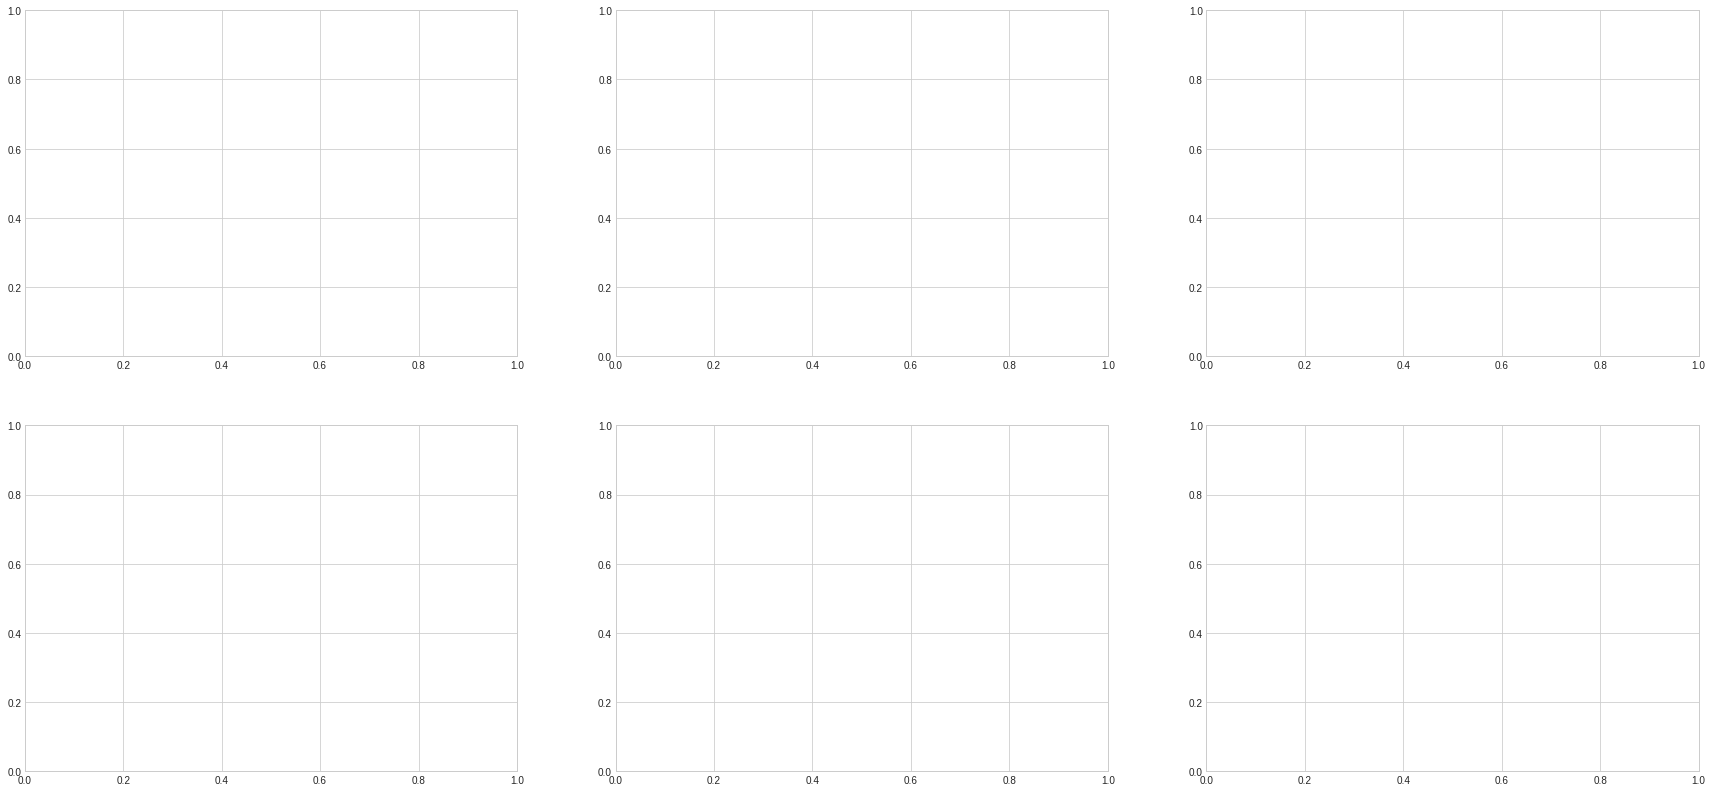

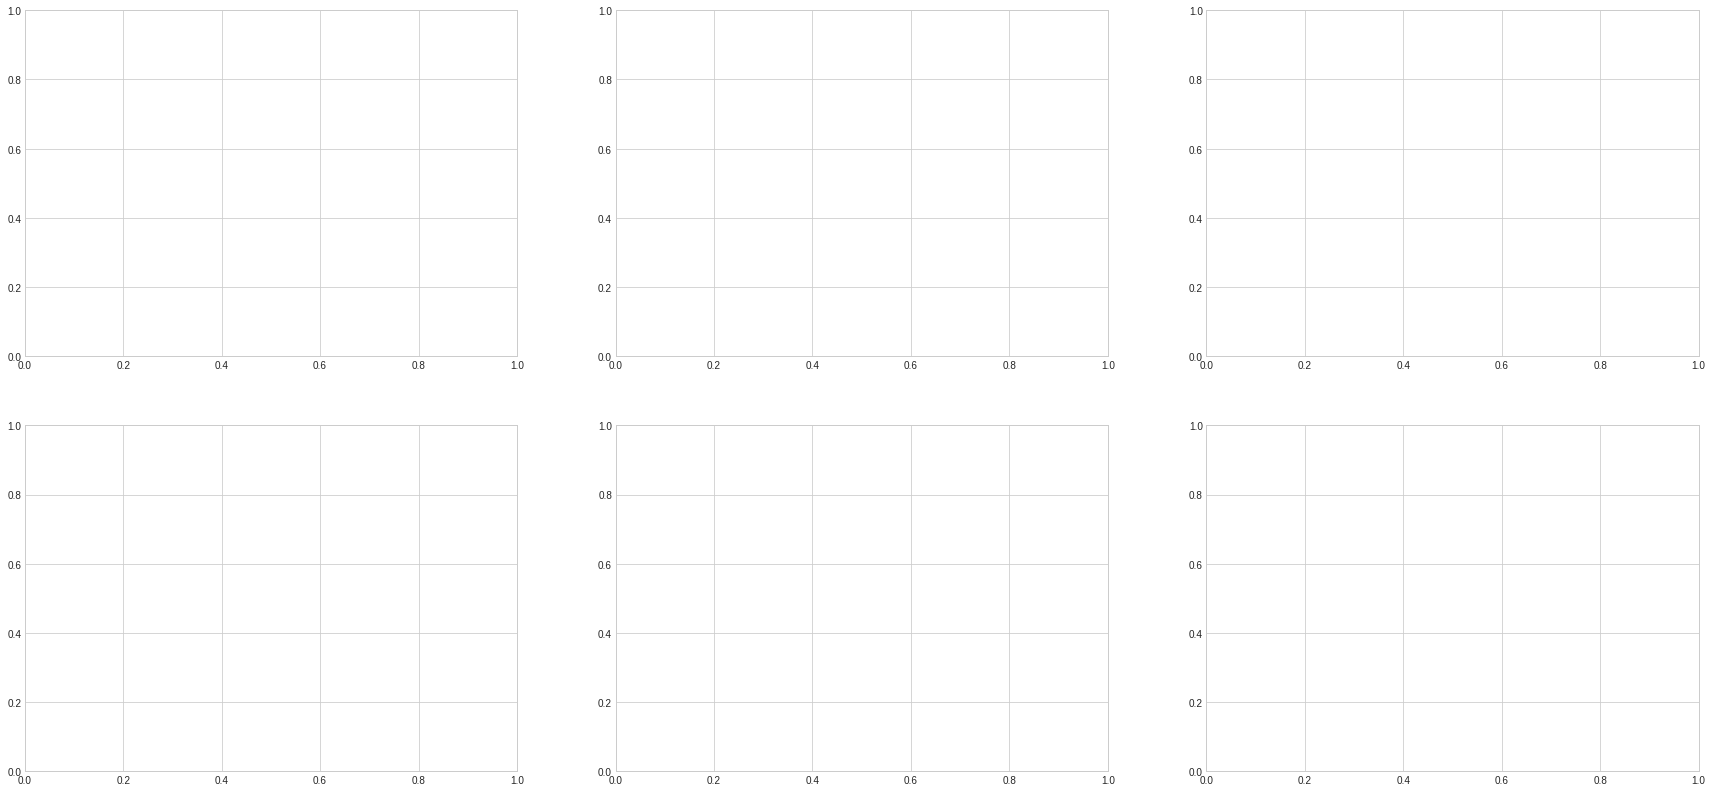

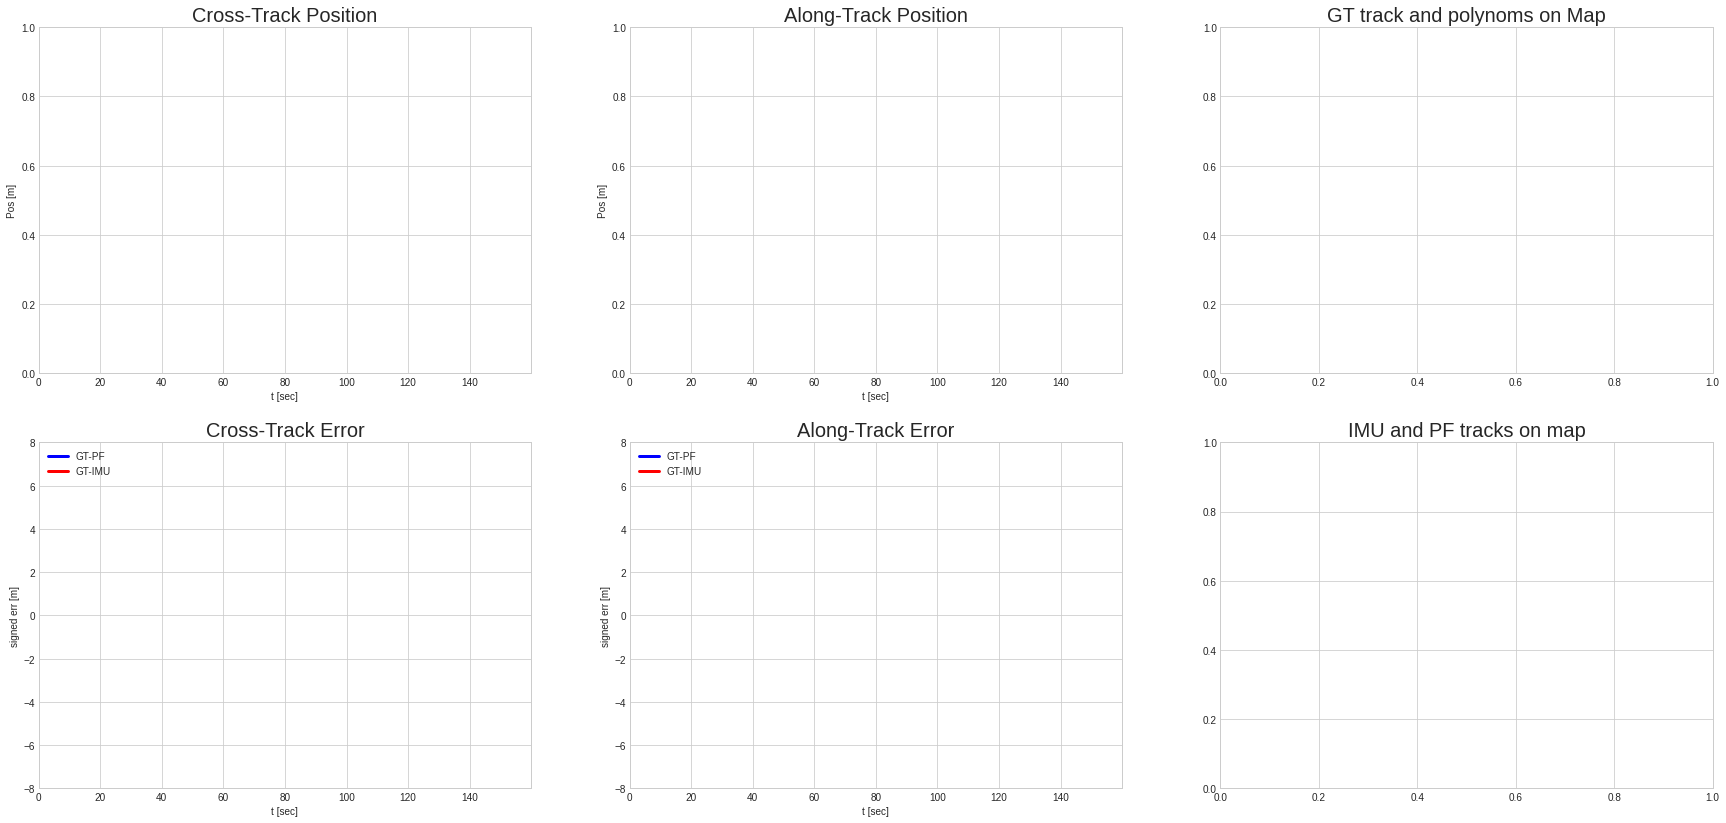

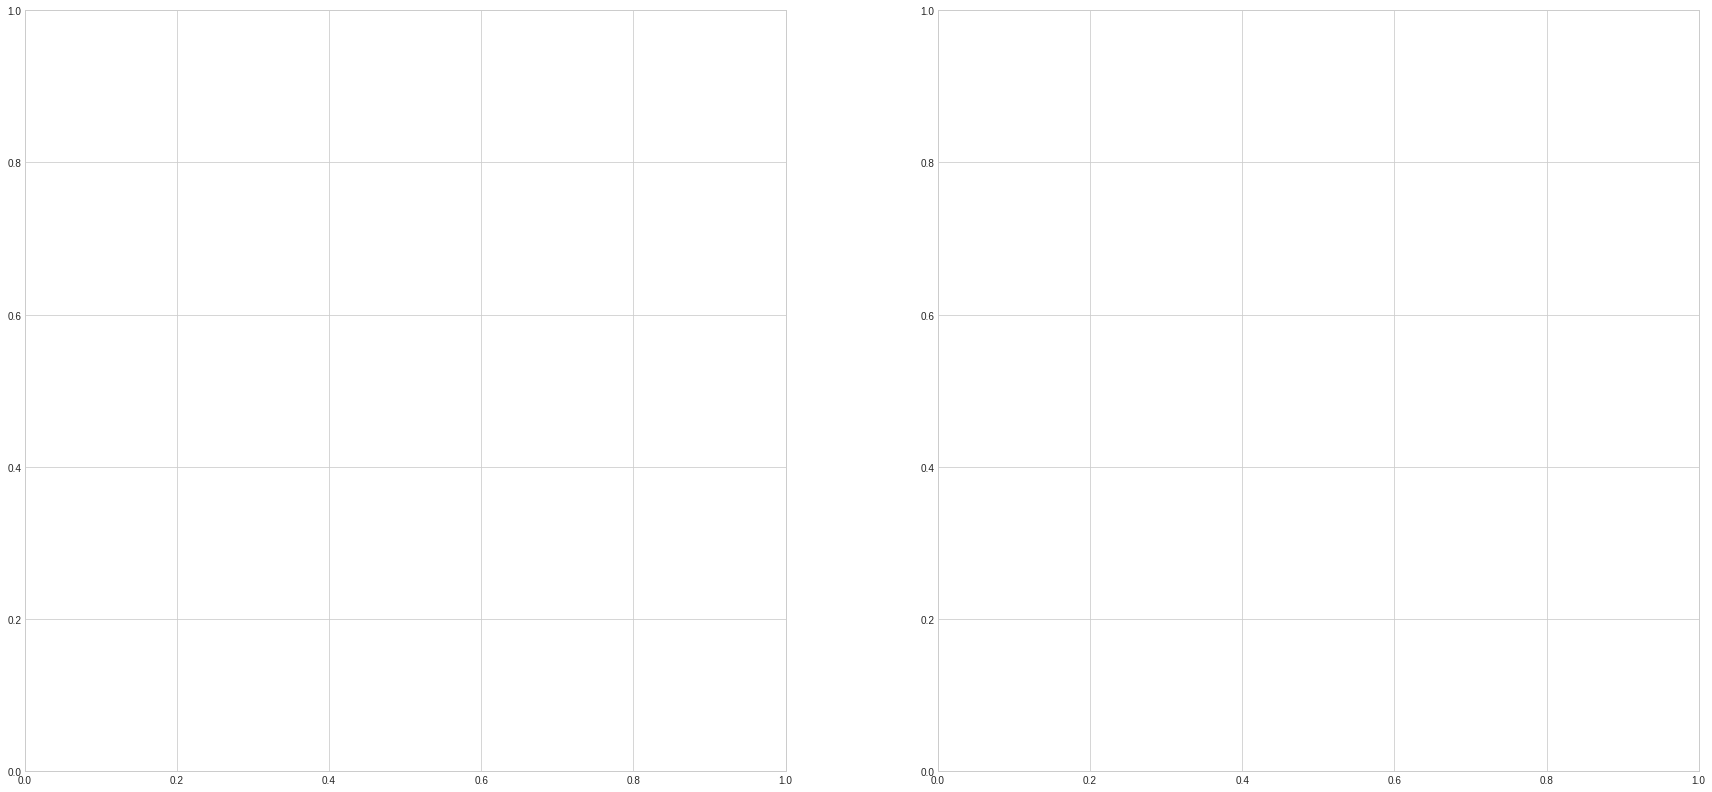

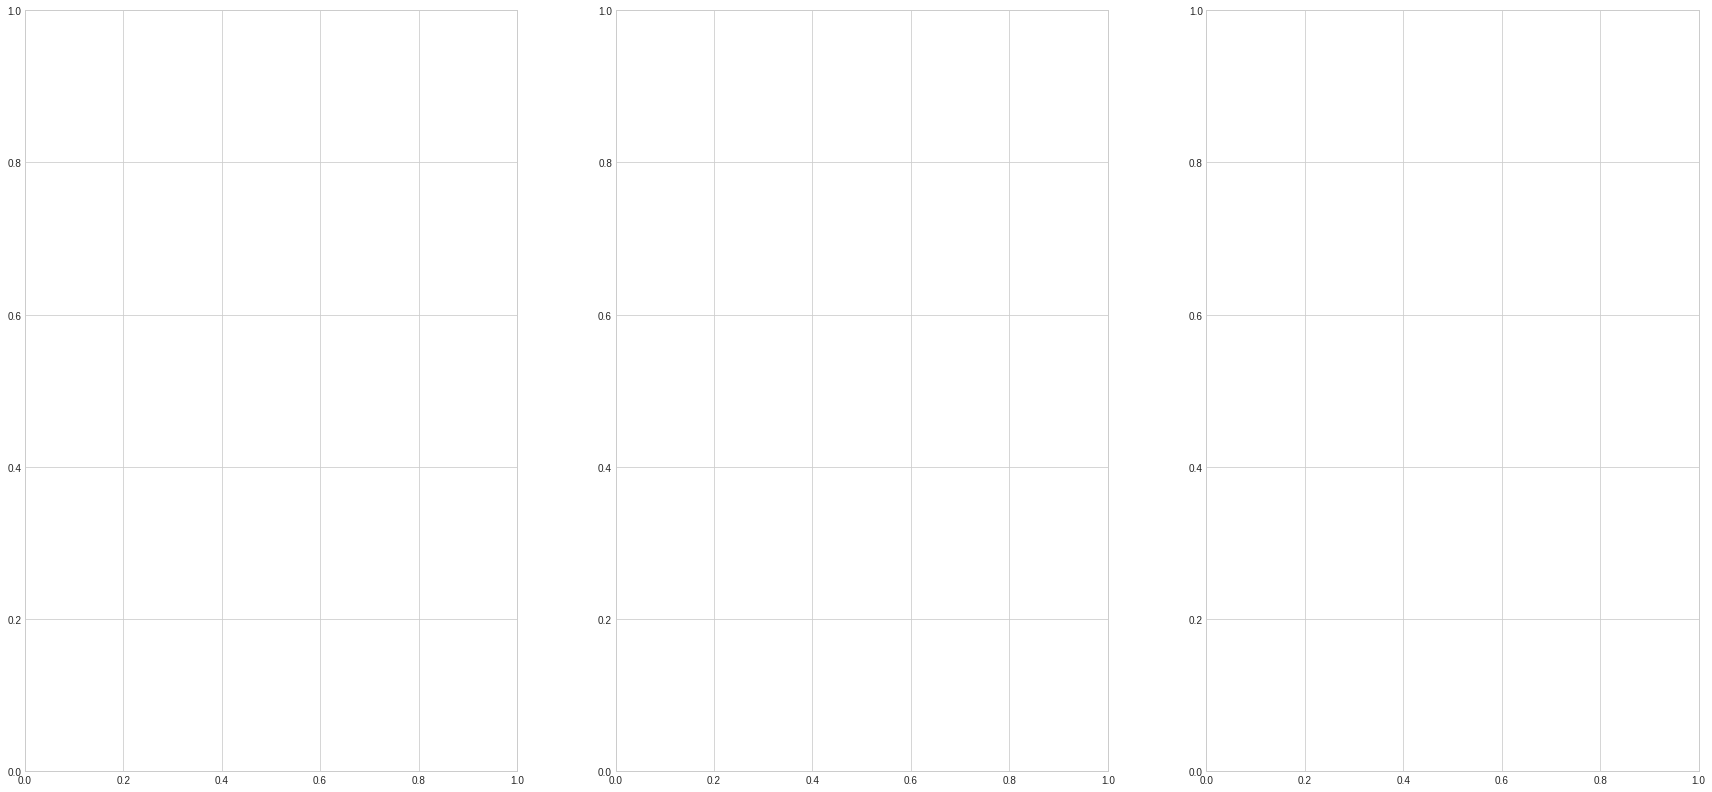

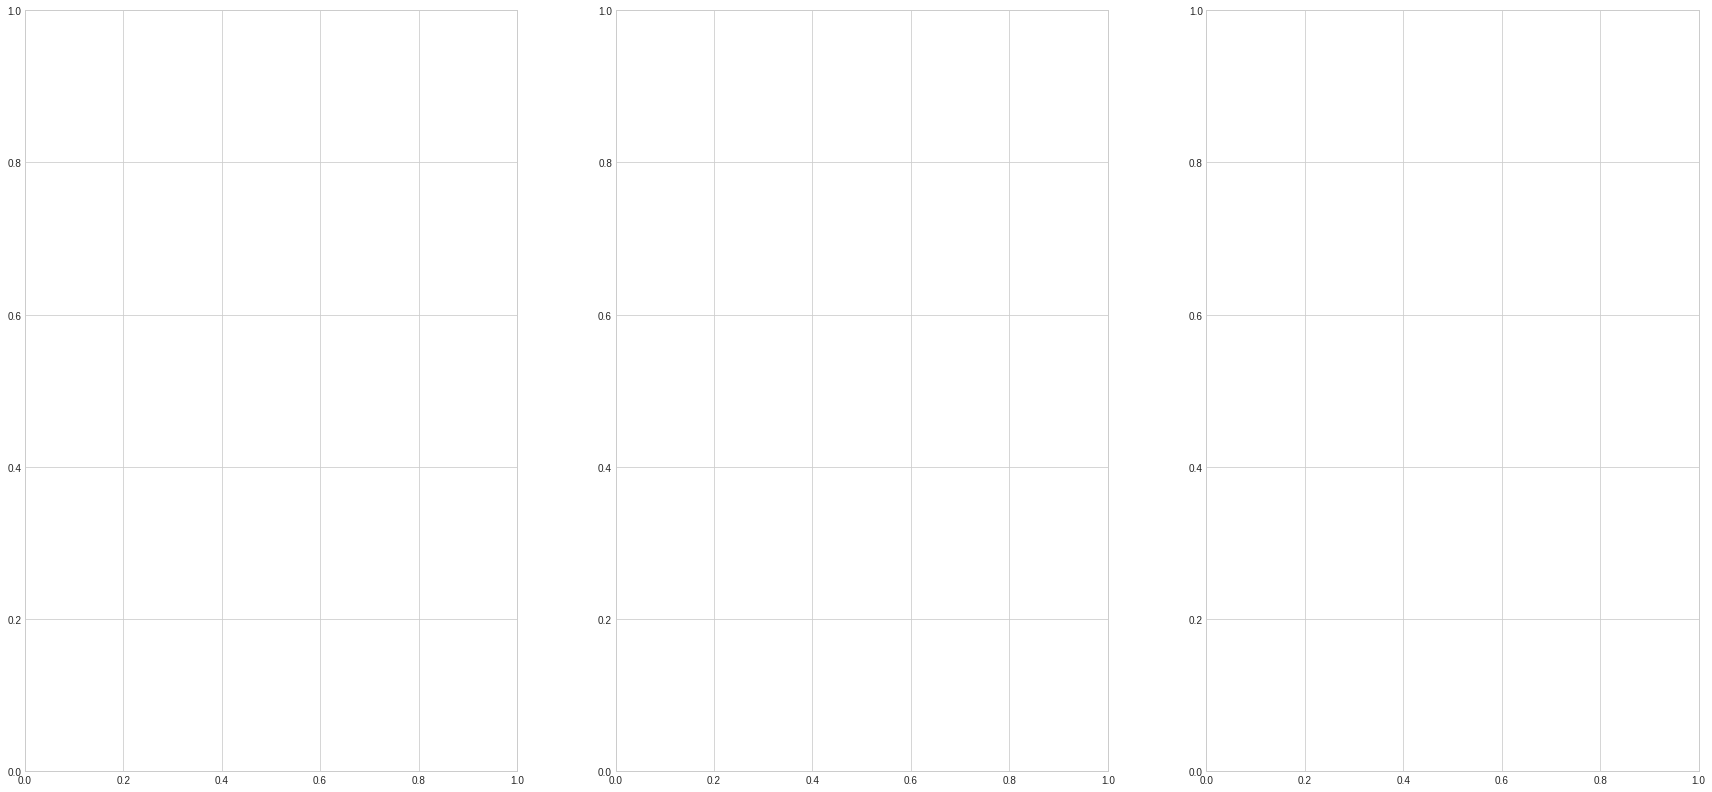

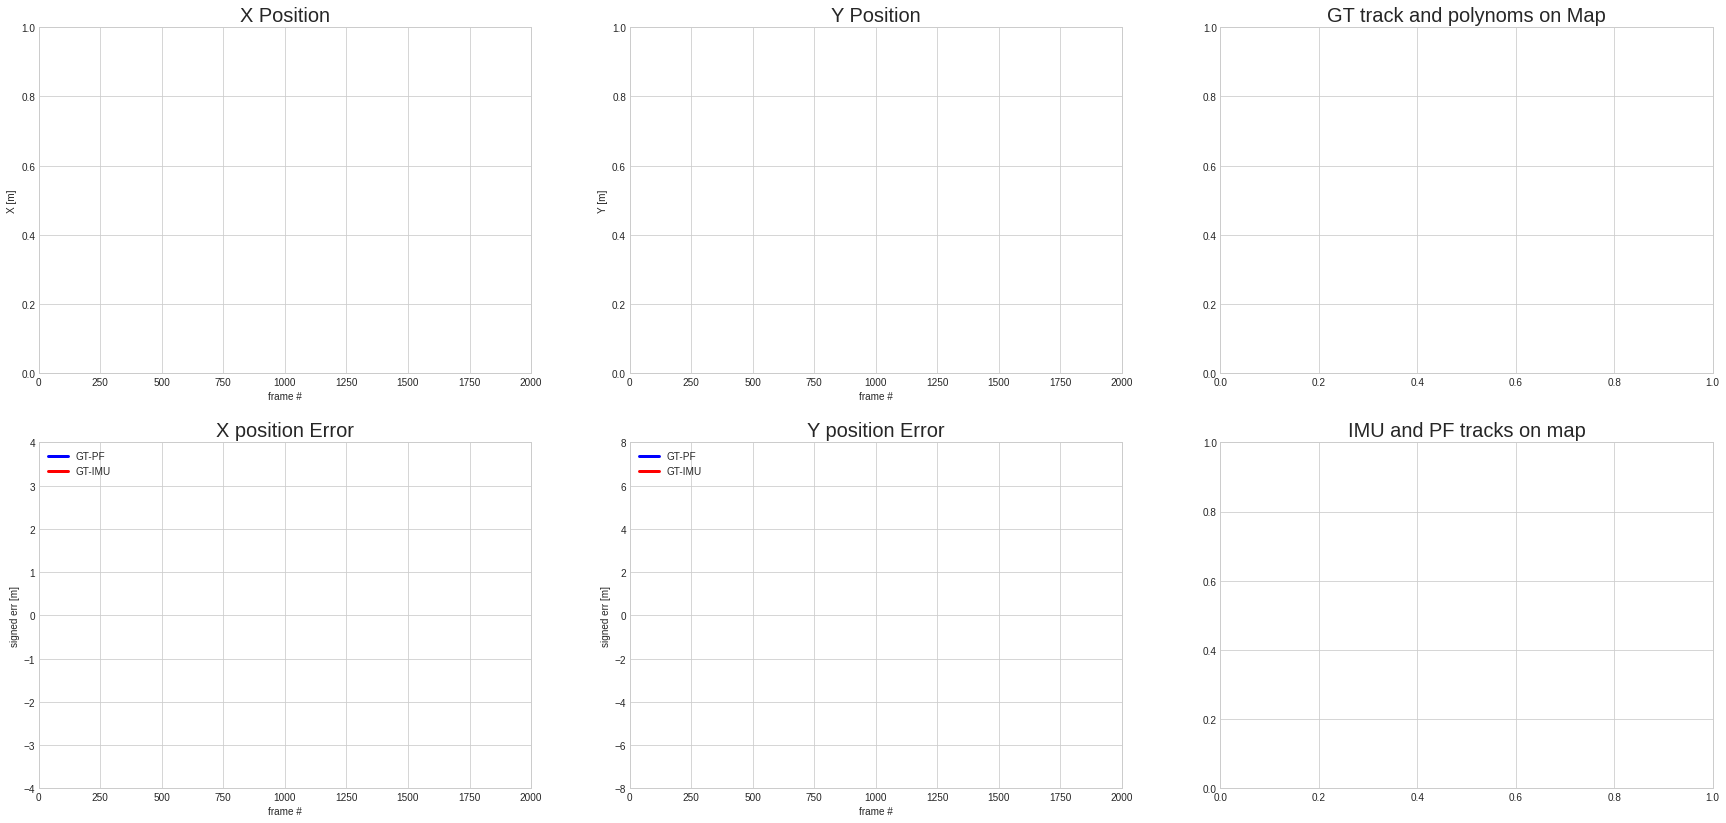

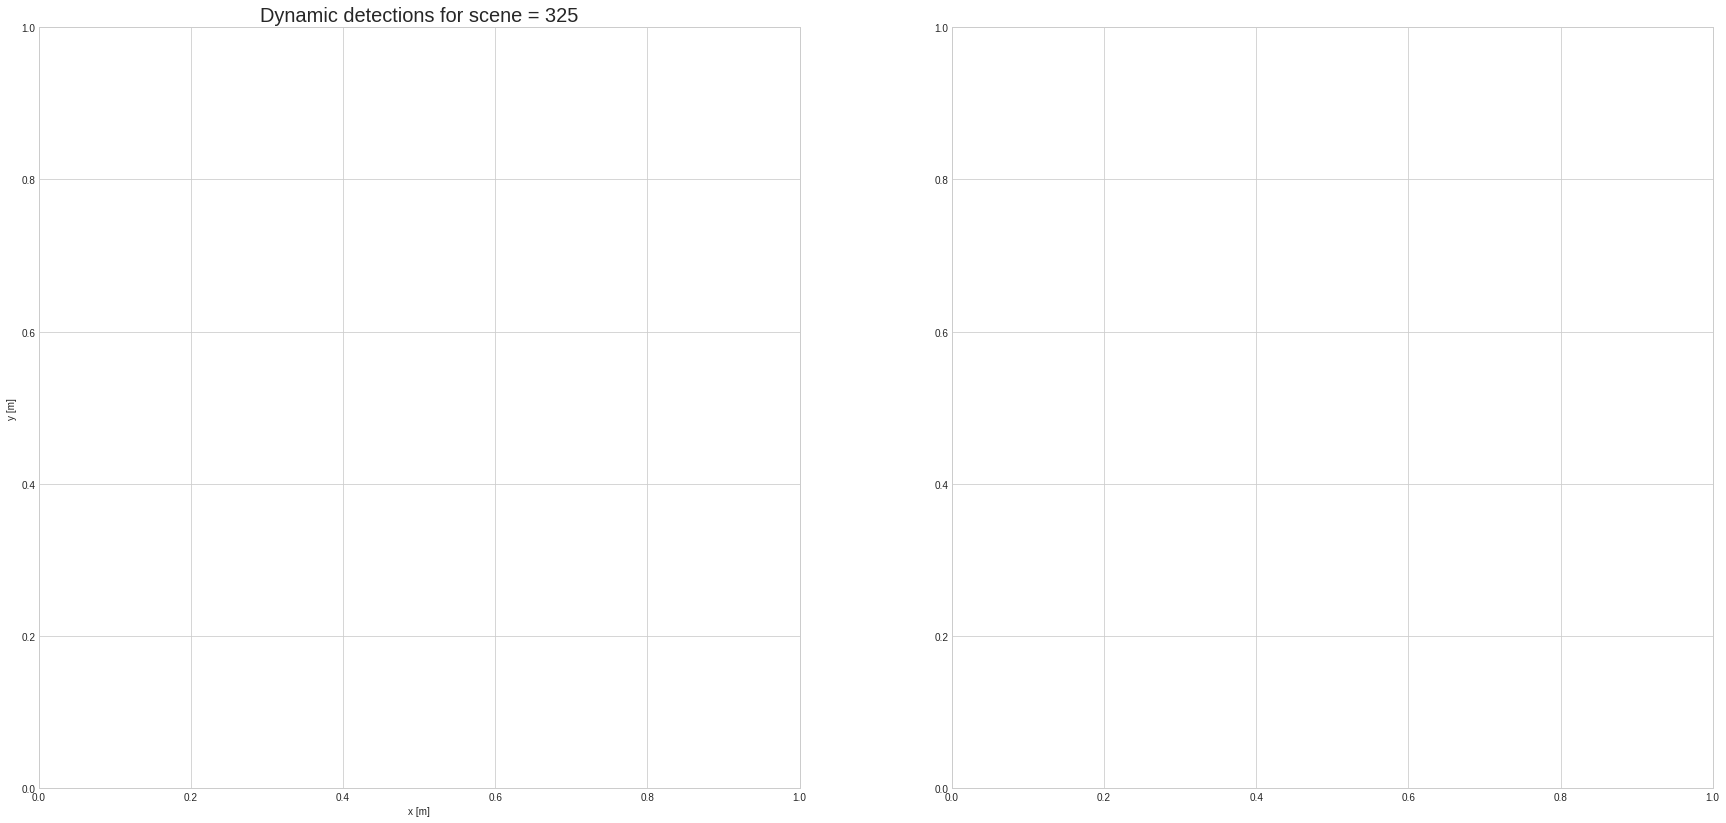

In [20]:
scene = 325 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=2000, video_list=video_list, save_processed=True)
sim.run(start=0, N=1800, generate_video=False, video_with_priors=False, debug=False)

In [21]:
from tqdm import tqdm
import math
from metrics import *

from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *

scene = 325

data = NuscenesProcessedDatabase(scene_id=scene)


nusc_map = sim.dataset.nusc_map
video_with_priors = True

N = 1600

video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
ego_path = sim.dataset.getEgoPath()[:N,0:2]#video_data["ego_path"][0:1800,0:2]
print(ego_path.shape)
ego_trns = sim.dataset.ego_trns[:N]#video_data["ego_trns"][0:1800]
pf_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))

for t in range(0,N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
    pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
    imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])
    
calc_acc_rmse(ego_path, ego_trns, pf_pos, imu_pos, N)

self.dir_name images/325/database


 17%|█▋        | 271/1600 [00:00<00:00, 1360.09it/s]

(1600, 2)
gt_track_pos[1] 0.4967044705825528
pf_track_errors [0.53583799 0.        ] imu_track_errors [0. 0.]
gt_track_pos[1] 0.4967044705825528
pf_track_errors [0.13427449 0.        ] imu_track_errors [-0.00428297  0.        ]
gt_track_pos[1] 1.0257048391815418
pf_track_errors [0.12583072 0.        ] imu_track_errors [-0.01511158  0.        ]
gt_track_pos[1] 1.5129427659150283
pf_track_errors [0.5961396 0.       ] imu_track_errors [-0.03120984  0.        ]
gt_track_pos[1] 2.0575954000940646
pf_track_errors [0.584572 0.      ] imu_track_errors [-0.0196526  0.       ]
gt_track_pos[1] 2.6067607355073816
pf_track_errors [0.57756948 0.        ] imu_track_errors [-0.05209027  0.        ]
gt_track_pos[1] 3.652950266450474
pf_track_errors [0.57641221 0.        ] imu_track_errors [-0.01819008  0.        ]
gt_track_pos[1] 4.163963997947807
pf_track_errors [0.57566322 0.        ] imu_track_errors [-0.02807182  0.        ]
gt_track_pos[1] 4.7113111137573505
pf_track_errors [1.0083912  0.56488187]

 34%|███▍      | 550/1600 [00:00<00:00, 1375.93it/s]

gt_track_pos[1] 189.48530881088882
pf_track_errors [0.24136756 0.37299399] imu_track_errors [-1.06736289  0.71801889]
gt_track_pos[1] 189.85830280125901
pf_track_errors [0.2586624 0.3450249] imu_track_errors [-1.10930698  0.3450249 ]
gt_track_pos[1] 190.20332770289053
pf_track_errors [0.27708912 0.72215767] imu_track_errors [-1.06994047  0.72215767]
gt_track_pos[1] 190.92548537239372
pf_track_errors [0.27209857 0.36621329] imu_track_errors [-1.07688945  0.73540978]
gt_track_pos[1] 191.29169866049816
pf_track_errors [0.269429   0.71285688] imu_track_errors [-1.07663073  0.71285688]
gt_track_pos[1] 191.6608951496762
pf_track_errors [0.26775192 0.70979322] imu_track_errors [-1.07824232  0.70979322]
gt_track_pos[1] 192.00455554503384
pf_track_errors [0.26081836 0.69716206] imu_track_errors [-1.08002195  0.69716206]
gt_track_pos[1] 192.37068837421828
pf_track_errors [0.34349983 0.33102923] imu_track_errors [-1.14315235  1.05951074]
gt_track_pos[1] 192.70171760109864
pf_track_errors [0.25834

 52%|█████▏    | 829/1600 [00:00<00:00, 1380.74it/s]


gt_track_pos[1] 374.11762897233945
pf_track_errors [1.36916716 1.40036003] imu_track_errors [-2.67015556  1.40036003]
gt_track_pos[1] 374.8383082455607
pf_track_errors [1.37531511 1.39594738] imu_track_errors [-2.6799047   0.67968075]
gt_track_pos[1] 375.51798899740214
pf_track_errors [1.36576833 0.71626663] imu_track_errors [-2.68126213  0.71626663]
gt_track_pos[1] 376.23425562558344
pf_track_errors [1.3780254  0.72131277] imu_track_errors [-2.69676786  0.72131277]
gt_track_pos[1] 376.9555683927491
pf_track_errors [1.38641325 1.39819614] imu_track_errors [-2.70844743  1.39819614]
gt_track_pos[1] 378.35376453638764
pf_track_errors [1.3816019  1.39628933] imu_track_errors [-2.71872093  1.39628933]
gt_track_pos[1] 379.0786585684336
pf_track_errors [1.39387193 1.39416219] imu_track_errors [-2.72881462  0.6713953 ]
gt_track_pos[1] 379.7500538657658
pf_track_errors [1.38699425 0.72276689] imu_track_errors [-2.72858473  0.72276689]
gt_track_pos[1] 380.47282075908487
pf_track_errors [1.38589

 59%|█████▉    | 951/1600 [00:00<00:00, 1315.53it/s]


gt_track_pos[1] 539.1297062534745
pf_track_errors [0.88186988 3.58400887] imu_track_errors [-2.37724597 -2.93088103]
gt_track_pos[1] 539.7107543903207
pf_track_errors [0.89494683 3.58372638] imu_track_errors [-2.43309311 -2.34048224]
gt_track_pos[1] 540.3382185710987
pf_track_errors [0.91448577 3.58710729] imu_track_errors [-2.40575027 -2.96794642]
gt_track_pos[1] 541.5232403177736
pf_track_errors [0.92465876 3.02183129] imu_track_errors [-2.43847984 -3.01777961]
gt_track_pos[1] 542.0901080108248
pf_track_errors [0.93988053 3.65837455] imu_track_errors [-2.45250845 -2.96040176]
gt_track_pos[1] 542.7137151208575
pf_track_errors [0.92680684 3.03476744] imu_track_errors [-2.46405563 -3.00296073]
gt_track_pos[1] 543.2944807732239
pf_track_errors [0.92789078 3.07736651] imu_track_errors [-2.47866809 -2.9562622 ]
gt_track_pos[1] 543.9253258634303
pf_track_errors [0.95309113 3.03017651] imu_track_errors [-2.53425003 -2.40208555]
gt_track_pos[1] 544.5450716032968
pf_track_errors [0.94456798 3

 76%|███████▌  | 1219/1600 [00:00<00:00, 1331.34it/s]

gt_track_pos[1] 686.8074270132608
pf_track_errors [ 2.23596625 -1.67513489] imu_track_errors [-4.10561998  4.85251623]
gt_track_pos[1] 687.2450638866944
pf_track_errors [ 2.17093096 -1.7111888 ] imu_track_errors [-4.03804278  4.86720862]
gt_track_pos[1] 687.6593985890582
pf_track_errors [ 2.10329948 -1.68546951] imu_track_errors [-3.97073232  4.45287392]
gt_track_pos[1] 688.0950586535332
pf_track_errors [ 2.03852047 -2.12112957] imu_track_errors [-3.90772125  4.99561295]
gt_track_pos[1] 688.5044291755523
pf_track_errors [ 1.9764244  -1.69700216] imu_track_errors [-3.85320597  4.58624243]
gt_track_pos[1] 688.9509865008258
pf_track_errors [ 1.88801148 -2.14355949] imu_track_errors [-3.79997321  4.64891109]
gt_track_pos[1] 689.8328069001383
pf_track_errors [ 1.7480177  -2.17340831] imu_track_errors [-3.73356777  4.75588546]
gt_track_pos[1] 690.2735372261312
pf_track_errors [ 1.69401972 -2.17847857] imu_track_errors [-3.70415544  4.83368362]
gt_track_pos[1] 690.743355941118
pf_track_errors

100%|██████████| 1600/1600 [00:01<00:00, 1358.40it/s]

gt_track_pos[1] 872.8222716551422
pf_track_errors [ 1.6614454  -0.53034242] imu_track_errors [-6.93690317  5.50627258]
gt_track_pos[1] 873.3950747372423
pf_track_errors [ 1.6761286  -0.57280308] imu_track_errors [-7.01016765  4.9334695 ]
gt_track_pos[1] 874.5066548515662
pf_track_errors [1.71203501 0.        ] imu_track_errors [-7.15608999  4.89044547]
gt_track_pos[1] 875.0464179120664
pf_track_errors [1.72522265 0.        ] imu_track_errors [-7.22893269  4.89215224]
gt_track_pos[1] 875.6182924870545
pf_track_errors [1.73286819 0.        ] imu_track_errors [-7.29834167  4.86921654]
gt_track_pos[1] 876.1460646239539
pf_track_errors [1.7406498 0.       ] imu_track_errors [-7.37636388  4.84551781]
gt_track_pos[1] 876.7146223552112
pf_track_errors [1.74878117 0.        ] imu_track_errors [-7.47171078  4.27696008]
gt_track_pos[1] 877.2417921538682
pf_track_errors [1.76152766 0.        ] imu_track_errors [-7.54123149  4.79330468]
gt_track_pos[1] 878.3285442391308
pf_track_errors [1.80188667 